# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 1
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  644465.987031  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  674784.517390  4.412428e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         1.0      398139.231561  
         2.0      494315.467226  
         3.0      537605.057823  
         4.0      562223.555107

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


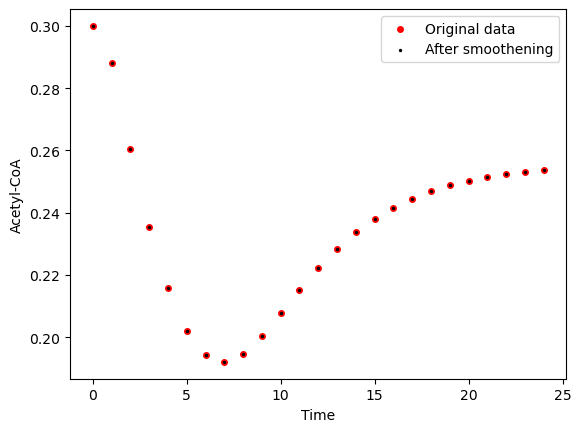

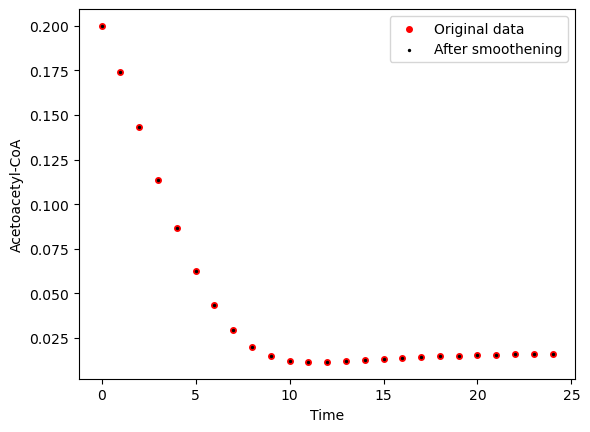

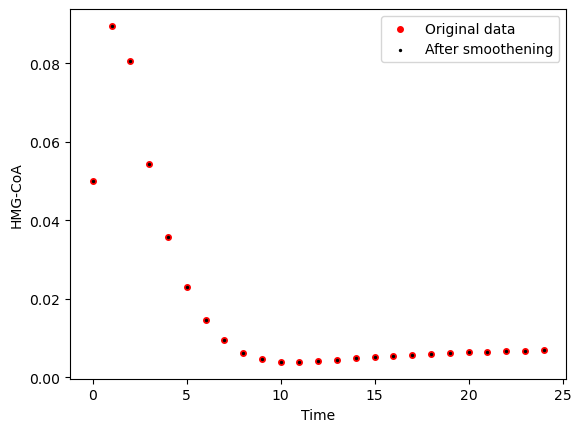

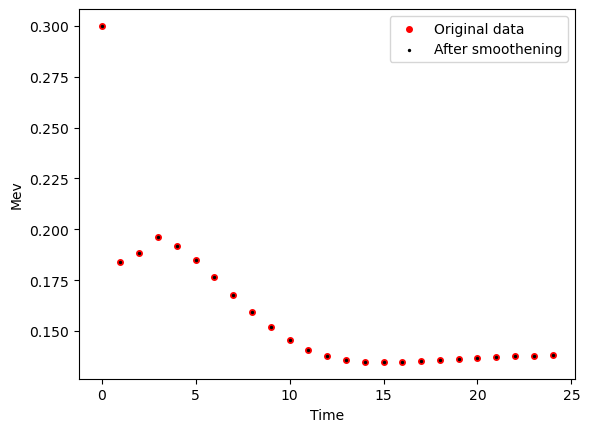

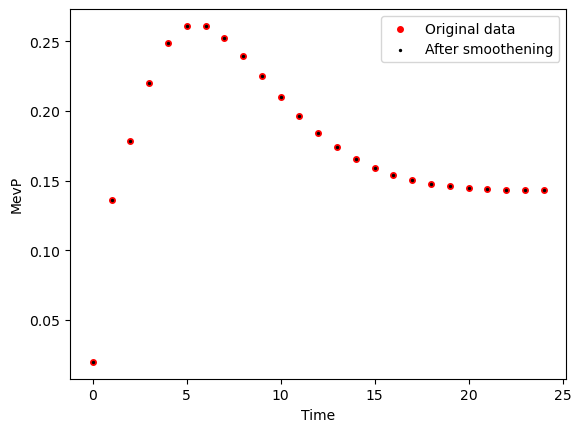

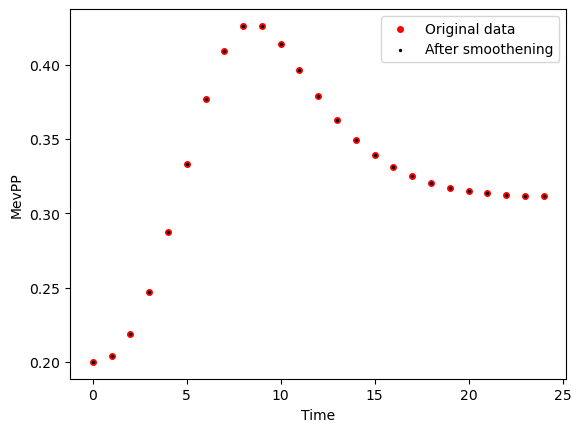

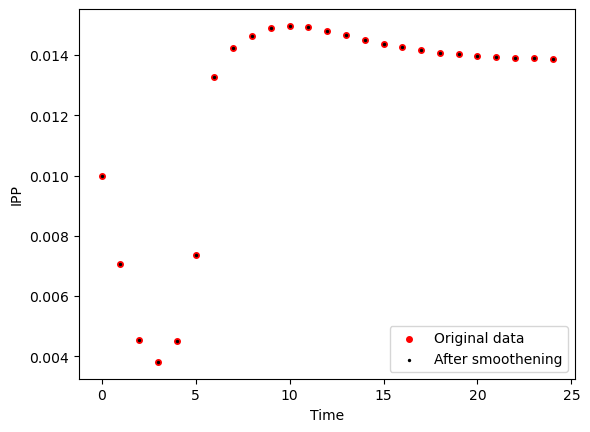

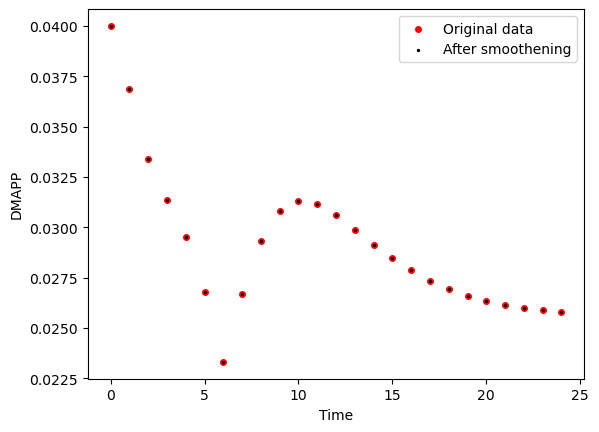

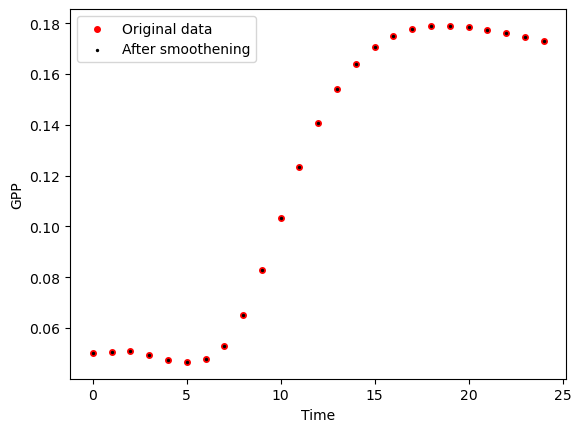

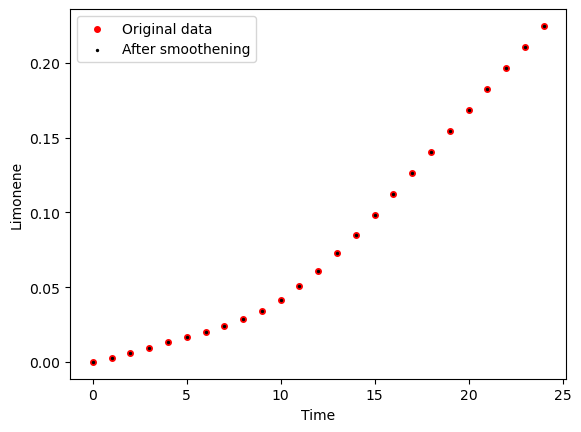

Strain Strain 2


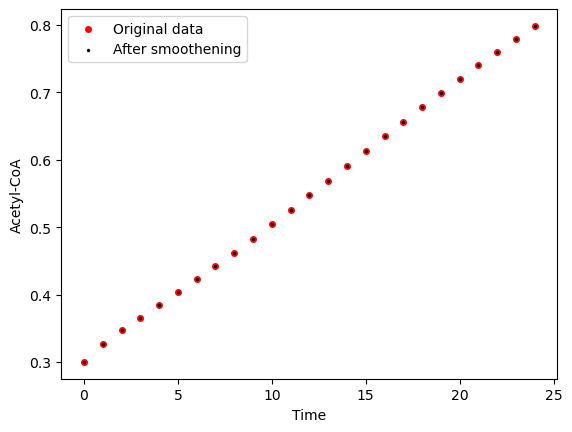

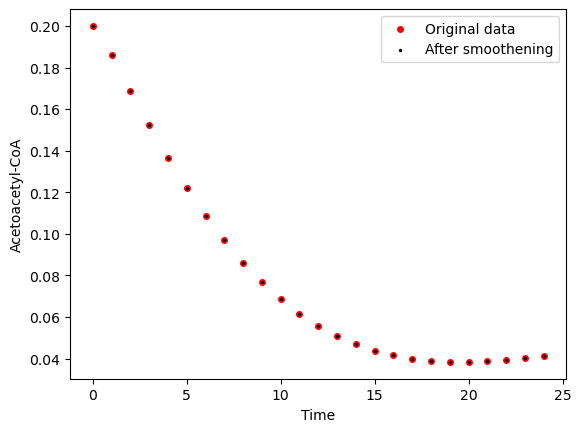

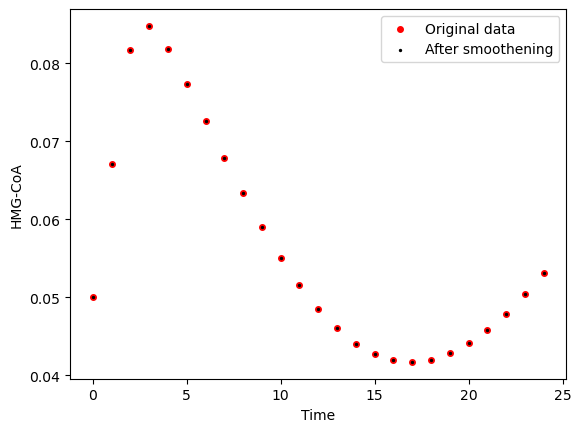

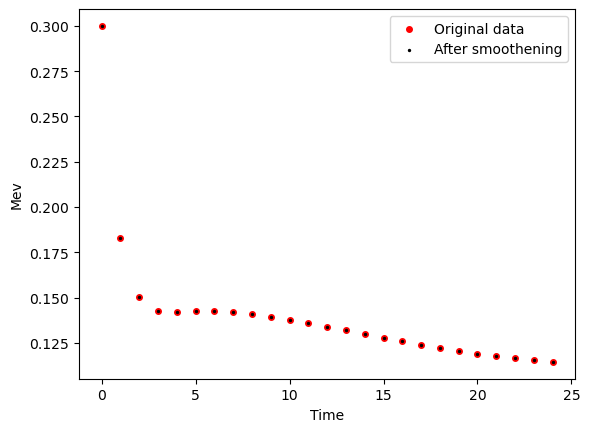

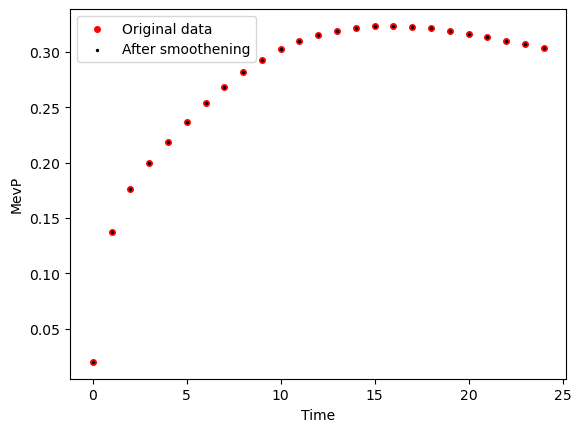

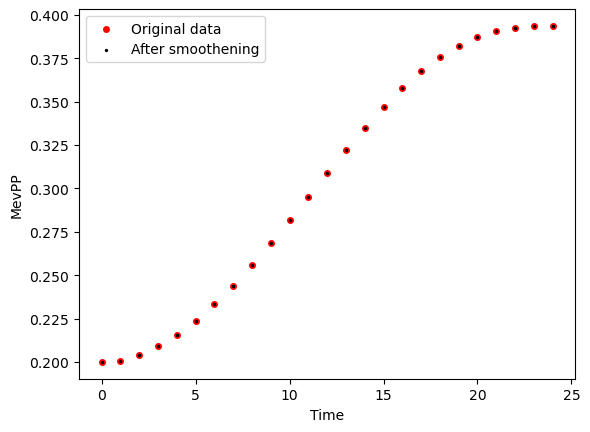

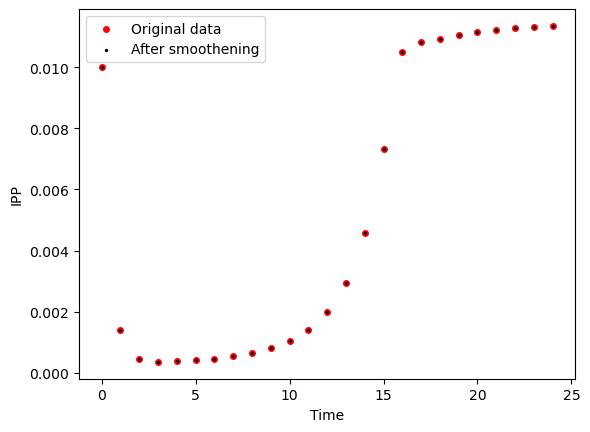

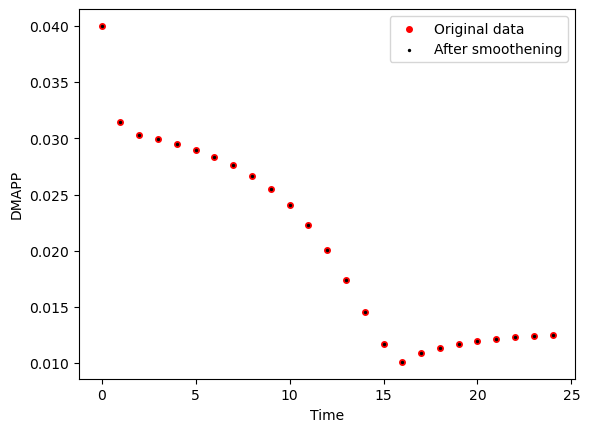

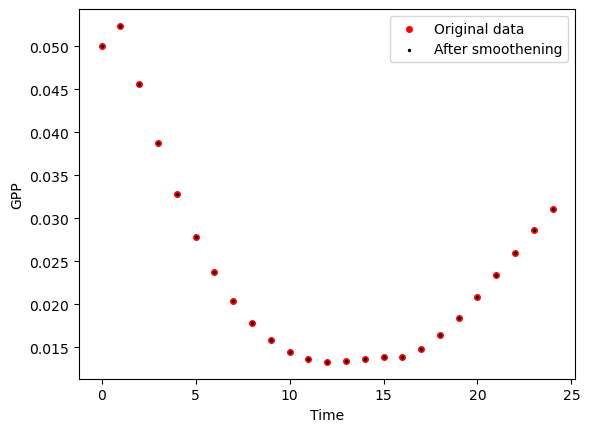

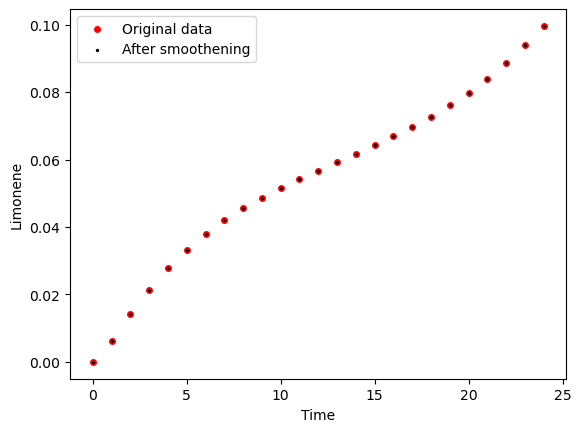

Strain Strain 3


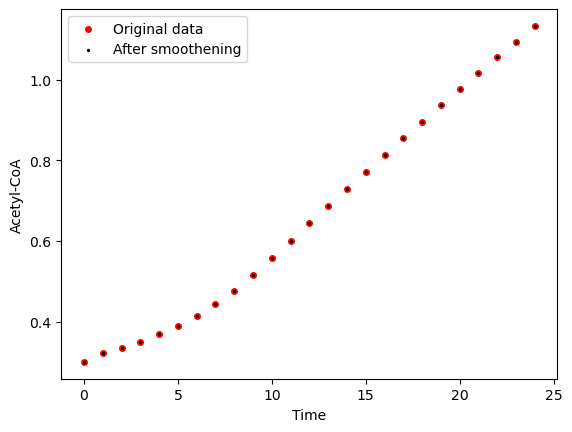

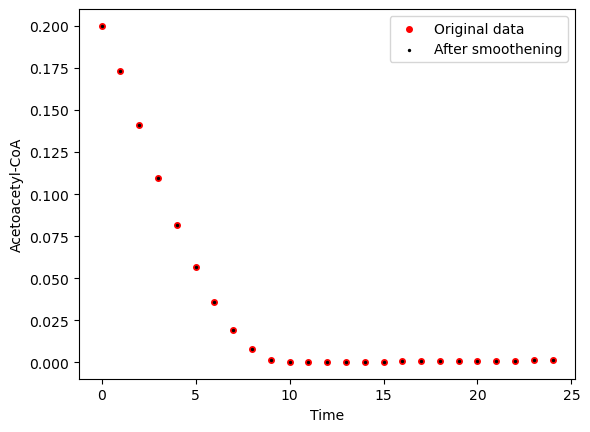

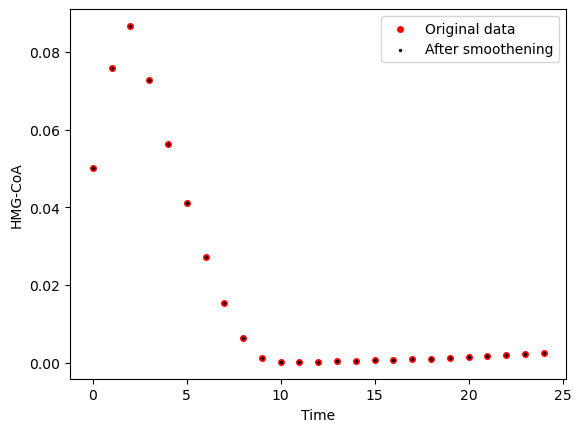

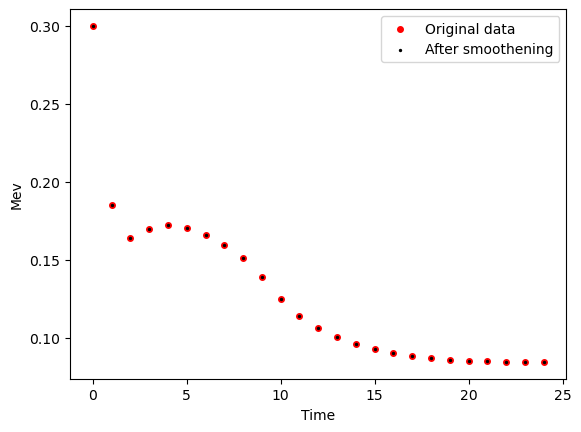

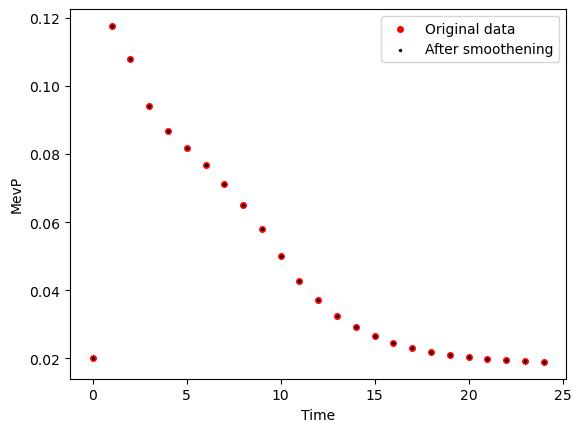

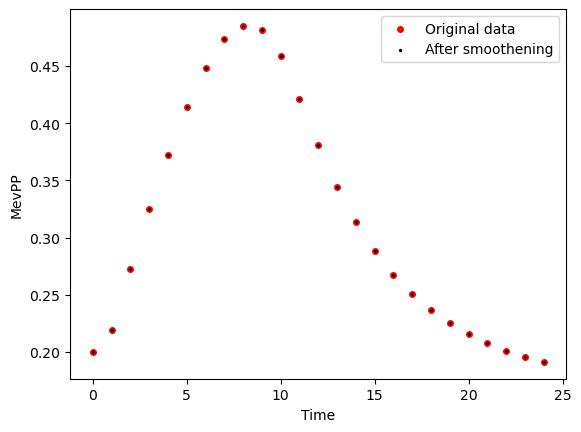

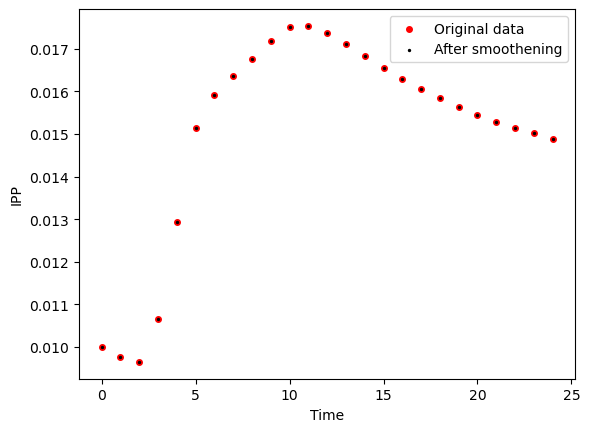

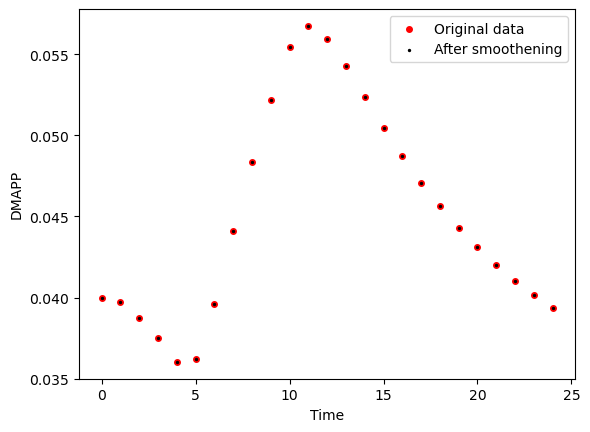

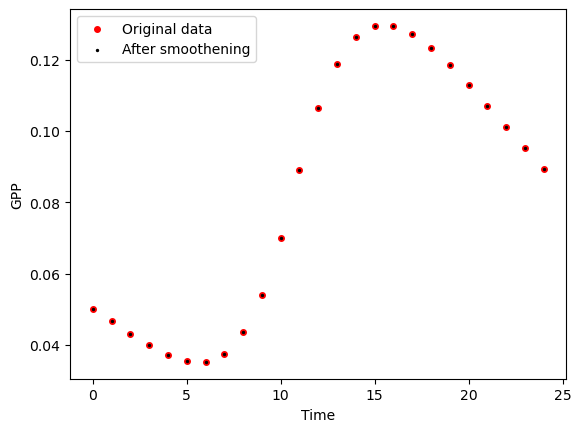

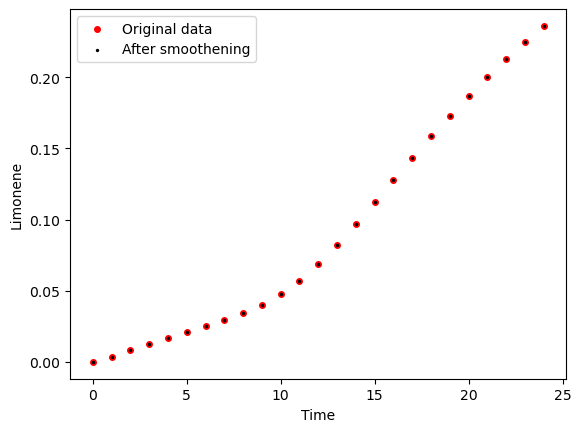

Strain WT


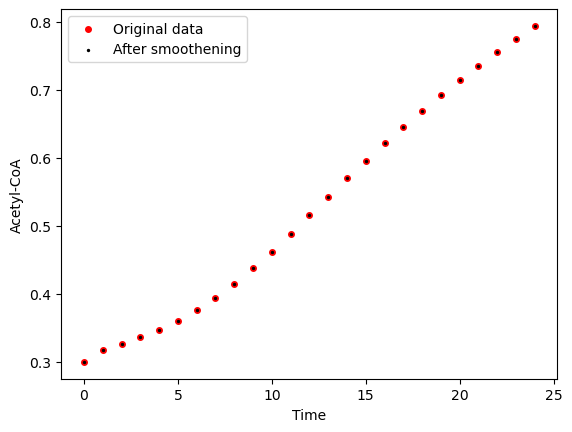

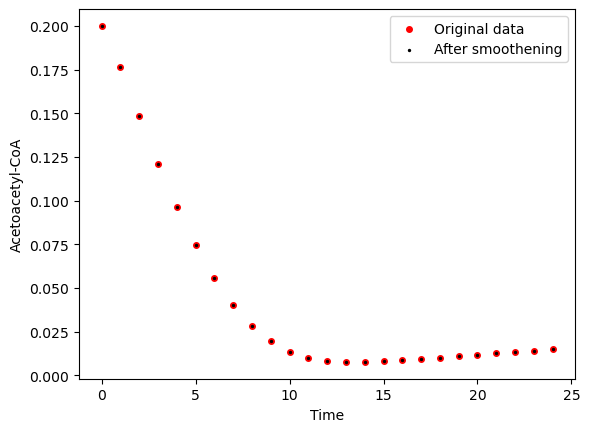

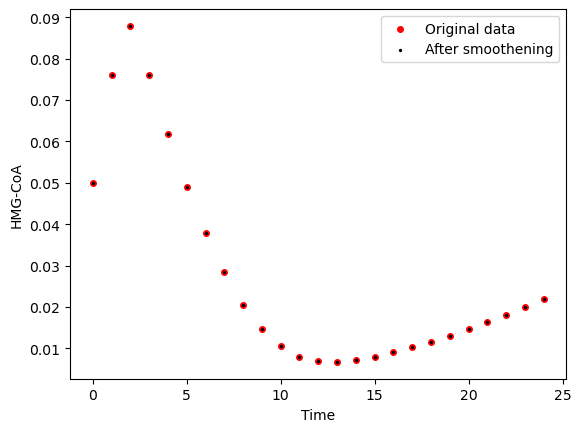

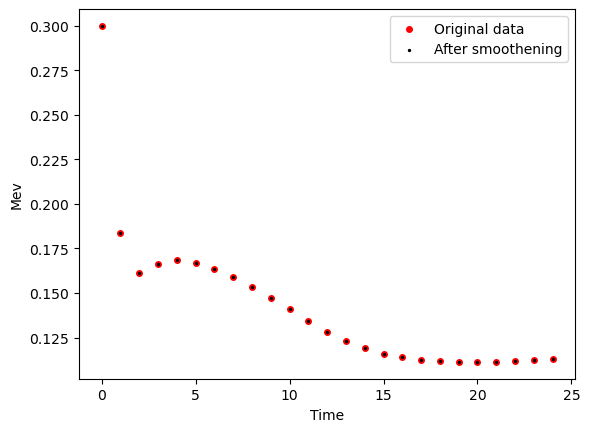

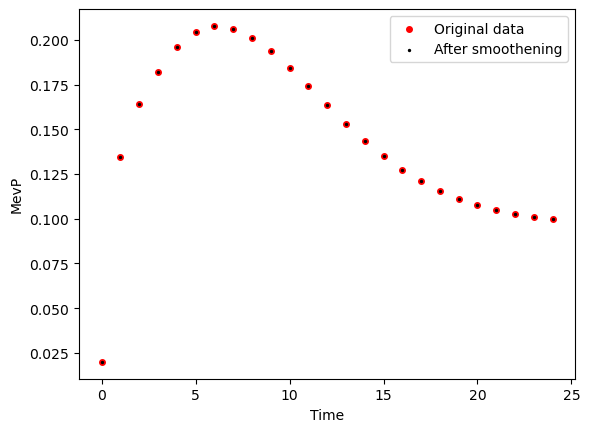

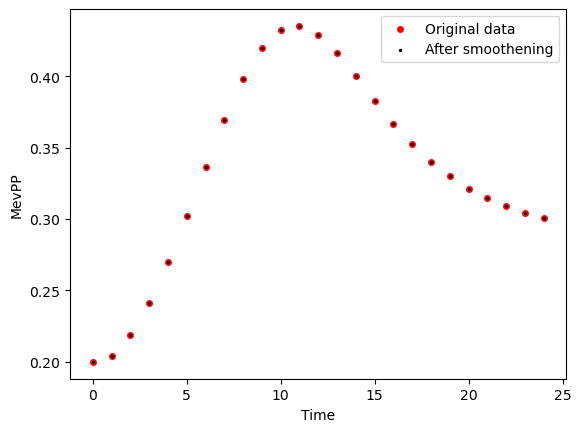

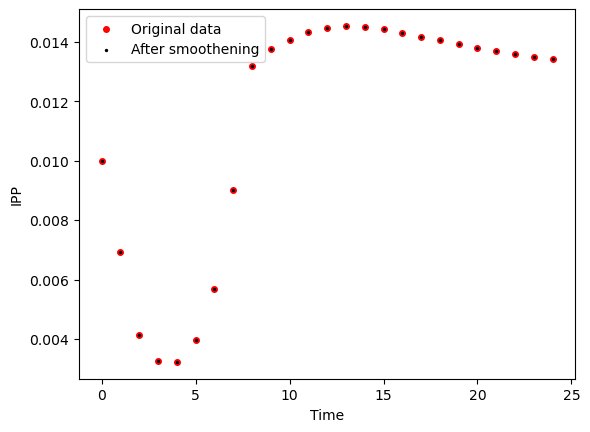

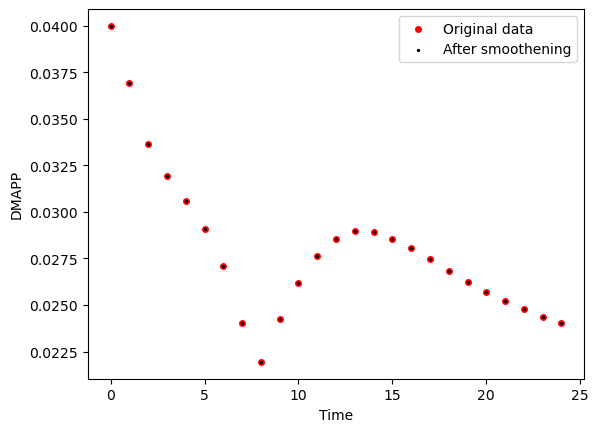

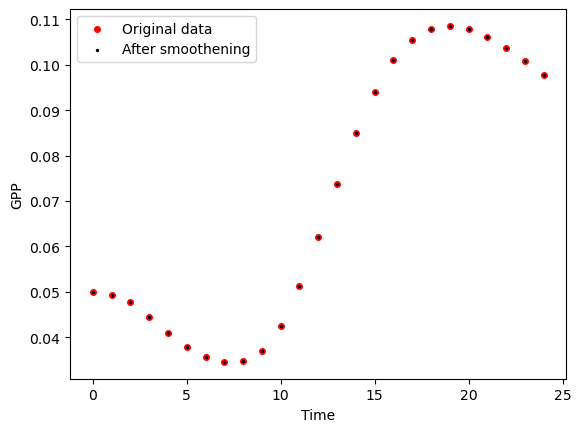

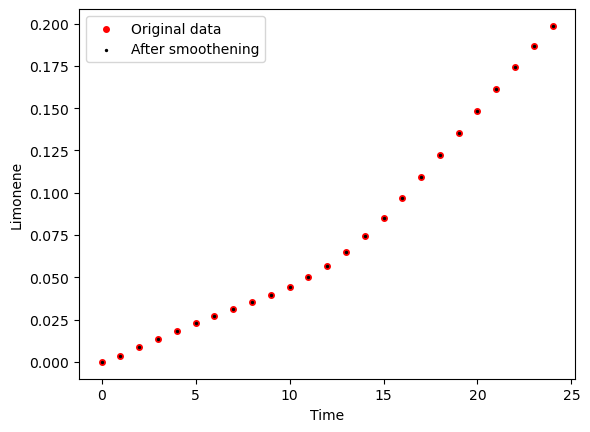

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


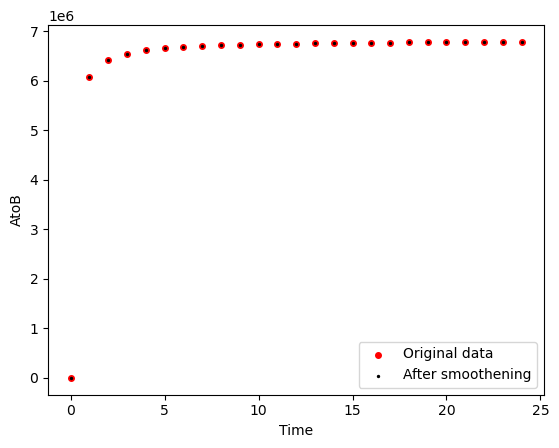

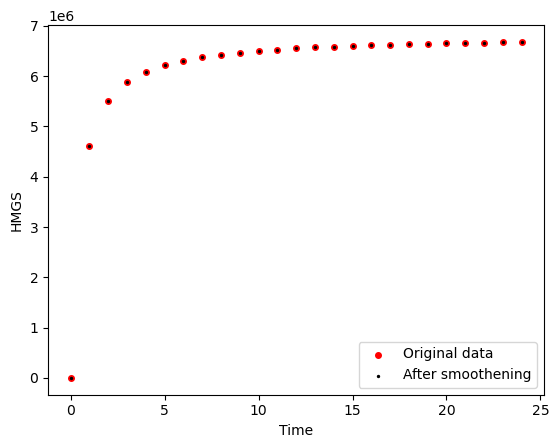

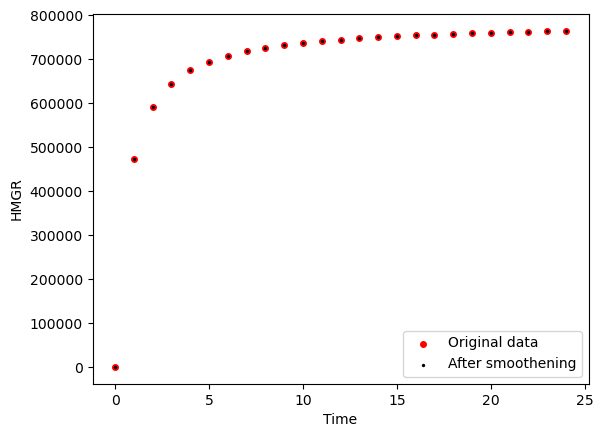

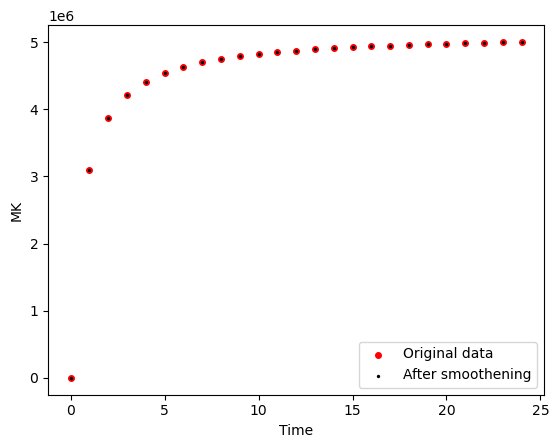

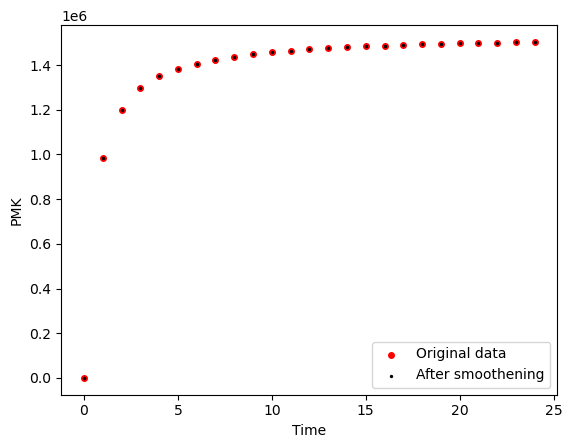

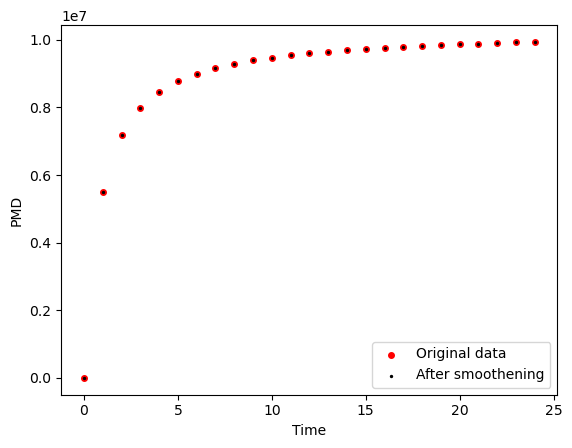

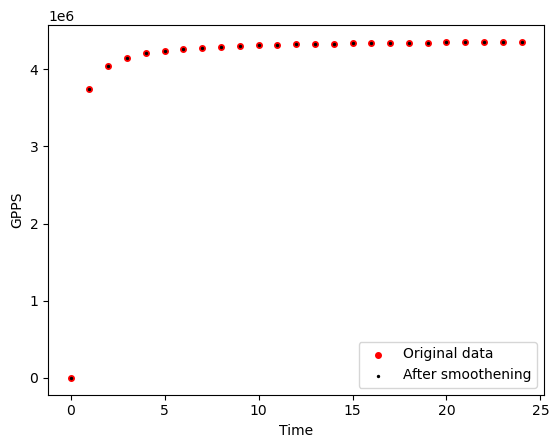

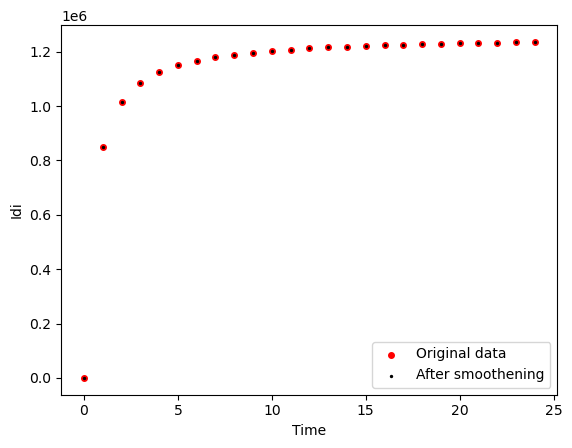

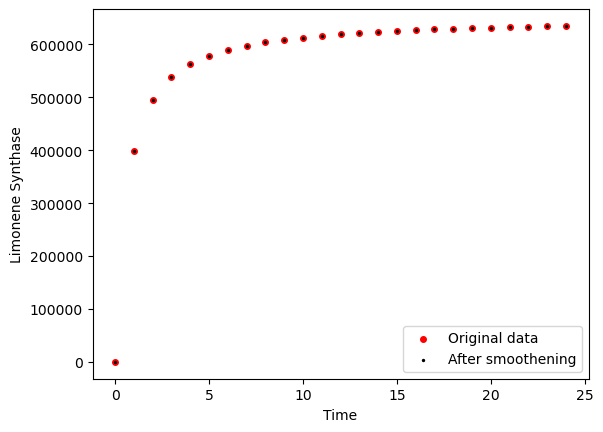

Strain Strain 2


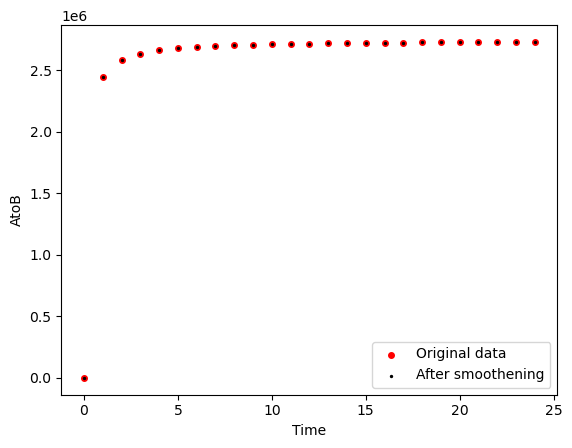

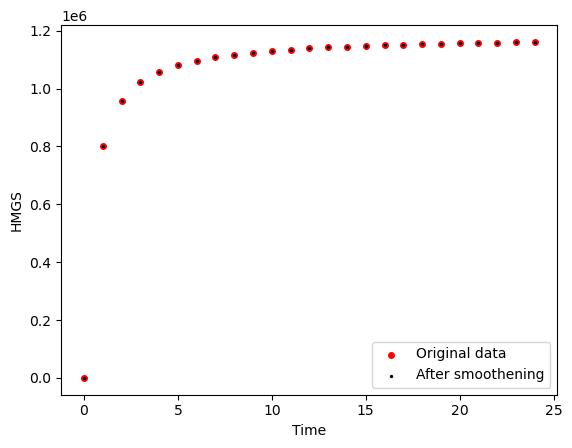

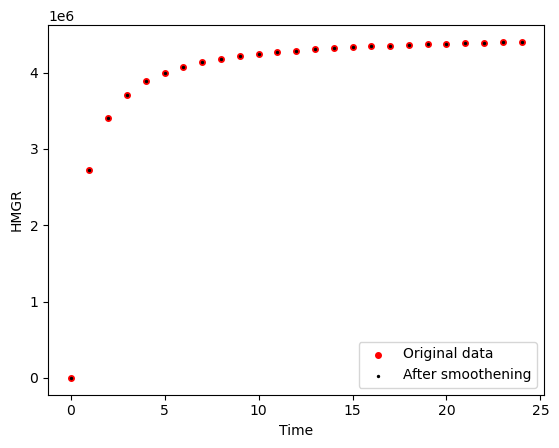

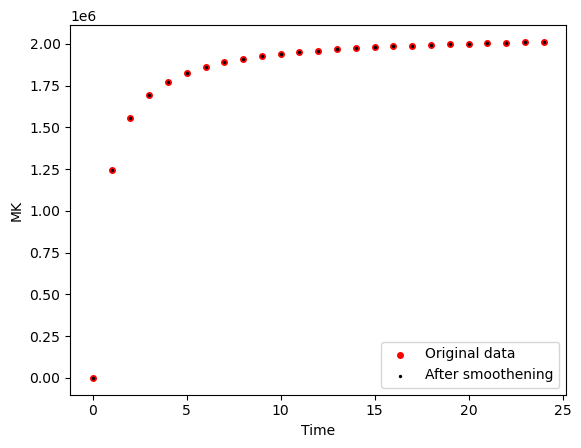

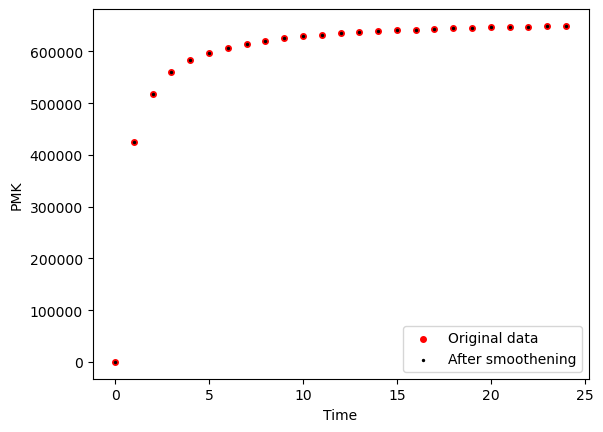

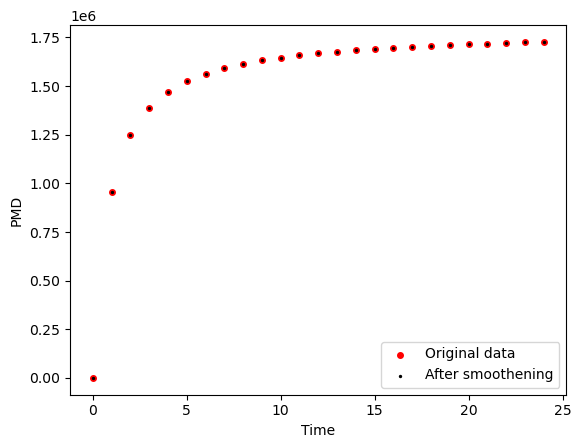

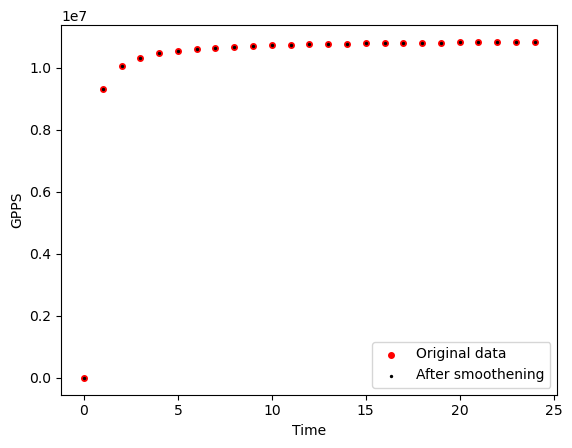

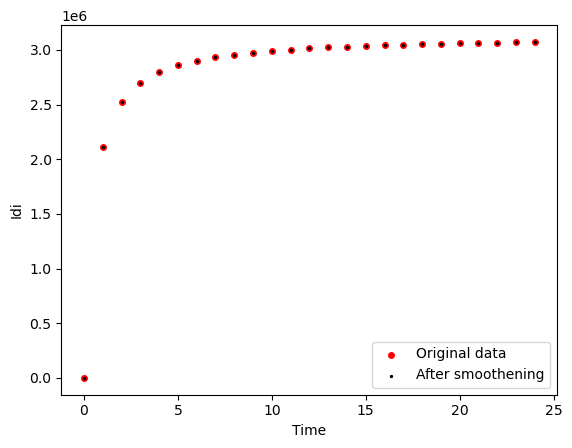

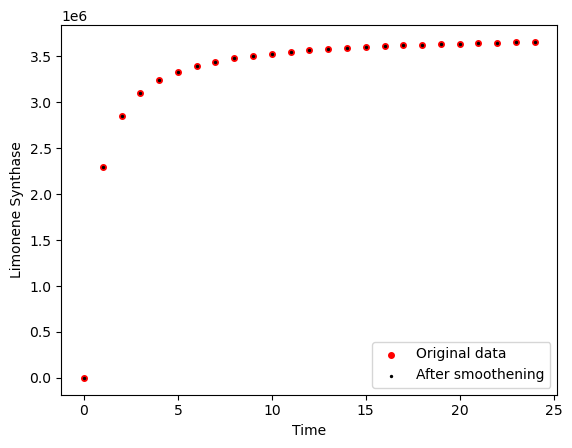

Strain Strain 3


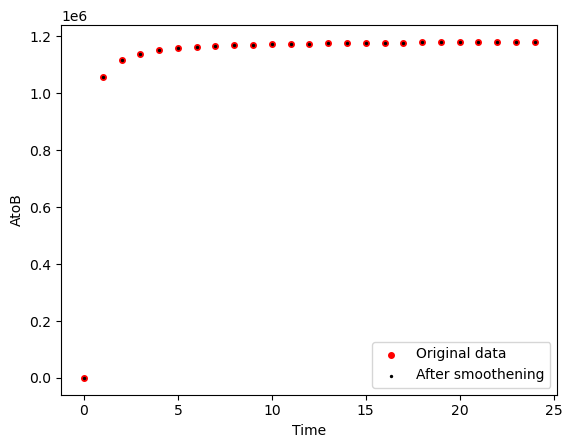

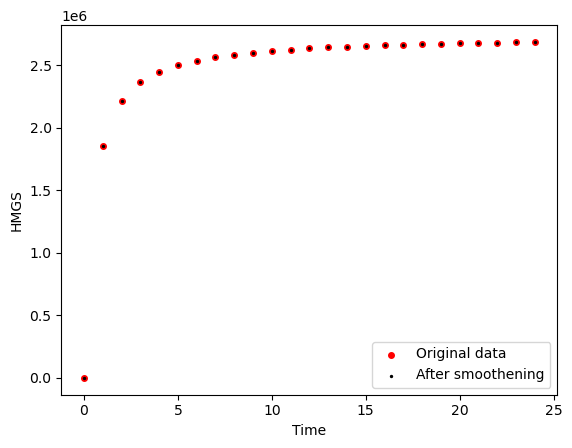

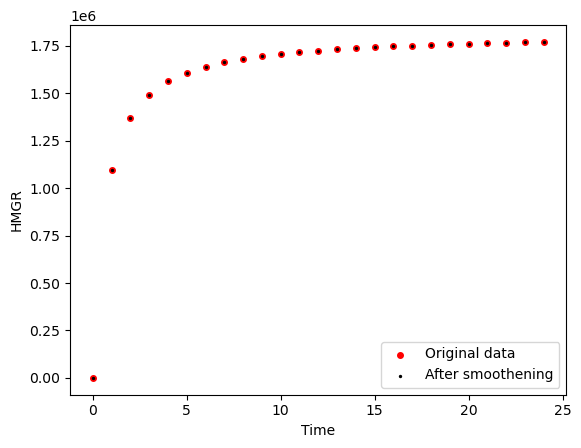

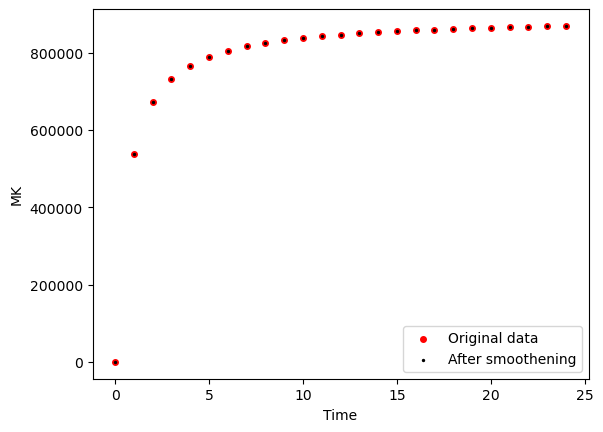

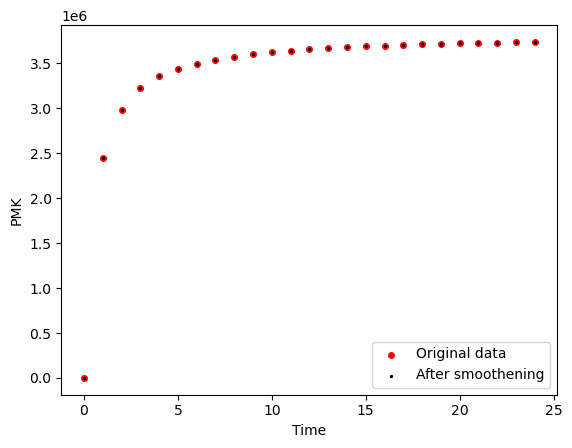

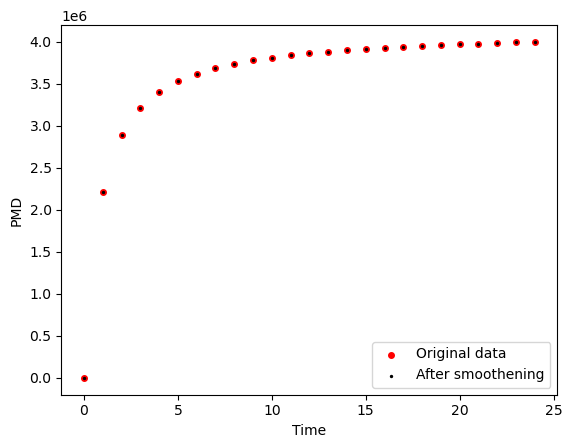

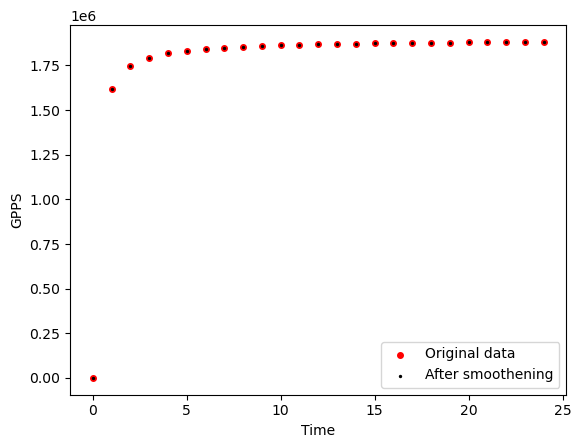

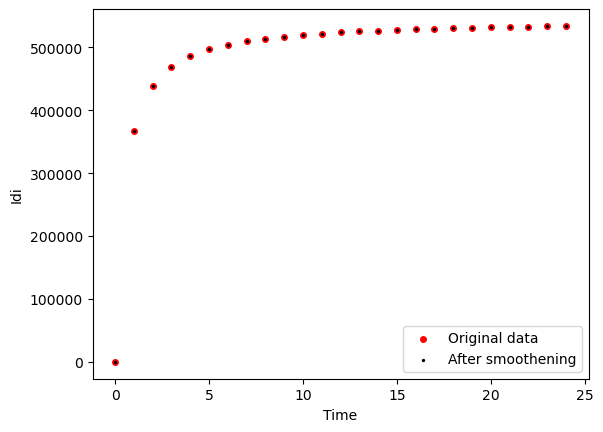

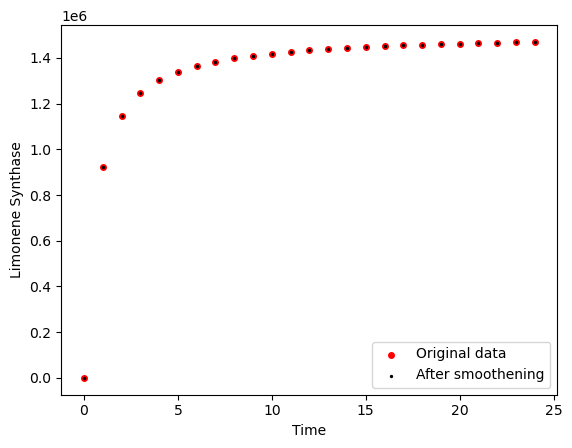

Strain WT


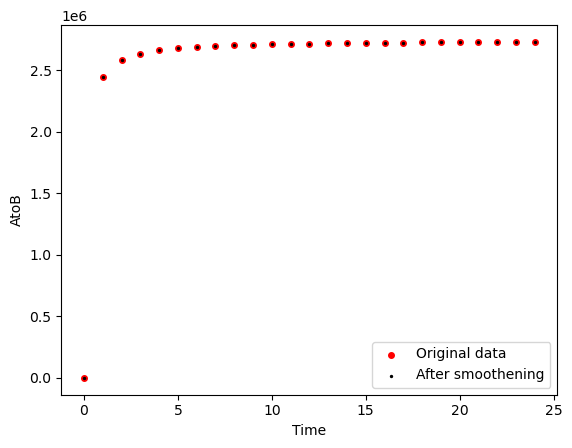

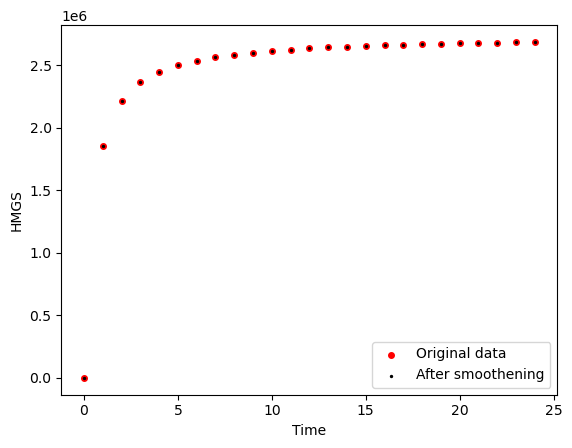

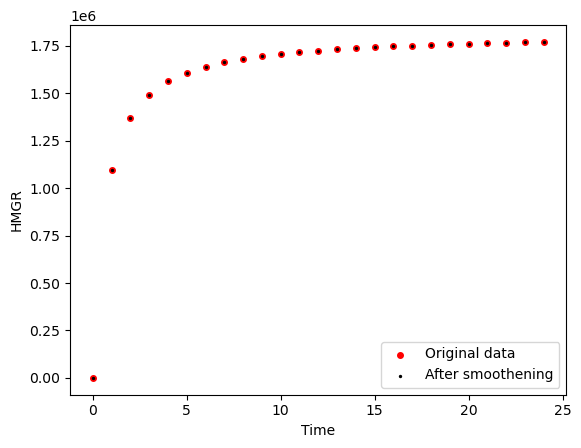

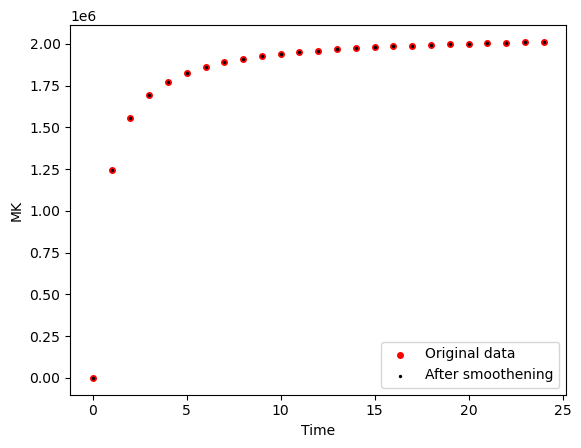

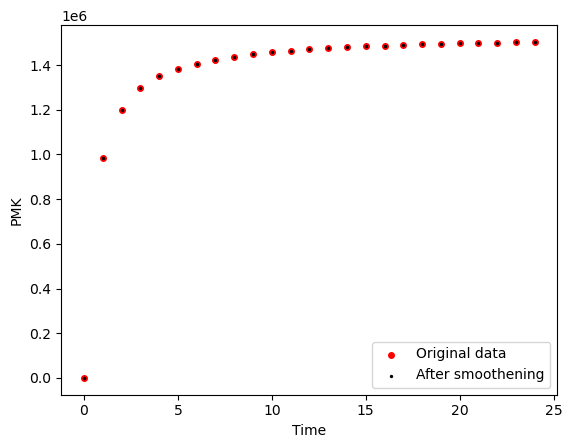

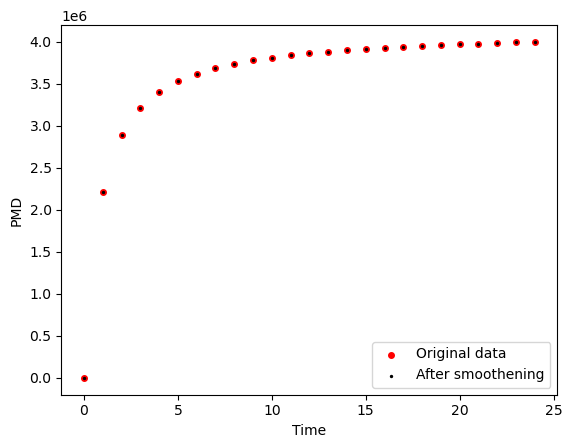

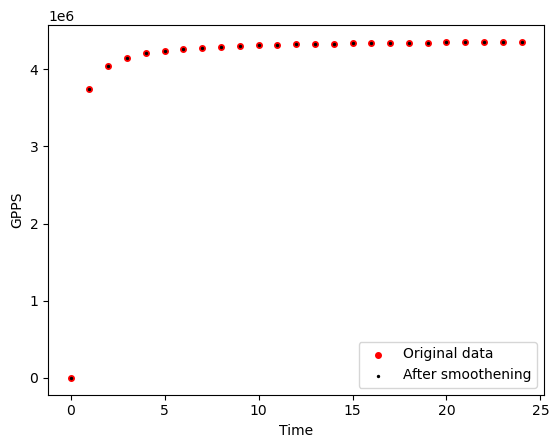

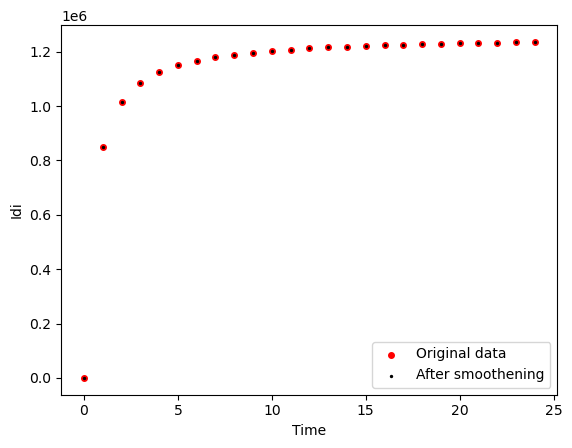

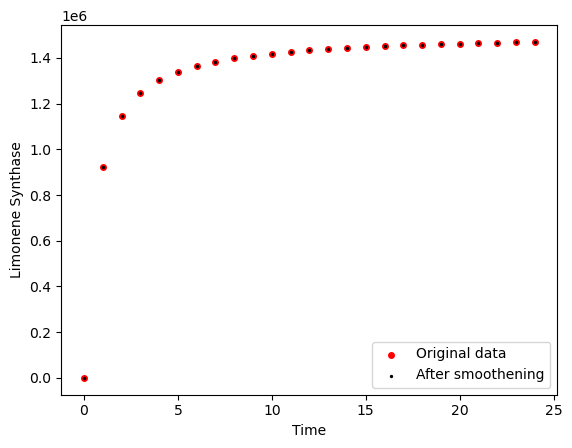

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   
...                  ...             ...       ...       ...       ...   
WT       20.0   0.713891        0.011704  0.014676  0.111284  0.107612   
         21.0   0.735034        0.012518  0.016354  0.111498  0.104796   
         22.0   0.755407        0.013340  0.018112  0.111883  0.102630   
         23.0   0.775039        0.014167  0.019944  0.112389  0.101024   
         24.0   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  ...   
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  ...   
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       20.0  0.321363  0.013792  0.025710  0.107872  0.148511  ...   
         21.0  0.314396  0.013683  0.025209  0.106179  0.161465  ...   
         22.0  0.308770  0.013585  0.024759  0.103766  0.174178  ...   
         23.0  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         24.0  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.012210       -0.025323  0.049557 -0.116634  0.116845   
         1.0    -0.020361       -0.028578  0.012025 -0.052534  0.079720   
         2.0    -0.024295       -0.029832 -0.012811 -0.009729  0.050214   
         3.0    -0.024011       -0.029084 -0.024951  0.011779  0.028324   
         4.0    -0.016954       -0.025651 -0.017762 -0.004429  0.021121   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.021537        0.000809  0.001634  0.000108 -0.003173   
         21.0    0.020754        0.000819  0.001719  0.000310 -0.002476   
         22.0    0.019998        0.000826  0.001797  0.000463 -0.001867   
         23.0    0.019268        0.000828  0.001867  0.000556 -0.001351   
         24.0    0.018565        0.000826  0.001928  0.000590 -0.000928   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.007932 -0.003260 -0.004324  0.002387  0.002370  
         1.0   0.009799 -0.002739 -0.003141  0.000185  0.002985  
         2.0   0.024013 -0.001722 -0.002408 -0.001159  0.003412  
         3.0   0.034710 -0.000208 -0.002125 -0.001644  0.003653  
         4.0   0.043730  0.002514 -0.002840 -0.001579  0.003563  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.007713 -0.000115 -0.000527 -0.001239  0.013045  
         21.0 -0.006265 -0.000104 -0.000476 -0.002097  0.012850  
         22.0 -0.005007 -0.000092 -0.000426 -0.002724  0.012584  
         23.0 -0.003946 -0.000081 -0.000374 -0.003088  0.012228  
         24.0 -0.003082 -0.000068 -0.000320 -0.003188  0.011779

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

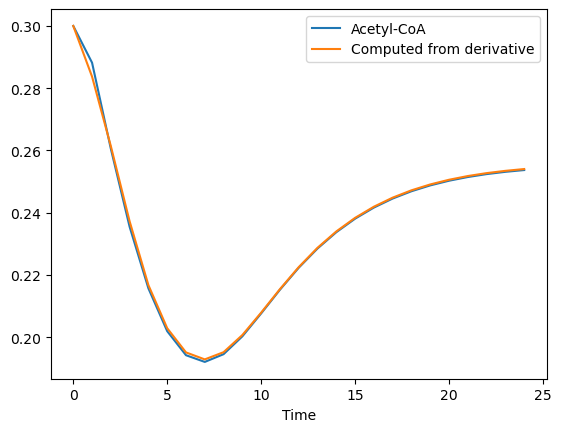

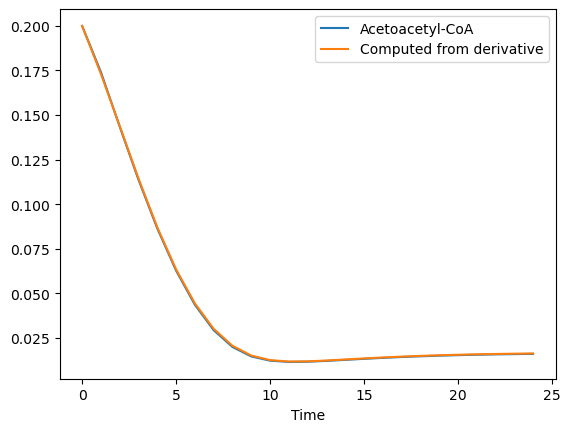

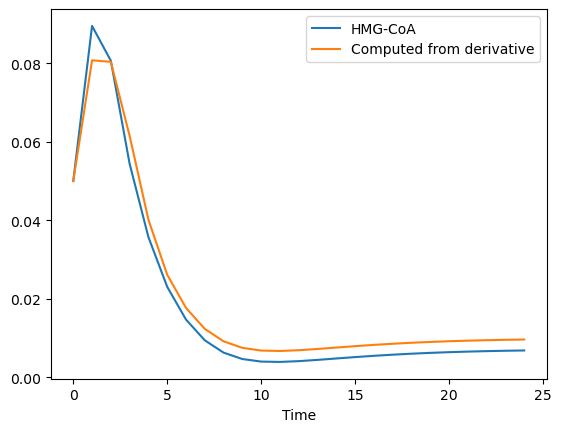

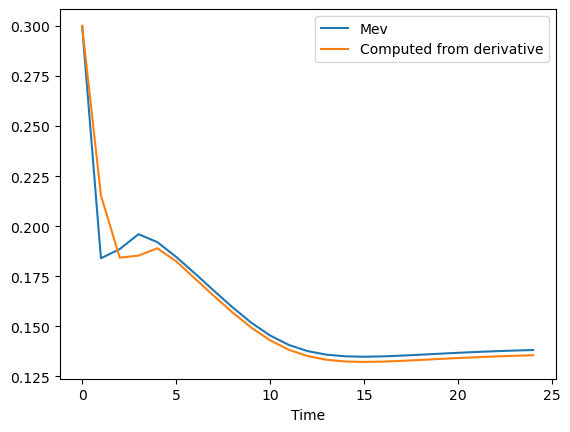

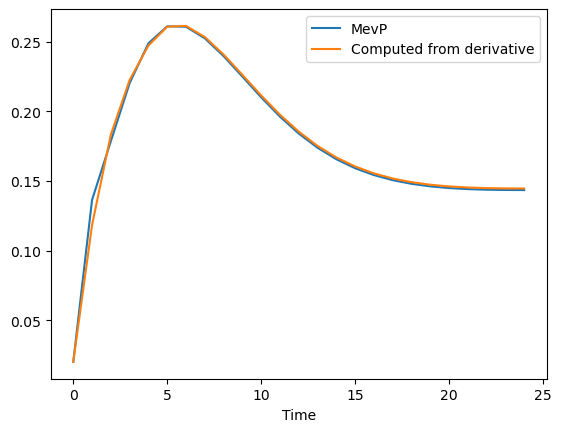

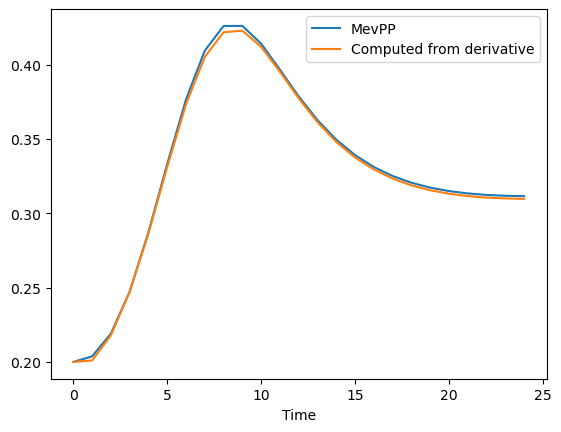

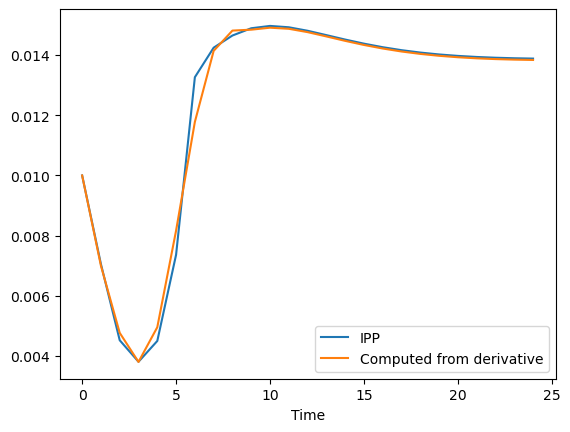

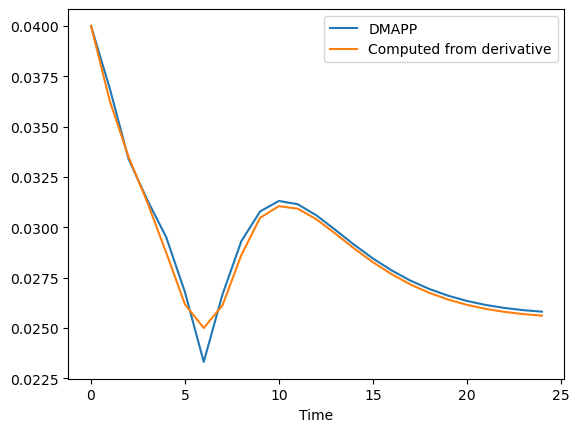

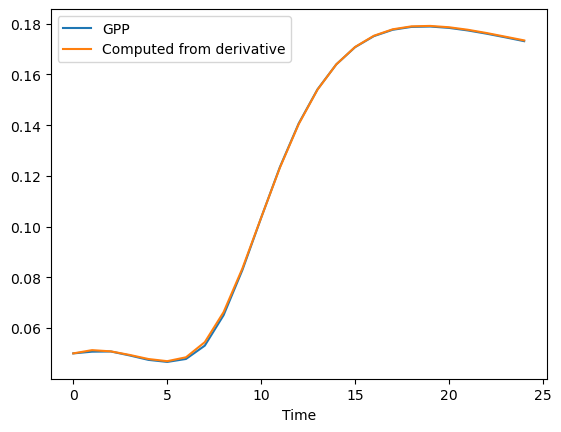

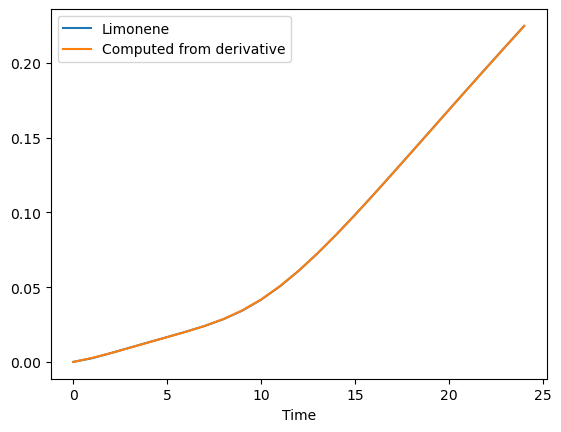

'Time profile from derivative vs. actual profile for Strain 2'

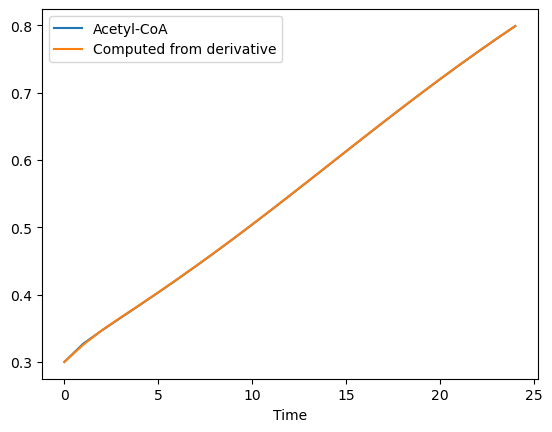

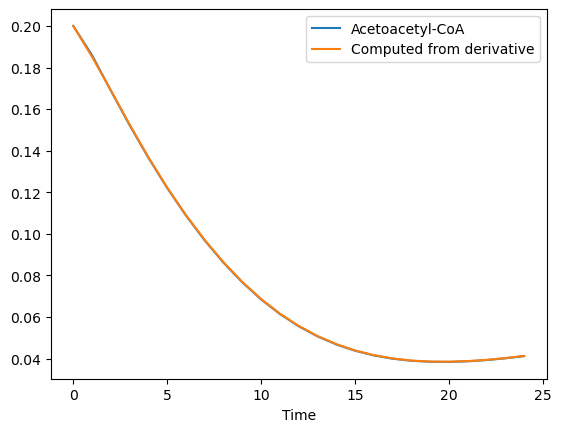

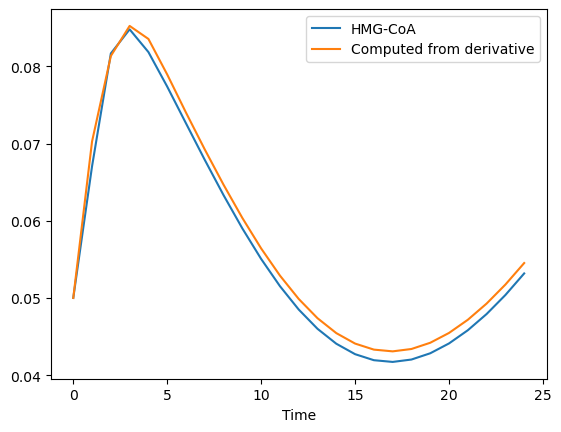

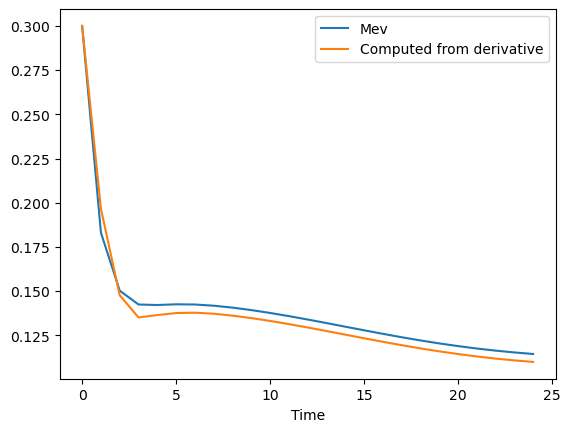

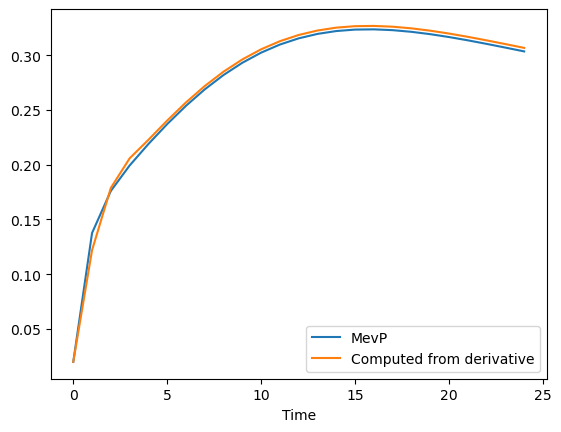

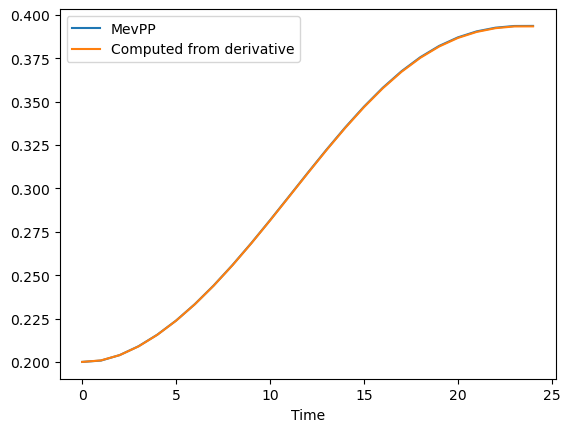

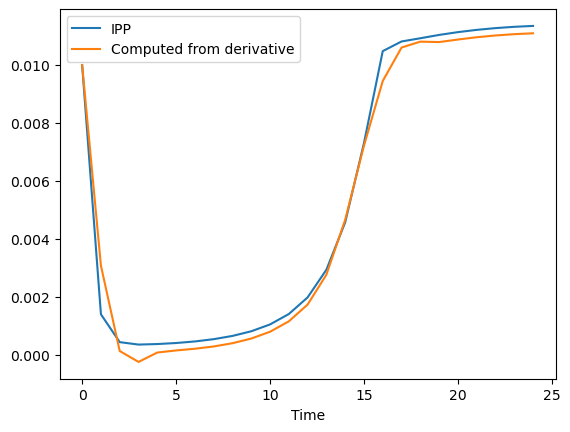

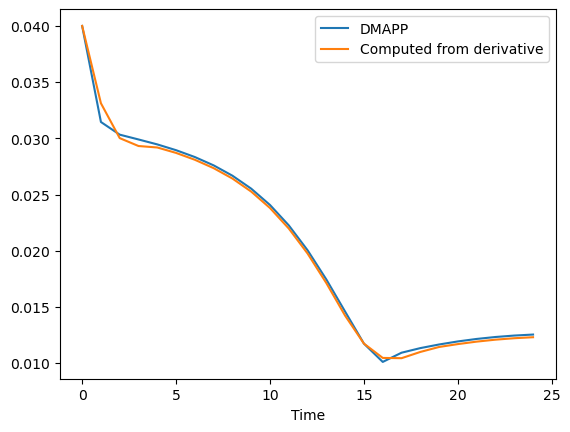

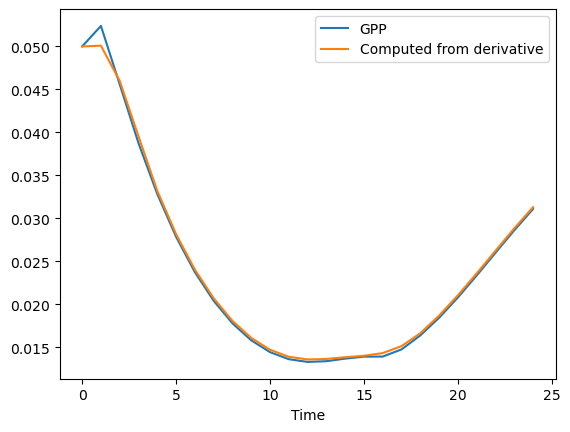

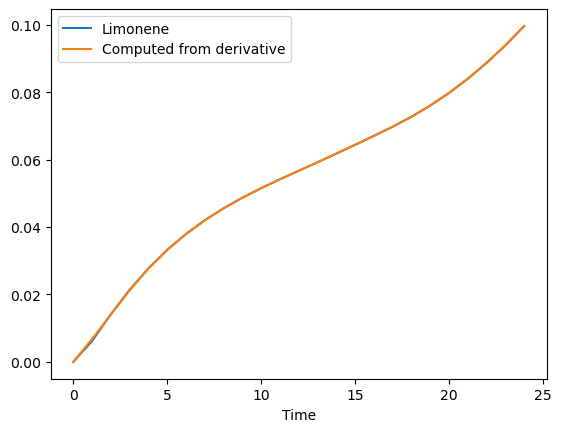

'Time profile from derivative vs. actual profile for Strain 3'

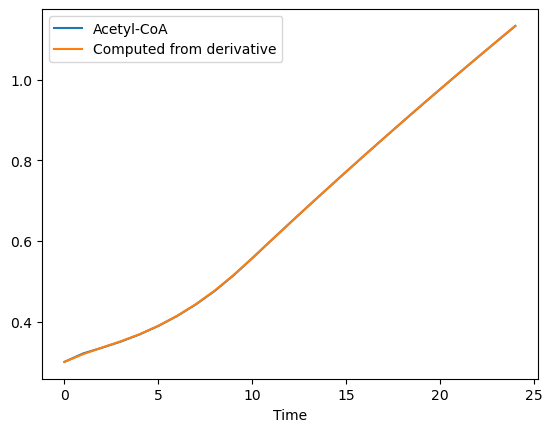

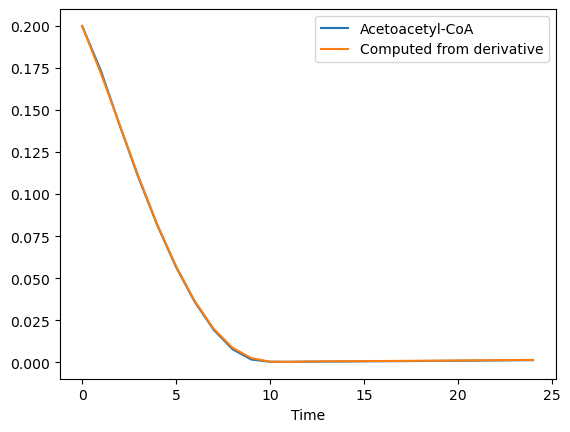

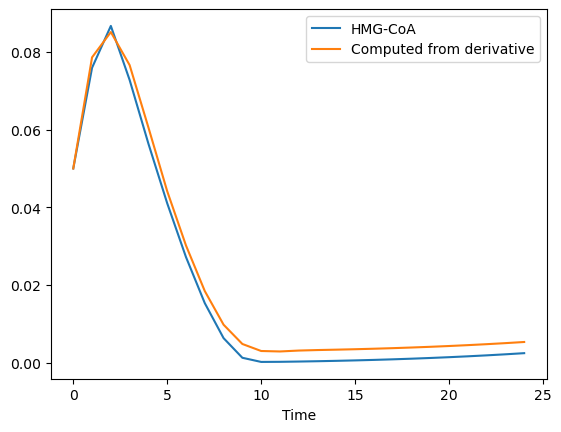

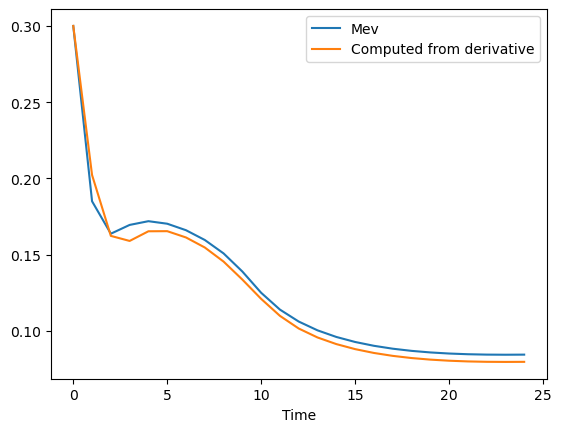

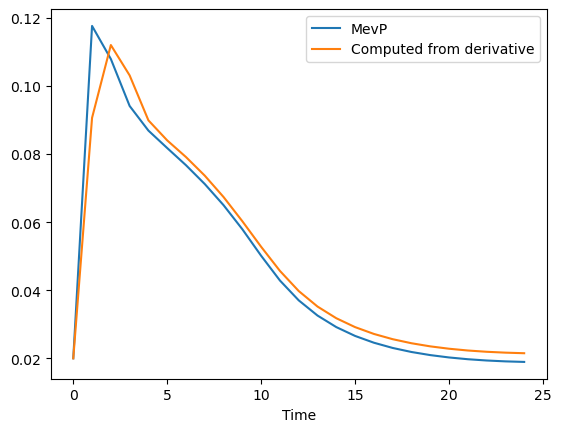

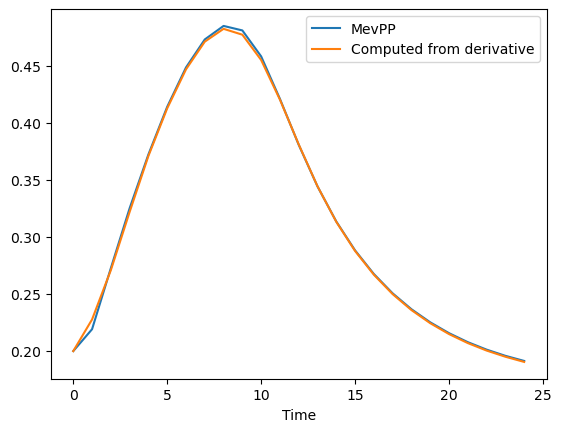

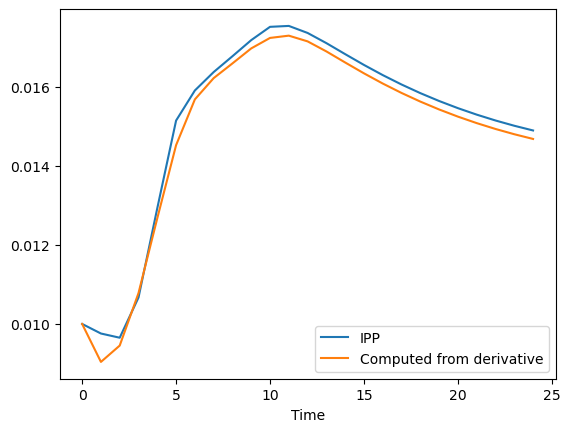

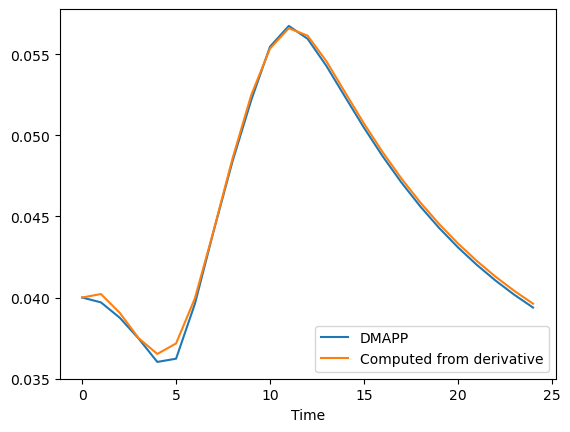

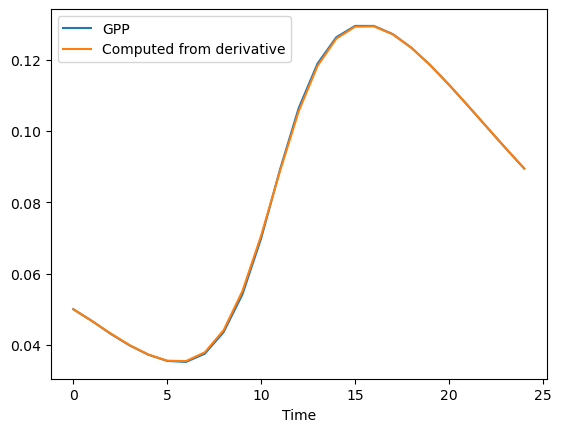

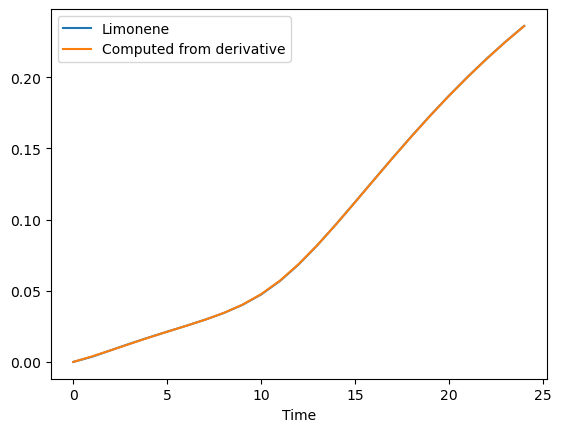

'Time profile from derivative vs. actual profile for WT'

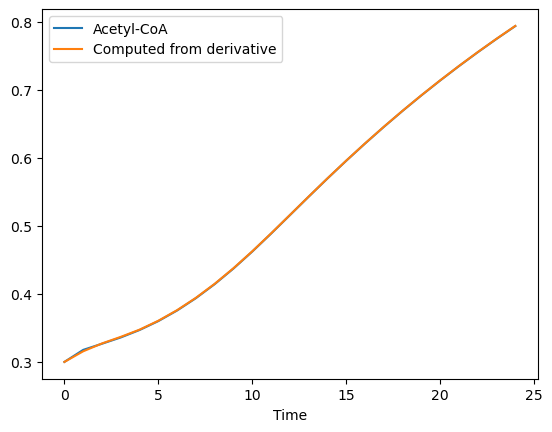

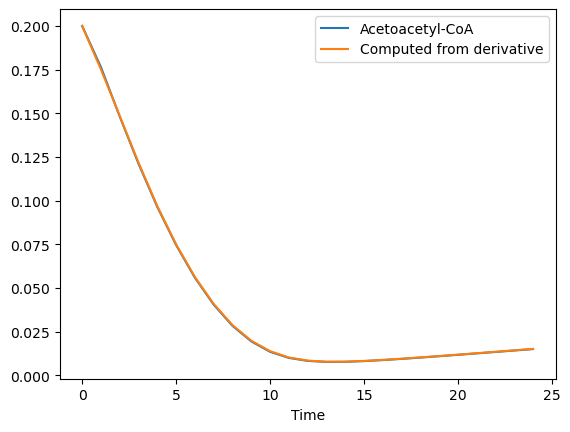

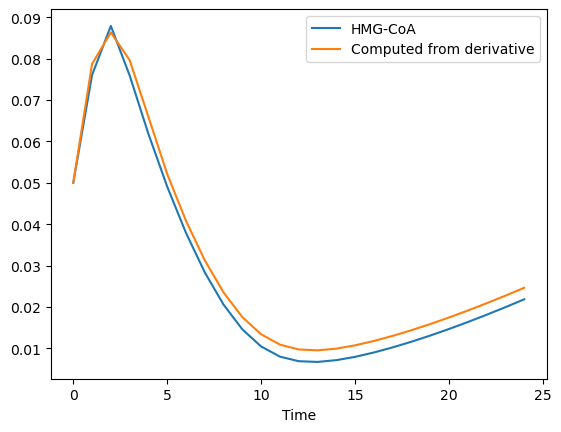

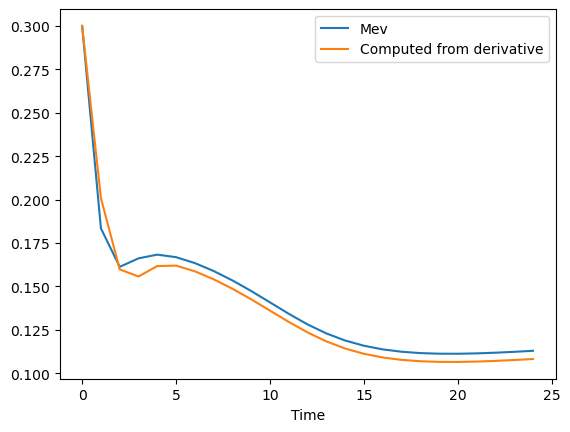

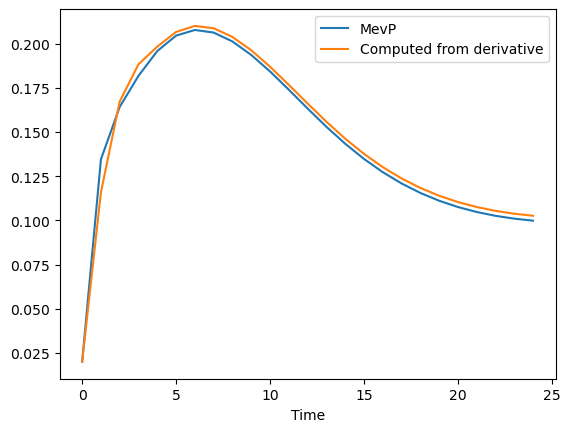

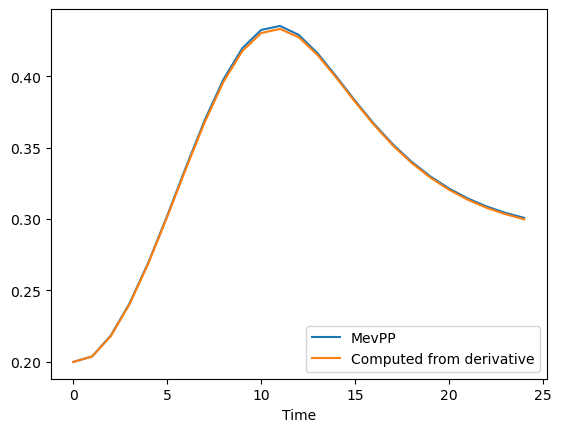

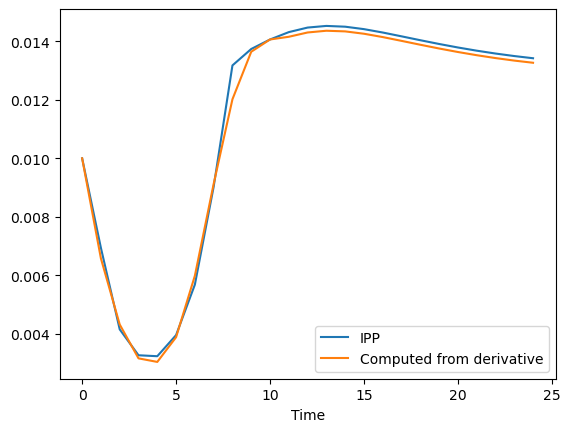

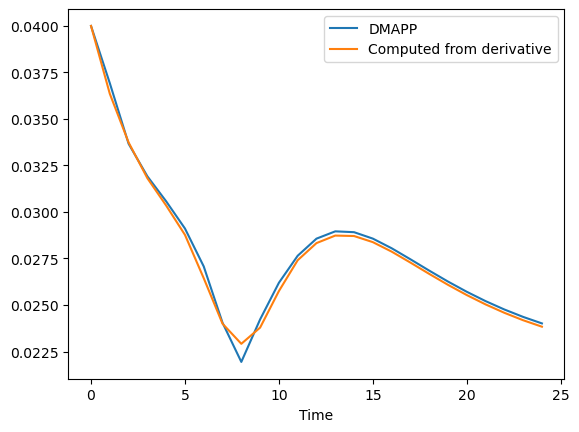

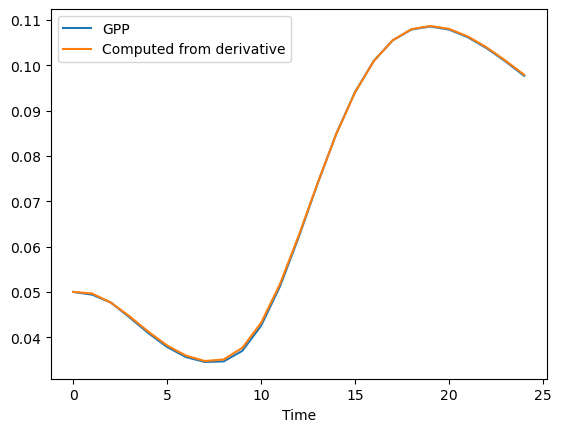

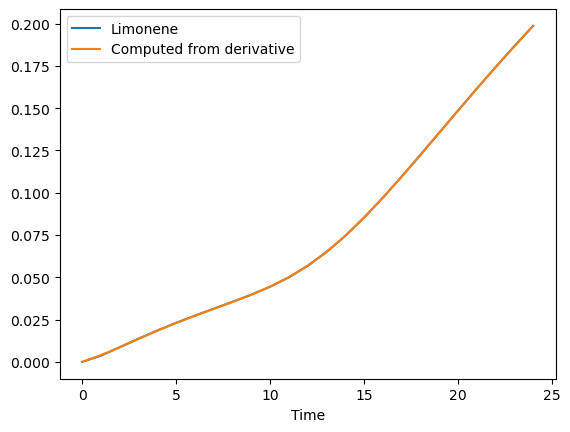

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  5.913288e+05  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  6.444660e+05  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  6.747845e+05  4.412428e+06   
...                     ...           ...           ...           ...   
WT       20.0  2.727222e+06  2.677299e+06  1.760761e+06  2.001420e+06   
         21.0  2.728018e+06  2.680280e+06  1.763434e+06  2.004465e+06   
         22.0  2.728742e+06  2.682996e+06  1.765870e+06  2.007241e+06   
         23.0  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         24.0  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   
...                     ...           ...           ...           ...   
WT       20.0  1.496285e+06  3.969027e+06  4.348970e+06  1.231287e+06   
         21.0  1.498236e+06  3.976909e+06  4.350733e+06  1.232678e+06   
         22.0  1.500014e+06  3.984102e+06  4.352338e+06  1.233945e+06   
         23.0  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         24.0  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.034108e+01   0.300000        0.200000  0.050000   
         1.0       3.981392e+05   0.288190        0.174077  0.089557   
         2.0       4.943155e+05   0.260551        0.143504  0.080676   
         3.0       5.376051e+05   0.235487        0.113697  0.054401   
         4.0       5.622236e+05   0.215716        0.086401  0.035714   
...                         ...        ...             ...       ...   
WT       20.0      1.462098e+06   0.713891        0.011704  0.014676   
         21.0      1.464251e+06   0.735034        0.012518  0.016354   
         22.0      1.466213e+06   0.755407        0.013340  0.018112   
         23.0      1.468009e+06   0.775039        0.014167  0.019944   
         24.0      1.469659e+06   0.793953        0.014996  0.021843   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         1.0   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
         2.0   0.188562  0.178523  0.219000  0.004525  0.033388  0.050751   
         3.0   0.196026  0.220231  0.247211  0.003811  0.031346  0.049192   
         4.0   0.192050  0.248849  0.287262  0.004502  0.029509  0.047445   
...                 ...       ...       ...       ...       ...       ...   
WT       20.0  0.111284  0.107612  0.321363  0.013792  0.025710  0.107872   
         21.0  0.111498  0.104796  0.314396  0.013683  0.025209  0.106179   
         22.0  0.111883  0.102630  0.308770  0.013585  0.024759  0.103766   
         23.0  0.112389  0.101024  0.304

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.012210       -0.025323  0.049557 -0.116634  0.116845   
         1.0    -0.020361       -0.028578  0.012025 -0.052534  0.079720   
         2.0    -0.024295       -0.029832 -0.012811 -0.009729  0.050214   
         3.0    -0.024011       -0.029084 -0.024951  0.011779  0.028324   
         4.0    -0.016954       -0.025651 -0.017762 -0.004429  0.021121   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.021537        0.000809  0.001634  0.000108 -0.003173   
         21.0    0.020754        0.000819  0.001719  0.000310 -0.002476   
         22.0    0.019998        0.000826  0.001797  0.000463 -0.001867   
         23.0    0.019268        0.000828  0.001867  0.000556 -0.001351   
         24.0    0.018565        0.000826  0.001928  0.000590 -0.000928   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.007932 -0.003260 -0.004324  0.002387  0.002370  
         1.0   0.009799 -0.002739 -0.003141  0.000185  0.002985  
         2.0   0.024013 -0.001722 -0.002408 -0.001159  0.003412  
         3.0   0.034710 -0.000208 -0.002125 -0.001644  0.003653  
         4.0   0.043730  0.002514 -0.002840 -0.001579  0.003563  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.007713 -0.000115 -0.000527 -0.001239  0.013045  
         21.0 -0.006265 -0.000104 -0.000476 -0.002097  0.012850  
         22.0 -0.005007 -0.000092 -0.000426 -0.002724  0.012584  
         23.0 -0.003946 -0.000081 -0.000374 -0.003088  0.012228  
         24.0 -0.003082 -0.000068 -0.000320 -0.003188  0.011779  

[100 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.016368E+180 | 1.356332E+108
     2 |       74 | 7.018775E+117 | 3.353761E+106
     3 |      138 | 4.309479E+105 |  3.782555E+86
     4 |      202 |  6.248084E+95 |  5.592479E+77
     5 |      266 |  7.828908E+84 |  9.397459E+71
     6 |      330 |  1.235778E+74 |  1.219052E+61
     7 |      394 |  3.349064E+74 |  9.164490E+55
     8 |      458 |  1.513631E+61 |  9.095783E+50
     9 |      522 |  1.173785E+54 |  5.262703E+46
    10 |      586 |  2.919627E+52 |  2.587170E+42
    11 |      650 |  1.266920E+46 |  1.978605E+38
    12 |      714 |  1.459068E+47 |  2.194345E+36
    13 |      778 |  7.447272E+43 |  5.753630E+31
    14 |      842 |  8.259117E+39 |  6.992462E+29
    15 |      906 |  1.030540E+36 |  4.074418E+28
    16 |      970 |  5.335717E+34 |  7.735118E+26
    17 |     1034 |  7.654441E+31 |  1.452616E+25
    18 |     1098 |  5.158424E+31 |  1.452616E+25
    19 |     1162 |  1.573

   163 |    10378 |  2.311587E+01 |  1.998270E+01
   164 |    10442 |  2.310053E+01 |  1.998270E+01
   165 |    10506 |  2.314223E+01 |  1.998270E+01
   166 |    10570 |  2.305835E+01 |  1.998270E+01
   167 |    10634 |  2.303311E+01 |  1.998270E+01
   168 |    10698 |  2.298151E+01 |  1.998270E+01
   169 |    10762 |  2.288359E+01 |  1.998270E+01
   170 |    10826 |  2.282539E+01 |  1.998270E+01
   171 |    10890 |  2.246124E+01 |  1.998270E+01
   172 |    10954 |  2.270007E+01 |  1.998270E+01
   173 |    11018 |  2.273020E+01 |  1.998270E+01
   174 |    11082 |  2.274128E+01 |  1.998270E+01
   175 |    11146 |  2.283474E+01 |  1.998270E+01
   176 |    11210 |  2.305925E+01 |  1.998270E+01
   177 |    11274 |  2.276706E+01 |  1.998270E+01
   178 |    11338 |  2.270501E+01 |  1.998270E+01
   179 |    11402 |  2.247052E+01 |  1.998270E+01
   180 |    11466 |  2.244504E+01 |  1.998270E+01
   181 |    11530 |  2.234282E+01 |  1.998270E+01
   182 |    11594 |  2.220896E+01 |  1.998270E+01


   327 |    20874 |  2.022023E+01 |  1.472636E+01
   328 |    20938 |  1.961741E+01 |  1.472636E+01
   329 |    21002 |  1.927128E+01 |  1.472636E+01
   330 |    21066 |  1.929609E+01 |  1.472636E+01
   331 |    21130 |  1.915277E+01 |  1.472636E+01
   332 |    21194 |  1.866866E+01 |  1.472636E+01
   333 |    21258 |  1.880029E+01 |  1.472636E+01
   334 |    21322 |  1.895218E+01 |  1.472636E+01
   335 |    21386 |  1.921477E+01 |  1.472636E+01
   336 |    21450 |  1.892994E+01 |  1.472636E+01
   337 |    21514 |  1.934597E+01 |  1.472636E+01
   338 |    21578 |  1.936065E+01 |  1.472636E+01
   339 |    21642 |  1.886031E+01 |  1.472636E+01
   340 |    21706 |  1.822753E+01 |  1.472636E+01
   341 |    21770 |  1.766232E+01 |  1.472636E+01
   342 |    21834 |  1.853416E+01 |  1.472636E+01
   343 |    21898 |  1.854110E+01 |  1.472636E+01
   344 |    21962 |  1.836660E+01 |  1.472636E+01
   345 |    22026 |  1.761517E+01 |  1.472636E+01
   346 |    22090 |  1.767932E+01 |  1.469680E+01


   491 |    31370 |  1.198664E+01 |  1.098870E+01
   492 |    31434 |  1.193687E+01 |  1.098870E+01
   493 |    31498 |  1.196756E+01 |  1.098870E+01
   494 |    31562 |  1.198109E+01 |  1.098870E+01
   495 |    31626 |  1.191914E+01 |  1.098870E+01
   496 |    31690 |  1.191954E+01 |  1.098870E+01
   497 |    31754 |  1.187358E+01 |  1.098870E+01
   498 |    31818 |  1.181153E+01 |  1.098870E+01
   499 |    31882 |  1.184650E+01 |  1.098870E+01
   500 |    31946 |  1.194192E+01 |  1.098870E+01
   501 |    32010 |  1.191842E+01 |  1.098870E+01
   502 |    32074 |  1.185302E+01 |  1.098870E+01
   503 |    32138 |  1.179408E+01 |  1.098870E+01
   504 |    32202 |  1.189853E+01 |  1.098870E+01
   505 |    32266 |  1.190376E+01 |  1.098870E+01
   506 |    32330 |  1.184587E+01 |  1.098870E+01
   507 |    32394 |  1.183520E+01 |  1.098870E+01
   508 |    32458 |  1.186511E+01 |  1.098870E+01
   509 |    32522 |  1.187154E+01 |  1.098870E+01
   510 |    32586 |  1.188651E+01 |  1.098870E+01


   655 |    41866 |  9.8106063036 |  9.5861016167
   656 |    41930 |  9.7891390267 |  9.5861016167
   657 |    41994 |  9.8086229846 |  9.5861016167
   658 |    42058 |  9.6922536857 |  9.4529488794
   659 |    42122 |  9.7069700708 |  9.4529488794
   660 |    42186 |  9.6805958086 |  9.4529488794
   661 |    42250 |  9.6705462480 |  9.4529488794
   662 |    42314 |  9.5774174996 |  9.3819778048
   663 |    42378 |  9.6310808091 |  9.3819778048
   664 |    42442 |  9.6449915135 |  9.3819778048
   665 |    42506 |  9.6572910223 |  9.3819778048
   666 |    42570 |  9.7304423774 |  9.3819778048
   667 |    42634 |  9.7251634849 |  9.3819778048
   668 |    42698 |  9.6988354464 |  9.3819778048
   669 |    42762 |  9.6664276887 |  9.3819778048
   670 |    42826 |  9.7356822866 |  9.3819778048
   671 |    42890 |  9.6980138090 |  9.3819778048
   672 |    42954 |  9.6136613033 |  9.3819778048
   673 |    43018 |  9.6019478507 |  9.3819778048
   674 |    43082 |  9.5889634486 |  9.3819778048


   819 |    52362 |  8.9230234795 |  8.7989968042
   820 |    52426 |  8.9026268233 |  8.7989968042
   821 |    52490 |  8.9009053451 |  8.7989968042
   822 |    52554 |  8.9122716355 |  8.7989968042
   823 |    52618 |  8.9091594324 |  8.7989968042
   824 |    52682 |  8.9243491519 |  8.7989968042
   825 |    52746 |  8.9313677155 |  8.7866410346
   826 |    52810 |  8.9455053459 |  8.7866410346
   827 |    52874 |  8.9386153273 |  8.7866410346
   828 |    52938 |  8.9375436035 |  8.7866410346
   829 |    53002 |  8.9368127750 |  8.7866410346
   830 |    53066 |  8.9225681089 |  8.7866410346
   831 |    53130 |  8.9206290769 |  8.7866410346
   832 |    53194 |  8.9113570985 |  8.7866410346
   833 |    53258 |  8.9006357879 |  8.7825058018
   834 |    53322 |  8.9041947076 |  8.7825058018
   835 |    53386 |  8.9227947752 |  8.7825058018
   836 |    53450 |  8.9352349777 |  8.7825058018
   837 |    53514 |  8.9545125667 |  8.7825058018
   838 |    53578 |  8.9094506560 |  8.7825058018


   983 |    62858 |  8.7209833944 |  8.6329870795
   984 |    62922 |  8.7141710520 |  8.6329870795
   985 |    62986 |  8.7038768036 |  8.6269072452
   986 |    63050 |  8.7188309263 |  8.6269072452
   987 |    63114 |  8.7285353466 |  8.6269072452
   988 |    63178 |  8.7310481435 |  8.6269072452
   989 |    63242 |  8.7528017278 |  8.6269072452
   990 |    63306 |  8.7429443106 |  8.6269072452
   991 |    63370 |  8.7286172040 |  8.6269072452
   992 |    63434 |  8.7366386768 |  8.6269072452
   993 |    63498 |  8.7270674417 |  8.6269072452
   994 |    63562 |  8.6968263042 |  8.6269072452
   995 |    63626 |  8.7482234347 |  8.6269072452
   996 |    63690 |  8.7455134896 |  8.6269072452
   997 |    63754 |  8.7276201959 |  8.6269072452
   998 |    63818 |  8.7297143420 |  8.6269072452
   999 |    63882 |  8.6987806473 |  8.6269072452
  1000 |    63946 |  8.7027650955 |  8.6269072452
  1001 |    64010 |  8.7167107697 |  8.6269072452
  1002 |    64074 |  8.7235133962 |  8.6269072452


  1147 |    73354 |  8.4906008064 |  8.4866432044
  1148 |    73418 |  8.4900140225 |  8.4866432044
  1149 |    73482 |  8.4890402847 |  8.4866432044
  1150 |    73546 |  8.4882100834 |  8.4860493550
  1151 |    73610 |  8.4877584404 |  8.4859112150
  1152 |    73674 |  8.4877683545 |  8.4859112150
  1153 |    73738 |  8.4870544179 |  8.4856042153
  1154 |    73802 |  8.4863616997 |  8.4851023444
  1155 |    73866 |  8.4868390771 |  8.4841688611
  1156 |    73930 |  8.4857483124 |  8.4841357855
  1157 |    73994 |  8.4858024760 |  8.4841357855
  1158 |    74058 |  8.4853147664 |  8.4834056686
  1159 |    74122 |  8.4855513037 |  8.4834056686
  1160 |    74186 |  8.4855963826 |  8.4830118712
  1161 |    74250 |  8.4847926556 |  8.4830118712
  1162 |    74314 |  8.4848665378 |  8.4824805267
  1163 |    74378 |  8.4858828705 |  8.4824805267
  1164 |    74442 |  8.4853936763 |  8.4819678531
  1165 |    74506 |  8.4844908036 |  8.4819678531
  1166 |    74570 |  8.4836546968 |  8.4816366918


  1311 |    83850 |  8.4647470949 |  8.4645503420
  1312 |    83914 |  8.4646754607 |  8.4644198885
  1313 |    83978 |  8.4646163893 |  8.4644113744
  1314 |    84042 |  8.4646164147 |  8.4644113744
  1315 |    84106 |  8.4645909972 |  8.4643861935
  1316 |    84170 |  8.4645704814 |  8.4643671926
  1317 |    84234 |  8.4643801014 |  8.4642063836
  1318 |    84298 |  8.4641998652 |  8.4639477653
  1319 |    84362 |  8.4640846144 |  8.4637353550
  1320 |    84426 |  8.4638853582 |  8.4634929703
  1321 |    84490 |  8.4636904570 |  8.4634929703
  1322 |    84554 |  8.4636333084 |  8.4634929703
  1323 |    84618 |  8.4635192629 |  8.4634328560
  1324 |    84682 |  8.4634289861 |  8.4632616996
  1325 |    84746 |  8.4632567492 |  8.4628970922
  1326 |    84810 |  8.4630885030 |  8.4628970922
  1327 |    84874 |  8.4628984789 |  8.4627924855
  1328 |    84938 |  8.4628191978 |  8.4626802680
  1329 |    85002 |  8.4627686890 |  8.4626744255
  1330 |    85066 |  8.4627614723 |  8.4625889002


  1475 |    94346 |  8.4315748880 |  8.4308535283
  1476 |    94410 |  8.4311800163 |  8.4299557920
  1477 |    94474 |  8.4307325529 |  8.4299557920
  1478 |    94538 |  8.4299922503 |  8.4295139856
  1479 |    94602 |  8.4295080527 |  8.4286452102
  1480 |    94666 |  8.4292864965 |  8.4286452102
  1481 |    94730 |  8.4291983873 |  8.4286452102
  1482 |    94794 |  8.4292855788 |  8.4286452102
  1483 |    94858 |  8.4289904308 |  8.4284103721
  1484 |    94922 |  8.4286774380 |  8.4281044255
  1485 |    94986 |  8.4282897632 |  8.4277619708
  1486 |    95050 |  8.4280044371 |  8.4275156904
  1487 |    95114 |  8.4275423737 |  8.4266074652
  1488 |    95178 |  8.4267790331 |  8.4260642280
  1489 |    95242 |  8.4264193859 |  8.4254662040
  1490 |    95306 |  8.4258470631 |  8.4246221504
  1491 |    95370 |  8.4251626531 |  8.4245965015
  1492 |    95434 |  8.4250371228 |  8.4241776073
  1493 |    95498 |  8.4248263464 |  8.4241776073
  1494 |    95562 |  8.4241831721 |  8.4225820081


  1639 |   104842 |  8.3241423958 |  8.3238242716
  1640 |   104906 |  8.3239711472 |  8.3237672316
  1641 |   104970 |  8.3237944679 |  8.3236128925
  1642 |   105034 |  8.3237419206 |  8.3233526832
  1643 |   105098 |  8.3236172452 |  8.3233526832
  1644 |   105162 |  8.3234885046 |  8.3231951539
  1645 |   105226 |  8.3232735674 |  8.3229443962
  1646 |   105290 |  8.3230126039 |  8.3228784605
  1647 |   105354 |  8.3229573092 |  8.3227796572
  1648 |   105418 |  8.3229300799 |  8.3226053377
  1649 |   105482 |  8.3227213698 |  8.3223672759
  1650 |   105546 |  8.3225725363 |  8.3221562182
  1651 |   105610 |  8.3224764406 |  8.3221562182
  1652 |   105674 |  8.3222689829 |  8.3221087828
  1653 |   105738 |  8.3222192678 |  8.3221020676
  1654 |   105802 |  8.3218987427 |  8.3215655446
  1655 |   105866 |  8.3217354509 |  8.3214752169
  1656 |   105930 |  8.3216262675 |  8.3211919605
  1657 |   105994 |  8.3214833143 |  8.3211919605
  1658 |   106058 |  8.3214414676 |  8.3211800157


  1803 |   115338 |  8.2878759900 |  8.2868810443
  1804 |   115402 |  8.2871580418 |  8.2864872067
  1805 |   115466 |  8.2867183078 |  8.2860384609
  1806 |   115530 |  8.2864575036 |  8.2858478829
  1807 |   115594 |  8.2861844789 |  8.2856593481
  1808 |   115658 |  8.2861254098 |  8.2854231089
  1809 |   115722 |  8.2856847446 |  8.2848747999
  1810 |   115786 |  8.2852068752 |  8.2848086666
  1811 |   115850 |  8.2851028054 |  8.2840852658
  1812 |   115914 |  8.2846457376 |  8.2837711062
  1813 |   115978 |  8.2845746137 |  8.2837711062
  1814 |   116042 |  8.2844349866 |  8.2837229520
  1815 |   116106 |  8.2838429979 |  8.2831420611
  1816 |   116170 |  8.2838771062 |  8.2831420611
  1817 |   116234 |  8.2836489246 |  8.2826965135
  1818 |   116298 |  8.2830152036 |  8.2826955395
  1819 |   116362 |  8.2829575718 |  8.2824258754
  1820 |   116426 |  8.2828935850 |  8.2823372319
  1821 |   116490 |  8.2824720814 |  8.2815462669
  1822 |   116554 |  8.2820260031 |  8.2815462669


  1967 |   125834 |  8.1966200886 |  8.1960947790
  1968 |   125898 |  8.1965994584 |  8.1955703386
  1969 |   125962 |  8.1959371750 |  8.1950032342
  1970 |   126026 |  8.1956730806 |  8.1944292724
  1971 |   126090 |  8.1952601403 |  8.1944292724
  1972 |   126154 |  8.1941639418 |  8.1922489112
  1973 |   126218 |  8.1931504381 |  8.1921405613
  1974 |   126282 |  8.1926620493 |  8.1910064237
  1975 |   126346 |  8.1912940965 |  8.1890820513
  1976 |   126410 |  8.1905540333 |  8.1887212165
  1977 |   126474 |  8.1898675094 |  8.1886285656
  1978 |   126538 |  8.1890786708 |  8.1880048391
  1979 |   126602 |  8.1878479842 |  8.1868168439
  1980 |   126666 |  8.1881563474 |  8.1868168439
  1981 |   126730 |  8.1878819714 |  8.1861326221
  1982 |   126794 |  8.1873901422 |  8.1861312880
  1983 |   126858 |  8.1867856674 |  8.1849525540
  1984 |   126922 |  8.1866103315 |  8.1849525540
  1985 |   126986 |  8.1855802769 |  8.1849503919
  1986 |   127050 |  8.1853315016 |  8.1848061843


  2131 |   136330 |  8.1147226601 |  8.1131067979
  2132 |   136394 |  8.1143827417 |  8.1131067979
  2133 |   136458 |  8.1139244894 |  8.1131067979
  2134 |   136522 |  8.1138010810 |  8.1120148270
  2135 |   136586 |  8.1131427742 |  8.1120148270
  2136 |   136650 |  8.1128717845 |  8.1120148270
  2137 |   136714 |  8.1122652507 |  8.1107679988
  2138 |   136778 |  8.1117190437 |  8.1106482831
  2139 |   136842 |  8.1113659833 |  8.1104809176
  2140 |   136906 |  8.1107158495 |  8.1089843957
  2141 |   136970 |  8.1101812043 |  8.1083038138
  2142 |   137034 |  8.1095086956 |  8.1083038138
  2143 |   137098 |  8.1093123895 |  8.1083038138
  2144 |   137162 |  8.1083935134 |  8.1074924361
  2145 |   137226 |  8.1077337412 |  8.1066606999
  2146 |   137290 |  8.1072071507 |  8.1058851857
  2147 |   137354 |  8.1067128870 |  8.1058851857
  2148 |   137418 |  8.1065332007 |  8.1056982393
  2149 |   137482 |  8.1062299820 |  8.1056982393
  2150 |   137546 |  8.1059712505 |  8.1054530831


  2295 |   146826 |  8.0237993704 |  8.0225369101
  2296 |   146890 |  8.0234205370 |  8.0221953659
  2297 |   146954 |  8.0231107543 |  8.0221953659
  2298 |   147018 |  8.0230452227 |  8.0221692705
  2299 |   147082 |  8.0231350643 |  8.0221692705
  2300 |   147146 |  8.0226751488 |  8.0217566947
  2301 |   147210 |  8.0223977063 |  8.0211827410
  2302 |   147274 |  8.0218598810 |  8.0202972433
  2303 |   147338 |  8.0212335066 |  8.0202972433
  2304 |   147402 |  8.0209879449 |  8.0202972433
  2305 |   147466 |  8.0211127902 |  8.0202972433
  2306 |   147530 |  8.0207038756 |  8.0196309671
  2307 |   147594 |  8.0201741371 |  8.0189333022
  2308 |   147658 |  8.0198448868 |  8.0189333022
  2309 |   147722 |  8.0196853404 |  8.0189333022
  2310 |   147786 |  8.0193337545 |  8.0186439620
  2311 |   147850 |  8.0188904002 |  8.0180915699
  2312 |   147914 |  8.0185416523 |  8.0178122932
  2313 |   147978 |  8.0183874309 |  8.0175404349
  2314 |   148042 |  8.0179769550 |  8.0175404349


  2459 |   157322 |  7.9635581288 |  7.9623664635
  2460 |   157386 |  7.9629340116 |  7.9616486156
  2461 |   157450 |  7.9621090676 |  7.9612510861
  2462 |   157514 |  7.9622617574 |  7.9612510861
  2463 |   157578 |  7.9611880797 |  7.9598670657
  2464 |   157642 |  7.9605345728 |  7.9598670657
  2465 |   157706 |  7.9598208110 |  7.9590191346
  2466 |   157770 |  7.9593603025 |  7.9586915447
  2467 |   157834 |  7.9588018765 |  7.9574303540
  2468 |   157898 |  7.9579811444 |  7.9569533845
  2469 |   157962 |  7.9572378903 |  7.9567257908
  2470 |   158026 |  7.9568744918 |  7.9556423594
  2471 |   158090 |  7.9564285900 |  7.9555334960
  2472 |   158154 |  7.9558866880 |  7.9549451221
  2473 |   158218 |  7.9552709866 |  7.9543032323
  2474 |   158282 |  7.9548186993 |  7.9534139244
  2475 |   158346 |  7.9542409580 |  7.9534139244
  2476 |   158410 |  7.9538921663 |  7.9526769239
  2477 |   158474 |  7.9531261528 |  7.9514090266
  2478 |   158538 |  7.9524000355 |  7.9514090266


  2623 |   167818 |  7.7911110682 |  7.7882243217
  2624 |   167882 |  7.7911712810 |  7.7882243217
  2625 |   167946 |  7.7897499484 |  7.7877372838
  2626 |   168010 |  7.7894362405 |  7.7876209108
  2627 |   168074 |  7.7879003799 |  7.7864587739
  2628 |   168138 |  7.7880173925 |  7.7864587739
  2629 |   168202 |  7.7869957447 |  7.7859506311
  2630 |   168266 |  7.7863556689 |  7.7854073000
  2631 |   168330 |  7.7858281644 |  7.7848076442
  2632 |   168394 |  7.7848822963 |  7.7841135557
  2633 |   168458 |  7.7843298814 |  7.7826691068
  2634 |   168522 |  7.7844909836 |  7.7826691068
  2635 |   168586 |  7.7841493712 |  7.7826691068
  2636 |   168650 |  7.7842443819 |  7.7826691068
  2637 |   168714 |  7.7840374898 |  7.7826691068
  2638 |   168778 |  7.7835026839 |  7.7820368221
  2639 |   168842 |  7.7832513736 |  7.7820368221
  2640 |   168906 |  7.7829351886 |  7.7820368221
  2641 |   168970 |  7.7833673273 |  7.7820368221
  2642 |   169034 |  7.7828000840 |  7.7818128328


  2787 |   178314 |  7.6969134659 |  7.6952999476
  2788 |   178378 |  7.6961325763 |  7.6952999476
  2789 |   178442 |  7.6958648316 |  7.6939572558
  2790 |   178506 |  7.6950230877 |  7.6939572558
  2791 |   178570 |  7.6940554010 |  7.6917406160
  2792 |   178634 |  7.6929250431 |  7.6907364562
  2793 |   178698 |  7.6914409617 |  7.6902123695
  2794 |   178762 |  7.6898900924 |  7.6886617396
  2795 |   178826 |  7.6887924019 |  7.6860963111
  2796 |   178890 |  7.6868061860 |  7.6850046704
  2797 |   178954 |  7.6855100663 |  7.6847290413
  2798 |   179018 |  7.6841588985 |  7.6812137621
  2799 |   179082 |  7.6823772903 |  7.6798720455
  2800 |   179146 |  7.6815805239 |  7.6798720455
  2801 |   179210 |  7.6803938794 |  7.6781101377
  2802 |   179274 |  7.6806702848 |  7.6776153393
  2803 |   179338 |  7.6790562189 |  7.6756550289
  2804 |   179402 |  7.6771708644 |  7.6750793636
  2805 |   179466 |  7.6757630253 |  7.6727660775
  2806 |   179530 |  7.6745374972 |  7.6727660775


  2951 |   188810 |  7.6130138832 |  7.6124268000
  2952 |   188874 |  7.6126566864 |  7.6120565894
  2953 |   188938 |  7.6121910120 |  7.6120167392
  2954 |   189002 |  7.6120480320 |  7.6117178522
  2955 |   189066 |  7.6119159858 |  7.6114922645
  2956 |   189130 |  7.6115418447 |  7.6112046301
  2957 |   189194 |  7.6114277517 |  7.6111722990
  2958 |   189258 |  7.6112971744 |  7.6109582415
  2959 |   189322 |  7.6110893549 |  7.6108750054
  2960 |   189386 |  7.6109658405 |  7.6108065100
  2961 |   189450 |  7.6108217808 |  7.6104863282
  2962 |   189514 |  7.6106900025 |  7.6102195643
  2963 |   189578 |  7.6105262598 |  7.6100955335
  2964 |   189642 |  7.6102478765 |  7.6098251386
  2965 |   189706 |  7.6099974822 |  7.6094761559
  2966 |   189770 |  7.6099377424 |  7.6094497213
  2967 |   189834 |  7.6096674813 |  7.6092230477
  2968 |   189898 |  7.6093935667 |  7.6088391938
  2969 |   189962 |  7.6092887894 |  7.6088391938
  2970 |   190026 |  7.6092339972 |  7.6088391938


  3115 |   199306 |  7.5506232299 |  7.5496180504
  3116 |   199370 |  7.5491650076 |  7.5478940168
  3117 |   199434 |  7.5485753703 |  7.5478940168
  3118 |   199498 |  7.5481978106 |  7.5476188568
  3119 |   199562 |  7.5474928772 |  7.5459162802
  3120 |   199626 |  7.5463735518 |  7.5436725023
  3121 |   199690 |  7.5447965188 |  7.5428925236
  3122 |   199754 |  7.5436423234 |  7.5428925236
  3123 |   199818 |  7.5430064389 |  7.5418392781
  3124 |   199882 |  7.5423654581 |  7.5412883483
  3125 |   199946 |  7.5414840107 |  7.5405346138
  3126 |   200010 |  7.5412468569 |  7.5405037938
  3127 |   200074 |  7.5408973384 |  7.5393263732
  3128 |   200138 |  7.5403486721 |  7.5389188752
  3129 |   200202 |  7.5398546040 |  7.5387334480
  3130 |   200266 |  7.5393079742 |  7.5380686262
  3131 |   200330 |  7.5382461333 |  7.5372471530
  3132 |   200394 |  7.5378301575 |  7.5358058526
  3133 |   200458 |  7.5364326887 |  7.5350415896
  3134 |   200522 |  7.5360654279 |  7.5348274981


  3279 |   209802 |  7.4254773278 |  7.4241164529
  3280 |   209866 |  7.4244995261 |  7.4233368785
  3281 |   209930 |  7.4236469503 |  7.4214713409
  3282 |   209994 |  7.4223224196 |  7.4208442771
  3283 |   210058 |  7.4212005107 |  7.4203928397
  3284 |   210122 |  7.4198759927 |  7.4191836267
  3285 |   210186 |  7.4191259729 |  7.4185415091
  3286 |   210250 |  7.4188378584 |  7.4178491873
  3287 |   210314 |  7.4180335614 |  7.4172037616
  3288 |   210378 |  7.4172128791 |  7.4156471845
  3289 |   210442 |  7.4159352547 |  7.4139590707
  3290 |   210506 |  7.4148916398 |  7.4139421739
  3291 |   210570 |  7.4140296363 |  7.4126881299
  3292 |   210634 |  7.4126926221 |  7.4109221166
  3293 |   210698 |  7.4122873403 |  7.4109221166
  3294 |   210762 |  7.4109869077 |  7.4081084234
  3295 |   210826 |  7.4093559252 |  7.4072850388
  3296 |   210890 |  7.4076632304 |  7.4049745568
  3297 |   210954 |  7.4043647302 |  7.4019625033
  3298 |   211018 |  7.4024913071 |  7.4009686487


  3443 |   220298 |  7.2105976083 |  7.2072781528
  3444 |   220362 |  7.2089564013 |  7.2055136439
  3445 |   220426 |  7.2076251869 |  7.2040594388
  3446 |   220490 |  7.2071441871 |  7.2040594388
  3447 |   220554 |  7.2062758314 |  7.2040594388
  3448 |   220618 |  7.2071969403 |  7.2040594388
  3449 |   220682 |  7.2046700827 |  7.2012731473
  3450 |   220746 |  7.2055073712 |  7.2012731473
  3451 |   220810 |  7.2010792219 |  7.1986505870
  3452 |   220874 |  7.2007884125 |  7.1944545381
  3453 |   220938 |  7.1980927676 |  7.1940422716
  3454 |   221002 |  7.1968358367 |  7.1935266235
  3455 |   221066 |  7.1954097785 |  7.1901585755
  3456 |   221130 |  7.1937661207 |  7.1901585755
  3457 |   221194 |  7.1901756577 |  7.1850676207
  3458 |   221258 |  7.1881219698 |  7.1849653453
  3459 |   221322 |  7.1863878595 |  7.1816713429
  3460 |   221386 |  7.1841409169 |  7.1801460822
  3461 |   221450 |  7.1827194933 |  7.1788673916
  3462 |   221514 |  7.1815780900 |  7.1771538715


  3607 |   230794 |  6.9710825053 |  6.9694979457
  3608 |   230858 |  6.9702215061 |  6.9664867767
  3609 |   230922 |  6.9681825860 |  6.9644099928
  3610 |   230986 |  6.9672449457 |  6.9644099928
  3611 |   231050 |  6.9643373651 |  6.9625298006
  3612 |   231114 |  6.9632206722 |  6.9614592487
  3613 |   231178 |  6.9630101919 |  6.9593727172
  3614 |   231242 |  6.9607691115 |  6.9558261552
  3615 |   231306 |  6.9580283623 |  6.9543688577
  3616 |   231370 |  6.9557859693 |  6.9532008392
  3617 |   231434 |  6.9524400784 |  6.9512423148
  3618 |   231498 |  6.9518676490 |  6.9496904387
  3619 |   231562 |  6.9486866011 |  6.9421686119
  3620 |   231626 |  6.9455237850 |  6.9421686119
  3621 |   231690 |  6.9432594191 |  6.9391977598
  3622 |   231754 |  6.9401941021 |  6.9376088192
  3623 |   231818 |  6.9381661157 |  6.9354222419
  3624 |   231882 |  6.9358210359 |  6.9331683608
  3625 |   231946 |  6.9347067767 |  6.9308603733
  3626 |   232010 |  6.9320139835 |  6.9276698935


  3771 |   241290 |  6.7685750090 |  6.7672493788
  3772 |   241354 |  6.7676954450 |  6.7670540956
  3773 |   241418 |  6.7675795195 |  6.7667556966
  3774 |   241482 |  6.7670823316 |  6.7661348834
  3775 |   241546 |  6.7665474169 |  6.7661019973
  3776 |   241610 |  6.7662577939 |  6.7657922466
  3777 |   241674 |  6.7660816043 |  6.7653970331
  3778 |   241738 |  6.7661554752 |  6.7653970331
  3779 |   241802 |  6.7653850393 |  6.7650836017
  3780 |   241866 |  6.7651712998 |  6.7640214516
  3781 |   241930 |  6.7647730716 |  6.7638736957
  3782 |   241994 |  6.7646442955 |  6.7634283583
  3783 |   242058 |  6.7644328718 |  6.7634283583
  3784 |   242122 |  6.7639627607 |  6.7634283583
  3785 |   242186 |  6.7634474995 |  6.7621968390
  3786 |   242250 |  6.7626976250 |  6.7613518332
  3787 |   242314 |  6.7621169195 |  6.7611445042
  3788 |   242378 |  6.7618298613 |  6.7604282379
  3789 |   242442 |  6.7612935994 |  6.7600164943
  3790 |   242506 |  6.7609143111 |  6.7600164943


  3935 |   251786 |  6.6596113919 |  6.6585206680
  3936 |   251850 |  6.6588967287 |  6.6572099450
  3937 |   251914 |  6.6577319322 |  6.6560340563
  3938 |   251978 |  6.6571750248 |  6.6559471977
  3939 |   252042 |  6.6552746868 |  6.6532649074
  3940 |   252106 |  6.6542146094 |  6.6524099515
  3941 |   252170 |  6.6536428348 |  6.6506886542
  3942 |   252234 |  6.6524259495 |  6.6506886542
  3943 |   252298 |  6.6528680275 |  6.6506886542
  3944 |   252362 |  6.6517234959 |  6.6478120040
  3945 |   252426 |  6.6495788919 |  6.6469462029
  3946 |   252490 |  6.6489286077 |  6.6469462029
  3947 |   252554 |  6.6483589674 |  6.6460280681
  3948 |   252618 |  6.6478194389 |  6.6458667340
  3949 |   252682 |  6.6477056030 |  6.6458667340
  3950 |   252746 |  6.6465847883 |  6.6443143123
  3951 |   252810 |  6.6458611910 |  6.6431510948
  3952 |   252874 |  6.6448843496 |  6.6431510948
  3953 |   252938 |  6.6444257951 |  6.6427800042
  3954 |   253002 |  6.6445343583 |  6.6427800042


  4099 |   262282 |  6.5247120276 |  6.5231007620
  4100 |   262346 |  6.5236854297 |  6.5219971391
  4101 |   262410 |  6.5234351792 |  6.5213187515
  4102 |   262474 |  6.5224912744 |  6.5206928792
  4103 |   262538 |  6.5216309634 |  6.5206444879
  4104 |   262602 |  6.5201953286 |  6.5189692304
  4105 |   262666 |  6.5194590753 |  6.5177163462
  4106 |   262730 |  6.5185735249 |  6.5133024581
  4107 |   262794 |  6.5158269589 |  6.5112439693
  4108 |   262858 |  6.5146405341 |  6.5112439693
  4109 |   262922 |  6.5136469710 |  6.5112439693
  4110 |   262986 |  6.5126823434 |  6.5110076810
  4111 |   263050 |  6.5115724189 |  6.5098371754
  4112 |   263114 |  6.5106107536 |  6.5048061876
  4113 |   263178 |  6.5079790157 |  6.5034289647
  4114 |   263242 |  6.5074979547 |  6.5034289647
  4115 |   263306 |  6.5074656439 |  6.5031401635
  4116 |   263370 |  6.5027805958 |  6.4959467137
  4117 |   263434 |  6.5003128853 |  6.4943529533
  4118 |   263498 |  6.4997940104 |  6.4943529533


  4263 |   272778 |  6.4047863901 |  6.4038185440
  4264 |   272842 |  6.4041874863 |  6.4031236554
  4265 |   272906 |  6.4042672701 |  6.4031236554
  4266 |   272970 |  6.4039979056 |  6.4031236554
  4267 |   273034 |  6.4036205646 |  6.4029558041
  4268 |   273098 |  6.4032295068 |  6.4019190919
  4269 |   273162 |  6.4027441521 |  6.4018098999
  4270 |   273226 |  6.4027187766 |  6.4018098999
  4271 |   273290 |  6.4025645346 |  6.4012151421
  4272 |   273354 |  6.4018316936 |  6.4009984828
  4273 |   273418 |  6.4017199818 |  6.4009984828
  4274 |   273482 |  6.4014647531 |  6.4000610501
  4275 |   273546 |  6.4006119428 |  6.3992955405
  4276 |   273610 |  6.3999788198 |  6.3988820808
  4277 |   273674 |  6.3996598117 |  6.3987992892
  4278 |   273738 |  6.3994783530 |  6.3987992892
  4279 |   273802 |  6.3993925513 |  6.3986807494
  4280 |   273866 |  6.3990462770 |  6.3986149589
  4281 |   273930 |  6.3989965904 |  6.3985531569
  4282 |   273994 |  6.3988296528 |  6.3982278972


  4427 |   283274 |  6.3533499633 |  6.3511465492
  4428 |   283338 |  6.3521398784 |  6.3499298220
  4429 |   283402 |  6.3512514191 |  6.3496684210
  4430 |   283466 |  6.3511049694 |  6.3496684210
  4431 |   283530 |  6.3503519571 |  6.3495477756
  4432 |   283594 |  6.3494230694 |  6.3478001104
  4433 |   283658 |  6.3490677637 |  6.3478001104
  4434 |   283722 |  6.3492882775 |  6.3478001104
  4435 |   283786 |  6.3484931948 |  6.3458299287
  4436 |   283850 |  6.3481303109 |  6.3458299287
  4437 |   283914 |  6.3480867512 |  6.3458299287
  4438 |   283978 |  6.3478908298 |  6.3458299287
  4439 |   284042 |  6.3474068861 |  6.3457348321
  4440 |   284106 |  6.3468807486 |  6.3452877955
  4441 |   284170 |  6.3458786242 |  6.3443817897
  4442 |   284234 |  6.3452698966 |  6.3437547537
  4443 |   284298 |  6.3448404548 |  6.3430515827
  4444 |   284362 |  6.3447136400 |  6.3430515827
  4445 |   284426 |  6.3448493883 |  6.3430515827
  4446 |   284490 |  6.3446627468 |  6.3430515827


  4591 |   293770 |  6.2730178932 |  6.2710066642
  4592 |   293834 |  6.2726691746 |  6.2704345220
  4593 |   293898 |  6.2716978103 |  6.2704345220
  4594 |   293962 |  6.2719182096 |  6.2700029315
  4595 |   294026 |  6.2710936684 |  6.2687404022
  4596 |   294090 |  6.2706620030 |  6.2687404022
  4597 |   294154 |  6.2701264010 |  6.2687404022
  4598 |   294218 |  6.2691249771 |  6.2666206208
  4599 |   294282 |  6.2681722441 |  6.2666206208
  4600 |   294346 |  6.2670900373 |  6.2645755058
  4601 |   294410 |  6.2661500782 |  6.2645755058
  4602 |   294474 |  6.2657154458 |  6.2637962869
  4603 |   294538 |  6.2652899906 |  6.2637962869
  4604 |   294602 |  6.2648731764 |  6.2637962869
  4605 |   294666 |  6.2648098109 |  6.2637962869
  4606 |   294730 |  6.2638612660 |  6.2616694717
  4607 |   294794 |  6.2624111517 |  6.2604060631
  4608 |   294858 |  6.2615096159 |  6.2596131785
  4609 |   294922 |  6.2605591381 |  6.2589765130
  4610 |   294986 |  6.2600117695 |  6.2581505731


  4755 |   304266 |  6.1201660084 |  6.1181793199
  4756 |   304330 |  6.1184643930 |  6.1163512418
  4757 |   304394 |  6.1173262693 |  6.1137831197
  4758 |   304458 |  6.1148675947 |  6.1128527926
  4759 |   304522 |  6.1144331254 |  6.1128527926
  4760 |   304586 |  6.1129431198 |  6.1098081749
  4761 |   304650 |  6.1118412549 |  6.1094546037
  4762 |   304714 |  6.1101412513 |  6.1089331713
  4763 |   304778 |  6.1090781386 |  6.1071370902
  4764 |   304842 |  6.1083198796 |  6.1054456618
  4765 |   304906 |  6.1072146205 |  6.1041542267
  4766 |   304970 |  6.1059476069 |  6.1040082717
  4767 |   305034 |  6.1049362950 |  6.1033322963
  4768 |   305098 |  6.1039652026 |  6.1018061254
  4769 |   305162 |  6.1030083410 |  6.1016449247
  4770 |   305226 |  6.1029798472 |  6.1011134873
  4771 |   305290 |  6.1016306007 |  6.0997753610
  4772 |   305354 |  6.1011090803 |  6.0995637054
  4773 |   305418 |  6.1008806245 |  6.0995637054
  4774 |   305482 |  6.1005779160 |  6.0985545565


  4919 |   314762 |  5.9892849876 |  5.9881061203
  4920 |   314826 |  5.9890899854 |  5.9875158089
  4921 |   314890 |  5.9887086351 |  5.9875158089
  4922 |   314954 |  5.9883513673 |  5.9874925608
  4923 |   315018 |  5.9877804488 |  5.9872178314
  4924 |   315082 |  5.9874713890 |  5.9869288040
  4925 |   315146 |  5.9872112189 |  5.9868648852
  4926 |   315210 |  5.9866116126 |  5.9856730887
  4927 |   315274 |  5.9862992407 |  5.9854540472
  4928 |   315338 |  5.9863112010 |  5.9852398608
  4929 |   315402 |  5.9855955437 |  5.9848642445
  4930 |   315466 |  5.9852523238 |  5.9846268966
  4931 |   315530 |  5.9847786013 |  5.9836194085
  4932 |   315594 |  5.9843405662 |  5.9835117220
  4933 |   315658 |  5.9838297731 |  5.9832047052
  4934 |   315722 |  5.9833022304 |  5.9820542079
  4935 |   315786 |  5.9824823247 |  5.9815808828
  4936 |   315850 |  5.9818647546 |  5.9812406034
  4937 |   315914 |  5.9809932623 |  5.9803137932
  4938 |   315978 |  5.9805981698 |  5.9803137932


  5083 |   325258 |  5.9137356859 |  5.9125053075
  5084 |   325322 |  5.9126758580 |  5.9115511172
  5085 |   325386 |  5.9121805786 |  5.9107028757
  5086 |   325450 |  5.9117941676 |  5.9101155324
  5087 |   325514 |  5.9110860916 |  5.9101155324
  5088 |   325578 |  5.9101075895 |  5.9093320148
  5089 |   325642 |  5.9096397756 |  5.9069342434
  5090 |   325706 |  5.9087881594 |  5.9069342434
  5091 |   325770 |  5.9079342386 |  5.9069342434
  5092 |   325834 |  5.9078114993 |  5.9062323685
  5093 |   325898 |  5.9074920491 |  5.9055344228
  5094 |   325962 |  5.9068784443 |  5.9054502931
  5095 |   326026 |  5.9063058683 |  5.9053052515
  5096 |   326090 |  5.9059430282 |  5.9053052515
  5097 |   326154 |  5.9059783961 |  5.9051112878
  5098 |   326218 |  5.9059981685 |  5.9051112878
  5099 |   326282 |  5.9058698321 |  5.9050511935
  5100 |   326346 |  5.9048577155 |  5.9035878867
  5101 |   326410 |  5.9038967368 |  5.9029700593
  5102 |   326474 |  5.9035611823 |  5.9024644480


  5247 |   335754 |  5.8779411257 |  5.8774532781
  5248 |   335818 |  5.8778687283 |  5.8772878212
  5249 |   335882 |  5.8774840830 |  5.8766713540
  5250 |   335946 |  5.8770662861 |  5.8765526250
  5251 |   336010 |  5.8768212782 |  5.8765112903
  5252 |   336074 |  5.8767970331 |  5.8765112903
  5253 |   336138 |  5.8767785118 |  5.8765112903
  5254 |   336202 |  5.8767007972 |  5.8765112903
  5255 |   336266 |  5.8765659257 |  5.8763133223
  5256 |   336330 |  5.8764938485 |  5.8763133223
  5257 |   336394 |  5.8763988734 |  5.8761556737
  5258 |   336458 |  5.8763509597 |  5.8761556737
  5259 |   336522 |  5.8762607053 |  5.8760769387
  5260 |   336586 |  5.8762260908 |  5.8760264607
  5261 |   336650 |  5.8761860535 |  5.8760264607
  5262 |   336714 |  5.8761210990 |  5.8758986633
  5263 |   336778 |  5.8760615534 |  5.8758452435
  5264 |   336842 |  5.8759637766 |  5.8756364099
  5265 |   336906 |  5.8759140077 |  5.8756364099
  5266 |   336970 |  5.8759396766 |  5.8756364099


  5411 |   346250 |  5.8642041431 |  5.8641169380
  5412 |   346314 |  5.8641213702 |  5.8640265794
  5413 |   346378 |  5.8640552802 |  5.8639221791
  5414 |   346442 |  5.8640329833 |  5.8638559132
  5415 |   346506 |  5.8639411256 |  5.8638322627
  5416 |   346570 |  5.8638964496 |  5.8638023675
  5417 |   346634 |  5.8638857368 |  5.8637236645
  5418 |   346698 |  5.8636988270 |  5.8635197350
  5419 |   346762 |  5.8635281973 |  5.8633289446
  5420 |   346826 |  5.8634538069 |  5.8632461584
  5421 |   346890 |  5.8633810184 |  5.8632461584
  5422 |   346954 |  5.8633373608 |  5.8630490683
  5423 |   347018 |  5.8631919923 |  5.8630490683
  5424 |   347082 |  5.8630876028 |  5.8627559834
  5425 |   347146 |  5.8628871180 |  5.8627403014
  5426 |   347210 |  5.8627740253 |  5.8626845398
  5427 |   347274 |  5.8626861076 |  5.8625590500
  5428 |   347338 |  5.8625985995 |  5.8624936304
  5429 |   347402 |  5.8625146892 |  5.8624253778
  5430 |   347466 |  5.8623973071 |  5.8623267374


  5575 |   356746 |  5.8289227225 |  5.8281058080
  5576 |   356810 |  5.8286934479 |  5.8281058080
  5577 |   356874 |  5.8286010322 |  5.8281058080
  5578 |   356938 |  5.8282745168 |  5.8274800511
  5579 |   357002 |  5.8278261380 |  5.8272323498
  5580 |   357066 |  5.8278415561 |  5.8272323498
  5581 |   357130 |  5.8274779786 |  5.8271755315
  5582 |   357194 |  5.8274758762 |  5.8271755315
  5583 |   357258 |  5.8274445715 |  5.8271028629
  5584 |   357322 |  5.8273763460 |  5.8266395384
  5585 |   357386 |  5.8272792739 |  5.8266395384
  5586 |   357450 |  5.8271496627 |  5.8266395384
  5587 |   357514 |  5.8269851665 |  5.8264292508
  5588 |   357578 |  5.8266410222 |  5.8262919353
  5589 |   357642 |  5.8263849925 |  5.8260618059
  5590 |   357706 |  5.8262345961 |  5.8256192075
  5591 |   357770 |  5.8259278925 |  5.8254675922
  5592 |   357834 |  5.8257531337 |  5.8254675922
  5593 |   357898 |  5.8254301835 |  5.8247816208
  5594 |   357962 |  5.8250517392 |  5.8247583443


  5739 |   367242 |  5.8008774050 |  5.8005732251
  5740 |   367306 |  5.8007862694 |  5.8004140158
  5741 |   367370 |  5.8005845634 |  5.8003955965
  5742 |   367434 |  5.8002588792 |  5.7999064227
  5743 |   367498 |  5.8004066748 |  5.7999032643
  5744 |   367562 |  5.8000752559 |  5.7990162857
  5745 |   367626 |  5.7993630078 |  5.7986919445
  5746 |   367690 |  5.7988671384 |  5.7981064288
  5747 |   367754 |  5.7984797926 |  5.7981064288
  5748 |   367818 |  5.7984151001 |  5.7980958176
  5749 |   367882 |  5.7982059386 |  5.7978710870
  5750 |   367946 |  5.7980480182 |  5.7977330154
  5751 |   368010 |  5.7977758087 |  5.7974244230
  5752 |   368074 |  5.7976428479 |  5.7974244230
  5753 |   368138 |  5.7974626675 |  5.7969908602
  5754 |   368202 |  5.7974290315 |  5.7969908602
  5755 |   368266 |  5.7971863556 |  5.7968785383
  5756 |   368330 |  5.7969248784 |  5.7964861581
  5757 |   368394 |  5.7967305772 |  5.7961243425
  5758 |   368458 |  5.7966304360 |  5.7960302645


  5903 |   377738 |  5.7784314572 |  5.7781976545
  5904 |   377802 |  5.7782800749 |  5.7781889009
  5905 |   377866 |  5.7781352229 |  5.7780316939
  5906 |   377930 |  5.7781423331 |  5.7780115557
  5907 |   377994 |  5.7780478267 |  5.7779354559
  5908 |   378058 |  5.7779751384 |  5.7777636957
  5909 |   378122 |  5.7778528529 |  5.7775304500
  5910 |   378186 |  5.7777536358 |  5.7774911633
  5911 |   378250 |  5.7776546743 |  5.7774911633
  5912 |   378314 |  5.7775421009 |  5.7772835281
  5913 |   378378 |  5.7774734703 |  5.7771966593
  5914 |   378442 |  5.7773138410 |  5.7769706255
  5915 |   378506 |  5.7771415163 |  5.7769192302
  5916 |   378570 |  5.7771445308 |  5.7769192302
  5917 |   378634 |  5.7770362087 |  5.7768077388
  5918 |   378698 |  5.7768538783 |  5.7767513272
  5919 |   378762 |  5.7766818387 |  5.7763653668
  5920 |   378826 |  5.7766456504 |  5.7763653668
  5921 |   378890 |  5.7765606494 |  5.7763653668
  5922 |   378954 |  5.7764758504 |  5.7762870688


  6067 |   388234 |  5.7585847203 |  5.7582620559
  6068 |   388298 |  5.7584378273 |  5.7582620559
  6069 |   388362 |  5.7583685256 |  5.7582416612
  6070 |   388426 |  5.7582172153 |  5.7580588367
  6071 |   388490 |  5.7582022676 |  5.7580588367
  6072 |   388554 |  5.7580288206 |  5.7577812073
  6073 |   388618 |  5.7579203677 |  5.7577079309
  6074 |   388682 |  5.7576716469 |  5.7573381947
  6075 |   388746 |  5.7575034867 |  5.7573067238
  6076 |   388810 |  5.7573919235 |  5.7572167706
  6077 |   388874 |  5.7572566222 |  5.7570771381
  6078 |   388938 |  5.7571703323 |  5.7568670391
  6079 |   389002 |  5.7569342453 |  5.7567562357
  6080 |   389066 |  5.7568618217 |  5.7565378159
  6081 |   389130 |  5.7567163787 |  5.7564422722
  6082 |   389194 |  5.7565854510 |  5.7563220297
  6083 |   389258 |  5.7563904575 |  5.7560668294
  6084 |   389322 |  5.7562815548 |  5.7560177377
  6085 |   389386 |  5.7560648947 |  5.7556979633
  6086 |   389450 |  5.7558193161 |  5.7556926119


  6231 |   398730 |  5.6823878383 |  5.6816416330
  6232 |   398794 |  5.6820343216 |  5.6814207210
  6233 |   398858 |  5.6816878483 |  5.6810027180
  6234 |   398922 |  5.6815066569 |  5.6808855098
  6235 |   398986 |  5.6811704945 |  5.6804652130
  6236 |   399050 |  5.6809946470 |  5.6804652130
  6237 |   399114 |  5.6811534802 |  5.6804652130
  6238 |   399178 |  5.6809654088 |  5.6800971987
  6239 |   399242 |  5.6805645984 |  5.6785302634
  6240 |   399306 |  5.6802978556 |  5.6785302634
  6241 |   399370 |  5.6801543746 |  5.6785302634
  6242 |   399434 |  5.6794273441 |  5.6776525532
  6243 |   399498 |  5.6782899067 |  5.6773608054
  6244 |   399562 |  5.6780583444 |  5.6768548392
  6245 |   399626 |  5.6778034964 |  5.6766746521
  6246 |   399690 |  5.6774105539 |  5.6765125483
  6247 |   399754 |  5.6772622666 |  5.6764588294
  6248 |   399818 |  5.6767844281 |  5.6754942765
  6249 |   399882 |  5.6762815007 |  5.6754942765
  6250 |   399946 |  5.6760713874 |  5.6751385757


  6395 |   409226 |  5.6395873790 |  5.6393164904
  6396 |   409290 |  5.6396524084 |  5.6392527258
  6397 |   409354 |  5.6395451181 |  5.6392527258
  6398 |   409418 |  5.6395259430 |  5.6392527258
  6399 |   409482 |  5.6393688174 |  5.6391143496
  6400 |   409546 |  5.6393429937 |  5.6391120152
  6401 |   409610 |  5.6391900974 |  5.6389154990
  6402 |   409674 |  5.6390633761 |  5.6387259210
  6403 |   409738 |  5.6388823775 |  5.6386813669
  6404 |   409802 |  5.6388821839 |  5.6386451785
  6405 |   409866 |  5.6387266422 |  5.6386417290
  6406 |   409930 |  5.6386375749 |  5.6383961655
  6407 |   409994 |  5.6383805388 |  5.6382429022
  6408 |   410058 |  5.6383191103 |  5.6380533788
  6409 |   410122 |  5.6380676225 |  5.6378664341
  6410 |   410186 |  5.6379080422 |  5.6377591677
  6411 |   410250 |  5.6376969425 |  5.6376521343
  6412 |   410314 |  5.6374985363 |  5.6371824860
  6413 |   410378 |  5.6372951433 |  5.6370005707
  6414 |   410442 |  5.6371200158 |  5.6367323996


  6559 |   419722 |  5.6062108257 |  5.6055806805
  6560 |   419786 |  5.6058481573 |  5.6054634715
  6561 |   419850 |  5.6052050829 |  5.6038910960
  6562 |   419914 |  5.6046609009 |  5.6038910960
  6563 |   419978 |  5.6045543317 |  5.6038910960
  6564 |   420042 |  5.6042362218 |  5.6031201649
  6565 |   420106 |  5.6035068751 |  5.6023169836
  6566 |   420170 |  5.6033929400 |  5.6023169836
  6567 |   420234 |  5.6027218265 |  5.6021500075
  6568 |   420298 |  5.6026441169 |  5.6021500075
  6569 |   420362 |  5.6025587313 |  5.6019050537
  6570 |   420426 |  5.6020656287 |  5.6008519629
  6571 |   420490 |  5.6017457472 |  5.6008254222
  6572 |   420554 |  5.6012326865 |  5.6005542355
  6573 |   420618 |  5.6007300624 |  5.6001628318
  6574 |   420682 |  5.6007295575 |  5.5999873378
  6575 |   420746 |  5.6004134404 |  5.5999133898
  6576 |   420810 |  5.5995376603 |  5.5989889807
  6577 |   420874 |  5.5989938299 |  5.5984673178
  6578 |   420938 |  5.5990221649 |  5.5984673178


  6723 |   430218 |  5.5677434885 |  5.5672358752
  6724 |   430282 |  5.5677613151 |  5.5671954358
  6725 |   430346 |  5.5676522494 |  5.5671916485
  6726 |   430410 |  5.5674188756 |  5.5667598277
  6727 |   430474 |  5.5668847019 |  5.5660272023
  6728 |   430538 |  5.5666111138 |  5.5660272023
  6729 |   430602 |  5.5664294021 |  5.5658927502
  6730 |   430666 |  5.5661026339 |  5.5656763595
  6731 |   430730 |  5.5658901971 |  5.5655357526
  6732 |   430794 |  5.5657470824 |  5.5653958873
  6733 |   430858 |  5.5657003376 |  5.5653958873
  6734 |   430922 |  5.5656375787 |  5.5651375696
  6735 |   430986 |  5.5654332260 |  5.5650675107
  6736 |   431050 |  5.5654175903 |  5.5650675107
  6737 |   431114 |  5.5652697069 |  5.5650253687
  6738 |   431178 |  5.5652283199 |  5.5645836947
  6739 |   431242 |  5.5651028644 |  5.5645246112
  6740 |   431306 |  5.5648402415 |  5.5644895623
  6741 |   431370 |  5.5647690297 |  5.5642589510
  6742 |   431434 |  5.5646712486 |  5.5641917403


  6887 |   440714 |  5.5497180994 |  5.5496040217
  6888 |   440778 |  5.5496229983 |  5.5494932156
  6889 |   440842 |  5.5495553483 |  5.5494042943
  6890 |   440906 |  5.5495222905 |  5.5494042943
  6891 |   440970 |  5.5495053499 |  5.5493616166
  6892 |   441034 |  5.5494455412 |  5.5492690685
  6893 |   441098 |  5.5493935373 |  5.5491793394
  6894 |   441162 |  5.5491705264 |  5.5490176493
  6895 |   441226 |  5.5491269121 |  5.5490103247
  6896 |   441290 |  5.5490650078 |  5.5489701596
  6897 |   441354 |  5.5489829102 |  5.5488474807
  6898 |   441418 |  5.5489293910 |  5.5487603373
  6899 |   441482 |  5.5488333609 |  5.5487033605
  6900 |   441546 |  5.5487022417 |  5.5486024251
  6901 |   441610 |  5.5486079952 |  5.5484370763
  6902 |   441674 |  5.5485293060 |  5.5484370763
  6903 |   441738 |  5.5484744703 |  5.5483991830
  6904 |   441802 |  5.5484057138 |  5.5482160781
  6905 |   441866 |  5.5482376678 |  5.5480172127
  6906 |   441930 |  5.5482013148 |  5.5480172127


  7051 |   451210 |  5.5351962176 |  5.5349959024
  7052 |   451274 |  5.5351853946 |  5.5349959024
  7053 |   451338 |  5.5350920727 |  5.5349085326
  7054 |   451402 |  5.5350082495 |  5.5348314320
  7055 |   451466 |  5.5349018986 |  5.5347378616
  7056 |   451530 |  5.5348714230 |  5.5346788289
  7057 |   451594 |  5.5348671222 |  5.5346788289
  7058 |   451658 |  5.5348860633 |  5.5346070227
  7059 |   451722 |  5.5348390300 |  5.5346070227
  7060 |   451786 |  5.5346485033 |  5.5340551543
  7061 |   451850 |  5.5345621938 |  5.5340551543
  7062 |   451914 |  5.5345195111 |  5.5338959876
  7063 |   451978 |  5.5341685264 |  5.5338959876
  7064 |   452042 |  5.5340867030 |  5.5338959876
  7065 |   452106 |  5.5340852006 |  5.5338351865
  7066 |   452170 |  5.5339626216 |  5.5338351865
  7067 |   452234 |  5.5338825299 |  5.5337540146
  7068 |   452298 |  5.5338560159 |  5.5337351571
  7069 |   452362 |  5.5338067661 |  5.5336677967
  7070 |   452426 |  5.5338171366 |  5.5335367129


  7215 |   461706 |  5.5185367857 |  5.5183564482
  7216 |   461770 |  5.5184726346 |  5.5183564482
  7217 |   461834 |  5.5183949056 |  5.5182038633
  7218 |   461898 |  5.5182894863 |  5.5181755598
  7219 |   461962 |  5.5182352903 |  5.5181603426
  7220 |   462026 |  5.5181911414 |  5.5180865906
  7221 |   462090 |  5.5181127795 |  5.5180201589
  7222 |   462154 |  5.5180697882 |  5.5180065031
  7223 |   462218 |  5.5179896807 |  5.5178503382
  7224 |   462282 |  5.5178951190 |  5.5178016148
  7225 |   462346 |  5.5178421597 |  5.5177311946
  7226 |   462410 |  5.5177914543 |  5.5177311946
  7227 |   462474 |  5.5177423399 |  5.5176551903
  7228 |   462538 |  5.5176958241 |  5.5176458378
  7229 |   462602 |  5.5176563477 |  5.5175620232
  7230 |   462666 |  5.5176490250 |  5.5175620232
  7231 |   462730 |  5.5176062517 |  5.5175278177
  7232 |   462794 |  5.5175556102 |  5.5174644806
  7233 |   462858 |  5.5175262562 |  5.5174387698
  7234 |   462922 |  5.5174956519 |  5.5174115651


  7379 |   472202 |  5.5029236752 |  5.5027778296
  7380 |   472266 |  5.5029289982 |  5.5027778296
  7381 |   472330 |  5.5029174521 |  5.5027778296
  7382 |   472394 |  5.5028071366 |  5.5025793129
  7383 |   472458 |  5.5027116184 |  5.5025793129
  7384 |   472522 |  5.5025881655 |  5.5024449142
  7385 |   472586 |  5.5025216656 |  5.5024390787
  7386 |   472650 |  5.5025033835 |  5.5023156264
  7387 |   472714 |  5.5024514483 |  5.5023156264
  7388 |   472778 |  5.5024090502 |  5.5022973549
  7389 |   472842 |  5.5023525228 |  5.5022208736
  7390 |   472906 |  5.5022957241 |  5.5021823105
  7391 |   472970 |  5.5022601021 |  5.5021823105
  7392 |   473034 |  5.5022641298 |  5.5021823105
  7393 |   473098 |  5.5022002484 |  5.5021016282
  7394 |   473162 |  5.5021225036 |  5.5020392509
  7395 |   473226 |  5.5020924008 |  5.5020072367
  7396 |   473290 |  5.5020639112 |  5.5019852811
  7397 |   473354 |  5.5020242308 |  5.5019450864
  7398 |   473418 |  5.5019716286 |  5.5018313872


  7543 |   482698 |  5.4849166764 |  5.4847392483
  7544 |   482762 |  5.4848092215 |  5.4846711713
  7545 |   482826 |  5.4847431696 |  5.4846347445
  7546 |   482890 |  5.4847005211 |  5.4846176479
  7547 |   482954 |  5.4846158142 |  5.4845099083
  7548 |   483018 |  5.4845988383 |  5.4843331002
  7549 |   483082 |  5.4844705236 |  5.4843331002
  7550 |   483146 |  5.4843773297 |  5.4842842487
  7551 |   483210 |  5.4843068254 |  5.4841932354
  7552 |   483274 |  5.4842599786 |  5.4841932354
  7553 |   483338 |  5.4842192417 |  5.4841561246
  7554 |   483402 |  5.4841522012 |  5.4840407190
  7555 |   483466 |  5.4840895161 |  5.4840300451
  7556 |   483530 |  5.4840272132 |  5.4839545934
  7557 |   483594 |  5.4839689889 |  5.4838825996
  7558 |   483658 |  5.4839067112 |  5.4838436805
  7559 |   483722 |  5.4838242566 |  5.4837575382
  7560 |   483786 |  5.4837536347 |  5.4837217428
  7561 |   483850 |  5.4836983549 |  5.4836248401
  7562 |   483914 |  5.4836192450 |  5.4835187870


  7707 |   493194 |  5.4786248882 |  5.4785928708
  7708 |   493258 |  5.4785907539 |  5.4785182225
  7709 |   493322 |  5.4785376226 |  5.4784904535
  7710 |   493386 |  5.4785294469 |  5.4784904535
  7711 |   493450 |  5.4785349615 |  5.4784904535
  7712 |   493514 |  5.4785424539 |  5.4784904535
  7713 |   493578 |  5.4785317568 |  5.4784258910
  7714 |   493642 |  5.4784800172 |  5.4783994224
  7715 |   493706 |  5.4784383669 |  5.4782911490
  7716 |   493770 |  5.4784019533 |  5.4782911490
  7717 |   493834 |  5.4783333194 |  5.4782911490
  7718 |   493898 |  5.4783165591 |  5.4782835078
  7719 |   493962 |  5.4783137297 |  5.4782104832
  7720 |   494026 |  5.4782750287 |  5.4781999233
  7721 |   494090 |  5.4782958541 |  5.4781999233
  7722 |   494154 |  5.4782384339 |  5.4781361303
  7723 |   494218 |  5.4781973836 |  5.4781120506
  7724 |   494282 |  5.4781961700 |  5.4781120506
  7725 |   494346 |  5.4781836101 |  5.4781120506
  7726 |   494410 |  5.4781797523 |  5.4781120506


  7871 |   503690 |  5.4746525246 |  5.4745785159
  7872 |   503754 |  5.4745842688 |  5.4745157805
  7873 |   503818 |  5.4745458361 |  5.4744708722
  7874 |   503882 |  5.4745225681 |  5.4744650574
  7875 |   503946 |  5.4744750150 |  5.4743894040
  7876 |   504010 |  5.4744450558 |  5.4743597288
  7877 |   504074 |  5.4743983214 |  5.4743066330
  7878 |   504138 |  5.4743668137 |  5.4742940831
  7879 |   504202 |  5.4743219836 |  5.4742164948
  7880 |   504266 |  5.4742834547 |  5.4742164948
  7881 |   504330 |  5.4742599882 |  5.4741702586
  7882 |   504394 |  5.4742073881 |  5.4739826181
  7883 |   504458 |  5.4740783435 |  5.4739663052
  7884 |   504522 |  5.4740375796 |  5.4739054168
  7885 |   504586 |  5.4739754056 |  5.4738973861
  7886 |   504650 |  5.4739156810 |  5.4737880153
  7887 |   504714 |  5.4738295916 |  5.4737184701
  7888 |   504778 |  5.4737918614 |  5.4736243546
  7889 |   504842 |  5.4737136129 |  5.4736039562
  7890 |   504906 |  5.4736237492 |  5.4735318801


  8035 |   514186 |  5.4422734368 |  5.4421124317
  8036 |   514250 |  5.4421974149 |  5.4419337421
  8037 |   514314 |  5.4419578692 |  5.4415018802
  8038 |   514378 |  5.4416828923 |  5.4413957885
  8039 |   514442 |  5.4413418021 |  5.4408868974
  8040 |   514506 |  5.4410019459 |  5.4406829015
  8041 |   514570 |  5.4406936943 |  5.4403190066
  8042 |   514634 |  5.4403766899 |  5.4399760292
  8043 |   514698 |  5.4401702842 |  5.4399403436
  8044 |   514762 |  5.4400154754 |  5.4397324322
  8045 |   514826 |  5.4398038573 |  5.4394744755
  8046 |   514890 |  5.4396742576 |  5.4394744755
  8047 |   514954 |  5.4395742283 |  5.4388261977
  8048 |   515018 |  5.4392975894 |  5.4383419541
  8049 |   515082 |  5.4388381659 |  5.4382075843
  8050 |   515146 |  5.4384186015 |  5.4378746599
  8051 |   515210 |  5.4379833038 |  5.4375157190
  8052 |   515274 |  5.4375322158 |  5.4373200295
  8053 |   515338 |  5.4371912048 |  5.4369385838
  8054 |   515402 |  5.4368508219 |  5.4364262824


  8199 |   524682 |  5.3955422264 |  5.3940475491
  8200 |   524746 |  5.3953998125 |  5.3940242392
  8201 |   524810 |  5.3950250473 |  5.3928771055
  8202 |   524874 |  5.3943279497 |  5.3928771055
  8203 |   524938 |  5.3940645649 |  5.3928771055
  8204 |   525002 |  5.3935173483 |  5.3920932499
  8205 |   525066 |  5.3929798979 |  5.3920932499
  8206 |   525130 |  5.3926321539 |  5.3919822480
  8207 |   525194 |  5.3926755131 |  5.3918637944
  8208 |   525258 |  5.3924166782 |  5.3917586222
  8209 |   525322 |  5.3923060494 |  5.3917586222
  8210 |   525386 |  5.3918311616 |  5.3915371334
  8211 |   525450 |  5.3913408748 |  5.3897889821
  8212 |   525514 |  5.3907010225 |  5.3890704219
  8213 |   525578 |  5.3899937868 |  5.3888935301
  8214 |   525642 |  5.3895580535 |  5.3888935301
  8215 |   525706 |  5.3894592271 |  5.3888935301
  8216 |   525770 |  5.3892112483 |  5.3886658780
  8217 |   525834 |  5.3889143525 |  5.3882552583
  8218 |   525898 |  5.3888403428 |  5.3882552583


  8363 |   535178 |  5.3686103889 |  5.3682184997
  8364 |   535242 |  5.3684097553 |  5.3681930919
  8365 |   535306 |  5.3682960244 |  5.3680964874
  8366 |   535370 |  5.3680946230 |  5.3678520632
  8367 |   535434 |  5.3679950257 |  5.3677134060
  8368 |   535498 |  5.3681052555 |  5.3677134060
  8369 |   535562 |  5.3680911202 |  5.3677134060
  8370 |   535626 |  5.3678930504 |  5.3673173245
  8371 |   535690 |  5.3678250249 |  5.3672495811
  8372 |   535754 |  5.3676454245 |  5.3672495811
  8373 |   535818 |  5.3675298692 |  5.3672220158
  8374 |   535882 |  5.3673567801 |  5.3667719384
  8375 |   535946 |  5.3671444079 |  5.3663477948
  8376 |   536010 |  5.3667415938 |  5.3661185884
  8377 |   536074 |  5.3666335512 |  5.3661185884
  8378 |   536138 |  5.3665282665 |  5.3661185884
  8379 |   536202 |  5.3663796690 |  5.3657610703
  8380 |   536266 |  5.3659555020 |  5.3656517736
  8381 |   536330 |  5.3658519004 |  5.3656517736
  8382 |   536394 |  5.3658479624 |  5.3654590761


  8527 |   545674 |  5.3500145145 |  5.3496078966
  8528 |   545738 |  5.3500319986 |  5.3496078966
  8529 |   545802 |  5.3499054651 |  5.3496078966
  8530 |   545866 |  5.3500293242 |  5.3496078966
  8531 |   545930 |  5.3499345646 |  5.3496078966
  8532 |   545994 |  5.3498929959 |  5.3496078966
  8533 |   546058 |  5.3500242507 |  5.3496078966
  8534 |   546122 |  5.3499707883 |  5.3496078966
  8535 |   546186 |  5.3499839243 |  5.3495878990
  8536 |   546250 |  5.3498915966 |  5.3495878990
  8537 |   546314 |  5.3497446697 |  5.3495274288
  8538 |   546378 |  5.3496535436 |  5.3493996827
  8539 |   546442 |  5.3495870938 |  5.3492089643
  8540 |   546506 |  5.3494654172 |  5.3492089643
  8541 |   546570 |  5.3494546736 |  5.3491282207
  8542 |   546634 |  5.3494026945 |  5.3491282207
  8543 |   546698 |  5.3494020397 |  5.3490771357
  8544 |   546762 |  5.3494184460 |  5.3490771357
  8545 |   546826 |  5.3492107635 |  5.3490161775
  8546 |   546890 |  5.3491297600 |  5.3489599814


  8691 |   556170 |  5.3358249507 |  5.3354613319
  8692 |   556234 |  5.3357648374 |  5.3354613319
  8693 |   556298 |  5.3356377745 |  5.3354477444
  8694 |   556362 |  5.3355160075 |  5.3354188434
  8695 |   556426 |  5.3355032039 |  5.3354188434
  8696 |   556490 |  5.3354723704 |  5.3351296761
  8697 |   556554 |  5.3353787210 |  5.3351296761
  8698 |   556618 |  5.3353502082 |  5.3351296761
  8699 |   556682 |  5.3351900192 |  5.3350567759
  8700 |   556746 |  5.3350633172 |  5.3349408534
  8701 |   556810 |  5.3349987997 |  5.3349004128
  8702 |   556874 |  5.3349145510 |  5.3347639272
  8703 |   556938 |  5.3348563146 |  5.3346743045
  8704 |   557002 |  5.3347766018 |  5.3346006811
  8705 |   557066 |  5.3346948484 |  5.3343816568
  8706 |   557130 |  5.3345190830 |  5.3341770324
  8707 |   557194 |  5.3343687764 |  5.3341770324
  8708 |   557258 |  5.3342742750 |  5.3341047740
  8709 |   557322 |  5.3342293686 |  5.3340869452
  8710 |   557386 |  5.3341249891 |  5.3339631841


  8855 |   566666 |  5.3261507617 |  5.3260171825
  8856 |   566730 |  5.3260476201 |  5.3258935156
  8857 |   566794 |  5.3258167742 |  5.3255633495
  8858 |   566858 |  5.3257072743 |  5.3254160173
  8859 |   566922 |  5.3255223548 |  5.3253566706
  8860 |   566986 |  5.3255125950 |  5.3253566706
  8861 |   567050 |  5.3253922805 |  5.3252162120
  8862 |   567114 |  5.3253208345 |  5.3252122400
  8863 |   567178 |  5.3251961615 |  5.3249903420
  8864 |   567242 |  5.3250132805 |  5.3248219806
  8865 |   567306 |  5.3248959353 |  5.3247516875
  8866 |   567370 |  5.3247518088 |  5.3246819764
  8867 |   567434 |  5.3247258329 |  5.3245802530
  8868 |   567498 |  5.3246088732 |  5.3244906454
  8869 |   567562 |  5.3245108211 |  5.3244067670
  8870 |   567626 |  5.3244369732 |  5.3242932948
  8871 |   567690 |  5.3243689280 |  5.3241773051
  8872 |   567754 |  5.3242624030 |  5.3240388321
  8873 |   567818 |  5.3240926457 |  5.3238683783
  8874 |   567882 |  5.3239040113 |  5.3236507765


  9019 |   577162 |  5.3169589167 |  5.3168998921
  9020 |   577226 |  5.3169484652 |  5.3168998921
  9021 |   577290 |  5.3169269348 |  5.3168800540
  9022 |   577354 |  5.3168994444 |  5.3168621845
  9023 |   577418 |  5.3168767692 |  5.3168009387
  9024 |   577482 |  5.3168571633 |  5.3167552119
  9025 |   577546 |  5.3168278805 |  5.3167552119
  9026 |   577610 |  5.3167840298 |  5.3167546953
  9027 |   577674 |  5.3167805146 |  5.3167358413
  9028 |   577738 |  5.3167523320 |  5.3167318017
  9029 |   577802 |  5.3167325520 |  5.3166863290
  9030 |   577866 |  5.3167106618 |  5.3166844329
  9031 |   577930 |  5.3166791938 |  5.3166153160
  9032 |   577994 |  5.3166455234 |  5.3166130143
  9033 |   578058 |  5.3166321662 |  5.3165990481
  9034 |   578122 |  5.3166088632 |  5.3165584234
  9035 |   578186 |  5.3165743488 |  5.3165261407
  9036 |   578250 |  5.3165502684 |  5.3165261407
  9037 |   578314 |  5.3165472702 |  5.3164947699
  9038 |   578378 |  5.3165154333 |  5.3164328355


  9183 |   587658 |  5.3137109376 |  5.3136718446
  9184 |   587722 |  5.3136881387 |  5.3136638989
  9185 |   587786 |  5.3136657244 |  5.3136430247
  9186 |   587850 |  5.3136614605 |  5.3136133855
  9187 |   587914 |  5.3136300902 |  5.3135869665
  9188 |   587978 |  5.3135923095 |  5.3135669837
  9189 |   588042 |  5.3135725185 |  5.3135512117
  9190 |   588106 |  5.3135527337 |  5.3135251884
  9191 |   588170 |  5.3135302170 |  5.3135219824
  9192 |   588234 |  5.3135279049 |  5.3135121406
  9193 |   588298 |  5.3135007233 |  5.3134685098
  9194 |   588362 |  5.3134747490 |  5.3134437778
  9195 |   588426 |  5.3134621269 |  5.3134108165
  9196 |   588490 |  5.3134338440 |  5.3134108165
  9197 |   588554 |  5.3134074489 |  5.3133482367
  9198 |   588618 |  5.3133696380 |  5.3133220921
  9199 |   588682 |  5.3133272249 |  5.3132970877
  9200 |   588746 |  5.3133141882 |  5.3132734602
  9201 |   588810 |  5.3132728646 |  5.3132418917
  9202 |   588874 |  5.3132562759 |  5.3132299691


  9347 |   598154 |  5.3089314162 |  5.3088335984
  9348 |   598218 |  5.3089004433 |  5.3088335984
  9349 |   598282 |  5.3088248710 |  5.3087568418
  9350 |   598346 |  5.3087441525 |  5.3087122073
  9351 |   598410 |  5.3087313953 |  5.3086856879
  9352 |   598474 |  5.3086269959 |  5.3085337768
  9353 |   598538 |  5.3085693099 |  5.3084691246
  9354 |   598602 |  5.3084964311 |  5.3083710742
  9355 |   598666 |  5.3084205085 |  5.3082770728
  9356 |   598730 |  5.3083913939 |  5.3082692771
  9357 |   598794 |  5.3083269947 |  5.3080998290
  9358 |   598858 |  5.3082237344 |  5.3080998290
  9359 |   598922 |  5.3081767092 |  5.3080601064
  9360 |   598986 |  5.3081608319 |  5.3080547485
  9361 |   599050 |  5.3081303754 |  5.3080547485
  9362 |   599114 |  5.3080595685 |  5.3079230896
  9363 |   599178 |  5.3079915678 |  5.3078485803
  9364 |   599242 |  5.3079034230 |  5.3078485803
  9365 |   599306 |  5.3078716156 |  5.3078231503
  9366 |   599370 |  5.3078146978 |  5.3076199262


  9511 |   608650 |  5.3020682216 |  5.3019982114
  9512 |   608714 |  5.3020311243 |  5.3019412218
  9513 |   608778 |  5.3019903328 |  5.3019412218
  9514 |   608842 |  5.3019514609 |  5.3018421055
  9515 |   608906 |  5.3018782999 |  5.3018290004
  9516 |   608970 |  5.3018643557 |  5.3018290004
  9517 |   609034 |  5.3018269558 |  5.3017565475
  9518 |   609098 |  5.3017639287 |  5.3017087763
  9519 |   609162 |  5.3017317828 |  5.3016974136
  9520 |   609226 |  5.3017089557 |  5.3016222266
  9521 |   609290 |  5.3016582361 |  5.3015854742
  9522 |   609354 |  5.3016258665 |  5.3015854742
  9523 |   609418 |  5.3015914594 |  5.3015290667
  9524 |   609482 |  5.3015817353 |  5.3015065139
  9525 |   609546 |  5.3015197052 |  5.3014045559
  9526 |   609610 |  5.3014708133 |  5.3014045559
  9527 |   609674 |  5.3014582831 |  5.3013831359
  9528 |   609738 |  5.3014104991 |  5.3013491979
  9529 |   609802 |  5.3013438566 |  5.3012725476
  9530 |   609866 |  5.3012624029 |  5.3012075519


  9675 |   619146 |  5.2981816307 |  5.2981632209
  9676 |   619210 |  5.2981848456 |  5.2981444881
  9677 |   619274 |  5.2981744532 |  5.2981444881
  9678 |   619338 |  5.2981756248 |  5.2981444881
  9679 |   619402 |  5.2981756930 |  5.2981444881
  9680 |   619466 |  5.2981711978 |  5.2981342888
  9681 |   619530 |  5.2981488636 |  5.2981138824
  9682 |   619594 |  5.2981146295 |  5.2980650214
  9683 |   619658 |  5.2980861950 |  5.2980624406
  9684 |   619722 |  5.2980787927 |  5.2980569704
  9685 |   619786 |  5.2980677451 |  5.2980418854
  9686 |   619850 |  5.2980549333 |  5.2980321442
  9687 |   619914 |  5.2980459898 |  5.2980321442
  9688 |   619978 |  5.2980372647 |  5.2980151769
  9689 |   620042 |  5.2980184391 |  5.2979957907
  9690 |   620106 |  5.2980046596 |  5.2979905236
  9691 |   620170 |  5.2979975547 |  5.2979801294
  9692 |   620234 |  5.2979748031 |  5.2979594091
  9693 |   620298 |  5.2979547539 |  5.2979215023
  9694 |   620362 |  5.2979406373 |  5.2978962350


  9839 |   629642 |  5.2930984968 |  5.2930398626
  9840 |   629706 |  5.2930779368 |  5.2930325745
  9841 |   629770 |  5.2930253071 |  5.2929751723
  9842 |   629834 |  5.2930012647 |  5.2929399770
  9843 |   629898 |  5.2929611633 |  5.2929344461
  9844 |   629962 |  5.2929627032 |  5.2929003996
  9845 |   630026 |  5.2929163391 |  5.2928797814
  9846 |   630090 |  5.2928766438 |  5.2927470756
  9847 |   630154 |  5.2927815345 |  5.2927214558
  9848 |   630218 |  5.2927649879 |  5.2927084938
  9849 |   630282 |  5.2927453345 |  5.2926961399
  9850 |   630346 |  5.2927296009 |  5.2926695275
  9851 |   630410 |  5.2927316330 |  5.2926695275
  9852 |   630474 |  5.2927232777 |  5.2926695275
  9853 |   630538 |  5.2926936871 |  5.2926665385
  9854 |   630602 |  5.2926661537 |  5.2926107799
  9855 |   630666 |  5.2926271186 |  5.2925733745
  9856 |   630730 |  5.2926029308 |  5.2925307932
  9857 |   630794 |  5.2925756159 |  5.2925307932
  9858 |   630858 |  5.2925497218 |  5.2925197177


 10003 |   640138 |  5.2887035756 |  5.2886580326
 10004 |   640202 |  5.2886612076 |  5.2886373691
 10005 |   640266 |  5.2886504794 |  5.2885920808
 10006 |   640330 |  5.2886360218 |  5.2885791413
 10007 |   640394 |  5.2886114487 |  5.2885458606
 10008 |   640458 |  5.2886089265 |  5.2885458606
 10009 |   640522 |  5.2885908825 |  5.2885452451
 10010 |   640586 |  5.2885586126 |  5.2885352361
 10011 |   640650 |  5.2885282664 |  5.2884565918
 10012 |   640714 |  5.2884881745 |  5.2884565918
 10013 |   640778 |  5.2884833534 |  5.2884421802
 10014 |   640842 |  5.2884777371 |  5.2884383146
 10015 |   640906 |  5.2884416139 |  5.2883975572
 10016 |   640970 |  5.2884343430 |  5.2883975572
 10017 |   641034 |  5.2884054237 |  5.2883715482
 10018 |   641098 |  5.2883975604 |  5.2883540949
 10019 |   641162 |  5.2883765231 |  5.2883540949
 10020 |   641226 |  5.2883646398 |  5.2883293708
 10021 |   641290 |  5.2883531084 |  5.2883199893
 10022 |   641354 |  5.2883352744 |  5.2883063098


 10167 |   650634 |  5.2800817170 |  5.2799768976
 10168 |   650698 |  5.2800375339 |  5.2799129460
 10169 |   650762 |  5.2800290877 |  5.2798718212
 10170 |   650826 |  5.2799040706 |  5.2797769717
 10171 |   650890 |  5.2797481303 |  5.2796261814
 10172 |   650954 |  5.2796504516 |  5.2793903551
 10173 |   651018 |  5.2795716933 |  5.2793653311
 10174 |   651082 |  5.2794864993 |  5.2793295218
 10175 |   651146 |  5.2794250039 |  5.2793295218
 10176 |   651210 |  5.2794007640 |  5.2791364126
 10177 |   651274 |  5.2792589212 |  5.2790823683
 10178 |   651338 |  5.2791457356 |  5.2790524959
 10179 |   651402 |  5.2791414985 |  5.2790328604
 10180 |   651466 |  5.2790516170 |  5.2789660664
 10181 |   651530 |  5.2790428997 |  5.2789140010
 10182 |   651594 |  5.2789594561 |  5.2787538840
 10183 |   651658 |  5.2789457282 |  5.2787538840
 10184 |   651722 |  5.2789084562 |  5.2787391931
 10185 |   651786 |  5.2788740603 |  5.2786687566
 10186 |   651850 |  5.2787937180 |  5.2786687566


 10331 |   661130 |  5.2753800749 |  5.2753074404
 10332 |   661194 |  5.2753233990 |  5.2752200274
 10333 |   661258 |  5.2752493137 |  5.2751535530
 10334 |   661322 |  5.2752229049 |  5.2751535530
 10335 |   661386 |  5.2751861630 |  5.2750796292
 10336 |   661450 |  5.2751828101 |  5.2750796292
 10337 |   661514 |  5.2751212065 |  5.2750102150
 10338 |   661578 |  5.2750826617 |  5.2749347464
 10339 |   661642 |  5.2750208208 |  5.2748906563
 10340 |   661706 |  5.2749455930 |  5.2748280687
 10341 |   661770 |  5.2749155878 |  5.2748280687
 10342 |   661834 |  5.2748609579 |  5.2747950505
 10343 |   661898 |  5.2748088600 |  5.2746999506
 10344 |   661962 |  5.2747600940 |  5.2746999506
 10345 |   662026 |  5.2747225725 |  5.2746680557
 10346 |   662090 |  5.2746844318 |  5.2746378645
 10347 |   662154 |  5.2746529773 |  5.2745911117
 10348 |   662218 |  5.2746011004 |  5.2744656282
 10349 |   662282 |  5.2745361470 |  5.2744519536
 10350 |   662346 |  5.2745122937 |  5.2743739703


 10495 |   671626 |  5.2720066621 |  5.2719381863
 10496 |   671690 |  5.2719804306 |  5.2719381863
 10497 |   671754 |  5.2719561875 |  5.2719010477
 10498 |   671818 |  5.2719196336 |  5.2718298467
 10499 |   671882 |  5.2719081333 |  5.2718298467
 10500 |   671946 |  5.2718828540 |  5.2718298467
 10501 |   672010 |  5.2718763504 |  5.2718298467
 10502 |   672074 |  5.2718586337 |  5.2718298467
 10503 |   672138 |  5.2718038702 |  5.2716774944
 10504 |   672202 |  5.2717256977 |  5.2716774944
 10505 |   672266 |  5.2716947104 |  5.2715245427
 10506 |   672330 |  5.2716107176 |  5.2715164353
 10507 |   672394 |  5.2715972609 |  5.2715164353
 10508 |   672458 |  5.2715612508 |  5.2715141656
 10509 |   672522 |  5.2715524881 |  5.2715128229
 10510 |   672586 |  5.2715090450 |  5.2714668759
 10511 |   672650 |  5.2714813870 |  5.2714120923
 10512 |   672714 |  5.2714700697 |  5.2714039581
 10513 |   672778 |  5.2713915903 |  5.2713432769
 10514 |   672842 |  5.2713727412 |  5.2712713580


 10659 |   682122 |  5.2678337690 |  5.2677827538
 10660 |   682186 |  5.2678598089 |  5.2677827538
 10661 |   682250 |  5.2678804036 |  5.2677538597
 10662 |   682314 |  5.2678526079 |  5.2676993901
 10663 |   682378 |  5.2678462347 |  5.2676993901
 10664 |   682442 |  5.2678507815 |  5.2676993901
 10665 |   682506 |  5.2677953252 |  5.2676636974
 10666 |   682570 |  5.2677397955 |  5.2675699732
 10667 |   682634 |  5.2677064659 |  5.2675699732
 10668 |   682698 |  5.2676987022 |  5.2675699732
 10669 |   682762 |  5.2676576905 |  5.2675699732
 10670 |   682826 |  5.2677185016 |  5.2675665446
 10671 |   682890 |  5.2676884818 |  5.2675665446
 10672 |   682954 |  5.2676804826 |  5.2675104875
 10673 |   683018 |  5.2676178108 |  5.2675025704
 10674 |   683082 |  5.2675712153 |  5.2675025704
 10675 |   683146 |  5.2675270665 |  5.2674716482
 10676 |   683210 |  5.2676124472 |  5.2674266505
 10677 |   683274 |  5.2675551073 |  5.2674260073
 10678 |   683338 |  5.2675400771 |  5.2673160882


 10823 |   692618 |  5.2621737934 |  5.2620996073
 10824 |   692682 |  5.2621552305 |  5.2620996073
 10825 |   692746 |  5.2621709899 |  5.2620996073
 10826 |   692810 |  5.2621689029 |  5.2620996073
 10827 |   692874 |  5.2621571227 |  5.2620996073
 10828 |   692938 |  5.2621326998 |  5.2620544476
 10829 |   693002 |  5.2620896532 |  5.2620371952
 10830 |   693066 |  5.2620676462 |  5.2620317032
 10831 |   693130 |  5.2620433320 |  5.2619864342
 10832 |   693194 |  5.2620193640 |  5.2619593526
 10833 |   693258 |  5.2620359926 |  5.2619593526
 10834 |   693322 |  5.2619813674 |  5.2619019076
 10835 |   693386 |  5.2619528427 |  5.2618599874
 10836 |   693450 |  5.2619396572 |  5.2618599874
 10837 |   693514 |  5.2619533883 |  5.2618599874
 10838 |   693578 |  5.2619193143 |  5.2618456186
 10839 |   693642 |  5.2618986471 |  5.2618278210
 10840 |   693706 |  5.2618702417 |  5.2617817860
 10841 |   693770 |  5.2618992242 |  5.2617817860
 10842 |   693834 |  5.2619232992 |  5.2617817860


 10987 |   703114 |  5.2579787523 |  5.2579332401
 10988 |   703178 |  5.2579246266 |  5.2578417783
 10989 |   703242 |  5.2578723002 |  5.2577839915
 10990 |   703306 |  5.2577965686 |  5.2577284091
 10991 |   703370 |  5.2578040224 |  5.2577284091
 10992 |   703434 |  5.2577652065 |  5.2576985793
 10993 |   703498 |  5.2577272106 |  5.2576364163
 10994 |   703562 |  5.2577101097 |  5.2576364163
 10995 |   703626 |  5.2576877217 |  5.2576042109
 10996 |   703690 |  5.2576907163 |  5.2576042109
 10997 |   703754 |  5.2577245849 |  5.2576042109
 10998 |   703818 |  5.2576447142 |  5.2575948381
 10999 |   703882 |  5.2576358585 |  5.2575815351
 11000 |   703946 |  5.2575822430 |  5.2575032509
 11001 |   704010 |  5.2575722692 |  5.2574738313
 11002 |   704074 |  5.2575051957 |  5.2574279360
 11003 |   704138 |  5.2575093413 |  5.2574279360
 11004 |   704202 |  5.2574350057 |  5.2572965600
 11005 |   704266 |  5.2574084374 |  5.2572965600
 11006 |   704330 |  5.2573580200 |  5.2572910790


 11151 |   713610 |  5.2519663146 |  5.2519424615
 11152 |   713674 |  5.2519484560 |  5.2519231443
 11153 |   713738 |  5.2519315924 |  5.2519052682
 11154 |   713802 |  5.2519388259 |  5.2518827224
 11155 |   713866 |  5.2519027311 |  5.2518732762
 11156 |   713930 |  5.2518823090 |  5.2518116354
 11157 |   713994 |  5.2518289312 |  5.2517626969
 11158 |   714058 |  5.2517809201 |  5.2516383804
 11159 |   714122 |  5.2516605282 |  5.2515919989
 11160 |   714186 |  5.2515881937 |  5.2515417997
 11161 |   714250 |  5.2515852437 |  5.2515220266
 11162 |   714314 |  5.2515499060 |  5.2515197999
 11163 |   714378 |  5.2514914617 |  5.2513954018
 11164 |   714442 |  5.2514277370 |  5.2513130437
 11165 |   714506 |  5.2513643126 |  5.2512829227
 11166 |   714570 |  5.2513075006 |  5.2512208581
 11167 |   714634 |  5.2512906571 |  5.2511997889
 11168 |   714698 |  5.2512419278 |  5.2511267009
 11169 |   714762 |  5.2511322784 |  5.2510370521
 11170 |   714826 |  5.2511030830 |  5.2510370521


 11315 |   724106 |  5.2455168846 |  5.2454503534
 11316 |   724170 |  5.2454739590 |  5.2454020936
 11317 |   724234 |  5.2454318071 |  5.2453907346
 11318 |   724298 |  5.2453907059 |  5.2453152934
 11319 |   724362 |  5.2453429338 |  5.2452512375
 11320 |   724426 |  5.2452985745 |  5.2452395080
 11321 |   724490 |  5.2452326443 |  5.2450774453
 11322 |   724554 |  5.2451239202 |  5.2449642201
 11323 |   724618 |  5.2450361505 |  5.2449601205
 11324 |   724682 |  5.2450061374 |  5.2449477708
 11325 |   724746 |  5.2449784974 |  5.2448440490
 11326 |   724810 |  5.2449063877 |  5.2448261859
 11327 |   724874 |  5.2448808533 |  5.2447983544
 11328 |   724938 |  5.2448378935 |  5.2446971948
 11329 |   725002 |  5.2447824996 |  5.2446802964
 11330 |   725066 |  5.2447379523 |  5.2446192530
 11331 |   725130 |  5.2446644529 |  5.2445884713
 11332 |   725194 |  5.2446515138 |  5.2445808766
 11333 |   725258 |  5.2446159672 |  5.2445192081
 11334 |   725322 |  5.2446179281 |  5.2445192081


 11479 |   734602 |  5.2406711107 |  5.2406374734
 11480 |   734666 |  5.2406927842 |  5.2406326526
 11481 |   734730 |  5.2406613101 |  5.2405983664
 11482 |   734794 |  5.2406427290 |  5.2405680784
 11483 |   734858 |  5.2406033893 |  5.2405449362
 11484 |   734922 |  5.2405992889 |  5.2405449362
 11485 |   734986 |  5.2405830987 |  5.2405287898
 11486 |   735050 |  5.2405661365 |  5.2404653142
 11487 |   735114 |  5.2405337923 |  5.2404546553
 11488 |   735178 |  5.2404684202 |  5.2404114591
 11489 |   735242 |  5.2404373475 |  5.2403875163
 11490 |   735306 |  5.2404535820 |  5.2403875163
 11491 |   735370 |  5.2404533413 |  5.2403875163
 11492 |   735434 |  5.2404360407 |  5.2403798070
 11493 |   735498 |  5.2404383283 |  5.2403798070
 11494 |   735562 |  5.2404178222 |  5.2403798070
 11495 |   735626 |  5.2403932178 |  5.2403547996
 11496 |   735690 |  5.2403501495 |  5.2402953607
 11497 |   735754 |  5.2403144641 |  5.2402695571
 11498 |   735818 |  5.2403140090 |  5.2402407879


 11643 |   745098 |  5.2383420348 |  5.2383188782
 11644 |   745162 |  5.2383204234 |  5.2382898839
 11645 |   745226 |  5.2382990933 |  5.2382707431
 11646 |   745290 |  5.2382650026 |  5.2382254225
 11647 |   745354 |  5.2382431198 |  5.2382153728
 11648 |   745418 |  5.2382120066 |  5.2381889408
 11649 |   745482 |  5.2381795087 |  5.2381012087
 11650 |   745546 |  5.2381181252 |  5.2380372702
 11651 |   745610 |  5.2380702927 |  5.2380372702
 11652 |   745674 |  5.2380324926 |  5.2380157649
 11653 |   745738 |  5.2380158630 |  5.2379569981
 11654 |   745802 |  5.2380012412 |  5.2379569981
 11655 |   745866 |  5.2379613454 |  5.2379370884
 11656 |   745930 |  5.2379377217 |  5.2379035838
 11657 |   745994 |  5.2379134626 |  5.2378877927
 11658 |   746058 |  5.2378989127 |  5.2378652277
 11659 |   746122 |  5.2378947520 |  5.2378470953
 11660 |   746186 |  5.2378635536 |  5.2378440851
 11661 |   746250 |  5.2378503222 |  5.2378338955
 11662 |   746314 |  5.2378089828 |  5.2377679244


 11807 |   755594 |  5.2329997869 |  5.2328335181
 11808 |   755658 |  5.2329443993 |  5.2328061919
 11809 |   755722 |  5.2329710535 |  5.2328061919
 11810 |   755786 |  5.2328497778 |  5.2326742056
 11811 |   755850 |  5.2327820675 |  5.2326742056
 11812 |   755914 |  5.2327872611 |  5.2326023702
 11813 |   755978 |  5.2327529892 |  5.2326023702
 11814 |   756042 |  5.2327770985 |  5.2326023702
 11815 |   756106 |  5.2327772877 |  5.2326023702
 11816 |   756170 |  5.2327485816 |  5.2326023702
 11817 |   756234 |  5.2327061025 |  5.2326023702
 11818 |   756298 |  5.2326835766 |  5.2325583660
 11819 |   756362 |  5.2326433775 |  5.2325583660
 11820 |   756426 |  5.2326357113 |  5.2325583660
 11821 |   756490 |  5.2326562550 |  5.2325583660
 11822 |   756554 |  5.2326840981 |  5.2325583660
 11823 |   756618 |  5.2326548057 |  5.2325583660
 11824 |   756682 |  5.2327235641 |  5.2325583660
 11825 |   756746 |  5.2327237153 |  5.2325583660
 11826 |   756810 |  5.2326787593 |  5.2325583660


 11971 |   766090 |  5.2316313332 |  5.2316016224
 11972 |   766154 |  5.2316338696 |  5.2316016224
 11973 |   766218 |  5.2316317975 |  5.2316016224
 11974 |   766282 |  5.2316370380 |  5.2316016224
 11975 |   766346 |  5.2316482413 |  5.2316016224
 11976 |   766410 |  5.2316469268 |  5.2316016224
 11977 |   766474 |  5.2316261520 |  5.2315980402
 11978 |   766538 |  5.2316205996 |  5.2315846010
 11979 |   766602 |  5.2316068770 |  5.2315846010
 11980 |   766666 |  5.2316038383 |  5.2315846010
 11981 |   766730 |  5.2315956325 |  5.2315728607
 11982 |   766794 |  5.2315878850 |  5.2315728607
 11983 |   766858 |  5.2315832652 |  5.2315668393
 11984 |   766922 |  5.2315783135 |  5.2315668393
 11985 |   766986 |  5.2315690262 |  5.2315533556
 11986 |   767050 |  5.2315590311 |  5.2315447194
 11987 |   767114 |  5.2315497940 |  5.2315294499
 11988 |   767178 |  5.2315356912 |  5.2315064003
 11989 |   767242 |  5.2315183581 |  5.2314952420
 11990 |   767306 |  5.2314963340 |  5.2314705618


 12135 |   776586 |  5.2288059552 |  5.2287680512
 12136 |   776650 |  5.2288101605 |  5.2287611961
 12137 |   776714 |  5.2287798218 |  5.2287492414
 12138 |   776778 |  5.2287629557 |  5.2287093225
 12139 |   776842 |  5.2287485138 |  5.2287093225
 12140 |   776906 |  5.2287646046 |  5.2287055209
 12141 |   776970 |  5.2287593869 |  5.2287055209
 12142 |   777034 |  5.2287423409 |  5.2286834722
 12143 |   777098 |  5.2287240655 |  5.2286834722
 12144 |   777162 |  5.2287199158 |  5.2286834722
 12145 |   777226 |  5.2287170811 |  5.2286685215
 12146 |   777290 |  5.2286999220 |  5.2286685215
 12147 |   777354 |  5.2286896022 |  5.2286499773
 12148 |   777418 |  5.2286767754 |  5.2286275033
 12149 |   777482 |  5.2286667073 |  5.2286275033
 12150 |   777546 |  5.2286431024 |  5.2286181406
 12151 |   777610 |  5.2286342696 |  5.2285739673
 12152 |   777674 |  5.2286024524 |  5.2285739673
 12153 |   777738 |  5.2285821829 |  5.2285590106
 12154 |   777802 |  5.2285645344 |  5.2285437242


 12299 |   787082 |  5.2244302156 |  5.2243700329
 12300 |   787146 |  5.2243715746 |  5.2242635574
 12301 |   787210 |  5.2242859427 |  5.2242376958
 12302 |   787274 |  5.2242499816 |  5.2241729239
 12303 |   787338 |  5.2241920904 |  5.2241666055
 12304 |   787402 |  5.2241582649 |  5.2240689318
 12305 |   787466 |  5.2241115207 |  5.2240477189
 12306 |   787530 |  5.2240542734 |  5.2239822293
 12307 |   787594 |  5.2240227269 |  5.2239706423
 12308 |   787658 |  5.2239699311 |  5.2239188225
 12309 |   787722 |  5.2239304895 |  5.2238967548
 12310 |   787786 |  5.2238868280 |  5.2238007140
 12311 |   787850 |  5.2238461984 |  5.2238007140
 12312 |   787914 |  5.2238077255 |  5.2237627799
 12313 |   787978 |  5.2237893156 |  5.2237400474
 12314 |   788042 |  5.2237892702 |  5.2236944068
 12315 |   788106 |  5.2237684671 |  5.2236585388
 12316 |   788170 |  5.2237176567 |  5.2236423537
 12317 |   788234 |  5.2236859387 |  5.2236265959
 12318 |   788298 |  5.2236503568 |  5.2236080710


 12463 |   797578 |  5.2175914435 |  5.2175334362
 12464 |   797642 |  5.2175419269 |  5.2174771262
 12465 |   797706 |  5.2175194087 |  5.2174287378
 12466 |   797770 |  5.2175341447 |  5.2174287378
 12467 |   797834 |  5.2174975364 |  5.2174287378
 12468 |   797898 |  5.2174814027 |  5.2174233684
 12469 |   797962 |  5.2174891672 |  5.2174233684
 12470 |   798026 |  5.2174940353 |  5.2173887981
 12471 |   798090 |  5.2175092031 |  5.2173858529
 12472 |   798154 |  5.2174782302 |  5.2173858529
 12473 |   798218 |  5.2174736673 |  5.2173858529
 12474 |   798282 |  5.2174653063 |  5.2173858529
 12475 |   798346 |  5.2174224784 |  5.2173708712
 12476 |   798410 |  5.2173905783 |  5.2173024295
 12477 |   798474 |  5.2173607020 |  5.2172704975
 12478 |   798538 |  5.2173115034 |  5.2172306429
 12479 |   798602 |  5.2172703671 |  5.2171706422
 12480 |   798666 |  5.2172285986 |  5.2171404137
 12481 |   798730 |  5.2172043512 |  5.2171404137
 12482 |   798794 |  5.2171913401 |  5.2171404137


 12627 |   808074 |  5.2150300556 |  5.2150019954
 12628 |   808138 |  5.2150129122 |  5.2149850311
 12629 |   808202 |  5.2149951462 |  5.2149694569
 12630 |   808266 |  5.2149748123 |  5.2149593697
 12631 |   808330 |  5.2149685791 |  5.2149307684
 12632 |   808394 |  5.2149515205 |  5.2149164181
 12633 |   808458 |  5.2149257784 |  5.2148764411
 12634 |   808522 |  5.2148977283 |  5.2148724279
 12635 |   808586 |  5.2148770567 |  5.2148412380
 12636 |   808650 |  5.2148673719 |  5.2148368452
 12637 |   808714 |  5.2148477680 |  5.2147957051
 12638 |   808778 |  5.2148204627 |  5.2147678000
 12639 |   808842 |  5.2148151733 |  5.2147678000
 12640 |   808906 |  5.2147928554 |  5.2147449270
 12641 |   808970 |  5.2147728370 |  5.2147140585
 12642 |   809034 |  5.2147553512 |  5.2147140585
 12643 |   809098 |  5.2147412594 |  5.2146822519
 12644 |   809162 |  5.2147292637 |  5.2146670190
 12645 |   809226 |  5.2147155707 |  5.2146670190
 12646 |   809290 |  5.2146825858 |  5.2146412261


 12791 |   818570 |  5.2135182032 |  5.2135062035
 12792 |   818634 |  5.2135159281 |  5.2135062035
 12793 |   818698 |  5.2135111080 |  5.2135030112
 12794 |   818762 |  5.2135096076 |  5.2134984126
 12795 |   818826 |  5.2135048598 |  5.2134919585
 12796 |   818890 |  5.2135015474 |  5.2134919585
 12797 |   818954 |  5.2134929099 |  5.2134828606
 12798 |   819018 |  5.2134946833 |  5.2134756868
 12799 |   819082 |  5.2134905006 |  5.2134656059
 12800 |   819146 |  5.2134825995 |  5.2134656059
 12801 |   819210 |  5.2134765811 |  5.2134656059
 12802 |   819274 |  5.2134699832 |  5.2134604466
 12803 |   819338 |  5.2134708547 |  5.2134536444
 12804 |   819402 |  5.2134648911 |  5.2134536444
 12805 |   819466 |  5.2134634679 |  5.2134477465
 12806 |   819530 |  5.2134566347 |  5.2134444524
 12807 |   819594 |  5.2134536932 |  5.2134444524
 12808 |   819658 |  5.2134443240 |  5.2134329304
 12809 |   819722 |  5.2134370234 |  5.2134184492
 12810 |   819786 |  5.2134307311 |  5.2134184492


 12955 |   829066 |  5.2125182234 |  5.2124868417
 12956 |   829130 |  5.2124935743 |  5.2124750177
 12957 |   829194 |  5.2124720782 |  5.2124337851
 12958 |   829258 |  5.2124581404 |  5.2124307034
 12959 |   829322 |  5.2124317440 |  5.2124070701
 12960 |   829386 |  5.2124245250 |  5.2123819989
 12961 |   829450 |  5.2123978266 |  5.2123789304
 12962 |   829514 |  5.2123831872 |  5.2123166321
 12963 |   829578 |  5.2123636543 |  5.2123166321
 12964 |   829642 |  5.2123139236 |  5.2122914237
 12965 |   829706 |  5.2123144998 |  5.2122788273
 12966 |   829770 |  5.2122993931 |  5.2122362281
 12967 |   829834 |  5.2122677974 |  5.2122128576
 12968 |   829898 |  5.2122379884 |  5.2121914789
 12969 |   829962 |  5.2122292256 |  5.2121914789
 12970 |   830026 |  5.2122249293 |  5.2121914789
 12971 |   830090 |  5.2122071200 |  5.2121715527
 12972 |   830154 |  5.2121878112 |  5.2121443361
 12973 |   830218 |  5.2121637811 |  5.2121401487
 12974 |   830282 |  5.2121483086 |  5.2121343088


 13119 |   839562 |  5.2094531858 |  5.2094173938
 13120 |   839626 |  5.2094478470 |  5.2094140954
 13121 |   839690 |  5.2094428226 |  5.2094128488
 13122 |   839754 |  5.2094036020 |  5.2093537113
 13123 |   839818 |  5.2093823263 |  5.2093537113
 13124 |   839882 |  5.2093592451 |  5.2093107106
 13125 |   839946 |  5.2093424091 |  5.2093107106
 13126 |   840010 |  5.2093319233 |  5.2092803347
 13127 |   840074 |  5.2093232675 |  5.2092803347
 13128 |   840138 |  5.2093146603 |  5.2092793212
 13129 |   840202 |  5.2092908128 |  5.2092604937
 13130 |   840266 |  5.2092614260 |  5.2092047813
 13131 |   840330 |  5.2092464124 |  5.2092047813
 13132 |   840394 |  5.2091975679 |  5.2091492080
 13133 |   840458 |  5.2091699034 |  5.2091336211
 13134 |   840522 |  5.2091432806 |  5.2091131684
 13135 |   840586 |  5.2091395295 |  5.2091131684
 13136 |   840650 |  5.2091386612 |  5.2091131684
 13137 |   840714 |  5.2091118084 |  5.2090806708
 13138 |   840778 |  5.2090886890 |  5.2090584479


 13283 |   850058 |  5.2077473343 |  5.2077127481
 13284 |   850122 |  5.2077333224 |  5.2076841273
 13285 |   850186 |  5.2077177332 |  5.2076841273
 13286 |   850250 |  5.2077158242 |  5.2076841273
 13287 |   850314 |  5.2077354635 |  5.2076841273
 13288 |   850378 |  5.2077264358 |  5.2076841273
 13289 |   850442 |  5.2077210691 |  5.2076841273
 13290 |   850506 |  5.2077112130 |  5.2076734226
 13291 |   850570 |  5.2077028957 |  5.2076734226
 13292 |   850634 |  5.2077072681 |  5.2076734226
 13293 |   850698 |  5.2076790251 |  5.2076457750
 13294 |   850762 |  5.2076657700 |  5.2076408967
 13295 |   850826 |  5.2076677737 |  5.2076318683
 13296 |   850890 |  5.2076388435 |  5.2075860552
 13297 |   850954 |  5.2076314244 |  5.2075860552
 13298 |   851018 |  5.2076091663 |  5.2075647875
 13299 |   851082 |  5.2075739068 |  5.2075426733
 13300 |   851146 |  5.2075550244 |  5.2075309223
 13301 |   851210 |  5.2075503691 |  5.2075309223
 13302 |   851274 |  5.2075444998 |  5.2075068749


 13447 |   860554 |  5.2051671274 |  5.2051391388
 13448 |   860618 |  5.2051624872 |  5.2051358051
 13449 |   860682 |  5.2051483064 |  5.2051182075
 13450 |   860746 |  5.2051425825 |  5.2050983430
 13451 |   860810 |  5.2051216244 |  5.2050935777
 13452 |   860874 |  5.2051037043 |  5.2050762620
 13453 |   860938 |  5.2051123375 |  5.2050756382
 13454 |   861002 |  5.2050923262 |  5.2050607850
 13455 |   861066 |  5.2050812155 |  5.2050441823
 13456 |   861130 |  5.2050673841 |  5.2049838050
 13457 |   861194 |  5.2050375585 |  5.2049838050
 13458 |   861258 |  5.2050391792 |  5.2049838050
 13459 |   861322 |  5.2050178936 |  5.2049838050
 13460 |   861386 |  5.2050008819 |  5.2049745834
 13461 |   861450 |  5.2049855914 |  5.2049477054
 13462 |   861514 |  5.2049855677 |  5.2049477054
 13463 |   861578 |  5.2049875305 |  5.2049477054
 13464 |   861642 |  5.2049755587 |  5.2049477054
 13465 |   861706 |  5.2049659950 |  5.2049387410
 13466 |   861770 |  5.2049559231 |  5.2049347521


 13611 |   871050 |  5.2034902155 |  5.2034637217
 13612 |   871114 |  5.2034651509 |  5.2034395009
 13613 |   871178 |  5.2034456668 |  5.2034236191
 13614 |   871242 |  5.2034281831 |  5.2034088975
 13615 |   871306 |  5.2034165333 |  5.2033831624
 13616 |   871370 |  5.2033983449 |  5.2033714322
 13617 |   871434 |  5.2033667057 |  5.2033223971
 13618 |   871498 |  5.2033455126 |  5.2032738221
 13619 |   871562 |  5.2033254451 |  5.2032738221
 13620 |   871626 |  5.2032954962 |  5.2032589047
 13621 |   871690 |  5.2032562398 |  5.2032233541
 13622 |   871754 |  5.2032486320 |  5.2031949847
 13623 |   871818 |  5.2032103608 |  5.2031585551
 13624 |   871882 |  5.2031860838 |  5.2031369918
 13625 |   871946 |  5.2031442258 |  5.2030814632
 13626 |   872010 |  5.2031345493 |  5.2030814632
 13627 |   872074 |  5.2031096102 |  5.2030186648
 13628 |   872138 |  5.2030739854 |  5.2030157244
 13629 |   872202 |  5.2030161625 |  5.2029416668
 13630 |   872266 |  5.2029824843 |  5.2029275827


 13775 |   881546 |  5.1973510255 |  5.1972727062
 13776 |   881610 |  5.1973372670 |  5.1972704488
 13777 |   881674 |  5.1973228562 |  5.1972302877
 13778 |   881738 |  5.1972920462 |  5.1972302877
 13779 |   881802 |  5.1972936199 |  5.1972178966
 13780 |   881866 |  5.1973018561 |  5.1972178966
 13781 |   881930 |  5.1972833366 |  5.1971921598
 13782 |   881994 |  5.1972377407 |  5.1971461803
 13783 |   882058 |  5.1972309549 |  5.1971461803
 13784 |   882122 |  5.1971839147 |  5.1971461803
 13785 |   882186 |  5.1971905159 |  5.1971461803
 13786 |   882250 |  5.1971562115 |  5.1971193178
 13787 |   882314 |  5.1971409497 |  5.1971193178
 13788 |   882378 |  5.1971271620 |  5.1971104205
 13789 |   882442 |  5.1971467905 |  5.1970997960
 13790 |   882506 |  5.1971305459 |  5.1970633136
 13791 |   882570 |  5.1971104582 |  5.1970606540
 13792 |   882634 |  5.1970965561 |  5.1970399873
 13793 |   882698 |  5.1970851555 |  5.1970399873
 13794 |   882762 |  5.1970719928 |  5.1970153670


 13939 |   892042 |  5.1943408299 |  5.1943290608
 13940 |   892106 |  5.1943301042 |  5.1943032525
 13941 |   892170 |  5.1943249304 |  5.1943032525
 13942 |   892234 |  5.1943132998 |  5.1942950616
 13943 |   892298 |  5.1943136243 |  5.1942950616
 13944 |   892362 |  5.1943025945 |  5.1942649847
 13945 |   892426 |  5.1942990948 |  5.1942649847
 13946 |   892490 |  5.1942974278 |  5.1942649847
 13947 |   892554 |  5.1942784400 |  5.1942649847
 13948 |   892618 |  5.1942629419 |  5.1942302581
 13949 |   892682 |  5.1942474761 |  5.1942275899
 13950 |   892746 |  5.1942426370 |  5.1942274050
 13951 |   892810 |  5.1942332533 |  5.1942123009
 13952 |   892874 |  5.1942279490 |  5.1942109098
 13953 |   892938 |  5.1942223432 |  5.1942055569
 13954 |   893002 |  5.1942086498 |  5.1941879161
 13955 |   893066 |  5.1941979297 |  5.1941777908
 13956 |   893130 |  5.1942039446 |  5.1941777908
 13957 |   893194 |  5.1941927023 |  5.1941777908
 13958 |   893258 |  5.1941787722 |  5.1941575257


 14103 |   902538 |  5.1925147460 |  5.1924998502
 14104 |   902602 |  5.1925082827 |  5.1924998502
 14105 |   902666 |  5.1925025507 |  5.1924849563
 14106 |   902730 |  5.1924887733 |  5.1924813763
 14107 |   902794 |  5.1924758658 |  5.1924656938
 14108 |   902858 |  5.1924699323 |  5.1924564810
 14109 |   902922 |  5.1924679913 |  5.1924564810
 14110 |   902986 |  5.1924624110 |  5.1924518282
 14111 |   903050 |  5.1924558187 |  5.1924419687
 14112 |   903114 |  5.1924512870 |  5.1924419687
 14113 |   903178 |  5.1924506832 |  5.1924419687
 14114 |   903242 |  5.1924473181 |  5.1924320005
 14115 |   903306 |  5.1924361132 |  5.1924307467
 14116 |   903370 |  5.1924326953 |  5.1924243136
 14117 |   903434 |  5.1924273419 |  5.1924121147
 14118 |   903498 |  5.1924200618 |  5.1924006861
 14119 |   903562 |  5.1924082131 |  5.1923999091
 14120 |   903626 |  5.1924033800 |  5.1923956541
 14121 |   903690 |  5.1924014985 |  5.1923946970
 14122 |   903754 |  5.1923971313 |  5.1923915104


 14267 |   913034 |  5.1910289112 |  5.1910099395
 14268 |   913098 |  5.1910214099 |  5.1910099395
 14269 |   913162 |  5.1910123838 |  5.1910011238
 14270 |   913226 |  5.1910004503 |  5.1909905584
 14271 |   913290 |  5.1909982708 |  5.1909905584
 14272 |   913354 |  5.1909962319 |  5.1909804689
 14273 |   913418 |  5.1909950713 |  5.1909791073
 14274 |   913482 |  5.1909859066 |  5.1909701220
 14275 |   913546 |  5.1909792145 |  5.1909665647
 14276 |   913610 |  5.1909690123 |  5.1909459020
 14277 |   913674 |  5.1909624904 |  5.1909459020
 14278 |   913738 |  5.1909506690 |  5.1909349490
 14279 |   913802 |  5.1909383572 |  5.1909188840
 14280 |   913866 |  5.1909252977 |  5.1909126261
 14281 |   913930 |  5.1909207225 |  5.1909095679
 14282 |   913994 |  5.1909143714 |  5.1909017828
 14283 |   914058 |  5.1909077553 |  5.1909001562
 14284 |   914122 |  5.1909020721 |  5.1908969482
 14285 |   914186 |  5.1908907361 |  5.1908783311
 14286 |   914250 |  5.1908869040 |  5.1908702127


 14431 |   923530 |  5.1880106073 |  5.1879932623
 14432 |   923594 |  5.1880034553 |  5.1879826822
 14433 |   923658 |  5.1879960939 |  5.1879826822
 14434 |   923722 |  5.1879728215 |  5.1879392966
 14435 |   923786 |  5.1879508254 |  5.1879111437
 14436 |   923850 |  5.1879347105 |  5.1878951234
 14437 |   923914 |  5.1879225224 |  5.1878851697
 14438 |   923978 |  5.1879141340 |  5.1878839235
 14439 |   924042 |  5.1878936274 |  5.1878724632
 14440 |   924106 |  5.1878940905 |  5.1878676659
 14441 |   924170 |  5.1878770284 |  5.1878623346
 14442 |   924234 |  5.1878738374 |  5.1878552742
 14443 |   924298 |  5.1878604759 |  5.1878456400
 14444 |   924362 |  5.1878567089 |  5.1878221064
 14445 |   924426 |  5.1878533657 |  5.1878182370
 14446 |   924490 |  5.1878409117 |  5.1878041196
 14447 |   924554 |  5.1878256909 |  5.1878041196
 14448 |   924618 |  5.1878247885 |  5.1878041196
 14449 |   924682 |  5.1878280056 |  5.1878041196
 14450 |   924746 |  5.1878237532 |  5.1877947755


 14595 |   934026 |  5.1871919003 |  5.1871857854
 14596 |   934090 |  5.1871900056 |  5.1871833517
 14597 |   934154 |  5.1871882623 |  5.1871833517
 14598 |   934218 |  5.1871840598 |  5.1871814389
 14599 |   934282 |  5.1871824823 |  5.1871764338
 14600 |   934346 |  5.1871798643 |  5.1871744862
 14601 |   934410 |  5.1871771693 |  5.1871707546
 14602 |   934474 |  5.1871757565 |  5.1871702929
 14603 |   934538 |  5.1871762380 |  5.1871643403
 14604 |   934602 |  5.1871723119 |  5.1871643403
 14605 |   934666 |  5.1871684451 |  5.1871612336
 14606 |   934730 |  5.1871644062 |  5.1871536814
 14607 |   934794 |  5.1871591357 |  5.1871472008
 14608 |   934858 |  5.1871543180 |  5.1871368718
 14609 |   934922 |  5.1871495267 |  5.1871368718
 14610 |   934986 |  5.1871410666 |  5.1871343386
 14611 |   935050 |  5.1871269081 |  5.1871101502
 14612 |   935114 |  5.1871178454 |  5.1871101502
 14613 |   935178 |  5.1871166544 |  5.1871077756
 14614 |   935242 |  5.1871116176 |  5.1870959055


 14759 |   944522 |  5.1864495751 |  5.1864446061
 14760 |   944586 |  5.1864436323 |  5.1864393054
 14761 |   944650 |  5.1864394920 |  5.1864176863
 14762 |   944714 |  5.1864282039 |  5.1864130342
 14763 |   944778 |  5.1864256323 |  5.1864071600
 14764 |   944842 |  5.1864154082 |  5.1864061693
 14765 |   944906 |  5.1864100170 |  5.1864003957
 14766 |   944970 |  5.1864082024 |  5.1863963964
 14767 |   945034 |  5.1863974914 |  5.1863884295
 14768 |   945098 |  5.1863942211 |  5.1863855502
 14769 |   945162 |  5.1863902247 |  5.1863844564
 14770 |   945226 |  5.1863809417 |  5.1863609119
 14771 |   945290 |  5.1863714617 |  5.1863556911
 14772 |   945354 |  5.1863566827 |  5.1863462976
 14773 |   945418 |  5.1863527787 |  5.1863444395
 14774 |   945482 |  5.1863485214 |  5.1863414699
 14775 |   945546 |  5.1863432522 |  5.1863371483
 14776 |   945610 |  5.1863397587 |  5.1863353038
 14777 |   945674 |  5.1863332186 |  5.1863279075
 14778 |   945738 |  5.1863254425 |  5.1863147385


 14923 |   955018 |  5.1853340817 |  5.1853185949
 14924 |   955082 |  5.1853218324 |  5.1853134849
 14925 |   955146 |  5.1853124055 |  5.1853000300
 14926 |   955210 |  5.1853067320 |  5.1852927331
 14927 |   955274 |  5.1853039898 |  5.1852927331
 14928 |   955338 |  5.1852992072 |  5.1852853834
 14929 |   955402 |  5.1852904906 |  5.1852740180
 14930 |   955466 |  5.1852824419 |  5.1852703750
 14931 |   955530 |  5.1852779045 |  5.1852605399
 14932 |   955594 |  5.1852703396 |  5.1852605399
 14933 |   955658 |  5.1852616899 |  5.1852404364
 14934 |   955722 |  5.1852499703 |  5.1852353691
 14935 |   955786 |  5.1852382813 |  5.1852189808
 14936 |   955850 |  5.1852286788 |  5.1852147104
 14937 |   955914 |  5.1852164476 |  5.1852022334
 14938 |   955978 |  5.1852121597 |  5.1851985653
 14939 |   956042 |  5.1851975907 |  5.1851866322
 14940 |   956106 |  5.1851920622 |  5.1851793047
 14941 |   956170 |  5.1851819794 |  5.1851643225
 14942 |   956234 |  5.1851708385 |  5.1851585592


 15087 |   965514 |  5.1839348357 |  5.1839148648
 15088 |   965578 |  5.1839231030 |  5.1839041449
 15089 |   965642 |  5.1839114283 |  5.1838921913
 15090 |   965706 |  5.1839040566 |  5.1838921913
 15091 |   965770 |  5.1838932834 |  5.1838601553
 15092 |   965834 |  5.1838894693 |  5.1838382381
 15093 |   965898 |  5.1838596699 |  5.1838382381
 15094 |   965962 |  5.1838601957 |  5.1838382381
 15095 |   966026 |  5.1838568769 |  5.1838382381
 15096 |   966090 |  5.1838469268 |  5.1838186794
 15097 |   966154 |  5.1838362857 |  5.1838121199
 15098 |   966218 |  5.1838156692 |  5.1837786751
 15099 |   966282 |  5.1838050159 |  5.1837786751
 15100 |   966346 |  5.1837990545 |  5.1837515224
 15101 |   966410 |  5.1837858193 |  5.1837515224
 15102 |   966474 |  5.1837817074 |  5.1837515224
 15103 |   966538 |  5.1837761767 |  5.1837485936
 15104 |   966602 |  5.1837680813 |  5.1837314482
 15105 |   966666 |  5.1837623842 |  5.1837314482
 15106 |   966730 |  5.1837478259 |  5.1837286674


 15251 |   976010 |  5.1824857475 |  5.1824702935
 15252 |   976074 |  5.1824769432 |  5.1824635302
 15253 |   976138 |  5.1824684832 |  5.1824501723
 15254 |   976202 |  5.1824621318 |  5.1824501723
 15255 |   976266 |  5.1824571134 |  5.1824487151
 15256 |   976330 |  5.1824490870 |  5.1824412769
 15257 |   976394 |  5.1824429869 |  5.1824261154
 15258 |   976458 |  5.1824315115 |  5.1824174313
 15259 |   976522 |  5.1824227399 |  5.1824111098
 15260 |   976586 |  5.1824230079 |  5.1824111098
 15261 |   976650 |  5.1824177726 |  5.1824099005
 15262 |   976714 |  5.1824106900 |  5.1823897976
 15263 |   976778 |  5.1823973301 |  5.1823843468
 15264 |   976842 |  5.1823815632 |  5.1823760626
 15265 |   976906 |  5.1823716147 |  5.1823575097
 15266 |   976970 |  5.1823570899 |  5.1823496533
 15267 |   977034 |  5.1823475952 |  5.1823343743
 15268 |   977098 |  5.1823372846 |  5.1823211424
 15269 |   977162 |  5.1823214837 |  5.1823084256
 15270 |   977226 |  5.1823173301 |  5.1823084256


 15415 |   986506 |  5.1812372704 |  5.1812233914
 15416 |   986570 |  5.1812296612 |  5.1812146146
 15417 |   986634 |  5.1812250626 |  5.1812100421
 15418 |   986698 |  5.1812178735 |  5.1812085887
 15419 |   986762 |  5.1812114604 |  5.1811929377
 15420 |   986826 |  5.1812015356 |  5.1811691309
 15421 |   986890 |  5.1811846257 |  5.1811657370
 15422 |   986954 |  5.1811744887 |  5.1811650934
 15423 |   987018 |  5.1811663732 |  5.1811512283
 15424 |   987082 |  5.1811578840 |  5.1811404844
 15425 |   987146 |  5.1811506697 |  5.1811272818
 15426 |   987210 |  5.1811418430 |  5.1811172332
 15427 |   987274 |  5.1811351165 |  5.1811157337
 15428 |   987338 |  5.1811290320 |  5.1811137252
 15429 |   987402 |  5.1811203573 |  5.1811105201
 15430 |   987466 |  5.1811114107 |  5.1810944336
 15431 |   987530 |  5.1811028010 |  5.1810761207
 15432 |   987594 |  5.1811014434 |  5.1810761207
 15433 |   987658 |  5.1810885758 |  5.1810761207
 15434 |   987722 |  5.1810808790 |  5.1810690810


 15579 |   997002 |  5.1805260831 |  5.1805205986
 15580 |   997066 |  5.1805215425 |  5.1805113373
 15581 |   997130 |  5.1805163738 |  5.1805032131
 15582 |   997194 |  5.1805046688 |  5.1804942638
 15583 |   997258 |  5.1804997459 |  5.1804861311
 15584 |   997322 |  5.1804945243 |  5.1804861311
 15585 |   997386 |  5.1804883369 |  5.1804778201
 15586 |   997450 |  5.1804856114 |  5.1804769040
 15587 |   997514 |  5.1804776889 |  5.1804681469
 15588 |   997578 |  5.1804777881 |  5.1804681469
 15589 |   997642 |  5.1804730719 |  5.1804598760
 15590 |   997706 |  5.1804752957 |  5.1804598760
 15591 |   997770 |  5.1804726169 |  5.1804598760
 15592 |   997834 |  5.1804683454 |  5.1804584029
 15593 |   997898 |  5.1804598565 |  5.1804412538
 15594 |   997962 |  5.1804561095 |  5.1804412538
 15595 |   998026 |  5.1804529640 |  5.1804412538
 15596 |   998090 |  5.1804539420 |  5.1804375388
 15597 |   998154 |  5.1804513567 |  5.1804375388
 15598 |   998218 |  5.1804453226 |  5.1804374261


 15743 |  1007498 |  5.1797754718 |  5.1797617082
 15744 |  1007562 |  5.1797577767 |  5.1797365323
 15745 |  1007626 |  5.1797407157 |  5.1797263226
 15746 |  1007690 |  5.1797149440 |  5.1796710125
 15747 |  1007754 |  5.1796917043 |  5.1796621027
 15748 |  1007818 |  5.1796780482 |  5.1796362610
 15749 |  1007882 |  5.1796540743 |  5.1796112074
 15750 |  1007946 |  5.1796261921 |  5.1795840742
 15751 |  1008010 |  5.1795856455 |  5.1795520332
 15752 |  1008074 |  5.1795694103 |  5.1795341460
 15753 |  1008138 |  5.1795312311 |  5.1795190966
 15754 |  1008202 |  5.1795222997 |  5.1794866628
 15755 |  1008266 |  5.1794882275 |  5.1794036434
 15756 |  1008330 |  5.1794338442 |  5.1794036434
 15757 |  1008394 |  5.1794216045 |  5.1793865573
 15758 |  1008458 |  5.1794064215 |  5.1793865573
 15759 |  1008522 |  5.1793763662 |  5.1793418417
 15760 |  1008586 |  5.1793363678 |  5.1792773587
 15761 |  1008650 |  5.1793169624 |  5.1792773587
 15762 |  1008714 |  5.1792793777 |  5.1792177885


 15907 |  1017994 |  5.1771270222 |  5.1770927737
 15908 |  1018058 |  5.1771119167 |  5.1770815360
 15909 |  1018122 |  5.1771144348 |  5.1770729507
 15910 |  1018186 |  5.1771123354 |  5.1770729507
 15911 |  1018250 |  5.1771068634 |  5.1770729507
 15912 |  1018314 |  5.1771060948 |  5.1770729507
 15913 |  1018378 |  5.1771090635 |  5.1770729507
 15914 |  1018442 |  5.1771026399 |  5.1770663038
 15915 |  1018506 |  5.1770932917 |  5.1770663038
 15916 |  1018570 |  5.1771030212 |  5.1770663038
 15917 |  1018634 |  5.1770814066 |  5.1770663038
 15918 |  1018698 |  5.1770742788 |  5.1770598306
 15919 |  1018762 |  5.1770696337 |  5.1770352941
 15920 |  1018826 |  5.1770413438 |  5.1770202662
 15921 |  1018890 |  5.1770316365 |  5.1769942501
 15922 |  1018954 |  5.1770196068 |  5.1769919058
 15923 |  1019018 |  5.1769978073 |  5.1769736471
 15924 |  1019082 |  5.1769943992 |  5.1769712414
 15925 |  1019146 |  5.1769730301 |  5.1769480175
 15926 |  1019210 |  5.1769442780 |  5.1768836868


 16071 |  1028490 |  5.1749175885 |  5.1749080660
 16072 |  1028554 |  5.1749142487 |  5.1749073189
 16073 |  1028618 |  5.1749066331 |  5.1748976600
 16074 |  1028682 |  5.1748994566 |  5.1748891539
 16075 |  1028746 |  5.1748939154 |  5.1748837675
 16076 |  1028810 |  5.1748939927 |  5.1748820226
 16077 |  1028874 |  5.1748912546 |  5.1748716118
 16078 |  1028938 |  5.1748874284 |  5.1748716118
 16079 |  1029002 |  5.1748742423 |  5.1748599007
 16080 |  1029066 |  5.1748675388 |  5.1748458298
 16081 |  1029130 |  5.1748533992 |  5.1748297741
 16082 |  1029194 |  5.1748413195 |  5.1748273214
 16083 |  1029258 |  5.1748398275 |  5.1748166932
 16084 |  1029322 |  5.1748213356 |  5.1747946877
 16085 |  1029386 |  5.1748116721 |  5.1747946877
 16086 |  1029450 |  5.1748015884 |  5.1747737245
 16087 |  1029514 |  5.1747901388 |  5.1747654023
 16088 |  1029578 |  5.1747694654 |  5.1747419767
 16089 |  1029642 |  5.1747557490 |  5.1747404586
 16090 |  1029706 |  5.1747296199 |  5.1747211159


 16235 |  1038986 |  5.1739868411 |  5.1739799693
 16236 |  1039050 |  5.1739837755 |  5.1739796109
 16237 |  1039114 |  5.1739815725 |  5.1739748540
 16238 |  1039178 |  5.1739763190 |  5.1739705861
 16239 |  1039242 |  5.1739745862 |  5.1739705861
 16240 |  1039306 |  5.1739741423 |  5.1739697727
 16241 |  1039370 |  5.1739716191 |  5.1739661486
 16242 |  1039434 |  5.1739641109 |  5.1739577555
 16243 |  1039498 |  5.1739608525 |  5.1739535238
 16244 |  1039562 |  5.1739541698 |  5.1739406178
 16245 |  1039626 |  5.1739463980 |  5.1739357010
 16246 |  1039690 |  5.1739403425 |  5.1739331969
 16247 |  1039754 |  5.1739376506 |  5.1739331969
 16248 |  1039818 |  5.1739358019 |  5.1739286876
 16249 |  1039882 |  5.1739333466 |  5.1739286876
 16250 |  1039946 |  5.1739322266 |  5.1739279434
 16251 |  1040010 |  5.1739333362 |  5.1739279434
 16252 |  1040074 |  5.1739315916 |  5.1739266523
 16253 |  1040138 |  5.1739275956 |  5.1739203055
 16254 |  1040202 |  5.1739208211 |  5.1739133506


 16399 |  1049482 |  5.1731639120 |  5.1731530017
 16400 |  1049546 |  5.1731576271 |  5.1731453306
 16401 |  1049610 |  5.1731418998 |  5.1731284172
 16402 |  1049674 |  5.1731270810 |  5.1731177582
 16403 |  1049738 |  5.1731167786 |  5.1730963610
 16404 |  1049802 |  5.1731061159 |  5.1730869974
 16405 |  1049866 |  5.1730939942 |  5.1730799576
 16406 |  1049930 |  5.1730744311 |  5.1730662537
 16407 |  1049994 |  5.1730679080 |  5.1730505209
 16408 |  1050058 |  5.1730577686 |  5.1730469648
 16409 |  1050122 |  5.1730468044 |  5.1730403120
 16410 |  1050186 |  5.1730428836 |  5.1730312551
 16411 |  1050250 |  5.1730299608 |  5.1730222249
 16412 |  1050314 |  5.1730230063 |  5.1730113185
 16413 |  1050378 |  5.1730169842 |  5.1730053779
 16414 |  1050442 |  5.1730110792 |  5.1730020538
 16415 |  1050506 |  5.1730001827 |  5.1729922339
 16416 |  1050570 |  5.1729922755 |  5.1729841737
 16417 |  1050634 |  5.1729846831 |  5.1729700516
 16418 |  1050698 |  5.1729713442 |  5.1729575294


 16563 |  1059978 |  5.1721431237 |  5.1721310010
 16564 |  1060042 |  5.1721391711 |  5.1721300237
 16565 |  1060106 |  5.1721335011 |  5.1721268777
 16566 |  1060170 |  5.1721302137 |  5.1721268777
 16567 |  1060234 |  5.1721276903 |  5.1721128561
 16568 |  1060298 |  5.1721212391 |  5.1721128561
 16569 |  1060362 |  5.1721181418 |  5.1721127012
 16570 |  1060426 |  5.1721169809 |  5.1721127012
 16571 |  1060490 |  5.1721156544 |  5.1721123324
 16572 |  1060554 |  5.1721106358 |  5.1720999692
 16573 |  1060618 |  5.1721097676 |  5.1720999692
 16574 |  1060682 |  5.1721065715 |  5.1720940340
 16575 |  1060746 |  5.1721022372 |  5.1720940340
 16576 |  1060810 |  5.1720983556 |  5.1720905862
 16577 |  1060874 |  5.1720923543 |  5.1720799986
 16578 |  1060938 |  5.1720824484 |  5.1720774240
 16579 |  1061002 |  5.1720769162 |  5.1720715002
 16580 |  1061066 |  5.1720769883 |  5.1720663205
 16581 |  1061130 |  5.1720727181 |  5.1720659703
 16582 |  1061194 |  5.1720658114 |  5.1720547014


 16727 |  1070474 |  5.1714205060 |  5.1714014148
 16728 |  1070538 |  5.1714159690 |  5.1714014148
 16729 |  1070602 |  5.1714122929 |  5.1713934178
 16730 |  1070666 |  5.1714070510 |  5.1713934178
 16731 |  1070730 |  5.1713995802 |  5.1713894133
 16732 |  1070794 |  5.1714006826 |  5.1713894133
 16733 |  1070858 |  5.1714047373 |  5.1713757179
 16734 |  1070922 |  5.1713947161 |  5.1713691008
 16735 |  1070986 |  5.1713869769 |  5.1713691008
 16736 |  1071050 |  5.1713810609 |  5.1713650932
 16737 |  1071114 |  5.1713657740 |  5.1713454808
 16738 |  1071178 |  5.1713541222 |  5.1713436074
 16739 |  1071242 |  5.1713499080 |  5.1713372098
 16740 |  1071306 |  5.1713518962 |  5.1713372098
 16741 |  1071370 |  5.1713494201 |  5.1713372098
 16742 |  1071434 |  5.1713489612 |  5.1713355497
 16743 |  1071498 |  5.1713475018 |  5.1713244414
 16744 |  1071562 |  5.1713464712 |  5.1713241145
 16745 |  1071626 |  5.1713415097 |  5.1713241145
 16746 |  1071690 |  5.1713347600 |  5.1713179670


 16891 |  1080970 |  5.1708822130 |  5.1708715945
 16892 |  1081034 |  5.1708788327 |  5.1708656556
 16893 |  1081098 |  5.1708716798 |  5.1708639477
 16894 |  1081162 |  5.1708664269 |  5.1708592541
 16895 |  1081226 |  5.1708645828 |  5.1708561905
 16896 |  1081290 |  5.1708586885 |  5.1708483374
 16897 |  1081354 |  5.1708527125 |  5.1708443812
 16898 |  1081418 |  5.1708469527 |  5.1708411503
 16899 |  1081482 |  5.1708441025 |  5.1708359470
 16900 |  1081546 |  5.1708431620 |  5.1708335532
 16901 |  1081610 |  5.1708379893 |  5.1708288450
 16902 |  1081674 |  5.1708347816 |  5.1708281978
 16903 |  1081738 |  5.1708311835 |  5.1708243877
 16904 |  1081802 |  5.1708259623 |  5.1708218799
 16905 |  1081866 |  5.1708236835 |  5.1708211687
 16906 |  1081930 |  5.1708216161 |  5.1708181032
 16907 |  1081994 |  5.1708175628 |  5.1708101260
 16908 |  1082058 |  5.1708159924 |  5.1708101260
 16909 |  1082122 |  5.1708126517 |  5.1708090108
 16910 |  1082186 |  5.1708103210 |  5.1708013056


 17055 |  1091466 |  5.1704911570 |  5.1704873942
 17056 |  1091530 |  5.1704899665 |  5.1704873268
 17057 |  1091594 |  5.1704892263 |  5.1704824693
 17058 |  1091658 |  5.1704874171 |  5.1704824693
 17059 |  1091722 |  5.1704863074 |  5.1704808494
 17060 |  1091786 |  5.1704854278 |  5.1704786789
 17061 |  1091850 |  5.1704825432 |  5.1704740487
 17062 |  1091914 |  5.1704791939 |  5.1704712669
 17063 |  1091978 |  5.1704763834 |  5.1704712669
 17064 |  1092042 |  5.1704745912 |  5.1704712669
 17065 |  1092106 |  5.1704731501 |  5.1704707971
 17066 |  1092170 |  5.1704697280 |  5.1704627536
 17067 |  1092234 |  5.1704687613 |  5.1704627536
 17068 |  1092298 |  5.1704668422 |  5.1704622711
 17069 |  1092362 |  5.1704631036 |  5.1704575177
 17070 |  1092426 |  5.1704600603 |  5.1704575177
 17071 |  1092490 |  5.1704576817 |  5.1704533506
 17072 |  1092554 |  5.1704559525 |  5.1704520283
 17073 |  1092618 |  5.1704532507 |  5.1704491381
 17074 |  1092682 |  5.1704503442 |  5.1704463118


 17219 |  1101962 |  5.1700760140 |  5.1700632892
 17220 |  1102026 |  5.1700677093 |  5.1700551752
 17221 |  1102090 |  5.1700663786 |  5.1700551752
 17222 |  1102154 |  5.1700689410 |  5.1700510764
 17223 |  1102218 |  5.1700551938 |  5.1700385872
 17224 |  1102282 |  5.1700437155 |  5.1700242130
 17225 |  1102346 |  5.1700334714 |  5.1700212439
 17226 |  1102410 |  5.1700319922 |  5.1700212439
 17227 |  1102474 |  5.1700281768 |  5.1700171222
 17228 |  1102538 |  5.1700201008 |  5.1700080025
 17229 |  1102602 |  5.1700172289 |  5.1700077907
 17230 |  1102666 |  5.1700124507 |  5.1699971773
 17231 |  1102730 |  5.1700145720 |  5.1699971773
 17232 |  1102794 |  5.1700112201 |  5.1699971773
 17233 |  1102858 |  5.1700107670 |  5.1699971773
 17234 |  1102922 |  5.1700108812 |  5.1699934938
 17235 |  1102986 |  5.1700073712 |  5.1699934938
 17236 |  1103050 |  5.1700042270 |  5.1699897328
 17237 |  1103114 |  5.1699996252 |  5.1699895665
 17238 |  1103178 |  5.1699948439 |  5.1699832213


 17383 |  1112458 |  5.1695313601 |  5.1695096067
 17384 |  1112522 |  5.1695204858 |  5.1694985683
 17385 |  1112586 |  5.1695221853 |  5.1694985683
 17386 |  1112650 |  5.1695118830 |  5.1694955892
 17387 |  1112714 |  5.1695052403 |  5.1694794574
 17388 |  1112778 |  5.1694944784 |  5.1694740820
 17389 |  1112842 |  5.1694931908 |  5.1694723289
 17390 |  1112906 |  5.1694893993 |  5.1694703305
 17391 |  1112970 |  5.1694901154 |  5.1694703305
 17392 |  1113034 |  5.1694722551 |  5.1694501887
 17393 |  1113098 |  5.1694701263 |  5.1694481718
 17394 |  1113162 |  5.1694617917 |  5.1694475054
 17395 |  1113226 |  5.1694549742 |  5.1694347228
 17396 |  1113290 |  5.1694519525 |  5.1694343860
 17397 |  1113354 |  5.1694499526 |  5.1694343860
 17398 |  1113418 |  5.1694448843 |  5.1694343860
 17399 |  1113482 |  5.1694354039 |  5.1694271816
 17400 |  1113546 |  5.1694349249 |  5.1694235197
 17401 |  1113610 |  5.1694323344 |  5.1694207092
 17402 |  1113674 |  5.1694283731 |  5.1694200168


 17547 |  1122954 |  5.1691902715 |  5.1691849248
 17548 |  1123018 |  5.1691901087 |  5.1691849248
 17549 |  1123082 |  5.1691879082 |  5.1691840924
 17550 |  1123146 |  5.1691845842 |  5.1691796859
 17551 |  1123210 |  5.1691831067 |  5.1691775813
 17552 |  1123274 |  5.1691809960 |  5.1691762682
 17553 |  1123338 |  5.1691783577 |  5.1691742976
 17554 |  1123402 |  5.1691778385 |  5.1691742976
 17555 |  1123466 |  5.1691775312 |  5.1691724109
 17556 |  1123530 |  5.1691752314 |  5.1691719338
 17557 |  1123594 |  5.1691737716 |  5.1691714930
 17558 |  1123658 |  5.1691709234 |  5.1691684806
 17559 |  1123722 |  5.1691689353 |  5.1691672101
 17560 |  1123786 |  5.1691684573 |  5.1691659030
 17561 |  1123850 |  5.1691677538 |  5.1691656618
 17562 |  1123914 |  5.1691667050 |  5.1691641219
 17563 |  1123978 |  5.1691659465 |  5.1691641153
 17564 |  1124042 |  5.1691641578 |  5.1691617456
 17565 |  1124106 |  5.1691628047 |  5.1691575626
 17566 |  1124170 |  5.1691598088 |  5.1691564368


 17711 |  1133450 |  5.1688528162 |  5.1688495760
 17712 |  1133514 |  5.1688502415 |  5.1688453226
 17713 |  1133578 |  5.1688483688 |  5.1688441293
 17714 |  1133642 |  5.1688449782 |  5.1688368127
 17715 |  1133706 |  5.1688398431 |  5.1688336032
 17716 |  1133770 |  5.1688342485 |  5.1688317083
 17717 |  1133834 |  5.1688304084 |  5.1688261958
 17718 |  1133898 |  5.1688284856 |  5.1688255997
 17719 |  1133962 |  5.1688268150 |  5.1688208082
 17720 |  1134026 |  5.1688220454 |  5.1688174671
 17721 |  1134090 |  5.1688187236 |  5.1688139711
 17722 |  1134154 |  5.1688139465 |  5.1688062555
 17723 |  1134218 |  5.1688093816 |  5.1687967823
 17724 |  1134282 |  5.1688024559 |  5.1687967823
 17725 |  1134346 |  5.1688005329 |  5.1687967823
 17726 |  1134410 |  5.1687995782 |  5.1687964257
 17727 |  1134474 |  5.1687957485 |  5.1687915249
 17728 |  1134538 |  5.1687924927 |  5.1687863499
 17729 |  1134602 |  5.1687884862 |  5.1687825151
 17730 |  1134666 |  5.1687887865 |  5.1687825151


 17875 |  1143946 |  5.1676272689 |  5.1675996379
 17876 |  1144010 |  5.1676271678 |  5.1675996379
 17877 |  1144074 |  5.1676117900 |  5.1675940751
 17878 |  1144138 |  5.1675923418 |  5.1675642718
 17879 |  1144202 |  5.1675824364 |  5.1675480356
 17880 |  1144266 |  5.1675764609 |  5.1675480356
 17881 |  1144330 |  5.1675561791 |  5.1675248212
 17882 |  1144394 |  5.1675469067 |  5.1675248212
 17883 |  1144458 |  5.1675376173 |  5.1675107172
 17884 |  1144522 |  5.1675312035 |  5.1675065432
 17885 |  1144586 |  5.1675247602 |  5.1675065432
 17886 |  1144650 |  5.1675101392 |  5.1675000683
 17887 |  1144714 |  5.1674936778 |  5.1674779882
 17888 |  1144778 |  5.1674913234 |  5.1674743571
 17889 |  1144842 |  5.1674804063 |  5.1674536842
 17890 |  1144906 |  5.1674607934 |  5.1674308714
 17891 |  1144970 |  5.1674522986 |  5.1674308714
 17892 |  1145034 |  5.1674557829 |  5.1674308714
 17893 |  1145098 |  5.1674482869 |  5.1674121277
 17894 |  1145162 |  5.1674332942 |  5.1674070378


 18039 |  1154442 |  5.1666657722 |  5.1666621195
 18040 |  1154506 |  5.1666616762 |  5.1666520701
 18041 |  1154570 |  5.1666542491 |  5.1666490838
 18042 |  1154634 |  5.1666500265 |  5.1666452230
 18043 |  1154698 |  5.1666496545 |  5.1666437454
 18044 |  1154762 |  5.1666458040 |  5.1666387377
 18045 |  1154826 |  5.1666435686 |  5.1666336261
 18046 |  1154890 |  5.1666362556 |  5.1666277773
 18047 |  1154954 |  5.1666312782 |  5.1666233013
 18048 |  1155018 |  5.1666274233 |  5.1666233013
 18049 |  1155082 |  5.1666255965 |  5.1666151529
 18050 |  1155146 |  5.1666210360 |  5.1666151529
 18051 |  1155210 |  5.1666165390 |  5.1666065734
 18052 |  1155274 |  5.1666125034 |  5.1666039894
 18053 |  1155338 |  5.1666081206 |  5.1666039894
 18054 |  1155402 |  5.1666054618 |  5.1665975834
 18055 |  1155466 |  5.1666046939 |  5.1665975834
 18056 |  1155530 |  5.1666031821 |  5.1665936267
 18057 |  1155594 |  5.1666016337 |  5.1665936267
 18058 |  1155658 |  5.1666007062 |  5.1665936267


 18203 |  1164938 |  5.1662290959 |  5.1662225886
 18204 |  1165002 |  5.1662254341 |  5.1662193099
 18205 |  1165066 |  5.1662191538 |  5.1662083559
 18206 |  1165130 |  5.1662131044 |  5.1662064771
 18207 |  1165194 |  5.1662086556 |  5.1661971143
 18208 |  1165258 |  5.1662041962 |  5.1661971143
 18209 |  1165322 |  5.1661990619 |  5.1661890287
 18210 |  1165386 |  5.1661948809 |  5.1661890287
 18211 |  1165450 |  5.1661936781 |  5.1661861300
 18212 |  1165514 |  5.1661920038 |  5.1661802735
 18213 |  1165578 |  5.1661858373 |  5.1661802735
 18214 |  1165642 |  5.1661865865 |  5.1661791918
 18215 |  1165706 |  5.1661828756 |  5.1661771381
 18216 |  1165770 |  5.1661824574 |  5.1661763418
 18217 |  1165834 |  5.1661792906 |  5.1661717128
 18218 |  1165898 |  5.1661765878 |  5.1661676183
 18219 |  1165962 |  5.1661720370 |  5.1661660579
 18220 |  1166026 |  5.1661688541 |  5.1661606550
 18221 |  1166090 |  5.1661642698 |  5.1661596319
 18222 |  1166154 |  5.1661614746 |  5.1661582295


 18367 |  1175434 |  5.1659268806 |  5.1659202131
 18368 |  1175498 |  5.1659220808 |  5.1659187980
 18369 |  1175562 |  5.1659194117 |  5.1659161384
 18370 |  1175626 |  5.1659180375 |  5.1659118283
 18371 |  1175690 |  5.1659158720 |  5.1659109229
 18372 |  1175754 |  5.1659082674 |  5.1658977088
 18373 |  1175818 |  5.1659023240 |  5.1658964164
 18374 |  1175882 |  5.1658977577 |  5.1658940665
 18375 |  1175946 |  5.1658960557 |  5.1658932585
 18376 |  1176010 |  5.1658918582 |  5.1658884833
 18377 |  1176074 |  5.1658873769 |  5.1658800578
 18378 |  1176138 |  5.1658810059 |  5.1658736177
 18379 |  1176202 |  5.1658745109 |  5.1658563893
 18380 |  1176266 |  5.1658674513 |  5.1658563893
 18381 |  1176330 |  5.1658648772 |  5.1658563893
 18382 |  1176394 |  5.1658604718 |  5.1658422901
 18383 |  1176458 |  5.1658491550 |  5.1658420087
 18384 |  1176522 |  5.1658453052 |  5.1658385409
 18385 |  1176586 |  5.1658435748 |  5.1658359636
 18386 |  1176650 |  5.1658399251 |  5.1658298557


 18531 |  1185930 |  5.1653035362 |  5.1652988909
 18532 |  1185994 |  5.1653008931 |  5.1652941529
 18533 |  1186058 |  5.1652951280 |  5.1652903877
 18534 |  1186122 |  5.1652909856 |  5.1652847780
 18535 |  1186186 |  5.1652853772 |  5.1652768109
 18536 |  1186250 |  5.1652829103 |  5.1652768109
 18537 |  1186314 |  5.1652798414 |  5.1652737690
 18538 |  1186378 |  5.1652749897 |  5.1652646221
 18539 |  1186442 |  5.1652669764 |  5.1652595731
 18540 |  1186506 |  5.1652596646 |  5.1652526632
 18541 |  1186570 |  5.1652540021 |  5.1652503649
 18542 |  1186634 |  5.1652468178 |  5.1652415239
 18543 |  1186698 |  5.1652425471 |  5.1652407112
 18544 |  1186762 |  5.1652404935 |  5.1652328142
 18545 |  1186826 |  5.1652332847 |  5.1652279547
 18546 |  1186890 |  5.1652297323 |  5.1652250115
 18547 |  1186954 |  5.1652259830 |  5.1652207263
 18548 |  1187018 |  5.1652203611 |  5.1652113683
 18549 |  1187082 |  5.1652148978 |  5.1652113683
 18550 |  1187146 |  5.1652115174 |  5.1652022720


 18695 |  1196426 |  5.1645390492 |  5.1645358648
 18696 |  1196490 |  5.1645373404 |  5.1645325383
 18697 |  1196554 |  5.1645344255 |  5.1645312114
 18698 |  1196618 |  5.1645344306 |  5.1645302445
 18699 |  1196682 |  5.1645325689 |  5.1645275011
 18700 |  1196746 |  5.1645293395 |  5.1645272952
 18701 |  1196810 |  5.1645278789 |  5.1645229996
 18702 |  1196874 |  5.1645252778 |  5.1645229996
 18703 |  1196938 |  5.1645227497 |  5.1645175390
 18704 |  1197002 |  5.1645195097 |  5.1645134897
 18705 |  1197066 |  5.1645160438 |  5.1645114358
 18706 |  1197130 |  5.1645129712 |  5.1645061738
 18707 |  1197194 |  5.1645056371 |  5.1644976845
 18708 |  1197258 |  5.1645011565 |  5.1644941662
 18709 |  1197322 |  5.1644973185 |  5.1644911775
 18710 |  1197386 |  5.1644918143 |  5.1644880572
 18711 |  1197450 |  5.1644884649 |  5.1644822728
 18712 |  1197514 |  5.1644838228 |  5.1644778292
 18713 |  1197578 |  5.1644816237 |  5.1644778292
 18714 |  1197642 |  5.1644794478 |  5.1644738133


 18859 |  1206922 |  5.1633262741 |  5.1633071326
 18860 |  1206986 |  5.1633227594 |  5.1633071326
 18861 |  1207050 |  5.1633135481 |  5.1633042932
 18862 |  1207114 |  5.1633137469 |  5.1633042932
 18863 |  1207178 |  5.1633073428 |  5.1632885441
 18864 |  1207242 |  5.1633084037 |  5.1632838265
 18865 |  1207306 |  5.1633018334 |  5.1632838265
 18866 |  1207370 |  5.1632969552 |  5.1632784680
 18867 |  1207434 |  5.1632894580 |  5.1632737422
 18868 |  1207498 |  5.1632856286 |  5.1632737422
 18869 |  1207562 |  5.1632817981 |  5.1632737422
 18870 |  1207626 |  5.1632790288 |  5.1632668137
 18871 |  1207690 |  5.1632786007 |  5.1632668137
 18872 |  1207754 |  5.1632822126 |  5.1632668137
 18873 |  1207818 |  5.1632851171 |  5.1632668137
 18874 |  1207882 |  5.1632775380 |  5.1632620784
 18875 |  1207946 |  5.1632728138 |  5.1632620784
 18876 |  1208010 |  5.1632630847 |  5.1632442516
 18877 |  1208074 |  5.1632571485 |  5.1632442516
 18878 |  1208138 |  5.1632587141 |  5.1632442516


 19023 |  1217418 |  5.1625187964 |  5.1625119288
 19024 |  1217482 |  5.1625180624 |  5.1625119288
 19025 |  1217546 |  5.1625115452 |  5.1625091089
 19026 |  1217610 |  5.1625097302 |  5.1624949123
 19027 |  1217674 |  5.1625013132 |  5.1624896036
 19028 |  1217738 |  5.1624990416 |  5.1624874520
 19029 |  1217802 |  5.1624899301 |  5.1624747020
 19030 |  1217866 |  5.1624895130 |  5.1624747020
 19031 |  1217930 |  5.1624806875 |  5.1624650483
 19032 |  1217994 |  5.1624755986 |  5.1624649343
 19033 |  1218058 |  5.1624663163 |  5.1624552016
 19034 |  1218122 |  5.1624663227 |  5.1624552016
 19035 |  1218186 |  5.1624596203 |  5.1624422388
 19036 |  1218250 |  5.1624515310 |  5.1624355448
 19037 |  1218314 |  5.1624427705 |  5.1624324273
 19038 |  1218378 |  5.1624443659 |  5.1624324273
 19039 |  1218442 |  5.1624404505 |  5.1624309191
 19040 |  1218506 |  5.1624412464 |  5.1624298638
 19041 |  1218570 |  5.1624258695 |  5.1623999544
 19042 |  1218634 |  5.1624146606 |  5.1623999544


 19187 |  1227914 |  5.1619057133 |  5.1618985230
 19188 |  1227978 |  5.1619032165 |  5.1618982594
 19189 |  1228042 |  5.1618958506 |  5.1618913030
 19190 |  1228106 |  5.1618909166 |  5.1618815217
 19191 |  1228170 |  5.1618851127 |  5.1618764560
 19192 |  1228234 |  5.1618756792 |  5.1618676100
 19193 |  1228298 |  5.1618688038 |  5.1618647491
 19194 |  1228362 |  5.1618623533 |  5.1618507413
 19195 |  1228426 |  5.1618569254 |  5.1618507413
 19196 |  1228490 |  5.1618528026 |  5.1618490498
 19197 |  1228554 |  5.1618496832 |  5.1618428982
 19198 |  1228618 |  5.1618426774 |  5.1618399621
 19199 |  1228682 |  5.1618380295 |  5.1618326744
 19200 |  1228746 |  5.1618364095 |  5.1618315634
 19201 |  1228810 |  5.1618346347 |  5.1618284986
 19202 |  1228874 |  5.1618362381 |  5.1618284986
 19203 |  1228938 |  5.1618322733 |  5.1618261378
 19204 |  1229002 |  5.1618264757 |  5.1618209634
 19205 |  1229066 |  5.1618245451 |  5.1618206152
 19206 |  1229130 |  5.1618233138 |  5.1618091103


 19351 |  1238410 |  5.1610485977 |  5.1610355557
 19352 |  1238474 |  5.1610481397 |  5.1610355557
 19353 |  1238538 |  5.1610476835 |  5.1610355557
 19354 |  1238602 |  5.1610455636 |  5.1610296617
 19355 |  1238666 |  5.1610388286 |  5.1610296381
 19356 |  1238730 |  5.1610305145 |  5.1610253003
 19357 |  1238794 |  5.1610267703 |  5.1610205925
 19358 |  1238858 |  5.1610212126 |  5.1610135416
 19359 |  1238922 |  5.1610176308 |  5.1610115473
 19360 |  1238986 |  5.1610164215 |  5.1610069216
 19361 |  1239050 |  5.1610119242 |  5.1610058257
 19362 |  1239114 |  5.1610075462 |  5.1609997685
 19363 |  1239178 |  5.1610065111 |  5.1609997685
 19364 |  1239242 |  5.1610047548 |  5.1609948634
 19365 |  1239306 |  5.1609985083 |  5.1609937901
 19366 |  1239370 |  5.1609944005 |  5.1609897369
 19367 |  1239434 |  5.1609861698 |  5.1609771311
 19368 |  1239498 |  5.1609813781 |  5.1609751950
 19369 |  1239562 |  5.1609791724 |  5.1609697528
 19370 |  1239626 |  5.1609765948 |  5.1609567024


 19515 |  1248906 |  5.1605626002 |  5.1605583655
 19516 |  1248970 |  5.1605604723 |  5.1605555831
 19517 |  1249034 |  5.1605556181 |  5.1605467105
 19518 |  1249098 |  5.1605533564 |  5.1605457930
 19519 |  1249162 |  5.1605487843 |  5.1605399179
 19520 |  1249226 |  5.1605421470 |  5.1605329006
 19521 |  1249290 |  5.1605398222 |  5.1605297420
 19522 |  1249354 |  5.1605344150 |  5.1605294311
 19523 |  1249418 |  5.1605325909 |  5.1605235044
 19524 |  1249482 |  5.1605258335 |  5.1605127183
 19525 |  1249546 |  5.1605219681 |  5.1605097571
 19526 |  1249610 |  5.1605176499 |  5.1605097571
 19527 |  1249674 |  5.1605122138 |  5.1605005987
 19528 |  1249738 |  5.1605078134 |  5.1605005987
 19529 |  1249802 |  5.1605063983 |  5.1604958286
 19530 |  1249866 |  5.1605049394 |  5.1604958286
 19531 |  1249930 |  5.1604996139 |  5.1604915063
 19532 |  1249994 |  5.1604952581 |  5.1604869011
 19533 |  1250058 |  5.1604866745 |  5.1604811717
 19534 |  1250122 |  5.1604813671 |  5.1604704099


 19679 |  1259402 |  5.1595855233 |  5.1595682931
 19680 |  1259466 |  5.1595790725 |  5.1595682931
 19681 |  1259530 |  5.1595781608 |  5.1595659160
 19682 |  1259594 |  5.1595800412 |  5.1595599275
 19683 |  1259658 |  5.1595685852 |  5.1595548860
 19684 |  1259722 |  5.1595647535 |  5.1595548860
 19685 |  1259786 |  5.1595642161 |  5.1595548860
 19686 |  1259850 |  5.1595635907 |  5.1595526168
 19687 |  1259914 |  5.1595625625 |  5.1595486829
 19688 |  1259978 |  5.1595547789 |  5.1595381064
 19689 |  1260042 |  5.1595511218 |  5.1595381064
 19690 |  1260106 |  5.1595420279 |  5.1595155221
 19691 |  1260170 |  5.1595316952 |  5.1594996329
 19692 |  1260234 |  5.1595188574 |  5.1594996329
 19693 |  1260298 |  5.1595154233 |  5.1594996329
 19694 |  1260362 |  5.1595163704 |  5.1594996329
 19695 |  1260426 |  5.1595108661 |  5.1594966707
 19696 |  1260490 |  5.1595066046 |  5.1594966707
 19697 |  1260554 |  5.1595040223 |  5.1594720512
 19698 |  1260618 |  5.1594957396 |  5.1594720512


 19843 |  1269898 |  5.1592532025 |  5.1592499252
 19844 |  1269962 |  5.1592533138 |  5.1592499252
 19845 |  1270026 |  5.1592532983 |  5.1592497654
 19846 |  1270090 |  5.1592525898 |  5.1592497654
 19847 |  1270154 |  5.1592507425 |  5.1592477185
 19848 |  1270218 |  5.1592486106 |  5.1592462666
 19849 |  1270282 |  5.1592487420 |  5.1592459595
 19850 |  1270346 |  5.1592468065 |  5.1592445640
 19851 |  1270410 |  5.1592456967 |  5.1592441255
 19852 |  1270474 |  5.1592447420 |  5.1592426231
 19853 |  1270538 |  5.1592439259 |  5.1592418057
 19854 |  1270602 |  5.1592454878 |  5.1592418057
 19855 |  1270666 |  5.1592428867 |  5.1592400317
 19856 |  1270730 |  5.1592408136 |  5.1592367421
 19857 |  1270794 |  5.1592401599 |  5.1592367421
 19858 |  1270858 |  5.1592401208 |  5.1592367421
 19859 |  1270922 |  5.1592381869 |  5.1592352492
 19860 |  1270986 |  5.1592378293 |  5.1592348287
 19861 |  1271050 |  5.1592364198 |  5.1592331173
 19862 |  1271114 |  5.1592331793 |  5.1592290256


 20007 |  1280394 |  5.1587541297 |  5.1587492742
 20008 |  1280458 |  5.1587524394 |  5.1587437645
 20009 |  1280522 |  5.1587512369 |  5.1587408784
 20010 |  1280586 |  5.1587463320 |  5.1587338431
 20011 |  1280650 |  5.1587364935 |  5.1587280695
 20012 |  1280714 |  5.1587295163 |  5.1587158989
 20013 |  1280778 |  5.1587218026 |  5.1587111407
 20014 |  1280842 |  5.1587046246 |  5.1586861568
 20015 |  1280906 |  5.1586966907 |  5.1586861568
 20016 |  1280970 |  5.1586930540 |  5.1586839522
 20017 |  1281034 |  5.1586861040 |  5.1586787620
 20018 |  1281098 |  5.1586824571 |  5.1586749924
 20019 |  1281162 |  5.1586849361 |  5.1586749924
 20020 |  1281226 |  5.1586753404 |  5.1586603652
 20021 |  1281290 |  5.1586686833 |  5.1586547818
 20022 |  1281354 |  5.1586640279 |  5.1586303176
 20023 |  1281418 |  5.1586470294 |  5.1586245694
 20024 |  1281482 |  5.1586348357 |  5.1586016699
 20025 |  1281546 |  5.1586196994 |  5.1585949355
 20026 |  1281610 |  5.1586075115 |  5.1585915648


 20171 |  1290890 |  5.1579544319 |  5.1579482006
 20172 |  1290954 |  5.1579491831 |  5.1579413938
 20173 |  1291018 |  5.1579465363 |  5.1579326761
 20174 |  1291082 |  5.1579393032 |  5.1579270875
 20175 |  1291146 |  5.1579333076 |  5.1579240958
 20176 |  1291210 |  5.1579283275 |  5.1579240958
 20177 |  1291274 |  5.1579232448 |  5.1579159616
 20178 |  1291338 |  5.1579196957 |  5.1579110159
 20179 |  1291402 |  5.1579160654 |  5.1579085857
 20180 |  1291466 |  5.1579100678 |  5.1579047718
 20181 |  1291530 |  5.1579066352 |  5.1578998085
 20182 |  1291594 |  5.1579035150 |  5.1578911481
 20183 |  1291658 |  5.1578955448 |  5.1578878052
 20184 |  1291722 |  5.1578930982 |  5.1578878052
 20185 |  1291786 |  5.1578919745 |  5.1578878052
 20186 |  1291850 |  5.1578910970 |  5.1578870330
 20187 |  1291914 |  5.1578892927 |  5.1578862750
 20188 |  1291978 |  5.1578857928 |  5.1578819974
 20189 |  1292042 |  5.1578826774 |  5.1578759912
 20190 |  1292106 |  5.1578784430 |  5.1578704663


 20335 |  1301386 |  5.1576012566 |  5.1575992746
 20336 |  1301450 |  5.1576009044 |  5.1575980407
 20337 |  1301514 |  5.1576004003 |  5.1575980407
 20338 |  1301578 |  5.1575997094 |  5.1575971826
 20339 |  1301642 |  5.1575979305 |  5.1575952947
 20340 |  1301706 |  5.1575985059 |  5.1575952947
 20341 |  1301770 |  5.1575975119 |  5.1575952947
 20342 |  1301834 |  5.1575967151 |  5.1575930929
 20343 |  1301898 |  5.1575958401 |  5.1575916675
 20344 |  1301962 |  5.1575941445 |  5.1575916675
 20345 |  1302026 |  5.1575937551 |  5.1575888766
 20346 |  1302090 |  5.1575917796 |  5.1575888766
 20347 |  1302154 |  5.1575908873 |  5.1575877747
 20348 |  1302218 |  5.1575894009 |  5.1575871696
 20349 |  1302282 |  5.1575866061 |  5.1575837853
 20350 |  1302346 |  5.1575859313 |  5.1575833613
 20351 |  1302410 |  5.1575853137 |  5.1575833613
 20352 |  1302474 |  5.1575855437 |  5.1575833613
 20353 |  1302538 |  5.1575845845 |  5.1575826101
 20354 |  1302602 |  5.1575817948 |  5.1575797792


 20499 |  1311882 |  5.1571786742 |  5.1571761347
 20500 |  1311946 |  5.1571766918 |  5.1571751767
 20501 |  1312010 |  5.1571772966 |  5.1571743499
 20502 |  1312074 |  5.1571770375 |  5.1571743499
 20503 |  1312138 |  5.1571764275 |  5.1571743499
 20504 |  1312202 |  5.1571752247 |  5.1571725849
 20505 |  1312266 |  5.1571726039 |  5.1571694414
 20506 |  1312330 |  5.1571712081 |  5.1571694414
 20507 |  1312394 |  5.1571681536 |  5.1571637308
 20508 |  1312458 |  5.1571663593 |  5.1571624616
 20509 |  1312522 |  5.1571655413 |  5.1571606453
 20510 |  1312586 |  5.1571646479 |  5.1571606453
 20511 |  1312650 |  5.1571642979 |  5.1571604364
 20512 |  1312714 |  5.1571615011 |  5.1571580028
 20513 |  1312778 |  5.1571593452 |  5.1571566360
 20514 |  1312842 |  5.1571556855 |  5.1571504988
 20515 |  1312906 |  5.1571526085 |  5.1571498823
 20516 |  1312970 |  5.1571506165 |  5.1571461703
 20517 |  1313034 |  5.1571483439 |  5.1571447502
 20518 |  1313098 |  5.1571456404 |  5.1571441434


 20663 |  1322378 |  5.1561561046 |  5.1561461928
 20664 |  1322442 |  5.1561555560 |  5.1561369594
 20665 |  1322506 |  5.1561472693 |  5.1561362955
 20666 |  1322570 |  5.1561451401 |  5.1561303954
 20667 |  1322634 |  5.1561429566 |  5.1561303954
 20668 |  1322698 |  5.1561450579 |  5.1561303954
 20669 |  1322762 |  5.1561414747 |  5.1561209570
 20670 |  1322826 |  5.1561301260 |  5.1561209288
 20671 |  1322890 |  5.1561203990 |  5.1561040479
 20672 |  1322954 |  5.1561254045 |  5.1561040479
 20673 |  1323018 |  5.1561193486 |  5.1560927204
 20674 |  1323082 |  5.1561166127 |  5.1560927204
 20675 |  1323146 |  5.1561083682 |  5.1560827014
 20676 |  1323210 |  5.1560961252 |  5.1560827014
 20677 |  1323274 |  5.1560951925 |  5.1560776670
 20678 |  1323338 |  5.1560906896 |  5.1560776670
 20679 |  1323402 |  5.1560864400 |  5.1560689038
 20680 |  1323466 |  5.1560818880 |  5.1560682167
 20681 |  1323530 |  5.1560846241 |  5.1560620888
 20682 |  1323594 |  5.1560818413 |  5.1560620888


 20827 |  1332874 |  5.1553511500 |  5.1553409747
 20828 |  1332938 |  5.1553498020 |  5.1553409747
 20829 |  1333002 |  5.1553471811 |  5.1553386334
 20830 |  1333066 |  5.1553513647 |  5.1553386334
 20831 |  1333130 |  5.1553481199 |  5.1553386334
 20832 |  1333194 |  5.1553472553 |  5.1553386334
 20833 |  1333258 |  5.1553492766 |  5.1553386334
 20834 |  1333322 |  5.1553482049 |  5.1553386334
 20835 |  1333386 |  5.1553443263 |  5.1553329528
 20836 |  1333450 |  5.1553450254 |  5.1553329528
 20837 |  1333514 |  5.1553426994 |  5.1553329528
 20838 |  1333578 |  5.1553387934 |  5.1553323648
 20839 |  1333642 |  5.1553323064 |  5.1553207915
 20840 |  1333706 |  5.1553321452 |  5.1553207915
 20841 |  1333770 |  5.1553299138 |  5.1553207915
 20842 |  1333834 |  5.1553289689 |  5.1553207915
 20843 |  1333898 |  5.1553289534 |  5.1553199666
 20844 |  1333962 |  5.1553291814 |  5.1553196152
 20845 |  1334026 |  5.1553335425 |  5.1553196152
 20846 |  1334090 |  5.1553325966 |  5.1553196152


 20991 |  1343370 |  5.1550405618 |  5.1550307033
 20992 |  1343434 |  5.1550315301 |  5.1550068075
 20993 |  1343498 |  5.1550201109 |  5.1549933944
 20994 |  1343562 |  5.1550157525 |  5.1549933944
 20995 |  1343626 |  5.1550072403 |  5.1549745941
 20996 |  1343690 |  5.1549920349 |  5.1549656469
 20997 |  1343754 |  5.1549788698 |  5.1549599804
 20998 |  1343818 |  5.1549653561 |  5.1549538464
 20999 |  1343882 |  5.1549632222 |  5.1549531250
 21000 |  1343946 |  5.1549589326 |  5.1549531250
 21001 |  1344010 |  5.1549543158 |  5.1549433817
 21002 |  1344074 |  5.1549487892 |  5.1549410986
 21003 |  1344138 |  5.1549516237 |  5.1549410986
 21004 |  1344202 |  5.1549493973 |  5.1549403627
 21005 |  1344266 |  5.1549445961 |  5.1549372345
 21006 |  1344330 |  5.1549478531 |  5.1549372345
 21007 |  1344394 |  5.1549507992 |  5.1549372345
 21008 |  1344458 |  5.1549443569 |  5.1549333350
 21009 |  1344522 |  5.1549416280 |  5.1549333350
 21010 |  1344586 |  5.1549364227 |  5.1549294611


 21155 |  1353866 |  5.1536691548 |  5.1536580321
 21156 |  1353930 |  5.1536619363 |  5.1536270120
 21157 |  1353994 |  5.1536454027 |  5.1536235190
 21158 |  1354058 |  5.1536359232 |  5.1536226918
 21159 |  1354122 |  5.1536319250 |  5.1536216917
 21160 |  1354186 |  5.1536258886 |  5.1536139365
 21161 |  1354250 |  5.1536203026 |  5.1536002378
 21162 |  1354314 |  5.1536174704 |  5.1536002378
 21163 |  1354378 |  5.1536120287 |  5.1535976394
 21164 |  1354442 |  5.1536150623 |  5.1535976394
 21165 |  1354506 |  5.1536147233 |  5.1535976394
 21166 |  1354570 |  5.1536061438 |  5.1535753655
 21167 |  1354634 |  5.1535968085 |  5.1535753655
 21168 |  1354698 |  5.1535957455 |  5.1535753655
 21169 |  1354762 |  5.1535856206 |  5.1535736880
 21170 |  1354826 |  5.1535704188 |  5.1535518694
 21171 |  1354890 |  5.1535606320 |  5.1535334620
 21172 |  1354954 |  5.1535420765 |  5.1535239270
 21173 |  1355018 |  5.1535371437 |  5.1535216002
 21174 |  1355082 |  5.1535256620 |  5.1535113716


 21319 |  1364362 |  5.1527253402 |  5.1527141377
 21320 |  1364426 |  5.1527202409 |  5.1527138301
 21321 |  1364490 |  5.1527168620 |  5.1527111544
 21322 |  1364554 |  5.1527125152 |  5.1527050272
 21323 |  1364618 |  5.1527075512 |  5.1527001042
 21324 |  1364682 |  5.1527065480 |  5.1527001042
 21325 |  1364746 |  5.1527034703 |  5.1526980165
 21326 |  1364810 |  5.1526999170 |  5.1526970999
 21327 |  1364874 |  5.1526975975 |  5.1526880532
 21328 |  1364938 |  5.1526932975 |  5.1526880532
 21329 |  1365002 |  5.1526900547 |  5.1526814043
 21330 |  1365066 |  5.1526880943 |  5.1526814043
 21331 |  1365130 |  5.1526844460 |  5.1526719480
 21332 |  1365194 |  5.1526789730 |  5.1526686720
 21333 |  1365258 |  5.1526751717 |  5.1526639260
 21334 |  1365322 |  5.1526700112 |  5.1526639260
 21335 |  1365386 |  5.1526665603 |  5.1526626433
 21336 |  1365450 |  5.1526651055 |  5.1526529947
 21337 |  1365514 |  5.1526572669 |  5.1526505302
 21338 |  1365578 |  5.1526508887 |  5.1526470185


 21483 |  1374858 |  5.1520991574 |  5.1520847529
 21484 |  1374922 |  5.1520880529 |  5.1520651734
 21485 |  1374986 |  5.1520809950 |  5.1520651734
 21486 |  1375050 |  5.1520701555 |  5.1520596288
 21487 |  1375114 |  5.1520590234 |  5.1520388879
 21488 |  1375178 |  5.1520428104 |  5.1520305503
 21489 |  1375242 |  5.1520449836 |  5.1520305503
 21490 |  1375306 |  5.1520257276 |  5.1520066507
 21491 |  1375370 |  5.1520219463 |  5.1519986465
 21492 |  1375434 |  5.1520102477 |  5.1519850616
 21493 |  1375498 |  5.1520113899 |  5.1519850616
 21494 |  1375562 |  5.1519933472 |  5.1519639896
 21495 |  1375626 |  5.1519834543 |  5.1519639896
 21496 |  1375690 |  5.1519794719 |  5.1519601141
 21497 |  1375754 |  5.1519669675 |  5.1519498747
 21498 |  1375818 |  5.1519708722 |  5.1519498747
 21499 |  1375882 |  5.1519718927 |  5.1519498747
 21500 |  1375946 |  5.1519708072 |  5.1519397300
 21501 |  1376010 |  5.1519750391 |  5.1519397300
 21502 |  1376074 |  5.1519661276 |  5.1519397300


 21647 |  1385354 |  5.1512408303 |  5.1512381257
 21648 |  1385418 |  5.1512392312 |  5.1512355650
 21649 |  1385482 |  5.1512389125 |  5.1512355650
 21650 |  1385546 |  5.1512357978 |  5.1512298020
 21651 |  1385610 |  5.1512329599 |  5.1512284184
 21652 |  1385674 |  5.1512299705 |  5.1512250681
 21653 |  1385738 |  5.1512264426 |  5.1512195061
 21654 |  1385802 |  5.1512233807 |  5.1512195061
 21655 |  1385866 |  5.1512225614 |  5.1512190467
 21656 |  1385930 |  5.1512184570 |  5.1512145001
 21657 |  1385994 |  5.1512179403 |  5.1512142362
 21658 |  1386058 |  5.1512150341 |  5.1512112441
 21659 |  1386122 |  5.1512120094 |  5.1512060520
 21660 |  1386186 |  5.1512084099 |  5.1512048350
 21661 |  1386250 |  5.1512047314 |  5.1512008329
 21662 |  1386314 |  5.1512022988 |  5.1511998461
 21663 |  1386378 |  5.1511994372 |  5.1511966934
 21664 |  1386442 |  5.1511958941 |  5.1511898069
 21665 |  1386506 |  5.1511920353 |  5.1511885763
 21666 |  1386570 |  5.1511886994 |  5.1511799045


 21811 |  1395850 |  5.1507201895 |  5.1507099933
 21812 |  1395914 |  5.1507138977 |  5.1507079754
 21813 |  1395978 |  5.1507102707 |  5.1507073604
 21814 |  1396042 |  5.1507085683 |  5.1507049400
 21815 |  1396106 |  5.1507063812 |  5.1507005089
 21816 |  1396170 |  5.1507051180 |  5.1507005089
 21817 |  1396234 |  5.1506995666 |  5.1506955009
 21818 |  1396298 |  5.1506966310 |  5.1506955009
 21819 |  1396362 |  5.1506924748 |  5.1506854749
 21820 |  1396426 |  5.1506902235 |  5.1506791179
 21821 |  1396490 |  5.1506860124 |  5.1506791179
 21822 |  1396554 |  5.1506842260 |  5.1506791179
 21823 |  1396618 |  5.1506824096 |  5.1506772753
 21824 |  1396682 |  5.1506828009 |  5.1506734278
 21825 |  1396746 |  5.1506777511 |  5.1506727656
 21826 |  1396810 |  5.1506750756 |  5.1506710424
 21827 |  1396874 |  5.1506738158 |  5.1506707155
 21828 |  1396938 |  5.1506698187 |  5.1506624863
 21829 |  1397002 |  5.1506695398 |  5.1506624863
 21830 |  1397066 |  5.1506673027 |  5.1506624863


 21975 |  1406346 |  5.1501436680 |  5.1501357488
 21976 |  1406410 |  5.1501399003 |  5.1501350723
 21977 |  1406474 |  5.1501359661 |  5.1501303582
 21978 |  1406538 |  5.1501319764 |  5.1501282585
 21979 |  1406602 |  5.1501293886 |  5.1501254738
 21980 |  1406666 |  5.1501273724 |  5.1501214918
 21981 |  1406730 |  5.1501260671 |  5.1501214918
 21982 |  1406794 |  5.1501220098 |  5.1501156268
 21983 |  1406858 |  5.1501185767 |  5.1501145852
 21984 |  1406922 |  5.1501150327 |  5.1501102684
 21985 |  1406986 |  5.1501127444 |  5.1501102593
 21986 |  1407050 |  5.1501114248 |  5.1501098055
 21987 |  1407114 |  5.1501110996 |  5.1501061762
 21988 |  1407178 |  5.1501100453 |  5.1501054305
 21989 |  1407242 |  5.1501094378 |  5.1501054305
 21990 |  1407306 |  5.1501047884 |  5.1501026067
 21991 |  1407370 |  5.1501012848 |  5.1500978728
 21992 |  1407434 |  5.1500952755 |  5.1500922897
 21993 |  1407498 |  5.1500939138 |  5.1500903815
 21994 |  1407562 |  5.1500928676 |  5.1500903815


 22139 |  1416842 |  5.1496841280 |  5.1496699026
 22140 |  1416906 |  5.1496843452 |  5.1496699026
 22141 |  1416970 |  5.1496789981 |  5.1496699026
 22142 |  1417034 |  5.1496755049 |  5.1496699026
 22143 |  1417098 |  5.1496709693 |  5.1496563904
 22144 |  1417162 |  5.1496634653 |  5.1496480510
 22145 |  1417226 |  5.1496592708 |  5.1496480510
 22146 |  1417290 |  5.1496556643 |  5.1496458978
 22147 |  1417354 |  5.1496499208 |  5.1496458978
 22148 |  1417418 |  5.1496447470 |  5.1496213503
 22149 |  1417482 |  5.1496417607 |  5.1496213503
 22150 |  1417546 |  5.1496412742 |  5.1496213503
 22151 |  1417610 |  5.1496336173 |  5.1496213503
 22152 |  1417674 |  5.1496333695 |  5.1496213503
 22153 |  1417738 |  5.1496329096 |  5.1496213503
 22154 |  1417802 |  5.1496271938 |  5.1496154535
 22155 |  1417866 |  5.1496221514 |  5.1496107882
 22156 |  1417930 |  5.1496182285 |  5.1496102823
 22157 |  1417994 |  5.1496146566 |  5.1496059231
 22158 |  1418058 |  5.1496139095 |  5.1496059231


 22303 |  1427338 |  5.1488088377 |  5.1487930479
 22304 |  1427402 |  5.1487987370 |  5.1487841936
 22305 |  1427466 |  5.1487973298 |  5.1487841936
 22306 |  1427530 |  5.1487953614 |  5.1487760190
 22307 |  1427594 |  5.1487897801 |  5.1487732981
 22308 |  1427658 |  5.1487840242 |  5.1487725256
 22309 |  1427722 |  5.1487782521 |  5.1487627117
 22310 |  1427786 |  5.1487765897 |  5.1487627117
 22311 |  1427850 |  5.1487711319 |  5.1487612699
 22312 |  1427914 |  5.1487649148 |  5.1487500823
 22313 |  1427978 |  5.1487634649 |  5.1487500823
 22314 |  1428042 |  5.1487611149 |  5.1487500823
 22315 |  1428106 |  5.1487532809 |  5.1487410471
 22316 |  1428170 |  5.1487523670 |  5.1487410471
 22317 |  1428234 |  5.1487533000 |  5.1487410471
 22318 |  1428298 |  5.1487503126 |  5.1487410471
 22319 |  1428362 |  5.1487521963 |  5.1487410471
 22320 |  1428426 |  5.1487481593 |  5.1487388185
 22321 |  1428490 |  5.1487394284 |  5.1487263422
 22322 |  1428554 |  5.1487298505 |  5.1487168282


 22467 |  1437834 |  5.1479740787 |  5.1479588056
 22468 |  1437898 |  5.1479744541 |  5.1479588056
 22469 |  1437962 |  5.1479659291 |  5.1479489313
 22470 |  1438026 |  5.1479545854 |  5.1479339306
 22471 |  1438090 |  5.1479463078 |  5.1479283905
 22472 |  1438154 |  5.1479456820 |  5.1479247195
 22473 |  1438218 |  5.1479429367 |  5.1479247195
 22474 |  1438282 |  5.1479351064 |  5.1479172922
 22475 |  1438346 |  5.1479363604 |  5.1479065739
 22476 |  1438410 |  5.1479200332 |  5.1478949671
 22477 |  1438474 |  5.1479101903 |  5.1478810408
 22478 |  1438538 |  5.1479059912 |  5.1478810408
 22479 |  1438602 |  5.1478925578 |  5.1478644589
 22480 |  1438666 |  5.1478778827 |  5.1478529512
 22481 |  1438730 |  5.1478600375 |  5.1478368690
 22482 |  1438794 |  5.1478592754 |  5.1478368690
 22483 |  1438858 |  5.1478558118 |  5.1478325943
 22484 |  1438922 |  5.1478485745 |  5.1478324753
 22485 |  1438986 |  5.1478431086 |  5.1478067673
 22486 |  1439050 |  5.1478260480 |  5.1478042189


 22631 |  1448330 |  5.1465831889 |  5.1465476586
 22632 |  1448394 |  5.1465638438 |  5.1465333688
 22633 |  1448458 |  5.1465389017 |  5.1465284004
 22634 |  1448522 |  5.1465295184 |  5.1465213569
 22635 |  1448586 |  5.1465166837 |  5.1464995828
 22636 |  1448650 |  5.1465048325 |  5.1464931583
 22637 |  1448714 |  5.1464899851 |  5.1464612366
 22638 |  1448778 |  5.1464826788 |  5.1464558258
 22639 |  1448842 |  5.1464740794 |  5.1464558258
 22640 |  1448906 |  5.1464709737 |  5.1464523659
 22641 |  1448970 |  5.1464589361 |  5.1464411964
 22642 |  1449034 |  5.1464605923 |  5.1464411964
 22643 |  1449098 |  5.1464516592 |  5.1464335428
 22644 |  1449162 |  5.1464456866 |  5.1464272397
 22645 |  1449226 |  5.1464327806 |  5.1464256933
 22646 |  1449290 |  5.1464267274 |  5.1464134033
 22647 |  1449354 |  5.1464242837 |  5.1464134033
 22648 |  1449418 |  5.1464194817 |  5.1464100379
 22649 |  1449482 |  5.1464140166 |  5.1464032298
 22650 |  1449546 |  5.1464092080 |  5.1463983658


 22795 |  1458826 |  5.1457427229 |  5.1457282498
 22796 |  1458890 |  5.1457374258 |  5.1457282498
 22797 |  1458954 |  5.1457340472 |  5.1457282498
 22798 |  1459018 |  5.1457313404 |  5.1457237896
 22799 |  1459082 |  5.1457276646 |  5.1457218426
 22800 |  1459146 |  5.1457274771 |  5.1457215385
 22801 |  1459210 |  5.1457222021 |  5.1457165961
 22802 |  1459274 |  5.1457216651 |  5.1457165961
 22803 |  1459338 |  5.1457203745 |  5.1457132588
 22804 |  1459402 |  5.1457187140 |  5.1457132588
 22805 |  1459466 |  5.1457152150 |  5.1457092414
 22806 |  1459530 |  5.1457135439 |  5.1457090885
 22807 |  1459594 |  5.1457107631 |  5.1457066664
 22808 |  1459658 |  5.1457107907 |  5.1457066664
 22809 |  1459722 |  5.1457100756 |  5.1457023444
 22810 |  1459786 |  5.1457089123 |  5.1457023444
 22811 |  1459850 |  5.1457080379 |  5.1457023444
 22812 |  1459914 |  5.1457076628 |  5.1457023444
 22813 |  1459978 |  5.1457049527 |  5.1457003840
 22814 |  1460042 |  5.1457018517 |  5.1456975020


 22959 |  1469322 |  5.1452666617 |  5.1452628132
 22960 |  1469386 |  5.1452640987 |  5.1452610793
 22961 |  1469450 |  5.1452608042 |  5.1452562579
 22962 |  1469514 |  5.1452589353 |  5.1452552731
 22963 |  1469578 |  5.1452586415 |  5.1452552731
 22964 |  1469642 |  5.1452559880 |  5.1452486522
 22965 |  1469706 |  5.1452531954 |  5.1452441498
 22966 |  1469770 |  5.1452514427 |  5.1452441498
 22967 |  1469834 |  5.1452486185 |  5.1452432224
 22968 |  1469898 |  5.1452465388 |  5.1452418747
 22969 |  1469962 |  5.1452438282 |  5.1452387669
 22970 |  1470026 |  5.1452407186 |  5.1452372470
 22971 |  1470090 |  5.1452371868 |  5.1452290196
 22972 |  1470154 |  5.1452343918 |  5.1452290196
 22973 |  1470218 |  5.1452324963 |  5.1452290196
 22974 |  1470282 |  5.1452287079 |  5.1452236317
 22975 |  1470346 |  5.1452294085 |  5.1452236317
 22976 |  1470410 |  5.1452233061 |  5.1452197532
 22977 |  1470474 |  5.1452197581 |  5.1452171595
 22978 |  1470538 |  5.1452175653 |  5.1452135339


 23123 |  1479818 |  5.1445254766 |  5.1445120615
 23124 |  1479882 |  5.1445157606 |  5.1445007181
 23125 |  1479946 |  5.1445098931 |  5.1445007181
 23126 |  1480010 |  5.1445071353 |  5.1444924909
 23127 |  1480074 |  5.1445035160 |  5.1444808476
 23128 |  1480138 |  5.1444893229 |  5.1444784308
 23129 |  1480202 |  5.1444876932 |  5.1444717042
 23130 |  1480266 |  5.1444879057 |  5.1444717042
 23131 |  1480330 |  5.1444843446 |  5.1444717042
 23132 |  1480394 |  5.1444834441 |  5.1444703251
 23133 |  1480458 |  5.1444818050 |  5.1444637281
 23134 |  1480522 |  5.1444794500 |  5.1444636501
 23135 |  1480586 |  5.1444755422 |  5.1444636501
 23136 |  1480650 |  5.1444648906 |  5.1444542169
 23137 |  1480714 |  5.1444656716 |  5.1444540098
 23138 |  1480778 |  5.1444576805 |  5.1444461840
 23139 |  1480842 |  5.1444562434 |  5.1444461840
 23140 |  1480906 |  5.1444572546 |  5.1444461840
 23141 |  1480970 |  5.1444562737 |  5.1444454452
 23142 |  1481034 |  5.1444545071 |  5.1444285539


 23287 |  1490314 |  5.1428187357 |  5.1427987885
 23288 |  1490378 |  5.1428122173 |  5.1427943386
 23289 |  1490442 |  5.1427869277 |  5.1427318189
 23290 |  1490506 |  5.1427512310 |  5.1427318189
 23291 |  1490570 |  5.1427389413 |  5.1427151938
 23292 |  1490634 |  5.1427156704 |  5.1426825798
 23293 |  1490698 |  5.1427105540 |  5.1426825798
 23294 |  1490762 |  5.1426878656 |  5.1426626711
 23295 |  1490826 |  5.1426646647 |  5.1426389156
 23296 |  1490890 |  5.1426683741 |  5.1426389156
 23297 |  1490954 |  5.1426692313 |  5.1426389156
 23298 |  1491018 |  5.1426566885 |  5.1426362071
 23299 |  1491082 |  5.1426444469 |  5.1426175431
 23300 |  1491146 |  5.1426288451 |  5.1426161744
 23301 |  1491210 |  5.1426175515 |  5.1425962010
 23302 |  1491274 |  5.1426147463 |  5.1425928405
 23303 |  1491338 |  5.1426045887 |  5.1425897715
 23304 |  1491402 |  5.1425907316 |  5.1425758750
 23305 |  1491466 |  5.1425788216 |  5.1425650318
 23306 |  1491530 |  5.1425729917 |  5.1425572451


 23451 |  1500810 |  5.1420883966 |  5.1420838668
 23452 |  1500874 |  5.1420872774 |  5.1420809837
 23453 |  1500938 |  5.1420861145 |  5.1420806324
 23454 |  1501002 |  5.1420860613 |  5.1420806324
 23455 |  1501066 |  5.1420860105 |  5.1420806324
 23456 |  1501130 |  5.1420859631 |  5.1420806324
 23457 |  1501194 |  5.1420851870 |  5.1420794130
 23458 |  1501258 |  5.1420808610 |  5.1420737954
 23459 |  1501322 |  5.1420824982 |  5.1420737954
 23460 |  1501386 |  5.1420774717 |  5.1420695823
 23461 |  1501450 |  5.1420752716 |  5.1420695823
 23462 |  1501514 |  5.1420736775 |  5.1420692818
 23463 |  1501578 |  5.1420701574 |  5.1420610320
 23464 |  1501642 |  5.1420651324 |  5.1420594306
 23465 |  1501706 |  5.1420628999 |  5.1420541906
 23466 |  1501770 |  5.1420599285 |  5.1420541906
 23467 |  1501834 |  5.1420575699 |  5.1420535509
 23468 |  1501898 |  5.1420570290 |  5.1420535509
 23469 |  1501962 |  5.1420537016 |  5.1420468594
 23470 |  1502026 |  5.1420496481 |  5.1420448286


 23615 |  1511306 |  5.1413799575 |  5.1413688922
 23616 |  1511370 |  5.1413758595 |  5.1413613556
 23617 |  1511434 |  5.1413653679 |  5.1413450372
 23618 |  1511498 |  5.1413549162 |  5.1413450372
 23619 |  1511562 |  5.1413528923 |  5.1413356044
 23620 |  1511626 |  5.1413385355 |  5.1413018724
 23621 |  1511690 |  5.1413234977 |  5.1413008452
 23622 |  1511754 |  5.1413106834 |  5.1412543861
 23623 |  1511818 |  5.1412796989 |  5.1412542994
 23624 |  1511882 |  5.1412626578 |  5.1412313215
 23625 |  1511946 |  5.1412479739 |  5.1412313215
 23626 |  1512010 |  5.1412450315 |  5.1411985014
 23627 |  1512074 |  5.1412383980 |  5.1411985014
 23628 |  1512138 |  5.1412346097 |  5.1411985014
 23629 |  1512202 |  5.1412210689 |  5.1411985014
 23630 |  1512266 |  5.1412199817 |  5.1411985014
 23631 |  1512330 |  5.1412119743 |  5.1411759408
 23632 |  1512394 |  5.1411785123 |  5.1411334381
 23633 |  1512458 |  5.1411293947 |  5.1410451843
 23634 |  1512522 |  5.1410537062 |  5.1410224375


 23779 |  1521802 |  5.1387155246 |  5.1387022632
 23780 |  1521866 |  5.1387063410 |  5.1386920531
 23781 |  1521930 |  5.1386819379 |  5.1386612204
 23782 |  1521994 |  5.1386788222 |  5.1386461536
 23783 |  1522058 |  5.1386743288 |  5.1386461536
 23784 |  1522122 |  5.1386685613 |  5.1386408157
 23785 |  1522186 |  5.1386441101 |  5.1385995856
 23786 |  1522250 |  5.1386160935 |  5.1385850510
 23787 |  1522314 |  5.1385874443 |  5.1385387707
 23788 |  1522378 |  5.1385690927 |  5.1385387707
 23789 |  1522442 |  5.1385638512 |  5.1385387707
 23790 |  1522506 |  5.1385596435 |  5.1385378051
 23791 |  1522570 |  5.1385631688 |  5.1385378051
 23792 |  1522634 |  5.1385229940 |  5.1384864146
 23793 |  1522698 |  5.1384947603 |  5.1384559055
 23794 |  1522762 |  5.1384759475 |  5.1384415933
 23795 |  1522826 |  5.1384657946 |  5.1384367621
 23796 |  1522890 |  5.1384355590 |  5.1384195164
 23797 |  1522954 |  5.1384214530 |  5.1384055487
 23798 |  1523018 |  5.1384010477 |  5.1383912936


 23943 |  1532298 |  5.1359095670 |  5.1359012355
 23944 |  1532362 |  5.1359056019 |  5.1358977037
 23945 |  1532426 |  5.1358992278 |  5.1358911056
 23946 |  1532490 |  5.1358960043 |  5.1358841025
 23947 |  1532554 |  5.1358901582 |  5.1358830694
 23948 |  1532618 |  5.1358837918 |  5.1358800829
 23949 |  1532682 |  5.1358794459 |  5.1358730661
 23950 |  1532746 |  5.1358757277 |  5.1358658513
 23951 |  1532810 |  5.1358654219 |  5.1358487711
 23952 |  1532874 |  5.1358590217 |  5.1358487711
 23953 |  1532938 |  5.1358504945 |  5.1358394516
 23954 |  1533002 |  5.1358483643 |  5.1358394516
 23955 |  1533066 |  5.1358392780 |  5.1358095170
 23956 |  1533130 |  5.1358247124 |  5.1358095170
 23957 |  1533194 |  5.1358134582 |  5.1357996325
 23958 |  1533258 |  5.1358100348 |  5.1357988055
 23959 |  1533322 |  5.1358051202 |  5.1357967286
 23960 |  1533386 |  5.1357953826 |  5.1357815663
 23961 |  1533450 |  5.1357805951 |  5.1357719555
 23962 |  1533514 |  5.1357793820 |  5.1357667315


 24107 |  1542794 |  5.1345589814 |  5.1345376719
 24108 |  1542858 |  5.1345566654 |  5.1345339001
 24109 |  1542922 |  5.1345554895 |  5.1345339001
 24110 |  1542986 |  5.1345558884 |  5.1345298167
 24111 |  1543050 |  5.1345514460 |  5.1345298167
 24112 |  1543114 |  5.1345397167 |  5.1345262789
 24113 |  1543178 |  5.1345392913 |  5.1345132390
 24114 |  1543242 |  5.1345259873 |  5.1345132390
 24115 |  1543306 |  5.1345279755 |  5.1345085853
 24116 |  1543370 |  5.1345067645 |  5.1344758945
 24117 |  1543434 |  5.1345045003 |  5.1344758945
 24118 |  1543498 |  5.1344882612 |  5.1344758945
 24119 |  1543562 |  5.1344854024 |  5.1344592379
 24120 |  1543626 |  5.1344795727 |  5.1344592379
 24121 |  1543690 |  5.1344748592 |  5.1344592379
 24122 |  1543754 |  5.1344667939 |  5.1344588902
 24123 |  1543818 |  5.1344568322 |  5.1344309755
 24124 |  1543882 |  5.1344505779 |  5.1344309755
 24125 |  1543946 |  5.1344428714 |  5.1344268780
 24126 |  1544010 |  5.1344389213 |  5.1344231719


 24271 |  1553290 |  5.1320397919 |  5.1320102013
 24272 |  1553354 |  5.1320108396 |  5.1319896432
 24273 |  1553418 |  5.1319963572 |  5.1319742649
 24274 |  1553482 |  5.1319967136 |  5.1319742649
 24275 |  1553546 |  5.1319664777 |  5.1319487255
 24276 |  1553610 |  5.1319436291 |  5.1319108558
 24277 |  1553674 |  5.1319443711 |  5.1318876216
 24278 |  1553738 |  5.1319183755 |  5.1318743406
 24279 |  1553802 |  5.1319190429 |  5.1318743406
 24280 |  1553866 |  5.1318945079 |  5.1318477333
 24281 |  1553930 |  5.1318720780 |  5.1318454158
 24282 |  1553994 |  5.1318577671 |  5.1318428608
 24283 |  1554058 |  5.1318681420 |  5.1318428608
 24284 |  1554122 |  5.1318600431 |  5.1318151984
 24285 |  1554186 |  5.1318531769 |  5.1318151984
 24286 |  1554250 |  5.1318475913 |  5.1318151984
 24287 |  1554314 |  5.1318346162 |  5.1318151984
 24288 |  1554378 |  5.1318039059 |  5.1317814883
 24289 |  1554442 |  5.1317921359 |  5.1317591893
 24290 |  1554506 |  5.1317729453 |  5.1317442500


 24435 |  1563786 |  5.1294231846 |  5.1293594794
 24436 |  1563850 |  5.1293772899 |  5.1293577342
 24437 |  1563914 |  5.1293567247 |  5.1293316202
 24438 |  1563978 |  5.1293452205 |  5.1293292054
 24439 |  1564042 |  5.1293300136 |  5.1293048502
 24440 |  1564106 |  5.1293177757 |  5.1292768432
 24441 |  1564170 |  5.1292935978 |  5.1292589671
 24442 |  1564234 |  5.1292781518 |  5.1292589671
 24443 |  1564298 |  5.1292657409 |  5.1292506087
 24444 |  1564362 |  5.1292582503 |  5.1292429116
 24445 |  1564426 |  5.1292511416 |  5.1292391600
 24446 |  1564490 |  5.1292384776 |  5.1291943553
 24447 |  1564554 |  5.1292293510 |  5.1291943553
 24448 |  1564618 |  5.1292128749 |  5.1291838502
 24449 |  1564682 |  5.1292030487 |  5.1291838502
 24450 |  1564746 |  5.1291792104 |  5.1291477386
 24451 |  1564810 |  5.1291558238 |  5.1291467504
 24452 |  1564874 |  5.1291521849 |  5.1291215590
 24453 |  1564938 |  5.1291454632 |  5.1291215590
 24454 |  1565002 |  5.1291349566 |  5.1291215590


 24599 |  1574282 |  5.1255790116 |  5.1255064873
 24600 |  1574346 |  5.1255617947 |  5.1255064873
 24601 |  1574410 |  5.1255477647 |  5.1254967298
 24602 |  1574474 |  5.1255375580 |  5.1254960694
 24603 |  1574538 |  5.1255119747 |  5.1254839984
 24604 |  1574602 |  5.1255057948 |  5.1254797510
 24605 |  1574666 |  5.1255034807 |  5.1254797510
 24606 |  1574730 |  5.1255075378 |  5.1254797510
 24607 |  1574794 |  5.1255047119 |  5.1254695241
 24608 |  1574858 |  5.1255024865 |  5.1254695241
 24609 |  1574922 |  5.1254964193 |  5.1254526284
 24610 |  1574986 |  5.1254670232 |  5.1254414040
 24611 |  1575050 |  5.1254573285 |  5.1253752893
 24612 |  1575114 |  5.1254410672 |  5.1253752893
 24613 |  1575178 |  5.1254279515 |  5.1253752893
 24614 |  1575242 |  5.1254136848 |  5.1253752893
 24615 |  1575306 |  5.1254105744 |  5.1253752893
 24616 |  1575370 |  5.1253900515 |  5.1253752893
 24617 |  1575434 |  5.1253731527 |  5.1253196685
 24618 |  1575498 |  5.1253557386 |  5.1253080259


 24763 |  1584778 |  5.1228074959 |  5.1227591187
 24764 |  1584842 |  5.1227849231 |  5.1227385823
 24765 |  1584906 |  5.1227831175 |  5.1227385823
 24766 |  1584970 |  5.1227718829 |  5.1227385823
 24767 |  1585034 |  5.1227517912 |  5.1227237955
 24768 |  1585098 |  5.1227539197 |  5.1227237955
 24769 |  1585162 |  5.1227303258 |  5.1226729972
 24770 |  1585226 |  5.1226982102 |  5.1226635732
 24771 |  1585290 |  5.1226748606 |  5.1226438234
 24772 |  1585354 |  5.1226588427 |  5.1226132009
 24773 |  1585418 |  5.1226343779 |  5.1225839950
 24774 |  1585482 |  5.1225972451 |  5.1225798755
 24775 |  1585546 |  5.1225951138 |  5.1225504819
 24776 |  1585610 |  5.1225853992 |  5.1225504819
 24777 |  1585674 |  5.1225690713 |  5.1225353248
 24778 |  1585738 |  5.1225407487 |  5.1225128387
 24779 |  1585802 |  5.1225127680 |  5.1224376814
 24780 |  1585866 |  5.1224519139 |  5.1223719405
 24781 |  1585930 |  5.1223861417 |  5.1223279076
 24782 |  1585994 |  5.1223639598 |  5.1223279076


 24927 |  1595274 |  5.1178592543 |  5.1177455271
 24928 |  1595338 |  5.1178262106 |  5.1177284158
 24929 |  1595402 |  5.1178068888 |  5.1177284158
 24930 |  1595466 |  5.1177981369 |  5.1177284158
 24931 |  1595530 |  5.1177495134 |  5.1176806911
 24932 |  1595594 |  5.1177164966 |  5.1176519321
 24933 |  1595658 |  5.1177100934 |  5.1176519321
 24934 |  1595722 |  5.1176906354 |  5.1176318191
 24935 |  1595786 |  5.1176961933 |  5.1175919326
 24936 |  1595850 |  5.1176061992 |  5.1175161291
 24937 |  1595914 |  5.1175584852 |  5.1174256352
 24938 |  1595978 |  5.1174896661 |  5.1174145585
 24939 |  1596042 |  5.1174406635 |  5.1173438320
 24940 |  1596106 |  5.1174143318 |  5.1173438320
 24941 |  1596170 |  5.1173747553 |  5.1173007434
 24942 |  1596234 |  5.1173364059 |  5.1172616806
 24943 |  1596298 |  5.1172987596 |  5.1172341072
 24944 |  1596362 |  5.1172797359 |  5.1172226449
 24945 |  1596426 |  5.1172586277 |  5.1171837910
 24946 |  1596490 |  5.1172422503 |  5.1171837910


 25091 |  1605770 |  5.1137920064 |  5.1137472688
 25092 |  1605834 |  5.1137281496 |  5.1136470374
 25093 |  1605898 |  5.1136607198 |  5.1136189452
 25094 |  1605962 |  5.1136212867 |  5.1135535772
 25095 |  1606026 |  5.1135700659 |  5.1134880589
 25096 |  1606090 |  5.1134936499 |  5.1134229735
 25097 |  1606154 |  5.1134297829 |  5.1133555823
 25098 |  1606218 |  5.1133673299 |  5.1132870836
 25099 |  1606282 |  5.1133003825 |  5.1132173073
 25100 |  1606346 |  5.1132405384 |  5.1132040004
 25101 |  1606410 |  5.1131715339 |  5.1130573610
 25102 |  1606474 |  5.1130934520 |  5.1129915633
 25103 |  1606538 |  5.1130650673 |  5.1129915633
 25104 |  1606602 |  5.1129832062 |  5.1128956322
 25105 |  1606666 |  5.1128608082 |  5.1128021488
 25106 |  1606730 |  5.1128537036 |  5.1128021488
 25107 |  1606794 |  5.1128300295 |  5.1127708950
 25108 |  1606858 |  5.1127779199 |  5.1127014350
 25109 |  1606922 |  5.1126399176 |  5.1125014381
 25110 |  1606986 |  5.1125592040 |  5.1124968688


 25255 |  1616266 |  5.0966937805 |  5.0963160466
 25256 |  1616330 |  5.0964351720 |  5.0959657558
 25257 |  1616394 |  5.0962576431 |  5.0959657558
 25258 |  1616458 |  5.0960933475 |  5.0958173249
 25259 |  1616522 |  5.0958810881 |  5.0949662048
 25260 |  1616586 |  5.0956987152 |  5.0949662048
 25261 |  1616650 |  5.0954151981 |  5.0949662048
 25262 |  1616714 |  5.0951383269 |  5.0947646632
 25263 |  1616778 |  5.0947832295 |  5.0944928298
 25264 |  1616842 |  5.0945176035 |  5.0941690703
 25265 |  1616906 |  5.0944734819 |  5.0941690703
 25266 |  1616970 |  5.0943722929 |  5.0941577391
 25267 |  1617034 |  5.0943460560 |  5.0941577391
 25268 |  1617098 |  5.0941958464 |  5.0940141539
 25269 |  1617162 |  5.0940988730 |  5.0938842430
 25270 |  1617226 |  5.0939973684 |  5.0936278477
 25271 |  1617290 |  5.0936328959 |  5.0933775229
 25272 |  1617354 |  5.0934509090 |  5.0932253362
 25273 |  1617418 |  5.0932763918 |  5.0930227217
 25274 |  1617482 |  5.0930969960 |  5.0928659657


 25419 |  1626762 |  5.0703977559 |  5.0693486778
 25420 |  1626826 |  5.0697651388 |  5.0691402581
 25421 |  1626890 |  5.0694991880 |  5.0683335636
 25422 |  1626954 |  5.0689224653 |  5.0683335636
 25423 |  1627018 |  5.0683137185 |  5.0678225755
 25424 |  1627082 |  5.0680034353 |  5.0674396841
 25425 |  1627146 |  5.0678777107 |  5.0671036305
 25426 |  1627210 |  5.0674519420 |  5.0667680402
 25427 |  1627274 |  5.0672122140 |  5.0666168099
 25428 |  1627338 |  5.0670416508 |  5.0664016107
 25429 |  1627402 |  5.0665721495 |  5.0658491330
 25430 |  1627466 |  5.0661695647 |  5.0653423486
 25431 |  1627530 |  5.0656041086 |  5.0640975627
 25432 |  1627594 |  5.0647579903 |  5.0636172853
 25433 |  1627658 |  5.0640882612 |  5.0633388188
 25434 |  1627722 |  5.0636868490 |  5.0632678912
 25435 |  1627786 |  5.0634829637 |  5.0625356096
 25436 |  1627850 |  5.0630059517 |  5.0625356096
 25437 |  1627914 |  5.0624738471 |  5.0616206417
 25438 |  1627978 |  5.0618842615 |  5.0611217863


 25583 |  1637258 |  4.9389781358 |  4.9376403498
 25584 |  1637322 |  4.9370609246 |  4.9342434157
 25585 |  1637386 |  4.9351418031 |  4.9330966235
 25586 |  1637450 |  4.9336861740 |  4.9312910733
 25587 |  1637514 |  4.9314006264 |  4.9298145457
 25588 |  1637578 |  4.9302879240 |  4.9279929466
 25589 |  1637642 |  4.9289722850 |  4.9279929466
 25590 |  1637706 |  4.9284491740 |  4.9272204864
 25591 |  1637770 |  4.9280157538 |  4.9271045313
 25592 |  1637834 |  4.9272220056 |  4.9257079770
 25593 |  1637898 |  4.9262780689 |  4.9240274485
 25594 |  1637962 |  4.9245614847 |  4.9233156507
 25595 |  1638026 |  4.9226234085 |  4.9206765425
 25596 |  1638090 |  4.9211136985 |  4.9185067104
 25597 |  1638154 |  4.9202533719 |  4.9181602080
 25598 |  1638218 |  4.9179535023 |  4.9139022836
 25599 |  1638282 |  4.9162057761 |  4.9131404377
 25600 |  1638346 |  4.9141822042 |  4.9122712021
 25601 |  1638410 |  4.9128873664 |  4.9113632777
 25602 |  1638474 |  4.9105996057 |  4.9084133850


 25747 |  1647754 |  3.3664859348 |  3.3540625677
 25748 |  1647818 |  3.3562731219 |  3.3458549581
 25749 |  1647882 |  3.3511811440 |  3.3458549581
 25750 |  1647946 |  3.3531747750 |  3.3448403716
 25751 |  1648010 |  3.3502177005 |  3.3448403716
 25752 |  1648074 |  3.3516250147 |  3.3448403716
 25753 |  1648138 |  3.3475554892 |  3.3401964373
 25754 |  1648202 |  3.3436539192 |  3.3380712466
 25755 |  1648266 |  3.3439758076 |  3.3380712466
 25756 |  1648330 |  3.3419051708 |  3.3369045998
 25757 |  1648394 |  3.3389966343 |  3.3269347959
 25758 |  1648458 |  3.3352148370 |  3.3269347959
 25759 |  1648522 |  3.3287661934 |  3.3236029420
 25760 |  1648586 |  3.3276753605 |  3.3165181655
 25761 |  1648650 |  3.3229590229 |  3.3165181655
 25762 |  1648714 |  3.3198428482 |  3.3138358680
 25763 |  1648778 |  3.3184402797 |  3.3138358680
 25764 |  1648842 |  3.3162359194 |  3.3119286723
 25765 |  1648906 |  3.3152576493 |  3.3118413857
 25766 |  1648970 |  3.3143278547 |  3.3103854978


 25911 |  1658250 |  3.2026779044 |  3.1996691917
 25912 |  1658314 |  3.2010383140 |  3.1996691917
 25913 |  1658378 |  3.2001685816 |  3.1979379731
 25914 |  1658442 |  3.1993058026 |  3.1971142657
 25915 |  1658506 |  3.1984543118 |  3.1962181805
 25916 |  1658570 |  3.1973047171 |  3.1954776810
 25917 |  1658634 |  3.1966088184 |  3.1952240421
 25918 |  1658698 |  3.1951778266 |  3.1928499888
 25919 |  1658762 |  3.1933388771 |  3.1906307415
 25920 |  1658826 |  3.1922149390 |  3.1906103885
 25921 |  1658890 |  3.1920898052 |  3.1902786547
 25922 |  1658954 |  3.1910026470 |  3.1889519303
 25923 |  1659018 |  3.1907016325 |  3.1877036393
 25924 |  1659082 |  3.1895267650 |  3.1860796335
 25925 |  1659146 |  3.1870661994 |  3.1848942816
 25926 |  1659210 |  3.1862209438 |  3.1848942816
 25927 |  1659274 |  3.1857451012 |  3.1839203388
 25928 |  1659338 |  3.1848844705 |  3.1820135866
 25929 |  1659402 |  3.1842554038 |  3.1818409031
 25930 |  1659466 |  3.1834817295 |  3.1797621923


 26075 |  1668746 |  3.0164842664 |  3.0139859206
 26076 |  1668810 |  3.0174438460 |  3.0112078293
 26077 |  1668874 |  3.0141161462 |  3.0102143377
 26078 |  1668938 |  3.0124869265 |  3.0100259683
 26079 |  1669002 |  3.0113172862 |  3.0077041628
 26080 |  1669066 |  3.0095110534 |  3.0025345715
 26081 |  1669130 |  3.0071805122 |  3.0025345715
 26082 |  1669194 |  3.0062183573 |  2.9987380024
 26083 |  1669258 |  3.0037000563 |  2.9987380024
 26084 |  1669322 |  3.0022903374 |  2.9987380024
 26085 |  1669386 |  3.0026765433 |  2.9987380024
 26086 |  1669450 |  3.0018845274 |  2.9986568444
 26087 |  1669514 |  3.0001870318 |  2.9971751848
 26088 |  1669578 |  2.9987673858 |  2.9954318308
 26089 |  1669642 |  2.9983727685 |  2.9954318308
 26090 |  1669706 |  2.9982502569 |  2.9954318308
 26091 |  1669770 |  2.9962690083 |  2.9927305222
 26092 |  1669834 |  2.9954788551 |  2.9927305222
 26093 |  1669898 |  2.9949602552 |  2.9916187066
 26094 |  1669962 |  2.9929081721 |  2.9897978335


 26239 |  1679242 |  2.8532085700 |  2.8510933319
 26240 |  1679306 |  2.8520579010 |  2.8506247822
 26241 |  1679370 |  2.8516690692 |  2.8497873129
 26242 |  1679434 |  2.8501538206 |  2.8484981613
 26243 |  1679498 |  2.8492373248 |  2.8460519515
 26244 |  1679562 |  2.8480356503 |  2.8449729019
 26245 |  1679626 |  2.8460614475 |  2.8430126571
 26246 |  1679690 |  2.8444587033 |  2.8425354643
 26247 |  1679754 |  2.8431847306 |  2.8423210384
 26248 |  1679818 |  2.8422854065 |  2.8410742806
 26249 |  1679882 |  2.8412177243 |  2.8394571283
 26250 |  1679946 |  2.8398711180 |  2.8379517054
 26251 |  1680010 |  2.8385469258 |  2.8366864194
 26252 |  1680074 |  2.8375113333 |  2.8351353006
 26253 |  1680138 |  2.8361955792 |  2.8351353006
 26254 |  1680202 |  2.8351487257 |  2.8317733636
 26255 |  1680266 |  2.8337106114 |  2.8317733636
 26256 |  1680330 |  2.8328609506 |  2.8311220873
 26257 |  1680394 |  2.8320331647 |  2.8300623442
 26258 |  1680458 |  2.8308958756 |  2.8289872054


 26403 |  1689738 |  2.7402558206 |  2.7360004290
 26404 |  1689802 |  2.7394578412 |  2.7360004290
 26405 |  1689866 |  2.7389340851 |  2.7360004290
 26406 |  1689930 |  2.7371864136 |  2.7340221059
 26407 |  1689994 |  2.7344216012 |  2.7322736873
 26408 |  1690058 |  2.7330782585 |  2.7318697384
 26409 |  1690122 |  2.7324493093 |  2.7309209576
 26410 |  1690186 |  2.7314324625 |  2.7292142091
 26411 |  1690250 |  2.7301318027 |  2.7288797134
 26412 |  1690314 |  2.7299432412 |  2.7283505002
 26413 |  1690378 |  2.7304992841 |  2.7283505002
 26414 |  1690442 |  2.7297068017 |  2.7283155870
 26415 |  1690506 |  2.7292000451 |  2.7283155870
 26416 |  1690570 |  2.7293805611 |  2.7279723890
 26417 |  1690634 |  2.7282877298 |  2.7271341451
 26418 |  1690698 |  2.7280607371 |  2.7263969986
 26419 |  1690762 |  2.7276991090 |  2.7263969986
 26420 |  1690826 |  2.7274810018 |  2.7261494691
 26421 |  1690890 |  2.7271469361 |  2.7254181502
 26422 |  1690954 |  2.7260945752 |  2.7251215191


 26567 |  1700234 |  2.6883523862 |  2.6882066305
 26568 |  1700298 |  2.6883301808 |  2.6881712439
 26569 |  1700362 |  2.6883571940 |  2.6881712439
 26570 |  1700426 |  2.6882147356 |  2.6881463434
 26571 |  1700490 |  2.6880938361 |  2.6879953830
 26572 |  1700554 |  2.6879815867 |  2.6877595508
 26573 |  1700618 |  2.6878162741 |  2.6876924340
 26574 |  1700682 |  2.6877758801 |  2.6876924340
 26575 |  1700746 |  2.6876490344 |  2.6873033001
 26576 |  1700810 |  2.6874616734 |  2.6873033001
 26577 |  1700874 |  2.6874117676 |  2.6871577398
 26578 |  1700938 |  2.6872096235 |  2.6870427056
 26579 |  1701002 |  2.6870923074 |  2.6867892093
 26580 |  1701066 |  2.6869921243 |  2.6867892093
 26581 |  1701130 |  2.6869315303 |  2.6866774691
 26582 |  1701194 |  2.6867825498 |  2.6866411072
 26583 |  1701258 |  2.6867073442 |  2.6864979333
 26584 |  1701322 |  2.6865876264 |  2.6863552155
 26585 |  1701386 |  2.6865194995 |  2.6863395953
 26586 |  1701450 |  2.6864364186 |  2.6863294964


 26731 |  1710730 |  2.6733693637 |  2.6732452295
 26732 |  1710794 |  2.6733371525 |  2.6732452295
 26733 |  1710858 |  2.6734257085 |  2.6732452295
 26734 |  1710922 |  2.6733925018 |  2.6731844998
 26735 |  1710986 |  2.6731778921 |  2.6729834212
 26736 |  1711050 |  2.6731071205 |  2.6729798602
 26737 |  1711114 |  2.6730773188 |  2.6728118878
 26738 |  1711178 |  2.6729784068 |  2.6726537894
 26739 |  1711242 |  2.6729895308 |  2.6726356805
 26740 |  1711306 |  2.6729568298 |  2.6726356805
 26741 |  1711370 |  2.6726686766 |  2.6723322402
 26742 |  1711434 |  2.6726734047 |  2.6723322402
 26743 |  1711498 |  2.6727457912 |  2.6723322402
 26744 |  1711562 |  2.6725749358 |  2.6722597898
 26745 |  1711626 |  2.6725657813 |  2.6722597898
 26746 |  1711690 |  2.6725254044 |  2.6722597898
 26747 |  1711754 |  2.6724935947 |  2.6720954695
 26748 |  1711818 |  2.6723912712 |  2.6717750988
 26749 |  1711882 |  2.6721641462 |  2.6717750988
 26750 |  1711946 |  2.6721603152 |  2.6717750988


 26895 |  1721226 |  2.6636204890 |  2.6633957377
 26896 |  1721290 |  2.6635466543 |  2.6633957377
 26897 |  1721354 |  2.6634959474 |  2.6633957377
 26898 |  1721418 |  2.6634630046 |  2.6633895139
 26899 |  1721482 |  2.6634653919 |  2.6632755686
 26900 |  1721546 |  2.6634469508 |  2.6632755686
 26901 |  1721610 |  2.6633946238 |  2.6632484794
 26902 |  1721674 |  2.6633523751 |  2.6632484794
 26903 |  1721738 |  2.6633110739 |  2.6631380319
 26904 |  1721802 |  2.6633097860 |  2.6631026272
 26905 |  1721866 |  2.6632756059 |  2.6631026272
 26906 |  1721930 |  2.6632275383 |  2.6630508143
 26907 |  1721994 |  2.6631806208 |  2.6630219962
 26908 |  1722058 |  2.6631401344 |  2.6629829342
 26909 |  1722122 |  2.6631138771 |  2.6629829342
 26910 |  1722186 |  2.6630660053 |  2.6629829342
 26911 |  1722250 |  2.6630168730 |  2.6629556703
 26912 |  1722314 |  2.6630037651 |  2.6629480417
 26913 |  1722378 |  2.6629911242 |  2.6629080663
 26914 |  1722442 |  2.6629557258 |  2.6628733515


 27059 |  1731722 |  2.6566975760 |  2.6565889227
 27060 |  1731786 |  2.6565772080 |  2.6563272415
 27061 |  1731850 |  2.6563721053 |  2.6562701555
 27062 |  1731914 |  2.6562965052 |  2.6562285294
 27063 |  1731978 |  2.6562046218 |  2.6561214828
 27064 |  1732042 |  2.6561160608 |  2.6559262095
 27065 |  1732106 |  2.6559688453 |  2.6558103207
 27066 |  1732170 |  2.6558722855 |  2.6556276007
 27067 |  1732234 |  2.6557603326 |  2.6556276007
 27068 |  1732298 |  2.6556640026 |  2.6554454161
 27069 |  1732362 |  2.6554937393 |  2.6551483831
 27070 |  1732426 |  2.6553419943 |  2.6550517652
 27071 |  1732490 |  2.6551212713 |  2.6548898957
 27072 |  1732554 |  2.6549447569 |  2.6546502682
 27073 |  1732618 |  2.6546754402 |  2.6545368146
 27074 |  1732682 |  2.6544015064 |  2.6541449271
 27075 |  1732746 |  2.6542360559 |  2.6540013456
 27076 |  1732810 |  2.6541722869 |  2.6539926750
 27077 |  1732874 |  2.6539897250 |  2.6538785485
 27078 |  1732938 |  2.6538613227 |  2.6535266129


 27223 |  1742218 |  2.6203498343 |  2.6198542537
 27224 |  1742282 |  2.6200609770 |  2.6196568573
 27225 |  1742346 |  2.6199512346 |  2.6196410696
 27226 |  1742410 |  2.6198498826 |  2.6190241296
 27227 |  1742474 |  2.6197211073 |  2.6190241296
 27228 |  1742538 |  2.6196817035 |  2.6189682798
 27229 |  1742602 |  2.6195173030 |  2.6189682798
 27230 |  1742666 |  2.6193516570 |  2.6189682798
 27231 |  1742730 |  2.6193090672 |  2.6189682798
 27232 |  1742794 |  2.6192194007 |  2.6186852547
 27233 |  1742858 |  2.6190049091 |  2.6186852547
 27234 |  1742922 |  2.6185321984 |  2.6179503777
 27235 |  1742986 |  2.6182219739 |  2.6179503777
 27236 |  1743050 |  2.6181625274 |  2.6179503777
 27237 |  1743114 |  2.6180209699 |  2.6176217848
 27238 |  1743178 |  2.6178589722 |  2.6175045746
 27239 |  1743242 |  2.6177329461 |  2.6175045746
 27240 |  1743306 |  2.6175526856 |  2.6171424523
 27241 |  1743370 |  2.6173122091 |  2.6170726796
 27242 |  1743434 |  2.6172487408 |  2.6170348853


 27387 |  1752714 |  2.5855002354 |  2.5845224396
 27388 |  1752778 |  2.5849869837 |  2.5843541186
 27389 |  1752842 |  2.5845815025 |  2.5839611120
 27390 |  1752906 |  2.5841162563 |  2.5836361213
 27391 |  1752970 |  2.5835852001 |  2.5827692166
 27392 |  1753034 |  2.5832022297 |  2.5825671375
 27393 |  1753098 |  2.5827488907 |  2.5822787222
 27394 |  1753162 |  2.5822024978 |  2.5816747460
 27395 |  1753226 |  2.5818869727 |  2.5814361601
 27396 |  1753290 |  2.5818029716 |  2.5813137908
 27397 |  1753354 |  2.5809936252 |  2.5807547072
 27398 |  1753418 |  2.5808186809 |  2.5805522877
 27399 |  1753482 |  2.5806939340 |  2.5804593073
 27400 |  1753546 |  2.5805016567 |  2.5800913155
 27401 |  1753610 |  2.5801970774 |  2.5795296560
 27402 |  1753674 |  2.5798077943 |  2.5784972823
 27403 |  1753738 |  2.5789204117 |  2.5775776284
 27404 |  1753802 |  2.5786711920 |  2.5775776284
 27405 |  1753866 |  2.5785130411 |  2.5774486676
 27406 |  1753930 |  2.5771159102 |  2.5757386014


 27551 |  1763210 |  2.5355485321 |  2.5349185497
 27552 |  1763274 |  2.5354143375 |  2.5346146854
 27553 |  1763338 |  2.5350188379 |  2.5344087496
 27554 |  1763402 |  2.5348136468 |  2.5337889037
 27555 |  1763466 |  2.5347628952 |  2.5337889037
 27556 |  1763530 |  2.5343529028 |  2.5337889037
 27557 |  1763594 |  2.5343450405 |  2.5337889037
 27558 |  1763658 |  2.5341265886 |  2.5337889037
 27559 |  1763722 |  2.5340695614 |  2.5331807744
 27560 |  1763786 |  2.5337988931 |  2.5331807744
 27561 |  1763850 |  2.5337594603 |  2.5329367359
 27562 |  1763914 |  2.5335517799 |  2.5329367359
 27563 |  1763978 |  2.5334438406 |  2.5326455211
 27564 |  1764042 |  2.5329831595 |  2.5326455211
 27565 |  1764106 |  2.5327987615 |  2.5320673818
 27566 |  1764170 |  2.5324242187 |  2.5319835539
 27567 |  1764234 |  2.5323482689 |  2.5317358416
 27568 |  1764298 |  2.5322559114 |  2.5317358416
 27569 |  1764362 |  2.5323555732 |  2.5317358416
 27570 |  1764426 |  2.5320858167 |  2.5317358416


 27715 |  1773706 |  2.5183439189 |  2.5180222400
 27716 |  1773770 |  2.5181539555 |  2.5179730970
 27717 |  1773834 |  2.5180146152 |  2.5178577009
 27718 |  1773898 |  2.5178973945 |  2.5177421015
 27719 |  1773962 |  2.5177324134 |  2.5174834270
 27720 |  1774026 |  2.5175621738 |  2.5170394140
 27721 |  1774090 |  2.5172153217 |  2.5169522581
 27722 |  1774154 |  2.5170832830 |  2.5168515551
 27723 |  1774218 |  2.5169711071 |  2.5168515551
 27724 |  1774282 |  2.5169009888 |  2.5167642061
 27725 |  1774346 |  2.5166895729 |  2.5164025421
 27726 |  1774410 |  2.5165490449 |  2.5164025421
 27727 |  1774474 |  2.5164199004 |  2.5162345772
 27728 |  1774538 |  2.5163130745 |  2.5161748183
 27729 |  1774602 |  2.5161893272 |  2.5160184885
 27730 |  1774666 |  2.5159172978 |  2.5157015468
 27731 |  1774730 |  2.5158383959 |  2.5155715943
 27732 |  1774794 |  2.5157121812 |  2.5154928744
 27733 |  1774858 |  2.5155713100 |  2.5151889107
 27734 |  1774922 |  2.5154138087 |  2.5151659127


 27879 |  1784202 |  2.4970531283 |  2.4968506802
 27880 |  1784266 |  2.4969020551 |  2.4965463412
 27881 |  1784330 |  2.4967394988 |  2.4965372158
 27882 |  1784394 |  2.4966818679 |  2.4963701410
 27883 |  1784458 |  2.4964786475 |  2.4963701410
 27884 |  1784522 |  2.4964799512 |  2.4963169693
 27885 |  1784586 |  2.4964408533 |  2.4962883181
 27886 |  1784650 |  2.4963538455 |  2.4962048414
 27887 |  1784714 |  2.4963371896 |  2.4960195244
 27888 |  1784778 |  2.4962856084 |  2.4960195244
 27889 |  1784842 |  2.4962336961 |  2.4960195244
 27890 |  1784906 |  2.4962287483 |  2.4960195244
 27891 |  1784970 |  2.4960748390 |  2.4959138664
 27892 |  1785034 |  2.4959589678 |  2.4958193921
 27893 |  1785098 |  2.4959713960 |  2.4957830212
 27894 |  1785162 |  2.4958439641 |  2.4954401751
 27895 |  1785226 |  2.4957855914 |  2.4954401751
 27896 |  1785290 |  2.4958022603 |  2.4954401751
 27897 |  1785354 |  2.4957353054 |  2.4954401751
 27898 |  1785418 |  2.4957253952 |  2.4954401751


 28043 |  1794698 |  2.4603673113 |  2.4589197386
 28044 |  1794762 |  2.4594251372 |  2.4588416957
 28045 |  1794826 |  2.4589868635 |  2.4576710657
 28046 |  1794890 |  2.4583543982 |  2.4572336100
 28047 |  1794954 |  2.4579922271 |  2.4571362543
 28048 |  1795018 |  2.4577950961 |  2.4565991036
 28049 |  1795082 |  2.4567825930 |  2.4561121098
 28050 |  1795146 |  2.4568727256 |  2.4561121098
 28051 |  1795210 |  2.4563057692 |  2.4557558262
 28052 |  1795274 |  2.4554695983 |  2.4548562223
 28053 |  1795338 |  2.4554474804 |  2.4543717611
 28054 |  1795402 |  2.4552166564 |  2.4543717611
 28055 |  1795466 |  2.4551922474 |  2.4543717611
 28056 |  1795530 |  2.4548118466 |  2.4540783325
 28057 |  1795594 |  2.4546063843 |  2.4540587465
 28058 |  1795658 |  2.4542432950 |  2.4537699534
 28059 |  1795722 |  2.4537050869 |  2.4532638128
 28060 |  1795786 |  2.4534191643 |  2.4528637777
 28061 |  1795850 |  2.4534419317 |  2.4528637777
 28062 |  1795914 |  2.4532475873 |  2.4522405581


 28208 |  1805258 |  2.4263638472 |  2.4260917835
 28209 |  1805322 |  2.4261835402 |  2.4260553265
 28210 |  1805386 |  2.4260497735 |  2.4258709678
 28211 |  1805450 |  2.4259925122 |  2.4256013912
 28212 |  1805514 |  2.4258611440 |  2.4256013912
 28213 |  1805578 |  2.4257327946 |  2.4254685191
 28214 |  1805642 |  2.4255781746 |  2.4253026534
 28215 |  1805706 |  2.4255502969 |  2.4252695627
 28216 |  1805770 |  2.4254095704 |  2.4252695627
 28217 |  1805834 |  2.4253325035 |  2.4252079145
 28218 |  1805898 |  2.4253335092 |  2.4252079145
 28219 |  1805962 |  2.4252593424 |  2.4250130146
 28220 |  1806026 |  2.4250656887 |  2.4247532594
 28221 |  1806090 |  2.4249316277 |  2.4247532594
 28222 |  1806154 |  2.4247084389 |  2.4243692247
 28223 |  1806218 |  2.4245697528 |  2.4243692247
 28224 |  1806282 |  2.4245817514 |  2.4243692247
 28225 |  1806346 |  2.4244949557 |  2.4241887684
 28226 |  1806410 |  2.4244102324 |  2.4241887684
 28227 |  1806474 |  2.4243909340 |  2.4241481911


 28372 |  1815754 |  2.4134168034 |  2.4132959566
 28373 |  1815818 |  2.4133577065 |  2.4132555218
 28374 |  1815882 |  2.4133728951 |  2.4132213984
 28375 |  1815946 |  2.4132906563 |  2.4131855912
 28376 |  1816010 |  2.4132435421 |  2.4130998057
 28377 |  1816074 |  2.4132444861 |  2.4130405746
 28378 |  1816138 |  2.4132018790 |  2.4130405746
 28379 |  1816202 |  2.4131525792 |  2.4129452308
 28380 |  1816266 |  2.4131487253 |  2.4129452308
 28381 |  1816330 |  2.4130477831 |  2.4128317874
 28382 |  1816394 |  2.4130677816 |  2.4128317874
 28383 |  1816458 |  2.4130139821 |  2.4128317874
 28384 |  1816522 |  2.4129913017 |  2.4127276799
 28385 |  1816586 |  2.4128945778 |  2.4126410921
 28386 |  1816650 |  2.4128558202 |  2.4126132446
 28387 |  1816714 |  2.4127534604 |  2.4125107613
 28388 |  1816778 |  2.4126875908 |  2.4125107613
 28389 |  1816842 |  2.4126917403 |  2.4125107613
 28390 |  1816906 |  2.4126866882 |  2.4124600696
 28391 |  1816970 |  2.4126116089 |  2.4123643923


 28536 |  1826250 |  2.4066167439 |  2.4065783737
 28537 |  1826314 |  2.4066144886 |  2.4065628694
 28538 |  1826378 |  2.4065804516 |  2.4065336352
 28539 |  1826442 |  2.4065691883 |  2.4065050948
 28540 |  1826506 |  2.4065268587 |  2.4063822546
 28541 |  1826570 |  2.4064688509 |  2.4063535075
 28542 |  1826634 |  2.4064195284 |  2.4063535075
 28543 |  1826698 |  2.4064054386 |  2.4063031307
 28544 |  1826762 |  2.4063536468 |  2.4062574570
 28545 |  1826826 |  2.4062959906 |  2.4062362450
 28546 |  1826890 |  2.4062788983 |  2.4062362450
 28547 |  1826954 |  2.4062815249 |  2.4062181409
 28548 |  1827018 |  2.4062634871 |  2.4062140567
 28549 |  1827082 |  2.4062377580 |  2.4061847496
 28550 |  1827146 |  2.4062447004 |  2.4061847496
 28551 |  1827210 |  2.4062317544 |  2.4061843048
 28552 |  1827274 |  2.4062094412 |  2.4061572723
 28553 |  1827338 |  2.4061783003 |  2.4061460362
 28554 |  1827402 |  2.4061721346 |  2.4061359248
 28555 |  1827466 |  2.4061429212 |  2.4061044732


 28700 |  1836746 |  2.4026201220 |  2.4025887761
 28701 |  1836810 |  2.4026135586 |  2.4025887761
 28702 |  1836874 |  2.4025977185 |  2.4025702927
 28703 |  1836938 |  2.4025728830 |  2.4025263290
 28704 |  1837002 |  2.4025610175 |  2.4025263290
 28705 |  1837066 |  2.4025476962 |  2.4025224075
 28706 |  1837130 |  2.4025382462 |  2.4025033320
 28707 |  1837194 |  2.4025146007 |  2.4024942942
 28708 |  1837258 |  2.4025107200 |  2.4024792836
 28709 |  1837322 |  2.4024857747 |  2.4024396229
 28710 |  1837386 |  2.4024640054 |  2.4024239492
 28711 |  1837450 |  2.4024439640 |  2.4024239492
 28712 |  1837514 |  2.4024373686 |  2.4024180947
 28713 |  1837578 |  2.4024155442 |  2.4023959938
 28714 |  1837642 |  2.4024012604 |  2.4023833773
 28715 |  1837706 |  2.4023903712 |  2.4023681840
 28716 |  1837770 |  2.4023789808 |  2.4023519737
 28717 |  1837834 |  2.4023607435 |  2.4023343477
 28718 |  1837898 |  2.4023517473 |  2.4023243192
 28719 |  1837962 |  2.4023389167 |  2.4023243192


 28864 |  1847242 |  2.3950253129 |  2.3949115894
 28865 |  1847306 |  2.3949525846 |  2.3948060217
 28866 |  1847370 |  2.3948407061 |  2.3946662504
 28867 |  1847434 |  2.3946939668 |  2.3944713234
 28868 |  1847498 |  2.3944455045 |  2.3941927659
 28869 |  1847562 |  2.3943538026 |  2.3941669563
 28870 |  1847626 |  2.3942149672 |  2.3938665588
 28871 |  1847690 |  2.3940417878 |  2.3938622828
 28872 |  1847754 |  2.3939491166 |  2.3937478395
 28873 |  1847818 |  2.3938574567 |  2.3936997497
 28874 |  1847882 |  2.3938021059 |  2.3936578131
 28875 |  1847946 |  2.3938164382 |  2.3936578131
 28876 |  1848010 |  2.3937972410 |  2.3936578131
 28877 |  1848074 |  2.3937073531 |  2.3935014494
 28878 |  1848138 |  2.3936237368 |  2.3934806373
 28879 |  1848202 |  2.3936141654 |  2.3934806373
 28880 |  1848266 |  2.3935756654 |  2.3934599252
 28881 |  1848330 |  2.3935248823 |  2.3934300650
 28882 |  1848394 |  2.3935191537 |  2.3934300650
 28883 |  1848458 |  2.3934456850 |  2.3932926772


 29028 |  1857738 |  2.3859095971 |  2.3857925756
 29029 |  1857802 |  2.3858727247 |  2.3857925756
 29030 |  1857866 |  2.3858286523 |  2.3857712910
 29031 |  1857930 |  2.3858196966 |  2.3857712910
 29032 |  1857994 |  2.3857893540 |  2.3857472554
 29033 |  1858058 |  2.3857461607 |  2.3856483630
 29034 |  1858122 |  2.3857240529 |  2.3856483630
 29035 |  1858186 |  2.3857032551 |  2.3856483630
 29036 |  1858250 |  2.3856543076 |  2.3855721147
 29037 |  1858314 |  2.3856146922 |  2.3855053070
 29038 |  1858378 |  2.3855471256 |  2.3854652618
 29039 |  1858442 |  2.3854892957 |  2.3854156682
 29040 |  1858506 |  2.3854441684 |  2.3853871208
 29041 |  1858570 |  2.3853936470 |  2.3853287304
 29042 |  1858634 |  2.3853746758 |  2.3853067700
 29043 |  1858698 |  2.3853516158 |  2.3852785029
 29044 |  1858762 |  2.3853385600 |  2.3852785029
 29045 |  1858826 |  2.3853463995 |  2.3852785029
 29046 |  1858890 |  2.3852939275 |  2.3852051622
 29047 |  1858954 |  2.3852659306 |  2.3852038608


 29192 |  1868234 |  2.3762534644 |  2.3760877146
 29193 |  1868298 |  2.3760869766 |  2.3757094202
 29194 |  1868362 |  2.3758308145 |  2.3755150916
 29195 |  1868426 |  2.3756815454 |  2.3754769483
 29196 |  1868490 |  2.3756350658 |  2.3754125110
 29197 |  1868554 |  2.3754256716 |  2.3750778204
 29198 |  1868618 |  2.3752384657 |  2.3749476824
 29199 |  1868682 |  2.3751663165 |  2.3748962129
 29200 |  1868746 |  2.3751039504 |  2.3748434694
 29201 |  1868810 |  2.3748695078 |  2.3746482427
 29202 |  1868874 |  2.3747025923 |  2.3743726838
 29203 |  1868938 |  2.3745050521 |  2.3742237608
 29204 |  1869002 |  2.3743169078 |  2.3740495525
 29205 |  1869066 |  2.3742147283 |  2.3740495525
 29206 |  1869130 |  2.3741177424 |  2.3740273085
 29207 |  1869194 |  2.3741096874 |  2.3739568524
 29208 |  1869258 |  2.3738871489 |  2.3734989156
 29209 |  1869322 |  2.3736048617 |  2.3734133496
 29210 |  1869386 |  2.3733864791 |  2.3732526265
 29211 |  1869450 |  2.3731696110 |  2.3727839555


 29356 |  1878730 |  2.3341905431 |  2.3336843498
 29357 |  1878794 |  2.3340008350 |  2.3336135089
 29358 |  1878858 |  2.3338888433 |  2.3335718192
 29359 |  1878922 |  2.3337081994 |  2.3332416168
 29360 |  1878986 |  2.3335350223 |  2.3332416168
 29361 |  1879050 |  2.3335478630 |  2.3329243817
 29362 |  1879114 |  2.3333223559 |  2.3329243817
 29363 |  1879178 |  2.3332145382 |  2.3327124729
 29364 |  1879242 |  2.3329011220 |  2.3326620965
 29365 |  1879306 |  2.3329920757 |  2.3324132890
 29366 |  1879370 |  2.3327623303 |  2.3324132890
 29367 |  1879434 |  2.3325409515 |  2.3322841291
 29368 |  1879498 |  2.3327044257 |  2.3322655492
 29369 |  1879562 |  2.3326897594 |  2.3322578109
 29370 |  1879626 |  2.3325443975 |  2.3321054713
 29371 |  1879690 |  2.3326674769 |  2.3321054713
 29372 |  1879754 |  2.3326776291 |  2.3320870245
 29373 |  1879818 |  2.3326178587 |  2.3320870245
 29374 |  1879882 |  2.3327342623 |  2.3320870245
 29375 |  1879946 |  2.3326526471 |  2.3320870245


 29520 |  1889226 |  2.3254333734 |  2.3253239041
 29521 |  1889290 |  2.3253809149 |  2.3252937014
 29522 |  1889354 |  2.3253773511 |  2.3252047207
 29523 |  1889418 |  2.3252765128 |  2.3251896993
 29524 |  1889482 |  2.3252299646 |  2.3251412873
 29525 |  1889546 |  2.3251780904 |  2.3250624557
 29526 |  1889610 |  2.3251425117 |  2.3250624557
 29527 |  1889674 |  2.3251239972 |  2.3250300085
 29528 |  1889738 |  2.3250766737 |  2.3249488831
 29529 |  1889802 |  2.3250296425 |  2.3249242041
 29530 |  1889866 |  2.3249624970 |  2.3249051683
 29531 |  1889930 |  2.3249548455 |  2.3248523474
 29532 |  1889994 |  2.3248937386 |  2.3248331903
 29533 |  1890058 |  2.3248843337 |  2.3248331903
 29534 |  1890122 |  2.3248542975 |  2.3247437692
 29535 |  1890186 |  2.3248127435 |  2.3247294983
 29536 |  1890250 |  2.3248017273 |  2.3247294983
 29537 |  1890314 |  2.3247655889 |  2.3247294983
 29538 |  1890378 |  2.3247646406 |  2.3247232157
 29539 |  1890442 |  2.3247513334 |  2.3247215786


 29684 |  1899722 |  2.3178705929 |  2.3177851776
 29685 |  1899786 |  2.3178128886 |  2.3177356197
 29686 |  1899850 |  2.3176850450 |  2.3175715045
 29687 |  1899914 |  2.3176123706 |  2.3175368751
 29688 |  1899978 |  2.3175725508 |  2.3174120131
 29689 |  1900042 |  2.3174634355 |  2.3173489234
 29690 |  1900106 |  2.3173883097 |  2.3173175765
 29691 |  1900170 |  2.3173501967 |  2.3172766513
 29692 |  1900234 |  2.3172838754 |  2.3171630981
 29693 |  1900298 |  2.3172108886 |  2.3171176348
 29694 |  1900362 |  2.3171102546 |  2.3169839032
 29695 |  1900426 |  2.3170368526 |  2.3169398046
 29696 |  1900490 |  2.3169370203 |  2.3168062623
 29697 |  1900554 |  2.3168408756 |  2.3166390301
 29698 |  1900618 |  2.3167254066 |  2.3166176270
 29699 |  1900682 |  2.3166493420 |  2.3165815502
 29700 |  1900746 |  2.3165672007 |  2.3165212584
 29701 |  1900810 |  2.3165188200 |  2.3164082175
 29702 |  1900874 |  2.3164962966 |  2.3163798902
 29703 |  1900938 |  2.3164239141 |  2.3162428972


 29848 |  1910218 |  2.3042094320 |  2.3040051104
 29849 |  1910282 |  2.3040261711 |  2.3038549952
 29850 |  1910346 |  2.3038676262 |  2.3037211179
 29851 |  1910410 |  2.3038844422 |  2.3036851069
 29852 |  1910474 |  2.3038618543 |  2.3036280920
 29853 |  1910538 |  2.3037853427 |  2.3035971271
 29854 |  1910602 |  2.3036829704 |  2.3035674459
 29855 |  1910666 |  2.3036371781 |  2.3035484312
 29856 |  1910730 |  2.3035774331 |  2.3034585811
 29857 |  1910794 |  2.3035391230 |  2.3034120722
 29858 |  1910858 |  2.3035034587 |  2.3033071678
 29859 |  1910922 |  2.3034619227 |  2.3032670556
 29860 |  1910986 |  2.3033510014 |  2.3032108471
 29861 |  1911050 |  2.3032594038 |  2.3030855544
 29862 |  1911114 |  2.3031388705 |  2.3030390711
 29863 |  1911178 |  2.3030614421 |  2.3028634103
 29864 |  1911242 |  2.3029699771 |  2.3028634103
 29865 |  1911306 |  2.3029118613 |  2.3027754464
 29866 |  1911370 |  2.3028409403 |  2.3026571724
 29867 |  1911434 |  2.3027518212 |  2.3026505844


 30012 |  1920714 |  2.2913735296 |  2.2911596499
 30013 |  1920778 |  2.2913807809 |  2.2911596499
 30014 |  1920842 |  2.2913448024 |  2.2911584096
 30015 |  1920906 |  2.2912631241 |  2.2909563124
 30016 |  1920970 |  2.2911744764 |  2.2909563124
 30017 |  1921034 |  2.2910624384 |  2.2908415279
 30018 |  1921098 |  2.2909690678 |  2.2908216458
 30019 |  1921162 |  2.2909083683 |  2.2906847117
 30020 |  1921226 |  2.2907845311 |  2.2906847117
 30021 |  1921290 |  2.2908131693 |  2.2906161192
 30022 |  1921354 |  2.2907213728 |  2.2904832805
 30023 |  1921418 |  2.2906971384 |  2.2903538616
 30024 |  1921482 |  2.2905783512 |  2.2902299040
 30025 |  1921546 |  2.2903883392 |  2.2901211369
 30026 |  1921610 |  2.2903060247 |  2.2898732652
 30027 |  1921674 |  2.2900895338 |  2.2897817745
 30028 |  1921738 |  2.2898430665 |  2.2896182801
 30029 |  1921802 |  2.2898294936 |  2.2895444194
 30030 |  1921866 |  2.2897730426 |  2.2895444194
 30031 |  1921930 |  2.2897536892 |  2.2895382445


 30176 |  1931210 |  2.2830489791 |  2.2829716202
 30177 |  1931274 |  2.2830512073 |  2.2829664010
 30178 |  1931338 |  2.2829960987 |  2.2828643538
 30179 |  1931402 |  2.2829886839 |  2.2828643538
 30180 |  1931466 |  2.2828601052 |  2.2827438232
 30181 |  1931530 |  2.2828049907 |  2.2827438232
 30182 |  1931594 |  2.2827486442 |  2.2826510509
 30183 |  1931658 |  2.2827279070 |  2.2826510509
 30184 |  1931722 |  2.2826869627 |  2.2825719116
 30185 |  1931786 |  2.2826091477 |  2.2824969193
 30186 |  1931850 |  2.2825081335 |  2.2823212986
 30187 |  1931914 |  2.2823758935 |  2.2822889392
 30188 |  1931978 |  2.2823227739 |  2.2822545438
 30189 |  1932042 |  2.2822853538 |  2.2821797218
 30190 |  1932106 |  2.2821715395 |  2.2820545096
 30191 |  1932170 |  2.2820728538 |  2.2819325165
 30192 |  1932234 |  2.2819818205 |  2.2818708333
 30193 |  1932298 |  2.2819248807 |  2.2817844290
 30194 |  1932362 |  2.2818521072 |  2.2816820005
 30195 |  1932426 |  2.2817629251 |  2.2816143158


 30340 |  1941706 |  2.2724773048 |  2.2722820207
 30341 |  1941770 |  2.2723969329 |  2.2722098645
 30342 |  1941834 |  2.2723263828 |  2.2720601185
 30343 |  1941898 |  2.2722134852 |  2.2720594551
 30344 |  1941962 |  2.2721013740 |  2.2719657351
 30345 |  1942026 |  2.2720136616 |  2.2717613761
 30346 |  1942090 |  2.2718988497 |  2.2717613761
 30347 |  1942154 |  2.2718785852 |  2.2717237424
 30348 |  1942218 |  2.2718859198 |  2.2717237424
 30349 |  1942282 |  2.2718062300 |  2.2717194564
 30350 |  1942346 |  2.2717139049 |  2.2715848183
 30351 |  1942410 |  2.2716557956 |  2.2715617571
 30352 |  1942474 |  2.2716600243 |  2.2715617571
 30353 |  1942538 |  2.2716228542 |  2.2713853956
 30354 |  1942602 |  2.2715088515 |  2.2713853956
 30355 |  1942666 |  2.2714969934 |  2.2713853956
 30356 |  1942730 |  2.2714466510 |  2.2713143400
 30357 |  1942794 |  2.2713965635 |  2.2713143400
 30358 |  1942858 |  2.2713685848 |  2.2713143400
 30359 |  1942922 |  2.2713345482 |  2.2712166628


 30504 |  1952202 |  2.2652914188 |  2.2652184908
 30505 |  1952266 |  2.2652764516 |  2.2652114066
 30506 |  1952330 |  2.2652430129 |  2.2652114066
 30507 |  1952394 |  2.2652111657 |  2.2651607439
 30508 |  1952458 |  2.2651673460 |  2.2650379383
 30509 |  1952522 |  2.2650838523 |  2.2650251026
 30510 |  1952586 |  2.2650539042 |  2.2650098830
 30511 |  1952650 |  2.2650007336 |  2.2649383335
 30512 |  1952714 |  2.2649490089 |  2.2649056625
 30513 |  1952778 |  2.2649325722 |  2.2648765429
 30514 |  1952842 |  2.2649128368 |  2.2648717465
 30515 |  1952906 |  2.2648767064 |  2.2648396103
 30516 |  1952970 |  2.2648624740 |  2.2648298223
 30517 |  1953034 |  2.2648441840 |  2.2647912512
 30518 |  1953098 |  2.2648317747 |  2.2647912512
 30519 |  1953162 |  2.2648127889 |  2.2647544028
 30520 |  1953226 |  2.2647914655 |  2.2647132833
 30521 |  1953290 |  2.2647673045 |  2.2647132833
 30522 |  1953354 |  2.2647753450 |  2.2647132833
 30523 |  1953418 |  2.2647502551 |  2.2647132833


 30668 |  1962698 |  2.2613553453 |  2.2611731047
 30669 |  1962762 |  2.2612752030 |  2.2611731047
 30670 |  1962826 |  2.2612072690 |  2.2611228671
 30671 |  1962890 |  2.2611982802 |  2.2610713111
 30672 |  1962954 |  2.2611688604 |  2.2610498051
 30673 |  1963018 |  2.2611355919 |  2.2608601832
 30674 |  1963082 |  2.2610045835 |  2.2608601832
 30675 |  1963146 |  2.2609785280 |  2.2608601832
 30676 |  1963210 |  2.2609359655 |  2.2608422976
 30677 |  1963274 |  2.2608772021 |  2.2608335952
 30678 |  1963338 |  2.2608604502 |  2.2607969772
 30679 |  1963402 |  2.2607607036 |  2.2606826170
 30680 |  1963466 |  2.2606857213 |  2.2605483770
 30681 |  1963530 |  2.2606237920 |  2.2605114822
 30682 |  1963594 |  2.2606525467 |  2.2605114822
 30683 |  1963658 |  2.2606056496 |  2.2605114822
 30684 |  1963722 |  2.2605317082 |  2.2604778156
 30685 |  1963786 |  2.2605000130 |  2.2604564995
 30686 |  1963850 |  2.2605146077 |  2.2604564995
 30687 |  1963914 |  2.2604815172 |  2.2603589052


 30832 |  1973194 |  2.2518110064 |  2.2517184063
 30833 |  1973258 |  2.2518371862 |  2.2517001983
 30834 |  1973322 |  2.2517964678 |  2.2516467412
 30835 |  1973386 |  2.2517394019 |  2.2516351158
 30836 |  1973450 |  2.2517662066 |  2.2516351158
 30837 |  1973514 |  2.2517331176 |  2.2516288309
 30838 |  1973578 |  2.2516461446 |  2.2515485847
 30839 |  1973642 |  2.2516349160 |  2.2515485847
 30840 |  1973706 |  2.2516140730 |  2.2514526176
 30841 |  1973770 |  2.2515473906 |  2.2513338963
 30842 |  1973834 |  2.2514421095 |  2.2512923490
 30843 |  1973898 |  2.2513144501 |  2.2512406763
 30844 |  1973962 |  2.2512838911 |  2.2511954580
 30845 |  1974026 |  2.2512917692 |  2.2511905798
 30846 |  1974090 |  2.2511865009 |  2.2510838860
 30847 |  1974154 |  2.2511432605 |  2.2510624994
 30848 |  1974218 |  2.2511179497 |  2.2510333923
 30849 |  1974282 |  2.2510720184 |  2.2510162873
 30850 |  1974346 |  2.2510788689 |  2.2510162873
 30851 |  1974410 |  2.2510212632 |  2.2508698671


 30996 |  1983690 |  2.2421873340 |  2.2421098298
 30997 |  1983754 |  2.2421377710 |  2.2421066410
 30998 |  1983818 |  2.2420957437 |  2.2420390901
 30999 |  1983882 |  2.2420733591 |  2.2420170081
 31000 |  1983946 |  2.2420402645 |  2.2419970029
 31001 |  1984010 |  2.2420101840 |  2.2419726120
 31002 |  1984074 |  2.2419569386 |  2.2419022415
 31003 |  1984138 |  2.2419314816 |  2.2419022415
 31004 |  1984202 |  2.2418889566 |  2.2418485734
 31005 |  1984266 |  2.2418407637 |  2.2417805378
 31006 |  1984330 |  2.2417927589 |  2.2417494426
 31007 |  1984394 |  2.2417576795 |  2.2417115065
 31008 |  1984458 |  2.2417195125 |  2.2416858444
 31009 |  1984522 |  2.2417015581 |  2.2416452802
 31010 |  1984586 |  2.2416737566 |  2.2416452802
 31011 |  1984650 |  2.2416470744 |  2.2415547160
 31012 |  1984714 |  2.2415889833 |  2.2414935457
 31013 |  1984778 |  2.2415392213 |  2.2414588065
 31014 |  1984842 |  2.2414780691 |  2.2414046087
 31015 |  1984906 |  2.2414124385 |  2.2413795065


 31160 |  1994186 |  2.2325859904 |  2.2324403542
 31161 |  1994250 |  2.2325486767 |  2.2324403542
 31162 |  1994314 |  2.2324697232 |  2.2322964293
 31163 |  1994378 |  2.2323913498 |  2.2322849226
 31164 |  1994442 |  2.2324269293 |  2.2322849226
 31165 |  1994506 |  2.2323376275 |  2.2321114104
 31166 |  1994570 |  2.2323009353 |  2.2321114104
 31167 |  1994634 |  2.2322391997 |  2.2321114104
 31168 |  1994698 |  2.2322049180 |  2.2321076910
 31169 |  1994762 |  2.2322522463 |  2.2321076910
 31170 |  1994826 |  2.2321978112 |  2.2320142422
 31171 |  1994890 |  2.2321411612 |  2.2319880950
 31172 |  1994954 |  2.2320156179 |  2.2318595424
 31173 |  1995018 |  2.2319419453 |  2.2317794601
 31174 |  1995082 |  2.2318899293 |  2.2316904025
 31175 |  1995146 |  2.2317766745 |  2.2316706966
 31176 |  1995210 |  2.2317099495 |  2.2315910190
 31177 |  1995274 |  2.2315534110 |  2.2312307456
 31178 |  1995338 |  2.2313870529 |  2.2311107579
 31179 |  1995402 |  2.2312953685 |  2.2310546850


 31324 |  2004682 |  2.2271226204 |  2.2270957512
 31325 |  2004746 |  2.2271111200 |  2.2270820287
 31326 |  2004810 |  2.2270959186 |  2.2270572251
 31327 |  2004874 |  2.2270937492 |  2.2270572251
 31328 |  2004938 |  2.2270837409 |  2.2270572251
 31329 |  2005002 |  2.2270671292 |  2.2270466694
 31330 |  2005066 |  2.2270583291 |  2.2270388738
 31331 |  2005130 |  2.2270414667 |  2.2269957798
 31332 |  2005194 |  2.2270369464 |  2.2269957798
 31333 |  2005258 |  2.2270295345 |  2.2269940057
 31334 |  2005322 |  2.2269979561 |  2.2269621777
 31335 |  2005386 |  2.2269815491 |  2.2269621777
 31336 |  2005450 |  2.2269724488 |  2.2269315656
 31337 |  2005514 |  2.2269541085 |  2.2269014863
 31338 |  2005578 |  2.2269314302 |  2.2269014863
 31339 |  2005642 |  2.2269235992 |  2.2268879158
 31340 |  2005706 |  2.2269041088 |  2.2268732171
 31341 |  2005770 |  2.2268943741 |  2.2268602086
 31342 |  2005834 |  2.2269114650 |  2.2268602086
 31343 |  2005898 |  2.2269028775 |  2.2268340096


 31488 |  2015178 |  2.2239314320 |  2.2239087938
 31489 |  2015242 |  2.2239181513 |  2.2238537993
 31490 |  2015306 |  2.2238779025 |  2.2238362523
 31491 |  2015370 |  2.2238561425 |  2.2238032447
 31492 |  2015434 |  2.2238476716 |  2.2238032447
 31493 |  2015498 |  2.2238227595 |  2.2238024404
 31494 |  2015562 |  2.2238139619 |  2.2237968144
 31495 |  2015626 |  2.2238104104 |  2.2237739020
 31496 |  2015690 |  2.2238001257 |  2.2237716417
 31497 |  2015754 |  2.2237891848 |  2.2237695570
 31498 |  2015818 |  2.2237802866 |  2.2237633706
 31499 |  2015882 |  2.2237815938 |  2.2237633706
 31500 |  2015946 |  2.2237650875 |  2.2237533736
 31501 |  2016010 |  2.2237427397 |  2.2236995999
 31502 |  2016074 |  2.2237229960 |  2.2236980854
 31503 |  2016138 |  2.2236999054 |  2.2236864322
 31504 |  2016202 |  2.2236932417 |  2.2236630460
 31505 |  2016266 |  2.2236912187 |  2.2236630460
 31506 |  2016330 |  2.2236840937 |  2.2236448490
 31507 |  2016394 |  2.2236501356 |  2.2236056358


 31652 |  2025674 |  2.2182937024 |  2.2181891516
 31653 |  2025738 |  2.2181729554 |  2.2180684663
 31654 |  2025802 |  2.2180791167 |  2.2177705558
 31655 |  2025866 |  2.2179267028 |  2.2176453630
 31656 |  2025930 |  2.2177854823 |  2.2175393097
 31657 |  2025994 |  2.2176985617 |  2.2174832655
 31658 |  2026058 |  2.2175908968 |  2.2174202516
 31659 |  2026122 |  2.2174204351 |  2.2172546819
 31660 |  2026186 |  2.2173114683 |  2.2172161347
 31661 |  2026250 |  2.2172614516 |  2.2171625495
 31662 |  2026314 |  2.2171972792 |  2.2170128869
 31663 |  2026378 |  2.2171423493 |  2.2170128869
 31664 |  2026442 |  2.2171466944 |  2.2169302643
 31665 |  2026506 |  2.2170557542 |  2.2169276678
 31666 |  2026570 |  2.2170334978 |  2.2169276678
 31667 |  2026634 |  2.2169903804 |  2.2169276678
 31668 |  2026698 |  2.2169773567 |  2.2168839340
 31669 |  2026762 |  2.2169756036 |  2.2168054907
 31670 |  2026826 |  2.2168300229 |  2.2166647392
 31671 |  2026890 |  2.2168201852 |  2.2166647392


 31816 |  2036170 |  2.2125743369 |  2.2124709884
 31817 |  2036234 |  2.2125751361 |  2.2124709884
 31818 |  2036298 |  2.2125370137 |  2.2124709884
 31819 |  2036362 |  2.2125142293 |  2.2124422725
 31820 |  2036426 |  2.2125098314 |  2.2124422725
 31821 |  2036490 |  2.2125086809 |  2.2124422725
 31822 |  2036554 |  2.2124789757 |  2.2124283714
 31823 |  2036618 |  2.2124582456 |  2.2123631428
 31824 |  2036682 |  2.2124385535 |  2.2123631428
 31825 |  2036746 |  2.2124190033 |  2.2123575811
 31826 |  2036810 |  2.2124020016 |  2.2123575811
 31827 |  2036874 |  2.2123916261 |  2.2123338695
 31828 |  2036938 |  2.2123880773 |  2.2123338695
 31829 |  2037002 |  2.2123828251 |  2.2122914863
 31830 |  2037066 |  2.2123554754 |  2.2122914863
 31831 |  2037130 |  2.2123224966 |  2.2122495589
 31832 |  2037194 |  2.2123032840 |  2.2122495589
 31833 |  2037258 |  2.2122762466 |  2.2122425208
 31834 |  2037322 |  2.2122586651 |  2.2122088147
 31835 |  2037386 |  2.2122281858 |  2.2121635811


 31980 |  2046666 |  2.2082271248 |  2.2081834570
 31981 |  2046730 |  2.2081728580 |  2.2081159769
 31982 |  2046794 |  2.2081459810 |  2.2081032283
 31983 |  2046858 |  2.2081256076 |  2.2081015388
 31984 |  2046922 |  2.2081033900 |  2.2079895511
 31985 |  2046986 |  2.2080197043 |  2.2078979331
 31986 |  2047050 |  2.2079806663 |  2.2078979331
 31987 |  2047114 |  2.2079639318 |  2.2078979331
 31988 |  2047178 |  2.2079798773 |  2.2078979331
 31989 |  2047242 |  2.2079347527 |  2.2078614951
 31990 |  2047306 |  2.2078913504 |  2.2078217337
 31991 |  2047370 |  2.2078122030 |  2.2076921642
 31992 |  2047434 |  2.2077454552 |  2.2076613716
 31993 |  2047498 |  2.2077212657 |  2.2076112925
 31994 |  2047562 |  2.2076877687 |  2.2075633854
 31995 |  2047626 |  2.2076407597 |  2.2075139892
 31996 |  2047690 |  2.2075342513 |  2.2072920692
 31997 |  2047754 |  2.2074208779 |  2.2072920692
 31998 |  2047818 |  2.2074253465 |  2.2072920692
 31999 |  2047882 |  2.2073157538 |  2.2071606714


 32144 |  2057162 |  2.2038638911 |  2.2038255983
 32145 |  2057226 |  2.2038494620 |  2.2038255983
 32146 |  2057290 |  2.2038314540 |  2.2037860313
 32147 |  2057354 |  2.2038044916 |  2.2037501674
 32148 |  2057418 |  2.2037780461 |  2.2037239737
 32149 |  2057482 |  2.2037323637 |  2.2036759536
 32150 |  2057546 |  2.2037099339 |  2.2036759536
 32151 |  2057610 |  2.2036800470 |  2.2035955274
 32152 |  2057674 |  2.2036493404 |  2.2035955274
 32153 |  2057738 |  2.2036244193 |  2.2035768957
 32154 |  2057802 |  2.2035738949 |  2.2035237353
 32155 |  2057866 |  2.2035392424 |  2.2034843352
 32156 |  2057930 |  2.2035114988 |  2.2034843352
 32157 |  2057994 |  2.2035015416 |  2.2034736169
 32158 |  2058058 |  2.2035026928 |  2.2034736169
 32159 |  2058122 |  2.2034847766 |  2.2034599978
 32160 |  2058186 |  2.2034843179 |  2.2034295580
 32161 |  2058250 |  2.2034493688 |  2.2033829888
 32162 |  2058314 |  2.2034218991 |  2.2033728006
 32163 |  2058378 |  2.2034003584 |  2.2033504803


 32308 |  2067658 |  2.2010406029 |  2.2010050976
 32309 |  2067722 |  2.2010216545 |  2.2010027681
 32310 |  2067786 |  2.2010087412 |  2.2009726739
 32311 |  2067850 |  2.2009968037 |  2.2009726739
 32312 |  2067914 |  2.2009847266 |  2.2009515022
 32313 |  2067978 |  2.2009622935 |  2.2009108006
 32314 |  2068042 |  2.2009363240 |  2.2009080271
 32315 |  2068106 |  2.2009318594 |  2.2009080271
 32316 |  2068170 |  2.2009275476 |  2.2008902724
 32317 |  2068234 |  2.2009175857 |  2.2008902724
 32318 |  2068298 |  2.2008970521 |  2.2008674994
 32319 |  2068362 |  2.2008828540 |  2.2008624393
 32320 |  2068426 |  2.2008715273 |  2.2008366196
 32321 |  2068490 |  2.2008552601 |  2.2008317554
 32322 |  2068554 |  2.2008337065 |  2.2008234602
 32323 |  2068618 |  2.2008318725 |  2.2008172940
 32324 |  2068682 |  2.2008267311 |  2.2008130658
 32325 |  2068746 |  2.2007962701 |  2.2007636626
 32326 |  2068810 |  2.2007633520 |  2.2007156805
 32327 |  2068874 |  2.2007370512 |  2.2007156805


 32472 |  2078154 |  2.1988633982 |  2.1988455932
 32473 |  2078218 |  2.1988612052 |  2.1988455932
 32474 |  2078282 |  2.1988509551 |  2.1988296725
 32475 |  2078346 |  2.1988363640 |  2.1988128253
 32476 |  2078410 |  2.1988187228 |  2.1988041888
 32477 |  2078474 |  2.1988104162 |  2.1987962637
 32478 |  2078538 |  2.1988026874 |  2.1987950158
 32479 |  2078602 |  2.1987945709 |  2.1987811807
 32480 |  2078666 |  2.1987925444 |  2.1987791600
 32481 |  2078730 |  2.1987840699 |  2.1987755371
 32482 |  2078794 |  2.1987730023 |  2.1987606428
 32483 |  2078858 |  2.1987630519 |  2.1987548838
 32484 |  2078922 |  2.1987584038 |  2.1987498697
 32485 |  2078986 |  2.1987566025 |  2.1987498697
 32486 |  2079050 |  2.1987451465 |  2.1987324394
 32487 |  2079114 |  2.1987390959 |  2.1987105790
 32488 |  2079178 |  2.1987259965 |  2.1987003340
 32489 |  2079242 |  2.1987025288 |  2.1986915801
 32490 |  2079306 |  2.1986920973 |  2.1986671092
 32491 |  2079370 |  2.1986814723 |  2.1986631696


 32636 |  2088650 |  2.1977965915 |  2.1977889922
 32637 |  2088714 |  2.1977903627 |  2.1977864055
 32638 |  2088778 |  2.1977909883 |  2.1977855641
 32639 |  2088842 |  2.1977884675 |  2.1977853350
 32640 |  2088906 |  2.1977883533 |  2.1977815982
 32641 |  2088970 |  2.1977851227 |  2.1977804446
 32642 |  2089034 |  2.1977835427 |  2.1977796385
 32643 |  2089098 |  2.1977779437 |  2.1977711285
 32644 |  2089162 |  2.1977738764 |  2.1977634272
 32645 |  2089226 |  2.1977698512 |  2.1977634272
 32646 |  2089290 |  2.1977659522 |  2.1977528545
 32647 |  2089354 |  2.1977627683 |  2.1977528545
 32648 |  2089418 |  2.1977570099 |  2.1977519897
 32649 |  2089482 |  2.1977545881 |  2.1977456594
 32650 |  2089546 |  2.1977479540 |  2.1977369981
 32651 |  2089610 |  2.1977413581 |  2.1977321806
 32652 |  2089674 |  2.1977344620 |  2.1977321806
 32653 |  2089738 |  2.1977315850 |  2.1977217045
 32654 |  2089802 |  2.1977259628 |  2.1977217045
 32655 |  2089866 |  2.1977225757 |  2.1977173142


 32800 |  2099146 |  2.1922587845 |  2.1921856599
 32801 |  2099210 |  2.1922406580 |  2.1921536064
 32802 |  2099274 |  2.1921845882 |  2.1920878517
 32803 |  2099338 |  2.1921438314 |  2.1920835629
 32804 |  2099402 |  2.1921006095 |  2.1920583422
 32805 |  2099466 |  2.1921078139 |  2.1920359276
 32806 |  2099530 |  2.1921166393 |  2.1920359276
 32807 |  2099594 |  2.1920317845 |  2.1919683801
 32808 |  2099658 |  2.1920238417 |  2.1919605227
 32809 |  2099722 |  2.1919804750 |  2.1918097898
 32810 |  2099786 |  2.1919319789 |  2.1918097898
 32811 |  2099850 |  2.1918688200 |  2.1917698955
 32812 |  2099914 |  2.1918051776 |  2.1917036934
 32813 |  2099978 |  2.1917569576 |  2.1916807483
 32814 |  2100042 |  2.1917047956 |  2.1916185395
 32815 |  2100106 |  2.1916587528 |  2.1915980510
 32816 |  2100170 |  2.1916498111 |  2.1915980510
 32817 |  2100234 |  2.1916342902 |  2.1915675359
 32818 |  2100298 |  2.1915694748 |  2.1914797917
 32819 |  2100362 |  2.1915213263 |  2.1913483085


 32964 |  2109642 |  2.1882866980 |  2.1882387188
 32965 |  2109706 |  2.1882675489 |  2.1882167075
 32966 |  2109770 |  2.1882174977 |  2.1881728902
 32967 |  2109834 |  2.1881777938 |  2.1881197459
 32968 |  2109898 |  2.1881377547 |  2.1880964062
 32969 |  2109962 |  2.1881086389 |  2.1880707302
 32970 |  2110026 |  2.1880882016 |  2.1880448103
 32971 |  2110090 |  2.1880160714 |  2.1879452552
 32972 |  2110154 |  2.1879943613 |  2.1879452552
 32973 |  2110218 |  2.1879626789 |  2.1879095484
 32974 |  2110282 |  2.1879264910 |  2.1878339255
 32975 |  2110346 |  2.1878893564 |  2.1877830761
 32976 |  2110410 |  2.1878425919 |  2.1877396014
 32977 |  2110474 |  2.1878376290 |  2.1877126399
 32978 |  2110538 |  2.1878051064 |  2.1876864661
 32979 |  2110602 |  2.1877671398 |  2.1876864661
 32980 |  2110666 |  2.1877658266 |  2.1876864661
 32981 |  2110730 |  2.1877611188 |  2.1876864661
 32982 |  2110794 |  2.1877731765 |  2.1876864661
 32983 |  2110858 |  2.1877191080 |  2.1876654942


 33128 |  2120138 |  2.1842053817 |  2.1841600033
 33129 |  2120202 |  2.1841894259 |  2.1841015549
 33130 |  2120266 |  2.1841465381 |  2.1841015549
 33131 |  2120330 |  2.1841323858 |  2.1840765943
 33132 |  2120394 |  2.1840968598 |  2.1840578429
 33133 |  2120458 |  2.1840309536 |  2.1839519867
 33134 |  2120522 |  2.1839798480 |  2.1839440992
 33135 |  2120586 |  2.1839702992 |  2.1838617221
 33136 |  2120650 |  2.1839264311 |  2.1838423948
 33137 |  2120714 |  2.1838786615 |  2.1838248996
 33138 |  2120778 |  2.1838544246 |  2.1838168300
 33139 |  2120842 |  2.1838403782 |  2.1838021463
 33140 |  2120906 |  2.1838202117 |  2.1836925588
 33141 |  2120970 |  2.1837776746 |  2.1836925588
 33142 |  2121034 |  2.1837458472 |  2.1836925588
 33143 |  2121098 |  2.1836989632 |  2.1836674777
 33144 |  2121162 |  2.1837044148 |  2.1836674777
 33145 |  2121226 |  2.1837049702 |  2.1836673782
 33146 |  2121290 |  2.1836911272 |  2.1836155221
 33147 |  2121354 |  2.1836124697 |  2.1835585865


 33292 |  2130634 |  2.1808181074 |  2.1808050333
 33293 |  2130698 |  2.1808198172 |  2.1807882481
 33294 |  2130762 |  2.1808039169 |  2.1807751303
 33295 |  2130826 |  2.1808091812 |  2.1807751303
 33296 |  2130890 |  2.1808025597 |  2.1807751303
 33297 |  2130954 |  2.1808007162 |  2.1807696781
 33298 |  2131018 |  2.1808017009 |  2.1807696781
 33299 |  2131082 |  2.1807903798 |  2.1807633796
 33300 |  2131146 |  2.1807928945 |  2.1807633796
 33301 |  2131210 |  2.1807892720 |  2.1807599288
 33302 |  2131274 |  2.1807781396 |  2.1807471821
 33303 |  2131338 |  2.1807601148 |  2.1807420828
 33304 |  2131402 |  2.1807405112 |  2.1807305712
 33305 |  2131466 |  2.1807339108 |  2.1807176354
 33306 |  2131530 |  2.1807358609 |  2.1807136807
 33307 |  2131594 |  2.1807251043 |  2.1807107587
 33308 |  2131658 |  2.1807184732 |  2.1807068765
 33309 |  2131722 |  2.1807172891 |  2.1807068765
 33310 |  2131786 |  2.1807076848 |  2.1806920217
 33311 |  2131850 |  2.1807004069 |  2.1806746924


 33456 |  2141130 |  2.1789120634 |  2.1788448731
 33457 |  2141194 |  2.1788788344 |  2.1788448731
 33458 |  2141258 |  2.1788692198 |  2.1788330323
 33459 |  2141322 |  2.1788354008 |  2.1787867159
 33460 |  2141386 |  2.1788000907 |  2.1787773293
 33461 |  2141450 |  2.1787607990 |  2.1787157363
 33462 |  2141514 |  2.1787424610 |  2.1787157363
 33463 |  2141578 |  2.1787344267 |  2.1786974493
 33464 |  2141642 |  2.1787126579 |  2.1786823566
 33465 |  2141706 |  2.1786886683 |  2.1786560778
 33466 |  2141770 |  2.1786734062 |  2.1786436073
 33467 |  2141834 |  2.1786430556 |  2.1786191261
 33468 |  2141898 |  2.1786266499 |  2.1785925271
 33469 |  2141962 |  2.1786005541 |  2.1785755465
 33470 |  2142026 |  2.1785847408 |  2.1785706281
 33471 |  2142090 |  2.1785735452 |  2.1785636176
 33472 |  2142154 |  2.1785666370 |  2.1785524237
 33473 |  2142218 |  2.1785658041 |  2.1785524237
 33474 |  2142282 |  2.1785370408 |  2.1785180378
 33475 |  2142346 |  2.1785160359 |  2.1784928981


 33620 |  2151626 |  2.1746950461 |  2.1746232551
 33621 |  2151690 |  2.1746797443 |  2.1745980986
 33622 |  2151754 |  2.1746413066 |  2.1745639511
 33623 |  2151818 |  2.1745961553 |  2.1745089106
 33624 |  2151882 |  2.1745606032 |  2.1745089106
 33625 |  2151946 |  2.1745501877 |  2.1745023634
 33626 |  2152010 |  2.1745361211 |  2.1744502128
 33627 |  2152074 |  2.1744876871 |  2.1744486692
 33628 |  2152138 |  2.1744548003 |  2.1743625875
 33629 |  2152202 |  2.1743999106 |  2.1743385901
 33630 |  2152266 |  2.1743625460 |  2.1743361383
 33631 |  2152330 |  2.1743397205 |  2.1743139869
 33632 |  2152394 |  2.1743235812 |  2.1742958030
 33633 |  2152458 |  2.1743005410 |  2.1742439110
 33634 |  2152522 |  2.1742683933 |  2.1742188088
 33635 |  2152586 |  2.1742330760 |  2.1741580121
 33636 |  2152650 |  2.1742040457 |  2.1741580121
 33637 |  2152714 |  2.1741687247 |  2.1740789271
 33638 |  2152778 |  2.1741081653 |  2.1740298107
 33639 |  2152842 |  2.1740511135 |  2.1739886574


 33784 |  2162122 |  2.1704469942 |  2.1704180991
 33785 |  2162186 |  2.1704089097 |  2.1703654990
 33786 |  2162250 |  2.1703868006 |  2.1703647007
 33787 |  2162314 |  2.1703584814 |  2.1703188959
 33788 |  2162378 |  2.1703393146 |  2.1703129787
 33789 |  2162442 |  2.1703320660 |  2.1703129787
 33790 |  2162506 |  2.1703146710 |  2.1702644924
 33791 |  2162570 |  2.1702938146 |  2.1702644924
 33792 |  2162634 |  2.1702739811 |  2.1702429467
 33793 |  2162698 |  2.1702640211 |  2.1702429467
 33794 |  2162762 |  2.1702514389 |  2.1702350095
 33795 |  2162826 |  2.1702345720 |  2.1702057422
 33796 |  2162890 |  2.1702046736 |  2.1701761320
 33797 |  2162954 |  2.1701742517 |  2.1701501153
 33798 |  2163018 |  2.1701661440 |  2.1701455044
 33799 |  2163082 |  2.1701531126 |  2.1701099862
 33800 |  2163146 |  2.1701338610 |  2.1701039831
 33801 |  2163210 |  2.1701211467 |  2.1701039831
 33802 |  2163274 |  2.1701207577 |  2.1700878678
 33803 |  2163338 |  2.1701165474 |  2.1700878678


 33948 |  2172618 |  2.1674884599 |  2.1674501929
 33949 |  2172682 |  2.1674636050 |  2.1674093706
 33950 |  2172746 |  2.1674083803 |  2.1673614417
 33951 |  2172810 |  2.1673858319 |  2.1673571631
 33952 |  2172874 |  2.1673488053 |  2.1673024505
 33953 |  2172938 |  2.1673348834 |  2.1672856879
 33954 |  2173002 |  2.1672892776 |  2.1672696082
 33955 |  2173066 |  2.1672377937 |  2.1671416058
 33956 |  2173130 |  2.1671539152 |  2.1670739596
 33957 |  2173194 |  2.1670955944 |  2.1670739596
 33958 |  2173258 |  2.1670486407 |  2.1669894819
 33959 |  2173322 |  2.1670151213 |  2.1669799688
 33960 |  2173386 |  2.1669780495 |  2.1669633030
 33961 |  2173450 |  2.1669679689 |  2.1669431888
 33962 |  2173514 |  2.1669646305 |  2.1669271064
 33963 |  2173578 |  2.1669249894 |  2.1668467393
 33964 |  2173642 |  2.1668900328 |  2.1667893099
 33965 |  2173706 |  2.1668256197 |  2.1667638322
 33966 |  2173770 |  2.1667755908 |  2.1667317018
 33967 |  2173834 |  2.1667469571 |  2.1666989717


 34112 |  2183114 |  2.1624019844 |  2.1623695588
 34113 |  2183178 |  2.1624035777 |  2.1623473981
 34114 |  2183242 |  2.1623656461 |  2.1623146534
 34115 |  2183306 |  2.1623468773 |  2.1623146534
 34116 |  2183370 |  2.1623474765 |  2.1623146534
 34117 |  2183434 |  2.1623299817 |  2.1623146534
 34118 |  2183498 |  2.1623296994 |  2.1623051918
 34119 |  2183562 |  2.1623205401 |  2.1623012396
 34120 |  2183626 |  2.1623253994 |  2.1622957790
 34121 |  2183690 |  2.1623157330 |  2.1622895254
 34122 |  2183754 |  2.1623074981 |  2.1622895254
 34123 |  2183818 |  2.1623056058 |  2.1622781992
 34124 |  2183882 |  2.1622988847 |  2.1622678386
 34125 |  2183946 |  2.1622893389 |  2.1622611258
 34126 |  2184010 |  2.1622753904 |  2.1622557390
 34127 |  2184074 |  2.1622633133 |  2.1622433580
 34128 |  2184138 |  2.1622422547 |  2.1622183694
 34129 |  2184202 |  2.1622394656 |  2.1622183694
 34130 |  2184266 |  2.1622300583 |  2.1622125150
 34131 |  2184330 |  2.1622169774 |  2.1622010593


 34276 |  2193610 |  2.1585376991 |  2.1584799293
 34277 |  2193674 |  2.1585165081 |  2.1584477397
 34278 |  2193738 |  2.1584512830 |  2.1583805951
 34279 |  2193802 |  2.1583725321 |  2.1582749299
 34280 |  2193866 |  2.1583095521 |  2.1582349877
 34281 |  2193930 |  2.1583113639 |  2.1582349877
 34282 |  2193994 |  2.1582968231 |  2.1582349877
 34283 |  2194058 |  2.1582640754 |  2.1581834599
 34284 |  2194122 |  2.1582274403 |  2.1581397789
 34285 |  2194186 |  2.1581996433 |  2.1581397789
 34286 |  2194250 |  2.1581737387 |  2.1580279441
 34287 |  2194314 |  2.1581081488 |  2.1580141626
 34288 |  2194378 |  2.1580429981 |  2.1579734615
 34289 |  2194442 |  2.1580236727 |  2.1579439230
 34290 |  2194506 |  2.1579738003 |  2.1579253970
 34291 |  2194570 |  2.1579412534 |  2.1578971564
 34292 |  2194634 |  2.1578908710 |  2.1577508177
 34293 |  2194698 |  2.1578189141 |  2.1577508177
 34294 |  2194762 |  2.1577925961 |  2.1577508177
 34295 |  2194826 |  2.1577837337 |  2.1577108257


 34440 |  2204106 |  2.1556040728 |  2.1555859884
 34441 |  2204170 |  2.1555944939 |  2.1555796870
 34442 |  2204234 |  2.1555884933 |  2.1555695319
 34443 |  2204298 |  2.1555791960 |  2.1555650517
 34444 |  2204362 |  2.1555703244 |  2.1555624538
 34445 |  2204426 |  2.1555657213 |  2.1555589588
 34446 |  2204490 |  2.1555567212 |  2.1555365590
 34447 |  2204554 |  2.1555526686 |  2.1555365590
 34448 |  2204618 |  2.1555437382 |  2.1555344380
 34449 |  2204682 |  2.1555385763 |  2.1555269530
 34450 |  2204746 |  2.1555367608 |  2.1555190098
 34451 |  2204810 |  2.1555258549 |  2.1555118597
 34452 |  2204874 |  2.1555204296 |  2.1555053151
 34453 |  2204938 |  2.1555121216 |  2.1554766455
 34454 |  2205002 |  2.1554915105 |  2.1554597926
 34455 |  2205066 |  2.1554776327 |  2.1554486851
 34456 |  2205130 |  2.1554630603 |  2.1554479102
 34457 |  2205194 |  2.1554517116 |  2.1554441055
 34458 |  2205258 |  2.1554466487 |  2.1554344846
 34459 |  2205322 |  2.1554471761 |  2.1554341783


 34604 |  2214602 |  2.1541579572 |  2.1541425965
 34605 |  2214666 |  2.1541435982 |  2.1541238720
 34606 |  2214730 |  2.1541249651 |  2.1541113251
 34607 |  2214794 |  2.1541062346 |  2.1540807580
 34608 |  2214858 |  2.1540954553 |  2.1540738675
 34609 |  2214922 |  2.1540758843 |  2.1540616536
 34610 |  2214986 |  2.1540562467 |  2.1540367997
 34611 |  2215050 |  2.1540386392 |  2.1540125355
 34612 |  2215114 |  2.1540159884 |  2.1539801576
 34613 |  2215178 |  2.1539941836 |  2.1539772110
 34614 |  2215242 |  2.1539779745 |  2.1539583993
 34615 |  2215306 |  2.1539666275 |  2.1539544107
 34616 |  2215370 |  2.1539514106 |  2.1539202984
 34617 |  2215434 |  2.1539350301 |  2.1539102093
 34618 |  2215498 |  2.1539134927 |  2.1538814936
 34619 |  2215562 |  2.1538934905 |  2.1538716785
 34620 |  2215626 |  2.1538677914 |  2.1538349551
 34621 |  2215690 |  2.1538496004 |  2.1538318937
 34622 |  2215754 |  2.1538377231 |  2.1538135455
 34623 |  2215818 |  2.1538233687 |  2.1538011935


 34768 |  2225098 |  2.1517540221 |  2.1516977214
 34769 |  2225162 |  2.1517316618 |  2.1516855328
 34770 |  2225226 |  2.1517487106 |  2.1516855328
 34771 |  2225290 |  2.1517425782 |  2.1516568338
 34772 |  2225354 |  2.1517340782 |  2.1516546614
 34773 |  2225418 |  2.1517283586 |  2.1516235915
 34774 |  2225482 |  2.1516821831 |  2.1516164591
 34775 |  2225546 |  2.1516528430 |  2.1516097798
 34776 |  2225610 |  2.1516669323 |  2.1516097798
 34777 |  2225674 |  2.1516887827 |  2.1516097798
 34778 |  2225738 |  2.1516809370 |  2.1516097798
 34779 |  2225802 |  2.1516757660 |  2.1516097798
 34780 |  2225866 |  2.1516467873 |  2.1515756422
 34781 |  2225930 |  2.1515916029 |  2.1515432979
 34782 |  2225994 |  2.1515844489 |  2.1515432979
 34783 |  2226058 |  2.1515905375 |  2.1515416302
 34784 |  2226122 |  2.1515654407 |  2.1515198969
 34785 |  2226186 |  2.1515480673 |  2.1515120840
 34786 |  2226250 |  2.1515333299 |  2.1514999815
 34787 |  2226314 |  2.1515140847 |  2.1514791619


 34932 |  2235594 |  2.1487375958 |  2.1486953258
 34933 |  2235658 |  2.1487086506 |  2.1486840499
 34934 |  2235722 |  2.1486606927 |  2.1486297251
 34935 |  2235786 |  2.1486542491 |  2.1486099903
 34936 |  2235850 |  2.1486449374 |  2.1486059947
 34937 |  2235914 |  2.1486342883 |  2.1485830077
 34938 |  2235978 |  2.1486285669 |  2.1485830077
 34939 |  2236042 |  2.1486182256 |  2.1485665880
 34940 |  2236106 |  2.1485980184 |  2.1485573055
 34941 |  2236170 |  2.1485977496 |  2.1485573055
 34942 |  2236234 |  2.1486127724 |  2.1485313373
 34943 |  2236298 |  2.1485954656 |  2.1485313373
 34944 |  2236362 |  2.1485656748 |  2.1485239902
 34945 |  2236426 |  2.1485536655 |  2.1485239902
 34946 |  2236490 |  2.1485603534 |  2.1485084865
 34947 |  2236554 |  2.1485289055 |  2.1485079344
 34948 |  2236618 |  2.1485131698 |  2.1484751891
 34949 |  2236682 |  2.1484857412 |  2.1484387753
 34950 |  2236746 |  2.1484725838 |  2.1484387753
 34951 |  2236810 |  2.1484528457 |  2.1483534266


 35096 |  2246090 |  2.1470094469 |  2.1470003566
 35097 |  2246154 |  2.1470052469 |  2.1469998622
 35098 |  2246218 |  2.1470067707 |  2.1469933920
 35099 |  2246282 |  2.1470044363 |  2.1469933920
 35100 |  2246346 |  2.1469986718 |  2.1469861203
 35101 |  2246410 |  2.1469922324 |  2.1469813335
 35102 |  2246474 |  2.1469922845 |  2.1469813335
 35103 |  2246538 |  2.1469874087 |  2.1469796706
 35104 |  2246602 |  2.1469848597 |  2.1469738269
 35105 |  2246666 |  2.1469800629 |  2.1469680686
 35106 |  2246730 |  2.1469706558 |  2.1469593658
 35107 |  2246794 |  2.1469709501 |  2.1469593658
 35108 |  2246858 |  2.1469622997 |  2.1469463730
 35109 |  2246922 |  2.1469602646 |  2.1469454022
 35110 |  2246986 |  2.1469516759 |  2.1469454022
 35111 |  2247050 |  2.1469528566 |  2.1469414923
 35112 |  2247114 |  2.1469465984 |  2.1469330997
 35113 |  2247178 |  2.1469437955 |  2.1469330997
 35114 |  2247242 |  2.1469378822 |  2.1469229266
 35115 |  2247306 |  2.1469255016 |  2.1469020110


 35260 |  2256586 |  2.1456890903 |  2.1456803121
 35261 |  2256650 |  2.1456804439 |  2.1456674134
 35262 |  2256714 |  2.1456703614 |  2.1456549485
 35263 |  2256778 |  2.1456665366 |  2.1456389757
 35264 |  2256842 |  2.1456539843 |  2.1456372303
 35265 |  2256906 |  2.1456417794 |  2.1456254791
 35266 |  2256970 |  2.1456258888 |  2.1456124143
 35267 |  2257034 |  2.1456195402 |  2.1455991444
 35268 |  2257098 |  2.1456084542 |  2.1455939934
 35269 |  2257162 |  2.1455953618 |  2.1455788931
 35270 |  2257226 |  2.1455921868 |  2.1455788931
 35271 |  2257290 |  2.1455800413 |  2.1455681520
 35272 |  2257354 |  2.1455667861 |  2.1455489785
 35273 |  2257418 |  2.1455542197 |  2.1455307099
 35274 |  2257482 |  2.1455446798 |  2.1455063237
 35275 |  2257546 |  2.1455255954 |  2.1455033014
 35276 |  2257610 |  2.1455127860 |  2.1454881391
 35277 |  2257674 |  2.1455107436 |  2.1454873259
 35278 |  2257738 |  2.1454998834 |  2.1454765368
 35279 |  2257802 |  2.1454883500 |  2.1454689517


 35424 |  2267082 |  2.1431734657 |  2.1431557270
 35425 |  2267146 |  2.1431706432 |  2.1431190536
 35426 |  2267210 |  2.1431729774 |  2.1431190536
 35427 |  2267274 |  2.1431542149 |  2.1430941820
 35428 |  2267338 |  2.1431275650 |  2.1430848888
 35429 |  2267402 |  2.1431232937 |  2.1430848888
 35430 |  2267466 |  2.1431403842 |  2.1430848888
 35431 |  2267530 |  2.1431245193 |  2.1430739327
 35432 |  2267594 |  2.1431282758 |  2.1430422125
 35433 |  2267658 |  2.1431034597 |  2.1430062683
 35434 |  2267722 |  2.1430853421 |  2.1430062683
 35435 |  2267786 |  2.1430603381 |  2.1430062683
 35436 |  2267850 |  2.1430444855 |  2.1430004819
 35437 |  2267914 |  2.1430182589 |  2.1429226279
 35438 |  2267978 |  2.1430096217 |  2.1429226279
 35439 |  2268042 |  2.1429836409 |  2.1429138670
 35440 |  2268106 |  2.1429489811 |  2.1428930789
 35441 |  2268170 |  2.1429309498 |  2.1428832343
 35442 |  2268234 |  2.1429073595 |  2.1428195981
 35443 |  2268298 |  2.1428523845 |  2.1427452129


 35588 |  2277578 |  2.1410837433 |  2.1410717425
 35589 |  2277642 |  2.1410753332 |  2.1410653718
 35590 |  2277706 |  2.1410726206 |  2.1410487986
 35591 |  2277770 |  2.1410690271 |  2.1410487986
 35592 |  2277834 |  2.1410617231 |  2.1410461792
 35593 |  2277898 |  2.1410525513 |  2.1410394167
 35594 |  2277962 |  2.1410496304 |  2.1410394167
 35595 |  2278026 |  2.1410456514 |  2.1410344055
 35596 |  2278090 |  2.1410370906 |  2.1410267394
 35597 |  2278154 |  2.1410245936 |  2.1410085094
 35598 |  2278218 |  2.1410172190 |  2.1410027668
 35599 |  2278282 |  2.1410131712 |  2.1410027668
 35600 |  2278346 |  2.1410134095 |  2.1410027668
 35601 |  2278410 |  2.1410120484 |  2.1410026319
 35602 |  2278474 |  2.1410067743 |  2.1409992812
 35603 |  2278538 |  2.1410077492 |  2.1409980974
 35604 |  2278602 |  2.1410080293 |  2.1409980974
 35605 |  2278666 |  2.1410105761 |  2.1409963088
 35606 |  2278730 |  2.1410029959 |  2.1409878276
 35607 |  2278794 |  2.1410098317 |  2.1409878276


 35752 |  2288074 |  2.1399727733 |  2.1399654701
 35753 |  2288138 |  2.1399661862 |  2.1399552394
 35754 |  2288202 |  2.1399598527 |  2.1399385933
 35755 |  2288266 |  2.1399516487 |  2.1399365601
 35756 |  2288330 |  2.1399398547 |  2.1399264120
 35757 |  2288394 |  2.1399364630 |  2.1399264120
 35758 |  2288458 |  2.1399291140 |  2.1399117902
 35759 |  2288522 |  2.1399221412 |  2.1399117902
 35760 |  2288586 |  2.1399198024 |  2.1399088169
 35761 |  2288650 |  2.1399073188 |  2.1398999993
 35762 |  2288714 |  2.1399046719 |  2.1398978367
 35763 |  2288778 |  2.1398966696 |  2.1398878390
 35764 |  2288842 |  2.1398882458 |  2.1398775193
 35765 |  2288906 |  2.1398768493 |  2.1398643994
 35766 |  2288970 |  2.1398725301 |  2.1398643994
 35767 |  2289034 |  2.1398696639 |  2.1398525795
 35768 |  2289098 |  2.1398678194 |  2.1398499646
 35769 |  2289162 |  2.1398617323 |  2.1398499646
 35770 |  2289226 |  2.1398543607 |  2.1398353578
 35771 |  2289290 |  2.1398434152 |  2.1398201595


 35916 |  2298570 |  2.1381738036 |  2.1381527412
 35917 |  2298634 |  2.1381706984 |  2.1381264727
 35918 |  2298698 |  2.1381579724 |  2.1381264727
 35919 |  2298762 |  2.1381492850 |  2.1381018891
 35920 |  2298826 |  2.1381295682 |  2.1380989449
 35921 |  2298890 |  2.1381109491 |  2.1380860577
 35922 |  2298954 |  2.1381052319 |  2.1380785526
 35923 |  2299018 |  2.1380936282 |  2.1380628624
 35924 |  2299082 |  2.1380804264 |  2.1380589332
 35925 |  2299146 |  2.1380662901 |  2.1380547832
 35926 |  2299210 |  2.1380551680 |  2.1380219161
 35927 |  2299274 |  2.1380285390 |  2.1379966919
 35928 |  2299338 |  2.1380105461 |  2.1379933311
 35929 |  2299402 |  2.1379959881 |  2.1379853734
 35930 |  2299466 |  2.1379898613 |  2.1379736331
 35931 |  2299530 |  2.1379854892 |  2.1379736331
 35932 |  2299594 |  2.1379848149 |  2.1379671373
 35933 |  2299658 |  2.1379826098 |  2.1379549623
 35934 |  2299722 |  2.1379791785 |  2.1379549623
 35935 |  2299786 |  2.1379601752 |  2.1379454748


 36080 |  2309066 |  2.1360743553 |  2.1360513509
 36081 |  2309130 |  2.1360760506 |  2.1360434890
 36082 |  2309194 |  2.1360581709 |  2.1360357066
 36083 |  2309258 |  2.1360435120 |  2.1360154002
 36084 |  2309322 |  2.1360360008 |  2.1359965956
 36085 |  2309386 |  2.1360165397 |  2.1359962453
 36086 |  2309450 |  2.1360176145 |  2.1359947214
 36087 |  2309514 |  2.1360204093 |  2.1359769407
 36088 |  2309578 |  2.1359972585 |  2.1359461573
 36089 |  2309642 |  2.1359708265 |  2.1359431064
 36090 |  2309706 |  2.1359414248 |  2.1358822287
 36091 |  2309770 |  2.1359143959 |  2.1358660883
 36092 |  2309834 |  2.1358873000 |  2.1358660883
 36093 |  2309898 |  2.1358796330 |  2.1358531902
 36094 |  2309962 |  2.1358694611 |  2.1358235239
 36095 |  2310026 |  2.1358498767 |  2.1358022901
 36096 |  2310090 |  2.1357828196 |  2.1357328344
 36097 |  2310154 |  2.1357733184 |  2.1356925488
 36098 |  2310218 |  2.1357378149 |  2.1356925488
 36099 |  2310282 |  2.1357213202 |  2.1356662548


 36244 |  2319562 |  2.1339561486 |  2.1339230507
 36245 |  2319626 |  2.1339533104 |  2.1339230507
 36246 |  2319690 |  2.1339505328 |  2.1339230507
 36247 |  2319754 |  2.1339386274 |  2.1339115300
 36248 |  2319818 |  2.1339378763 |  2.1339115300
 36249 |  2319882 |  2.1339337840 |  2.1339115300
 36250 |  2319946 |  2.1339256281 |  2.1339115300
 36251 |  2320010 |  2.1339290546 |  2.1339115300
 36252 |  2320074 |  2.1339238541 |  2.1338988988
 36253 |  2320138 |  2.1339141678 |  2.1338948404
 36254 |  2320202 |  2.1339115736 |  2.1338948404
 36255 |  2320266 |  2.1339062858 |  2.1338803621
 36256 |  2320330 |  2.1339031593 |  2.1338803621
 36257 |  2320394 |  2.1338933544 |  2.1338677529
 36258 |  2320458 |  2.1338826396 |  2.1338627305
 36259 |  2320522 |  2.1338738456 |  2.1338592451
 36260 |  2320586 |  2.1338632428 |  2.1338419908
 36261 |  2320650 |  2.1338500413 |  2.1338350838
 36262 |  2320714 |  2.1338407073 |  2.1338336179
 36263 |  2320778 |  2.1338352832 |  2.1338263281


 36408 |  2330058 |  2.1331428880 |  2.1331386096
 36409 |  2330122 |  2.1331385932 |  2.1331321765
 36410 |  2330186 |  2.1331340625 |  2.1331294992
 36411 |  2330250 |  2.1331314783 |  2.1331275624
 36412 |  2330314 |  2.1331306382 |  2.1331266298
 36413 |  2330378 |  2.1331288964 |  2.1331260196
 36414 |  2330442 |  2.1331245147 |  2.1331133129
 36415 |  2330506 |  2.1331157599 |  2.1331081593
 36416 |  2330570 |  2.1331088133 |  2.1331008538
 36417 |  2330634 |  2.1331032932 |  2.1330947443
 36418 |  2330698 |  2.1331000849 |  2.1330939403
 36419 |  2330762 |  2.1330873583 |  2.1330788705
 36420 |  2330826 |  2.1330829662 |  2.1330727598
 36421 |  2330890 |  2.1330760599 |  2.1330639195
 36422 |  2330954 |  2.1330712380 |  2.1330618269
 36423 |  2331018 |  2.1330645302 |  2.1330432059
 36424 |  2331082 |  2.1330580193 |  2.1330432059
 36425 |  2331146 |  2.1330512838 |  2.1330432059
 36426 |  2331210 |  2.1330451708 |  2.1330380478
 36427 |  2331274 |  2.1330358684 |  2.1330267814


 36572 |  2340554 |  2.1309210357 |  2.1308801306
 36573 |  2340618 |  2.1308930284 |  2.1308581021
 36574 |  2340682 |  2.1308800590 |  2.1307922291
 36575 |  2340746 |  2.1308526537 |  2.1307922291
 36576 |  2340810 |  2.1308270166 |  2.1307902765
 36577 |  2340874 |  2.1308108041 |  2.1307658344
 36578 |  2340938 |  2.1307920041 |  2.1307578315
 36579 |  2341002 |  2.1307809545 |  2.1307469414
 36580 |  2341066 |  2.1307664123 |  2.1307317663
 36581 |  2341130 |  2.1307431150 |  2.1307108025
 36582 |  2341194 |  2.1307220107 |  2.1306850725
 36583 |  2341258 |  2.1307209297 |  2.1306774725
 36584 |  2341322 |  2.1306974826 |  2.1306679782
 36585 |  2341386 |  2.1306877984 |  2.1306649070
 36586 |  2341450 |  2.1306850933 |  2.1306649070
 36587 |  2341514 |  2.1306823947 |  2.1306649070
 36588 |  2341578 |  2.1306769704 |  2.1306448290
 36589 |  2341642 |  2.1306604771 |  2.1306403639
 36590 |  2341706 |  2.1306465327 |  2.1306235811
 36591 |  2341770 |  2.1306379856 |  2.1305923787


 36736 |  2351050 |  2.1291086100 |  2.1290881099
 36737 |  2351114 |  2.1291148604 |  2.1290881099
 36738 |  2351178 |  2.1290994076 |  2.1290833127
 36739 |  2351242 |  2.1290883646 |  2.1290700876
 36740 |  2351306 |  2.1290811880 |  2.1290700876
 36741 |  2351370 |  2.1290750014 |  2.1290494762
 36742 |  2351434 |  2.1290606552 |  2.1290225224
 36743 |  2351498 |  2.1290405586 |  2.1290190323
 36744 |  2351562 |  2.1290355688 |  2.1290190323
 36745 |  2351626 |  2.1290227351 |  2.1289976656
 36746 |  2351690 |  2.1290125291 |  2.1289856097
 36747 |  2351754 |  2.1289957190 |  2.1289731594
 36748 |  2351818 |  2.1289854362 |  2.1289505111
 36749 |  2351882 |  2.1289693019 |  2.1289343372
 36750 |  2351946 |  2.1289574493 |  2.1289331057
 36751 |  2352010 |  2.1289546027 |  2.1289331057
 36752 |  2352074 |  2.1289581206 |  2.1289331057
 36753 |  2352138 |  2.1289470499 |  2.1289144789
 36754 |  2352202 |  2.1289349877 |  2.1289144789
 36755 |  2352266 |  2.1289206753 |  2.1289049281


 36900 |  2361546 |  2.1265029842 |  2.1264765344
 36901 |  2361610 |  2.1264869514 |  2.1264498577
 36902 |  2361674 |  2.1264678770 |  2.1264368487
 36903 |  2361738 |  2.1264508713 |  2.1264183587
 36904 |  2361802 |  2.1264307277 |  2.1264180721
 36905 |  2361866 |  2.1264161519 |  2.1263788539
 36906 |  2361930 |  2.1263874829 |  2.1263532692
 36907 |  2361994 |  2.1263685039 |  2.1263284118
 36908 |  2362058 |  2.1263550924 |  2.1263284118
 36909 |  2362122 |  2.1263303161 |  2.1262989020
 36910 |  2362186 |  2.1263279170 |  2.1262989020
 36911 |  2362250 |  2.1263019483 |  2.1262355735
 36912 |  2362314 |  2.1262670979 |  2.1262355735
 36913 |  2362378 |  2.1262449978 |  2.1262038346
 36914 |  2362442 |  2.1262082742 |  2.1261370586
 36915 |  2362506 |  2.1261750417 |  2.1261351788
 36916 |  2362570 |  2.1261422681 |  2.1261181862
 36917 |  2362634 |  2.1261321207 |  2.1260992669
 36918 |  2362698 |  2.1261201133 |  2.1260914166
 36919 |  2362762 |  2.1261039489 |  2.1260698098


 37064 |  2372042 |  2.1245718943 |  2.1245410519
 37065 |  2372106 |  2.1245600089 |  2.1245409495
 37066 |  2372170 |  2.1245587093 |  2.1245409495
 37067 |  2372234 |  2.1245521031 |  2.1245322532
 37068 |  2372298 |  2.1245438527 |  2.1245322532
 37069 |  2372362 |  2.1245372936 |  2.1245245882
 37070 |  2372426 |  2.1245354879 |  2.1245242194
 37071 |  2372490 |  2.1245293927 |  2.1245169044
 37072 |  2372554 |  2.1245234767 |  2.1245130823
 37073 |  2372618 |  2.1245229806 |  2.1245056367
 37074 |  2372682 |  2.1245109460 |  2.1244960857
 37075 |  2372746 |  2.1245058068 |  2.1244903447
 37076 |  2372810 |  2.1244989372 |  2.1244893810
 37077 |  2372874 |  2.1244962057 |  2.1244831533
 37078 |  2372938 |  2.1244929951 |  2.1244787887
 37079 |  2373002 |  2.1244837108 |  2.1244612866
 37080 |  2373066 |  2.1244713481 |  2.1244502613
 37081 |  2373130 |  2.1244610356 |  2.1244403886
 37082 |  2373194 |  2.1244575914 |  2.1244403886
 37083 |  2373258 |  2.1244568587 |  2.1244397357


 37228 |  2382538 |  2.1236536041 |  2.1236461804
 37229 |  2382602 |  2.1236485553 |  2.1236373650
 37230 |  2382666 |  2.1236467062 |  2.1236373650
 37231 |  2382730 |  2.1236472941 |  2.1236373650
 37232 |  2382794 |  2.1236409669 |  2.1236327323
 37233 |  2382858 |  2.1236382672 |  2.1236293635
 37234 |  2382922 |  2.1236296057 |  2.1236224819
 37235 |  2382986 |  2.1236289240 |  2.1236207946
 37236 |  2383050 |  2.1236232805 |  2.1236064385
 37237 |  2383114 |  2.1236179107 |  2.1236064385
 37238 |  2383178 |  2.1236077593 |  2.1235951150
 37239 |  2383242 |  2.1236009414 |  2.1235868054
 37240 |  2383306 |  2.1235949009 |  2.1235779708
 37241 |  2383370 |  2.1235863644 |  2.1235712373
 37242 |  2383434 |  2.1235807944 |  2.1235701931
 37243 |  2383498 |  2.1235768803 |  2.1235605344
 37244 |  2383562 |  2.1235687798 |  2.1235605344
 37245 |  2383626 |  2.1235622160 |  2.1235472770
 37246 |  2383690 |  2.1235568663 |  2.1235349453
 37247 |  2383754 |  2.1235502594 |  2.1235349401


 37392 |  2393034 |  2.1218231799 |  2.1217737880
 37393 |  2393098 |  2.1218022184 |  2.1217344316
 37394 |  2393162 |  2.1217904792 |  2.1217344316
 37395 |  2393226 |  2.1217757118 |  2.1217191869
 37396 |  2393290 |  2.1217350340 |  2.1216858826
 37397 |  2393354 |  2.1216516503 |  2.1215862785
 37398 |  2393418 |  2.1216169992 |  2.1215780899
 37399 |  2393482 |  2.1215830777 |  2.1215321604
 37400 |  2393546 |  2.1215470061 |  2.1215138578
 37401 |  2393610 |  2.1215449078 |  2.1215138578
 37402 |  2393674 |  2.1215392247 |  2.1214972787
 37403 |  2393738 |  2.1215147446 |  2.1214714851
 37404 |  2393802 |  2.1215044682 |  2.1214530518
 37405 |  2393866 |  2.1214865694 |  2.1214530518
 37406 |  2393930 |  2.1214759122 |  2.1214501329
 37407 |  2393994 |  2.1214567393 |  2.1214030943
 37408 |  2394058 |  2.1214367856 |  2.1214030943
 37409 |  2394122 |  2.1214424270 |  2.1214030943
 37410 |  2394186 |  2.1214159383 |  2.1213315329
 37411 |  2394250 |  2.1213758798 |  2.1213315329


 37556 |  2403530 |  2.1186869769 |  2.1186390962
 37557 |  2403594 |  2.1186885945 |  2.1186390962
 37558 |  2403658 |  2.1187002966 |  2.1186390962
 37559 |  2403722 |  2.1186790353 |  2.1186130941
 37560 |  2403786 |  2.1186575960 |  2.1186130941
 37561 |  2403850 |  2.1186433495 |  2.1185967959
 37562 |  2403914 |  2.1186180898 |  2.1185859985
 37563 |  2403978 |  2.1186199620 |  2.1185859985
 37564 |  2404042 |  2.1186187073 |  2.1185859985
 37565 |  2404106 |  2.1186016730 |  2.1185338235
 37566 |  2404170 |  2.1185867463 |  2.1185338235
 37567 |  2404234 |  2.1185754338 |  2.1185338235
 37568 |  2404298 |  2.1185609700 |  2.1185280443
 37569 |  2404362 |  2.1185099480 |  2.1184640985
 37570 |  2404426 |  2.1184963821 |  2.1184640985
 37571 |  2404490 |  2.1184845117 |  2.1184480885
 37572 |  2404554 |  2.1184771529 |  2.1184480885
 37573 |  2404618 |  2.1184574797 |  2.1184288526
 37574 |  2404682 |  2.1184420500 |  2.1184023041
 37575 |  2404746 |  2.1184381197 |  2.1184023041


 37720 |  2414026 |  2.1168843423 |  2.1168741633
 37721 |  2414090 |  2.1168826449 |  2.1168707973
 37722 |  2414154 |  2.1168831973 |  2.1168703312
 37723 |  2414218 |  2.1168734730 |  2.1168648912
 37724 |  2414282 |  2.1168697082 |  2.1168478354
 37725 |  2414346 |  2.1168576731 |  2.1168374968
 37726 |  2414410 |  2.1168462744 |  2.1168369636
 37727 |  2414474 |  2.1168397890 |  2.1168350289
 37728 |  2414538 |  2.1168328404 |  2.1168220091
 37729 |  2414602 |  2.1168234775 |  2.1168151453
 37730 |  2414666 |  2.1168207284 |  2.1168140014
 37731 |  2414730 |  2.1168129346 |  2.1168036957
 37732 |  2414794 |  2.1168058636 |  2.1167990828
 37733 |  2414858 |  2.1167962133 |  2.1167873059
 37734 |  2414922 |  2.1167938220 |  2.1167872362
 37735 |  2414986 |  2.1167906909 |  2.1167853794
 37736 |  2415050 |  2.1167828258 |  2.1167717235
 37737 |  2415114 |  2.1167820991 |  2.1167682546
 37738 |  2415178 |  2.1167689726 |  2.1167568971
 37739 |  2415242 |  2.1167587020 |  2.1167525840


 37884 |  2424522 |  2.1149837225 |  2.1149428378
 37885 |  2424586 |  2.1149799998 |  2.1149428378
 37886 |  2424650 |  2.1149577213 |  2.1149276305
 37887 |  2424714 |  2.1149463014 |  2.1149249986
 37888 |  2424778 |  2.1149312752 |  2.1149177123
 37889 |  2424842 |  2.1149066474 |  2.1148860498
 37890 |  2424906 |  2.1149035606 |  2.1148423968
 37891 |  2424970 |  2.1148725775 |  2.1148347836
 37892 |  2425034 |  2.1148621725 |  2.1148347836
 37893 |  2425098 |  2.1148573737 |  2.1148347836
 37894 |  2425162 |  2.1148535232 |  2.1148235408
 37895 |  2425226 |  2.1148401020 |  2.1148176296
 37896 |  2425290 |  2.1148291272 |  2.1148158856
 37897 |  2425354 |  2.1148361727 |  2.1148158856
 37898 |  2425418 |  2.1148478566 |  2.1148151571
 37899 |  2425482 |  2.1148348164 |  2.1148058343
 37900 |  2425546 |  2.1148282373 |  2.1148058343
 37901 |  2425610 |  2.1148140228 |  2.1147863658
 37902 |  2425674 |  2.1148186575 |  2.1147863658
 37903 |  2425738 |  2.1148109901 |  2.1147662070


 38048 |  2435018 |  2.1131966035 |  2.1131805195
 38049 |  2435082 |  2.1131936367 |  2.1131779498
 38050 |  2435146 |  2.1132034614 |  2.1131779498
 38051 |  2435210 |  2.1131849333 |  2.1131478312
 38052 |  2435274 |  2.1131687693 |  2.1131478312
 38053 |  2435338 |  2.1131588911 |  2.1131361115
 38054 |  2435402 |  2.1131436785 |  2.1131214390
 38055 |  2435466 |  2.1131268388 |  2.1131051417
 38056 |  2435530 |  2.1131152701 |  2.1130818825
 38057 |  2435594 |  2.1130869444 |  2.1130742637
 38058 |  2435658 |  2.1130772535 |  2.1130652757
 38059 |  2435722 |  2.1130717789 |  2.1130499104
 38060 |  2435786 |  2.1130666316 |  2.1130499104
 38061 |  2435850 |  2.1130573645 |  2.1130434235
 38062 |  2435914 |  2.1130456581 |  2.1130282597
 38063 |  2435978 |  2.1130350802 |  2.1130159130
 38064 |  2436042 |  2.1130305222 |  2.1130120707
 38065 |  2436106 |  2.1130170189 |  2.1130025640
 38066 |  2436170 |  2.1130164059 |  2.1130025640
 38067 |  2436234 |  2.1130096525 |  2.1129942155


 38212 |  2445514 |  2.1115031276 |  2.1114891948
 38213 |  2445578 |  2.1115003477 |  2.1114732157
 38214 |  2445642 |  2.1114845384 |  2.1114512481
 38215 |  2445706 |  2.1114579375 |  2.1114353418
 38216 |  2445770 |  2.1114348384 |  2.1114123724
 38217 |  2445834 |  2.1114256478 |  2.1114039875
 38218 |  2445898 |  2.1114037661 |  2.1113521413
 38219 |  2445962 |  2.1113635505 |  2.1113227410
 38220 |  2446026 |  2.1113325493 |  2.1113227410
 38221 |  2446090 |  2.1113202031 |  2.1113020312
 38222 |  2446154 |  2.1113026144 |  2.1112820677
 38223 |  2446218 |  2.1112948305 |  2.1112658554
 38224 |  2446282 |  2.1112824957 |  2.1112658554
 38225 |  2446346 |  2.1112728590 |  2.1112344102
 38226 |  2446410 |  2.1112592629 |  2.1112304323
 38227 |  2446474 |  2.1112402110 |  2.1112268396
 38228 |  2446538 |  2.1112399579 |  2.1112059798
 38229 |  2446602 |  2.1112078791 |  2.1111933085
 38230 |  2446666 |  2.1111965015 |  2.1111681555
 38231 |  2446730 |  2.1111779614 |  2.1111518001


 38376 |  2456010 |  2.1094275004 |  2.1094166026
 38377 |  2456074 |  2.1094219425 |  2.1094130279
 38378 |  2456138 |  2.1094152579 |  2.1094006447
 38379 |  2456202 |  2.1094119862 |  2.1094006447
 38380 |  2456266 |  2.1094086290 |  2.1093955769
 38381 |  2456330 |  2.1094070151 |  2.1093955769
 38382 |  2456394 |  2.1094022320 |  2.1093918549
 38383 |  2456458 |  2.1093989025 |  2.1093914715
 38384 |  2456522 |  2.1093913191 |  2.1093818818
 38385 |  2456586 |  2.1093822614 |  2.1093777139
 38386 |  2456650 |  2.1093780794 |  2.1093712572
 38387 |  2456714 |  2.1093770137 |  2.1093690371
 38388 |  2456778 |  2.1093705417 |  2.1093572867
 38389 |  2456842 |  2.1093629014 |  2.1093536696
 38390 |  2456906 |  2.1093570177 |  2.1093487970
 38391 |  2456970 |  2.1093554974 |  2.1093483129
 38392 |  2457034 |  2.1093520863 |  2.1093483129
 38393 |  2457098 |  2.1093408426 |  2.1093312473
 38394 |  2457162 |  2.1093284822 |  2.1093200357
 38395 |  2457226 |  2.1093260520 |  2.1093197279


 38540 |  2466506 |  2.1079254332 |  2.1079164762
 38541 |  2466570 |  2.1079197692 |  2.1079080134
 38542 |  2466634 |  2.1079202939 |  2.1079080134
 38543 |  2466698 |  2.1079178370 |  2.1079080134
 38544 |  2466762 |  2.1079147757 |  2.1079065000
 38545 |  2466826 |  2.1079129127 |  2.1078931957
 38546 |  2466890 |  2.1079066003 |  2.1078862629
 38547 |  2466954 |  2.1078970194 |  2.1078821050
 38548 |  2467018 |  2.1078895607 |  2.1078771150
 38549 |  2467082 |  2.1078800902 |  2.1078642962
 38550 |  2467146 |  2.1078731680 |  2.1078579355
 38551 |  2467210 |  2.1078624520 |  2.1078531042
 38552 |  2467274 |  2.1078583198 |  2.1078460861
 38553 |  2467338 |  2.1078500305 |  2.1078414900
 38554 |  2467402 |  2.1078453049 |  2.1078383027
 38555 |  2467466 |  2.1078407287 |  2.1078324998
 38556 |  2467530 |  2.1078360296 |  2.1078253051
 38557 |  2467594 |  2.1078329998 |  2.1078253051
 38558 |  2467658 |  2.1078340718 |  2.1078165797
 38559 |  2467722 |  2.1078244560 |  2.1078053769


 38704 |  2477002 |  2.1073265594 |  2.1073198039
 38705 |  2477066 |  2.1073268725 |  2.1073198039
 38706 |  2477130 |  2.1073258045 |  2.1073198039
 38707 |  2477194 |  2.1073230307 |  2.1073197851
 38708 |  2477258 |  2.1073185285 |  2.1073154531
 38709 |  2477322 |  2.1073136025 |  2.1073103146
 38710 |  2477386 |  2.1073098031 |  2.1073060014
 38711 |  2477450 |  2.1073067222 |  2.1073045030
 38712 |  2477514 |  2.1073027805 |  2.1072975311
 38713 |  2477578 |  2.1073017077 |  2.1072928591
 38714 |  2477642 |  2.1072981920 |  2.1072922053
 38715 |  2477706 |  2.1072967938 |  2.1072922053
 38716 |  2477770 |  2.1072943445 |  2.1072871394
 38717 |  2477834 |  2.1072946697 |  2.1072871394
 38718 |  2477898 |  2.1072930301 |  2.1072861559
 38719 |  2477962 |  2.1072890824 |  2.1072853785
 38720 |  2478026 |  2.1072849313 |  2.1072780617
 38721 |  2478090 |  2.1072815958 |  2.1072756493
 38722 |  2478154 |  2.1072799792 |  2.1072756493
 38723 |  2478218 |  2.1072771554 |  2.1072722762


 38868 |  2487498 |  2.1067289241 |  2.1067176597
 38869 |  2487562 |  2.1067271244 |  2.1067176597
 38870 |  2487626 |  2.1067242354 |  2.1067143542
 38871 |  2487690 |  2.1067204128 |  2.1067116533
 38872 |  2487754 |  2.1067159358 |  2.1067116533
 38873 |  2487818 |  2.1067137491 |  2.1067057045
 38874 |  2487882 |  2.1067138627 |  2.1067057045
 38875 |  2487946 |  2.1067102300 |  2.1066998445
 38876 |  2488010 |  2.1067070648 |  2.1066998445
 38877 |  2488074 |  2.1067070612 |  2.1066996345
 38878 |  2488138 |  2.1067044901 |  2.1066947139
 38879 |  2488202 |  2.1066986173 |  2.1066878821
 38880 |  2488266 |  2.1066956957 |  2.1066878821
 38881 |  2488330 |  2.1066921097 |  2.1066814028
 38882 |  2488394 |  2.1066880603 |  2.1066814028
 38883 |  2488458 |  2.1066864878 |  2.1066724624
 38884 |  2488522 |  2.1066815930 |  2.1066539824
 38885 |  2488586 |  2.1066704469 |  2.1066539824
 38886 |  2488650 |  2.1066607032 |  2.1066430921
 38887 |  2488714 |  2.1066538022 |  2.1066394517


 39032 |  2497994 |  2.1061116371 |  2.1061033386
 39033 |  2498058 |  2.1061042748 |  2.1060953650
 39034 |  2498122 |  2.1061014554 |  2.1060919620
 39035 |  2498186 |  2.1060955236 |  2.1060906757
 39036 |  2498250 |  2.1060978104 |  2.1060906757
 39037 |  2498314 |  2.1060993356 |  2.1060906757
 39038 |  2498378 |  2.1061009003 |  2.1060906757
 39039 |  2498442 |  2.1060972888 |  2.1060878307
 39040 |  2498506 |  2.1060955187 |  2.1060878307
 39041 |  2498570 |  2.1060948099 |  2.1060874106
 39042 |  2498634 |  2.1060860424 |  2.1060756129
 39043 |  2498698 |  2.1060791354 |  2.1060705253
 39044 |  2498762 |  2.1060764027 |  2.1060633179
 39045 |  2498826 |  2.1060703650 |  2.1060633179
 39046 |  2498890 |  2.1060655166 |  2.1060557994
 39047 |  2498954 |  2.1060603736 |  2.1060522267
 39048 |  2499018 |  2.1060567580 |  2.1060522267
 39049 |  2499082 |  2.1060538987 |  2.1060482015
 39050 |  2499146 |  2.1060519828 |  2.1060469937
 39051 |  2499210 |  2.1060500119 |  2.1060460808


 39196 |  2508490 |  2.1056642537 |  2.1056586793
 39197 |  2508554 |  2.1056628305 |  2.1056586793
 39198 |  2508618 |  2.1056597522 |  2.1056559432
 39199 |  2508682 |  2.1056543674 |  2.1056476596
 39200 |  2508746 |  2.1056497255 |  2.1056471596
 39201 |  2508810 |  2.1056459659 |  2.1056413284
 39202 |  2508874 |  2.1056431553 |  2.1056411346
 39203 |  2508938 |  2.1056397429 |  2.1056214867
 39204 |  2509002 |  2.1056279138 |  2.1056088776
 39205 |  2509066 |  2.1056147149 |  2.1056073006
 39206 |  2509130 |  2.1056048248 |  2.1055992029
 39207 |  2509194 |  2.1055999559 |  2.1055939363
 39208 |  2509258 |  2.1055977713 |  2.1055905871
 39209 |  2509322 |  2.1055938502 |  2.1055827729
 39210 |  2509386 |  2.1055864199 |  2.1055797448
 39211 |  2509450 |  2.1055803183 |  2.1055726774
 39212 |  2509514 |  2.1055777689 |  2.1055665846
 39213 |  2509578 |  2.1055661237 |  2.1055548331
 39214 |  2509642 |  2.1055588680 |  2.1055548331
 39215 |  2509706 |  2.1055544238 |  2.1055489604


 39360 |  2518986 |  2.1031169414 |  2.1030830413
 39361 |  2519050 |  2.1031101310 |  2.1030830413
 39362 |  2519114 |  2.1030839432 |  2.1030516993
 39363 |  2519178 |  2.1030696965 |  2.1030334673
 39364 |  2519242 |  2.1030535379 |  2.1030066660
 39365 |  2519306 |  2.1030300277 |  2.1029800748
 39366 |  2519370 |  2.1030062029 |  2.1029681811
 39367 |  2519434 |  2.1029967168 |  2.1029681811
 39368 |  2519498 |  2.1029795763 |  2.1029499107
 39369 |  2519562 |  2.1029786902 |  2.1029470456
 39370 |  2519626 |  2.1029751031 |  2.1029470456
 39371 |  2519690 |  2.1029643218 |  2.1029355557
 39372 |  2519754 |  2.1029569682 |  2.1029230973
 39373 |  2519818 |  2.1029543061 |  2.1029230973
 39374 |  2519882 |  2.1029515619 |  2.1029230973
 39375 |  2519946 |  2.1029330890 |  2.1028952158
 39376 |  2520010 |  2.1029174856 |  2.1028759365
 39377 |  2520074 |  2.1029175993 |  2.1028759365
 39378 |  2520138 |  2.1029097156 |  2.1028747190
 39379 |  2520202 |  2.1029171987 |  2.1028747190


 39524 |  2529482 |  2.1010291947 |  2.1010127514
 39525 |  2529546 |  2.1010235042 |  2.1010127514
 39526 |  2529610 |  2.1010138238 |  2.1010047645
 39527 |  2529674 |  2.1010107418 |  2.1010038186
 39528 |  2529738 |  2.1010008663 |  2.1009762404
 39529 |  2529802 |  2.1009962111 |  2.1009743193
 39530 |  2529866 |  2.1009894507 |  2.1009743193
 39531 |  2529930 |  2.1009782005 |  2.1009687574
 39532 |  2529994 |  2.1009690608 |  2.1009482763
 39533 |  2530058 |  2.1009699358 |  2.1009482763
 39534 |  2530122 |  2.1009678562 |  2.1009482763
 39535 |  2530186 |  2.1009564442 |  2.1009393165
 39536 |  2530250 |  2.1009510419 |  2.1009349521
 39537 |  2530314 |  2.1009425080 |  2.1009261376
 39538 |  2530378 |  2.1009284723 |  2.1008949759
 39539 |  2530442 |  2.1009184896 |  2.1008949759
 39540 |  2530506 |  2.1009104224 |  2.1008949759
 39541 |  2530570 |  2.1009041326 |  2.1008897482
 39542 |  2530634 |  2.1008947747 |  2.1008799564
 39543 |  2530698 |  2.1008949277 |  2.1008799564


 39688 |  2539978 |  2.0999299211 |  2.0999102024
 39689 |  2540042 |  2.0999251094 |  2.0999102024
 39690 |  2540106 |  2.0999136885 |  2.0998923523
 39691 |  2540170 |  2.0998995432 |  2.0998850016
 39692 |  2540234 |  2.0998960904 |  2.0998619726
 39693 |  2540298 |  2.0998793843 |  2.0998619726
 39694 |  2540362 |  2.0998800298 |  2.0998619726
 39695 |  2540426 |  2.0998732876 |  2.0998607025
 39696 |  2540490 |  2.0998736929 |  2.0998589740
 39697 |  2540554 |  2.0998757288 |  2.0998589740
 39698 |  2540618 |  2.0998655443 |  2.0998474993
 39699 |  2540682 |  2.0998660392 |  2.0998474993
 39700 |  2540746 |  2.0998687101 |  2.0998474993
 39701 |  2540810 |  2.0998721681 |  2.0998410721
 39702 |  2540874 |  2.0998541463 |  2.0998408956
 39703 |  2540938 |  2.0998511296 |  2.0998347611
 39704 |  2541002 |  2.0998558837 |  2.0998330788
 39705 |  2541066 |  2.0998477052 |  2.0998327433
 39706 |  2541130 |  2.0998407508 |  2.0998288832
 39707 |  2541194 |  2.0998420700 |  2.0998284185


 39852 |  2550474 |  2.0992320090 |  2.0992209614
 39853 |  2550538 |  2.0992226976 |  2.0992125469
 39854 |  2550602 |  2.0992150704 |  2.0991970383
 39855 |  2550666 |  2.0992078607 |  2.0991970383
 39856 |  2550730 |  2.0991968519 |  2.0991877933
 39857 |  2550794 |  2.0991852920 |  2.0991767742
 39858 |  2550858 |  2.0991787772 |  2.0991728861
 39859 |  2550922 |  2.0991742189 |  2.0991442415
 39860 |  2550986 |  2.0991526331 |  2.0991333569
 39861 |  2551050 |  2.0991468883 |  2.0991285127
 39862 |  2551114 |  2.0991348637 |  2.0991151155
 39863 |  2551178 |  2.0991233003 |  2.0991063646
 39864 |  2551242 |  2.0991164003 |  2.0991014197
 39865 |  2551306 |  2.0991025248 |  2.0990828439
 39866 |  2551370 |  2.0990942724 |  2.0990780337
 39867 |  2551434 |  2.0990814000 |  2.0990673370
 39868 |  2551498 |  2.0990739906 |  2.0990240577
 39869 |  2551562 |  2.0990409055 |  2.0990240577
 39870 |  2551626 |  2.0990136674 |  2.0989707469
 39871 |  2551690 |  2.0989860329 |  2.0989702863


 40016 |  2560970 |  2.0978819236 |  2.0978721694
 40017 |  2561034 |  2.0978812807 |  2.0978721694
 40018 |  2561098 |  2.0978752746 |  2.0978531627
 40019 |  2561162 |  2.0978688989 |  2.0978531627
 40020 |  2561226 |  2.0978638445 |  2.0978520393
 40021 |  2561290 |  2.0978624567 |  2.0978520393
 40022 |  2561354 |  2.0978487647 |  2.0978376246
 40023 |  2561418 |  2.0978401062 |  2.0978293186
 40024 |  2561482 |  2.0978357088 |  2.0978291524
 40025 |  2561546 |  2.0978279951 |  2.0978155610
 40026 |  2561610 |  2.0978247800 |  2.0978124565
 40027 |  2561674 |  2.0978223693 |  2.0978114739
 40028 |  2561738 |  2.0978131200 |  2.0978035370
 40029 |  2561802 |  2.0978054477 |  2.0977874782
 40030 |  2561866 |  2.0977975578 |  2.0977850200
 40031 |  2561930 |  2.0977924998 |  2.0977850200
 40032 |  2561994 |  2.0977881528 |  2.0977838933
 40033 |  2562058 |  2.0977844226 |  2.0977778303
 40034 |  2562122 |  2.0977812089 |  2.0977778303
 40035 |  2562186 |  2.0977735091 |  2.0977643458


 40180 |  2571466 |  2.0969412656 |  2.0969330730
 40181 |  2571530 |  2.0969352510 |  2.0969237634
 40182 |  2571594 |  2.0969316029 |  2.0969237634
 40183 |  2571658 |  2.0969304699 |  2.0969237634
 40184 |  2571722 |  2.0969290013 |  2.0969233389
 40185 |  2571786 |  2.0969245902 |  2.0969207865
 40186 |  2571850 |  2.0969186942 |  2.0969141552
 40187 |  2571914 |  2.0969169219 |  2.0969110288
 40188 |  2571978 |  2.0969118559 |  2.0969070531
 40189 |  2572042 |  2.0969085732 |  2.0969017942
 40190 |  2572106 |  2.0969020396 |  2.0968945577
 40191 |  2572170 |  2.0968947876 |  2.0968905314
 40192 |  2572234 |  2.0968928725 |  2.0968875202
 40193 |  2572298 |  2.0968839697 |  2.0968723369
 40194 |  2572362 |  2.0968761445 |  2.0968701006
 40195 |  2572426 |  2.0968706259 |  2.0968626614
 40196 |  2572490 |  2.0968671064 |  2.0968599872
 40197 |  2572554 |  2.0968620283 |  2.0968575008
 40198 |  2572618 |  2.0968590190 |  2.0968524653
 40199 |  2572682 |  2.0968540344 |  2.0968488343


 40344 |  2581962 |  2.0961397795 |  2.0961350634
 40345 |  2582026 |  2.0961395959 |  2.0961305743
 40346 |  2582090 |  2.0961380416 |  2.0961305743
 40347 |  2582154 |  2.0961401122 |  2.0961270024
 40348 |  2582218 |  2.0961333121 |  2.0961231490
 40349 |  2582282 |  2.0961232703 |  2.0961094951
 40350 |  2582346 |  2.0961152890 |  2.0961056896
 40351 |  2582410 |  2.0961104822 |  2.0961023988
 40352 |  2582474 |  2.0961028238 |  2.0960956295
 40353 |  2582538 |  2.0960965992 |  2.0960852128
 40354 |  2582602 |  2.0960917025 |  2.0960852128
 40355 |  2582666 |  2.0960866507 |  2.0960802916
 40356 |  2582730 |  2.0960821741 |  2.0960667103
 40357 |  2582794 |  2.0960751870 |  2.0960667103
 40358 |  2582858 |  2.0960697129 |  2.0960633474
 40359 |  2582922 |  2.0960663142 |  2.0960611678
 40360 |  2582986 |  2.0960607738 |  2.0960538161
 40361 |  2583050 |  2.0960545937 |  2.0960440208
 40362 |  2583114 |  2.0960462405 |  2.0960394766
 40363 |  2583178 |  2.0960418326 |  2.0960369297


 40508 |  2592458 |  2.0945918543 |  2.0945641623
 40509 |  2592522 |  2.0945840723 |  2.0945641623
 40510 |  2592586 |  2.0945762774 |  2.0945641623
 40511 |  2592650 |  2.0945651401 |  2.0945393716
 40512 |  2592714 |  2.0945640834 |  2.0945393716
 40513 |  2592778 |  2.0945478817 |  2.0945180262
 40514 |  2592842 |  2.0945319406 |  2.0945057410
 40515 |  2592906 |  2.0945201043 |  2.0944960187
 40516 |  2592970 |  2.0944975838 |  2.0944771465
 40517 |  2593034 |  2.0944817533 |  2.0944506167
 40518 |  2593098 |  2.0944637759 |  2.0944398498
 40519 |  2593162 |  2.0944563671 |  2.0944293451
 40520 |  2593226 |  2.0944410278 |  2.0944072901
 40521 |  2593290 |  2.0944223837 |  2.0943922709
 40522 |  2593354 |  2.0944054272 |  2.0943677278
 40523 |  2593418 |  2.0943893805 |  2.0943677278
 40524 |  2593482 |  2.0943673238 |  2.0943434202
 40525 |  2593546 |  2.0943572466 |  2.0943311767
 40526 |  2593610 |  2.0943379602 |  2.0943286766
 40527 |  2593674 |  2.0943292408 |  2.0943154424


 40672 |  2602954 |  2.0929257258 |  2.0929102646
 40673 |  2603018 |  2.0929192282 |  2.0929102646
 40674 |  2603082 |  2.0929139254 |  2.0928952858
 40675 |  2603146 |  2.0929093985 |  2.0928952858
 40676 |  2603210 |  2.0929011367 |  2.0928892768
 40677 |  2603274 |  2.0928964298 |  2.0928890824
 40678 |  2603338 |  2.0928960086 |  2.0928845568
 40679 |  2603402 |  2.0928927866 |  2.0928812967
 40680 |  2603466 |  2.0928867617 |  2.0928643323
 40681 |  2603530 |  2.0928734028 |  2.0928581818
 40682 |  2603594 |  2.0928588851 |  2.0928524575
 40683 |  2603658 |  2.0928585135 |  2.0928508096
 40684 |  2603722 |  2.0928540169 |  2.0928370446
 40685 |  2603786 |  2.0928504569 |  2.0928370446
 40686 |  2603850 |  2.0928441520 |  2.0928236239
 40687 |  2603914 |  2.0928370151 |  2.0928236239
 40688 |  2603978 |  2.0928311524 |  2.0928083950
 40689 |  2604042 |  2.0928197498 |  2.0928038716
 40690 |  2604106 |  2.0928129473 |  2.0927896414
 40691 |  2604170 |  2.0928007943 |  2.0927819333


 40836 |  2613450 |  2.0920999622 |  2.0920927871
 40837 |  2613514 |  2.0920997448 |  2.0920917038
 40838 |  2613578 |  2.0920963007 |  2.0920846261
 40839 |  2613642 |  2.0920903862 |  2.0920774060
 40840 |  2613706 |  2.0920859774 |  2.0920774060
 40841 |  2613770 |  2.0920874019 |  2.0920774060
 40842 |  2613834 |  2.0920881994 |  2.0920774060
 40843 |  2613898 |  2.0920829630 |  2.0920767645
 40844 |  2613962 |  2.0920798699 |  2.0920720824
 40845 |  2614026 |  2.0920756625 |  2.0920660398
 40846 |  2614090 |  2.0920706330 |  2.0920567152
 40847 |  2614154 |  2.0920627926 |  2.0920538714
 40848 |  2614218 |  2.0920570889 |  2.0920463253
 40849 |  2614282 |  2.0920518749 |  2.0920457182
 40850 |  2614346 |  2.0920489780 |  2.0920457182
 40851 |  2614410 |  2.0920493588 |  2.0920440008
 40852 |  2614474 |  2.0920477919 |  2.0920440008
 40853 |  2614538 |  2.0920469609 |  2.0920430622
 40854 |  2614602 |  2.0920439024 |  2.0920366455
 40855 |  2614666 |  2.0920411374 |  2.0920329944


 41000 |  2623946 |  2.0914062143 |  2.0914019873
 41001 |  2624010 |  2.0914042633 |  2.0914019873
 41002 |  2624074 |  2.0914042517 |  2.0913991284
 41003 |  2624138 |  2.0914026957 |  2.0913991284
 41004 |  2624202 |  2.0913972979 |  2.0913926306
 41005 |  2624266 |  2.0913913191 |  2.0913835041
 41006 |  2624330 |  2.0913835042 |  2.0913736969
 41007 |  2624394 |  2.0913771190 |  2.0913699647
 41008 |  2624458 |  2.0913717898 |  2.0913668784
 41009 |  2624522 |  2.0913697445 |  2.0913657178
 41010 |  2624586 |  2.0913682689 |  2.0913620022
 41011 |  2624650 |  2.0913674737 |  2.0913577671
 41012 |  2624714 |  2.0913610702 |  2.0913526133
 41013 |  2624778 |  2.0913602763 |  2.0913526133
 41014 |  2624842 |  2.0913562774 |  2.0913460371
 41015 |  2624906 |  2.0913460598 |  2.0913369145
 41016 |  2624970 |  2.0913406424 |  2.0913333130
 41017 |  2625034 |  2.0913315848 |  2.0913141284
 41018 |  2625098 |  2.0913231774 |  2.0913141284
 41019 |  2625162 |  2.0913173545 |  2.0913092826


 41164 |  2634442 |  2.0904579783 |  2.0904524806
 41165 |  2634506 |  2.0904550404 |  2.0904449957
 41166 |  2634570 |  2.0904538225 |  2.0904449957
 41167 |  2634634 |  2.0904479755 |  2.0904437906
 41168 |  2634698 |  2.0904441687 |  2.0904399533
 41169 |  2634762 |  2.0904436077 |  2.0904381987
 41170 |  2634826 |  2.0904442631 |  2.0904381987
 41171 |  2634890 |  2.0904421517 |  2.0904356013
 41172 |  2634954 |  2.0904381846 |  2.0904334696
 41173 |  2635018 |  2.0904373116 |  2.0904297227
 41174 |  2635082 |  2.0904369009 |  2.0904297227
 41175 |  2635146 |  2.0904355156 |  2.0904297227
 41176 |  2635210 |  2.0904384404 |  2.0904297227
 41177 |  2635274 |  2.0904339456 |  2.0904263735
 41178 |  2635338 |  2.0904339520 |  2.0904263735
 41179 |  2635402 |  2.0904324787 |  2.0904219525
 41180 |  2635466 |  2.0904322567 |  2.0904219525
 41181 |  2635530 |  2.0904280258 |  2.0904218506
 41182 |  2635594 |  2.0904254881 |  2.0904079805
 41183 |  2635658 |  2.0904218422 |  2.0904079805


 41328 |  2644938 |  2.0895209274 |  2.0895113477
 41329 |  2645002 |  2.0895180964 |  2.0895083288
 41330 |  2645066 |  2.0895155243 |  2.0895001997
 41331 |  2645130 |  2.0895129242 |  2.0895001997
 41332 |  2645194 |  2.0895077632 |  2.0894995438
 41333 |  2645258 |  2.0895034439 |  2.0894895367
 41334 |  2645322 |  2.0894962256 |  2.0894879555
 41335 |  2645386 |  2.0894960415 |  2.0894836885
 41336 |  2645450 |  2.0894915757 |  2.0894828184
 41337 |  2645514 |  2.0894869260 |  2.0894685886
 41338 |  2645578 |  2.0894822137 |  2.0894685886
 41339 |  2645642 |  2.0894764038 |  2.0894647288
 41340 |  2645706 |  2.0894721569 |  2.0894536478
 41341 |  2645770 |  2.0894685609 |  2.0894526274
 41342 |  2645834 |  2.0894593457 |  2.0894476792
 41343 |  2645898 |  2.0894545486 |  2.0894474874
 41344 |  2645962 |  2.0894448186 |  2.0894315813
 41345 |  2646026 |  2.0894351648 |  2.0894235948
 41346 |  2646090 |  2.0894279409 |  2.0894212913
 41347 |  2646154 |  2.0894201420 |  2.0894071021


 41492 |  2655434 |  2.0888117724 |  2.0888095578
 41493 |  2655498 |  2.0888090555 |  2.0888034621
 41494 |  2655562 |  2.0888075426 |  2.0888015719
 41495 |  2655626 |  2.0888039277 |  2.0887958512
 41496 |  2655690 |  2.0888003342 |  2.0887958512
 41497 |  2655754 |  2.0887989473 |  2.0887935728
 41498 |  2655818 |  2.0887942653 |  2.0887861858
 41499 |  2655882 |  2.0887907856 |  2.0887850402
 41500 |  2655946 |  2.0887846971 |  2.0887753966
 41501 |  2656010 |  2.0887814237 |  2.0887753966
 41502 |  2656074 |  2.0887759751 |  2.0887673107
 41503 |  2656138 |  2.0887709548 |  2.0887638772
 41504 |  2656202 |  2.0887673730 |  2.0887584166
 41505 |  2656266 |  2.0887619064 |  2.0887580625
 41506 |  2656330 |  2.0887600999 |  2.0887490752
 41507 |  2656394 |  2.0887513931 |  2.0887444574
 41508 |  2656458 |  2.0887508887 |  2.0887435432
 41509 |  2656522 |  2.0887448906 |  2.0887352818
 41510 |  2656586 |  2.0887406805 |  2.0887346084
 41511 |  2656650 |  2.0887403273 |  2.0887324579


 41656 |  2665930 |  2.0879759883 |  2.0879667057
 41657 |  2665994 |  2.0879672252 |  2.0879600740
 41658 |  2666058 |  2.0879635084 |  2.0879593537
 41659 |  2666122 |  2.0879557675 |  2.0879473322
 41660 |  2666186 |  2.0879485503 |  2.0879454473
 41661 |  2666250 |  2.0879470335 |  2.0879385776
 41662 |  2666314 |  2.0879414085 |  2.0879375801
 41663 |  2666378 |  2.0879337227 |  2.0879171063
 41664 |  2666442 |  2.0879261907 |  2.0879171063
 41665 |  2666506 |  2.0879202352 |  2.0879131608
 41666 |  2666570 |  2.0879150170 |  2.0879086468
 41667 |  2666634 |  2.0879084055 |  2.0878941410
 41668 |  2666698 |  2.0878963234 |  2.0878887600
 41669 |  2666762 |  2.0878898939 |  2.0878823217
 41670 |  2666826 |  2.0878805707 |  2.0878661849
 41671 |  2666890 |  2.0878726098 |  2.0878584671
 41672 |  2666954 |  2.0878643492 |  2.0878572643
 41673 |  2667018 |  2.0878530457 |  2.0878386867
 41674 |  2667082 |  2.0878333959 |  2.0878173858
 41675 |  2667146 |  2.0878256145 |  2.0878094784


 41820 |  2676426 |  2.0865428953 |  2.0865308693
 41821 |  2676490 |  2.0865332219 |  2.0865140552
 41822 |  2676554 |  2.0865304422 |  2.0864999440
 41823 |  2676618 |  2.0865251265 |  2.0864999440
 41824 |  2676682 |  2.0865157544 |  2.0864999440
 41825 |  2676746 |  2.0865100469 |  2.0864997316
 41826 |  2676810 |  2.0865001604 |  2.0864920072
 41827 |  2676874 |  2.0864973552 |  2.0864917259
 41828 |  2676938 |  2.0864916159 |  2.0864769471
 41829 |  2677002 |  2.0864725076 |  2.0864408765
 41830 |  2677066 |  2.0864570082 |  2.0864111298
 41831 |  2677130 |  2.0864461038 |  2.0864111298
 41832 |  2677194 |  2.0864191574 |  2.0863727603
 41833 |  2677258 |  2.0864005395 |  2.0863686588
 41834 |  2677322 |  2.0863855566 |  2.0863686588
 41835 |  2677386 |  2.0863762398 |  2.0863510148
 41836 |  2677450 |  2.0863474532 |  2.0863150391
 41837 |  2677514 |  2.0863398016 |  2.0863008906
 41838 |  2677578 |  2.0863186232 |  2.0862849989
 41839 |  2677642 |  2.0863014417 |  2.0862849989


 41984 |  2686922 |  2.0849947498 |  2.0849838957
 41985 |  2686986 |  2.0849845001 |  2.0849719219
 41986 |  2687050 |  2.0849777649 |  2.0849662202
 41987 |  2687114 |  2.0849737878 |  2.0849591532
 41988 |  2687178 |  2.0849738774 |  2.0849591532
 41989 |  2687242 |  2.0849656328 |  2.0849564060
 41990 |  2687306 |  2.0849611051 |  2.0849558084
 41991 |  2687370 |  2.0849584776 |  2.0849487921
 41992 |  2687434 |  2.0849552443 |  2.0849473270
 41993 |  2687498 |  2.0849519245 |  2.0849434521
 41994 |  2687562 |  2.0849476014 |  2.0849411902
 41995 |  2687626 |  2.0849449331 |  2.0849319385
 41996 |  2687690 |  2.0849399906 |  2.0849319385
 41997 |  2687754 |  2.0849368365 |  2.0849262526
 41998 |  2687818 |  2.0849347533 |  2.0849262526
 41999 |  2687882 |  2.0849354118 |  2.0849262526
 42000 |  2687946 |  2.0849320398 |  2.0849240778
 42001 |  2688010 |  2.0849269831 |  2.0849196890
 42002 |  2688074 |  2.0849249515 |  2.0849196890
 42003 |  2688138 |  2.0849238583 |  2.0849108792


 42148 |  2697418 |  2.0840957851 |  2.0840836041
 42149 |  2697482 |  2.0840918732 |  2.0840782719
 42150 |  2697546 |  2.0840883610 |  2.0840710025
 42151 |  2697610 |  2.0840809906 |  2.0840604540
 42152 |  2697674 |  2.0840691453 |  2.0840604540
 42153 |  2697738 |  2.0840687939 |  2.0840604540
 42154 |  2697802 |  2.0840668044 |  2.0840577133
 42155 |  2697866 |  2.0840660121 |  2.0840565738
 42156 |  2697930 |  2.0840616621 |  2.0840503041
 42157 |  2697994 |  2.0840549221 |  2.0840423886
 42158 |  2698058 |  2.0840555512 |  2.0840423886
 42159 |  2698122 |  2.0840517461 |  2.0840392073
 42160 |  2698186 |  2.0840459039 |  2.0840392073
 42161 |  2698250 |  2.0840416911 |  2.0840351489
 42162 |  2698314 |  2.0840403330 |  2.0840306562
 42163 |  2698378 |  2.0840353162 |  2.0840246547
 42164 |  2698442 |  2.0840296118 |  2.0840220898
 42165 |  2698506 |  2.0840235993 |  2.0840184226
 42166 |  2698570 |  2.0840241597 |  2.0840114947
 42167 |  2698634 |  2.0840200138 |  2.0840114947


 42312 |  2707914 |  2.0831183142 |  2.0831060929
 42313 |  2707978 |  2.0831116170 |  2.0831060929
 42314 |  2708042 |  2.0831055348 |  2.0830971530
 42315 |  2708106 |  2.0831015034 |  2.0830935223
 42316 |  2708170 |  2.0830946453 |  2.0830857276
 42317 |  2708234 |  2.0830894047 |  2.0830666234
 42318 |  2708298 |  2.0830802291 |  2.0830666234
 42319 |  2708362 |  2.0830722803 |  2.0830661735
 42320 |  2708426 |  2.0830678996 |  2.0830580857
 42321 |  2708490 |  2.0830655250 |  2.0830507100
 42322 |  2708554 |  2.0830593273 |  2.0830493057
 42323 |  2708618 |  2.0830525853 |  2.0830400573
 42324 |  2708682 |  2.0830519386 |  2.0830400573
 42325 |  2708746 |  2.0830476997 |  2.0830400573
 42326 |  2708810 |  2.0830435136 |  2.0830324408
 42327 |  2708874 |  2.0830398950 |  2.0830324408
 42328 |  2708938 |  2.0830350643 |  2.0830134605
 42329 |  2709002 |  2.0830317834 |  2.0830134605
 42330 |  2709066 |  2.0830322055 |  2.0830134605
 42331 |  2709130 |  2.0830260034 |  2.0830054924


 42476 |  2718410 |  2.0811129654 |  2.0810886495
 42477 |  2718474 |  2.0810855060 |  2.0810295134
 42478 |  2718538 |  2.0810982253 |  2.0810295134
 42479 |  2718602 |  2.0810824775 |  2.0810295134
 42480 |  2718666 |  2.0810556492 |  2.0810133020
 42481 |  2718730 |  2.0810229088 |  2.0809953825
 42482 |  2718794 |  2.0810149852 |  2.0809883613
 42483 |  2718858 |  2.0810128698 |  2.0809833767
 42484 |  2718922 |  2.0809917628 |  2.0809442476
 42485 |  2718986 |  2.0809843076 |  2.0809442476
 42486 |  2719050 |  2.0809550259 |  2.0809094907
 42487 |  2719114 |  2.0809162413 |  2.0808869627
 42488 |  2719178 |  2.0809118939 |  2.0808869627
 42489 |  2719242 |  2.0809030216 |  2.0808869627
 42490 |  2719306 |  2.0808891614 |  2.0808624596
 42491 |  2719370 |  2.0808831122 |  2.0808624596
 42492 |  2719434 |  2.0808840697 |  2.0808624596
 42493 |  2719498 |  2.0808758381 |  2.0808274131
 42494 |  2719562 |  2.0808611818 |  2.0808185044
 42495 |  2719626 |  2.0808556367 |  2.0807981147


 42640 |  2728906 |  2.0799496471 |  2.0799379055
 42641 |  2728970 |  2.0799447513 |  2.0799379055
 42642 |  2729034 |  2.0799435265 |  2.0799379055
 42643 |  2729098 |  2.0799426844 |  2.0799379055
 42644 |  2729162 |  2.0799392922 |  2.0799307979
 42645 |  2729226 |  2.0799384219 |  2.0799291195
 42646 |  2729290 |  2.0799325601 |  2.0799226968
 42647 |  2729354 |  2.0799337901 |  2.0799199670
 42648 |  2729418 |  2.0799317883 |  2.0799199670
 42649 |  2729482 |  2.0799196513 |  2.0799128461
 42650 |  2729546 |  2.0799188326 |  2.0799073878
 42651 |  2729610 |  2.0799157494 |  2.0798999380
 42652 |  2729674 |  2.0799123662 |  2.0798999380
 42653 |  2729738 |  2.0799088436 |  2.0798897555
 42654 |  2729802 |  2.0799040840 |  2.0798897555
 42655 |  2729866 |  2.0799042297 |  2.0798897555
 42656 |  2729930 |  2.0798961341 |  2.0798891053
 42657 |  2729994 |  2.0798933265 |  2.0798764353
 42658 |  2730058 |  2.0798896133 |  2.0798764353
 42659 |  2730122 |  2.0798815878 |  2.0798691766


 42804 |  2739402 |  2.0792268225 |  2.0792033348
 42805 |  2739466 |  2.0792202423 |  2.0792033348
 42806 |  2739530 |  2.0792163371 |  2.0792024773
 42807 |  2739594 |  2.0792041971 |  2.0791946066
 42808 |  2739658 |  2.0792043329 |  2.0791881535
 42809 |  2739722 |  2.0791970056 |  2.0791773603
 42810 |  2739786 |  2.0791883477 |  2.0791738981
 42811 |  2739850 |  2.0791823348 |  2.0791697397
 42812 |  2739914 |  2.0791761621 |  2.0791538135
 42813 |  2739978 |  2.0791706951 |  2.0791538135
 42814 |  2740042 |  2.0791728473 |  2.0791522399
 42815 |  2740106 |  2.0791634696 |  2.0791376119
 42816 |  2740170 |  2.0791556419 |  2.0791292195
 42817 |  2740234 |  2.0791602997 |  2.0791292195
 42818 |  2740298 |  2.0791573983 |  2.0791292195
 42819 |  2740362 |  2.0791567658 |  2.0791292195
 42820 |  2740426 |  2.0791398777 |  2.0791204967
 42821 |  2740490 |  2.0791332606 |  2.0791037155
 42822 |  2740554 |  2.0791319044 |  2.0791037155
 42823 |  2740618 |  2.0791260956 |  2.0791006204


 42968 |  2749898 |  2.0785171281 |  2.0785099550
 42969 |  2749962 |  2.0785119586 |  2.0785027347
 42970 |  2750026 |  2.0785046756 |  2.0784975987
 42971 |  2750090 |  2.0784970647 |  2.0784916918
 42972 |  2750154 |  2.0784935485 |  2.0784871953
 42973 |  2750218 |  2.0784911878 |  2.0784871953
 42974 |  2750282 |  2.0784897653 |  2.0784787472
 42975 |  2750346 |  2.0784840252 |  2.0784751220
 42976 |  2750410 |  2.0784792864 |  2.0784737357
 42977 |  2750474 |  2.0784769542 |  2.0784733438
 42978 |  2750538 |  2.0784751947 |  2.0784718903
 42979 |  2750602 |  2.0784731296 |  2.0784669910
 42980 |  2750666 |  2.0784707819 |  2.0784642383
 42981 |  2750730 |  2.0784699880 |  2.0784638956
 42982 |  2750794 |  2.0784693317 |  2.0784638261
 42983 |  2750858 |  2.0784670957 |  2.0784610477
 42984 |  2750922 |  2.0784656934 |  2.0784590283
 42985 |  2750986 |  2.0784644206 |  2.0784590283
 42986 |  2751050 |  2.0784619509 |  2.0784583180
 42987 |  2751114 |  2.0784596020 |  2.0784546830


 43132 |  2760394 |  2.0779692596 |  2.0779637010
 43133 |  2760458 |  2.0779687462 |  2.0779637010
 43134 |  2760522 |  2.0779675114 |  2.0779631174
 43135 |  2760586 |  2.0779658759 |  2.0779631174
 43136 |  2760650 |  2.0779648100 |  2.0779609829
 43137 |  2760714 |  2.0779642408 |  2.0779544152
 43138 |  2760778 |  2.0779617801 |  2.0779531090
 43139 |  2760842 |  2.0779602725 |  2.0779531090
 43140 |  2760906 |  2.0779553930 |  2.0779493054
 43141 |  2760970 |  2.0779566449 |  2.0779493054
 43142 |  2761034 |  2.0779547186 |  2.0779485620
 43143 |  2761098 |  2.0779501904 |  2.0779448633
 43144 |  2761162 |  2.0779483854 |  2.0779404938
 43145 |  2761226 |  2.0779444217 |  2.0779347706
 43146 |  2761290 |  2.0779380871 |  2.0779320808
 43147 |  2761354 |  2.0779360807 |  2.0779273575
 43148 |  2761418 |  2.0779318040 |  2.0779229533
 43149 |  2761482 |  2.0779285817 |  2.0779229533
 43150 |  2761546 |  2.0779259383 |  2.0779229533
 43151 |  2761610 |  2.0779249439 |  2.0779229533


 43296 |  2770890 |  2.0774631156 |  2.0774525335
 43297 |  2770954 |  2.0774580551 |  2.0774525335
 43298 |  2771018 |  2.0774593646 |  2.0774523447
 43299 |  2771082 |  2.0774547540 |  2.0774408291
 43300 |  2771146 |  2.0774487384 |  2.0774408291
 43301 |  2771210 |  2.0774463595 |  2.0774392880
 43302 |  2771274 |  2.0774421709 |  2.0774383076
 43303 |  2771338 |  2.0774450388 |  2.0774383076
 43304 |  2771402 |  2.0774393622 |  2.0774232964
 43305 |  2771466 |  2.0774397888 |  2.0774232964
 43306 |  2771530 |  2.0774327913 |  2.0774232964
 43307 |  2771594 |  2.0774288748 |  2.0774218084
 43308 |  2771658 |  2.0774292829 |  2.0774154166
 43309 |  2771722 |  2.0774264913 |  2.0774154166
 43310 |  2771786 |  2.0774139577 |  2.0774037432
 43311 |  2771850 |  2.0774122633 |  2.0774014330
 43312 |  2771914 |  2.0774112701 |  2.0774014330
 43313 |  2771978 |  2.0774135528 |  2.0774014330
 43314 |  2772042 |  2.0774072905 |  2.0773931962
 43315 |  2772106 |  2.0774031011 |  2.0773929213


 43460 |  2781386 |  2.0765951090 |  2.0765651866
 43461 |  2781450 |  2.0765824615 |  2.0765651866
 43462 |  2781514 |  2.0765790415 |  2.0765651866
 43463 |  2781578 |  2.0765707940 |  2.0765523098
 43464 |  2781642 |  2.0765684433 |  2.0765523098
 43465 |  2781706 |  2.0765607792 |  2.0765414576
 43466 |  2781770 |  2.0765500343 |  2.0765299817
 43467 |  2781834 |  2.0765333725 |  2.0765142528
 43468 |  2781898 |  2.0765240014 |  2.0765062559
 43469 |  2781962 |  2.0765200793 |  2.0764997852
 43470 |  2782026 |  2.0765210041 |  2.0764997852
 43471 |  2782090 |  2.0765158890 |  2.0764997852
 43472 |  2782154 |  2.0765117809 |  2.0764997852
 43473 |  2782218 |  2.0765089389 |  2.0764908349
 43474 |  2782282 |  2.0765071146 |  2.0764877779
 43475 |  2782346 |  2.0764988038 |  2.0764821947
 43476 |  2782410 |  2.0764868356 |  2.0764706473
 43477 |  2782474 |  2.0764821116 |  2.0764416485
 43478 |  2782538 |  2.0764654345 |  2.0764416485
 43479 |  2782602 |  2.0764573752 |  2.0764261383


 43624 |  2791882 |  2.0750784683 |  2.0750607119
 43625 |  2791946 |  2.0750709517 |  2.0750544148
 43626 |  2792010 |  2.0750536197 |  2.0750300843
 43627 |  2792074 |  2.0750520728 |  2.0750292991
 43628 |  2792138 |  2.0750464404 |  2.0750292991
 43629 |  2792202 |  2.0750431168 |  2.0750102890
 43630 |  2792266 |  2.0750276253 |  2.0750040998
 43631 |  2792330 |  2.0750213244 |  2.0750039397
 43632 |  2792394 |  2.0750119449 |  2.0750015123
 43633 |  2792458 |  2.0750051746 |  2.0749875463
 43634 |  2792522 |  2.0750027583 |  2.0749821796
 43635 |  2792586 |  2.0749978629 |  2.0749821796
 43636 |  2792650 |  2.0749927100 |  2.0749774199
 43637 |  2792714 |  2.0749860329 |  2.0749760115
 43638 |  2792778 |  2.0749886162 |  2.0749760115
 43639 |  2792842 |  2.0749845283 |  2.0749723131
 43640 |  2792906 |  2.0749706122 |  2.0749621338
 43641 |  2792970 |  2.0749720982 |  2.0749621338
 43642 |  2793034 |  2.0749635179 |  2.0749513481
 43643 |  2793098 |  2.0749597883 |  2.0749465842


 43788 |  2802378 |  2.0741427061 |  2.0741354354
 43789 |  2802442 |  2.0741378655 |  2.0741318342
 43790 |  2802506 |  2.0741345640 |  2.0741283456
 43791 |  2802570 |  2.0741321451 |  2.0741262987
 43792 |  2802634 |  2.0741307346 |  2.0741217316
 43793 |  2802698 |  2.0741253151 |  2.0741151667
 43794 |  2802762 |  2.0741191686 |  2.0741042384
 43795 |  2802826 |  2.0741137929 |  2.0741042384
 43796 |  2802890 |  2.0741086025 |  2.0740996763
 43797 |  2802954 |  2.0741050912 |  2.0740992327
 43798 |  2803018 |  2.0741042394 |  2.0740971109
 43799 |  2803082 |  2.0740989135 |  2.0740905951
 43800 |  2803146 |  2.0740953483 |  2.0740887556
 43801 |  2803210 |  2.0740898221 |  2.0740831049
 43802 |  2803274 |  2.0740879077 |  2.0740763544
 43803 |  2803338 |  2.0740802503 |  2.0740732692
 43804 |  2803402 |  2.0740782202 |  2.0740622403
 43805 |  2803466 |  2.0740714371 |  2.0740617238
 43806 |  2803530 |  2.0740671915 |  2.0740559628
 43807 |  2803594 |  2.0740625947 |  2.0740543104


 43952 |  2812874 |  2.0735493460 |  2.0735469785
 43953 |  2812938 |  2.0735482243 |  2.0735454283
 43954 |  2813002 |  2.0735477317 |  2.0735441021
 43955 |  2813066 |  2.0735459283 |  2.0735391299
 43956 |  2813130 |  2.0735432075 |  2.0735387076
 43957 |  2813194 |  2.0735406189 |  2.0735387076
 43958 |  2813258 |  2.0735395334 |  2.0735340088
 43959 |  2813322 |  2.0735356825 |  2.0735320216
 43960 |  2813386 |  2.0735356177 |  2.0735306963
 43961 |  2813450 |  2.0735341533 |  2.0735304667
 43962 |  2813514 |  2.0735301730 |  2.0735257019
 43963 |  2813578 |  2.0735295464 |  2.0735257019
 43964 |  2813642 |  2.0735277080 |  2.0735250609
 43965 |  2813706 |  2.0735261680 |  2.0735224675
 43966 |  2813770 |  2.0735236922 |  2.0735218516
 43967 |  2813834 |  2.0735220843 |  2.0735170145
 43968 |  2813898 |  2.0735201784 |  2.0735170145
 43969 |  2813962 |  2.0735187044 |  2.0735158843
 43970 |  2814026 |  2.0735163256 |  2.0735114086
 43971 |  2814090 |  2.0735131034 |  2.0735069292


 44116 |  2823370 |  2.0731376529 |  2.0731304820
 44117 |  2823434 |  2.0731365305 |  2.0731304820
 44118 |  2823498 |  2.0731342051 |  2.0731304820
 44119 |  2823562 |  2.0731317531 |  2.0731277915
 44120 |  2823626 |  2.0731312581 |  2.0731269659
 44121 |  2823690 |  2.0731282127 |  2.0731241150
 44122 |  2823754 |  2.0731281813 |  2.0731238309
 44123 |  2823818 |  2.0731280631 |  2.0731238309
 44124 |  2823882 |  2.0731274888 |  2.0731209251
 44125 |  2823946 |  2.0731251936 |  2.0731193435
 44126 |  2824010 |  2.0731233210 |  2.0731193435
 44127 |  2824074 |  2.0731214928 |  2.0731193435
 44128 |  2824138 |  2.0731210807 |  2.0731181845
 44129 |  2824202 |  2.0731202382 |  2.0731181845
 44130 |  2824266 |  2.0731184888 |  2.0731149179
 44131 |  2824330 |  2.0731171231 |  2.0731130409
 44132 |  2824394 |  2.0731156189 |  2.0731130409
 44133 |  2824458 |  2.0731157249 |  2.0731130409
 44134 |  2824522 |  2.0731141951 |  2.0731122615
 44135 |  2824586 |  2.0731121260 |  2.0731096088


 44280 |  2833866 |  2.0727178430 |  2.0727135088
 44281 |  2833930 |  2.0727166338 |  2.0727135088
 44282 |  2833994 |  2.0727150948 |  2.0727069734
 44283 |  2834058 |  2.0727097435 |  2.0727021905
 44284 |  2834122 |  2.0727076071 |  2.0727021905
 44285 |  2834186 |  2.0727063622 |  2.0727021905
 44286 |  2834250 |  2.0727067608 |  2.0727021905
 44287 |  2834314 |  2.0727051115 |  2.0727010313
 44288 |  2834378 |  2.0727064182 |  2.0726998994
 44289 |  2834442 |  2.0727043074 |  2.0726986517
 44290 |  2834506 |  2.0727036756 |  2.0726972371
 44291 |  2834570 |  2.0727039529 |  2.0726972371
 44292 |  2834634 |  2.0727039902 |  2.0726972371
 44293 |  2834698 |  2.0727030093 |  2.0726972371
 44294 |  2834762 |  2.0727007337 |  2.0726953252
 44295 |  2834826 |  2.0727005867 |  2.0726916706
 44296 |  2834890 |  2.0726963878 |  2.0726916706
 44297 |  2834954 |  2.0726943665 |  2.0726903104
 44298 |  2835018 |  2.0726894491 |  2.0726834015
 44299 |  2835082 |  2.0726875219 |  2.0726834015


 44444 |  2844362 |  2.0723921080 |  2.0723898736
 44445 |  2844426 |  2.0723904292 |  2.0723886685
 44446 |  2844490 |  2.0723892744 |  2.0723874270
 44447 |  2844554 |  2.0723874682 |  2.0723842028
 44448 |  2844618 |  2.0723864902 |  2.0723842028
 44449 |  2844682 |  2.0723854374 |  2.0723823016
 44450 |  2844746 |  2.0723843070 |  2.0723817719
 44451 |  2844810 |  2.0723841340 |  2.0723817719
 44452 |  2844874 |  2.0723832299 |  2.0723817719
 44453 |  2844938 |  2.0723820664 |  2.0723804589
 44454 |  2845002 |  2.0723810208 |  2.0723779441
 44455 |  2845066 |  2.0723787651 |  2.0723743770
 44456 |  2845130 |  2.0723752659 |  2.0723728266
 44457 |  2845194 |  2.0723731348 |  2.0723710882
 44458 |  2845258 |  2.0723709042 |  2.0723679823
 44459 |  2845322 |  2.0723680662 |  2.0723639175
 44460 |  2845386 |  2.0723667445 |  2.0723639175
 44461 |  2845450 |  2.0723659999 |  2.0723616988
 44462 |  2845514 |  2.0723636523 |  2.0723616988
 44463 |  2845578 |  2.0723631334 |  2.0723616988


 44608 |  2854858 |  2.0722084426 |  2.0722072378
 44609 |  2854922 |  2.0722075565 |  2.0722053081
 44610 |  2854986 |  2.0722063930 |  2.0722043088
 44611 |  2855050 |  2.0722046549 |  2.0722034243
 44612 |  2855114 |  2.0722037051 |  2.0722011182
 44613 |  2855178 |  2.0722033325 |  2.0722011182
 44614 |  2855242 |  2.0722016700 |  2.0722001342
 44615 |  2855306 |  2.0722008398 |  2.0721979045
 44616 |  2855370 |  2.0721993616 |  2.0721961551
 44617 |  2855434 |  2.0721971197 |  2.0721960616
 44618 |  2855498 |  2.0721960784 |  2.0721935524
 44619 |  2855562 |  2.0721946140 |  2.0721930651
 44620 |  2855626 |  2.0721937948 |  2.0721927673
 44621 |  2855690 |  2.0721929207 |  2.0721919715
 44622 |  2855754 |  2.0721926622 |  2.0721917874
 44623 |  2855818 |  2.0721919272 |  2.0721903904
 44624 |  2855882 |  2.0721909856 |  2.0721894608
 44625 |  2855946 |  2.0721901609 |  2.0721893158
 44626 |  2856010 |  2.0721892436 |  2.0721874537
 44627 |  2856074 |  2.0721888304 |  2.0721874537


 44772 |  2865354 |  2.0717981613 |  2.0717893284
 44773 |  2865418 |  2.0717943348 |  2.0717876027
 44774 |  2865482 |  2.0717916491 |  2.0717850629
 44775 |  2865546 |  2.0717878185 |  2.0717840052
 44776 |  2865610 |  2.0717816360 |  2.0717729876
 44777 |  2865674 |  2.0717763600 |  2.0717699770
 44778 |  2865738 |  2.0717735941 |  2.0717681845
 44779 |  2865802 |  2.0717720604 |  2.0717635321
 44780 |  2865866 |  2.0717716567 |  2.0717635321
 44781 |  2865930 |  2.0717686176 |  2.0717635321
 44782 |  2865994 |  2.0717671356 |  2.0717635321
 44783 |  2866058 |  2.0717657071 |  2.0717586598
 44784 |  2866122 |  2.0717598406 |  2.0717491089
 44785 |  2866186 |  2.0717543769 |  2.0717491089
 44786 |  2866250 |  2.0717494348 |  2.0717434486
 44787 |  2866314 |  2.0717471219 |  2.0717432449
 44788 |  2866378 |  2.0717438070 |  2.0717369152
 44789 |  2866442 |  2.0717396209 |  2.0717331007
 44790 |  2866506 |  2.0717371098 |  2.0717331007
 44791 |  2866570 |  2.0717319200 |  2.0717281318


 44936 |  2875850 |  2.0711849695 |  2.0711671705
 44937 |  2875914 |  2.0711836371 |  2.0711653620
 44938 |  2875978 |  2.0711812272 |  2.0711615504
 44939 |  2876042 |  2.0711838551 |  2.0711615504
 44940 |  2876106 |  2.0711800827 |  2.0711615504
 44941 |  2876170 |  2.0711767973 |  2.0711615504
 44942 |  2876234 |  2.0711666601 |  2.0711583295
 44943 |  2876298 |  2.0711600929 |  2.0711467940
 44944 |  2876362 |  2.0711509707 |  2.0711463775
 44945 |  2876426 |  2.0711495119 |  2.0711452297
 44946 |  2876490 |  2.0711530807 |  2.0711431517
 44947 |  2876554 |  2.0711472551 |  2.0711413541
 44948 |  2876618 |  2.0711432056 |  2.0711296553
 44949 |  2876682 |  2.0711374939 |  2.0710990820
 44950 |  2876746 |  2.0711277593 |  2.0710990820
 44951 |  2876810 |  2.0711306085 |  2.0710990820
 44952 |  2876874 |  2.0711233949 |  2.0710990820
 44953 |  2876938 |  2.0711106364 |  2.0710965240
 44954 |  2877002 |  2.0711091092 |  2.0710965240
 44955 |  2877066 |  2.0711018637 |  2.0710824099


 45100 |  2886346 |  2.0706544558 |  2.0706509320
 45101 |  2886410 |  2.0706508409 |  2.0706447918
 45102 |  2886474 |  2.0706462510 |  2.0706418471
 45103 |  2886538 |  2.0706413806 |  2.0706369014
 45104 |  2886602 |  2.0706385863 |  2.0706332581
 45105 |  2886666 |  2.0706359246 |  2.0706319461
 45106 |  2886730 |  2.0706337677 |  2.0706304851
 45107 |  2886794 |  2.0706321172 |  2.0706254401
 45108 |  2886858 |  2.0706325781 |  2.0706236818
 45109 |  2886922 |  2.0706288547 |  2.0706208500
 45110 |  2886986 |  2.0706238987 |  2.0706173569
 45111 |  2887050 |  2.0706207637 |  2.0706152512
 45112 |  2887114 |  2.0706172726 |  2.0706118871
 45113 |  2887178 |  2.0706151198 |  2.0706070869
 45114 |  2887242 |  2.0706152891 |  2.0706070869
 45115 |  2887306 |  2.0706094887 |  2.0705977497
 45116 |  2887370 |  2.0706067285 |  2.0705948552
 45117 |  2887434 |  2.0706030277 |  2.0705948552
 45118 |  2887498 |  2.0706040864 |  2.0705948552
 45119 |  2887562 |  2.0706016108 |  2.0705920946


 45264 |  2896842 |  2.0697628265 |  2.0697549815
 45265 |  2896906 |  2.0697591951 |  2.0697549815
 45266 |  2896970 |  2.0697564344 |  2.0697524335
 45267 |  2897034 |  2.0697527881 |  2.0697490119
 45268 |  2897098 |  2.0697514911 |  2.0697452265
 45269 |  2897162 |  2.0697484239 |  2.0697418094
 45270 |  2897226 |  2.0697441350 |  2.0697386807
 45271 |  2897290 |  2.0697397731 |  2.0697313587
 45272 |  2897354 |  2.0697365751 |  2.0697313587
 45273 |  2897418 |  2.0697303583 |  2.0697177601
 45274 |  2897482 |  2.0697233799 |  2.0697177601
 45275 |  2897546 |  2.0697188400 |  2.0697068915
 45276 |  2897610 |  2.0697115421 |  2.0697064140
 45277 |  2897674 |  2.0697067827 |  2.0697009347
 45278 |  2897738 |  2.0697048634 |  2.0697009347
 45279 |  2897802 |  2.0696986659 |  2.0696942790
 45280 |  2897866 |  2.0696979683 |  2.0696867202
 45281 |  2897930 |  2.0696934466 |  2.0696867202
 45282 |  2897994 |  2.0696915727 |  2.0696867202
 45283 |  2898058 |  2.0696849567 |  2.0696750846


 45428 |  2907338 |  2.0687903465 |  2.0687739391
 45429 |  2907402 |  2.0687823618 |  2.0687591013
 45430 |  2907466 |  2.0687792960 |  2.0687551961
 45431 |  2907530 |  2.0687709310 |  2.0687498006
 45432 |  2907594 |  2.0687667031 |  2.0687383514
 45433 |  2907658 |  2.0687514377 |  2.0687266973
 45434 |  2907722 |  2.0687434753 |  2.0687266973
 45435 |  2907786 |  2.0687433886 |  2.0687266973
 45436 |  2907850 |  2.0687326175 |  2.0687206331
 45437 |  2907914 |  2.0687264467 |  2.0687146841
 45438 |  2907978 |  2.0687182806 |  2.0687061639
 45439 |  2908042 |  2.0687149263 |  2.0687014393
 45440 |  2908106 |  2.0687085839 |  2.0686900956
 45441 |  2908170 |  2.0687036232 |  2.0686900956
 45442 |  2908234 |  2.0686959602 |  2.0686883105
 45443 |  2908298 |  2.0686849770 |  2.0686727183
 45444 |  2908362 |  2.0686804946 |  2.0686591921
 45445 |  2908426 |  2.0686761261 |  2.0686591921
 45446 |  2908490 |  2.0686696568 |  2.0686591921
 45447 |  2908554 |  2.0686637741 |  2.0686460172


 45592 |  2917834 |  2.0681229633 |  2.0681162595
 45593 |  2917898 |  2.0681176685 |  2.0681096908
 45594 |  2917962 |  2.0681159568 |  2.0681067914
 45595 |  2918026 |  2.0681124660 |  2.0681067914
 45596 |  2918090 |  2.0681108875 |  2.0681050337
 45597 |  2918154 |  2.0681102143 |  2.0681050337
 45598 |  2918218 |  2.0681091665 |  2.0680993206
 45599 |  2918282 |  2.0681057436 |  2.0680993206
 45600 |  2918346 |  2.0681042237 |  2.0680993206
 45601 |  2918410 |  2.0680969927 |  2.0680872136
 45602 |  2918474 |  2.0680918763 |  2.0680872136
 45603 |  2918538 |  2.0680898388 |  2.0680859133
 45604 |  2918602 |  2.0680871176 |  2.0680784271
 45605 |  2918666 |  2.0680828260 |  2.0680742697
 45606 |  2918730 |  2.0680772617 |  2.0680704548
 45607 |  2918794 |  2.0680732642 |  2.0680697812
 45608 |  2918858 |  2.0680719882 |  2.0680636742
 45609 |  2918922 |  2.0680728075 |  2.0680636742
 45610 |  2918986 |  2.0680738694 |  2.0680636742
 45611 |  2919050 |  2.0680675243 |  2.0680579971


 45756 |  2928330 |  2.0670697396 |  2.0670567842
 45757 |  2928394 |  2.0670655431 |  2.0670456130
 45758 |  2928458 |  2.0670554659 |  2.0670373553
 45759 |  2928522 |  2.0670485336 |  2.0670373553
 45760 |  2928586 |  2.0670435540 |  2.0670365136
 45761 |  2928650 |  2.0670372714 |  2.0670144231
 45762 |  2928714 |  2.0670279299 |  2.0670144231
 45763 |  2928778 |  2.0670287497 |  2.0670144231
 45764 |  2928842 |  2.0670337508 |  2.0670144231
 45765 |  2928906 |  2.0670314717 |  2.0670144231
 45766 |  2928970 |  2.0670241474 |  2.0670144231
 45767 |  2929034 |  2.0670211465 |  2.0669958189
 45768 |  2929098 |  2.0670143852 |  2.0669958189
 45769 |  2929162 |  2.0670021616 |  2.0669848897
 45770 |  2929226 |  2.0669958848 |  2.0669827158
 45771 |  2929290 |  2.0669949816 |  2.0669779803
 45772 |  2929354 |  2.0669837993 |  2.0669751087
 45773 |  2929418 |  2.0669814428 |  2.0669730502
 45774 |  2929482 |  2.0669784896 |  2.0669596623
 45775 |  2929546 |  2.0669658301 |  2.0669518752


 45920 |  2938826 |  2.0662521431 |  2.0662388352
 45921 |  2938890 |  2.0662569198 |  2.0662388352
 45922 |  2938954 |  2.0662546008 |  2.0662388352
 45923 |  2939018 |  2.0662462516 |  2.0662270933
 45924 |  2939082 |  2.0662395128 |  2.0662177372
 45925 |  2939146 |  2.0662299679 |  2.0662163347
 45926 |  2939210 |  2.0662253625 |  2.0662088224
 45927 |  2939274 |  2.0662187557 |  2.0661998745
 45928 |  2939338 |  2.0662066797 |  2.0661907894
 45929 |  2939402 |  2.0662183185 |  2.0661802169
 45930 |  2939466 |  2.0662107094 |  2.0661802169
 45931 |  2939530 |  2.0661963076 |  2.0661736665
 45932 |  2939594 |  2.0661940289 |  2.0661727882
 45933 |  2939658 |  2.0661700453 |  2.0661384079
 45934 |  2939722 |  2.0661622281 |  2.0661384079
 45935 |  2939786 |  2.0661659546 |  2.0661366071
 45936 |  2939850 |  2.0661604402 |  2.0661347834
 45937 |  2939914 |  2.0661400654 |  2.0661253242
 45938 |  2939978 |  2.0661420840 |  2.0661186238
 45939 |  2940042 |  2.0661301655 |  2.0661186238


 46084 |  2949322 |  2.0656081463 |  2.0655998562
 46085 |  2949386 |  2.0656071308 |  2.0655879053
 46086 |  2949450 |  2.0655985095 |  2.0655874542
 46087 |  2949514 |  2.0655959367 |  2.0655874542
 46088 |  2949578 |  2.0655907435 |  2.0655838757
 46089 |  2949642 |  2.0655885981 |  2.0655806699
 46090 |  2949706 |  2.0655778301 |  2.0655715620
 46091 |  2949770 |  2.0655786986 |  2.0655586028
 46092 |  2949834 |  2.0655690244 |  2.0655506862
 46093 |  2949898 |  2.0655613790 |  2.0655475273
 46094 |  2949962 |  2.0655554880 |  2.0655459735
 46095 |  2950026 |  2.0655498740 |  2.0655408764
 46096 |  2950090 |  2.0655468282 |  2.0655350981
 46097 |  2950154 |  2.0655407226 |  2.0655264849
 46098 |  2950218 |  2.0655329014 |  2.0655151152
 46099 |  2950282 |  2.0655262165 |  2.0655151152
 46100 |  2950346 |  2.0655218832 |  2.0655131366
 46101 |  2950410 |  2.0655171174 |  2.0655117475
 46102 |  2950474 |  2.0655093603 |  2.0654904818
 46103 |  2950538 |  2.0655032256 |  2.0654904818


 46248 |  2959818 |  2.0649519877 |  2.0649436802
 46249 |  2959882 |  2.0649474529 |  2.0649341523
 46250 |  2959946 |  2.0649416995 |  2.0649341523
 46251 |  2960010 |  2.0649396914 |  2.0649331258
 46252 |  2960074 |  2.0649359433 |  2.0649271722
 46253 |  2960138 |  2.0649345831 |  2.0649226320
 46254 |  2960202 |  2.0649311674 |  2.0649226320
 46255 |  2960266 |  2.0649292395 |  2.0649226320
 46256 |  2960330 |  2.0649254313 |  2.0649191383
 46257 |  2960394 |  2.0649242149 |  2.0649151000
 46258 |  2960458 |  2.0649178076 |  2.0649112140
 46259 |  2960522 |  2.0649152379 |  2.0649080133
 46260 |  2960586 |  2.0649142403 |  2.0649078059
 46261 |  2960650 |  2.0649092592 |  2.0649024577
 46262 |  2960714 |  2.0649050605 |  2.0649014418
 46263 |  2960778 |  2.0649033600 |  2.0648968204
 46264 |  2960842 |  2.0648998971 |  2.0648955069
 46265 |  2960906 |  2.0649002480 |  2.0648955069
 46266 |  2960970 |  2.0648998037 |  2.0648928276
 46267 |  2961034 |  2.0648976583 |  2.0648928276


 46412 |  2970314 |  2.0646611257 |  2.0646590845
 46413 |  2970378 |  2.0646594444 |  2.0646576699
 46414 |  2970442 |  2.0646591202 |  2.0646553627
 46415 |  2970506 |  2.0646554968 |  2.0646539756
 46416 |  2970570 |  2.0646544936 |  2.0646529528
 46417 |  2970634 |  2.0646535666 |  2.0646512929
 46418 |  2970698 |  2.0646525173 |  2.0646512864
 46419 |  2970762 |  2.0646516548 |  2.0646499315
 46420 |  2970826 |  2.0646507531 |  2.0646490612
 46421 |  2970890 |  2.0646498656 |  2.0646477848
 46422 |  2970954 |  2.0646485993 |  2.0646466134
 46423 |  2971018 |  2.0646472758 |  2.0646453684
 46424 |  2971082 |  2.0646463753 |  2.0646439616
 46425 |  2971146 |  2.0646443482 |  2.0646413758
 46426 |  2971210 |  2.0646434706 |  2.0646412182
 46427 |  2971274 |  2.0646424417 |  2.0646387116
 46428 |  2971338 |  2.0646406698 |  2.0646387116
 46429 |  2971402 |  2.0646394009 |  2.0646364894
 46430 |  2971466 |  2.0646374528 |  2.0646349592
 46431 |  2971530 |  2.0646355332 |  2.0646336792


 46576 |  2980810 |  2.0643505822 |  2.0643466978
 46577 |  2980874 |  2.0643480808 |  2.0643428644
 46578 |  2980938 |  2.0643449222 |  2.0643383941
 46579 |  2981002 |  2.0643419235 |  2.0643353841
 46580 |  2981066 |  2.0643416429 |  2.0643353841
 46581 |  2981130 |  2.0643419706 |  2.0643353841
 46582 |  2981194 |  2.0643392223 |  2.0643353841
 46583 |  2981258 |  2.0643378951 |  2.0643353841
 46584 |  2981322 |  2.0643366262 |  2.0643324645
 46585 |  2981386 |  2.0643348666 |  2.0643319269
 46586 |  2981450 |  2.0643304369 |  2.0643207405
 46587 |  2981514 |  2.0643248038 |  2.0643202959
 46588 |  2981578 |  2.0643229287 |  2.0643178839
 46589 |  2981642 |  2.0643201332 |  2.0643113296
 46590 |  2981706 |  2.0643161095 |  2.0643099734
 46591 |  2981770 |  2.0643119641 |  2.0643070825
 46592 |  2981834 |  2.0643091864 |  2.0643049587
 46593 |  2981898 |  2.0643083798 |  2.0643049587
 46594 |  2981962 |  2.0643051506 |  2.0643019149
 46595 |  2982026 |  2.0643052652 |  2.0643019149


 46740 |  2991306 |  2.0637889256 |  2.0637780337
 46741 |  2991370 |  2.0637873048 |  2.0637780337
 46742 |  2991434 |  2.0637872753 |  2.0637750387
 46743 |  2991498 |  2.0637839490 |  2.0637750387
 46744 |  2991562 |  2.0637840091 |  2.0637728763
 46745 |  2991626 |  2.0637859326 |  2.0637728763
 46746 |  2991690 |  2.0637769678 |  2.0637657719
 46747 |  2991754 |  2.0637728567 |  2.0637585274
 46748 |  2991818 |  2.0637671123 |  2.0637500849
 46749 |  2991882 |  2.0637576910 |  2.0637489860
 46750 |  2991946 |  2.0637512749 |  2.0637411038
 46751 |  2992010 |  2.0637418095 |  2.0637306897
 46752 |  2992074 |  2.0637403913 |  2.0637306897
 46753 |  2992138 |  2.0637421217 |  2.0637306897
 46754 |  2992202 |  2.0637368442 |  2.0637295077
 46755 |  2992266 |  2.0637330016 |  2.0637263010
 46756 |  2992330 |  2.0637326028 |  2.0637227430
 46757 |  2992394 |  2.0637258597 |  2.0637158424
 46758 |  2992458 |  2.0637223697 |  2.0637125032
 46759 |  2992522 |  2.0637201350 |  2.0637125032


 46904 |  3001802 |  2.0634865306 |  2.0634797333
 46905 |  3001866 |  2.0634833491 |  2.0634797333
 46906 |  3001930 |  2.0634814625 |  2.0634770013
 46907 |  3001994 |  2.0634793953 |  2.0634737944
 46908 |  3002058 |  2.0634773728 |  2.0634732615
 46909 |  3002122 |  2.0634752316 |  2.0634727955
 46910 |  3002186 |  2.0634741495 |  2.0634701829
 46911 |  3002250 |  2.0634724858 |  2.0634700535
 46912 |  3002314 |  2.0634695031 |  2.0634605512
 46913 |  3002378 |  2.0634662963 |  2.0634605512
 46914 |  3002442 |  2.0634634106 |  2.0634559074
 46915 |  3002506 |  2.0634578150 |  2.0634545733
 46916 |  3002570 |  2.0634559904 |  2.0634515890
 46917 |  3002634 |  2.0634539009 |  2.0634515890
 46918 |  3002698 |  2.0634524331 |  2.0634479826
 46919 |  3002762 |  2.0634504550 |  2.0634479826
 46920 |  3002826 |  2.0634502102 |  2.0634465024
 46921 |  3002890 |  2.0634505364 |  2.0634465024
 46922 |  3002954 |  2.0634503992 |  2.0634465024
 46923 |  3003018 |  2.0634511088 |  2.0634465024


 47068 |  3012298 |  2.0631684089 |  2.0631640755
 47069 |  3012362 |  2.0631666504 |  2.0631640755
 47070 |  3012426 |  2.0631628960 |  2.0631574557
 47071 |  3012490 |  2.0631597647 |  2.0631561133
 47072 |  3012554 |  2.0631582873 |  2.0631556239
 47073 |  3012618 |  2.0631561774 |  2.0631527092
 47074 |  3012682 |  2.0631510077 |  2.0631396765
 47075 |  3012746 |  2.0631457584 |  2.0631391104
 47076 |  3012810 |  2.0631422613 |  2.0631373004
 47077 |  3012874 |  2.0631386538 |  2.0631343519
 47078 |  3012938 |  2.0631363061 |  2.0631309481
 47079 |  3013002 |  2.0631305312 |  2.0631237965
 47080 |  3013066 |  2.0631261230 |  2.0631206096
 47081 |  3013130 |  2.0631222852 |  2.0631163636
 47082 |  3013194 |  2.0631190412 |  2.0631135517
 47083 |  3013258 |  2.0631157199 |  2.0631128543
 47084 |  3013322 |  2.0631142648 |  2.0631098680
 47085 |  3013386 |  2.0631135649 |  2.0631077625
 47086 |  3013450 |  2.0631115834 |  2.0631055484
 47087 |  3013514 |  2.0631068244 |  2.0631020491


 47232 |  3022794 |  2.0628005202 |  2.0627957337
 47233 |  3022858 |  2.0627957297 |  2.0627892433
 47234 |  3022922 |  2.0627936680 |  2.0627892433
 47235 |  3022986 |  2.0627937272 |  2.0627892433
 47236 |  3023050 |  2.0627899201 |  2.0627848790
 47237 |  3023114 |  2.0627884762 |  2.0627848790
 47238 |  3023178 |  2.0627860268 |  2.0627819439
 47239 |  3023242 |  2.0627804315 |  2.0627735196
 47240 |  3023306 |  2.0627769882 |  2.0627735196
 47241 |  3023370 |  2.0627762408 |  2.0627666061
 47242 |  3023434 |  2.0627741900 |  2.0627666061
 47243 |  3023498 |  2.0627718199 |  2.0627632721
 47244 |  3023562 |  2.0627652195 |  2.0627595476
 47245 |  3023626 |  2.0627591163 |  2.0627513822
 47246 |  3023690 |  2.0627497301 |  2.0627398641
 47247 |  3023754 |  2.0627432226 |  2.0627341457
 47248 |  3023818 |  2.0627393577 |  2.0627318025
 47249 |  3023882 |  2.0627346994 |  2.0627212016
 47250 |  3023946 |  2.0627285051 |  2.0627159382
 47251 |  3024010 |  2.0627226635 |  2.0627159382


 47396 |  3033290 |  2.0623116747 |  2.0623083486
 47397 |  3033354 |  2.0623081577 |  2.0623049010
 47398 |  3033418 |  2.0623046813 |  2.0622959719
 47399 |  3033482 |  2.0623001882 |  2.0622959719
 47400 |  3033546 |  2.0622954371 |  2.0622904438
 47401 |  3033610 |  2.0622922294 |  2.0622895596
 47402 |  3033674 |  2.0622897989 |  2.0622870098
 47403 |  3033738 |  2.0622857718 |  2.0622763806
 47404 |  3033802 |  2.0622823253 |  2.0622763806
 47405 |  3033866 |  2.0622812642 |  2.0622739560
 47406 |  3033930 |  2.0622778672 |  2.0622739560
 47407 |  3033994 |  2.0622762991 |  2.0622718884
 47408 |  3034058 |  2.0622730079 |  2.0622675930
 47409 |  3034122 |  2.0622704822 |  2.0622628607
 47410 |  3034186 |  2.0622675302 |  2.0622610581
 47411 |  3034250 |  2.0622630000 |  2.0622546856
 47412 |  3034314 |  2.0622579276 |  2.0622500174
 47413 |  3034378 |  2.0622537533 |  2.0622476681
 47414 |  3034442 |  2.0622537711 |  2.0622382036
 47415 |  3034506 |  2.0622451838 |  2.0622357096


 47560 |  3043786 |  2.0617249637 |  2.0617203227
 47561 |  3043850 |  2.0617204576 |  2.0617117570
 47562 |  3043914 |  2.0617154139 |  2.0617084916
 47563 |  3043978 |  2.0617142642 |  2.0617068759
 47564 |  3044042 |  2.0617096492 |  2.0616981274
 47565 |  3044106 |  2.0617043433 |  2.0616968231
 47566 |  3044170 |  2.0617001768 |  2.0616952727
 47567 |  3044234 |  2.0616973058 |  2.0616913474
 47568 |  3044298 |  2.0616952823 |  2.0616897355
 47569 |  3044362 |  2.0616934677 |  2.0616882500
 47570 |  3044426 |  2.0616933120 |  2.0616882500
 47571 |  3044490 |  2.0616924726 |  2.0616862010
 47572 |  3044554 |  2.0616880698 |  2.0616745771
 47573 |  3044618 |  2.0616836444 |  2.0616745771
 47574 |  3044682 |  2.0616806074 |  2.0616745771
 47575 |  3044746 |  2.0616749073 |  2.0616653751
 47576 |  3044810 |  2.0616734342 |  2.0616653751
 47577 |  3044874 |  2.0616718977 |  2.0616635348
 47578 |  3044938 |  2.0616740360 |  2.0616616317
 47579 |  3045002 |  2.0616724983 |  2.0616616317


 47724 |  3054282 |  2.0612230050 |  2.0612133248
 47725 |  3054346 |  2.0612174218 |  2.0612104341
 47726 |  3054410 |  2.0612151497 |  2.0612082530
 47727 |  3054474 |  2.0612164630 |  2.0612082530
 47728 |  3054538 |  2.0612119501 |  2.0612033227
 47729 |  3054602 |  2.0612068213 |  2.0612002494
 47730 |  3054666 |  2.0612032053 |  2.0612002494
 47731 |  3054730 |  2.0611973469 |  2.0611935060
 47732 |  3054794 |  2.0611957316 |  2.0611911146
 47733 |  3054858 |  2.0611930612 |  2.0611890833
 47734 |  3054922 |  2.0611922266 |  2.0611881135
 47735 |  3054986 |  2.0611922092 |  2.0611874363
 47736 |  3055050 |  2.0611887437 |  2.0611767280
 47737 |  3055114 |  2.0611833681 |  2.0611723599
 47738 |  3055178 |  2.0611786463 |  2.0611703047
 47739 |  3055242 |  2.0611746230 |  2.0611701489
 47740 |  3055306 |  2.0611715266 |  2.0611646603
 47741 |  3055370 |  2.0611718034 |  2.0611629481
 47742 |  3055434 |  2.0611691887 |  2.0611629481
 47743 |  3055498 |  2.0611662697 |  2.0611605942


 47888 |  3064778 |  2.0608157472 |  2.0608133819
 47889 |  3064842 |  2.0608155159 |  2.0608084918
 47890 |  3064906 |  2.0608142506 |  2.0608084918
 47891 |  3064970 |  2.0608109974 |  2.0608066321
 47892 |  3065034 |  2.0608097505 |  2.0608056563
 47893 |  3065098 |  2.0608071741 |  2.0607970204
 47894 |  3065162 |  2.0608042565 |  2.0607970204
 47895 |  3065226 |  2.0608061018 |  2.0607970204
 47896 |  3065290 |  2.0608045828 |  2.0607970204
 47897 |  3065354 |  2.0607996933 |  2.0607953423
 47898 |  3065418 |  2.0607962823 |  2.0607942080
 47899 |  3065482 |  2.0607958103 |  2.0607930143
 47900 |  3065546 |  2.0607976140 |  2.0607930143
 47901 |  3065610 |  2.0607937987 |  2.0607882335
 47902 |  3065674 |  2.0607877830 |  2.0607785381
 47903 |  3065738 |  2.0607840952 |  2.0607700677
 47904 |  3065802 |  2.0607777283 |  2.0607686913
 47905 |  3065866 |  2.0607760291 |  2.0607686913
 47906 |  3065930 |  2.0607745865 |  2.0607686913
 47907 |  3065994 |  2.0607707772 |  2.0607599275


 48052 |  3075274 |  2.0601376182 |  2.0601184659
 48053 |  3075338 |  2.0601371401 |  2.0601184659
 48054 |  3075402 |  2.0601399851 |  2.0601184659
 48055 |  3075466 |  2.0601328275 |  2.0601153198
 48056 |  3075530 |  2.0601212778 |  2.0601066787
 48057 |  3075594 |  2.0601122070 |  2.0601011766
 48058 |  3075658 |  2.0601079639 |  2.0600980342
 48059 |  3075722 |  2.0601015779 |  2.0600872827
 48060 |  3075786 |  2.0600896570 |  2.0600699106
 48061 |  3075850 |  2.0600831694 |  2.0600699106
 48062 |  3075914 |  2.0600793883 |  2.0600666390
 48063 |  3075978 |  2.0600821366 |  2.0600647626
 48064 |  3076042 |  2.0600779575 |  2.0600636694
 48065 |  3076106 |  2.0600787329 |  2.0600631817
 48066 |  3076170 |  2.0600709967 |  2.0600616233
 48067 |  3076234 |  2.0600666205 |  2.0600535924
 48068 |  3076298 |  2.0600617041 |  2.0600494435
 48069 |  3076362 |  2.0600569821 |  2.0600371149
 48070 |  3076426 |  2.0600450124 |  2.0600299185
 48071 |  3076490 |  2.0600358047 |  2.0600182857


 48216 |  3085770 |  2.0594616405 |  2.0594515309
 48217 |  3085834 |  2.0594534400 |  2.0594442482
 48218 |  3085898 |  2.0594415370 |  2.0594333646
 48219 |  3085962 |  2.0594324283 |  2.0594277271
 48220 |  3086026 |  2.0594259461 |  2.0594125541
 48221 |  3086090 |  2.0594187402 |  2.0594110672
 48222 |  3086154 |  2.0594175255 |  2.0594072179
 48223 |  3086218 |  2.0594168982 |  2.0594056805
 48224 |  3086282 |  2.0594078735 |  2.0594009435
 48225 |  3086346 |  2.0594000096 |  2.0593920373
 48226 |  3086410 |  2.0593920054 |  2.0593782967
 48227 |  3086474 |  2.0593886922 |  2.0593738220
 48228 |  3086538 |  2.0593805102 |  2.0593669418
 48229 |  3086602 |  2.0593796154 |  2.0593669418
 48230 |  3086666 |  2.0593643447 |  2.0593456159
 48231 |  3086730 |  2.0593513316 |  2.0593349860
 48232 |  3086794 |  2.0593441267 |  2.0593349860
 48233 |  3086858 |  2.0593416168 |  2.0593263341
 48234 |  3086922 |  2.0593357693 |  2.0593258475
 48235 |  3086986 |  2.0593315538 |  2.0593189751


 48380 |  3096266 |  2.0587476584 |  2.0587438192
 48381 |  3096330 |  2.0587454605 |  2.0587404993
 48382 |  3096394 |  2.0587434476 |  2.0587382122
 48383 |  3096458 |  2.0587438559 |  2.0587382122
 48384 |  3096522 |  2.0587421351 |  2.0587356451
 48385 |  3096586 |  2.0587382936 |  2.0587330440
 48386 |  3096650 |  2.0587358458 |  2.0587311951
 48387 |  3096714 |  2.0587324680 |  2.0587238399
 48388 |  3096778 |  2.0587279703 |  2.0587238399
 48389 |  3096842 |  2.0587261577 |  2.0587185779
 48390 |  3096906 |  2.0587273800 |  2.0587185779
 48391 |  3096970 |  2.0587261781 |  2.0587185779
 48392 |  3097034 |  2.0587250570 |  2.0587119034
 48393 |  3097098 |  2.0587249032 |  2.0587103073
 48394 |  3097162 |  2.0587208379 |  2.0587103073
 48395 |  3097226 |  2.0587190890 |  2.0587070502
 48396 |  3097290 |  2.0587153079 |  2.0587044340
 48397 |  3097354 |  2.0587096128 |  2.0587044340
 48398 |  3097418 |  2.0587058498 |  2.0586935826
 48399 |  3097482 |  2.0586979983 |  2.0586827603


 48544 |  3106762 |  2.0580099194 |  2.0579931222
 48545 |  3106826 |  2.0580041103 |  2.0579931222
 48546 |  3106890 |  2.0580019889 |  2.0579920228
 48547 |  3106954 |  2.0579974843 |  2.0579889118
 48548 |  3107018 |  2.0579967024 |  2.0579889118
 48549 |  3107082 |  2.0579980286 |  2.0579889118
 48550 |  3107146 |  2.0579965948 |  2.0579885558
 48551 |  3107210 |  2.0579952179 |  2.0579885558
 48552 |  3107274 |  2.0579934792 |  2.0579869512
 48553 |  3107338 |  2.0579907672 |  2.0579822319
 48554 |  3107402 |  2.0579865347 |  2.0579803691
 48555 |  3107466 |  2.0579862317 |  2.0579803691
 48556 |  3107530 |  2.0579857706 |  2.0579742194
 48557 |  3107594 |  2.0579861610 |  2.0579742194
 48558 |  3107658 |  2.0579817333 |  2.0579724201
 48559 |  3107722 |  2.0579775471 |  2.0579724201
 48560 |  3107786 |  2.0579748336 |  2.0579678148
 48561 |  3107850 |  2.0579744725 |  2.0579678148
 48562 |  3107914 |  2.0579718007 |  2.0579657352
 48563 |  3107978 |  2.0579677435 |  2.0579590958


 48708 |  3117258 |  2.0574495073 |  2.0574412533
 48709 |  3117322 |  2.0574450442 |  2.0574374086
 48710 |  3117386 |  2.0574441382 |  2.0574374086
 48711 |  3117450 |  2.0574397923 |  2.0574298766
 48712 |  3117514 |  2.0574366621 |  2.0574298766
 48713 |  3117578 |  2.0574314094 |  2.0574204925
 48714 |  3117642 |  2.0574310611 |  2.0574204925
 48715 |  3117706 |  2.0574301933 |  2.0574204925
 48716 |  3117770 |  2.0574275166 |  2.0574204925
 48717 |  3117834 |  2.0574255992 |  2.0574204925
 48718 |  3117898 |  2.0574252048 |  2.0574204925
 48719 |  3117962 |  2.0574223327 |  2.0574131606
 48720 |  3118026 |  2.0574215031 |  2.0574131606
 48721 |  3118090 |  2.0574215827 |  2.0574131606
 48722 |  3118154 |  2.0574196717 |  2.0574124262
 48723 |  3118218 |  2.0574205441 |  2.0574124262
 48724 |  3118282 |  2.0574156646 |  2.0574104776
 48725 |  3118346 |  2.0574146959 |  2.0574064656
 48726 |  3118410 |  2.0574105217 |  2.0574040722
 48727 |  3118474 |  2.0574073063 |  2.0574033478


 48872 |  3127754 |  2.0569475705 |  2.0569329677
 48873 |  3127818 |  2.0569436537 |  2.0569329677
 48874 |  3127882 |  2.0569373002 |  2.0569217206
 48875 |  3127946 |  2.0569287433 |  2.0569124480
 48876 |  3128010 |  2.0569289156 |  2.0569124480
 48877 |  3128074 |  2.0569237175 |  2.0569116840
 48878 |  3128138 |  2.0569254176 |  2.0569116840
 48879 |  3128202 |  2.0569227605 |  2.0569067745
 48880 |  3128266 |  2.0569167693 |  2.0569031733
 48881 |  3128330 |  2.0569113303 |  2.0569010315
 48882 |  3128394 |  2.0569117552 |  2.0569010315
 48883 |  3128458 |  2.0569098268 |  2.0569010315
 48884 |  3128522 |  2.0569102214 |  2.0568979481
 48885 |  3128586 |  2.0569070215 |  2.0568941176
 48886 |  3128650 |  2.0569051725 |  2.0568941176
 48887 |  3128714 |  2.0569001500 |  2.0568889885
 48888 |  3128778 |  2.0568984444 |  2.0568889885
 48889 |  3128842 |  2.0568994000 |  2.0568889885
 48890 |  3128906 |  2.0568969414 |  2.0568862485
 48891 |  3128970 |  2.0568948577 |  2.0568862485


 49036 |  3138250 |  2.0567254726 |  2.0567246105
 49037 |  3138314 |  2.0567252020 |  2.0567242691
 49038 |  3138378 |  2.0567251152 |  2.0567242622
 49039 |  3138442 |  2.0567246031 |  2.0567235665
 49040 |  3138506 |  2.0567243438 |  2.0567229921
 49041 |  3138570 |  2.0567227082 |  2.0567203975
 49042 |  3138634 |  2.0567211900 |  2.0567198027
 49043 |  3138698 |  2.0567204595 |  2.0567195685
 49044 |  3138762 |  2.0567196855 |  2.0567186859
 49045 |  3138826 |  2.0567189465 |  2.0567177090
 49046 |  3138890 |  2.0567180669 |  2.0567168408
 49047 |  3138954 |  2.0567173599 |  2.0567161109
 49048 |  3139018 |  2.0567166184 |  2.0567156564
 49049 |  3139082 |  2.0567163288 |  2.0567156079
 49050 |  3139146 |  2.0567158466 |  2.0567146009
 49051 |  3139210 |  2.0567156661 |  2.0567145625
 49052 |  3139274 |  2.0567151139 |  2.0567145625
 49053 |  3139338 |  2.0567137720 |  2.0567115398
 49054 |  3139402 |  2.0567122748 |  2.0567097764
 49055 |  3139466 |  2.0567103990 |  2.0567087123


 49200 |  3148746 |  2.0564865053 |  2.0564848903
 49201 |  3148810 |  2.0564858110 |  2.0564833121
 49202 |  3148874 |  2.0564852405 |  2.0564820179
 49203 |  3148938 |  2.0564838066 |  2.0564795121
 49204 |  3149002 |  2.0564821525 |  2.0564781147
 49205 |  3149066 |  2.0564798021 |  2.0564761406
 49206 |  3149130 |  2.0564757260 |  2.0564739386
 49207 |  3149194 |  2.0564749987 |  2.0564717959
 49208 |  3149258 |  2.0564720604 |  2.0564687424
 49209 |  3149322 |  2.0564706410 |  2.0564680530
 49210 |  3149386 |  2.0564693084 |  2.0564638745
 49211 |  3149450 |  2.0564673094 |  2.0564638745
 49212 |  3149514 |  2.0564645053 |  2.0564623027
 49213 |  3149578 |  2.0564622257 |  2.0564576678
 49214 |  3149642 |  2.0564589921 |  2.0564550692
 49215 |  3149706 |  2.0564568649 |  2.0564550692
 49216 |  3149770 |  2.0564539510 |  2.0564493291
 49217 |  3149834 |  2.0564499856 |  2.0564478575
 49218 |  3149898 |  2.0564481785 |  2.0564430580
 49219 |  3149962 |  2.0564449771 |  2.0564427371


 49364 |  3159242 |  2.0561557397 |  2.0561520044
 49365 |  3159306 |  2.0561506569 |  2.0561483464
 49366 |  3159370 |  2.0561487784 |  2.0561437340
 49367 |  3159434 |  2.0561467428 |  2.0561423724
 49368 |  3159498 |  2.0561451321 |  2.0561423724
 49369 |  3159562 |  2.0561417702 |  2.0561392665
 49370 |  3159626 |  2.0561408358 |  2.0561355862
 49371 |  3159690 |  2.0561365129 |  2.0561322256
 49372 |  3159754 |  2.0561340696 |  2.0561298690
 49373 |  3159818 |  2.0561321766 |  2.0561227202
 49374 |  3159882 |  2.0561279219 |  2.0561195547
 49375 |  3159946 |  2.0561258561 |  2.0561195547
 49376 |  3160010 |  2.0561238520 |  2.0561165319
 49377 |  3160074 |  2.0561203485 |  2.0561162287
 49378 |  3160138 |  2.0561181474 |  2.0561088742
 49379 |  3160202 |  2.0561126166 |  2.0561078447
 49380 |  3160266 |  2.0561104806 |  2.0561064260
 49381 |  3160330 |  2.0561075823 |  2.0561009673
 49382 |  3160394 |  2.0561037278 |  2.0560955057
 49383 |  3160458 |  2.0561004976 |  2.0560955057


 49528 |  3169738 |  2.0556749691 |  2.0556710701
 49529 |  3169802 |  2.0556754990 |  2.0556698136
 49530 |  3169866 |  2.0556677860 |  2.0556594331
 49531 |  3169930 |  2.0556672874 |  2.0556562223
 49532 |  3169994 |  2.0556626981 |  2.0556529100
 49533 |  3170058 |  2.0556642984 |  2.0556529100
 49534 |  3170122 |  2.0556601654 |  2.0556528490
 49535 |  3170186 |  2.0556573506 |  2.0556528490
 49536 |  3170250 |  2.0556548007 |  2.0556464160
 49537 |  3170314 |  2.0556495124 |  2.0556433232
 49538 |  3170378 |  2.0556446359 |  2.0556365232
 49539 |  3170442 |  2.0556405192 |  2.0556322837
 49540 |  3170506 |  2.0556383375 |  2.0556290772
 49541 |  3170570 |  2.0556368981 |  2.0556290772
 49542 |  3170634 |  2.0556368292 |  2.0556290772
 49543 |  3170698 |  2.0556321229 |  2.0556255639
 49544 |  3170762 |  2.0556311901 |  2.0556202472
 49545 |  3170826 |  2.0556253821 |  2.0556169434
 49546 |  3170890 |  2.0556209759 |  2.0556119586
 49547 |  3170954 |  2.0556176609 |  2.0556119586


 49692 |  3180234 |  2.0551585982 |  2.0551512778
 49693 |  3180298 |  2.0551544140 |  2.0551512778
 49694 |  3180362 |  2.0551527347 |  2.0551510714
 49695 |  3180426 |  2.0551518951 |  2.0551489569
 49696 |  3180490 |  2.0551498498 |  2.0551468725
 49697 |  3180554 |  2.0551494809 |  2.0551468725
 49698 |  3180618 |  2.0551474045 |  2.0551427365
 49699 |  3180682 |  2.0551451267 |  2.0551421442
 49700 |  3180746 |  2.0551440940 |  2.0551415324
 49701 |  3180810 |  2.0551402681 |  2.0551373606
 49702 |  3180874 |  2.0551394772 |  2.0551351042
 49703 |  3180938 |  2.0551365788 |  2.0551316610
 49704 |  3181002 |  2.0551359967 |  2.0551316610
 49705 |  3181066 |  2.0551347668 |  2.0551298900
 49706 |  3181130 |  2.0551315949 |  2.0551279202
 49707 |  3181194 |  2.0551307509 |  2.0551279202
 49708 |  3181258 |  2.0551303105 |  2.0551274629
 49709 |  3181322 |  2.0551290307 |  2.0551274629
 49710 |  3181386 |  2.0551265037 |  2.0551227250
 49711 |  3181450 |  2.0551246425 |  2.0551199961


 49856 |  3190730 |  2.0548661690 |  2.0548611927
 49857 |  3190794 |  2.0548633186 |  2.0548567101
 49858 |  3190858 |  2.0548611355 |  2.0548567101
 49859 |  3190922 |  2.0548604113 |  2.0548567101
 49860 |  3190986 |  2.0548591129 |  2.0548559102
 49861 |  3191050 |  2.0548597495 |  2.0548559102
 49862 |  3191114 |  2.0548595547 |  2.0548558706
 49863 |  3191178 |  2.0548582726 |  2.0548554903
 49864 |  3191242 |  2.0548543506 |  2.0548470758
 49865 |  3191306 |  2.0548518546 |  2.0548470758
 49866 |  3191370 |  2.0548490211 |  2.0548445671
 49867 |  3191434 |  2.0548466219 |  2.0548427979
 49868 |  3191498 |  2.0548435450 |  2.0548406208
 49869 |  3191562 |  2.0548399228 |  2.0548313415
 49870 |  3191626 |  2.0548373707 |  2.0548307572
 49871 |  3191690 |  2.0548319290 |  2.0548284713
 49872 |  3191754 |  2.0548294193 |  2.0548262773
 49873 |  3191818 |  2.0548273754 |  2.0548233177
 49874 |  3191882 |  2.0548273449 |  2.0548232489
 49875 |  3191946 |  2.0548249901 |  2.0548196794


 50020 |  3201226 |  2.0545697553 |  2.0545671825
 50021 |  3201290 |  2.0545674692 |  2.0545641362
 50022 |  3201354 |  2.0545660882 |  2.0545641362
 50023 |  3201418 |  2.0545645847 |  2.0545621082
 50024 |  3201482 |  2.0545621374 |  2.0545604509
 50025 |  3201546 |  2.0545616219 |  2.0545588676
 50026 |  3201610 |  2.0545598793 |  2.0545581033
 50027 |  3201674 |  2.0545575531 |  2.0545544572
 50028 |  3201738 |  2.0545557571 |  2.0545527469
 50029 |  3201802 |  2.0545543716 |  2.0545515217
 50030 |  3201866 |  2.0545521668 |  2.0545495572
 50031 |  3201930 |  2.0545510065 |  2.0545481309
 50032 |  3201994 |  2.0545491668 |  2.0545445743
 50033 |  3202058 |  2.0545461840 |  2.0545440027
 50034 |  3202122 |  2.0545448776 |  2.0545437095
 50035 |  3202186 |  2.0545432353 |  2.0545408682
 50036 |  3202250 |  2.0545416545 |  2.0545402192
 50037 |  3202314 |  2.0545381103 |  2.0545367637
 50038 |  3202378 |  2.0545364185 |  2.0545338345
 50039 |  3202442 |  2.0545353623 |  2.0545311714


 50184 |  3211722 |  2.0541457070 |  2.0541355405
 50185 |  3211786 |  2.0541425912 |  2.0541317672
 50186 |  3211850 |  2.0541365812 |  2.0541264969
 50187 |  3211914 |  2.0541278200 |  2.0541222963
 50188 |  3211978 |  2.0541222762 |  2.0541175158
 50189 |  3212042 |  2.0541194625 |  2.0541171994
 50190 |  3212106 |  2.0541153652 |  2.0541102878
 50191 |  3212170 |  2.0541138530 |  2.0541061328
 50192 |  3212234 |  2.0541108498 |  2.0541034372
 50193 |  3212298 |  2.0541081393 |  2.0541034372
 50194 |  3212362 |  2.0541045280 |  2.0540963738
 50195 |  3212426 |  2.0540997477 |  2.0540948595
 50196 |  3212490 |  2.0540988592 |  2.0540910286
 50197 |  3212554 |  2.0540961689 |  2.0540902793
 50198 |  3212618 |  2.0540952772 |  2.0540873325
 50199 |  3212682 |  2.0540960188 |  2.0540873325
 50200 |  3212746 |  2.0540934885 |  2.0540830173
 50201 |  3212810 |  2.0540911028 |  2.0540830173
 50202 |  3212874 |  2.0540898421 |  2.0540830173
 50203 |  3212938 |  2.0540873339 |  2.0540812718


 50348 |  3222218 |  2.0536399673 |  2.0536347638
 50349 |  3222282 |  2.0536382701 |  2.0536323030
 50350 |  3222346 |  2.0536358235 |  2.0536323030
 50351 |  3222410 |  2.0536342923 |  2.0536268068
 50352 |  3222474 |  2.0536307619 |  2.0536266897
 50353 |  3222538 |  2.0536281818 |  2.0536202912
 50354 |  3222602 |  2.0536300573 |  2.0536202912
 50355 |  3222666 |  2.0536300441 |  2.0536202912
 50356 |  3222730 |  2.0536267206 |  2.0536183615
 50357 |  3222794 |  2.0536230776 |  2.0536167779
 50358 |  3222858 |  2.0536193631 |  2.0536154453
 50359 |  3222922 |  2.0536196554 |  2.0536139669
 50360 |  3222986 |  2.0536177661 |  2.0536104230
 50361 |  3223050 |  2.0536131143 |  2.0536058601
 50362 |  3223114 |  2.0536129878 |  2.0536052283
 50363 |  3223178 |  2.0536128182 |  2.0536052283
 50364 |  3223242 |  2.0536095706 |  2.0536052283
 50365 |  3223306 |  2.0536123235 |  2.0536046606
 50366 |  3223370 |  2.0536108196 |  2.0536035210
 50367 |  3223434 |  2.0536091606 |  2.0536035210


 50512 |  3232714 |  2.0532614536 |  2.0532504651
 50513 |  3232778 |  2.0532558276 |  2.0532467858
 50514 |  3232842 |  2.0532557637 |  2.0532467858
 50515 |  3232906 |  2.0532517414 |  2.0532413154
 50516 |  3232970 |  2.0532464955 |  2.0532412432
 50517 |  3233034 |  2.0532427320 |  2.0532372535
 50518 |  3233098 |  2.0532398519 |  2.0532338656
 50519 |  3233162 |  2.0532405373 |  2.0532338656
 50520 |  3233226 |  2.0532417194 |  2.0532338656
 50521 |  3233290 |  2.0532394275 |  2.0532319972
 50522 |  3233354 |  2.0532346585 |  2.0532234712
 50523 |  3233418 |  2.0532305577 |  2.0532234712
 50524 |  3233482 |  2.0532293345 |  2.0532234712
 50525 |  3233546 |  2.0532277311 |  2.0532193769
 50526 |  3233610 |  2.0532219328 |  2.0532107460
 50527 |  3233674 |  2.0532194403 |  2.0532107460
 50528 |  3233738 |  2.0532160308 |  2.0532063763
 50529 |  3233802 |  2.0532086852 |  2.0532014746
 50530 |  3233866 |  2.0532071298 |  2.0531977958
 50531 |  3233930 |  2.0532051588 |  2.0531977958


 50676 |  3243210 |  2.0527948233 |  2.0527889158
 50677 |  3243274 |  2.0527908736 |  2.0527863098
 50678 |  3243338 |  2.0527883542 |  2.0527851739
 50679 |  3243402 |  2.0527877137 |  2.0527818903
 50680 |  3243466 |  2.0527867324 |  2.0527818903
 50681 |  3243530 |  2.0527850004 |  2.0527763372
 50682 |  3243594 |  2.0527817733 |  2.0527750550
 50683 |  3243658 |  2.0527802088 |  2.0527743693
 50684 |  3243722 |  2.0527764960 |  2.0527660369
 50685 |  3243786 |  2.0527727599 |  2.0527655901
 50686 |  3243850 |  2.0527717743 |  2.0527655901
 50687 |  3243914 |  2.0527706091 |  2.0527647093
 50688 |  3243978 |  2.0527670773 |  2.0527626825
 50689 |  3244042 |  2.0527631436 |  2.0527563377
 50690 |  3244106 |  2.0527592285 |  2.0527469895
 50691 |  3244170 |  2.0527510535 |  2.0527422840
 50692 |  3244234 |  2.0527476369 |  2.0527422840
 50693 |  3244298 |  2.0527460734 |  2.0527422840
 50694 |  3244362 |  2.0527437990 |  2.0527370361
 50695 |  3244426 |  2.0527405270 |  2.0527370361


 50840 |  3253706 |  2.0523347118 |  2.0523279148
 50841 |  3253770 |  2.0523318465 |  2.0523108853
 50842 |  3253834 |  2.0523195707 |  2.0523002398
 50843 |  3253898 |  2.0523072495 |  2.0522934344
 50844 |  3253962 |  2.0523024008 |  2.0522934344
 50845 |  3254026 |  2.0522951980 |  2.0522845821
 50846 |  3254090 |  2.0522928847 |  2.0522845821
 50847 |  3254154 |  2.0522935161 |  2.0522845821
 50848 |  3254218 |  2.0522891733 |  2.0522841662
 50849 |  3254282 |  2.0522876102 |  2.0522770249
 50850 |  3254346 |  2.0522766693 |  2.0522651764
 50851 |  3254410 |  2.0522689836 |  2.0522562091
 50852 |  3254474 |  2.0522643499 |  2.0522562091
 50853 |  3254538 |  2.0522600995 |  2.0522496250
 50854 |  3254602 |  2.0522505430 |  2.0522435010
 50855 |  3254666 |  2.0522477544 |  2.0522426393
 50856 |  3254730 |  2.0522440696 |  2.0522364282
 50857 |  3254794 |  2.0522388340 |  2.0522300054
 50858 |  3254858 |  2.0522357680 |  2.0522292266
 50859 |  3254922 |  2.0522366065 |  2.0522292266


 51004 |  3264202 |  2.0519015856 |  2.0518988702
 51005 |  3264266 |  2.0519013058 |  2.0518969984
 51006 |  3264330 |  2.0518997475 |  2.0518967107
 51007 |  3264394 |  2.0518989328 |  2.0518951188
 51008 |  3264458 |  2.0518974324 |  2.0518943018
 51009 |  3264522 |  2.0518976950 |  2.0518928488
 51010 |  3264586 |  2.0518968861 |  2.0518900950
 51011 |  3264650 |  2.0518924972 |  2.0518884485
 51012 |  3264714 |  2.0518929153 |  2.0518884485
 51013 |  3264778 |  2.0518919801 |  2.0518884485
 51014 |  3264842 |  2.0518908470 |  2.0518851359
 51015 |  3264906 |  2.0518875112 |  2.0518817379
 51016 |  3264970 |  2.0518848973 |  2.0518814665
 51017 |  3265034 |  2.0518838664 |  2.0518814665
 51018 |  3265098 |  2.0518835011 |  2.0518814665
 51019 |  3265162 |  2.0518826226 |  2.0518788294
 51020 |  3265226 |  2.0518812077 |  2.0518768380
 51021 |  3265290 |  2.0518807423 |  2.0518768380
 51022 |  3265354 |  2.0518800005 |  2.0518737537
 51023 |  3265418 |  2.0518779122 |  2.0518719145


 51168 |  3274698 |  2.0516063265 |  2.0515998258
 51169 |  3274762 |  2.0516026607 |  2.0515988268
 51170 |  3274826 |  2.0515982814 |  2.0515953655
 51171 |  3274890 |  2.0515976017 |  2.0515943310
 51172 |  3274954 |  2.0515955094 |  2.0515934019
 51173 |  3275018 |  2.0515926972 |  2.0515875062
 51174 |  3275082 |  2.0515910329 |  2.0515875062
 51175 |  3275146 |  2.0515890287 |  2.0515866623
 51176 |  3275210 |  2.0515862752 |  2.0515834275
 51177 |  3275274 |  2.0515844587 |  2.0515807432
 51178 |  3275338 |  2.0515815987 |  2.0515795341
 51179 |  3275402 |  2.0515808743 |  2.0515786148
 51180 |  3275466 |  2.0515785073 |  2.0515748865
 51181 |  3275530 |  2.0515751931 |  2.0515709604
 51182 |  3275594 |  2.0515733448 |  2.0515687740
 51183 |  3275658 |  2.0515705459 |  2.0515655995
 51184 |  3275722 |  2.0515677969 |  2.0515628857
 51185 |  3275786 |  2.0515672424 |  2.0515628857
 51186 |  3275850 |  2.0515666270 |  2.0515628857
 51187 |  3275914 |  2.0515668447 |  2.0515628857


 51332 |  3285194 |  2.0513259796 |  2.0513206535
 51333 |  3285258 |  2.0513218942 |  2.0513174613
 51334 |  3285322 |  2.0513195665 |  2.0513121314
 51335 |  3285386 |  2.0513166145 |  2.0513077644
 51336 |  3285450 |  2.0513111825 |  2.0513050349
 51337 |  3285514 |  2.0513045477 |  2.0512981566
 51338 |  3285578 |  2.0513010375 |  2.0512967723
 51339 |  3285642 |  2.0513012893 |  2.0512933432
 51340 |  3285706 |  2.0513009335 |  2.0512933432
 51341 |  3285770 |  2.0512889990 |  2.0512826839
 51342 |  3285834 |  2.0512869489 |  2.0512792788
 51343 |  3285898 |  2.0512865415 |  2.0512778185
 51344 |  3285962 |  2.0512856625 |  2.0512778185
 51345 |  3286026 |  2.0512824954 |  2.0512762035
 51346 |  3286090 |  2.0512793648 |  2.0512702466
 51347 |  3286154 |  2.0512726182 |  2.0512667166
 51348 |  3286218 |  2.0512706358 |  2.0512650062
 51349 |  3286282 |  2.0512676946 |  2.0512553654
 51350 |  3286346 |  2.0512635395 |  2.0512535733
 51351 |  3286410 |  2.0512588642 |  2.0512468303


 51496 |  3295690 |  2.0508641061 |  2.0508612333
 51497 |  3295754 |  2.0508633522 |  2.0508599874
 51498 |  3295818 |  2.0508605904 |  2.0508536223
 51499 |  3295882 |  2.0508565938 |  2.0508531836
 51500 |  3295946 |  2.0508527405 |  2.0508476177
 51501 |  3296010 |  2.0508484731 |  2.0508424868
 51502 |  3296074 |  2.0508450209 |  2.0508414588
 51503 |  3296138 |  2.0508436864 |  2.0508414588
 51504 |  3296202 |  2.0508429381 |  2.0508412364
 51505 |  3296266 |  2.0508413664 |  2.0508382405
 51506 |  3296330 |  2.0508388949 |  2.0508327066
 51507 |  3296394 |  2.0508365261 |  2.0508327066
 51508 |  3296458 |  2.0508374899 |  2.0508327066
 51509 |  3296522 |  2.0508353229 |  2.0508310486
 51510 |  3296586 |  2.0508336158 |  2.0508295042
 51511 |  3296650 |  2.0508322111 |  2.0508263400
 51512 |  3296714 |  2.0508274537 |  2.0508217315
 51513 |  3296778 |  2.0508252204 |  2.0508212477
 51514 |  3296842 |  2.0508217127 |  2.0508198105
 51515 |  3296906 |  2.0508212812 |  2.0508178693


 51660 |  3306186 |  2.0505608308 |  2.0505577259
 51661 |  3306250 |  2.0505593180 |  2.0505564552
 51662 |  3306314 |  2.0505583565 |  2.0505561856
 51663 |  3306378 |  2.0505569550 |  2.0505540511
 51664 |  3306442 |  2.0505558215 |  2.0505540233
 51665 |  3306506 |  2.0505559057 |  2.0505531176
 51666 |  3306570 |  2.0505550895 |  2.0505529772
 51667 |  3306634 |  2.0505543942 |  2.0505520785
 51668 |  3306698 |  2.0505540029 |  2.0505520785
 51669 |  3306762 |  2.0505529508 |  2.0505504312
 51670 |  3306826 |  2.0505521799 |  2.0505495988
 51671 |  3306890 |  2.0505501700 |  2.0505477071
 51672 |  3306954 |  2.0505499223 |  2.0505477071
 51673 |  3307018 |  2.0505485603 |  2.0505456806
 51674 |  3307082 |  2.0505475761 |  2.0505452411
 51675 |  3307146 |  2.0505469222 |  2.0505452411
 51676 |  3307210 |  2.0505452899 |  2.0505423624
 51677 |  3307274 |  2.0505433972 |  2.0505390641
 51678 |  3307338 |  2.0505413747 |  2.0505390641
 51679 |  3307402 |  2.0505406014 |  2.0505372964


 51824 |  3316682 |  2.0503375575 |  2.0503326227
 51825 |  3316746 |  2.0503376003 |  2.0503326227
 51826 |  3316810 |  2.0503358181 |  2.0503306768
 51827 |  3316874 |  2.0503337447 |  2.0503262840
 51828 |  3316938 |  2.0503312337 |  2.0503262840
 51829 |  3317002 |  2.0503308929 |  2.0503262840
 51830 |  3317066 |  2.0503289852 |  2.0503262840
 51831 |  3317130 |  2.0503276981 |  2.0503235572
 51832 |  3317194 |  2.0503249708 |  2.0503184104
 51833 |  3317258 |  2.0503222064 |  2.0503184104
 51834 |  3317322 |  2.0503212402 |  2.0503169345
 51835 |  3317386 |  2.0503194032 |  2.0503138960
 51836 |  3317450 |  2.0503177875 |  2.0503130908
 51837 |  3317514 |  2.0503164027 |  2.0503086435
 51838 |  3317578 |  2.0503136301 |  2.0503086435
 51839 |  3317642 |  2.0503096145 |  2.0503051777
 51840 |  3317706 |  2.0503081763 |  2.0503024523
 51841 |  3317770 |  2.0503050783 |  2.0503011906
 51842 |  3317834 |  2.0503022265 |  2.0502977373
 51843 |  3317898 |  2.0502993576 |  2.0502957227


 51988 |  3327178 |  2.0500256916 |  2.0500206635
 51989 |  3327242 |  2.0500255266 |  2.0500201276
 51990 |  3327306 |  2.0500232435 |  2.0500107768
 51991 |  3327370 |  2.0500188860 |  2.0500107768
 51992 |  3327434 |  2.0500186384 |  2.0500107768
 51993 |  3327498 |  2.0500178237 |  2.0500107768
 51994 |  3327562 |  2.0500165095 |  2.0500107768
 51995 |  3327626 |  2.0500143383 |  2.0500079232
 51996 |  3327690 |  2.0500120023 |  2.0500079232
 51997 |  3327754 |  2.0500093307 |  2.0500055723
 51998 |  3327818 |  2.0500084540 |  2.0500054193
 51999 |  3327882 |  2.0500069043 |  2.0500033078
 52000 |  3327946 |  2.0500050373 |  2.0500012689
 52001 |  3328010 |  2.0500064996 |  2.0500012689
 52002 |  3328074 |  2.0500068108 |  2.0500012689
 52003 |  3328138 |  2.0500044694 |  2.0500010526
 52004 |  3328202 |  2.0500054996 |  2.0499998162
 52005 |  3328266 |  2.0500042121 |  2.0499995137
 52006 |  3328330 |  2.0500012571 |  2.0499971442
 52007 |  3328394 |  2.0499988382 |  2.0499933001


 52152 |  3337674 |  2.0498806393 |  2.0498783757
 52153 |  3337738 |  2.0498802654 |  2.0498783757
 52154 |  3337802 |  2.0498791170 |  2.0498772552
 52155 |  3337866 |  2.0498780035 |  2.0498768318
 52156 |  3337930 |  2.0498773306 |  2.0498752763
 52157 |  3337994 |  2.0498764008 |  2.0498747083
 52158 |  3338058 |  2.0498755776 |  2.0498744778
 52159 |  3338122 |  2.0498750015 |  2.0498731770
 52160 |  3338186 |  2.0498742338 |  2.0498724646
 52161 |  3338250 |  2.0498735062 |  2.0498713969
 52162 |  3338314 |  2.0498723173 |  2.0498705479
 52163 |  3338378 |  2.0498715391 |  2.0498704636
 52164 |  3338442 |  2.0498713925 |  2.0498701083
 52165 |  3338506 |  2.0498713984 |  2.0498701083
 52166 |  3338570 |  2.0498712583 |  2.0498701083
 52167 |  3338634 |  2.0498705813 |  2.0498697135
 52168 |  3338698 |  2.0498703708 |  2.0498693066
 52169 |  3338762 |  2.0498699888 |  2.0498684588
 52170 |  3338826 |  2.0498692013 |  2.0498669895
 52171 |  3338890 |  2.0498677902 |  2.0498663023


 52316 |  3348170 |  2.0496036754 |  2.0496001006
 52317 |  3348234 |  2.0496002652 |  2.0495922458
 52318 |  3348298 |  2.0495950483 |  2.0495871753
 52319 |  3348362 |  2.0495903944 |  2.0495865685
 52320 |  3348426 |  2.0495880296 |  2.0495839905
 52321 |  3348490 |  2.0495869812 |  2.0495823059
 52322 |  3348554 |  2.0495829225 |  2.0495768251
 52323 |  3348618 |  2.0495775625 |  2.0495714351
 52324 |  3348682 |  2.0495746612 |  2.0495687433
 52325 |  3348746 |  2.0495724912 |  2.0495670019
 52326 |  3348810 |  2.0495700884 |  2.0495643037
 52327 |  3348874 |  2.0495649824 |  2.0495617369
 52328 |  3348938 |  2.0495631935 |  2.0495504643
 52329 |  3349002 |  2.0495607985 |  2.0495504643
 52330 |  3349066 |  2.0495533205 |  2.0495483751
 52331 |  3349130 |  2.0495501685 |  2.0495446548
 52332 |  3349194 |  2.0495455409 |  2.0495362826
 52333 |  3349258 |  2.0495410057 |  2.0495310107
 52334 |  3349322 |  2.0495366166 |  2.0495292724
 52335 |  3349386 |  2.0495313696 |  2.0495242288


 52480 |  3358666 |  2.0491730283 |  2.0491633838
 52481 |  3358730 |  2.0491626489 |  2.0491523773
 52482 |  3358794 |  2.0491566829 |  2.0491475195
 52483 |  3358858 |  2.0491515651 |  2.0491445362
 52484 |  3358922 |  2.0491482403 |  2.0491434769
 52485 |  3358986 |  2.0491446863 |  2.0491299102
 52486 |  3359050 |  2.0491376601 |  2.0491299102
 52487 |  3359114 |  2.0491317385 |  2.0491239242
 52488 |  3359178 |  2.0491261453 |  2.0491182437
 52489 |  3359242 |  2.0491157630 |  2.0491005394
 52490 |  3359306 |  2.0491090642 |  2.0490978645
 52491 |  3359370 |  2.0491028386 |  2.0490919792
 52492 |  3359434 |  2.0490963876 |  2.0490843977
 52493 |  3359498 |  2.0490901469 |  2.0490819753
 52494 |  3359562 |  2.0490862652 |  2.0490751904
 52495 |  3359626 |  2.0490811312 |  2.0490733134
 52496 |  3359690 |  2.0490769742 |  2.0490718823
 52497 |  3359754 |  2.0490728979 |  2.0490562366
 52498 |  3359818 |  2.0490653978 |  2.0490555041
 52499 |  3359882 |  2.0490613185 |  2.0490499937


 52644 |  3369162 |  2.0485630863 |  2.0485559501
 52645 |  3369226 |  2.0485606050 |  2.0485552266
 52646 |  3369290 |  2.0485556360 |  2.0485465882
 52647 |  3369354 |  2.0485519369 |  2.0485409875
 52648 |  3369418 |  2.0485463814 |  2.0485409875
 52649 |  3369482 |  2.0485413497 |  2.0485357294
 52650 |  3369546 |  2.0485394126 |  2.0485349050
 52651 |  3369610 |  2.0485380059 |  2.0485332231
 52652 |  3369674 |  2.0485360846 |  2.0485311552
 52653 |  3369738 |  2.0485350048 |  2.0485271295
 52654 |  3369802 |  2.0485292717 |  2.0485226294
 52655 |  3369866 |  2.0485254386 |  2.0485219454
 52656 |  3369930 |  2.0485240253 |  2.0485214802
 52657 |  3369994 |  2.0485219602 |  2.0485182473
 52658 |  3370058 |  2.0485212255 |  2.0485177792
 52659 |  3370122 |  2.0485204993 |  2.0485177109
 52660 |  3370186 |  2.0485178484 |  2.0485094349
 52661 |  3370250 |  2.0485144330 |  2.0485094349
 52662 |  3370314 |  2.0485118094 |  2.0485077491
 52663 |  3370378 |  2.0485093360 |  2.0485010721


 52808 |  3379658 |  2.0483158855 |  2.0483138549
 52809 |  3379722 |  2.0483148842 |  2.0483119148
 52810 |  3379786 |  2.0483131661 |  2.0483096037
 52811 |  3379850 |  2.0483106921 |  2.0483085279
 52812 |  3379914 |  2.0483081827 |  2.0483057079
 52813 |  3379978 |  2.0483052720 |  2.0483041480
 52814 |  3380042 |  2.0483034678 |  2.0483010554
 52815 |  3380106 |  2.0483005464 |  2.0482975947
 52816 |  3380170 |  2.0482979254 |  2.0482946156
 52817 |  3380234 |  2.0482970556 |  2.0482946156
 52818 |  3380298 |  2.0482967949 |  2.0482932635
 52819 |  3380362 |  2.0482967989 |  2.0482932635
 52820 |  3380426 |  2.0482949328 |  2.0482927938
 52821 |  3380490 |  2.0482927163 |  2.0482913791
 52822 |  3380554 |  2.0482918420 |  2.0482902037
 52823 |  3380618 |  2.0482914989 |  2.0482887928
 52824 |  3380682 |  2.0482913405 |  2.0482887928
 52825 |  3380746 |  2.0482901944 |  2.0482870051
 52826 |  3380810 |  2.0482900715 |  2.0482870051
 52827 |  3380874 |  2.0482885365 |  2.0482860660


 52972 |  3390154 |  2.0481440641 |  2.0481395360
 52973 |  3390218 |  2.0481434821 |  2.0481395360
 52974 |  3390282 |  2.0481416053 |  2.0481393835
 52975 |  3390346 |  2.0481402098 |  2.0481372478
 52976 |  3390410 |  2.0481386245 |  2.0481368791
 52977 |  3390474 |  2.0481377235 |  2.0481356604
 52978 |  3390538 |  2.0481364695 |  2.0481337478
 52979 |  3390602 |  2.0481347485 |  2.0481335561
 52980 |  3390666 |  2.0481338158 |  2.0481324166
 52981 |  3390730 |  2.0481332560 |  2.0481319593
 52982 |  3390794 |  2.0481321416 |  2.0481286776
 52983 |  3390858 |  2.0481311011 |  2.0481286776
 52984 |  3390922 |  2.0481297532 |  2.0481286593
 52985 |  3390986 |  2.0481290492 |  2.0481271111
 52986 |  3391050 |  2.0481271059 |  2.0481258267
 52987 |  3391114 |  2.0481258548 |  2.0481235686
 52988 |  3391178 |  2.0481244670 |  2.0481217750
 52989 |  3391242 |  2.0481222252 |  2.0481190794
 52990 |  3391306 |  2.0481204820 |  2.0481190794
 52991 |  3391370 |  2.0481190486 |  2.0481174375


 53136 |  3400650 |  2.0479162971 |  2.0479120035
 53137 |  3400714 |  2.0479130830 |  2.0479081781
 53138 |  3400778 |  2.0479110705 |  2.0479071982
 53139 |  3400842 |  2.0479096996 |  2.0479068702
 53140 |  3400906 |  2.0479072445 |  2.0479052655
 53141 |  3400970 |  2.0479052330 |  2.0479006878
 53142 |  3401034 |  2.0479022795 |  2.0478992604
 53143 |  3401098 |  2.0478997918 |  2.0478968618
 53144 |  3401162 |  2.0478970473 |  2.0478899332
 53145 |  3401226 |  2.0478943209 |  2.0478899332
 53146 |  3401290 |  2.0478919842 |  2.0478873750
 53147 |  3401354 |  2.0478908656 |  2.0478873750
 53148 |  3401418 |  2.0478905034 |  2.0478830379
 53149 |  3401482 |  2.0478859864 |  2.0478813209
 53150 |  3401546 |  2.0478842871 |  2.0478807775
 53151 |  3401610 |  2.0478815559 |  2.0478770633
 53152 |  3401674 |  2.0478799454 |  2.0478763454
 53153 |  3401738 |  2.0478802393 |  2.0478763454
 53154 |  3401802 |  2.0478757129 |  2.0478720128
 53155 |  3401866 |  2.0478744936 |  2.0478689555


 53300 |  3411146 |  2.0476080429 |  2.0476061335
 53301 |  3411210 |  2.0476066111 |  2.0476050864
 53302 |  3411274 |  2.0476053133 |  2.0476034955
 53303 |  3411338 |  2.0476047539 |  2.0476034955
 53304 |  3411402 |  2.0476035603 |  2.0476017874
 53305 |  3411466 |  2.0476018836 |  2.0475989548
 53306 |  3411530 |  2.0476000270 |  2.0475989548
 53307 |  3411594 |  2.0475986882 |  2.0475965190
 53308 |  3411658 |  2.0475972637 |  2.0475946933
 53309 |  3411722 |  2.0475955806 |  2.0475927454
 53310 |  3411786 |  2.0475935446 |  2.0475913057
 53311 |  3411850 |  2.0475925937 |  2.0475907409
 53312 |  3411914 |  2.0475908644 |  2.0475897852
 53313 |  3411978 |  2.0475897077 |  2.0475874194
 53314 |  3412042 |  2.0475877427 |  2.0475864453
 53315 |  3412106 |  2.0475872515 |  2.0475858999
 53316 |  3412170 |  2.0475864991 |  2.0475852995
 53317 |  3412234 |  2.0475853858 |  2.0475827552
 53318 |  3412298 |  2.0475837833 |  2.0475814310
 53319 |  3412362 |  2.0475823029 |  2.0475802331


 53464 |  3421642 |  2.0472910233 |  2.0472866165
 53465 |  3421706 |  2.0472875875 |  2.0472802502
 53466 |  3421770 |  2.0472853014 |  2.0472797458
 53467 |  3421834 |  2.0472803720 |  2.0472784565
 53468 |  3421898 |  2.0472783774 |  2.0472741143
 53469 |  3421962 |  2.0472755324 |  2.0472728610
 53470 |  3422026 |  2.0472744312 |  2.0472718096
 53471 |  3422090 |  2.0472721455 |  2.0472679969
 53472 |  3422154 |  2.0472694301 |  2.0472646322
 53473 |  3422218 |  2.0472673314 |  2.0472629860
 53474 |  3422282 |  2.0472667267 |  2.0472585712
 53475 |  3422346 |  2.0472601596 |  2.0472536382
 53476 |  3422410 |  2.0472583394 |  2.0472536382
 53477 |  3422474 |  2.0472538759 |  2.0472501803
 53478 |  3422538 |  2.0472499420 |  2.0472457485
 53479 |  3422602 |  2.0472456814 |  2.0472408388
 53480 |  3422666 |  2.0472443746 |  2.0472408388
 53481 |  3422730 |  2.0472436309 |  2.0472379167
 53482 |  3422794 |  2.0472399298 |  2.0472324363
 53483 |  3422858 |  2.0472369828 |  2.0472324363


 53628 |  3432138 |  2.0468146043 |  2.0468118087
 53629 |  3432202 |  2.0468115158 |  2.0468081783
 53630 |  3432266 |  2.0468101665 |  2.0468073675
 53631 |  3432330 |  2.0468081591 |  2.0468049868
 53632 |  3432394 |  2.0468056846 |  2.0468025932
 53633 |  3432458 |  2.0468045817 |  2.0468013151
 53634 |  3432522 |  2.0468038566 |  2.0468008213
 53635 |  3432586 |  2.0468007018 |  2.0467939992
 53636 |  3432650 |  2.0467984659 |  2.0467938895
 53637 |  3432714 |  2.0467973228 |  2.0467930401
 53638 |  3432778 |  2.0467959462 |  2.0467906478
 53639 |  3432842 |  2.0467921775 |  2.0467901048
 53640 |  3432906 |  2.0467901179 |  2.0467878521
 53641 |  3432970 |  2.0467892179 |  2.0467852401
 53642 |  3433034 |  2.0467877843 |  2.0467852401
 53643 |  3433098 |  2.0467870458 |  2.0467834414
 53644 |  3433162 |  2.0467847941 |  2.0467829887
 53645 |  3433226 |  2.0467827429 |  2.0467788827
 53646 |  3433290 |  2.0467799312 |  2.0467766927
 53647 |  3433354 |  2.0467785464 |  2.0467744690


 53792 |  3442634 |  2.0465306217 |  2.0465267418
 53793 |  3442698 |  2.0465284227 |  2.0465265640
 53794 |  3442762 |  2.0465251947 |  2.0465178253
 53795 |  3442826 |  2.0465232143 |  2.0465178253
 53796 |  3442890 |  2.0465201048 |  2.0465136881
 53797 |  3442954 |  2.0465179465 |  2.0465136881
 53798 |  3443018 |  2.0465174603 |  2.0465117497
 53799 |  3443082 |  2.0465130318 |  2.0465094352
 53800 |  3443146 |  2.0465138102 |  2.0465081535
 53801 |  3443210 |  2.0465108817 |  2.0465063399
 53802 |  3443274 |  2.0465103740 |  2.0465027897
 53803 |  3443338 |  2.0465077256 |  2.0465017358
 53804 |  3443402 |  2.0465033198 |  2.0464999766
 53805 |  3443466 |  2.0465011772 |  2.0464942118
 53806 |  3443530 |  2.0464985333 |  2.0464942118
 53807 |  3443594 |  2.0464965790 |  2.0464896563
 53808 |  3443658 |  2.0464936106 |  2.0464895458
 53809 |  3443722 |  2.0464918833 |  2.0464867099
 53810 |  3443786 |  2.0464900390 |  2.0464816249
 53811 |  3443850 |  2.0464856374 |  2.0464811027


 53956 |  3453130 |  2.0461916784 |  2.0461890977
 53957 |  3453194 |  2.0461898118 |  2.0461857605
 53958 |  3453258 |  2.0461902591 |  2.0461857605
 53959 |  3453322 |  2.0461897614 |  2.0461857605
 53960 |  3453386 |  2.0461880801 |  2.0461855310
 53961 |  3453450 |  2.0461866375 |  2.0461847130
 53962 |  3453514 |  2.0461846609 |  2.0461770966
 53963 |  3453578 |  2.0461806370 |  2.0461765516
 53964 |  3453642 |  2.0461787939 |  2.0461753660
 53965 |  3453706 |  2.0461765647 |  2.0461738801
 53966 |  3453770 |  2.0461744880 |  2.0461705957
 53967 |  3453834 |  2.0461732684 |  2.0461705957
 53968 |  3453898 |  2.0461726037 |  2.0461685738
 53969 |  3453962 |  2.0461703372 |  2.0461679875
 53970 |  3454026 |  2.0461711325 |  2.0461679875
 53971 |  3454090 |  2.0461699090 |  2.0461674464
 53972 |  3454154 |  2.0461675788 |  2.0461663820
 53973 |  3454218 |  2.0461663276 |  2.0461624851
 53974 |  3454282 |  2.0461628255 |  2.0461590401
 53975 |  3454346 |  2.0461594160 |  2.0461549457


 54120 |  3463626 |  2.0458252877 |  2.0458139774
 54121 |  3463690 |  2.0458178202 |  2.0458082345
 54122 |  3463754 |  2.0458133094 |  2.0458043058
 54123 |  3463818 |  2.0458098330 |  2.0458001024
 54124 |  3463882 |  2.0458049362 |  2.0457978312
 54125 |  3463946 |  2.0458020722 |  2.0457921133
 54126 |  3464010 |  2.0458000878 |  2.0457877728
 54127 |  3464074 |  2.0457950523 |  2.0457870157
 54128 |  3464138 |  2.0457874575 |  2.0457771402
 54129 |  3464202 |  2.0457842973 |  2.0457771402
 54130 |  3464266 |  2.0457873144 |  2.0457771402
 54131 |  3464330 |  2.0457813430 |  2.0457677154
 54132 |  3464394 |  2.0457763061 |  2.0457661541
 54133 |  3464458 |  2.0457759315 |  2.0457661541
 54134 |  3464522 |  2.0457731504 |  2.0457661541
 54135 |  3464586 |  2.0457699174 |  2.0457639592
 54136 |  3464650 |  2.0457698644 |  2.0457627477
 54137 |  3464714 |  2.0457679134 |  2.0457591070
 54138 |  3464778 |  2.0457641869 |  2.0457588081
 54139 |  3464842 |  2.0457614937 |  2.0457588081


 54284 |  3474122 |  2.0454390907 |  2.0454364281
 54285 |  3474186 |  2.0454378636 |  2.0454364281
 54286 |  3474250 |  2.0454366453 |  2.0454342399
 54287 |  3474314 |  2.0454348449 |  2.0454325104
 54288 |  3474378 |  2.0454337286 |  2.0454315052
 54289 |  3474442 |  2.0454314184 |  2.0454287727
 54290 |  3474506 |  2.0454279252 |  2.0454245002
 54291 |  3474570 |  2.0454260358 |  2.0454243499
 54292 |  3474634 |  2.0454245744 |  2.0454231627
 54293 |  3474698 |  2.0454237291 |  2.0454219769
 54294 |  3474762 |  2.0454227319 |  2.0454210458
 54295 |  3474826 |  2.0454206508 |  2.0454180753
 54296 |  3474890 |  2.0454200679 |  2.0454180753
 54297 |  3474954 |  2.0454182869 |  2.0454145270
 54298 |  3475018 |  2.0454168666 |  2.0454145270
 54299 |  3475082 |  2.0454166686 |  2.0454143490
 54300 |  3475146 |  2.0454128998 |  2.0454075611
 54301 |  3475210 |  2.0454116644 |  2.0454075611
 54302 |  3475274 |  2.0454117290 |  2.0454068672
 54303 |  3475338 |  2.0454096427 |  2.0454039022


 54448 |  3484618 |  2.0451122816 |  2.0451100199
 54449 |  3484682 |  2.0451104335 |  2.0451071129
 54450 |  3484746 |  2.0451104692 |  2.0451071129
 54451 |  3484810 |  2.0451101830 |  2.0451067848
 54452 |  3484874 |  2.0451080634 |  2.0451052961
 54453 |  3484938 |  2.0451060637 |  2.0451022121
 54454 |  3485002 |  2.0451054493 |  2.0451022121
 54455 |  3485066 |  2.0451039235 |  2.0450971664
 54456 |  3485130 |  2.0450997452 |  2.0450958972
 54457 |  3485194 |  2.0450983807 |  2.0450928211
 54458 |  3485258 |  2.0450967877 |  2.0450928211
 54459 |  3485322 |  2.0450976103 |  2.0450928211
 54460 |  3485386 |  2.0450960451 |  2.0450917839
 54461 |  3485450 |  2.0450948474 |  2.0450893020
 54462 |  3485514 |  2.0450930124 |  2.0450893020
 54463 |  3485578 |  2.0450901076 |  2.0450840756
 54464 |  3485642 |  2.0450861153 |  2.0450822908
 54465 |  3485706 |  2.0450859081 |  2.0450822908
 54466 |  3485770 |  2.0450841415 |  2.0450778031
 54467 |  3485834 |  2.0450826856 |  2.0450778031


 54612 |  3495114 |  2.0446609306 |  2.0446558589
 54613 |  3495178 |  2.0446557031 |  2.0446513891
 54614 |  3495242 |  2.0446499127 |  2.0446460346
 54615 |  3495306 |  2.0446494591 |  2.0446412204
 54616 |  3495370 |  2.0446443944 |  2.0446357444
 54617 |  3495434 |  2.0446400417 |  2.0446334594
 54618 |  3495498 |  2.0446370370 |  2.0446334594
 54619 |  3495562 |  2.0446349723 |  2.0446298343
 54620 |  3495626 |  2.0446306494 |  2.0446263680
 54621 |  3495690 |  2.0446267199 |  2.0446119638
 54622 |  3495754 |  2.0446182215 |  2.0446090894
 54623 |  3495818 |  2.0446146458 |  2.0446082762
 54624 |  3495882 |  2.0446101676 |  2.0446021426
 54625 |  3495946 |  2.0446049442 |  2.0446001565
 54626 |  3496010 |  2.0446022511 |  2.0445875256
 54627 |  3496074 |  2.0445961797 |  2.0445872330
 54628 |  3496138 |  2.0445887009 |  2.0445782843
 54629 |  3496202 |  2.0445840944 |  2.0445782843
 54630 |  3496266 |  2.0445783041 |  2.0445717228
 54631 |  3496330 |  2.0445714296 |  2.0445649105


 54776 |  3505610 |  2.0441804221 |  2.0441777415
 54777 |  3505674 |  2.0441780029 |  2.0441741580
 54778 |  3505738 |  2.0441757033 |  2.0441729046
 54779 |  3505802 |  2.0441740534 |  2.0441696938
 54780 |  3505866 |  2.0441716922 |  2.0441684554
 54781 |  3505930 |  2.0441685504 |  2.0441640318
 54782 |  3505994 |  2.0441663978 |  2.0441640318
 54783 |  3506058 |  2.0441635361 |  2.0441607292
 54784 |  3506122 |  2.0441624362 |  2.0441573182
 54785 |  3506186 |  2.0441596693 |  2.0441547335
 54786 |  3506250 |  2.0441574710 |  2.0441509911
 54787 |  3506314 |  2.0441550487 |  2.0441509911
 54788 |  3506378 |  2.0441533270 |  2.0441502940
 54789 |  3506442 |  2.0441515661 |  2.0441483751
 54790 |  3506506 |  2.0441508680 |  2.0441463610
 54791 |  3506570 |  2.0441492611 |  2.0441463610
 54792 |  3506634 |  2.0441479764 |  2.0441450809
 54793 |  3506698 |  2.0441449738 |  2.0441430924
 54794 |  3506762 |  2.0441446474 |  2.0441416039
 54795 |  3506826 |  2.0441416264 |  2.0441376469


 54940 |  3516106 |  2.0438361435 |  2.0438346230
 54941 |  3516170 |  2.0438348902 |  2.0438320219
 54942 |  3516234 |  2.0438338374 |  2.0438304373
 54943 |  3516298 |  2.0438331189 |  2.0438304373
 54944 |  3516362 |  2.0438332046 |  2.0438304373
 54945 |  3516426 |  2.0438323226 |  2.0438304373
 54946 |  3516490 |  2.0438320946 |  2.0438301490
 54947 |  3516554 |  2.0438313360 |  2.0438301490
 54948 |  3516618 |  2.0438305584 |  2.0438290964
 54949 |  3516682 |  2.0438298851 |  2.0438269187
 54950 |  3516746 |  2.0438286024 |  2.0438266754
 54951 |  3516810 |  2.0438277689 |  2.0438265445
 54952 |  3516874 |  2.0438273187 |  2.0438261346
 54953 |  3516938 |  2.0438271004 |  2.0438261346
 54954 |  3517002 |  2.0438272332 |  2.0438261346
 54955 |  3517066 |  2.0438267418 |  2.0438245744
 54956 |  3517130 |  2.0438270356 |  2.0438245744
 54957 |  3517194 |  2.0438281109 |  2.0438245744
 54958 |  3517258 |  2.0438278204 |  2.0438243622
 54959 |  3517322 |  2.0438279106 |  2.0438243622


 55104 |  3526602 |  2.0436242998 |  2.0436202802
 55105 |  3526666 |  2.0436223560 |  2.0436198238
 55106 |  3526730 |  2.0436194903 |  2.0436170352
 55107 |  3526794 |  2.0436167203 |  2.0436135585
 55108 |  3526858 |  2.0436144530 |  2.0436105958
 55109 |  3526922 |  2.0436117493 |  2.0436082698
 55110 |  3526986 |  2.0436085385 |  2.0436056273
 55111 |  3527050 |  2.0436063336 |  2.0436036849
 55112 |  3527114 |  2.0436032836 |  2.0436001685
 55113 |  3527178 |  2.0436005890 |  2.0435982203
 55114 |  3527242 |  2.0435989896 |  2.0435975120
 55115 |  3527306 |  2.0435973421 |  2.0435936516
 55116 |  3527370 |  2.0435951271 |  2.0435936516
 55117 |  3527434 |  2.0435940062 |  2.0435919188
 55118 |  3527498 |  2.0435921906 |  2.0435899098
 55119 |  3527562 |  2.0435905759 |  2.0435867349
 55120 |  3527626 |  2.0435879673 |  2.0435849385
 55121 |  3527690 |  2.0435861793 |  2.0435846692
 55122 |  3527754 |  2.0435863169 |  2.0435843170
 55123 |  3527818 |  2.0435835404 |  2.0435823160


 55268 |  3537098 |  2.0431636896 |  2.0431565592
 55269 |  3537162 |  2.0431591143 |  2.0431564585
 55270 |  3537226 |  2.0431585976 |  2.0431493762
 55271 |  3537290 |  2.0431565925 |  2.0431493762
 55272 |  3537354 |  2.0431515224 |  2.0431459482
 55273 |  3537418 |  2.0431495043 |  2.0431447227
 55274 |  3537482 |  2.0431460555 |  2.0431420934
 55275 |  3537546 |  2.0431445029 |  2.0431378249
 55276 |  3537610 |  2.0431395429 |  2.0431355192
 55277 |  3537674 |  2.0431374200 |  2.0431278012
 55278 |  3537738 |  2.0431351759 |  2.0431278012
 55279 |  3537802 |  2.0431341782 |  2.0431276951
 55280 |  3537866 |  2.0431312690 |  2.0431270413
 55281 |  3537930 |  2.0431291238 |  2.0431203663
 55282 |  3537994 |  2.0431236394 |  2.0431189258
 55283 |  3538058 |  2.0431227916 |  2.0431189258
 55284 |  3538122 |  2.0431216898 |  2.0431183555
 55285 |  3538186 |  2.0431212203 |  2.0431174905
 55286 |  3538250 |  2.0431207412 |  2.0431166344
 55287 |  3538314 |  2.0431204325 |  2.0431139933


 55432 |  3547594 |  2.0427801239 |  2.0427764892
 55433 |  3547658 |  2.0427789541 |  2.0427764892
 55434 |  3547722 |  2.0427776264 |  2.0427730604
 55435 |  3547786 |  2.0427765513 |  2.0427730604
 55436 |  3547850 |  2.0427736750 |  2.0427703464
 55437 |  3547914 |  2.0427721200 |  2.0427697448
 55438 |  3547978 |  2.0427709613 |  2.0427684294
 55439 |  3548042 |  2.0427704422 |  2.0427672339
 55440 |  3548106 |  2.0427664213 |  2.0427639538
 55441 |  3548170 |  2.0427629300 |  2.0427556486
 55442 |  3548234 |  2.0427602217 |  2.0427556486
 55443 |  3548298 |  2.0427586618 |  2.0427538905
 55444 |  3548362 |  2.0427575744 |  2.0427538905
 55445 |  3548426 |  2.0427544593 |  2.0427469311
 55446 |  3548490 |  2.0427497751 |  2.0427433139
 55447 |  3548554 |  2.0427457123 |  2.0427401344
 55448 |  3548618 |  2.0427417734 |  2.0427378126
 55449 |  3548682 |  2.0427395603 |  2.0427334599
 55450 |  3548746 |  2.0427384763 |  2.0427334599
 55451 |  3548810 |  2.0427343055 |  2.0427306701


 55596 |  3558090 |  2.0425544101 |  2.0425520876
 55597 |  3558154 |  2.0425526377 |  2.0425507631
 55598 |  3558218 |  2.0425511202 |  2.0425486119
 55599 |  3558282 |  2.0425506704 |  2.0425486119
 55600 |  3558346 |  2.0425494092 |  2.0425485590
 55601 |  3558410 |  2.0425486551 |  2.0425460645
 55602 |  3558474 |  2.0425477674 |  2.0425457743
 55603 |  3558538 |  2.0425470967 |  2.0425444938
 55604 |  3558602 |  2.0425461127 |  2.0425444938
 55605 |  3558666 |  2.0425463561 |  2.0425432322
 55606 |  3558730 |  2.0425455144 |  2.0425432322
 55607 |  3558794 |  2.0425445887 |  2.0425420143
 55608 |  3558858 |  2.0425440131 |  2.0425420143
 55609 |  3558922 |  2.0425428078 |  2.0425403092
 55610 |  3558986 |  2.0425423703 |  2.0425403092
 55611 |  3559050 |  2.0425419278 |  2.0425403092
 55612 |  3559114 |  2.0425416355 |  2.0425403092
 55613 |  3559178 |  2.0425418911 |  2.0425403092
 55614 |  3559242 |  2.0425414575 |  2.0425396737
 55615 |  3559306 |  2.0425407780 |  2.0425395194


 55760 |  3568586 |  2.0423719144 |  2.0423704946
 55761 |  3568650 |  2.0423712588 |  2.0423698165
 55762 |  3568714 |  2.0423701166 |  2.0423681855
 55763 |  3568778 |  2.0423692664 |  2.0423681855
 55764 |  3568842 |  2.0423687493 |  2.0423669295
 55765 |  3568906 |  2.0423682720 |  2.0423663768
 55766 |  3568970 |  2.0423669388 |  2.0423654155
 55767 |  3569034 |  2.0423656979 |  2.0423644481
 55768 |  3569098 |  2.0423650761 |  2.0423639054
 55769 |  3569162 |  2.0423640100 |  2.0423624178
 55770 |  3569226 |  2.0423627126 |  2.0423609770
 55771 |  3569290 |  2.0423616215 |  2.0423597096
 55772 |  3569354 |  2.0423609946 |  2.0423593392
 55773 |  3569418 |  2.0423603795 |  2.0423587688
 55774 |  3569482 |  2.0423600102 |  2.0423574317
 55775 |  3569546 |  2.0423588552 |  2.0423574317
 55776 |  3569610 |  2.0423576986 |  2.0423568152
 55777 |  3569674 |  2.0423577984 |  2.0423568152
 55778 |  3569738 |  2.0423571793 |  2.0423551647
 55779 |  3569802 |  2.0423558643 |  2.0423537683


 55924 |  3579082 |  2.0419368675 |  2.0419293010
 55925 |  3579146 |  2.0419321000 |  2.0419230162
 55926 |  3579210 |  2.0419296155 |  2.0419228258
 55927 |  3579274 |  2.0419263781 |  2.0419159735
 55928 |  3579338 |  2.0419182874 |  2.0419100500
 55929 |  3579402 |  2.0419130489 |  2.0419047845
 55930 |  3579466 |  2.0419126424 |  2.0419044868
 55931 |  3579530 |  2.0419090868 |  2.0419029293
 55932 |  3579594 |  2.0419066875 |  2.0419019757
 55933 |  3579658 |  2.0419043940 |  2.0418977257
 55934 |  3579722 |  2.0419028474 |  2.0418942985
 55935 |  3579786 |  2.0418996525 |  2.0418942985
 55936 |  3579850 |  2.0418983824 |  2.0418934293
 55937 |  3579914 |  2.0418954037 |  2.0418896615
 55938 |  3579978 |  2.0418926278 |  2.0418848872
 55939 |  3580042 |  2.0418903903 |  2.0418848872
 55940 |  3580106 |  2.0418893491 |  2.0418848872
 55941 |  3580170 |  2.0418878621 |  2.0418840919
 55942 |  3580234 |  2.0418837014 |  2.0418748615
 55943 |  3580298 |  2.0418792866 |  2.0418748615


 56088 |  3589578 |  2.0415381784 |  2.0415324974
 56089 |  3589642 |  2.0415386505 |  2.0415256622
 56090 |  3589706 |  2.0415303912 |  2.0415228170
 56091 |  3589770 |  2.0415287283 |  2.0415228170
 56092 |  3589834 |  2.0415285682 |  2.0415223534
 56093 |  3589898 |  2.0415279194 |  2.0415223534
 56094 |  3589962 |  2.0415299420 |  2.0415223534
 56095 |  3590026 |  2.0415259025 |  2.0415164951
 56096 |  3590090 |  2.0415165186 |  2.0415050670
 56097 |  3590154 |  2.0415137288 |  2.0414991589
 56098 |  3590218 |  2.0415060868 |  2.0414991589
 56099 |  3590282 |  2.0415059032 |  2.0414967248
 56100 |  3590346 |  2.0415030960 |  2.0414967248
 56101 |  3590410 |  2.0415018204 |  2.0414958491
 56102 |  3590474 |  2.0414978062 |  2.0414906839
 56103 |  3590538 |  2.0414951337 |  2.0414906839
 56104 |  3590602 |  2.0414951636 |  2.0414888441
 56105 |  3590666 |  2.0414907390 |  2.0414837798
 56106 |  3590730 |  2.0414884472 |  2.0414789807
 56107 |  3590794 |  2.0414854720 |  2.0414778435


 56252 |  3600074 |  2.0411987657 |  2.0411958376
 56253 |  3600138 |  2.0411959454 |  2.0411922381
 56254 |  3600202 |  2.0411947770 |  2.0411922381
 56255 |  3600266 |  2.0411928924 |  2.0411904356
 56256 |  3600330 |  2.0411905447 |  2.0411869537
 56257 |  3600394 |  2.0411882225 |  2.0411824258
 56258 |  3600458 |  2.0411869430 |  2.0411824258
 56259 |  3600522 |  2.0411838425 |  2.0411797614
 56260 |  3600586 |  2.0411820940 |  2.0411775767
 56261 |  3600650 |  2.0411796066 |  2.0411760872
 56262 |  3600714 |  2.0411774732 |  2.0411703568
 56263 |  3600778 |  2.0411748835 |  2.0411679113
 56264 |  3600842 |  2.0411700657 |  2.0411663394
 56265 |  3600906 |  2.0411664359 |  2.0411608467
 56266 |  3600970 |  2.0411623339 |  2.0411565935
 56267 |  3601034 |  2.0411597271 |  2.0411565935
 56268 |  3601098 |  2.0411572587 |  2.0411511384
 56269 |  3601162 |  2.0411533371 |  2.0411450220
 56270 |  3601226 |  2.0411455238 |  2.0411390356
 56271 |  3601290 |  2.0411430688 |  2.0411390356


 56416 |  3610570 |  2.0407411123 |  2.0407378795
 56417 |  3610634 |  2.0407390561 |  2.0407374474
 56418 |  3610698 |  2.0407386917 |  2.0407368182
 56419 |  3610762 |  2.0407376391 |  2.0407353051
 56420 |  3610826 |  2.0407349250 |  2.0407315283
 56421 |  3610890 |  2.0407319635 |  2.0407284317
 56422 |  3610954 |  2.0407299083 |  2.0407273170
 56423 |  3611018 |  2.0407283820 |  2.0407249341
 56424 |  3611082 |  2.0407272238 |  2.0407238372
 56425 |  3611146 |  2.0407262602 |  2.0407238372
 56426 |  3611210 |  2.0407250362 |  2.0407229195
 56427 |  3611274 |  2.0407228323 |  2.0407207704
 56428 |  3611338 |  2.0407213876 |  2.0407195582
 56429 |  3611402 |  2.0407197936 |  2.0407181699
 56430 |  3611466 |  2.0407189696 |  2.0407171910
 56431 |  3611530 |  2.0407167629 |  2.0407151637
 56432 |  3611594 |  2.0407163055 |  2.0407143477
 56433 |  3611658 |  2.0407152188 |  2.0407138140
 56434 |  3611722 |  2.0407137631 |  2.0407116685
 56435 |  3611786 |  2.0407129679 |  2.0407095260


 56580 |  3621066 |  2.0404758672 |  2.0404720149
 56581 |  3621130 |  2.0404743944 |  2.0404720149
 56582 |  3621194 |  2.0404741673 |  2.0404714585
 56583 |  3621258 |  2.0404735477 |  2.0404708587
 56584 |  3621322 |  2.0404735116 |  2.0404708587
 56585 |  3621386 |  2.0404706580 |  2.0404665420
 56586 |  3621450 |  2.0404695501 |  2.0404665420
 56587 |  3621514 |  2.0404695457 |  2.0404663809
 56588 |  3621578 |  2.0404690423 |  2.0404663809
 56589 |  3621642 |  2.0404675940 |  2.0404628514
 56590 |  3621706 |  2.0404662025 |  2.0404628514
 56591 |  3621770 |  2.0404659650 |  2.0404600023
 56592 |  3621834 |  2.0404629722 |  2.0404590148
 56593 |  3621898 |  2.0404621996 |  2.0404575781
 56594 |  3621962 |  2.0404603424 |  2.0404563314
 56595 |  3622026 |  2.0404574929 |  2.0404554456
 56596 |  3622090 |  2.0404583475 |  2.0404532299
 56597 |  3622154 |  2.0404577818 |  2.0404518756
 56598 |  3622218 |  2.0404577113 |  2.0404518756
 56599 |  3622282 |  2.0404556814 |  2.0404487112


 56744 |  3631562 |  2.0402024093 |  2.0402011847
 56745 |  3631626 |  2.0402012762 |  2.0401992358
 56746 |  3631690 |  2.0402002677 |  2.0401989413
 56747 |  3631754 |  2.0401991279 |  2.0401974564
 56748 |  3631818 |  2.0401978460 |  2.0401969478
 56749 |  3631882 |  2.0401964297 |  2.0401943211
 56750 |  3631946 |  2.0401950015 |  2.0401920783
 56751 |  3632010 |  2.0401929423 |  2.0401905634
 56752 |  3632074 |  2.0401911404 |  2.0401895935
 56753 |  3632138 |  2.0401897945 |  2.0401872162
 56754 |  3632202 |  2.0401886252 |  2.0401868913
 56755 |  3632266 |  2.0401863441 |  2.0401822620
 56756 |  3632330 |  2.0401850907 |  2.0401822620
 56757 |  3632394 |  2.0401835907 |  2.0401820963
 56758 |  3632458 |  2.0401828482 |  2.0401816724
 56759 |  3632522 |  2.0401828735 |  2.0401796390
 56760 |  3632586 |  2.0401815165 |  2.0401790828
 56761 |  3632650 |  2.0401800508 |  2.0401786677
 56762 |  3632714 |  2.0401771528 |  2.0401728403
 56763 |  3632778 |  2.0401738194 |  2.0401701065


 56908 |  3642058 |  2.0397771831 |  2.0397754855
 56909 |  3642122 |  2.0397759911 |  2.0397725786
 56910 |  3642186 |  2.0397744892 |  2.0397702387
 56911 |  3642250 |  2.0397720772 |  2.0397702387
 56912 |  3642314 |  2.0397705722 |  2.0397664701
 56913 |  3642378 |  2.0397705167 |  2.0397664701
 56914 |  3642442 |  2.0397688998 |  2.0397664701
 56915 |  3642506 |  2.0397679647 |  2.0397664701
 56916 |  3642570 |  2.0397673598 |  2.0397646731
 56917 |  3642634 |  2.0397677069 |  2.0397614074
 56918 |  3642698 |  2.0397670056 |  2.0397614074
 56919 |  3642762 |  2.0397660528 |  2.0397614074
 56920 |  3642826 |  2.0397649789 |  2.0397614074
 56921 |  3642890 |  2.0397636931 |  2.0397614074
 56922 |  3642954 |  2.0397629694 |  2.0397608600
 56923 |  3643018 |  2.0397616467 |  2.0397583191
 56924 |  3643082 |  2.0397597185 |  2.0397562222
 56925 |  3643146 |  2.0397574359 |  2.0397545428
 56926 |  3643210 |  2.0397573364 |  2.0397524323
 56927 |  3643274 |  2.0397558816 |  2.0397524323


 57072 |  3652554 |  2.0395071569 |  2.0394980525
 57073 |  3652618 |  2.0395034775 |  2.0394951634
 57074 |  3652682 |  2.0395012310 |  2.0394951634
 57075 |  3652746 |  2.0395012967 |  2.0394951634
 57076 |  3652810 |  2.0394986236 |  2.0394922505
 57077 |  3652874 |  2.0394980903 |  2.0394883346
 57078 |  3652938 |  2.0394935100 |  2.0394835426
 57079 |  3653002 |  2.0394951219 |  2.0394835426
 57080 |  3653066 |  2.0394916117 |  2.0394835426
 57081 |  3653130 |  2.0394882778 |  2.0394806512
 57082 |  3653194 |  2.0394896779 |  2.0394806512
 57083 |  3653258 |  2.0394886346 |  2.0394793022
 57084 |  3653322 |  2.0394883258 |  2.0394793022
 57085 |  3653386 |  2.0394816790 |  2.0394768966
 57086 |  3653450 |  2.0394810271 |  2.0394750868
 57087 |  3653514 |  2.0394800225 |  2.0394666029
 57088 |  3653578 |  2.0394762171 |  2.0394666029
 57089 |  3653642 |  2.0394748856 |  2.0394666029
 57090 |  3653706 |  2.0394713351 |  2.0394624493
 57091 |  3653770 |  2.0394715136 |  2.0394624493


 57236 |  3663050 |  2.0391503294 |  2.0391473360
 57237 |  3663114 |  2.0391490302 |  2.0391473360
 57238 |  3663178 |  2.0391474046 |  2.0391458394
 57239 |  3663242 |  2.0391468366 |  2.0391449167
 57240 |  3663306 |  2.0391464312 |  2.0391449167
 57241 |  3663370 |  2.0391451293 |  2.0391430593
 57242 |  3663434 |  2.0391436310 |  2.0391424402
 57243 |  3663498 |  2.0391424576 |  2.0391411472
 57244 |  3663562 |  2.0391418810 |  2.0391405574
 57245 |  3663626 |  2.0391409222 |  2.0391385392
 57246 |  3663690 |  2.0391396577 |  2.0391376107
 57247 |  3663754 |  2.0391392051 |  2.0391376107
 57248 |  3663818 |  2.0391387306 |  2.0391375195
 57249 |  3663882 |  2.0391382466 |  2.0391366744
 57250 |  3663946 |  2.0391369742 |  2.0391351671
 57251 |  3664010 |  2.0391365502 |  2.0391351671
 57252 |  3664074 |  2.0391353014 |  2.0391330535
 57253 |  3664138 |  2.0391341981 |  2.0391324704
 57254 |  3664202 |  2.0391332872 |  2.0391315696
 57255 |  3664266 |  2.0391321977 |  2.0391305825


 57400 |  3673546 |  2.0389008397 |  2.0388968343
 57401 |  3673610 |  2.0388992472 |  2.0388968343
 57402 |  3673674 |  2.0388973162 |  2.0388952062
 57403 |  3673738 |  2.0388978567 |  2.0388952062
 57404 |  3673802 |  2.0388968585 |  2.0388927734
 57405 |  3673866 |  2.0388969744 |  2.0388927734
 57406 |  3673930 |  2.0388955040 |  2.0388918983
 57407 |  3673994 |  2.0388963848 |  2.0388899330
 57408 |  3674058 |  2.0388960727 |  2.0388899330
 57409 |  3674122 |  2.0388957231 |  2.0388896840
 57410 |  3674186 |  2.0388927991 |  2.0388875524
 57411 |  3674250 |  2.0388894977 |  2.0388858711
 57412 |  3674314 |  2.0388879454 |  2.0388834506
 57413 |  3674378 |  2.0388860434 |  2.0388824163
 57414 |  3674442 |  2.0388857902 |  2.0388824163
 57415 |  3674506 |  2.0388864502 |  2.0388824163
 57416 |  3674570 |  2.0388858876 |  2.0388824163
 57417 |  3674634 |  2.0388825958 |  2.0388793948
 57418 |  3674698 |  2.0388812257 |  2.0388789503
 57419 |  3674762 |  2.0388797518 |  2.0388780465


 57564 |  3684042 |  2.0385239398 |  2.0385218499
 57565 |  3684106 |  2.0385211980 |  2.0385158143
 57566 |  3684170 |  2.0385181888 |  2.0385126638
 57567 |  3684234 |  2.0385134714 |  2.0385085150
 57568 |  3684298 |  2.0385112469 |  2.0385078803
 57569 |  3684362 |  2.0385083923 |  2.0385043147
 57570 |  3684426 |  2.0385051487 |  2.0385008967
 57571 |  3684490 |  2.0385023367 |  2.0384993654
 57572 |  3684554 |  2.0385010722 |  2.0384964964
 57573 |  3684618 |  2.0384963282 |  2.0384892259
 57574 |  3684682 |  2.0384924975 |  2.0384853702
 57575 |  3684746 |  2.0384890360 |  2.0384835459
 57576 |  3684810 |  2.0384844180 |  2.0384816352
 57577 |  3684874 |  2.0384814299 |  2.0384760875
 57578 |  3684938 |  2.0384796636 |  2.0384748794
 57579 |  3685002 |  2.0384776303 |  2.0384713797
 57580 |  3685066 |  2.0384735552 |  2.0384673803
 57581 |  3685130 |  2.0384701479 |  2.0384662299
 57582 |  3685194 |  2.0384679416 |  2.0384626937
 57583 |  3685258 |  2.0384633110 |  2.0384591804


 57728 |  3694538 |  2.0379920309 |  2.0379892576
 57729 |  3694602 |  2.0379899055 |  2.0379861703
 57730 |  3694666 |  2.0379883507 |  2.0379861703
 57731 |  3694730 |  2.0379865331 |  2.0379848212
 57732 |  3694794 |  2.0379856997 |  2.0379813901
 57733 |  3694858 |  2.0379844525 |  2.0379813901
 57734 |  3694922 |  2.0379855861 |  2.0379813901
 57735 |  3694986 |  2.0379832175 |  2.0379793411
 57736 |  3695050 |  2.0379818245 |  2.0379793411
 57737 |  3695114 |  2.0379796993 |  2.0379774619
 57738 |  3695178 |  2.0379801779 |  2.0379770382
 57739 |  3695242 |  2.0379773942 |  2.0379745283
 57740 |  3695306 |  2.0379764706 |  2.0379721045
 57741 |  3695370 |  2.0379742305 |  2.0379713865
 57742 |  3695434 |  2.0379727905 |  2.0379678658
 57743 |  3695498 |  2.0379707653 |  2.0379678658
 57744 |  3695562 |  2.0379698788 |  2.0379672436
 57745 |  3695626 |  2.0379678853 |  2.0379639394
 57746 |  3695690 |  2.0379662799 |  2.0379639145
 57747 |  3695754 |  2.0379646319 |  2.0379609240


 57892 |  3705034 |  2.0375453837 |  2.0375350640
 57893 |  3705098 |  2.0375445464 |  2.0375328649
 57894 |  3705162 |  2.0375424235 |  2.0375328649
 57895 |  3705226 |  2.0375400409 |  2.0375319524
 57896 |  3705290 |  2.0375379280 |  2.0375291131
 57897 |  3705354 |  2.0375402104 |  2.0375291131
 57898 |  3705418 |  2.0375385467 |  2.0375291131
 57899 |  3705482 |  2.0375384987 |  2.0375291131
 57900 |  3705546 |  2.0375350391 |  2.0375285169
 57901 |  3705610 |  2.0375306883 |  2.0375255261
 57902 |  3705674 |  2.0375300068 |  2.0375240414
 57903 |  3705738 |  2.0375262996 |  2.0375229289
 57904 |  3705802 |  2.0375246254 |  2.0375115701
 57905 |  3705866 |  2.0375198452 |  2.0375082224
 57906 |  3705930 |  2.0375180789 |  2.0375082224
 57907 |  3705994 |  2.0375166709 |  2.0375082224
 57908 |  3706058 |  2.0375112913 |  2.0375036086
 57909 |  3706122 |  2.0375094137 |  2.0375030878
 57910 |  3706186 |  2.0375071863 |  2.0375013611
 57911 |  3706250 |  2.0375062120 |  2.0375009730


 58056 |  3715530 |  2.0372256012 |  2.0372219641
 58057 |  3715594 |  2.0372243526 |  2.0372186035
 58058 |  3715658 |  2.0372217445 |  2.0372186035
 58059 |  3715722 |  2.0372226164 |  2.0372186035
 58060 |  3715786 |  2.0372219266 |  2.0372186035
 58061 |  3715850 |  2.0372220960 |  2.0372186035
 58062 |  3715914 |  2.0372189736 |  2.0372157371
 58063 |  3715978 |  2.0372165869 |  2.0372134480
 58064 |  3716042 |  2.0372152414 |  2.0372134480
 58065 |  3716106 |  2.0372139025 |  2.0372109178
 58066 |  3716170 |  2.0372126951 |  2.0372046178
 58067 |  3716234 |  2.0372067653 |  2.0372015502
 58068 |  3716298 |  2.0372028354 |  2.0372005969
 58069 |  3716362 |  2.0372014516 |  2.0371977188
 58070 |  3716426 |  2.0371991792 |  2.0371960445
 58071 |  3716490 |  2.0371982177 |  2.0371937253
 58072 |  3716554 |  2.0371944954 |  2.0371914636
 58073 |  3716618 |  2.0371939598 |  2.0371904617
 58074 |  3716682 |  2.0371917411 |  2.0371890749
 58075 |  3716746 |  2.0371894568 |  2.0371867818


 58220 |  3726026 |  2.0369621874 |  2.0369597992
 58221 |  3726090 |  2.0369616281 |  2.0369556605
 58222 |  3726154 |  2.0369605572 |  2.0369553520
 58223 |  3726218 |  2.0369609891 |  2.0369553520
 58224 |  3726282 |  2.0369584958 |  2.0369538367
 58225 |  3726346 |  2.0369558858 |  2.0369534161
 58226 |  3726410 |  2.0369569152 |  2.0369531507
 58227 |  3726474 |  2.0369554544 |  2.0369530653
 58228 |  3726538 |  2.0369534820 |  2.0369521201
 58229 |  3726602 |  2.0369527645 |  2.0369504017
 58230 |  3726666 |  2.0369522806 |  2.0369495568
 58231 |  3726730 |  2.0369519152 |  2.0369483350
 58232 |  3726794 |  2.0369501972 |  2.0369483350
 58233 |  3726858 |  2.0369501468 |  2.0369478105
 58234 |  3726922 |  2.0369484151 |  2.0369455343
 58235 |  3726986 |  2.0369473718 |  2.0369448810
 58236 |  3727050 |  2.0369450783 |  2.0369428241
 58237 |  3727114 |  2.0369430823 |  2.0369398326
 58238 |  3727178 |  2.0369395244 |  2.0369370703
 58239 |  3727242 |  2.0369382039 |  2.0369355088


 58384 |  3736522 |  2.0367582814 |  2.0367559690
 58385 |  3736586 |  2.0367593804 |  2.0367534735
 58386 |  3736650 |  2.0367587122 |  2.0367532650
 58387 |  3736714 |  2.0367587052 |  2.0367532650
 58388 |  3736778 |  2.0367568770 |  2.0367532650
 58389 |  3736842 |  2.0367549450 |  2.0367515970
 58390 |  3736906 |  2.0367538169 |  2.0367515970
 58391 |  3736970 |  2.0367531827 |  2.0367502686
 58392 |  3737034 |  2.0367504776 |  2.0367468427
 58393 |  3737098 |  2.0367483545 |  2.0367452899
 58394 |  3737162 |  2.0367473412 |  2.0367442555
 58395 |  3737226 |  2.0367474894 |  2.0367439647
 58396 |  3737290 |  2.0367463579 |  2.0367431617
 58397 |  3737354 |  2.0367454956 |  2.0367422236
 58398 |  3737418 |  2.0367451762 |  2.0367412390
 58399 |  3737482 |  2.0367439667 |  2.0367412390
 58400 |  3737546 |  2.0367432668 |  2.0367407596
 58401 |  3737610 |  2.0367426334 |  2.0367404711
 58402 |  3737674 |  2.0367405678 |  2.0367373903
 58403 |  3737738 |  2.0367394448 |  2.0367365443


 58548 |  3747018 |  2.0365424717 |  2.0365398323
 58549 |  3747082 |  2.0365405938 |  2.0365393094
 58550 |  3747146 |  2.0365406086 |  2.0365385403
 58551 |  3747210 |  2.0365396736 |  2.0365376352
 58552 |  3747274 |  2.0365376751 |  2.0365348156
 58553 |  3747338 |  2.0365363491 |  2.0365346778
 58554 |  3747402 |  2.0365352011 |  2.0365332820
 58555 |  3747466 |  2.0365343663 |  2.0365331235
 58556 |  3747530 |  2.0365329743 |  2.0365318310
 58557 |  3747594 |  2.0365324672 |  2.0365308927
 58558 |  3747658 |  2.0365313442 |  2.0365295327
 58559 |  3747722 |  2.0365310593 |  2.0365295327
 58560 |  3747786 |  2.0365302005 |  2.0365285135
 58561 |  3747850 |  2.0365288333 |  2.0365269867
 58562 |  3747914 |  2.0365281120 |  2.0365263300
 58563 |  3747978 |  2.0365269296 |  2.0365252565
 58564 |  3748042 |  2.0365256512 |  2.0365240802
 58565 |  3748106 |  2.0365235310 |  2.0365223144
 58566 |  3748170 |  2.0365221736 |  2.0365209583
 58567 |  3748234 |  2.0365210657 |  2.0365193915


 58712 |  3757514 |  2.0363464249 |  2.0363446224
 58713 |  3757578 |  2.0363451113 |  2.0363435232
 58714 |  3757642 |  2.0363443045 |  2.0363420111
 58715 |  3757706 |  2.0363437614 |  2.0363417813
 58716 |  3757770 |  2.0363423418 |  2.0363397029
 58717 |  3757834 |  2.0363401040 |  2.0363376067
 58718 |  3757898 |  2.0363374562 |  2.0363344437
 58719 |  3757962 |  2.0363358696 |  2.0363333025
 58720 |  3758026 |  2.0363351713 |  2.0363333025
 58721 |  3758090 |  2.0363333743 |  2.0363313837
 58722 |  3758154 |  2.0363307594 |  2.0363271928
 58723 |  3758218 |  2.0363290086 |  2.0363271928
 58724 |  3758282 |  2.0363276958 |  2.0363257785
 58725 |  3758346 |  2.0363263700 |  2.0363246074
 58726 |  3758410 |  2.0363253257 |  2.0363233585
 58727 |  3758474 |  2.0363239677 |  2.0363212707
 58728 |  3758538 |  2.0363210455 |  2.0363191410
 58729 |  3758602 |  2.0363199700 |  2.0363179807
 58730 |  3758666 |  2.0363186208 |  2.0363167039
 58731 |  3758730 |  2.0363174927 |  2.0363153373


 58876 |  3768010 |  2.0361501426 |  2.0361493021
 58877 |  3768074 |  2.0361495952 |  2.0361485253
 58878 |  3768138 |  2.0361490614 |  2.0361458523
 58879 |  3768202 |  2.0361480199 |  2.0361452471
 58880 |  3768266 |  2.0361467616 |  2.0361452471
 58881 |  3768330 |  2.0361463921 |  2.0361446579
 58882 |  3768394 |  2.0361462559 |  2.0361442341
 58883 |  3768458 |  2.0361454359 |  2.0361430857
 58884 |  3768522 |  2.0361441908 |  2.0361427387
 58885 |  3768586 |  2.0361436628 |  2.0361422983
 58886 |  3768650 |  2.0361436671 |  2.0361421826
 58887 |  3768714 |  2.0361436460 |  2.0361417763
 58888 |  3768778 |  2.0361430726 |  2.0361410140
 58889 |  3768842 |  2.0361424024 |  2.0361410140
 58890 |  3768906 |  2.0361420358 |  2.0361407953
 58891 |  3768970 |  2.0361413829 |  2.0361395557
 58892 |  3769034 |  2.0361408483 |  2.0361381645
 58893 |  3769098 |  2.0361394010 |  2.0361381645
 58894 |  3769162 |  2.0361392039 |  2.0361378164
 58895 |  3769226 |  2.0361379018 |  2.0361371509


 59040 |  3778506 |  2.0359636343 |  2.0359611213
 59041 |  3778570 |  2.0359625088 |  2.0359611213
 59042 |  3778634 |  2.0359616858 |  2.0359599357
 59043 |  3778698 |  2.0359614039 |  2.0359594294
 59044 |  3778762 |  2.0359599462 |  2.0359585044
 59045 |  3778826 |  2.0359591681 |  2.0359557699
 59046 |  3778890 |  2.0359573340 |  2.0359543670
 59047 |  3778954 |  2.0359560107 |  2.0359534765
 59048 |  3779018 |  2.0359550151 |  2.0359533859
 59049 |  3779082 |  2.0359543135 |  2.0359526667
 59050 |  3779146 |  2.0359531057 |  2.0359511582
 59051 |  3779210 |  2.0359523022 |  2.0359484106
 59052 |  3779274 |  2.0359523350 |  2.0359484106
 59053 |  3779338 |  2.0359502902 |  2.0359471889
 59054 |  3779402 |  2.0359508832 |  2.0359471889
 59055 |  3779466 |  2.0359494471 |  2.0359469127
 59056 |  3779530 |  2.0359499072 |  2.0359469127
 59057 |  3779594 |  2.0359491365 |  2.0359449531
 59058 |  3779658 |  2.0359481687 |  2.0359449531
 59059 |  3779722 |  2.0359467664 |  2.0359449531


 59204 |  3789002 |  2.0357660349 |  2.0357618389
 59205 |  3789066 |  2.0357667877 |  2.0357618389
 59206 |  3789130 |  2.0357651738 |  2.0357608523
 59207 |  3789194 |  2.0357638565 |  2.0357579163
 59208 |  3789258 |  2.0357605454 |  2.0357543447
 59209 |  3789322 |  2.0357608248 |  2.0357529947
 59210 |  3789386 |  2.0357585972 |  2.0357490298
 59211 |  3789450 |  2.0357557541 |  2.0357473668
 59212 |  3789514 |  2.0357531573 |  2.0357473668
 59213 |  3789578 |  2.0357507315 |  2.0357473668
 59214 |  3789642 |  2.0357508555 |  2.0357473668
 59215 |  3789706 |  2.0357488001 |  2.0357411128
 59216 |  3789770 |  2.0357479217 |  2.0357411128
 59217 |  3789834 |  2.0357470060 |  2.0357411128
 59218 |  3789898 |  2.0357456137 |  2.0357405957
 59219 |  3789962 |  2.0357449140 |  2.0357379355
 59220 |  3790026 |  2.0357428274 |  2.0357362077
 59221 |  3790090 |  2.0357400539 |  2.0357358581
 59222 |  3790154 |  2.0357411157 |  2.0357358581
 59223 |  3790218 |  2.0357403605 |  2.0357358581


 59368 |  3799498 |  2.0355864466 |  2.0355816503
 59369 |  3799562 |  2.0355846948 |  2.0355812860
 59370 |  3799626 |  2.0355834433 |  2.0355801759
 59371 |  3799690 |  2.0355800968 |  2.0355783374
 59372 |  3799754 |  2.0355796661 |  2.0355773336
 59373 |  3799818 |  2.0355799897 |  2.0355766886
 59374 |  3799882 |  2.0355781463 |  2.0355753765
 59375 |  3799946 |  2.0355778701 |  2.0355753765
 59376 |  3800010 |  2.0355767284 |  2.0355744508
 59377 |  3800074 |  2.0355763024 |  2.0355730268
 59378 |  3800138 |  2.0355756508 |  2.0355695748
 59379 |  3800202 |  2.0355741341 |  2.0355695748
 59380 |  3800266 |  2.0355723590 |  2.0355685396
 59381 |  3800330 |  2.0355712269 |  2.0355682058
 59382 |  3800394 |  2.0355689254 |  2.0355662416
 59383 |  3800458 |  2.0355678607 |  2.0355662416
 59384 |  3800522 |  2.0355671370 |  2.0355659802
 59385 |  3800586 |  2.0355664410 |  2.0355644830
 59386 |  3800650 |  2.0355645586 |  2.0355626744
 59387 |  3800714 |  2.0355629860 |  2.0355602799


 59532 |  3809994 |  2.0353473054 |  2.0353432013
 59533 |  3810058 |  2.0353455580 |  2.0353407016
 59534 |  3810122 |  2.0353427607 |  2.0353407016
 59535 |  3810186 |  2.0353421889 |  2.0353400329
 59536 |  3810250 |  2.0353415701 |  2.0353369193
 59537 |  3810314 |  2.0353397459 |  2.0353340783
 59538 |  3810378 |  2.0353390803 |  2.0353340783
 59539 |  3810442 |  2.0353387316 |  2.0353327076
 59540 |  3810506 |  2.0353376087 |  2.0353327076
 59541 |  3810570 |  2.0353390286 |  2.0353327076
 59542 |  3810634 |  2.0353378134 |  2.0353327076
 59543 |  3810698 |  2.0353348823 |  2.0353289011
 59544 |  3810762 |  2.0353322480 |  2.0353289011
 59545 |  3810826 |  2.0353308645 |  2.0353272439
 59546 |  3810890 |  2.0353250809 |  2.0353206513
 59547 |  3810954 |  2.0353234090 |  2.0353202463
 59548 |  3811018 |  2.0353199675 |  2.0353158120
 59549 |  3811082 |  2.0353183998 |  2.0353152517
 59550 |  3811146 |  2.0353163181 |  2.0353108574
 59551 |  3811210 |  2.0353139954 |  2.0353083943


 59696 |  3820490 |  2.0348949427 |  2.0348872784
 59697 |  3820554 |  2.0348896707 |  2.0348856880
 59698 |  3820618 |  2.0348876651 |  2.0348856880
 59699 |  3820682 |  2.0348842182 |  2.0348780339
 59700 |  3820746 |  2.0348820709 |  2.0348780339
 59701 |  3820810 |  2.0348790794 |  2.0348742301
 59702 |  3820874 |  2.0348778058 |  2.0348715085
 59703 |  3820938 |  2.0348753279 |  2.0348715085
 59704 |  3821002 |  2.0348728877 |  2.0348697513
 59705 |  3821066 |  2.0348718772 |  2.0348687678
 59706 |  3821130 |  2.0348710216 |  2.0348668557
 59707 |  3821194 |  2.0348683921 |  2.0348647001
 59708 |  3821258 |  2.0348675134 |  2.0348614190
 59709 |  3821322 |  2.0348652689 |  2.0348614190
 59710 |  3821386 |  2.0348645463 |  2.0348597646
 59711 |  3821450 |  2.0348631922 |  2.0348559078
 59712 |  3821514 |  2.0348600729 |  2.0348532751
 59713 |  3821578 |  2.0348566147 |  2.0348504830
 59714 |  3821642 |  2.0348541099 |  2.0348504830
 59715 |  3821706 |  2.0348536868 |  2.0348496884


 59860 |  3830986 |  2.0347235406 |  2.0347221337
 59861 |  3831050 |  2.0347226034 |  2.0347203791
 59862 |  3831114 |  2.0347211787 |  2.0347198354
 59863 |  3831178 |  2.0347205710 |  2.0347193081
 59864 |  3831242 |  2.0347202510 |  2.0347193081
 59865 |  3831306 |  2.0347201195 |  2.0347177283
 59866 |  3831370 |  2.0347185776 |  2.0347167035
 59867 |  3831434 |  2.0347172680 |  2.0347160271
 59868 |  3831498 |  2.0347163329 |  2.0347154299
 59869 |  3831562 |  2.0347150376 |  2.0347124197
 59870 |  3831626 |  2.0347133458 |  2.0347114922
 59871 |  3831690 |  2.0347121737 |  2.0347105243
 59872 |  3831754 |  2.0347113886 |  2.0347094605
 59873 |  3831818 |  2.0347100591 |  2.0347071877
 59874 |  3831882 |  2.0347082698 |  2.0347070609
 59875 |  3831946 |  2.0347069830 |  2.0347048000
 59876 |  3832010 |  2.0347056678 |  2.0347048000
 59877 |  3832074 |  2.0347043345 |  2.0347025065
 59878 |  3832138 |  2.0347032696 |  2.0347013502
 59879 |  3832202 |  2.0347017928 |  2.0346999923


 60024 |  3841482 |  2.0344992714 |  2.0344965777
 60025 |  3841546 |  2.0344975321 |  2.0344937942
 60026 |  3841610 |  2.0344965401 |  2.0344937942
 60027 |  3841674 |  2.0344964883 |  2.0344928501
 60028 |  3841738 |  2.0344943752 |  2.0344919984
 60029 |  3841802 |  2.0344923352 |  2.0344907509
 60030 |  3841866 |  2.0344905688 |  2.0344875476
 60031 |  3841930 |  2.0344857517 |  2.0344761797
 60032 |  3841994 |  2.0344809749 |  2.0344761797
 60033 |  3842058 |  2.0344778741 |  2.0344753994
 60034 |  3842122 |  2.0344749074 |  2.0344700188
 60035 |  3842186 |  2.0344710889 |  2.0344697309
 60036 |  3842250 |  2.0344703208 |  2.0344670181
 60037 |  3842314 |  2.0344683329 |  2.0344648611
 60038 |  3842378 |  2.0344662809 |  2.0344627318
 60039 |  3842442 |  2.0344639347 |  2.0344627318
 60040 |  3842506 |  2.0344632293 |  2.0344621141
 60041 |  3842570 |  2.0344623980 |  2.0344605329
 60042 |  3842634 |  2.0344606696 |  2.0344569429
 60043 |  3842698 |  2.0344583146 |  2.0344549751


 60188 |  3851978 |  2.0341109687 |  2.0341025900
 60189 |  3852042 |  2.0341060527 |  2.0340854583
 60190 |  3852106 |  2.0340978870 |  2.0340854312
 60191 |  3852170 |  2.0340913544 |  2.0340842732
 60192 |  3852234 |  2.0340851262 |  2.0340744702
 60193 |  3852298 |  2.0340846931 |  2.0340744702
 60194 |  3852362 |  2.0340797540 |  2.0340667619
 60195 |  3852426 |  2.0340771064 |  2.0340667619
 60196 |  3852490 |  2.0340744423 |  2.0340656168
 60197 |  3852554 |  2.0340698858 |  2.0340628238
 60198 |  3852618 |  2.0340677865 |  2.0340608139
 60199 |  3852682 |  2.0340640114 |  2.0340551254
 60200 |  3852746 |  2.0340604571 |  2.0340541840
 60201 |  3852810 |  2.0340591322 |  2.0340541840
 60202 |  3852874 |  2.0340525537 |  2.0340461428
 60203 |  3852938 |  2.0340501803 |  2.0340433171
 60204 |  3853002 |  2.0340422321 |  2.0340387073
 60205 |  3853066 |  2.0340432710 |  2.0340387073
 60206 |  3853130 |  2.0340339744 |  2.0340278691
 60207 |  3853194 |  2.0340295438 |  2.0340234651


 60352 |  3862474 |  2.0337167052 |  2.0337148130
 60353 |  3862538 |  2.0337141915 |  2.0337120233
 60354 |  3862602 |  2.0337132059 |  2.0337094489
 60355 |  3862666 |  2.0337111576 |  2.0337084612
 60356 |  3862730 |  2.0337089601 |  2.0337073656
 60357 |  3862794 |  2.0337073227 |  2.0337044288
 60358 |  3862858 |  2.0337063681 |  2.0337044288
 60359 |  3862922 |  2.0337036380 |  2.0337025333
 60360 |  3862986 |  2.0337026939 |  2.0337012839
 60361 |  3863050 |  2.0337012482 |  2.0336993556
 60362 |  3863114 |  2.0336994670 |  2.0336977175
 60363 |  3863178 |  2.0336983322 |  2.0336958848
 60364 |  3863242 |  2.0336983968 |  2.0336949437
 60365 |  3863306 |  2.0336955311 |  2.0336927877
 60366 |  3863370 |  2.0336937552 |  2.0336903917
 60367 |  3863434 |  2.0336919666 |  2.0336896930
 60368 |  3863498 |  2.0336889594 |  2.0336844753
 60369 |  3863562 |  2.0336870489 |  2.0336833369
 60370 |  3863626 |  2.0336858362 |  2.0336823972
 60371 |  3863690 |  2.0336847512 |  2.0336801169


 60516 |  3872970 |  2.0335558759 |  2.0335546048
 60517 |  3873034 |  2.0335555587 |  2.0335538913
 60518 |  3873098 |  2.0335541476 |  2.0335516399
 60519 |  3873162 |  2.0335526876 |  2.0335510809
 60520 |  3873226 |  2.0335517741 |  2.0335490644
 60521 |  3873290 |  2.0335497651 |  2.0335470607
 60522 |  3873354 |  2.0335479607 |  2.0335456193
 60523 |  3873418 |  2.0335457449 |  2.0335427095
 60524 |  3873482 |  2.0335450786 |  2.0335427095
 60525 |  3873546 |  2.0335434140 |  2.0335421160
 60526 |  3873610 |  2.0335426938 |  2.0335394471
 60527 |  3873674 |  2.0335402877 |  2.0335365203
 60528 |  3873738 |  2.0335377210 |  2.0335352200
 60529 |  3873802 |  2.0335359566 |  2.0335336041
 60530 |  3873866 |  2.0335335348 |  2.0335310980
 60531 |  3873930 |  2.0335315614 |  2.0335296422
 60532 |  3873994 |  2.0335287317 |  2.0335244735
 60533 |  3874058 |  2.0335271414 |  2.0335223530
 60534 |  3874122 |  2.0335253785 |  2.0335217309
 60535 |  3874186 |  2.0335216437 |  2.0335158547


 60680 |  3883466 |  2.0331337636 |  2.0331269325
 60681 |  3883530 |  2.0331329906 |  2.0331245879
 60682 |  3883594 |  2.0331301109 |  2.0331234233
 60683 |  3883658 |  2.0331298790 |  2.0331234233
 60684 |  3883722 |  2.0331275325 |  2.0331175070
 60685 |  3883786 |  2.0331224773 |  2.0331159724
 60686 |  3883850 |  2.0331215521 |  2.0331131787
 60687 |  3883914 |  2.0331228292 |  2.0331131787
 60688 |  3883978 |  2.0331191865 |  2.0331131787
 60689 |  3884042 |  2.0331188553 |  2.0331131787
 60690 |  3884106 |  2.0331173855 |  2.0331121951
 60691 |  3884170 |  2.0331163982 |  2.0331106728
 60692 |  3884234 |  2.0331149138 |  2.0331098640
 60693 |  3884298 |  2.0331095893 |  2.0331020847
 60694 |  3884362 |  2.0331065557 |  2.0331020847
 60695 |  3884426 |  2.0331069822 |  2.0330980719
 60696 |  3884490 |  2.0331033035 |  2.0330957348
 60697 |  3884554 |  2.0331040490 |  2.0330957334
 60698 |  3884618 |  2.0331021035 |  2.0330957334
 60699 |  3884682 |  2.0331012896 |  2.0330953027


 60844 |  3893962 |  2.0329325266 |  2.0329307222
 60845 |  3894026 |  2.0329314766 |  2.0329300533
 60846 |  3894090 |  2.0329305182 |  2.0329284897
 60847 |  3894154 |  2.0329292923 |  2.0329280464
 60848 |  3894218 |  2.0329288636 |  2.0329269064
 60849 |  3894282 |  2.0329278922 |  2.0329254862
 60850 |  3894346 |  2.0329270123 |  2.0329252604
 60851 |  3894410 |  2.0329251198 |  2.0329232234
 60852 |  3894474 |  2.0329230964 |  2.0329219001
 60853 |  3894538 |  2.0329224032 |  2.0329198807
 60854 |  3894602 |  2.0329210439 |  2.0329198807
 60855 |  3894666 |  2.0329199486 |  2.0329180776
 60856 |  3894730 |  2.0329188792 |  2.0329180699
 60857 |  3894794 |  2.0329180907 |  2.0329173279
 60858 |  3894858 |  2.0329171607 |  2.0329159807
 60859 |  3894922 |  2.0329166279 |  2.0329154159
 60860 |  3894986 |  2.0329162056 |  2.0329150734
 60861 |  3895050 |  2.0329161206 |  2.0329139279
 60862 |  3895114 |  2.0329154556 |  2.0329139279
 60863 |  3895178 |  2.0329140064 |  2.0329115763


 61008 |  3904458 |  2.0326000575 |  2.0325944296
 61009 |  3904522 |  2.0325981070 |  2.0325944296
 61010 |  3904586 |  2.0325972500 |  2.0325941411
 61011 |  3904650 |  2.0325990360 |  2.0325941411
 61012 |  3904714 |  2.0325996795 |  2.0325941411
 61013 |  3904778 |  2.0325995727 |  2.0325941411
 61014 |  3904842 |  2.0325987408 |  2.0325941411
 61015 |  3904906 |  2.0325973761 |  2.0325941411
 61016 |  3904970 |  2.0325965698 |  2.0325909856
 61017 |  3905034 |  2.0325928935 |  2.0325869515
 61018 |  3905098 |  2.0325892721 |  2.0325853075
 61019 |  3905162 |  2.0325868440 |  2.0325848078
 61020 |  3905226 |  2.0325868886 |  2.0325848078
 61021 |  3905290 |  2.0325864287 |  2.0325846972
 61022 |  3905354 |  2.0325854745 |  2.0325811261
 61023 |  3905418 |  2.0325833423 |  2.0325811261
 61024 |  3905482 |  2.0325825411 |  2.0325806295
 61025 |  3905546 |  2.0325826972 |  2.0325801823
 61026 |  3905610 |  2.0325808671 |  2.0325757894
 61027 |  3905674 |  2.0325777645 |  2.0325731272


 61172 |  3914954 |  2.0322896885 |  2.0322848914
 61173 |  3915018 |  2.0322891925 |  2.0322848914
 61174 |  3915082 |  2.0322884939 |  2.0322847090
 61175 |  3915146 |  2.0322875119 |  2.0322785974
 61176 |  3915210 |  2.0322859976 |  2.0322785974
 61177 |  3915274 |  2.0322858906 |  2.0322785974
 61178 |  3915338 |  2.0322834600 |  2.0322785974
 61179 |  3915402 |  2.0322816327 |  2.0322779824
 61180 |  3915466 |  2.0322812176 |  2.0322756483
 61181 |  3915530 |  2.0322800460 |  2.0322703735
 61182 |  3915594 |  2.0322782765 |  2.0322703735
 61183 |  3915658 |  2.0322749283 |  2.0322703735
 61184 |  3915722 |  2.0322738191 |  2.0322696880
 61185 |  3915786 |  2.0322725673 |  2.0322646559
 61186 |  3915850 |  2.0322725530 |  2.0322634175
 61187 |  3915914 |  2.0322691680 |  2.0322597198
 61188 |  3915978 |  2.0322666290 |  2.0322587593
 61189 |  3916042 |  2.0322631188 |  2.0322500371
 61190 |  3916106 |  2.0322605226 |  2.0322461383
 61191 |  3916170 |  2.0322559349 |  2.0322461383


 61336 |  3925450 |  2.0320569575 |  2.0320530020
 61337 |  3925514 |  2.0320559790 |  2.0320530020
 61338 |  3925578 |  2.0320561390 |  2.0320530020
 61339 |  3925642 |  2.0320547299 |  2.0320516162
 61340 |  3925706 |  2.0320550363 |  2.0320516162
 61341 |  3925770 |  2.0320524616 |  2.0320508109
 61342 |  3925834 |  2.0320518827 |  2.0320464405
 61343 |  3925898 |  2.0320503317 |  2.0320464405
 61344 |  3925962 |  2.0320499497 |  2.0320457099
 61345 |  3926026 |  2.0320477300 |  2.0320446139
 61346 |  3926090 |  2.0320467881 |  2.0320446139
 61347 |  3926154 |  2.0320462488 |  2.0320434787
 61348 |  3926218 |  2.0320454631 |  2.0320383371
 61349 |  3926282 |  2.0320426392 |  2.0320371356
 61350 |  3926346 |  2.0320406485 |  2.0320371356
 61351 |  3926410 |  2.0320375911 |  2.0320354861
 61352 |  3926474 |  2.0320365561 |  2.0320330949
 61353 |  3926538 |  2.0320359803 |  2.0320330949
 61354 |  3926602 |  2.0320362320 |  2.0320305834
 61355 |  3926666 |  2.0320341409 |  2.0320305834


 61500 |  3935946 |  2.0317446525 |  2.0317399522
 61501 |  3936010 |  2.0317428504 |  2.0317372557
 61502 |  3936074 |  2.0317411205 |  2.0317372557
 61503 |  3936138 |  2.0317402223 |  2.0317372557
 61504 |  3936202 |  2.0317406917 |  2.0317372557
 61505 |  3936266 |  2.0317408109 |  2.0317372557
 61506 |  3936330 |  2.0317408719 |  2.0317372557
 61507 |  3936394 |  2.0317403758 |  2.0317372557
 61508 |  3936458 |  2.0317399906 |  2.0317357272
 61509 |  3936522 |  2.0317394874 |  2.0317357272
 61510 |  3936586 |  2.0317408780 |  2.0317357272
 61511 |  3936650 |  2.0317391991 |  2.0317353845
 61512 |  3936714 |  2.0317399000 |  2.0317353845
 61513 |  3936778 |  2.0317375138 |  2.0317350576
 61514 |  3936842 |  2.0317365806 |  2.0317324103
 61515 |  3936906 |  2.0317359605 |  2.0317324103
 61516 |  3936970 |  2.0317345698 |  2.0317306791
 61517 |  3937034 |  2.0317343145 |  2.0317300171
 61518 |  3937098 |  2.0317292510 |  2.0317231749
 61519 |  3937162 |  2.0317266505 |  2.0317219265


 61664 |  3946442 |  2.0314954985 |  2.0314916292
 61665 |  3946506 |  2.0314945326 |  2.0314916292
 61666 |  3946570 |  2.0314918945 |  2.0314899683
 61667 |  3946634 |  2.0314899752 |  2.0314884712
 61668 |  3946698 |  2.0314881484 |  2.0314863728
 61669 |  3946762 |  2.0314866259 |  2.0314818109
 61670 |  3946826 |  2.0314832547 |  2.0314797226
 61671 |  3946890 |  2.0314814082 |  2.0314797226
 61672 |  3946954 |  2.0314797891 |  2.0314776439
 61673 |  3947018 |  2.0314791729 |  2.0314776439
 61674 |  3947082 |  2.0314778690 |  2.0314759564
 61675 |  3947146 |  2.0314750653 |  2.0314725637
 61676 |  3947210 |  2.0314729361 |  2.0314699723
 61677 |  3947274 |  2.0314721079 |  2.0314699723
 61678 |  3947338 |  2.0314705477 |  2.0314692235
 61679 |  3947402 |  2.0314691562 |  2.0314678690
 61680 |  3947466 |  2.0314657089 |  2.0314621854
 61681 |  3947530 |  2.0314640563 |  2.0314613854
 61682 |  3947594 |  2.0314625349 |  2.0314591350
 61683 |  3947658 |  2.0314602182 |  2.0314562878


 61828 |  3956938 |  2.0309443102 |  2.0309371724
 61829 |  3957002 |  2.0309400863 |  2.0309352500
 61830 |  3957066 |  2.0309355962 |  2.0309260789
 61831 |  3957130 |  2.0309321054 |  2.0309260789
 61832 |  3957194 |  2.0309272582 |  2.0309218216
 61833 |  3957258 |  2.0309259451 |  2.0309214295
 61834 |  3957322 |  2.0309252817 |  2.0309213817
 61835 |  3957386 |  2.0309221639 |  2.0309155623
 61836 |  3957450 |  2.0309181898 |  2.0309116895
 61837 |  3957514 |  2.0309117695 |  2.0309041864
 61838 |  3957578 |  2.0309068489 |  2.0309011543
 61839 |  3957642 |  2.0309050577 |  2.0309006390
 61840 |  3957706 |  2.0309020345 |  2.0308985543
 61841 |  3957770 |  2.0309012546 |  2.0308985543
 61842 |  3957834 |  2.0308994285 |  2.0308965145
 61843 |  3957898 |  2.0308959448 |  2.0308905251
 61844 |  3957962 |  2.0308946292 |  2.0308859822
 61845 |  3958026 |  2.0308922538 |  2.0308847946
 61846 |  3958090 |  2.0308922963 |  2.0308847946
 61847 |  3958154 |  2.0308879645 |  2.0308825089


 61992 |  3967434 |  2.0305024394 |  2.0304989614
 61993 |  3967498 |  2.0305029862 |  2.0304969360
 61994 |  3967562 |  2.0305005591 |  2.0304968439
 61995 |  3967626 |  2.0304980274 |  2.0304943921
 61996 |  3967690 |  2.0304948358 |  2.0304914526
 61997 |  3967754 |  2.0304956013 |  2.0304905734
 61998 |  3967818 |  2.0304965564 |  2.0304904291
 61999 |  3967882 |  2.0304961719 |  2.0304904291
 62000 |  3967946 |  2.0304959431 |  2.0304893180
 62001 |  3968010 |  2.0304915131 |  2.0304862152
 62002 |  3968074 |  2.0304891477 |  2.0304862152
 62003 |  3968138 |  2.0304886552 |  2.0304853303
 62004 |  3968202 |  2.0304876169 |  2.0304847286
 62005 |  3968266 |  2.0304860953 |  2.0304839453
 62006 |  3968330 |  2.0304841012 |  2.0304799189
 62007 |  3968394 |  2.0304806103 |  2.0304749904
 62008 |  3968458 |  2.0304776947 |  2.0304724535
 62009 |  3968522 |  2.0304759620 |  2.0304724535
 62010 |  3968586 |  2.0304752292 |  2.0304705035
 62011 |  3968650 |  2.0304728413 |  2.0304689350


 62156 |  3977930 |  2.0302955293 |  2.0302934859
 62157 |  3977994 |  2.0302938455 |  2.0302904824
 62158 |  3978058 |  2.0302916932 |  2.0302899032
 62159 |  3978122 |  2.0302908108 |  2.0302898336
 62160 |  3978186 |  2.0302898668 |  2.0302878972
 62161 |  3978250 |  2.0302889271 |  2.0302866453
 62162 |  3978314 |  2.0302880710 |  2.0302866453
 62163 |  3978378 |  2.0302870081 |  2.0302860171
 62164 |  3978442 |  2.0302862301 |  2.0302847324
 62165 |  3978506 |  2.0302854793 |  2.0302847324
 62166 |  3978570 |  2.0302849836 |  2.0302819026
 62167 |  3978634 |  2.0302834925 |  2.0302818791
 62168 |  3978698 |  2.0302818163 |  2.0302795047
 62169 |  3978762 |  2.0302799035 |  2.0302793175
 62170 |  3978826 |  2.0302804473 |  2.0302776022
 62171 |  3978890 |  2.0302798127 |  2.0302776022
 62172 |  3978954 |  2.0302783683 |  2.0302751354
 62173 |  3979018 |  2.0302766861 |  2.0302739180
 62174 |  3979082 |  2.0302756583 |  2.0302728231
 62175 |  3979146 |  2.0302726385 |  2.0302703105


 62320 |  3988426 |  2.0300257824 |  2.0300235408
 62321 |  3988490 |  2.0300254470 |  2.0300220094
 62322 |  3988554 |  2.0300231137 |  2.0300212837
 62323 |  3988618 |  2.0300220724 |  2.0300204090
 62324 |  3988682 |  2.0300199738 |  2.0300160104
 62325 |  3988746 |  2.0300182521 |  2.0300159383
 62326 |  3988810 |  2.0300171805 |  2.0300139167
 62327 |  3988874 |  2.0300155293 |  2.0300100142
 62328 |  3988938 |  2.0300112789 |  2.0300082381
 62329 |  3989002 |  2.0300095611 |  2.0300070419
 62330 |  3989066 |  2.0300084076 |  2.0300063358
 62331 |  3989130 |  2.0300075978 |  2.0300057856
 62332 |  3989194 |  2.0300069926 |  2.0300049200
 62333 |  3989258 |  2.0300049670 |  2.0300027390
 62334 |  3989322 |  2.0300031359 |  2.0300019671
 62335 |  3989386 |  2.0300025466 |  2.0300003686
 62336 |  3989450 |  2.0300018975 |  2.0299997175
 62337 |  3989514 |  2.0299999680 |  2.0299961872
 62338 |  3989578 |  2.0299984382 |  2.0299947410
 62339 |  3989642 |  2.0299968071 |  2.0299947410


 62484 |  3998922 |  2.0298378216 |  2.0298316265
 62485 |  3998986 |  2.0298357111 |  2.0298314835
 62486 |  3999050 |  2.0298326125 |  2.0298301702
 62487 |  3999114 |  2.0298323536 |  2.0298293137
 62488 |  3999178 |  2.0298296617 |  2.0298266708
 62489 |  3999242 |  2.0298259355 |  2.0298219834
 62490 |  3999306 |  2.0298227229 |  2.0298201673
 62491 |  3999370 |  2.0298222103 |  2.0298201673
 62492 |  3999434 |  2.0298209134 |  2.0298178514
 62493 |  3999498 |  2.0298195995 |  2.0298170120
 62494 |  3999562 |  2.0298197529 |  2.0298169515
 62495 |  3999626 |  2.0298194175 |  2.0298164199
 62496 |  3999690 |  2.0298182322 |  2.0298160291
 62497 |  3999754 |  2.0298163828 |  2.0298128899
 62498 |  3999818 |  2.0298160974 |  2.0298128899
 62499 |  3999882 |  2.0298156675 |  2.0298128899
 62500 |  3999946 |  2.0298133112 |  2.0298103713
 62501 |  4000010 |  2.0298119679 |  2.0298099255
 62502 |  4000074 |  2.0298092668 |  2.0298069464
 62503 |  4000138 |  2.0298081027 |  2.0298052027


 62648 |  4009418 |  2.0295643719 |  2.0295617719
 62649 |  4009482 |  2.0295627854 |  2.0295611374
 62650 |  4009546 |  2.0295617623 |  2.0295595831
 62651 |  4009610 |  2.0295608827 |  2.0295595831
 62652 |  4009674 |  2.0295591223 |  2.0295581675
 62653 |  4009738 |  2.0295588888 |  2.0295567951
 62654 |  4009802 |  2.0295569084 |  2.0295553996
 62655 |  4009866 |  2.0295563463 |  2.0295553996
 62656 |  4009930 |  2.0295557543 |  2.0295542630
 62657 |  4009994 |  2.0295546500 |  2.0295535804
 62658 |  4010058 |  2.0295541646 |  2.0295517785
 62659 |  4010122 |  2.0295524344 |  2.0295502232
 62660 |  4010186 |  2.0295511994 |  2.0295500810
 62661 |  4010250 |  2.0295501075 |  2.0295479009
 62662 |  4010314 |  2.0295490904 |  2.0295472250
 62663 |  4010378 |  2.0295479665 |  2.0295462950
 62664 |  4010442 |  2.0295473021 |  2.0295452088
 62665 |  4010506 |  2.0295465918 |  2.0295452088
 62666 |  4010570 |  2.0295454855 |  2.0295424747
 62667 |  4010634 |  2.0295437901 |  2.0295416150


 62812 |  4019914 |  2.0293554010 |  2.0293521233
 62813 |  4019978 |  2.0293548544 |  2.0293521233
 62814 |  4020042 |  2.0293540852 |  2.0293482249
 62815 |  4020106 |  2.0293519462 |  2.0293482249
 62816 |  4020170 |  2.0293513893 |  2.0293457517
 62817 |  4020234 |  2.0293488891 |  2.0293431220
 62818 |  4020298 |  2.0293443294 |  2.0293416852
 62819 |  4020362 |  2.0293424364 |  2.0293402435
 62820 |  4020426 |  2.0293398180 |  2.0293372175
 62821 |  4020490 |  2.0293386110 |  2.0293372175
 62822 |  4020554 |  2.0293386504 |  2.0293364351
 62823 |  4020618 |  2.0293372889 |  2.0293351975
 62824 |  4020682 |  2.0293372235 |  2.0293343053
 62825 |  4020746 |  2.0293351359 |  2.0293333944
 62826 |  4020810 |  2.0293341199 |  2.0293321300
 62827 |  4020874 |  2.0293324020 |  2.0293287159
 62828 |  4020938 |  2.0293302584 |  2.0293278575
 62829 |  4021002 |  2.0293288737 |  2.0293243247
 62830 |  4021066 |  2.0293273464 |  2.0293238495
 62831 |  4021130 |  2.0293254212 |  2.0293224665


 62976 |  4030410 |  2.0289444304 |  2.0289410790
 62977 |  4030474 |  2.0289431633 |  2.0289405593
 62978 |  4030538 |  2.0289416654 |  2.0289403899
 62979 |  4030602 |  2.0289403388 |  2.0289362181
 62980 |  4030666 |  2.0289371550 |  2.0289349867
 62981 |  4030730 |  2.0289335465 |  2.0289285696
 62982 |  4030794 |  2.0289312667 |  2.0289281397
 62983 |  4030858 |  2.0289306146 |  2.0289281397
 62984 |  4030922 |  2.0289308393 |  2.0289281397
 62985 |  4030986 |  2.0289280842 |  2.0289266316
 62986 |  4031050 |  2.0289268727 |  2.0289255163
 62987 |  4031114 |  2.0289257999 |  2.0289241871
 62988 |  4031178 |  2.0289248872 |  2.0289233755
 62989 |  4031242 |  2.0289234435 |  2.0289201044
 62990 |  4031306 |  2.0289213716 |  2.0289201044
 62991 |  4031370 |  2.0289208220 |  2.0289176137
 62992 |  4031434 |  2.0289199562 |  2.0289162963
 62993 |  4031498 |  2.0289170205 |  2.0289142320
 62994 |  4031562 |  2.0289147543 |  2.0289133437
 62995 |  4031626 |  2.0289143028 |  2.0289121893


 63140 |  4040906 |  2.0286307087 |  2.0286259649
 63141 |  4040970 |  2.0286294793 |  2.0286237710
 63142 |  4041034 |  2.0286287377 |  2.0286224083
 63143 |  4041098 |  2.0286253010 |  2.0286187225
 63144 |  4041162 |  2.0286212571 |  2.0286162302
 63145 |  4041226 |  2.0286196023 |  2.0286080961
 63146 |  4041290 |  2.0286148413 |  2.0286080961
 63147 |  4041354 |  2.0286137785 |  2.0286080961
 63148 |  4041418 |  2.0286109800 |  2.0286015564
 63149 |  4041482 |  2.0286046138 |  2.0285986151
 63150 |  4041546 |  2.0286033139 |  2.0285980214
 63151 |  4041610 |  2.0286019796 |  2.0285919234
 63152 |  4041674 |  2.0286005212 |  2.0285858309
 63153 |  4041738 |  2.0285946977 |  2.0285858309
 63154 |  4041802 |  2.0285955293 |  2.0285858309
 63155 |  4041866 |  2.0285942368 |  2.0285858309
 63156 |  4041930 |  2.0285923887 |  2.0285790885
 63157 |  4041994 |  2.0285881055 |  2.0285779476
 63158 |  4042058 |  2.0285852542 |  2.0285779476
 63159 |  4042122 |  2.0285852024 |  2.0285767389


 63304 |  4051402 |  2.0284019507 |  2.0284008150
 63305 |  4051466 |  2.0284008225 |  2.0283980155
 63306 |  4051530 |  2.0283999783 |  2.0283980155
 63307 |  4051594 |  2.0284011568 |  2.0283980155
 63308 |  4051658 |  2.0283997866 |  2.0283971888
 63309 |  4051722 |  2.0283980929 |  2.0283959657
 63310 |  4051786 |  2.0283969765 |  2.0283956000
 63311 |  4051850 |  2.0283959911 |  2.0283946269
 63312 |  4051914 |  2.0283946668 |  2.0283929113
 63313 |  4051978 |  2.0283942851 |  2.0283929113
 63314 |  4052042 |  2.0283934561 |  2.0283914742
 63315 |  4052106 |  2.0283924287 |  2.0283913149
 63316 |  4052170 |  2.0283916649 |  2.0283903910
 63317 |  4052234 |  2.0283913629 |  2.0283903910
 63318 |  4052298 |  2.0283918411 |  2.0283901100
 63319 |  4052362 |  2.0283915870 |  2.0283901100
 63320 |  4052426 |  2.0283909239 |  2.0283898563
 63321 |  4052490 |  2.0283903219 |  2.0283896679
 63322 |  4052554 |  2.0283897737 |  2.0283889260
 63323 |  4052618 |  2.0283892590 |  2.0283874801


 63468 |  4061898 |  2.0282816599 |  2.0282793009
 63469 |  4061962 |  2.0282805812 |  2.0282793009
 63470 |  4062026 |  2.0282791045 |  2.0282773700
 63471 |  4062090 |  2.0282788526 |  2.0282771460
 63472 |  4062154 |  2.0282779141 |  2.0282761860
 63473 |  4062218 |  2.0282765824 |  2.0282758785
 63474 |  4062282 |  2.0282759473 |  2.0282737667
 63475 |  4062346 |  2.0282750392 |  2.0282726528
 63476 |  4062410 |  2.0282737186 |  2.0282726033
 63477 |  4062474 |  2.0282728574 |  2.0282715698
 63478 |  4062538 |  2.0282723030 |  2.0282702847
 63479 |  4062602 |  2.0282719917 |  2.0282696918
 63480 |  4062666 |  2.0282716019 |  2.0282696918
 63481 |  4062730 |  2.0282717487 |  2.0282696918
 63482 |  4062794 |  2.0282713537 |  2.0282696918
 63483 |  4062858 |  2.0282712042 |  2.0282693029
 63484 |  4062922 |  2.0282702820 |  2.0282681486
 63485 |  4062986 |  2.0282689423 |  2.0282672816
 63486 |  4063050 |  2.0282685974 |  2.0282672816
 63487 |  4063114 |  2.0282678641 |  2.0282662317


 63632 |  4072394 |  2.0281406365 |  2.0281380218
 63633 |  4072458 |  2.0281402846 |  2.0281380218
 63634 |  4072522 |  2.0281400436 |  2.0281377582
 63635 |  4072586 |  2.0281400334 |  2.0281377582
 63636 |  4072650 |  2.0281397017 |  2.0281374735
 63637 |  4072714 |  2.0281388357 |  2.0281374735
 63638 |  4072778 |  2.0281378508 |  2.0281361394
 63639 |  4072842 |  2.0281361122 |  2.0281325348
 63640 |  4072906 |  2.0281331170 |  2.0281304801
 63641 |  4072970 |  2.0281309132 |  2.0281282768
 63642 |  4073034 |  2.0281308561 |  2.0281282768
 63643 |  4073098 |  2.0281300831 |  2.0281282768
 63644 |  4073162 |  2.0281292147 |  2.0281269290
 63645 |  4073226 |  2.0281272005 |  2.0281248104
 63646 |  4073290 |  2.0281253718 |  2.0281235399
 63647 |  4073354 |  2.0281242353 |  2.0281226479
 63648 |  4073418 |  2.0281230582 |  2.0281219326
 63649 |  4073482 |  2.0281223017 |  2.0281204218
 63650 |  4073546 |  2.0281207302 |  2.0281198971
 63651 |  4073610 |  2.0281197298 |  2.0281182096


 63796 |  4082890 |  2.0279755872 |  2.0279691747
 63797 |  4082954 |  2.0279700022 |  2.0279648934
 63798 |  4083018 |  2.0279687890 |  2.0279648934
 63799 |  4083082 |  2.0279668606 |  2.0279618467
 63800 |  4083146 |  2.0279658702 |  2.0279607001
 63801 |  4083210 |  2.0279624194 |  2.0279594999
 63802 |  4083274 |  2.0279615457 |  2.0279594999
 63803 |  4083338 |  2.0279614315 |  2.0279594999
 63804 |  4083402 |  2.0279604246 |  2.0279567299
 63805 |  4083466 |  2.0279579841 |  2.0279532837
 63806 |  4083530 |  2.0279567639 |  2.0279532837
 63807 |  4083594 |  2.0279549773 |  2.0279524025
 63808 |  4083658 |  2.0279535685 |  2.0279500921
 63809 |  4083722 |  2.0279530088 |  2.0279500921
 63810 |  4083786 |  2.0279511980 |  2.0279495894
 63811 |  4083850 |  2.0279508682 |  2.0279482589
 63812 |  4083914 |  2.0279498493 |  2.0279482589
 63813 |  4083978 |  2.0279487227 |  2.0279472252
 63814 |  4084042 |  2.0279485000 |  2.0279467806
 63815 |  4084106 |  2.0279474114 |  2.0279456570


 63960 |  4093386 |  2.0277235625 |  2.0277187853
 63961 |  4093450 |  2.0277200853 |  2.0277158469
 63962 |  4093514 |  2.0277197945 |  2.0277151633
 63963 |  4093578 |  2.0277186253 |  2.0277143651
 63964 |  4093642 |  2.0277197779 |  2.0277143651
 63965 |  4093706 |  2.0277205956 |  2.0277134187
 63966 |  4093770 |  2.0277176748 |  2.0277126126
 63967 |  4093834 |  2.0277157446 |  2.0277123053
 63968 |  4093898 |  2.0277116563 |  2.0277079032
 63969 |  4093962 |  2.0277102679 |  2.0277033839
 63970 |  4094026 |  2.0277060895 |  2.0276988768
 63971 |  4094090 |  2.0277041760 |  2.0276916142
 63972 |  4094154 |  2.0276999983 |  2.0276916142
 63973 |  4094218 |  2.0277005986 |  2.0276916142
 63974 |  4094282 |  2.0277024621 |  2.0276916142
 63975 |  4094346 |  2.0276981489 |  2.0276902286
 63976 |  4094410 |  2.0276945702 |  2.0276869832
 63977 |  4094474 |  2.0276935485 |  2.0276867257
 63978 |  4094538 |  2.0276933181 |  2.0276820955
 63979 |  4094602 |  2.0276911584 |  2.0276820955


 64124 |  4103882 |  2.0274042333 |  2.0274006864
 64125 |  4103946 |  2.0274024680 |  2.0273952063
 64126 |  4104010 |  2.0274003424 |  2.0273952063
 64127 |  4104074 |  2.0273972523 |  2.0273868520
 64128 |  4104138 |  2.0273940641 |  2.0273868520
 64129 |  4104202 |  2.0273908998 |  2.0273866433
 64130 |  4104266 |  2.0273895580 |  2.0273835534
 64131 |  4104330 |  2.0273871732 |  2.0273789705
 64132 |  4104394 |  2.0273866245 |  2.0273789705
 64133 |  4104458 |  2.0273866469 |  2.0273789705
 64134 |  4104522 |  2.0273844013 |  2.0273767892
 64135 |  4104586 |  2.0273827170 |  2.0273764002
 64136 |  4104650 |  2.0273839511 |  2.0273752906
 64137 |  4104714 |  2.0273811510 |  2.0273752906
 64138 |  4104778 |  2.0273793729 |  2.0273740961
 64139 |  4104842 |  2.0273788247 |  2.0273718481
 64140 |  4104906 |  2.0273788956 |  2.0273706582
 64141 |  4104970 |  2.0273758560 |  2.0273706582
 64142 |  4105034 |  2.0273735670 |  2.0273700836
 64143 |  4105098 |  2.0273714941 |  2.0273653228


 64288 |  4114378 |  2.0271954808 |  2.0271934644
 64289 |  4114442 |  2.0271945369 |  2.0271916913
 64290 |  4114506 |  2.0271938022 |  2.0271916913
 64291 |  4114570 |  2.0271922091 |  2.0271904097
 64292 |  4114634 |  2.0271919497 |  2.0271904097
 64293 |  4114698 |  2.0271915319 |  2.0271883620
 64294 |  4114762 |  2.0271907230 |  2.0271874119
 64295 |  4114826 |  2.0271889877 |  2.0271855400
 64296 |  4114890 |  2.0271890645 |  2.0271855400
 64297 |  4114954 |  2.0271892787 |  2.0271853723
 64298 |  4115018 |  2.0271891613 |  2.0271853723
 64299 |  4115082 |  2.0271878811 |  2.0271838699
 64300 |  4115146 |  2.0271891416 |  2.0271838699
 64301 |  4115210 |  2.0271884256 |  2.0271838699
 64302 |  4115274 |  2.0271871930 |  2.0271838699
 64303 |  4115338 |  2.0271871594 |  2.0271824038
 64304 |  4115402 |  2.0271859700 |  2.0271824038
 64305 |  4115466 |  2.0271859917 |  2.0271824038
 64306 |  4115530 |  2.0271849033 |  2.0271818989
 64307 |  4115594 |  2.0271838010 |  2.0271816488


 64452 |  4124874 |  2.0270130215 |  2.0270099997
 64453 |  4124938 |  2.0270114159 |  2.0270096370
 64454 |  4125002 |  2.0270109012 |  2.0270096370
 64455 |  4125066 |  2.0270105687 |  2.0270088009
 64456 |  4125130 |  2.0270099067 |  2.0270088009
 64457 |  4125194 |  2.0270081298 |  2.0270063062
 64458 |  4125258 |  2.0270072836 |  2.0270055853
 64459 |  4125322 |  2.0270067322 |  2.0270054839
 64460 |  4125386 |  2.0270065013 |  2.0270031383
 64461 |  4125450 |  2.0270051201 |  2.0270030825
 64462 |  4125514 |  2.0270043547 |  2.0270030825
 64463 |  4125578 |  2.0270033905 |  2.0270017180
 64464 |  4125642 |  2.0270027708 |  2.0270005130
 64465 |  4125706 |  2.0270016130 |  2.0269987667
 64466 |  4125770 |  2.0269998032 |  2.0269984296
 64467 |  4125834 |  2.0269992130 |  2.0269961582
 64468 |  4125898 |  2.0269985070 |  2.0269961582
 64469 |  4125962 |  2.0269966011 |  2.0269938187
 64470 |  4126026 |  2.0269949178 |  2.0269919349
 64471 |  4126090 |  2.0269925402 |  2.0269889334


 64616 |  4135370 |  2.0267993521 |  2.0267980720
 64617 |  4135434 |  2.0267989219 |  2.0267970839
 64618 |  4135498 |  2.0267980130 |  2.0267956985
 64619 |  4135562 |  2.0267963987 |  2.0267940980
 64620 |  4135626 |  2.0267947472 |  2.0267931079
 64621 |  4135690 |  2.0267938229 |  2.0267919397
 64622 |  4135754 |  2.0267934142 |  2.0267903335
 64623 |  4135818 |  2.0267927871 |  2.0267903335
 64624 |  4135882 |  2.0267911996 |  2.0267899249
 64625 |  4135946 |  2.0267910402 |  2.0267884011
 64626 |  4136010 |  2.0267893270 |  2.0267880337
 64627 |  4136074 |  2.0267887394 |  2.0267873249
 64628 |  4136138 |  2.0267878272 |  2.0267858815
 64629 |  4136202 |  2.0267870953 |  2.0267849736
 64630 |  4136266 |  2.0267866649 |  2.0267849661
 64631 |  4136330 |  2.0267863453 |  2.0267828633
 64632 |  4136394 |  2.0267852215 |  2.0267825395
 64633 |  4136458 |  2.0267838511 |  2.0267807368
 64634 |  4136522 |  2.0267826673 |  2.0267807368
 64635 |  4136586 |  2.0267822011 |  2.0267797071


 64780 |  4145866 |  2.0266550544 |  2.0266525946
 64781 |  4145930 |  2.0266543295 |  2.0266513930
 64782 |  4145994 |  2.0266517992 |  2.0266487273
 64783 |  4146058 |  2.0266513601 |  2.0266470565
 64784 |  4146122 |  2.0266489985 |  2.0266463966
 64785 |  4146186 |  2.0266485974 |  2.0266455954
 64786 |  4146250 |  2.0266484888 |  2.0266455954
 64787 |  4146314 |  2.0266479127 |  2.0266447850
 64788 |  4146378 |  2.0266462398 |  2.0266447850
 64789 |  4146442 |  2.0266469364 |  2.0266447850
 64790 |  4146506 |  2.0266457619 |  2.0266427688
 64791 |  4146570 |  2.0266446646 |  2.0266427688
 64792 |  4146634 |  2.0266429775 |  2.0266415692
 64793 |  4146698 |  2.0266420767 |  2.0266398890
 64794 |  4146762 |  2.0266411769 |  2.0266380478
 64795 |  4146826 |  2.0266388328 |  2.0266352481
 64796 |  4146890 |  2.0266363429 |  2.0266329066
 64797 |  4146954 |  2.0266342302 |  2.0266308764
 64798 |  4147018 |  2.0266323641 |  2.0266298557
 64799 |  4147082 |  2.0266304673 |  2.0266288338


 64944 |  4156362 |  2.0264623265 |  2.0264606116
 64945 |  4156426 |  2.0264618905 |  2.0264606043
 64946 |  4156490 |  2.0264614254 |  2.0264600859
 64947 |  4156554 |  2.0264603796 |  2.0264592120
 64948 |  4156618 |  2.0264596272 |  2.0264584423
 64949 |  4156682 |  2.0264587752 |  2.0264578675
 64950 |  4156746 |  2.0264580155 |  2.0264566764
 64951 |  4156810 |  2.0264571201 |  2.0264551031
 64952 |  4156874 |  2.0264557971 |  2.0264543330
 64953 |  4156938 |  2.0264552078 |  2.0264529851
 64954 |  4157002 |  2.0264546704 |  2.0264529851
 64955 |  4157066 |  2.0264538124 |  2.0264511997
 64956 |  4157130 |  2.0264525046 |  2.0264491203
 64957 |  4157194 |  2.0264500570 |  2.0264475291
 64958 |  4157258 |  2.0264495810 |  2.0264475291
 64959 |  4157322 |  2.0264480586 |  2.0264455526
 64960 |  4157386 |  2.0264462353 |  2.0264416506
 64961 |  4157450 |  2.0264441730 |  2.0264407553
 64962 |  4157514 |  2.0264431947 |  2.0264407553
 64963 |  4157578 |  2.0264427740 |  2.0264407553


 65108 |  4166858 |  2.0262040455 |  2.0262022240
 65109 |  4166922 |  2.0262024709 |  2.0261984684
 65110 |  4166986 |  2.0262007436 |  2.0261978129
 65111 |  4167050 |  2.0261997273 |  2.0261951787
 65112 |  4167114 |  2.0261992493 |  2.0261951787
 65113 |  4167178 |  2.0261970063 |  2.0261932464
 65114 |  4167242 |  2.0261948918 |  2.0261906737
 65115 |  4167306 |  2.0261918423 |  2.0261895410
 65116 |  4167370 |  2.0261899013 |  2.0261881880
 65117 |  4167434 |  2.0261886968 |  2.0261860472
 65118 |  4167498 |  2.0261862329 |  2.0261825575
 65119 |  4167562 |  2.0261840178 |  2.0261801113
 65120 |  4167626 |  2.0261811366 |  2.0261766550
 65121 |  4167690 |  2.0261789492 |  2.0261761511
 65122 |  4167754 |  2.0261752199 |  2.0261729040
 65123 |  4167818 |  2.0261733928 |  2.0261699950
 65124 |  4167882 |  2.0261710034 |  2.0261694525
 65125 |  4167946 |  2.0261682075 |  2.0261647242
 65126 |  4168010 |  2.0261653622 |  2.0261624309
 65127 |  4168074 |  2.0261626671 |  2.0261595981


 65272 |  4177354 |  2.0258414196 |  2.0258388385
 65273 |  4177418 |  2.0258416928 |  2.0258388385
 65274 |  4177482 |  2.0258402103 |  2.0258365314
 65275 |  4177546 |  2.0258393790 |  2.0258354988
 65276 |  4177610 |  2.0258386471 |  2.0258342005
 65277 |  4177674 |  2.0258379845 |  2.0258342005
 65278 |  4177738 |  2.0258359942 |  2.0258314827
 65279 |  4177802 |  2.0258331443 |  2.0258287120
 65280 |  4177866 |  2.0258309460 |  2.0258266893
 65281 |  4177930 |  2.0258274031 |  2.0258213697
 65282 |  4177994 |  2.0258266366 |  2.0258213697
 65283 |  4178058 |  2.0258257305 |  2.0258213697
 65284 |  4178122 |  2.0258245969 |  2.0258213697
 65285 |  4178186 |  2.0258221564 |  2.0258199077
 65286 |  4178250 |  2.0258219407 |  2.0258167219
 65287 |  4178314 |  2.0258196308 |  2.0258137238
 65288 |  4178378 |  2.0258176038 |  2.0258137238
 65289 |  4178442 |  2.0258163327 |  2.0258112959
 65290 |  4178506 |  2.0258148628 |  2.0258112959
 65291 |  4178570 |  2.0258131049 |  2.0258091699


 65436 |  4187850 |  2.0254599756 |  2.0254570455
 65437 |  4187914 |  2.0254594999 |  2.0254570455
 65438 |  4187978 |  2.0254566542 |  2.0254518155
 65439 |  4188042 |  2.0254554593 |  2.0254518155
 65440 |  4188106 |  2.0254550918 |  2.0254518155
 65441 |  4188170 |  2.0254533254 |  2.0254499263
 65442 |  4188234 |  2.0254530815 |  2.0254489401
 65443 |  4188298 |  2.0254480029 |  2.0254416062
 65444 |  4188362 |  2.0254437578 |  2.0254410787
 65445 |  4188426 |  2.0254424148 |  2.0254410787
 65446 |  4188490 |  2.0254403398 |  2.0254387914
 65447 |  4188554 |  2.0254371866 |  2.0254342236
 65448 |  4188618 |  2.0254353165 |  2.0254318670
 65449 |  4188682 |  2.0254340917 |  2.0254317598
 65450 |  4188746 |  2.0254315947 |  2.0254254143
 65451 |  4188810 |  2.0254281338 |  2.0254254143
 65452 |  4188874 |  2.0254266912 |  2.0254222861
 65453 |  4188938 |  2.0254242855 |  2.0254212898
 65454 |  4189002 |  2.0254212781 |  2.0254178096
 65455 |  4189066 |  2.0254204305 |  2.0254151339


 65600 |  4198346 |  2.0251146570 |  2.0251130468
 65601 |  4198410 |  2.0251140443 |  2.0251117265
 65602 |  4198474 |  2.0251112260 |  2.0251092768
 65603 |  4198538 |  2.0251103975 |  2.0251082523
 65604 |  4198602 |  2.0251095255 |  2.0251081175
 65605 |  4198666 |  2.0251079276 |  2.0251055876
 65606 |  4198730 |  2.0251060374 |  2.0251033526
 65607 |  4198794 |  2.0251031798 |  2.0250992486
 65608 |  4198858 |  2.0251004729 |  2.0250969719
 65609 |  4198922 |  2.0250975833 |  2.0250959149
 65610 |  4198986 |  2.0250959859 |  2.0250941925
 65611 |  4199050 |  2.0250940088 |  2.0250922449
 65612 |  4199114 |  2.0250924571 |  2.0250881359
 65613 |  4199178 |  2.0250908011 |  2.0250881359
 65614 |  4199242 |  2.0250913769 |  2.0250881359
 65615 |  4199306 |  2.0250899551 |  2.0250880749
 65616 |  4199370 |  2.0250889143 |  2.0250856685
 65617 |  4199434 |  2.0250886681 |  2.0250856685
 65618 |  4199498 |  2.0250884361 |  2.0250853628
 65619 |  4199562 |  2.0250867920 |  2.0250835841


 65764 |  4208842 |  2.0248842968 |  2.0248809499
 65765 |  4208906 |  2.0248839247 |  2.0248808883
 65766 |  4208970 |  2.0248819780 |  2.0248804509
 65767 |  4209034 |  2.0248809382 |  2.0248794640
 65768 |  4209098 |  2.0248800375 |  2.0248778795
 65769 |  4209162 |  2.0248797723 |  2.0248775638
 65770 |  4209226 |  2.0248788590 |  2.0248752201
 65771 |  4209290 |  2.0248760044 |  2.0248739112
 65772 |  4209354 |  2.0248736034 |  2.0248715260
 65773 |  4209418 |  2.0248720501 |  2.0248697884
 65774 |  4209482 |  2.0248713657 |  2.0248697884
 65775 |  4209546 |  2.0248706680 |  2.0248686688
 65776 |  4209610 |  2.0248694283 |  2.0248681483
 65777 |  4209674 |  2.0248686703 |  2.0248664368
 65778 |  4209738 |  2.0248673643 |  2.0248655496
 65779 |  4209802 |  2.0248665456 |  2.0248652264
 65780 |  4209866 |  2.0248654179 |  2.0248639337
 65781 |  4209930 |  2.0248646062 |  2.0248632772
 65782 |  4209994 |  2.0248644899 |  2.0248632772
 65783 |  4210058 |  2.0248633822 |  2.0248620444


 65928 |  4219338 |  2.0243878761 |  2.0243812040
 65929 |  4219402 |  2.0243853731 |  2.0243812040
 65930 |  4219466 |  2.0243852687 |  2.0243778565
 65931 |  4219530 |  2.0243843084 |  2.0243772738
 65932 |  4219594 |  2.0243802219 |  2.0243726880
 65933 |  4219658 |  2.0243764893 |  2.0243692445
 65934 |  4219722 |  2.0243758626 |  2.0243677700
 65935 |  4219786 |  2.0243748435 |  2.0243677700
 65936 |  4219850 |  2.0243696509 |  2.0243638460
 65937 |  4219914 |  2.0243713676 |  2.0243615509
 65938 |  4219978 |  2.0243706936 |  2.0243615509
 65939 |  4220042 |  2.0243729062 |  2.0243615509
 65940 |  4220106 |  2.0243730742 |  2.0243615509
 65941 |  4220170 |  2.0243732191 |  2.0243615509
 65942 |  4220234 |  2.0243696424 |  2.0243615509
 65943 |  4220298 |  2.0243728719 |  2.0243615509
 65944 |  4220362 |  2.0243692297 |  2.0243589264
 65945 |  4220426 |  2.0243664548 |  2.0243589264
 65946 |  4220490 |  2.0243661439 |  2.0243589264
 65947 |  4220554 |  2.0243664819 |  2.0243568915


 66092 |  4229834 |  2.0241962093 |  2.0241936173
 66093 |  4229898 |  2.0241947819 |  2.0241912445
 66094 |  4229962 |  2.0241950012 |  2.0241907093
 66095 |  4230026 |  2.0241937049 |  2.0241889543
 66096 |  4230090 |  2.0241922438 |  2.0241889543
 66097 |  4230154 |  2.0241928462 |  2.0241887358
 66098 |  4230218 |  2.0241920895 |  2.0241860650
 66099 |  4230282 |  2.0241913075 |  2.0241840096
 66100 |  4230346 |  2.0241893129 |  2.0241836420
 66101 |  4230410 |  2.0241872494 |  2.0241825213
 66102 |  4230474 |  2.0241840479 |  2.0241795398
 66103 |  4230538 |  2.0241841031 |  2.0241795398
 66104 |  4230602 |  2.0241827890 |  2.0241779930
 66105 |  4230666 |  2.0241835821 |  2.0241779930
 66106 |  4230730 |  2.0241794986 |  2.0241756305
 66107 |  4230794 |  2.0241784805 |  2.0241731290
 66108 |  4230858 |  2.0241778049 |  2.0241726651
 66109 |  4230922 |  2.0241773534 |  2.0241698278
 66110 |  4230986 |  2.0241760652 |  2.0241698278
 66111 |  4231050 |  2.0241771602 |  2.0241698278


 66256 |  4240330 |  2.0239987819 |  2.0239970898
 66257 |  4240394 |  2.0239973642 |  2.0239950228
 66258 |  4240458 |  2.0239960533 |  2.0239935413
 66259 |  4240522 |  2.0239950441 |  2.0239924738
 66260 |  4240586 |  2.0239949026 |  2.0239924738
 66261 |  4240650 |  2.0239958226 |  2.0239924738
 66262 |  4240714 |  2.0239948834 |  2.0239923755
 66263 |  4240778 |  2.0239937363 |  2.0239922948
 66264 |  4240842 |  2.0239940177 |  2.0239922904
 66265 |  4240906 |  2.0239944563 |  2.0239914868
 66266 |  4240970 |  2.0239932098 |  2.0239881119
 66267 |  4241034 |  2.0239920354 |  2.0239874177
 66268 |  4241098 |  2.0239913468 |  2.0239874177
 66269 |  4241162 |  2.0239900032 |  2.0239865379
 66270 |  4241226 |  2.0239908810 |  2.0239865379
 66271 |  4241290 |  2.0239900620 |  2.0239865379
 66272 |  4241354 |  2.0239903127 |  2.0239847148
 66273 |  4241418 |  2.0239875886 |  2.0239843735
 66274 |  4241482 |  2.0239856318 |  2.0239812272
 66275 |  4241546 |  2.0239849777 |  2.0239806414


 66420 |  4250826 |  2.0237964193 |  2.0237916495
 66421 |  4250890 |  2.0237929380 |  2.0237888279
 66422 |  4250954 |  2.0237912889 |  2.0237864065
 66423 |  4251018 |  2.0237883543 |  2.0237832704
 66424 |  4251082 |  2.0237856415 |  2.0237804227
 66425 |  4251146 |  2.0237859890 |  2.0237794323
 66426 |  4251210 |  2.0237824408 |  2.0237775238
 66427 |  4251274 |  2.0237812192 |  2.0237762427
 66428 |  4251338 |  2.0237800014 |  2.0237762427
 66429 |  4251402 |  2.0237793155 |  2.0237762427
 66430 |  4251466 |  2.0237794606 |  2.0237747117
 66431 |  4251530 |  2.0237797865 |  2.0237726437
 66432 |  4251594 |  2.0237773186 |  2.0237716904
 66433 |  4251658 |  2.0237749326 |  2.0237687017
 66434 |  4251722 |  2.0237742500 |  2.0237669979
 66435 |  4251786 |  2.0237701282 |  2.0237606308
 66436 |  4251850 |  2.0237673485 |  2.0237606308
 66437 |  4251914 |  2.0237688619 |  2.0237606308
 66438 |  4251978 |  2.0237678212 |  2.0237600701
 66439 |  4252042 |  2.0237638262 |  2.0237516048


 66584 |  4261322 |  2.0235137341 |  2.0235091229
 66585 |  4261386 |  2.0235149976 |  2.0235091229
 66586 |  4261450 |  2.0235144512 |  2.0235091229
 66587 |  4261514 |  2.0235129460 |  2.0235091229
 66588 |  4261578 |  2.0235131715 |  2.0235091229
 66589 |  4261642 |  2.0235113815 |  2.0235091229
 66590 |  4261706 |  2.0235108809 |  2.0235083237
 66591 |  4261770 |  2.0235101801 |  2.0235080418
 66592 |  4261834 |  2.0235095873 |  2.0235057540
 66593 |  4261898 |  2.0235070385 |  2.0235047246
 66594 |  4261962 |  2.0235053571 |  2.0235035885
 66595 |  4262026 |  2.0235056468 |  2.0235029511
 66596 |  4262090 |  2.0235039359 |  2.0235014972
 66597 |  4262154 |  2.0235029497 |  2.0235010226
 66598 |  4262218 |  2.0235024268 |  2.0235003619
 66599 |  4262282 |  2.0235016621 |  2.0234997348
 66600 |  4262346 |  2.0235007440 |  2.0234984916
 66601 |  4262410 |  2.0234979633 |  2.0234925224
 66602 |  4262474 |  2.0234961573 |  2.0234925224
 66603 |  4262538 |  2.0234957296 |  2.0234924632


 66748 |  4271818 |  2.0233441945 |  2.0233399475
 66749 |  4271882 |  2.0233422294 |  2.0233396989
 66750 |  4271946 |  2.0233402422 |  2.0233383037
 66751 |  4272010 |  2.0233392349 |  2.0233381416
 66752 |  4272074 |  2.0233387136 |  2.0233371406
 66753 |  4272138 |  2.0233382089 |  2.0233363070
 66754 |  4272202 |  2.0233372265 |  2.0233345908
 66755 |  4272266 |  2.0233362167 |  2.0233344320
 66756 |  4272330 |  2.0233346592 |  2.0233329823
 66757 |  4272394 |  2.0233314319 |  2.0233299303
 66758 |  4272458 |  2.0233308914 |  2.0233291600
 66759 |  4272522 |  2.0233301122 |  2.0233274387
 66760 |  4272586 |  2.0233280678 |  2.0233261866
 66761 |  4272650 |  2.0233260824 |  2.0233228861
 66762 |  4272714 |  2.0233245052 |  2.0233228861
 66763 |  4272778 |  2.0233219201 |  2.0233175579
 66764 |  4272842 |  2.0233196120 |  2.0233175579
 66765 |  4272906 |  2.0233184458 |  2.0233149888
 66766 |  4272970 |  2.0233167707 |  2.0233149888
 66767 |  4273034 |  2.0233162654 |  2.0233143978


 66912 |  4282314 |  2.0231604541 |  2.0231573780
 66913 |  4282378 |  2.0231591288 |  2.0231563876
 66914 |  4282442 |  2.0231576857 |  2.0231548565
 66915 |  4282506 |  2.0231580246 |  2.0231548565
 66916 |  4282570 |  2.0231558143 |  2.0231538665
 66917 |  4282634 |  2.0231548157 |  2.0231524101
 66918 |  4282698 |  2.0231531514 |  2.0231491023
 66919 |  4282762 |  2.0231524153 |  2.0231491023
 66920 |  4282826 |  2.0231512064 |  2.0231479553
 66921 |  4282890 |  2.0231505010 |  2.0231413952
 66922 |  4282954 |  2.0231460402 |  2.0231413952
 66923 |  4283018 |  2.0231443157 |  2.0231413952
 66924 |  4283082 |  2.0231412356 |  2.0231375414
 66925 |  4283146 |  2.0231395415 |  2.0231348480
 66926 |  4283210 |  2.0231357685 |  2.0231326025
 66927 |  4283274 |  2.0231338093 |  2.0231313667
 66928 |  4283338 |  2.0231332871 |  2.0231307618
 66929 |  4283402 |  2.0231320380 |  2.0231303749
 66930 |  4283466 |  2.0231318446 |  2.0231303749
 66931 |  4283530 |  2.0231318337 |  2.0231290437


 67076 |  4292810 |  2.0229954311 |  2.0229947973
 67077 |  4292874 |  2.0229949909 |  2.0229934897
 67078 |  4292938 |  2.0229940557 |  2.0229924974
 67079 |  4293002 |  2.0229927967 |  2.0229908823
 67080 |  4293066 |  2.0229922889 |  2.0229901556
 67081 |  4293130 |  2.0229903758 |  2.0229871169
 67082 |  4293194 |  2.0229886232 |  2.0229868574
 67083 |  4293258 |  2.0229867042 |  2.0229846040
 67084 |  4293322 |  2.0229854671 |  2.0229844144
 67085 |  4293386 |  2.0229842551 |  2.0229833513
 67086 |  4293450 |  2.0229838142 |  2.0229817252
 67087 |  4293514 |  2.0229826677 |  2.0229805974
 67088 |  4293578 |  2.0229810327 |  2.0229782863
 67089 |  4293642 |  2.0229795424 |  2.0229782797
 67090 |  4293706 |  2.0229784516 |  2.0229757143
 67091 |  4293770 |  2.0229774923 |  2.0229757143
 67092 |  4293834 |  2.0229761542 |  2.0229740891
 67093 |  4293898 |  2.0229759387 |  2.0229737939
 67094 |  4293962 |  2.0229751515 |  2.0229729850
 67095 |  4294026 |  2.0229748212 |  2.0229729850


 67240 |  4303306 |  2.0228041477 |  2.0228014274
 67241 |  4303370 |  2.0228020726 |  2.0227972501
 67242 |  4303434 |  2.0228005648 |  2.0227972501
 67243 |  4303498 |  2.0228004656 |  2.0227972501
 67244 |  4303562 |  2.0227986351 |  2.0227942462
 67245 |  4303626 |  2.0227984943 |  2.0227940770
 67246 |  4303690 |  2.0227975358 |  2.0227917185
 67247 |  4303754 |  2.0227958838 |  2.0227899339
 67248 |  4303818 |  2.0227940339 |  2.0227899339
 67249 |  4303882 |  2.0227917110 |  2.0227897030
 67250 |  4303946 |  2.0227925596 |  2.0227892814
 67251 |  4304010 |  2.0227928191 |  2.0227892814
 67252 |  4304074 |  2.0227897220 |  2.0227868975
 67253 |  4304138 |  2.0227886635 |  2.0227833307
 67254 |  4304202 |  2.0227857959 |  2.0227833307
 67255 |  4304266 |  2.0227845537 |  2.0227818814
 67256 |  4304330 |  2.0227835440 |  2.0227812932
 67257 |  4304394 |  2.0227827735 |  2.0227792086
 67258 |  4304458 |  2.0227804169 |  2.0227734393
 67259 |  4304522 |  2.0227767010 |  2.0227734393


 67404 |  4313802 |  2.0226370375 |  2.0226353614
 67405 |  4313866 |  2.0226367920 |  2.0226347894
 67406 |  4313930 |  2.0226351538 |  2.0226339375
 67407 |  4313994 |  2.0226341467 |  2.0226322027
 67408 |  4314058 |  2.0226324658 |  2.0226305626
 67409 |  4314122 |  2.0226310859 |  2.0226295010
 67410 |  4314186 |  2.0226297649 |  2.0226280901
 67411 |  4314250 |  2.0226291443 |  2.0226280901
 67412 |  4314314 |  2.0226287177 |  2.0226268834
 67413 |  4314378 |  2.0226274925 |  2.0226263762
 67414 |  4314442 |  2.0226262138 |  2.0226253825
 67415 |  4314506 |  2.0226252312 |  2.0226241187
 67416 |  4314570 |  2.0226243883 |  2.0226229652
 67417 |  4314634 |  2.0226238804 |  2.0226223261
 67418 |  4314698 |  2.0226228434 |  2.0226215734
 67419 |  4314762 |  2.0226221867 |  2.0226211049
 67420 |  4314826 |  2.0226217111 |  2.0226205268
 67421 |  4314890 |  2.0226207869 |  2.0226190166
 67422 |  4314954 |  2.0226201767 |  2.0226190166
 67423 |  4315018 |  2.0226193657 |  2.0226189455


 67568 |  4324298 |  2.0224143533 |  2.0224083416
 67569 |  4324362 |  2.0224130044 |  2.0224083416
 67570 |  4324426 |  2.0224118774 |  2.0224082772
 67571 |  4324490 |  2.0224101482 |  2.0224069716
 67572 |  4324554 |  2.0224083957 |  2.0224049537
 67573 |  4324618 |  2.0224038772 |  2.0223991099
 67574 |  4324682 |  2.0224022255 |  2.0223991099
 67575 |  4324746 |  2.0224007147 |  2.0223975482
 67576 |  4324810 |  2.0224001950 |  2.0223975482
 67577 |  4324874 |  2.0223990173 |  2.0223962068
 67578 |  4324938 |  2.0223977270 |  2.0223928544
 67579 |  4325002 |  2.0223947434 |  2.0223892495
 67580 |  4325066 |  2.0223916938 |  2.0223892495
 67581 |  4325130 |  2.0223904913 |  2.0223878866
 67582 |  4325194 |  2.0223906551 |  2.0223875636
 67583 |  4325258 |  2.0223869596 |  2.0223844742
 67584 |  4325322 |  2.0223854626 |  2.0223812025
 67585 |  4325386 |  2.0223822631 |  2.0223799477
 67586 |  4325450 |  2.0223840413 |  2.0223772463
 67587 |  4325514 |  2.0223834195 |  2.0223763902


 67732 |  4334794 |  2.0221564628 |  2.0221515217
 67733 |  4334858 |  2.0221541449 |  2.0221507521
 67734 |  4334922 |  2.0221517513 |  2.0221474786
 67735 |  4334986 |  2.0221483807 |  2.0221467687
 67736 |  4335050 |  2.0221489656 |  2.0221417937
 67737 |  4335114 |  2.0221457059 |  2.0221395666
 67738 |  4335178 |  2.0221464677 |  2.0221395666
 67739 |  4335242 |  2.0221465938 |  2.0221395666
 67740 |  4335306 |  2.0221457469 |  2.0221395666
 67741 |  4335370 |  2.0221441730 |  2.0221395666
 67742 |  4335434 |  2.0221429838 |  2.0221378323
 67743 |  4335498 |  2.0221416237 |  2.0221378323
 67744 |  4335562 |  2.0221397520 |  2.0221352204
 67745 |  4335626 |  2.0221386833 |  2.0221352204
 67746 |  4335690 |  2.0221376517 |  2.0221324066
 67747 |  4335754 |  2.0221345734 |  2.0221322699
 67748 |  4335818 |  2.0221341685 |  2.0221322699
 67749 |  4335882 |  2.0221348686 |  2.0221322699
 67750 |  4335946 |  2.0221337043 |  2.0221313776
 67751 |  4336010 |  2.0221330144 |  2.0221294389


 67896 |  4345290 |  2.0219770867 |  2.0219760698
 67897 |  4345354 |  2.0219770041 |  2.0219755716
 67898 |  4345418 |  2.0219763538 |  2.0219753692
 67899 |  4345482 |  2.0219746294 |  2.0219713391
 67900 |  4345546 |  2.0219733192 |  2.0219705597
 67901 |  4345610 |  2.0219721796 |  2.0219705597
 67902 |  4345674 |  2.0219719125 |  2.0219698433
 67903 |  4345738 |  2.0219713021 |  2.0219697612
 67904 |  4345802 |  2.0219701308 |  2.0219672345
 67905 |  4345866 |  2.0219700744 |  2.0219672345
 67906 |  4345930 |  2.0219690433 |  2.0219667789
 67907 |  4345994 |  2.0219685143 |  2.0219656101
 67908 |  4346058 |  2.0219666725 |  2.0219654105
 67909 |  4346122 |  2.0219663848 |  2.0219649080
 67910 |  4346186 |  2.0219645471 |  2.0219630842
 67911 |  4346250 |  2.0219642152 |  2.0219628555
 67912 |  4346314 |  2.0219634346 |  2.0219614565
 67913 |  4346378 |  2.0219620520 |  2.0219606401
 67914 |  4346442 |  2.0219604994 |  2.0219590647
 67915 |  4346506 |  2.0219587402 |  2.0219555178


 68060 |  4355786 |  2.0217472643 |  2.0217434192
 68061 |  4355850 |  2.0217465136 |  2.0217434192
 68062 |  4355914 |  2.0217456284 |  2.0217434192
 68063 |  4355978 |  2.0217448660 |  2.0217423460
 68064 |  4356042 |  2.0217441215 |  2.0217422503
 68065 |  4356106 |  2.0217425817 |  2.0217409301
 68066 |  4356170 |  2.0217420958 |  2.0217406287
 68067 |  4356234 |  2.0217421928 |  2.0217386580
 68068 |  4356298 |  2.0217391630 |  2.0217360634
 68069 |  4356362 |  2.0217381687 |  2.0217360634
 68070 |  4356426 |  2.0217360336 |  2.0217332060
 68071 |  4356490 |  2.0217343586 |  2.0217320666
 68072 |  4356554 |  2.0217325245 |  2.0217306334
 68073 |  4356618 |  2.0217317098 |  2.0217297755
 68074 |  4356682 |  2.0217310371 |  2.0217278577
 68075 |  4356746 |  2.0217293339 |  2.0217278577
 68076 |  4356810 |  2.0217285592 |  2.0217274645
 68077 |  4356874 |  2.0217274727 |  2.0217259483
 68078 |  4356938 |  2.0217271670 |  2.0217259483
 68079 |  4357002 |  2.0217275649 |  2.0217259483


 68224 |  4366282 |  2.0215588561 |  2.0215567657
 68225 |  4366346 |  2.0215575988 |  2.0215541320
 68226 |  4366410 |  2.0215557081 |  2.0215541320
 68227 |  4366474 |  2.0215542811 |  2.0215528286
 68228 |  4366538 |  2.0215536542 |  2.0215526575
 68229 |  4366602 |  2.0215524069 |  2.0215505236
 68230 |  4366666 |  2.0215516150 |  2.0215505097
 68231 |  4366730 |  2.0215513469 |  2.0215501732
 68232 |  4366794 |  2.0215503960 |  2.0215490276
 68233 |  4366858 |  2.0215491182 |  2.0215474639
 68234 |  4366922 |  2.0215481538 |  2.0215459939
 68235 |  4366986 |  2.0215471091 |  2.0215452752
 68236 |  4367050 |  2.0215465782 |  2.0215452752
 68237 |  4367114 |  2.0215456018 |  2.0215442139
 68238 |  4367178 |  2.0215444534 |  2.0215418196
 68239 |  4367242 |  2.0215441964 |  2.0215418196
 68240 |  4367306 |  2.0215437354 |  2.0215401606
 68241 |  4367370 |  2.0215441108 |  2.0215401606
 68242 |  4367434 |  2.0215435934 |  2.0215401606
 68243 |  4367498 |  2.0215426222 |  2.0215401606


 68388 |  4376778 |  2.0214365065 |  2.0214353057
 68389 |  4376842 |  2.0214353681 |  2.0214344024
 68390 |  4376906 |  2.0214344114 |  2.0214332536
 68391 |  4376970 |  2.0214333294 |  2.0214319247
 68392 |  4377034 |  2.0214322151 |  2.0214315488
 68393 |  4377098 |  2.0214315268 |  2.0214293980
 68394 |  4377162 |  2.0214310400 |  2.0214289629
 68395 |  4377226 |  2.0214296782 |  2.0214270648
 68396 |  4377290 |  2.0214279658 |  2.0214268021
 68397 |  4377354 |  2.0214266722 |  2.0214246494
 68398 |  4377418 |  2.0214252730 |  2.0214241501
 68399 |  4377482 |  2.0214242750 |  2.0214229352
 68400 |  4377546 |  2.0214232399 |  2.0214200737
 68401 |  4377610 |  2.0214224675 |  2.0214195926
 68402 |  4377674 |  2.0214207736 |  2.0214174399
 68403 |  4377738 |  2.0214193570 |  2.0214174399
 68404 |  4377802 |  2.0214185310 |  2.0214162868
 68405 |  4377866 |  2.0214169045 |  2.0214155552
 68406 |  4377930 |  2.0214155168 |  2.0214123465
 68407 |  4377994 |  2.0214137856 |  2.0214106690


 68552 |  4387274 |  2.0211750337 |  2.0211734838
 68553 |  4387338 |  2.0211740946 |  2.0211704083
 68554 |  4387402 |  2.0211707568 |  2.0211660609
 68555 |  4387466 |  2.0211687029 |  2.0211660213
 68556 |  4387530 |  2.0211662632 |  2.0211641190
 68557 |  4387594 |  2.0211653274 |  2.0211629009
 68558 |  4387658 |  2.0211647989 |  2.0211629009
 68559 |  4387722 |  2.0211638433 |  2.0211624360
 68560 |  4387786 |  2.0211637088 |  2.0211608687
 68561 |  4387850 |  2.0211623589 |  2.0211608687
 68562 |  4387914 |  2.0211619862 |  2.0211600423
 68563 |  4387978 |  2.0211603344 |  2.0211577061
 68564 |  4388042 |  2.0211582948 |  2.0211566512
 68565 |  4388106 |  2.0211574066 |  2.0211554858
 68566 |  4388170 |  2.0211559471 |  2.0211541029
 68567 |  4388234 |  2.0211551172 |  2.0211537175
 68568 |  4388298 |  2.0211543626 |  2.0211517308
 68569 |  4388362 |  2.0211529605 |  2.0211510081
 68570 |  4388426 |  2.0211520813 |  2.0211509152
 68571 |  4388490 |  2.0211518709 |  2.0211493764


 68716 |  4397770 |  2.0210010553 |  2.0209971457
 68717 |  4397834 |  2.0209994737 |  2.0209971457
 68718 |  4397898 |  2.0209985886 |  2.0209957591
 68719 |  4397962 |  2.0209971698 |  2.0209943837
 68720 |  4398026 |  2.0209963711 |  2.0209943837
 68721 |  4398090 |  2.0209948918 |  2.0209894923
 68722 |  4398154 |  2.0209927494 |  2.0209884840
 68723 |  4398218 |  2.0209912550 |  2.0209862549
 68724 |  4398282 |  2.0209870880 |  2.0209822762
 68725 |  4398346 |  2.0209854380 |  2.0209822762
 68726 |  4398410 |  2.0209840117 |  2.0209811097
 68727 |  4398474 |  2.0209833476 |  2.0209811097
 68728 |  4398538 |  2.0209812614 |  2.0209777856
 68729 |  4398602 |  2.0209792723 |  2.0209774555
 68730 |  4398666 |  2.0209781554 |  2.0209748131
 68731 |  4398730 |  2.0209757602 |  2.0209739883
 68732 |  4398794 |  2.0209731398 |  2.0209711138
 68733 |  4398858 |  2.0209716561 |  2.0209695222
 68734 |  4398922 |  2.0209699745 |  2.0209669242
 68735 |  4398986 |  2.0209677440 |  2.0209643524


 68880 |  4408266 |  2.0207037275 |  2.0207003908
 68881 |  4408330 |  2.0207029108 |  2.0206998341
 68882 |  4408394 |  2.0207017774 |  2.0206998341
 68883 |  4408458 |  2.0207009610 |  2.0206980485
 68884 |  4408522 |  2.0206996350 |  2.0206980485
 68885 |  4408586 |  2.0206988152 |  2.0206972410
 68886 |  4408650 |  2.0206976559 |  2.0206966700
 68887 |  4408714 |  2.0206967630 |  2.0206946226
 68888 |  4408778 |  2.0206948932 |  2.0206933181
 68889 |  4408842 |  2.0206936831 |  2.0206925902
 68890 |  4408906 |  2.0206930211 |  2.0206907030
 68891 |  4408970 |  2.0206918067 |  2.0206889056
 68892 |  4409034 |  2.0206901037 |  2.0206888642
 68893 |  4409098 |  2.0206894924 |  2.0206873942
 68894 |  4409162 |  2.0206881842 |  2.0206855073
 68895 |  4409226 |  2.0206870917 |  2.0206855073
 68896 |  4409290 |  2.0206866725 |  2.0206855073
 68897 |  4409354 |  2.0206859994 |  2.0206827830
 68898 |  4409418 |  2.0206841864 |  2.0206821885
 68899 |  4409482 |  2.0206823224 |  2.0206810198


 69044 |  4418762 |  2.0205204779 |  2.0205186013
 69045 |  4418826 |  2.0205199162 |  2.0205183272
 69046 |  4418890 |  2.0205187826 |  2.0205175818
 69047 |  4418954 |  2.0205158892 |  2.0205135931
 69048 |  4419018 |  2.0205153377 |  2.0205130792
 69049 |  4419082 |  2.0205136502 |  2.0205082023
 69050 |  4419146 |  2.0205115640 |  2.0205082023
 69051 |  4419210 |  2.0205114110 |  2.0205077323
 69052 |  4419274 |  2.0205099117 |  2.0205062387
 69053 |  4419338 |  2.0205096300 |  2.0205062387
 69054 |  4419402 |  2.0205066470 |  2.0205038700
 69055 |  4419466 |  2.0205056042 |  2.0205023104
 69056 |  4419530 |  2.0205033762 |  2.0205013885
 69057 |  4419594 |  2.0205013735 |  2.0204980802
 69058 |  4419658 |  2.0205003546 |  2.0204980802
 69059 |  4419722 |  2.0204983493 |  2.0204952243
 69060 |  4419786 |  2.0204962525 |  2.0204946719
 69061 |  4419850 |  2.0204947355 |  2.0204923115
 69062 |  4419914 |  2.0204936574 |  2.0204899630
 69063 |  4419978 |  2.0204942469 |  2.0204896693


 69208 |  4429258 |  2.0203321330 |  2.0203307107
 69209 |  4429322 |  2.0203314705 |  2.0203300649
 69210 |  4429386 |  2.0203312759 |  2.0203294964
 69211 |  4429450 |  2.0203301382 |  2.0203272738
 69212 |  4429514 |  2.0203278777 |  2.0203258457
 69213 |  4429578 |  2.0203271826 |  2.0203258457
 69214 |  4429642 |  2.0203265817 |  2.0203251942
 69215 |  4429706 |  2.0203260508 |  2.0203249488
 69216 |  4429770 |  2.0203251341 |  2.0203235280
 69217 |  4429834 |  2.0203238682 |  2.0203226125
 69218 |  4429898 |  2.0203227952 |  2.0203215058
 69219 |  4429962 |  2.0203218447 |  2.0203202742
 69220 |  4430026 |  2.0203208284 |  2.0203188039
 69221 |  4430090 |  2.0203200944 |  2.0203188039
 69222 |  4430154 |  2.0203197896 |  2.0203176031
 69223 |  4430218 |  2.0203181068 |  2.0203175163
 69224 |  4430282 |  2.0203176427 |  2.0203130552
 69225 |  4430346 |  2.0203154663 |  2.0203108172
 69226 |  4430410 |  2.0203136375 |  2.0203103104
 69227 |  4430474 |  2.0203124715 |  2.0203096390


 69372 |  4439754 |  2.0201358749 |  2.0201341721
 69373 |  4439818 |  2.0201354563 |  2.0201330905
 69374 |  4439882 |  2.0201334775 |  2.0201315851
 69375 |  4439946 |  2.0201326920 |  2.0201312005
 69376 |  4440010 |  2.0201324307 |  2.0201301532
 69377 |  4440074 |  2.0201319284 |  2.0201290551
 69378 |  4440138 |  2.0201302693 |  2.0201276783
 69379 |  4440202 |  2.0201300258 |  2.0201270416
 69380 |  4440266 |  2.0201286288 |  2.0201270416
 69381 |  4440330 |  2.0201290511 |  2.0201260682
 69382 |  4440394 |  2.0201277439 |  2.0201260682
 69383 |  4440458 |  2.0201282563 |  2.0201260682
 69384 |  4440522 |  2.0201284061 |  2.0201259778
 69385 |  4440586 |  2.0201271711 |  2.0201249962
 69386 |  4440650 |  2.0201269422 |  2.0201234020
 69387 |  4440714 |  2.0201240500 |  2.0201209708
 69388 |  4440778 |  2.0201254180 |  2.0201209708
 69389 |  4440842 |  2.0201253863 |  2.0201209708
 69390 |  4440906 |  2.0201248713 |  2.0201209708
 69391 |  4440970 |  2.0201246516 |  2.0201209708


 69536 |  4450250 |  2.0199570508 |  2.0199519916
 69537 |  4450314 |  2.0199551076 |  2.0199519916
 69538 |  4450378 |  2.0199544124 |  2.0199519916
 69539 |  4450442 |  2.0199525005 |  2.0199478611
 69540 |  4450506 |  2.0199509845 |  2.0199461524
 69541 |  4450570 |  2.0199481172 |  2.0199407272
 69542 |  4450634 |  2.0199447285 |  2.0199378384
 69543 |  4450698 |  2.0199417012 |  2.0199361293
 69544 |  4450762 |  2.0199387016 |  2.0199356571
 69545 |  4450826 |  2.0199363593 |  2.0199329480
 69546 |  4450890 |  2.0199358615 |  2.0199292487
 69547 |  4450954 |  2.0199323423 |  2.0199268034
 69548 |  4451018 |  2.0199309099 |  2.0199243376
 69549 |  4451082 |  2.0199252269 |  2.0199189570
 69550 |  4451146 |  2.0199242083 |  2.0199189570
 69551 |  4451210 |  2.0199207222 |  2.0199154012
 69552 |  4451274 |  2.0199177901 |  2.0199122347
 69553 |  4451338 |  2.0199155020 |  2.0199104555
 69554 |  4451402 |  2.0199127956 |  2.0199075501
 69555 |  4451466 |  2.0199103976 |  2.0199062530


 69700 |  4460746 |  2.0196322367 |  2.0196284365
 69701 |  4460810 |  2.0196323586 |  2.0196273198
 69702 |  4460874 |  2.0196311325 |  2.0196273198
 69703 |  4460938 |  2.0196290596 |  2.0196237134
 69704 |  4461002 |  2.0196263079 |  2.0196210081
 69705 |  4461066 |  2.0196212474 |  2.0196186689
 69706 |  4461130 |  2.0196197680 |  2.0196170913
 69707 |  4461194 |  2.0196180583 |  2.0196166182
 69708 |  4461258 |  2.0196173492 |  2.0196147119
 69709 |  4461322 |  2.0196178169 |  2.0196147119
 69710 |  4461386 |  2.0196163850 |  2.0196146341
 69711 |  4461450 |  2.0196150014 |  2.0196138178
 69712 |  4461514 |  2.0196136800 |  2.0196109716
 69713 |  4461578 |  2.0196127901 |  2.0196109126
 69714 |  4461642 |  2.0196128656 |  2.0196107228
 69715 |  4461706 |  2.0196107665 |  2.0196072064
 69716 |  4461770 |  2.0196076749 |  2.0196048351
 69717 |  4461834 |  2.0196064418 |  2.0196048351
 69718 |  4461898 |  2.0196048663 |  2.0196026992
 69719 |  4461962 |  2.0196041154 |  2.0196022432


 69864 |  4471242 |  2.0193247321 |  2.0193209190
 69865 |  4471306 |  2.0193221320 |  2.0193208156
 69866 |  4471370 |  2.0193209235 |  2.0193173167
 69867 |  4471434 |  2.0193188318 |  2.0193173167
 69868 |  4471498 |  2.0193177402 |  2.0193167539
 69869 |  4471562 |  2.0193175636 |  2.0193160107
 69870 |  4471626 |  2.0193163488 |  2.0193148689
 69871 |  4471690 |  2.0193152540 |  2.0193141187
 69872 |  4471754 |  2.0193141793 |  2.0193128887
 69873 |  4471818 |  2.0193141235 |  2.0193128887
 69874 |  4471882 |  2.0193136567 |  2.0193126849
 69875 |  4471946 |  2.0193133060 |  2.0193125862
 69876 |  4472010 |  2.0193126670 |  2.0193104628
 69877 |  4472074 |  2.0193113080 |  2.0193100364
 69878 |  4472138 |  2.0193102154 |  2.0193089432
 69879 |  4472202 |  2.0193094369 |  2.0193082133
 69880 |  4472266 |  2.0193071358 |  2.0193044990
 69881 |  4472330 |  2.0193056827 |  2.0193044990
 69882 |  4472394 |  2.0193043193 |  2.0193031662
 69883 |  4472458 |  2.0193029449 |  2.0193015641


 70028 |  4481738 |  2.0190979435 |  2.0190959467
 70029 |  4481802 |  2.0190972214 |  2.0190948635
 70030 |  4481866 |  2.0190963242 |  2.0190943026
 70031 |  4481930 |  2.0190943426 |  2.0190892826
 70032 |  4481994 |  2.0190915561 |  2.0190892826
 70033 |  4482058 |  2.0190901932 |  2.0190850893
 70034 |  4482122 |  2.0190880620 |  2.0190824511
 70035 |  4482186 |  2.0190852909 |  2.0190800951
 70036 |  4482250 |  2.0190819762 |  2.0190783403
 70037 |  4482314 |  2.0190793869 |  2.0190775431
 70038 |  4482378 |  2.0190781874 |  2.0190759384
 70039 |  4482442 |  2.0190755066 |  2.0190736241
 70040 |  4482506 |  2.0190748761 |  2.0190716331
 70041 |  4482570 |  2.0190733498 |  2.0190715120
 70042 |  4482634 |  2.0190716198 |  2.0190687009
 70043 |  4482698 |  2.0190707704 |  2.0190687009
 70044 |  4482762 |  2.0190704480 |  2.0190682323
 70045 |  4482826 |  2.0190700658 |  2.0190682323
 70046 |  4482890 |  2.0190693706 |  2.0190671498
 70047 |  4482954 |  2.0190667675 |  2.0190618333


 70192 |  4492234 |  2.0188409237 |  2.0188379014
 70193 |  4492298 |  2.0188398700 |  2.0188379014
 70194 |  4492362 |  2.0188405623 |  2.0188373786
 70195 |  4492426 |  2.0188381280 |  2.0188360036
 70196 |  4492490 |  2.0188365175 |  2.0188346123
 70197 |  4492554 |  2.0188360563 |  2.0188337177
 70198 |  4492618 |  2.0188345994 |  2.0188325094
 70199 |  4492682 |  2.0188330398 |  2.0188307309
 70200 |  4492746 |  2.0188315079 |  2.0188282638
 70201 |  4492810 |  2.0188304141 |  2.0188282638
 70202 |  4492874 |  2.0188301548 |  2.0188261426
 70203 |  4492938 |  2.0188294765 |  2.0188261426
 70204 |  4493002 |  2.0188273477 |  2.0188253331
 70205 |  4493066 |  2.0188274327 |  2.0188253331
 70206 |  4493130 |  2.0188278573 |  2.0188253331
 70207 |  4493194 |  2.0188261144 |  2.0188248279
 70208 |  4493258 |  2.0188247289 |  2.0188209901
 70209 |  4493322 |  2.0188230056 |  2.0188201020
 70210 |  4493386 |  2.0188213620 |  2.0188200818
 70211 |  4493450 |  2.0188202618 |  2.0188187974


 70356 |  4502730 |  2.0187307126 |  2.0187286867
 70357 |  4502794 |  2.0187293748 |  2.0187279514
 70358 |  4502858 |  2.0187275730 |  2.0187251518
 70359 |  4502922 |  2.0187267412 |  2.0187250308
 70360 |  4502986 |  2.0187260090 |  2.0187232663
 70361 |  4503050 |  2.0187247993 |  2.0187223813
 70362 |  4503114 |  2.0187231739 |  2.0187220951
 70363 |  4503178 |  2.0187223077 |  2.0187198423
 70364 |  4503242 |  2.0187223289 |  2.0187198423
 70365 |  4503306 |  2.0187206561 |  2.0187158804
 70366 |  4503370 |  2.0187192008 |  2.0187158804
 70367 |  4503434 |  2.0187160916 |  2.0187134325
 70368 |  4503498 |  2.0187150434 |  2.0187131847
 70369 |  4503562 |  2.0187137026 |  2.0187112575
 70370 |  4503626 |  2.0187121542 |  2.0187096225
 70371 |  4503690 |  2.0187106938 |  2.0187077169
 70372 |  4503754 |  2.0187087457 |  2.0187071102
 70373 |  4503818 |  2.0187081815 |  2.0187060699
 70374 |  4503882 |  2.0187060781 |  2.0187040790
 70375 |  4503946 |  2.0187034971 |  2.0187008406


 70520 |  4513226 |  2.0183845409 |  2.0183818729
 70521 |  4513290 |  2.0183838813 |  2.0183810083
 70522 |  4513354 |  2.0183814175 |  2.0183770285
 70523 |  4513418 |  2.0183793839 |  2.0183749459
 70524 |  4513482 |  2.0183781537 |  2.0183749459
 70525 |  4513546 |  2.0183750995 |  2.0183726050
 70526 |  4513610 |  2.0183744320 |  2.0183717594
 70527 |  4513674 |  2.0183723342 |  2.0183677932
 70528 |  4513738 |  2.0183707687 |  2.0183677932
 70529 |  4513802 |  2.0183688726 |  2.0183674901
 70530 |  4513866 |  2.0183682275 |  2.0183673696
 70531 |  4513930 |  2.0183677545 |  2.0183663207
 70532 |  4513994 |  2.0183676898 |  2.0183651873
 70533 |  4514058 |  2.0183679089 |  2.0183651873
 70534 |  4514122 |  2.0183674321 |  2.0183647304
 70535 |  4514186 |  2.0183661859 |  2.0183647304
 70536 |  4514250 |  2.0183653958 |  2.0183638453
 70537 |  4514314 |  2.0183653282 |  2.0183638453
 70538 |  4514378 |  2.0183650234 |  2.0183636508
 70539 |  4514442 |  2.0183649592 |  2.0183628531


 70684 |  4523722 |  2.0181467271 |  2.0181426110
 70685 |  4523786 |  2.0181445059 |  2.0181382917
 70686 |  4523850 |  2.0181406479 |  2.0181377361
 70687 |  4523914 |  2.0181378606 |  2.0181316783
 70688 |  4523978 |  2.0181369403 |  2.0181316783
 70689 |  4524042 |  2.0181348919 |  2.0181316783
 70690 |  4524106 |  2.0181331484 |  2.0181289295
 70691 |  4524170 |  2.0181329010 |  2.0181289295
 70692 |  4524234 |  2.0181323580 |  2.0181289295
 70693 |  4524298 |  2.0181309574 |  2.0181268746
 70694 |  4524362 |  2.0181296761 |  2.0181265702
 70695 |  4524426 |  2.0181274020 |  2.0181249793
 70696 |  4524490 |  2.0181251163 |  2.0181208202
 70697 |  4524554 |  2.0181253094 |  2.0181208202
 70698 |  4524618 |  2.0181222105 |  2.0181205298
 70699 |  4524682 |  2.0181195918 |  2.0181173757
 70700 |  4524746 |  2.0181192994 |  2.0181169526
 70701 |  4524810 |  2.0181184653 |  2.0181159216
 70702 |  4524874 |  2.0181174391 |  2.0181148652
 70703 |  4524938 |  2.0181149986 |  2.0181102760


 70848 |  4534218 |  2.0179656789 |  2.0179634047
 70849 |  4534282 |  2.0179650958 |  2.0179631328
 70850 |  4534346 |  2.0179634308 |  2.0179612828
 70851 |  4534410 |  2.0179627408 |  2.0179612828
 70852 |  4534474 |  2.0179622215 |  2.0179611089
 70853 |  4534538 |  2.0179610164 |  2.0179601995
 70854 |  4534602 |  2.0179604066 |  2.0179596629
 70855 |  4534666 |  2.0179597865 |  2.0179580301
 70856 |  4534730 |  2.0179592284 |  2.0179580301
 70857 |  4534794 |  2.0179584465 |  2.0179565535
 70858 |  4534858 |  2.0179574430 |  2.0179563875
 70859 |  4534922 |  2.0179562139 |  2.0179545631
 70860 |  4534986 |  2.0179560080 |  2.0179545631
 70861 |  4535050 |  2.0179554444 |  2.0179540356
 70862 |  4535114 |  2.0179541639 |  2.0179517330
 70863 |  4535178 |  2.0179524862 |  2.0179514332
 70864 |  4535242 |  2.0179510772 |  2.0179501797
 70865 |  4535306 |  2.0179499419 |  2.0179478101
 70866 |  4535370 |  2.0179486622 |  2.0179472296
 70867 |  4535434 |  2.0179482516 |  2.0179471217


 71012 |  4544714 |  2.0177711162 |  2.0177690940
 71013 |  4544778 |  2.0177679315 |  2.0177599111
 71014 |  4544842 |  2.0177645381 |  2.0177585956
 71015 |  4544906 |  2.0177622933 |  2.0177578607
 71016 |  4544970 |  2.0177599327 |  2.0177571924
 71017 |  4545034 |  2.0177589850 |  2.0177568822
 71018 |  4545098 |  2.0177583098 |  2.0177533814
 71019 |  4545162 |  2.0177566977 |  2.0177533814
 71020 |  4545226 |  2.0177533465 |  2.0177482182
 71021 |  4545290 |  2.0177499842 |  2.0177461494
 71022 |  4545354 |  2.0177471008 |  2.0177440750
 71023 |  4545418 |  2.0177455294 |  2.0177417077
 71024 |  4545482 |  2.0177439075 |  2.0177416979
 71025 |  4545546 |  2.0177445629 |  2.0177416979
 71026 |  4545610 |  2.0177420008 |  2.0177397632
 71027 |  4545674 |  2.0177413084 |  2.0177377843
 71028 |  4545738 |  2.0177378140 |  2.0177359665
 71029 |  4545802 |  2.0177353912 |  2.0177318503
 71030 |  4545866 |  2.0177320322 |  2.0177281531
 71031 |  4545930 |  2.0177312942 |  2.0177277010


 71176 |  4555210 |  2.0174909177 |  2.0174874991
 71177 |  4555274 |  2.0174901384 |  2.0174874991
 71178 |  4555338 |  2.0174882058 |  2.0174857772
 71179 |  4555402 |  2.0174868948 |  2.0174857025
 71180 |  4555466 |  2.0174863146 |  2.0174804187
 71181 |  4555530 |  2.0174842473 |  2.0174788868
 71182 |  4555594 |  2.0174808969 |  2.0174761872
 71183 |  4555658 |  2.0174774757 |  2.0174755029
 71184 |  4555722 |  2.0174764982 |  2.0174739856
 71185 |  4555786 |  2.0174759811 |  2.0174737986
 71186 |  4555850 |  2.0174749385 |  2.0174714650
 71187 |  4555914 |  2.0174741144 |  2.0174714650
 71188 |  4555978 |  2.0174707458 |  2.0174665367
 71189 |  4556042 |  2.0174685660 |  2.0174656791
 71190 |  4556106 |  2.0174670245 |  2.0174641154
 71191 |  4556170 |  2.0174653729 |  2.0174628848
 71192 |  4556234 |  2.0174639906 |  2.0174613776
 71193 |  4556298 |  2.0174631343 |  2.0174613259
 71194 |  4556362 |  2.0174630701 |  2.0174613259
 71195 |  4556426 |  2.0174609944 |  2.0174589387


 71340 |  4565706 |  2.0172269342 |  2.0172196053
 71341 |  4565770 |  2.0172235321 |  2.0172196053
 71342 |  4565834 |  2.0172207597 |  2.0172134456
 71343 |  4565898 |  2.0172139092 |  2.0172103057
 71344 |  4565962 |  2.0172124963 |  2.0172103057
 71345 |  4566026 |  2.0172132528 |  2.0172093181
 71346 |  4566090 |  2.0172118491 |  2.0172092827
 71347 |  4566154 |  2.0172126517 |  2.0172092827
 71348 |  4566218 |  2.0172124953 |  2.0172092827
 71349 |  4566282 |  2.0172114733 |  2.0172081364
 71350 |  4566346 |  2.0172105168 |  2.0172081364
 71351 |  4566410 |  2.0172107936 |  2.0172081364
 71352 |  4566474 |  2.0172095223 |  2.0172063874
 71353 |  4566538 |  2.0172105290 |  2.0172063874
 71354 |  4566602 |  2.0172088854 |  2.0172063874
 71355 |  4566666 |  2.0172063264 |  2.0172036144
 71356 |  4566730 |  2.0172027230 |  2.0171986834
 71357 |  4566794 |  2.0172005178 |  2.0171974512
 71358 |  4566858 |  2.0171990879 |  2.0171974478
 71359 |  4566922 |  2.0171982561 |  2.0171960240


 71504 |  4576202 |  2.0169465953 |  2.0169423234
 71505 |  4576266 |  2.0169447345 |  2.0169407353
 71506 |  4576330 |  2.0169440000 |  2.0169407353
 71507 |  4576394 |  2.0169421890 |  2.0169387988
 71508 |  4576458 |  2.0169406026 |  2.0169384415
 71509 |  4576522 |  2.0169396450 |  2.0169362902
 71510 |  4576586 |  2.0169376902 |  2.0169362066
 71511 |  4576650 |  2.0169386387 |  2.0169359849
 71512 |  4576714 |  2.0169367622 |  2.0169351378
 71513 |  4576778 |  2.0169355720 |  2.0169334257
 71514 |  4576842 |  2.0169338096 |  2.0169311737
 71515 |  4576906 |  2.0169325458 |  2.0169306027
 71516 |  4576970 |  2.0169308743 |  2.0169283862
 71517 |  4577034 |  2.0169300478 |  2.0169283862
 71518 |  4577098 |  2.0169292144 |  2.0169271752
 71519 |  4577162 |  2.0169284937 |  2.0169271752
 71520 |  4577226 |  2.0169268855 |  2.0169252913
 71521 |  4577290 |  2.0169263768 |  2.0169248993
 71522 |  4577354 |  2.0169260288 |  2.0169248233
 71523 |  4577418 |  2.0169246950 |  2.0169220785


 71668 |  4586698 |  2.0167644106 |  2.0167606016
 71669 |  4586762 |  2.0167633432 |  2.0167584927
 71670 |  4586826 |  2.0167606613 |  2.0167562772
 71671 |  4586890 |  2.0167597148 |  2.0167562772
 71672 |  4586954 |  2.0167585139 |  2.0167554652
 71673 |  4587018 |  2.0167586849 |  2.0167554652
 71674 |  4587082 |  2.0167563089 |  2.0167537036
 71675 |  4587146 |  2.0167548126 |  2.0167494485
 71676 |  4587210 |  2.0167527963 |  2.0167494485
 71677 |  4587274 |  2.0167525260 |  2.0167494485
 71678 |  4587338 |  2.0167514898 |  2.0167455470
 71679 |  4587402 |  2.0167485000 |  2.0167447435
 71680 |  4587466 |  2.0167467975 |  2.0167438547
 71681 |  4587530 |  2.0167463192 |  2.0167438547
 71682 |  4587594 |  2.0167449590 |  2.0167404610
 71683 |  4587658 |  2.0167413809 |  2.0167380104
 71684 |  4587722 |  2.0167415587 |  2.0167380104
 71685 |  4587786 |  2.0167409205 |  2.0167345354
 71686 |  4587850 |  2.0167404440 |  2.0167345354
 71687 |  4587914 |  2.0167409278 |  2.0167345354


 71832 |  4597194 |  2.0165521503 |  2.0165495253
 71833 |  4597258 |  2.0165525132 |  2.0165495253
 71834 |  4597322 |  2.0165508023 |  2.0165484231
 71835 |  4597386 |  2.0165497621 |  2.0165459609
 71836 |  4597450 |  2.0165482749 |  2.0165459609
 71837 |  4597514 |  2.0165467220 |  2.0165439054
 71838 |  4597578 |  2.0165456796 |  2.0165435285
 71839 |  4597642 |  2.0165429714 |  2.0165407568
 71840 |  4597706 |  2.0165423250 |  2.0165395048
 71841 |  4597770 |  2.0165408218 |  2.0165393065
 71842 |  4597834 |  2.0165392386 |  2.0165377412
 71843 |  4597898 |  2.0165373982 |  2.0165360396
 71844 |  4597962 |  2.0165374329 |  2.0165355013
 71845 |  4598026 |  2.0165362734 |  2.0165346991
 71846 |  4598090 |  2.0165353320 |  2.0165334327
 71847 |  4598154 |  2.0165340732 |  2.0165325531
 71848 |  4598218 |  2.0165341034 |  2.0165325531
 71849 |  4598282 |  2.0165333098 |  2.0165309658
 71850 |  4598346 |  2.0165330823 |  2.0165309658
 71851 |  4598410 |  2.0165320500 |  2.0165299178


 71996 |  4607690 |  2.0163097621 |  2.0163057780
 71997 |  4607754 |  2.0163075655 |  2.0163054478
 71998 |  4607818 |  2.0163068194 |  2.0163053764
 71999 |  4607882 |  2.0163051466 |  2.0163044998
 72000 |  4607946 |  2.0163034594 |  2.0162999021
 72001 |  4608010 |  2.0162995887 |  2.0162977495
 72002 |  4608074 |  2.0162978981 |  2.0162947279
 72003 |  4608138 |  2.0162945134 |  2.0162897044
 72004 |  4608202 |  2.0162919183 |  2.0162846466
 72005 |  4608266 |  2.0162869959 |  2.0162846466
 72006 |  4608330 |  2.0162871359 |  2.0162846466
 72007 |  4608394 |  2.0162861667 |  2.0162833067
 72008 |  4608458 |  2.0162839681 |  2.0162819270
 72009 |  4608522 |  2.0162835787 |  2.0162819270
 72010 |  4608586 |  2.0162810955 |  2.0162759359
 72011 |  4608650 |  2.0162793700 |  2.0162736428
 72012 |  4608714 |  2.0162767647 |  2.0162730203
 72013 |  4608778 |  2.0162745193 |  2.0162716553
 72014 |  4608842 |  2.0162721466 |  2.0162682654
 72015 |  4608906 |  2.0162701657 |  2.0162670129


 72160 |  4618186 |  2.0159470440 |  2.0159436265
 72161 |  4618250 |  2.0159405698 |  2.0159351155
 72162 |  4618314 |  2.0159386346 |  2.0159351155
 72163 |  4618378 |  2.0159359313 |  2.0159329413
 72164 |  4618442 |  2.0159341841 |  2.0159313410
 72165 |  4618506 |  2.0159314452 |  2.0159282869
 72166 |  4618570 |  2.0159290403 |  2.0159278261
 72167 |  4618634 |  2.0159283141 |  2.0159254183
 72168 |  4618698 |  2.0159286670 |  2.0159254183
 72169 |  4618762 |  2.0159277178 |  2.0159248792
 72170 |  4618826 |  2.0159233762 |  2.0159195586
 72171 |  4618890 |  2.0159210906 |  2.0159154532
 72172 |  4618954 |  2.0159182956 |  2.0159106961
 72173 |  4619018 |  2.0159152675 |  2.0159080716
 72174 |  4619082 |  2.0159115929 |  2.0159062125
 72175 |  4619146 |  2.0159098467 |  2.0159038112
 72176 |  4619210 |  2.0159069508 |  2.0159038112
 72177 |  4619274 |  2.0159021806 |  2.0158975206
 72178 |  4619338 |  2.0158998691 |  2.0158969087
 72179 |  4619402 |  2.0158956063 |  2.0158848297


 72324 |  4628682 |  2.0155394839 |  2.0155369758
 72325 |  4628746 |  2.0155386382 |  2.0155369758
 72326 |  4628810 |  2.0155378140 |  2.0155367875
 72327 |  4628874 |  2.0155368358 |  2.0155356666
 72328 |  4628938 |  2.0155363291 |  2.0155351846
 72329 |  4629002 |  2.0155347658 |  2.0155332665
 72330 |  4629066 |  2.0155340607 |  2.0155321574
 72331 |  4629130 |  2.0155334872 |  2.0155301582
 72332 |  4629194 |  2.0155321657 |  2.0155288656
 72333 |  4629258 |  2.0155297387 |  2.0155271781
 72334 |  4629322 |  2.0155292627 |  2.0155271781
 72335 |  4629386 |  2.0155289270 |  2.0155261942
 72336 |  4629450 |  2.0155287051 |  2.0155261942
 72337 |  4629514 |  2.0155264821 |  2.0155247781
 72338 |  4629578 |  2.0155264402 |  2.0155244926
 72339 |  4629642 |  2.0155264774 |  2.0155244926
 72340 |  4629706 |  2.0155251382 |  2.0155224599
 72341 |  4629770 |  2.0155245398 |  2.0155224599
 72342 |  4629834 |  2.0155241162 |  2.0155210220
 72343 |  4629898 |  2.0155230180 |  2.0155207418


 72488 |  4639178 |  2.0153516114 |  2.0153489638
 72489 |  4639242 |  2.0153510155 |  2.0153479063
 72490 |  4639306 |  2.0153483592 |  2.0153452922
 72491 |  4639370 |  2.0153471820 |  2.0153449543
 72492 |  4639434 |  2.0153455718 |  2.0153436904
 72493 |  4639498 |  2.0153441715 |  2.0153430877
 72494 |  4639562 |  2.0153434337 |  2.0153422062
 72495 |  4639626 |  2.0153419777 |  2.0153404385
 72496 |  4639690 |  2.0153415798 |  2.0153404385
 72497 |  4639754 |  2.0153412831 |  2.0153402888
 72498 |  4639818 |  2.0153402650 |  2.0153381255
 72499 |  4639882 |  2.0153394454 |  2.0153376656
 72500 |  4639946 |  2.0153394631 |  2.0153375486
 72501 |  4640010 |  2.0153386953 |  2.0153372045
 72502 |  4640074 |  2.0153384313 |  2.0153370476
 72503 |  4640138 |  2.0153381135 |  2.0153355373
 72504 |  4640202 |  2.0153382078 |  2.0153355373
 72505 |  4640266 |  2.0153369453 |  2.0153343752
 72506 |  4640330 |  2.0153354728 |  2.0153336658
 72507 |  4640394 |  2.0153346847 |  2.0153336658


 72652 |  4649674 |  2.0151165304 |  2.0151141219
 72653 |  4649738 |  2.0151153489 |  2.0151141219
 72654 |  4649802 |  2.0151138821 |  2.0151113077
 72655 |  4649866 |  2.0151128674 |  2.0151107636
 72656 |  4649930 |  2.0151118583 |  2.0151093098
 72657 |  4649994 |  2.0151107466 |  2.0151063611
 72658 |  4650058 |  2.0151086839 |  2.0151063611
 72659 |  4650122 |  2.0151074627 |  2.0151050743
 72660 |  4650186 |  2.0151066877 |  2.0151021999
 72661 |  4650250 |  2.0151037513 |  2.0150997599
 72662 |  4650314 |  2.0151025315 |  2.0150990545
 72663 |  4650378 |  2.0151017801 |  2.0150990545
 72664 |  4650442 |  2.0151020398 |  2.0150973060
 72665 |  4650506 |  2.0151018631 |  2.0150973060
 72666 |  4650570 |  2.0150997326 |  2.0150966047
 72667 |  4650634 |  2.0150974522 |  2.0150948963
 72668 |  4650698 |  2.0150968458 |  2.0150932194
 72669 |  4650762 |  2.0150940101 |  2.0150906876
 72670 |  4650826 |  2.0150921458 |  2.0150886223
 72671 |  4650890 |  2.0150903574 |  2.0150886223


 72816 |  4660170 |  2.0149403516 |  2.0149387673
 72817 |  4660234 |  2.0149386801 |  2.0149371800
 72818 |  4660298 |  2.0149380461 |  2.0149366778
 72819 |  4660362 |  2.0149373490 |  2.0149364847
 72820 |  4660426 |  2.0149373257 |  2.0149358183
 72821 |  4660490 |  2.0149375148 |  2.0149358183
 72822 |  4660554 |  2.0149369727 |  2.0149349488
 72823 |  4660618 |  2.0149371580 |  2.0149349488
 72824 |  4660682 |  2.0149361694 |  2.0149344586
 72825 |  4660746 |  2.0149352922 |  2.0149340898
 72826 |  4660810 |  2.0149350366 |  2.0149340898
 72827 |  4660874 |  2.0149339898 |  2.0149329318
 72828 |  4660938 |  2.0149335296 |  2.0149321141
 72829 |  4661002 |  2.0149329827 |  2.0149302813
 72830 |  4661066 |  2.0149313280 |  2.0149291914
 72831 |  4661130 |  2.0149304098 |  2.0149284223
 72832 |  4661194 |  2.0149286759 |  2.0149263057
 72833 |  4661258 |  2.0149277324 |  2.0149259074
 72834 |  4661322 |  2.0149264104 |  2.0149255070
 72835 |  4661386 |  2.0149259508 |  2.0149252113


 72980 |  4670666 |  2.0148363435 |  2.0148333491
 72981 |  4670730 |  2.0148357644 |  2.0148333491
 72982 |  4670794 |  2.0148337454 |  2.0148308602
 72983 |  4670858 |  2.0148331099 |  2.0148303611
 72984 |  4670922 |  2.0148314680 |  2.0148271709
 72985 |  4670986 |  2.0148303734 |  2.0148271709
 72986 |  4671050 |  2.0148299682 |  2.0148271709
 72987 |  4671114 |  2.0148295960 |  2.0148269969
 72988 |  4671178 |  2.0148284803 |  2.0148269969
 72989 |  4671242 |  2.0148281111 |  2.0148255068
 72990 |  4671306 |  2.0148264051 |  2.0148244067
 72991 |  4671370 |  2.0148269695 |  2.0148226443
 72992 |  4671434 |  2.0148255334 |  2.0148220090
 72993 |  4671498 |  2.0148234416 |  2.0148212059
 72994 |  4671562 |  2.0148231220 |  2.0148212059
 72995 |  4671626 |  2.0148215450 |  2.0148167733
 72996 |  4671690 |  2.0148196720 |  2.0148167733
 72997 |  4671754 |  2.0148185571 |  2.0148140267
 72998 |  4671818 |  2.0148167118 |  2.0148138415
 72999 |  4671882 |  2.0148142319 |  2.0148090844


 73144 |  4681162 |  2.0146743170 |  2.0146704125
 73145 |  4681226 |  2.0146728650 |  2.0146694106
 73146 |  4681290 |  2.0146718504 |  2.0146684497
 73147 |  4681354 |  2.0146709669 |  2.0146669582
 73148 |  4681418 |  2.0146689345 |  2.0146663921
 73149 |  4681482 |  2.0146651274 |  2.0146623895
 73150 |  4681546 |  2.0146632613 |  2.0146620026
 73151 |  4681610 |  2.0146627110 |  2.0146593619
 73152 |  4681674 |  2.0146611601 |  2.0146562462
 73153 |  4681738 |  2.0146577900 |  2.0146552371
 73154 |  4681802 |  2.0146571417 |  2.0146527297
 73155 |  4681866 |  2.0146552774 |  2.0146525731
 73156 |  4681930 |  2.0146550103 |  2.0146506802
 73157 |  4681994 |  2.0146527791 |  2.0146496500
 73158 |  4682058 |  2.0146524523 |  2.0146496500
 73159 |  4682122 |  2.0146504807 |  2.0146483147
 73160 |  4682186 |  2.0146498523 |  2.0146483147
 73161 |  4682250 |  2.0146497761 |  2.0146481454
 73162 |  4682314 |  2.0146498252 |  2.0146467342
 73163 |  4682378 |  2.0146488209 |  2.0146467342


 73308 |  4691658 |  2.0144479829 |  2.0144440063
 73309 |  4691722 |  2.0144478298 |  2.0144440063
 73310 |  4691786 |  2.0144466499 |  2.0144440063
 73311 |  4691850 |  2.0144471893 |  2.0144433098
 73312 |  4691914 |  2.0144437849 |  2.0144398120
 73313 |  4691978 |  2.0144433689 |  2.0144393534
 73314 |  4692042 |  2.0144418286 |  2.0144389248
 73315 |  4692106 |  2.0144413414 |  2.0144368582
 73316 |  4692170 |  2.0144407600 |  2.0144368582
 73317 |  4692234 |  2.0144417253 |  2.0144360008
 73318 |  4692298 |  2.0144397716 |  2.0144360008
 73319 |  4692362 |  2.0144401665 |  2.0144355422
 73320 |  4692426 |  2.0144382123 |  2.0144355422
 73321 |  4692490 |  2.0144357147 |  2.0144301111
 73322 |  4692554 |  2.0144336178 |  2.0144283028
 73323 |  4692618 |  2.0144302858 |  2.0144270504
 73324 |  4692682 |  2.0144285966 |  2.0144251735
 73325 |  4692746 |  2.0144267396 |  2.0144243821
 73326 |  4692810 |  2.0144246723 |  2.0144191911
 73327 |  4692874 |  2.0144217314 |  2.0144166756


 73472 |  4702154 |  2.0142715524 |  2.0142694145
 73473 |  4702218 |  2.0142704866 |  2.0142685556
 73474 |  4702282 |  2.0142702528 |  2.0142685556
 73475 |  4702346 |  2.0142701047 |  2.0142680672
 73476 |  4702410 |  2.0142698602 |  2.0142675272
 73477 |  4702474 |  2.0142688568 |  2.0142675272
 73478 |  4702538 |  2.0142680863 |  2.0142662293
 73479 |  4702602 |  2.0142668378 |  2.0142655211
 73480 |  4702666 |  2.0142661827 |  2.0142655211
 73481 |  4702730 |  2.0142652391 |  2.0142648595
 73482 |  4702794 |  2.0142647986 |  2.0142643290
 73483 |  4702858 |  2.0142641077 |  2.0142621253
 73484 |  4702922 |  2.0142630801 |  2.0142621253
 73485 |  4702986 |  2.0142625936 |  2.0142597690
 73486 |  4703050 |  2.0142606670 |  2.0142572666
 73487 |  4703114 |  2.0142593003 |  2.0142567247
 73488 |  4703178 |  2.0142587886 |  2.0142567247
 73489 |  4703242 |  2.0142573134 |  2.0142543545
 73490 |  4703306 |  2.0142553312 |  2.0142532988
 73491 |  4703370 |  2.0142539183 |  2.0142527799


 73636 |  4712650 |  2.0140583931 |  2.0140526167
 73637 |  4712714 |  2.0140572349 |  2.0140526167
 73638 |  4712778 |  2.0140551945 |  2.0140505192
 73639 |  4712842 |  2.0140521661 |  2.0140497821
 73640 |  4712906 |  2.0140491053 |  2.0140465171
 73641 |  4712970 |  2.0140494748 |  2.0140447266
 73642 |  4713034 |  2.0140487237 |  2.0140444935
 73643 |  4713098 |  2.0140472123 |  2.0140443384
 73644 |  4713162 |  2.0140449391 |  2.0140398499
 73645 |  4713226 |  2.0140426969 |  2.0140396050
 73646 |  4713290 |  2.0140409637 |  2.0140378124
 73647 |  4713354 |  2.0140429433 |  2.0140378124
 73648 |  4713418 |  2.0140410339 |  2.0140362581
 73649 |  4713482 |  2.0140389582 |  2.0140362581
 73650 |  4713546 |  2.0140378631 |  2.0140360415
 73651 |  4713610 |  2.0140376058 |  2.0140346722
 73652 |  4713674 |  2.0140364622 |  2.0140336938
 73653 |  4713738 |  2.0140370335 |  2.0140332583
 73654 |  4713802 |  2.0140373399 |  2.0140332583
 73655 |  4713866 |  2.0140369759 |  2.0140332583


 73800 |  4723146 |  2.0138497111 |  2.0138479123
 73801 |  4723210 |  2.0138497641 |  2.0138479123
 73802 |  4723274 |  2.0138484491 |  2.0138474825
 73803 |  4723338 |  2.0138479915 |  2.0138465255
 73804 |  4723402 |  2.0138461703 |  2.0138437524
 73805 |  4723466 |  2.0138449327 |  2.0138437101
 73806 |  4723530 |  2.0138434688 |  2.0138401034
 73807 |  4723594 |  2.0138415925 |  2.0138374975
 73808 |  4723658 |  2.0138398595 |  2.0138374975
 73809 |  4723722 |  2.0138388081 |  2.0138374975
 73810 |  4723786 |  2.0138375017 |  2.0138359711
 73811 |  4723850 |  2.0138374716 |  2.0138359711
 73812 |  4723914 |  2.0138363842 |  2.0138355096
 73813 |  4723978 |  2.0138358675 |  2.0138332090
 73814 |  4724042 |  2.0138351590 |  2.0138328289
 73815 |  4724106 |  2.0138333261 |  2.0138311814
 73816 |  4724170 |  2.0138327231 |  2.0138311814
 73817 |  4724234 |  2.0138321091 |  2.0138311814
 73818 |  4724298 |  2.0138314229 |  2.0138286200
 73819 |  4724362 |  2.0138306784 |  2.0138286200


 73964 |  4733642 |  2.0136568739 |  2.0136553911
 73965 |  4733706 |  2.0136556602 |  2.0136540955
 73966 |  4733770 |  2.0136541960 |  2.0136528418
 73967 |  4733834 |  2.0136529528 |  2.0136517644
 73968 |  4733898 |  2.0136503526 |  2.0136485252
 73969 |  4733962 |  2.0136485243 |  2.0136462039
 73970 |  4734026 |  2.0136472083 |  2.0136457500
 73971 |  4734090 |  2.0136472142 |  2.0136455655
 73972 |  4734154 |  2.0136465942 |  2.0136443543
 73973 |  4734218 |  2.0136444401 |  2.0136435362
 73974 |  4734282 |  2.0136430256 |  2.0136414183
 73975 |  4734346 |  2.0136418247 |  2.0136404496
 73976 |  4734410 |  2.0136415209 |  2.0136404496
 73977 |  4734474 |  2.0136404061 |  2.0136391649
 73978 |  4734538 |  2.0136398984 |  2.0136389052
 73979 |  4734602 |  2.0136388251 |  2.0136367907
 73980 |  4734666 |  2.0136374134 |  2.0136355484
 73981 |  4734730 |  2.0136370658 |  2.0136355484
 73982 |  4734794 |  2.0136364641 |  2.0136343254
 73983 |  4734858 |  2.0136351213 |  2.0136339604


 74128 |  4744138 |  2.0135456938 |  2.0135430865
 74129 |  4744202 |  2.0135438576 |  2.0135423625
 74130 |  4744266 |  2.0135433084 |  2.0135418311
 74131 |  4744330 |  2.0135430272 |  2.0135410969
 74132 |  4744394 |  2.0135421209 |  2.0135393687
 74133 |  4744458 |  2.0135418939 |  2.0135393687
 74134 |  4744522 |  2.0135418090 |  2.0135390507
 74135 |  4744586 |  2.0135403385 |  2.0135382755
 74136 |  4744650 |  2.0135392521 |  2.0135381886
 74137 |  4744714 |  2.0135383894 |  2.0135372079
 74138 |  4744778 |  2.0135375472 |  2.0135350289
 74139 |  4744842 |  2.0135363253 |  2.0135336576
 74140 |  4744906 |  2.0135351448 |  2.0135329068
 74141 |  4744970 |  2.0135348655 |  2.0135329068
 74142 |  4745034 |  2.0135345648 |  2.0135329068
 74143 |  4745098 |  2.0135341090 |  2.0135328170
 74144 |  4745162 |  2.0135335328 |  2.0135316546
 74145 |  4745226 |  2.0135328576 |  2.0135309535
 74146 |  4745290 |  2.0135310477 |  2.0135292172
 74147 |  4745354 |  2.0135301334 |  2.0135277821


 74292 |  4754634 |  2.0134151205 |  2.0134139522
 74293 |  4754698 |  2.0134146089 |  2.0134132286
 74294 |  4754762 |  2.0134140782 |  2.0134126052
 74295 |  4754826 |  2.0134130215 |  2.0134119247
 74296 |  4754890 |  2.0134124685 |  2.0134119247
 74297 |  4754954 |  2.0134124120 |  2.0134119247
 74298 |  4755018 |  2.0134121030 |  2.0134110077
 74299 |  4755082 |  2.0134110833 |  2.0134096856
 74300 |  4755146 |  2.0134107617 |  2.0134096856
 74301 |  4755210 |  2.0134105879 |  2.0134096856
 74302 |  4755274 |  2.0134105349 |  2.0134089256
 74303 |  4755338 |  2.0134102831 |  2.0134089256
 74304 |  4755402 |  2.0134095212 |  2.0134087592
 74305 |  4755466 |  2.0134091344 |  2.0134086918
 74306 |  4755530 |  2.0134088666 |  2.0134084765
 74307 |  4755594 |  2.0134086744 |  2.0134078895
 74308 |  4755658 |  2.0134081106 |  2.0134076448
 74309 |  4755722 |  2.0134081161 |  2.0134076448
 74310 |  4755786 |  2.0134083006 |  2.0134071913
 74311 |  4755850 |  2.0134077063 |  2.0134066876


 74456 |  4765130 |  2.0133028228 |  2.0133010257
 74457 |  4765194 |  2.0133022561 |  2.0133007207
 74458 |  4765258 |  2.0133012575 |  2.0133001619
 74459 |  4765322 |  2.0133004376 |  2.0132993539
 74460 |  4765386 |  2.0132994474 |  2.0132973647
 74461 |  4765450 |  2.0132989506 |  2.0132973647
 74462 |  4765514 |  2.0132983024 |  2.0132964134
 74463 |  4765578 |  2.0132973073 |  2.0132964134
 74464 |  4765642 |  2.0132966108 |  2.0132961214
 74465 |  4765706 |  2.0132963869 |  2.0132948333
 74466 |  4765770 |  2.0132958016 |  2.0132945258
 74467 |  4765834 |  2.0132951202 |  2.0132935918
 74468 |  4765898 |  2.0132948808 |  2.0132935918
 74469 |  4765962 |  2.0132946382 |  2.0132935842
 74470 |  4766026 |  2.0132941163 |  2.0132925188
 74471 |  4766090 |  2.0132927314 |  2.0132913871
 74472 |  4766154 |  2.0132918621 |  2.0132911897
 74473 |  4766218 |  2.0132911511 |  2.0132890846
 74474 |  4766282 |  2.0132901426 |  2.0132889752
 74475 |  4766346 |  2.0132893406 |  2.0132882873


 74620 |  4775626 |  2.0131697454 |  2.0131686837
 74621 |  4775690 |  2.0131688907 |  2.0131660099
 74622 |  4775754 |  2.0131679075 |  2.0131660099
 74623 |  4775818 |  2.0131679930 |  2.0131660099
 74624 |  4775882 |  2.0131668485 |  2.0131651140
 74625 |  4775946 |  2.0131661782 |  2.0131651140
 74626 |  4776010 |  2.0131656677 |  2.0131644364
 74627 |  4776074 |  2.0131653873 |  2.0131644187
 74628 |  4776138 |  2.0131654733 |  2.0131634729
 74629 |  4776202 |  2.0131652347 |  2.0131634729
 74630 |  4776266 |  2.0131644950 |  2.0131633505
 74631 |  4776330 |  2.0131634950 |  2.0131612828
 74632 |  4776394 |  2.0131619450 |  2.0131610397
 74633 |  4776458 |  2.0131615103 |  2.0131604796
 74634 |  4776522 |  2.0131608993 |  2.0131594862
 74635 |  4776586 |  2.0131595467 |  2.0131582484
 74636 |  4776650 |  2.0131591776 |  2.0131581749
 74637 |  4776714 |  2.0131582869 |  2.0131562473
 74638 |  4776778 |  2.0131578104 |  2.0131558052
 74639 |  4776842 |  2.0131568556 |  2.0131552662


 74784 |  4786122 |  2.0129965093 |  2.0129952415
 74785 |  4786186 |  2.0129962041 |  2.0129943425
 74786 |  4786250 |  2.0129953227 |  2.0129938384
 74787 |  4786314 |  2.0129945508 |  2.0129919742
 74788 |  4786378 |  2.0129933350 |  2.0129911429
 74789 |  4786442 |  2.0129925813 |  2.0129911429
 74790 |  4786506 |  2.0129913789 |  2.0129881069
 74791 |  4786570 |  2.0129886747 |  2.0129869144
 74792 |  4786634 |  2.0129877192 |  2.0129857823
 74793 |  4786698 |  2.0129868690 |  2.0129854260
 74794 |  4786762 |  2.0129866131 |  2.0129854260
 74795 |  4786826 |  2.0129854098 |  2.0129840965
 74796 |  4786890 |  2.0129845950 |  2.0129834875
 74797 |  4786954 |  2.0129840088 |  2.0129823286
 74798 |  4787018 |  2.0129827259 |  2.0129805518
 74799 |  4787082 |  2.0129816056 |  2.0129799739
 74800 |  4787146 |  2.0129809703 |  2.0129791774
 74801 |  4787210 |  2.0129797313 |  2.0129786653
 74802 |  4787274 |  2.0129789319 |  2.0129773894
 74803 |  4787338 |  2.0129778015 |  2.0129764838


 74948 |  4796618 |  2.0127788582 |  2.0127771879
 74949 |  4796682 |  2.0127787022 |  2.0127759918
 74950 |  4796746 |  2.0127785877 |  2.0127759918
 74951 |  4796810 |  2.0127773371 |  2.0127759918
 74952 |  4796874 |  2.0127776345 |  2.0127759918
 74953 |  4796938 |  2.0127764610 |  2.0127729564
 74954 |  4797002 |  2.0127756155 |  2.0127729564
 74955 |  4797066 |  2.0127752855 |  2.0127729564
 74956 |  4797130 |  2.0127752251 |  2.0127729564
 74957 |  4797194 |  2.0127744656 |  2.0127716484
 74958 |  4797258 |  2.0127722894 |  2.0127696500
 74959 |  4797322 |  2.0127724825 |  2.0127696500
 74960 |  4797386 |  2.0127715835 |  2.0127696500
 74961 |  4797450 |  2.0127698424 |  2.0127676322
 74962 |  4797514 |  2.0127690043 |  2.0127666067
 74963 |  4797578 |  2.0127674701 |  2.0127656622
 74964 |  4797642 |  2.0127665884 |  2.0127655099
 74965 |  4797706 |  2.0127660643 |  2.0127637673
 74966 |  4797770 |  2.0127651974 |  2.0127637673
 74967 |  4797834 |  2.0127644713 |  2.0127630684


 75112 |  4807114 |  2.0126115663 |  2.0126084415
 75113 |  4807178 |  2.0126098989 |  2.0126078238
 75114 |  4807242 |  2.0126090934 |  2.0126071576
 75115 |  4807306 |  2.0126081304 |  2.0126047126
 75116 |  4807370 |  2.0126070025 |  2.0126047126
 75117 |  4807434 |  2.0126052716 |  2.0126031943
 75118 |  4807498 |  2.0126026205 |  2.0126001193
 75119 |  4807562 |  2.0126005899 |  2.0125987395
 75120 |  4807626 |  2.0125990506 |  2.0125967834
 75121 |  4807690 |  2.0125969020 |  2.0125955396
 75122 |  4807754 |  2.0125963557 |  2.0125955396
 75123 |  4807818 |  2.0125957359 |  2.0125946828
 75124 |  4807882 |  2.0125955650 |  2.0125931336
 75125 |  4807946 |  2.0125944015 |  2.0125925301
 75126 |  4808010 |  2.0125933360 |  2.0125920392
 75127 |  4808074 |  2.0125920438 |  2.0125898545
 75128 |  4808138 |  2.0125904434 |  2.0125896111
 75129 |  4808202 |  2.0125902505 |  2.0125892585
 75130 |  4808266 |  2.0125897525 |  2.0125875879
 75131 |  4808330 |  2.0125886874 |  2.0125874390


 75276 |  4817610 |  2.0124203757 |  2.0124187350
 75277 |  4817674 |  2.0124193679 |  2.0124182803
 75278 |  4817738 |  2.0124190027 |  2.0124174291
 75279 |  4817802 |  2.0124178710 |  2.0124152832
 75280 |  4817866 |  2.0124164275 |  2.0124149056
 75281 |  4817930 |  2.0124154641 |  2.0124143551
 75282 |  4817994 |  2.0124132408 |  2.0124123254
 75283 |  4818058 |  2.0124117988 |  2.0124092018
 75284 |  4818122 |  2.0124098094 |  2.0124079248
 75285 |  4818186 |  2.0124083134 |  2.0124066374
 75286 |  4818250 |  2.0124067642 |  2.0124045472
 75287 |  4818314 |  2.0124059466 |  2.0124042201
 75288 |  4818378 |  2.0124043168 |  2.0124022998
 75289 |  4818442 |  2.0124025121 |  2.0124010193
 75290 |  4818506 |  2.0124009603 |  2.0123995913
 75291 |  4818570 |  2.0123990278 |  2.0123971587
 75292 |  4818634 |  2.0123971532 |  2.0123946231
 75293 |  4818698 |  2.0123963420 |  2.0123946231
 75294 |  4818762 |  2.0123952232 |  2.0123937105
 75295 |  4818826 |  2.0123953744 |  2.0123937105


 75440 |  4828106 |  2.0122081105 |  2.0122027251
 75441 |  4828170 |  2.0122061827 |  2.0122023649
 75442 |  4828234 |  2.0122071836 |  2.0122023649
 75443 |  4828298 |  2.0122059619 |  2.0122023649
 75444 |  4828362 |  2.0122046288 |  2.0121984851
 75445 |  4828426 |  2.0122018337 |  2.0121957567
 75446 |  4828490 |  2.0122022489 |  2.0121956841
 75447 |  4828554 |  2.0122010888 |  2.0121941556
 75448 |  4828618 |  2.0121984170 |  2.0121936496
 75449 |  4828682 |  2.0121959696 |  2.0121933720
 75450 |  4828746 |  2.0121937633 |  2.0121920749
 75451 |  4828810 |  2.0121934477 |  2.0121916378
 75452 |  4828874 |  2.0121921699 |  2.0121895442
 75453 |  4828938 |  2.0121894634 |  2.0121849606
 75454 |  4829002 |  2.0121873283 |  2.0121843875
 75455 |  4829066 |  2.0121879029 |  2.0121826824
 75456 |  4829130 |  2.0121838642 |  2.0121782957
 75457 |  4829194 |  2.0121827636 |  2.0121782957
 75458 |  4829258 |  2.0121811732 |  2.0121778314
 75459 |  4829322 |  2.0121819377 |  2.0121757028


 75604 |  4838602 |  2.0119820816 |  2.0119804170
 75605 |  4838666 |  2.0119814764 |  2.0119787643
 75606 |  4838730 |  2.0119803503 |  2.0119785440
 75607 |  4838794 |  2.0119791484 |  2.0119783149
 75608 |  4838858 |  2.0119793451 |  2.0119771395
 75609 |  4838922 |  2.0119785880 |  2.0119771395
 75610 |  4838986 |  2.0119784170 |  2.0119765682
 75611 |  4839050 |  2.0119787633 |  2.0119765682
 75612 |  4839114 |  2.0119791410 |  2.0119765682
 75613 |  4839178 |  2.0119784590 |  2.0119758443
 75614 |  4839242 |  2.0119777207 |  2.0119737721
 75615 |  4839306 |  2.0119772525 |  2.0119737721
 75616 |  4839370 |  2.0119757550 |  2.0119729412
 75617 |  4839434 |  2.0119748064 |  2.0119708496
 75618 |  4839498 |  2.0119743207 |  2.0119708496
 75619 |  4839562 |  2.0119726584 |  2.0119697586
 75620 |  4839626 |  2.0119733283 |  2.0119697586
 75621 |  4839690 |  2.0119714435 |  2.0119680393
 75622 |  4839754 |  2.0119714422 |  2.0119666976
 75623 |  4839818 |  2.0119715289 |  2.0119666976


 75768 |  4849098 |  2.0118404144 |  2.0118384816
 75769 |  4849162 |  2.0118390355 |  2.0118358412
 75770 |  4849226 |  2.0118382998 |  2.0118343266
 75771 |  4849290 |  2.0118377859 |  2.0118343266
 75772 |  4849354 |  2.0118363068 |  2.0118323940
 75773 |  4849418 |  2.0118344902 |  2.0118300075
 75774 |  4849482 |  2.0118338087 |  2.0118300075
 75775 |  4849546 |  2.0118320046 |  2.0118297874
 75776 |  4849610 |  2.0118314559 |  2.0118292783
 75777 |  4849674 |  2.0118298905 |  2.0118272186
 75778 |  4849738 |  2.0118277600 |  2.0118252586
 75779 |  4849802 |  2.0118274585 |  2.0118252586
 75780 |  4849866 |  2.0118268403 |  2.0118246103
 75781 |  4849930 |  2.0118241872 |  2.0118190812
 75782 |  4849994 |  2.0118214538 |  2.0118184649
 75783 |  4850058 |  2.0118189977 |  2.0118148910
 75784 |  4850122 |  2.0118166404 |  2.0118132904
 75785 |  4850186 |  2.0118129288 |  2.0118106937
 75786 |  4850250 |  2.0118103397 |  2.0118039011
 75787 |  4850314 |  2.0118069107 |  2.0118039011


 75932 |  4859594 |  2.0116500496 |  2.0116471749
 75933 |  4859658 |  2.0116492271 |  2.0116456756
 75934 |  4859722 |  2.0116473664 |  2.0116432634
 75935 |  4859786 |  2.0116466296 |  2.0116432634
 75936 |  4859850 |  2.0116454996 |  2.0116432634
 75937 |  4859914 |  2.0116451193 |  2.0116432634
 75938 |  4859978 |  2.0116448751 |  2.0116432634
 75939 |  4860042 |  2.0116441439 |  2.0116425506
 75940 |  4860106 |  2.0116430114 |  2.0116420388
 75941 |  4860170 |  2.0116418552 |  2.0116379682
 75942 |  4860234 |  2.0116403124 |  2.0116374934
 75943 |  4860298 |  2.0116402667 |  2.0116374934
 75944 |  4860362 |  2.0116408374 |  2.0116374934
 75945 |  4860426 |  2.0116386188 |  2.0116347549
 75946 |  4860490 |  2.0116369343 |  2.0116347549
 75947 |  4860554 |  2.0116360925 |  2.0116329866
 75948 |  4860618 |  2.0116346667 |  2.0116325792
 75949 |  4860682 |  2.0116334570 |  2.0116297979
 75950 |  4860746 |  2.0116320012 |  2.0116279492
 75951 |  4860810 |  2.0116305389 |  2.0116274149


 76096 |  4870090 |  2.0114519390 |  2.0114516936
 76097 |  4870154 |  2.0114512396 |  2.0114503457
 76098 |  4870218 |  2.0114502440 |  2.0114472637
 76099 |  4870282 |  2.0114486246 |  2.0114465485
 76100 |  4870346 |  2.0114476540 |  2.0114464213
 76101 |  4870410 |  2.0114469725 |  2.0114441329
 76102 |  4870474 |  2.0114452637 |  2.0114434977
 76103 |  4870538 |  2.0114441616 |  2.0114416328
 76104 |  4870602 |  2.0114434816 |  2.0114416328
 76105 |  4870666 |  2.0114434266 |  2.0114416328
 76106 |  4870730 |  2.0114429963 |  2.0114416328
 76107 |  4870794 |  2.0114421637 |  2.0114395660
 76108 |  4870858 |  2.0114410469 |  2.0114395608
 76109 |  4870922 |  2.0114392518 |  2.0114382550
 76110 |  4870986 |  2.0114379967 |  2.0114364886
 76111 |  4871050 |  2.0114380166 |  2.0114364886
 76112 |  4871114 |  2.0114374275 |  2.0114356107
 76113 |  4871178 |  2.0114362686 |  2.0114345105
 76114 |  4871242 |  2.0114361630 |  2.0114336005
 76115 |  4871306 |  2.0114341104 |  2.0114329052


 76260 |  4880586 |  2.0112447802 |  2.0112420072
 76261 |  4880650 |  2.0112432150 |  2.0112405826
 76262 |  4880714 |  2.0112429147 |  2.0112405826
 76263 |  4880778 |  2.0112412067 |  2.0112369837
 76264 |  4880842 |  2.0112388416 |  2.0112358469
 76265 |  4880906 |  2.0112380113 |  2.0112358469
 76266 |  4880970 |  2.0112379205 |  2.0112358469
 76267 |  4881034 |  2.0112354397 |  2.0112315798
 76268 |  4881098 |  2.0112341663 |  2.0112310679
 76269 |  4881162 |  2.0112322034 |  2.0112282202
 76270 |  4881226 |  2.0112317497 |  2.0112282202
 76271 |  4881290 |  2.0112300537 |  2.0112234415
 76272 |  4881354 |  2.0112274568 |  2.0112234415
 76273 |  4881418 |  2.0112258801 |  2.0112230382
 76274 |  4881482 |  2.0112244508 |  2.0112223176
 76275 |  4881546 |  2.0112232900 |  2.0112185443
 76276 |  4881610 |  2.0112217744 |  2.0112168137
 76277 |  4881674 |  2.0112206002 |  2.0112168137
 76278 |  4881738 |  2.0112198441 |  2.0112167103
 76279 |  4881802 |  2.0112181813 |  2.0112158916


 76424 |  4891082 |  2.0110815252 |  2.0110804565
 76425 |  4891146 |  2.0110806283 |  2.0110769776
 76426 |  4891210 |  2.0110779816 |  2.0110762622
 76427 |  4891274 |  2.0110773135 |  2.0110759539
 76428 |  4891338 |  2.0110768430 |  2.0110759539
 76429 |  4891402 |  2.0110765966 |  2.0110755660
 76430 |  4891466 |  2.0110755480 |  2.0110731149
 76431 |  4891530 |  2.0110750272 |  2.0110731149
 76432 |  4891594 |  2.0110739805 |  2.0110726486
 76433 |  4891658 |  2.0110740073 |  2.0110726486
 76434 |  4891722 |  2.0110733006 |  2.0110722588
 76435 |  4891786 |  2.0110728158 |  2.0110722489
 76436 |  4891850 |  2.0110723038 |  2.0110710794
 76437 |  4891914 |  2.0110715200 |  2.0110700586
 76438 |  4891978 |  2.0110710845 |  2.0110700586
 76439 |  4892042 |  2.0110710334 |  2.0110696035
 76440 |  4892106 |  2.0110708267 |  2.0110694910
 76441 |  4892170 |  2.0110698589 |  2.0110689799
 76442 |  4892234 |  2.0110691378 |  2.0110680491
 76443 |  4892298 |  2.0110687287 |  2.0110675460


 76588 |  4901578 |  2.0109693826 |  2.0109685728
 76589 |  4901642 |  2.0109687579 |  2.0109675630
 76590 |  4901706 |  2.0109678880 |  2.0109674141
 76591 |  4901770 |  2.0109675974 |  2.0109666093
 76592 |  4901834 |  2.0109674861 |  2.0109666093
 76593 |  4901898 |  2.0109669654 |  2.0109660927
 76594 |  4901962 |  2.0109664598 |  2.0109655006
 76595 |  4902026 |  2.0109658976 |  2.0109646820
 76596 |  4902090 |  2.0109647489 |  2.0109641867
 76597 |  4902154 |  2.0109644251 |  2.0109633810
 76598 |  4902218 |  2.0109641698 |  2.0109632774
 76599 |  4902282 |  2.0109634398 |  2.0109625245
 76600 |  4902346 |  2.0109631792 |  2.0109625066
 76601 |  4902410 |  2.0109631078 |  2.0109625066
 76602 |  4902474 |  2.0109619727 |  2.0109612338
 76603 |  4902538 |  2.0109614140 |  2.0109604719
 76604 |  4902602 |  2.0109609258 |  2.0109602095
 76605 |  4902666 |  2.0109605422 |  2.0109597052
 76606 |  4902730 |  2.0109599298 |  2.0109592312
 76607 |  4902794 |  2.0109597295 |  2.0109589620


 76752 |  4912074 |  2.0108317846 |  2.0108295564
 76753 |  4912138 |  2.0108299113 |  2.0108273278
 76754 |  4912202 |  2.0108278552 |  2.0108267401
 76755 |  4912266 |  2.0108259912 |  2.0108237258
 76756 |  4912330 |  2.0108242020 |  2.0108228021
 76757 |  4912394 |  2.0108233407 |  2.0108208275
 76758 |  4912458 |  2.0108217726 |  2.0108187665
 76759 |  4912522 |  2.0108214788 |  2.0108183024
 76760 |  4912586 |  2.0108184755 |  2.0108146464
 76761 |  4912650 |  2.0108172898 |  2.0108146464
 76762 |  4912714 |  2.0108166173 |  2.0108133737
 76763 |  4912778 |  2.0108144603 |  2.0108106109
 76764 |  4912842 |  2.0108103820 |  2.0108079037
 76765 |  4912906 |  2.0108089125 |  2.0108057550
 76766 |  4912970 |  2.0108062651 |  2.0108035482
 76767 |  4913034 |  2.0108045315 |  2.0108027537
 76768 |  4913098 |  2.0108033809 |  2.0108024906
 76769 |  4913162 |  2.0108026312 |  2.0107991263
 76770 |  4913226 |  2.0108009716 |  2.0107989701
 76771 |  4913290 |  2.0107994917 |  2.0107965058


 76916 |  4922570 |  2.0106798122 |  2.0106792363
 76917 |  4922634 |  2.0106793097 |  2.0106788292
 76918 |  4922698 |  2.0106789402 |  2.0106778592
 76919 |  4922762 |  2.0106783005 |  2.0106769024
 76920 |  4922826 |  2.0106772126 |  2.0106753835
 76921 |  4922890 |  2.0106762238 |  2.0106747153
 76922 |  4922954 |  2.0106755060 |  2.0106739555
 76923 |  4923018 |  2.0106749634 |  2.0106739555
 76924 |  4923082 |  2.0106744101 |  2.0106728185
 76925 |  4923146 |  2.0106734113 |  2.0106721244
 76926 |  4923210 |  2.0106724337 |  2.0106715612
 76927 |  4923274 |  2.0106708859 |  2.0106688381
 76928 |  4923338 |  2.0106680857 |  2.0106650870
 76929 |  4923402 |  2.0106669244 |  2.0106648117
 76930 |  4923466 |  2.0106655596 |  2.0106630923
 76931 |  4923530 |  2.0106645541 |  2.0106630923
 76932 |  4923594 |  2.0106643257 |  2.0106630551
 76933 |  4923658 |  2.0106641385 |  2.0106625291
 76934 |  4923722 |  2.0106633051 |  2.0106616031
 76935 |  4923786 |  2.0106629931 |  2.0106616031


 77080 |  4933066 |  2.0105689164 |  2.0105649462
 77081 |  4933130 |  2.0105674684 |  2.0105644125
 77082 |  4933194 |  2.0105652427 |  2.0105613944
 77083 |  4933258 |  2.0105642021 |  2.0105606966
 77084 |  4933322 |  2.0105619433 |  2.0105588396
 77085 |  4933386 |  2.0105610204 |  2.0105588396
 77086 |  4933450 |  2.0105602078 |  2.0105571818
 77087 |  4933514 |  2.0105597960 |  2.0105562150
 77088 |  4933578 |  2.0105588575 |  2.0105562150
 77089 |  4933642 |  2.0105578254 |  2.0105548820
 77090 |  4933706 |  2.0105580508 |  2.0105548820
 77091 |  4933770 |  2.0105576835 |  2.0105548820
 77092 |  4933834 |  2.0105570241 |  2.0105548820
 77093 |  4933898 |  2.0105565066 |  2.0105548820
 77094 |  4933962 |  2.0105551975 |  2.0105524060
 77095 |  4934026 |  2.0105536506 |  2.0105515127
 77096 |  4934090 |  2.0105513564 |  2.0105494692
 77097 |  4934154 |  2.0105499458 |  2.0105475759
 77098 |  4934218 |  2.0105492601 |  2.0105467207
 77099 |  4934282 |  2.0105474892 |  2.0105453632


 77244 |  4943562 |  2.0104731183 |  2.0104725857
 77245 |  4943626 |  2.0104727770 |  2.0104725002
 77246 |  4943690 |  2.0104726331 |  2.0104723885
 77247 |  4943754 |  2.0104724088 |  2.0104721790
 77248 |  4943818 |  2.0104723021 |  2.0104719093
 77249 |  4943882 |  2.0104720747 |  2.0104719093
 77250 |  4943946 |  2.0104718385 |  2.0104713187
 77251 |  4944010 |  2.0104715370 |  2.0104706106
 77252 |  4944074 |  2.0104709894 |  2.0104704871
 77253 |  4944138 |  2.0104707244 |  2.0104702407
 77254 |  4944202 |  2.0104703698 |  2.0104698864
 77255 |  4944266 |  2.0104702099 |  2.0104694906
 77256 |  4944330 |  2.0104698391 |  2.0104693658
 77257 |  4944394 |  2.0104695859 |  2.0104692325
 77258 |  4944458 |  2.0104693557 |  2.0104690262
 77259 |  4944522 |  2.0104689908 |  2.0104686207
 77260 |  4944586 |  2.0104686445 |  2.0104682668
 77261 |  4944650 |  2.0104684411 |  2.0104682226
 77262 |  4944714 |  2.0104681845 |  2.0104676849
 77263 |  4944778 |  2.0104679468 |  2.0104676368


 77408 |  4954058 |  2.0103390092 |  2.0103379628
 77409 |  4954122 |  2.0103385230 |  2.0103373686
 77410 |  4954186 |  2.0103375121 |  2.0103359918
 77411 |  4954250 |  2.0103368286 |  2.0103358748
 77412 |  4954314 |  2.0103362809 |  2.0103346089
 77413 |  4954378 |  2.0103358957 |  2.0103346089
 77414 |  4954442 |  2.0103353354 |  2.0103346089
 77415 |  4954506 |  2.0103348628 |  2.0103341131
 77416 |  4954570 |  2.0103342290 |  2.0103329878
 77417 |  4954634 |  2.0103333701 |  2.0103317156
 77418 |  4954698 |  2.0103327650 |  2.0103309758
 77419 |  4954762 |  2.0103320063 |  2.0103308197
 77420 |  4954826 |  2.0103308022 |  2.0103301811
 77421 |  4954890 |  2.0103308016 |  2.0103298884
 77422 |  4954954 |  2.0103304822 |  2.0103293110
 77423 |  4955018 |  2.0103293003 |  2.0103284072
 77424 |  4955082 |  2.0103288206 |  2.0103277258
 77425 |  4955146 |  2.0103282186 |  2.0103264016
 77426 |  4955210 |  2.0103266130 |  2.0103239818
 77427 |  4955274 |  2.0103248073 |  2.0103233461


 77572 |  4964554 |  2.0101399101 |  2.0101288536
 77573 |  4964618 |  2.0101320500 |  2.0101271634
 77574 |  4964682 |  2.0101302746 |  2.0101258990
 77575 |  4964746 |  2.0101291296 |  2.0101228962
 77576 |  4964810 |  2.0101267844 |  2.0101174166
 77577 |  4964874 |  2.0101225957 |  2.0101173509
 77578 |  4964938 |  2.0101207764 |  2.0101159462
 77579 |  4965002 |  2.0101207392 |  2.0101159462
 77580 |  4965066 |  2.0101189515 |  2.0101120162
 77581 |  4965130 |  2.0101154417 |  2.0101064078
 77582 |  4965194 |  2.0101115238 |  2.0101028578
 77583 |  4965258 |  2.0101049459 |  2.0100985988
 77584 |  4965322 |  2.0101009795 |  2.0100958896
 77585 |  4965386 |  2.0100957573 |  2.0100880329
 77586 |  4965450 |  2.0100924417 |  2.0100880329
 77587 |  4965514 |  2.0100917558 |  2.0100846891
 77588 |  4965578 |  2.0100874306 |  2.0100801014
 77589 |  4965642 |  2.0100856322 |  2.0100778299
 77590 |  4965706 |  2.0100827648 |  2.0100746301
 77591 |  4965770 |  2.0100820649 |  2.0100746301


 77736 |  4975050 |  2.0098248612 |  2.0098226521
 77737 |  4975114 |  2.0098238167 |  2.0098200439
 77738 |  4975178 |  2.0098241068 |  2.0098200439
 77739 |  4975242 |  2.0098234004 |  2.0098196251
 77740 |  4975306 |  2.0098215338 |  2.0098187169
 77741 |  4975370 |  2.0098193967 |  2.0098170154
 77742 |  4975434 |  2.0098174368 |  2.0098160116
 77743 |  4975498 |  2.0098159261 |  2.0098148869
 77744 |  4975562 |  2.0098147196 |  2.0098131295
 77745 |  4975626 |  2.0098138605 |  2.0098111365
 77746 |  4975690 |  2.0098130600 |  2.0098097861
 77747 |  4975754 |  2.0098123890 |  2.0098097861
 77748 |  4975818 |  2.0098116143 |  2.0098097861
 77749 |  4975882 |  2.0098108975 |  2.0098077181
 77750 |  4975946 |  2.0098086502 |  2.0098068214
 77751 |  4976010 |  2.0098074757 |  2.0098050363
 77752 |  4976074 |  2.0098071672 |  2.0098043509
 77753 |  4976138 |  2.0098067495 |  2.0098041492
 77754 |  4976202 |  2.0098051164 |  2.0098041317
 77755 |  4976266 |  2.0098053845 |  2.0098029414


 77900 |  4985546 |  2.0096886116 |  2.0096856811
 77901 |  4985610 |  2.0096883790 |  2.0096852864
 77902 |  4985674 |  2.0096869817 |  2.0096837675
 77903 |  4985738 |  2.0096855829 |  2.0096837675
 77904 |  4985802 |  2.0096848479 |  2.0096815406
 77905 |  4985866 |  2.0096847248 |  2.0096815406
 77906 |  4985930 |  2.0096836443 |  2.0096815406
 77907 |  4985994 |  2.0096829705 |  2.0096812172
 77908 |  4986058 |  2.0096817382 |  2.0096795385
 77909 |  4986122 |  2.0096801100 |  2.0096768990
 77910 |  4986186 |  2.0096786527 |  2.0096767800
 77911 |  4986250 |  2.0096772105 |  2.0096736320
 77912 |  4986314 |  2.0096765528 |  2.0096732416
 77913 |  4986378 |  2.0096754354 |  2.0096732416
 77914 |  4986442 |  2.0096737136 |  2.0096722348
 77915 |  4986506 |  2.0096736158 |  2.0096711946
 77916 |  4986570 |  2.0096732240 |  2.0096700585
 77917 |  4986634 |  2.0096726407 |  2.0096700585
 77918 |  4986698 |  2.0096720269 |  2.0096700585
 77919 |  4986762 |  2.0096711036 |  2.0096700585


 78064 |  4996042 |  2.0095208754 |  2.0095179432
 78065 |  4996106 |  2.0095186037 |  2.0095171391
 78066 |  4996170 |  2.0095165786 |  2.0095145229
 78067 |  4996234 |  2.0095154613 |  2.0095139072
 78068 |  4996298 |  2.0095144038 |  2.0095127800
 78069 |  4996362 |  2.0095135448 |  2.0095108039
 78070 |  4996426 |  2.0095115069 |  2.0095099150
 78071 |  4996490 |  2.0095107826 |  2.0095082133
 78072 |  4996554 |  2.0095092066 |  2.0095062921
 78073 |  4996618 |  2.0095068350 |  2.0095054573
 78074 |  4996682 |  2.0095059578 |  2.0095047424
 78075 |  4996746 |  2.0095053885 |  2.0095038232
 78076 |  4996810 |  2.0095046773 |  2.0095038232
 78077 |  4996874 |  2.0095037300 |  2.0095014761
 78078 |  4996938 |  2.0095021683 |  2.0094993844
 78079 |  4997002 |  2.0095012427 |  2.0094993844
 78080 |  4997066 |  2.0094997108 |  2.0094985391
 78081 |  4997130 |  2.0094995627 |  2.0094970064
 78082 |  4997194 |  2.0094983331 |  2.0094968833
 78083 |  4997258 |  2.0094979179 |  2.0094961055


 78228 |  5006538 |  2.0093464987 |  2.0093436174
 78229 |  5006602 |  2.0093452949 |  2.0093429361
 78230 |  5006666 |  2.0093451504 |  2.0093429361
 78231 |  5006730 |  2.0093444665 |  2.0093400013
 78232 |  5006794 |  2.0093433610 |  2.0093400013
 78233 |  5006858 |  2.0093425208 |  2.0093391652
 78234 |  5006922 |  2.0093412401 |  2.0093382270
 78235 |  5006986 |  2.0093395153 |  2.0093356993
 78236 |  5007050 |  2.0093363836 |  2.0093311983
 78237 |  5007114 |  2.0093348477 |  2.0093300433
 78238 |  5007178 |  2.0093328373 |  2.0093289723
 78239 |  5007242 |  2.0093312882 |  2.0093279315
 78240 |  5007306 |  2.0093301862 |  2.0093279315
 78241 |  5007370 |  2.0093310996 |  2.0093277865
 78242 |  5007434 |  2.0093282875 |  2.0093249910
 78243 |  5007498 |  2.0093270099 |  2.0093249345
 78244 |  5007562 |  2.0093250452 |  2.0093196369
 78245 |  5007626 |  2.0093229458 |  2.0093196369
 78246 |  5007690 |  2.0093221106 |  2.0093155982
 78247 |  5007754 |  2.0093185809 |  2.0093155982


 78392 |  5017034 |  2.0091882702 |  2.0091873400
 78393 |  5017098 |  2.0091877891 |  2.0091872299
 78394 |  5017162 |  2.0091874715 |  2.0091867210
 78395 |  5017226 |  2.0091870185 |  2.0091865502
 78396 |  5017290 |  2.0091864145 |  2.0091851107
 78397 |  5017354 |  2.0091853861 |  2.0091843481
 78398 |  5017418 |  2.0091850643 |  2.0091841972
 78399 |  5017482 |  2.0091846486 |  2.0091836277
 78400 |  5017546 |  2.0091841276 |  2.0091831266
 78401 |  5017610 |  2.0091834345 |  2.0091829280
 78402 |  5017674 |  2.0091830928 |  2.0091823626
 78403 |  5017738 |  2.0091824885 |  2.0091815639
 78404 |  5017802 |  2.0091823604 |  2.0091815639
 78405 |  5017866 |  2.0091819555 |  2.0091812210
 78406 |  5017930 |  2.0091816331 |  2.0091804390
 78407 |  5017994 |  2.0091809270 |  2.0091796739
 78408 |  5018058 |  2.0091807204 |  2.0091796739
 78409 |  5018122 |  2.0091801893 |  2.0091796739
 78410 |  5018186 |  2.0091801658 |  2.0091792931
 78411 |  5018250 |  2.0091801627 |  2.0091792931


 78556 |  5027530 |  2.0090520146 |  2.0090485411
 78557 |  5027594 |  2.0090511438 |  2.0090485411
 78558 |  5027658 |  2.0090508254 |  2.0090485411
 78559 |  5027722 |  2.0090491170 |  2.0090465216
 78560 |  5027786 |  2.0090485585 |  2.0090464790
 78561 |  5027850 |  2.0090479938 |  2.0090457935
 78562 |  5027914 |  2.0090466473 |  2.0090441905
 78563 |  5027978 |  2.0090449306 |  2.0090425261
 78564 |  5028042 |  2.0090446636 |  2.0090425261
 78565 |  5028106 |  2.0090433460 |  2.0090412847
 78566 |  5028170 |  2.0090416465 |  2.0090392194
 78567 |  5028234 |  2.0090394941 |  2.0090366836
 78568 |  5028298 |  2.0090386345 |  2.0090365405
 78569 |  5028362 |  2.0090376770 |  2.0090350380
 78570 |  5028426 |  2.0090370222 |  2.0090343183
 78571 |  5028490 |  2.0090354749 |  2.0090336475
 78572 |  5028554 |  2.0090340168 |  2.0090309587
 78573 |  5028618 |  2.0090326102 |  2.0090309587
 78574 |  5028682 |  2.0090322535 |  2.0090303102
 78575 |  5028746 |  2.0090316188 |  2.0090303102


 78720 |  5038026 |  2.0089192110 |  2.0089175663
 78721 |  5038090 |  2.0089181892 |  2.0089159503
 78722 |  5038154 |  2.0089166454 |  2.0089151075
 78723 |  5038218 |  2.0089152377 |  2.0089145031
 78724 |  5038282 |  2.0089138387 |  2.0089116340
 78725 |  5038346 |  2.0089126750 |  2.0089113025
 78726 |  5038410 |  2.0089123293 |  2.0089107696
 78727 |  5038474 |  2.0089112380 |  2.0089098225
 78728 |  5038538 |  2.0089110009 |  2.0089093519
 78729 |  5038602 |  2.0089097005 |  2.0089075079
 78730 |  5038666 |  2.0089078061 |  2.0089051092
 78731 |  5038730 |  2.0089050303 |  2.0089026178
 78732 |  5038794 |  2.0089034004 |  2.0089017366
 78733 |  5038858 |  2.0089016432 |  2.0089003136
 78734 |  5038922 |  2.0089007177 |  2.0088997785
 78735 |  5038986 |  2.0089002587 |  2.0088988739
 78736 |  5039050 |  2.0089001008 |  2.0088977851
 78737 |  5039114 |  2.0088980811 |  2.0088929958
 78738 |  5039178 |  2.0088959660 |  2.0088929958
 78739 |  5039242 |  2.0088923719 |  2.0088887549


 78884 |  5048522 |  2.0087455756 |  2.0087439340
 78885 |  5048586 |  2.0087441684 |  2.0087428028
 78886 |  5048650 |  2.0087429798 |  2.0087425194
 78887 |  5048714 |  2.0087417173 |  2.0087393511
 78888 |  5048778 |  2.0087405409 |  2.0087391619
 78889 |  5048842 |  2.0087394721 |  2.0087376281
 78890 |  5048906 |  2.0087381610 |  2.0087372126
 78891 |  5048970 |  2.0087373625 |  2.0087357730
 78892 |  5049034 |  2.0087368038 |  2.0087353522
 78893 |  5049098 |  2.0087362759 |  2.0087351124
 78894 |  5049162 |  2.0087365142 |  2.0087351124
 78895 |  5049226 |  2.0087362337 |  2.0087351124
 78896 |  5049290 |  2.0087351889 |  2.0087326480
 78897 |  5049354 |  2.0087337797 |  2.0087321869
 78898 |  5049418 |  2.0087319811 |  2.0087294947
 78899 |  5049482 |  2.0087314364 |  2.0087294947
 78900 |  5049546 |  2.0087307844 |  2.0087294947
 78901 |  5049610 |  2.0087294907 |  2.0087264184
 78902 |  5049674 |  2.0087281470 |  2.0087264184
 78903 |  5049738 |  2.0087275763 |  2.0087256969


 79048 |  5059018 |  2.0085594793 |  2.0085575371
 79049 |  5059082 |  2.0085588795 |  2.0085571751
 79050 |  5059146 |  2.0085578087 |  2.0085542746
 79051 |  5059210 |  2.0085564590 |  2.0085530970
 79052 |  5059274 |  2.0085550665 |  2.0085507645
 79053 |  5059338 |  2.0085529520 |  2.0085501570
 79054 |  5059402 |  2.0085514713 |  2.0085471946
 79055 |  5059466 |  2.0085511110 |  2.0085471946
 79056 |  5059530 |  2.0085493077 |  2.0085456640
 79057 |  5059594 |  2.0085490090 |  2.0085452385
 79058 |  5059658 |  2.0085475882 |  2.0085452385
 79059 |  5059722 |  2.0085473422 |  2.0085420947
 79060 |  5059786 |  2.0085470551 |  2.0085420947
 79061 |  5059850 |  2.0085452744 |  2.0085419244
 79062 |  5059914 |  2.0085417963 |  2.0085397605
 79063 |  5059978 |  2.0085414173 |  2.0085376096
 79064 |  5060042 |  2.0085406473 |  2.0085364744
 79065 |  5060106 |  2.0085412172 |  2.0085364744
 79066 |  5060170 |  2.0085408341 |  2.0085364744
 79067 |  5060234 |  2.0085384927 |  2.0085338743


 79212 |  5069514 |  2.0083967980 |  2.0083959152
 79213 |  5069578 |  2.0083962478 |  2.0083958641
 79214 |  5069642 |  2.0083958309 |  2.0083950027
 79215 |  5069706 |  2.0083949895 |  2.0083942925
 79216 |  5069770 |  2.0083944755 |  2.0083932472
 79217 |  5069834 |  2.0083938433 |  2.0083917023
 79218 |  5069898 |  2.0083930729 |  2.0083917023
 79219 |  5069962 |  2.0083923886 |  2.0083913834
 79220 |  5070026 |  2.0083916437 |  2.0083906447
 79221 |  5070090 |  2.0083908437 |  2.0083895412
 79222 |  5070154 |  2.0083904664 |  2.0083895412
 79223 |  5070218 |  2.0083901310 |  2.0083887240
 79224 |  5070282 |  2.0083894408 |  2.0083884391
 79225 |  5070346 |  2.0083886292 |  2.0083878221
 79226 |  5070410 |  2.0083878613 |  2.0083875021
 79227 |  5070474 |  2.0083878020 |  2.0083872363
 79228 |  5070538 |  2.0083872032 |  2.0083863792
 79229 |  5070602 |  2.0083873090 |  2.0083863792
 79230 |  5070666 |  2.0083869900 |  2.0083859266
 79231 |  5070730 |  2.0083865869 |  2.0083859266


 79376 |  5080010 |  2.0083245507 |  2.0083233805
 79377 |  5080074 |  2.0083235238 |  2.0083226900
 79378 |  5080138 |  2.0083224213 |  2.0083211919
 79379 |  5080202 |  2.0083215412 |  2.0083206223
 79380 |  5080266 |  2.0083206340 |  2.0083200872
 79381 |  5080330 |  2.0083203921 |  2.0083198499
 79382 |  5080394 |  2.0083195086 |  2.0083183284
 79383 |  5080458 |  2.0083188517 |  2.0083181507
 79384 |  5080522 |  2.0083186836 |  2.0083181507
 79385 |  5080586 |  2.0083179870 |  2.0083173472
 79386 |  5080650 |  2.0083170654 |  2.0083150433
 79387 |  5080714 |  2.0083161578 |  2.0083143462
 79388 |  5080778 |  2.0083142244 |  2.0083127425
 79389 |  5080842 |  2.0083133305 |  2.0083125603
 79390 |  5080906 |  2.0083125149 |  2.0083110662
 79391 |  5080970 |  2.0083119547 |  2.0083110662
 79392 |  5081034 |  2.0083111808 |  2.0083099487
 79393 |  5081098 |  2.0083106271 |  2.0083096081
 79394 |  5081162 |  2.0083097474 |  2.0083089925
 79395 |  5081226 |  2.0083089375 |  2.0083081237


 79540 |  5090506 |  2.0081603354 |  2.0081583754
 79541 |  5090570 |  2.0081589868 |  2.0081580981
 79542 |  5090634 |  2.0081590795 |  2.0081580981
 79543 |  5090698 |  2.0081575800 |  2.0081552679
 79544 |  5090762 |  2.0081570425 |  2.0081544965
 79545 |  5090826 |  2.0081558883 |  2.0081532002
 79546 |  5090890 |  2.0081545718 |  2.0081530864
 79547 |  5090954 |  2.0081537017 |  2.0081503166
 79548 |  5091018 |  2.0081522442 |  2.0081485919
 79549 |  5091082 |  2.0081509394 |  2.0081481067
 79550 |  5091146 |  2.0081497959 |  2.0081481067
 79551 |  5091210 |  2.0081493038 |  2.0081473550
 79552 |  5091274 |  2.0081490225 |  2.0081473550
 79553 |  5091338 |  2.0081477040 |  2.0081464722
 79554 |  5091402 |  2.0081474683 |  2.0081434363
 79555 |  5091466 |  2.0081462904 |  2.0081434363
 79556 |  5091530 |  2.0081438711 |  2.0081419930
 79557 |  5091594 |  2.0081433416 |  2.0081412251
 79558 |  5091658 |  2.0081428318 |  2.0081412251
 79559 |  5091722 |  2.0081422196 |  2.0081406814


 79704 |  5101002 |  2.0079502832 |  2.0079495360
 79705 |  5101066 |  2.0079495614 |  2.0079476020
 79706 |  5101130 |  2.0079488458 |  2.0079476020
 79707 |  5101194 |  2.0079487361 |  2.0079469286
 79708 |  5101258 |  2.0079477461 |  2.0079455732
 79709 |  5101322 |  2.0079474618 |  2.0079455732
 79710 |  5101386 |  2.0079468285 |  2.0079455732
 79711 |  5101450 |  2.0079459602 |  2.0079446298
 79712 |  5101514 |  2.0079460102 |  2.0079442306
 79713 |  5101578 |  2.0079447532 |  2.0079420117
 79714 |  5101642 |  2.0079432667 |  2.0079417747
 79715 |  5101706 |  2.0079419770 |  2.0079401742
 79716 |  5101770 |  2.0079413146 |  2.0079384691
 79717 |  5101834 |  2.0079393239 |  2.0079381250
 79718 |  5101898 |  2.0079387823 |  2.0079368942
 79719 |  5101962 |  2.0079376108 |  2.0079361110
 79720 |  5102026 |  2.0079359823 |  2.0079342926
 79721 |  5102090 |  2.0079352726 |  2.0079328846
 79722 |  5102154 |  2.0079340152 |  2.0079324305
 79723 |  5102218 |  2.0079328230 |  2.0079311941


 79868 |  5111498 |  2.0077218556 |  2.0077125765
 79869 |  5111562 |  2.0077230419 |  2.0077125765
 79870 |  5111626 |  2.0077167161 |  2.0077051197
 79871 |  5111690 |  2.0077127153 |  2.0077051197
 79872 |  5111754 |  2.0077097521 |  2.0077028052
 79873 |  5111818 |  2.0077066957 |  2.0076984703
 79874 |  5111882 |  2.0077073872 |  2.0076984703
 79875 |  5111946 |  2.0077021423 |  2.0076975853
 79876 |  5112010 |  2.0077034306 |  2.0076960930
 79877 |  5112074 |  2.0077019942 |  2.0076949477
 79878 |  5112138 |  2.0077026479 |  2.0076949477
 79879 |  5112202 |  2.0077020265 |  2.0076932601
 79880 |  5112266 |  2.0076992436 |  2.0076818403
 79881 |  5112330 |  2.0076951882 |  2.0076811371
 79882 |  5112394 |  2.0076870683 |  2.0076783870
 79883 |  5112458 |  2.0076811448 |  2.0076722444
 79884 |  5112522 |  2.0076763713 |  2.0076603618
 79885 |  5112586 |  2.0076679363 |  2.0076560596
 79886 |  5112650 |  2.0076603622 |  2.0076485235
 79887 |  5112714 |  2.0076541549 |  2.0076421046


 80032 |  5121994 |  2.0072625933 |  2.0072580646
 80033 |  5122058 |  2.0072611803 |  2.0072580646
 80034 |  5122122 |  2.0072602424 |  2.0072580646
 80035 |  5122186 |  2.0072597239 |  2.0072571720
 80036 |  5122250 |  2.0072595188 |  2.0072564952
 80037 |  5122314 |  2.0072576974 |  2.0072548886
 80038 |  5122378 |  2.0072562462 |  2.0072548886
 80039 |  5122442 |  2.0072546033 |  2.0072537375
 80040 |  5122506 |  2.0072534987 |  2.0072516656
 80041 |  5122570 |  2.0072539017 |  2.0072510727
 80042 |  5122634 |  2.0072533696 |  2.0072502637
 80043 |  5122698 |  2.0072527352 |  2.0072487621
 80044 |  5122762 |  2.0072519755 |  2.0072487621
 80045 |  5122826 |  2.0072510251 |  2.0072487621
 80046 |  5122890 |  2.0072490013 |  2.0072465034
 80047 |  5122954 |  2.0072476001 |  2.0072456201
 80048 |  5123018 |  2.0072471594 |  2.0072456201
 80049 |  5123082 |  2.0072469174 |  2.0072415129
 80050 |  5123146 |  2.0072441555 |  2.0072410360
 80051 |  5123210 |  2.0072435991 |  2.0072393021


 80196 |  5132490 |  2.0071385633 |  2.0071373616
 80197 |  5132554 |  2.0071377443 |  2.0071362873
 80198 |  5132618 |  2.0071372600 |  2.0071361447
 80199 |  5132682 |  2.0071373897 |  2.0071361447
 80200 |  5132746 |  2.0071365535 |  2.0071355290
 80201 |  5132810 |  2.0071364117 |  2.0071355290
 80202 |  5132874 |  2.0071356732 |  2.0071349695
 80203 |  5132938 |  2.0071352217 |  2.0071344130
 80204 |  5133002 |  2.0071342889 |  2.0071334201
 80205 |  5133066 |  2.0071339334 |  2.0071329468
 80206 |  5133130 |  2.0071326617 |  2.0071309894
 80207 |  5133194 |  2.0071319427 |  2.0071306733
 80208 |  5133258 |  2.0071320683 |  2.0071306733
 80209 |  5133322 |  2.0071317704 |  2.0071303579
 80210 |  5133386 |  2.0071312351 |  2.0071303579
 80211 |  5133450 |  2.0071306108 |  2.0071285920
 80212 |  5133514 |  2.0071284797 |  2.0071262552
 80213 |  5133578 |  2.0071268298 |  2.0071251745
 80214 |  5133642 |  2.0071262722 |  2.0071248431
 80215 |  5133706 |  2.0071253888 |  2.0071214061


 80360 |  5142986 |  2.0069892267 |  2.0069881301
 80361 |  5143050 |  2.0069887067 |  2.0069863866
 80362 |  5143114 |  2.0069876404 |  2.0069858587
 80363 |  5143178 |  2.0069874715 |  2.0069856555
 80364 |  5143242 |  2.0069864871 |  2.0069856555
 80365 |  5143306 |  2.0069849776 |  2.0069836825
 80366 |  5143370 |  2.0069850867 |  2.0069836825
 80367 |  5143434 |  2.0069847526 |  2.0069835608
 80368 |  5143498 |  2.0069845440 |  2.0069830892
 80369 |  5143562 |  2.0069841161 |  2.0069829899
 80370 |  5143626 |  2.0069839178 |  2.0069804284
 80371 |  5143690 |  2.0069828118 |  2.0069804284
 80372 |  5143754 |  2.0069825870 |  2.0069804284
 80373 |  5143818 |  2.0069821855 |  2.0069804284
 80374 |  5143882 |  2.0069818129 |  2.0069800566
 80375 |  5143946 |  2.0069813840 |  2.0069793906
 80376 |  5144010 |  2.0069803648 |  2.0069787112
 80377 |  5144074 |  2.0069801639 |  2.0069787112
 80378 |  5144138 |  2.0069800178 |  2.0069787112
 80379 |  5144202 |  2.0069801018 |  2.0069786026


 80524 |  5153482 |  2.0068710815 |  2.0068681859
 80525 |  5153546 |  2.0068707842 |  2.0068666459
 80526 |  5153610 |  2.0068689433 |  2.0068658244
 80527 |  5153674 |  2.0068668654 |  2.0068620694
 80528 |  5153738 |  2.0068654211 |  2.0068590310
 80529 |  5153802 |  2.0068610776 |  2.0068584731
 80530 |  5153866 |  2.0068609260 |  2.0068577212
 80531 |  5153930 |  2.0068611336 |  2.0068567074
 80532 |  5153994 |  2.0068599780 |  2.0068554276
 80533 |  5154058 |  2.0068581662 |  2.0068546560
 80534 |  5154122 |  2.0068564172 |  2.0068542208
 80535 |  5154186 |  2.0068558711 |  2.0068534549
 80536 |  5154250 |  2.0068549183 |  2.0068531672
 80537 |  5154314 |  2.0068552394 |  2.0068529745
 80538 |  5154378 |  2.0068542902 |  2.0068509658
 80539 |  5154442 |  2.0068529143 |  2.0068509658
 80540 |  5154506 |  2.0068535976 |  2.0068509658
 80541 |  5154570 |  2.0068515476 |  2.0068479377
 80542 |  5154634 |  2.0068520308 |  2.0068473678
 80543 |  5154698 |  2.0068496414 |  2.0068424802


 80689 |  5164042 |  2.0065763171 |  2.0065732211
 80690 |  5164106 |  2.0065727344 |  2.0065704004
 80691 |  5164170 |  2.0065711011 |  2.0065670298
 80692 |  5164234 |  2.0065701963 |  2.0065670298
 80693 |  5164298 |  2.0065686301 |  2.0065662433
 80694 |  5164362 |  2.0065670863 |  2.0065653395
 80695 |  5164426 |  2.0065658629 |  2.0065631966
 80696 |  5164490 |  2.0065652825 |  2.0065624023
 80697 |  5164554 |  2.0065613355 |  2.0065549979
 80698 |  5164618 |  2.0065577388 |  2.0065500275
 80699 |  5164682 |  2.0065524752 |  2.0065466178
 80700 |  5164746 |  2.0065473881 |  2.0065409866
 80701 |  5164810 |  2.0065446772 |  2.0065396178
 80702 |  5164874 |  2.0065425341 |  2.0065386606
 80703 |  5164938 |  2.0065430139 |  2.0065386606
 80704 |  5165002 |  2.0065438926 |  2.0065386606
 80705 |  5165066 |  2.0065417748 |  2.0065371901
 80706 |  5165130 |  2.0065411667 |  2.0065353972
 80707 |  5165194 |  2.0065401098 |  2.0065353972
 80708 |  5165258 |  2.0065368328 |  2.0065343235


 80853 |  5174538 |  2.0063355197 |  2.0063332123
 80854 |  5174602 |  2.0063345109 |  2.0063321696
 80855 |  5174666 |  2.0063327135 |  2.0063289844
 80856 |  5174730 |  2.0063298959 |  2.0063272710
 80857 |  5174794 |  2.0063286700 |  2.0063264457
 80858 |  5174858 |  2.0063282890 |  2.0063264457
 80859 |  5174922 |  2.0063281599 |  2.0063262332
 80860 |  5174986 |  2.0063280256 |  2.0063262332
 80861 |  5175050 |  2.0063274948 |  2.0063259664
 80862 |  5175114 |  2.0063276725 |  2.0063252419
 80863 |  5175178 |  2.0063268216 |  2.0063252419
 80864 |  5175242 |  2.0063260339 |  2.0063237219
 80865 |  5175306 |  2.0063244036 |  2.0063197563
 80866 |  5175370 |  2.0063233312 |  2.0063197563
 80867 |  5175434 |  2.0063219092 |  2.0063197563
 80868 |  5175498 |  2.0063206265 |  2.0063187356
 80869 |  5175562 |  2.0063203054 |  2.0063187356
 80870 |  5175626 |  2.0063193696 |  2.0063168871
 80871 |  5175690 |  2.0063184885 |  2.0063162323
 80872 |  5175754 |  2.0063182088 |  2.0063162323


 81017 |  5185034 |  2.0061840804 |  2.0061782550
 81018 |  5185098 |  2.0061807162 |  2.0061767259
 81019 |  5185162 |  2.0061770653 |  2.0061729662
 81020 |  5185226 |  2.0061763310 |  2.0061729662
 81021 |  5185290 |  2.0061753585 |  2.0061729662
 81022 |  5185354 |  2.0061743472 |  2.0061713152
 81023 |  5185418 |  2.0061747760 |  2.0061713152
 81024 |  5185482 |  2.0061750551 |  2.0061713152
 81025 |  5185546 |  2.0061729569 |  2.0061680817
 81026 |  5185610 |  2.0061715522 |  2.0061680817
 81027 |  5185674 |  2.0061698456 |  2.0061662964
 81028 |  5185738 |  2.0061678397 |  2.0061638720
 81029 |  5185802 |  2.0061657463 |  2.0061607462
 81030 |  5185866 |  2.0061632583 |  2.0061605169
 81031 |  5185930 |  2.0061628179 |  2.0061603043
 81032 |  5185994 |  2.0061613644 |  2.0061580072
 81033 |  5186058 |  2.0061611952 |  2.0061580072
 81034 |  5186122 |  2.0061607849 |  2.0061577101
 81035 |  5186186 |  2.0061598612 |  2.0061567211
 81036 |  5186250 |  2.0061593231 |  2.0061567211


 81181 |  5195530 |  2.0059599015 |  2.0059576090
 81182 |  5195594 |  2.0059591958 |  2.0059568769
 81183 |  5195658 |  2.0059575356 |  2.0059522884
 81184 |  5195722 |  2.0059555207 |  2.0059515884
 81185 |  5195786 |  2.0059550445 |  2.0059515561
 81186 |  5195850 |  2.0059535209 |  2.0059499834
 81187 |  5195914 |  2.0059525115 |  2.0059467502
 81188 |  5195978 |  2.0059496712 |  2.0059458875
 81189 |  5196042 |  2.0059483760 |  2.0059457450
 81190 |  5196106 |  2.0059480705 |  2.0059452219
 81191 |  5196170 |  2.0059474786 |  2.0059452219
 81192 |  5196234 |  2.0059485433 |  2.0059412975
 81193 |  5196298 |  2.0059486258 |  2.0059412975
 81194 |  5196362 |  2.0059477913 |  2.0059412975
 81195 |  5196426 |  2.0059472101 |  2.0059412975
 81196 |  5196490 |  2.0059461980 |  2.0059412975
 81197 |  5196554 |  2.0059458181 |  2.0059412975
 81198 |  5196618 |  2.0059446420 |  2.0059401462
 81199 |  5196682 |  2.0059419149 |  2.0059388439
 81200 |  5196746 |  2.0059402916 |  2.0059343849


 81345 |  5206026 |  2.0057374116 |  2.0057358926
 81346 |  5206090 |  2.0057356304 |  2.0057334897
 81347 |  5206154 |  2.0057341455 |  2.0057334897
 81348 |  5206218 |  2.0057336343 |  2.0057330600
 81349 |  5206282 |  2.0057330258 |  2.0057319387
 81350 |  5206346 |  2.0057323842 |  2.0057318797
 81351 |  5206410 |  2.0057319041 |  2.0057311316
 81352 |  5206474 |  2.0057312583 |  2.0057301677
 81353 |  5206538 |  2.0057306027 |  2.0057296956
 81354 |  5206602 |  2.0057294109 |  2.0057277891
 81355 |  5206666 |  2.0057282890 |  2.0057254932
 81356 |  5206730 |  2.0057270077 |  2.0057254932
 81357 |  5206794 |  2.0057261754 |  2.0057252589
 81358 |  5206858 |  2.0057256388 |  2.0057235798
 81359 |  5206922 |  2.0057244653 |  2.0057234946
 81360 |  5206986 |  2.0057235584 |  2.0057228812
 81361 |  5207050 |  2.0057233392 |  2.0057222472
 81362 |  5207114 |  2.0057223280 |  2.0057216693
 81363 |  5207178 |  2.0057214231 |  2.0057192948
 81364 |  5207242 |  2.0057194809 |  2.0057185409


 81509 |  5216522 |  2.0055734854 |  2.0055714870
 81510 |  5216586 |  2.0055724722 |  2.0055711250
 81511 |  5216650 |  2.0055726570 |  2.0055702430
 81512 |  5216714 |  2.0055714407 |  2.0055689368
 81513 |  5216778 |  2.0055692587 |  2.0055658661
 81514 |  5216842 |  2.0055689277 |  2.0055658661
 81515 |  5216906 |  2.0055667867 |  2.0055650659
 81516 |  5216970 |  2.0055662284 |  2.0055639247
 81517 |  5217034 |  2.0055661933 |  2.0055639247
 81518 |  5217098 |  2.0055652658 |  2.0055615587
 81519 |  5217162 |  2.0055638359 |  2.0055615587
 81520 |  5217226 |  2.0055627135 |  2.0055610344
 81521 |  5217290 |  2.0055613997 |  2.0055607881
 81522 |  5217354 |  2.0055604082 |  2.0055582654
 81523 |  5217418 |  2.0055594943 |  2.0055582654
 81524 |  5217482 |  2.0055588703 |  2.0055570841
 81525 |  5217546 |  2.0055574291 |  2.0055554379
 81526 |  5217610 |  2.0055569252 |  2.0055554379
 81527 |  5217674 |  2.0055568342 |  2.0055549956
 81528 |  5217738 |  2.0055558769 |  2.0055538705


 81673 |  5227018 |  2.0054300903 |  2.0054270088
 81674 |  5227082 |  2.0054305495 |  2.0054270088
 81675 |  5227146 |  2.0054295930 |  2.0054247012
 81676 |  5227210 |  2.0054274697 |  2.0054246269
 81677 |  5227274 |  2.0054268877 |  2.0054246269
 81678 |  5227338 |  2.0054270149 |  2.0054222831
 81679 |  5227402 |  2.0054254860 |  2.0054203665
 81680 |  5227466 |  2.0054242237 |  2.0054191448
 81681 |  5227530 |  2.0054221562 |  2.0054191448
 81682 |  5227594 |  2.0054216204 |  2.0054182102
 81683 |  5227658 |  2.0054208313 |  2.0054182102
 81684 |  5227722 |  2.0054217337 |  2.0054182102
 81685 |  5227786 |  2.0054216477 |  2.0054182102
 81686 |  5227850 |  2.0054217136 |  2.0054182102
 81687 |  5227914 |  2.0054193446 |  2.0054173033
 81688 |  5227978 |  2.0054184660 |  2.0054167849
 81689 |  5228042 |  2.0054181839 |  2.0054157685
 81690 |  5228106 |  2.0054163923 |  2.0054142243
 81691 |  5228170 |  2.0054153032 |  2.0054121451
 81692 |  5228234 |  2.0054148720 |  2.0054121451


 81837 |  5237514 |  2.0053261285 |  2.0053251608
 81838 |  5237578 |  2.0053252798 |  2.0053248717
 81839 |  5237642 |  2.0053244113 |  2.0053228900
 81840 |  5237706 |  2.0053237295 |  2.0053228900
 81841 |  5237770 |  2.0053229867 |  2.0053219134
 81842 |  5237834 |  2.0053224945 |  2.0053215091
 81843 |  5237898 |  2.0053217974 |  2.0053213461
 81844 |  5237962 |  2.0053217360 |  2.0053205854
 81845 |  5238026 |  2.0053210140 |  2.0053202927
 81846 |  5238090 |  2.0053209710 |  2.0053202927
 81847 |  5238154 |  2.0053201268 |  2.0053194582
 81848 |  5238218 |  2.0053199905 |  2.0053194193
 81849 |  5238282 |  2.0053197925 |  2.0053191780
 81850 |  5238346 |  2.0053190905 |  2.0053177181
 81851 |  5238410 |  2.0053184452 |  2.0053173255
 81852 |  5238474 |  2.0053181983 |  2.0053172696
 81853 |  5238538 |  2.0053178694 |  2.0053172696
 81854 |  5238602 |  2.0053174861 |  2.0053171259
 81855 |  5238666 |  2.0053168736 |  2.0053160270
 81856 |  5238730 |  2.0053166340 |  2.0053160270


 82001 |  5248010 |  2.0052060183 |  2.0052049946
 82002 |  5248074 |  2.0052056195 |  2.0052049946
 82003 |  5248138 |  2.0052056342 |  2.0052040128
 82004 |  5248202 |  2.0052046626 |  2.0052038832
 82005 |  5248266 |  2.0052041416 |  2.0052022250
 82006 |  5248330 |  2.0052033885 |  2.0052019910
 82007 |  5248394 |  2.0052025510 |  2.0052008424
 82008 |  5248458 |  2.0052019832 |  2.0052003256
 82009 |  5248522 |  2.0052012726 |  2.0052003256
 82010 |  5248586 |  2.0052008034 |  2.0052002393
 82011 |  5248650 |  2.0052002508 |  2.0051996595
 82012 |  5248714 |  2.0051996626 |  2.0051983682
 82013 |  5248778 |  2.0051987010 |  2.0051980761
 82014 |  5248842 |  2.0051983111 |  2.0051956845
 82015 |  5248906 |  2.0051968805 |  2.0051956845
 82016 |  5248970 |  2.0051966975 |  2.0051948211
 82017 |  5249034 |  2.0051955837 |  2.0051925061
 82018 |  5249098 |  2.0051943110 |  2.0051925061
 82019 |  5249162 |  2.0051933925 |  2.0051915794
 82020 |  5249226 |  2.0051924785 |  2.0051907005


 82165 |  5258506 |  2.0050907141 |  2.0050894260
 82166 |  5258570 |  2.0050904431 |  2.0050894260
 82167 |  5258634 |  2.0050895724 |  2.0050887960
 82168 |  5258698 |  2.0050890662 |  2.0050880283
 82169 |  5258762 |  2.0050884793 |  2.0050876981
 82170 |  5258826 |  2.0050882218 |  2.0050870165
 82171 |  5258890 |  2.0050872270 |  2.0050866610
 82172 |  5258954 |  2.0050867519 |  2.0050856404
 82173 |  5259018 |  2.0050864243 |  2.0050847629
 82174 |  5259082 |  2.0050858284 |  2.0050847597
 82175 |  5259146 |  2.0050853970 |  2.0050837516
 82176 |  5259210 |  2.0050848065 |  2.0050837516
 82177 |  5259274 |  2.0050849889 |  2.0050837516
 82178 |  5259338 |  2.0050850646 |  2.0050837516
 82179 |  5259402 |  2.0050844230 |  2.0050837516
 82180 |  5259466 |  2.0050845246 |  2.0050837516
 82181 |  5259530 |  2.0050843032 |  2.0050831898
 82182 |  5259594 |  2.0050835841 |  2.0050830112
 82183 |  5259658 |  2.0050827622 |  2.0050820532
 82184 |  5259722 |  2.0050825179 |  2.0050814248


 82329 |  5269002 |  2.0050123993 |  2.0050103819
 82330 |  5269066 |  2.0050120325 |  2.0050103819
 82331 |  5269130 |  2.0050111913 |  2.0050100189
 82332 |  5269194 |  2.0050103590 |  2.0050089453
 82333 |  5269258 |  2.0050097344 |  2.0050086719
 82334 |  5269322 |  2.0050092513 |  2.0050084224
 82335 |  5269386 |  2.0050088930 |  2.0050081789
 82336 |  5269450 |  2.0050083580 |  2.0050076710
 82337 |  5269514 |  2.0050080384 |  2.0050072609
 82338 |  5269578 |  2.0050076512 |  2.0050072609
 82339 |  5269642 |  2.0050073761 |  2.0050070224
 82340 |  5269706 |  2.0050074647 |  2.0050067224
 82341 |  5269770 |  2.0050071847 |  2.0050062646
 82342 |  5269834 |  2.0050067826 |  2.0050056153
 82343 |  5269898 |  2.0050061056 |  2.0050051983
 82344 |  5269962 |  2.0050055196 |  2.0050047144
 82345 |  5270026 |  2.0050048963 |  2.0050041136
 82346 |  5270090 |  2.0050046336 |  2.0050034407
 82347 |  5270154 |  2.0050039355 |  2.0050024929
 82348 |  5270218 |  2.0050032714 |  2.0050024929


 82493 |  5279498 |  2.0049092189 |  2.0049072829
 82494 |  5279562 |  2.0049083957 |  2.0049072829
 82495 |  5279626 |  2.0049086068 |  2.0049069062
 82496 |  5279690 |  2.0049084221 |  2.0049069062
 82497 |  5279754 |  2.0049083579 |  2.0049068579
 82498 |  5279818 |  2.0049075272 |  2.0049064846
 82499 |  5279882 |  2.0049067233 |  2.0049040579
 82500 |  5279946 |  2.0049067923 |  2.0049040579
 82501 |  5280010 |  2.0049066613 |  2.0049040579
 82502 |  5280074 |  2.0049053235 |  2.0049021340
 82503 |  5280138 |  2.0049032809 |  2.0049021340
 82504 |  5280202 |  2.0049027807 |  2.0049010243
 82505 |  5280266 |  2.0049024617 |  2.0049009274
 82506 |  5280330 |  2.0049017331 |  2.0049000374
 82507 |  5280394 |  2.0049009093 |  2.0049000374
 82508 |  5280458 |  2.0049002833 |  2.0048984699
 82509 |  5280522 |  2.0048992523 |  2.0048983947
 82510 |  5280586 |  2.0048988164 |  2.0048981784
 82511 |  5280650 |  2.0048987376 |  2.0048966726
 82512 |  5280714 |  2.0048969668 |  2.0048958156


 82657 |  5289994 |  2.0048147997 |  2.0048136193
 82658 |  5290058 |  2.0048143162 |  2.0048125819
 82659 |  5290122 |  2.0048132434 |  2.0048124084
 82660 |  5290186 |  2.0048123394 |  2.0048105067
 82661 |  5290250 |  2.0048115746 |  2.0048101571
 82662 |  5290314 |  2.0048116117 |  2.0048097251
 82663 |  5290378 |  2.0048104435 |  2.0048090170
 82664 |  5290442 |  2.0048097678 |  2.0048090170
 82665 |  5290506 |  2.0048096145 |  2.0048087245
 82666 |  5290570 |  2.0048081984 |  2.0048066170
 82667 |  5290634 |  2.0048076644 |  2.0048055332
 82668 |  5290698 |  2.0048061637 |  2.0048040130
 82669 |  5290762 |  2.0048052691 |  2.0048040130
 82670 |  5290826 |  2.0048040913 |  2.0048030659
 82671 |  5290890 |  2.0048029428 |  2.0048018774
 82672 |  5290954 |  2.0048024148 |  2.0048015126
 82673 |  5291018 |  2.0048016868 |  2.0048005665
 82674 |  5291082 |  2.0048009574 |  2.0047988481
 82675 |  5291146 |  2.0048003624 |  2.0047969380
 82676 |  5291210 |  2.0047985609 |  2.0047969247


 82821 |  5300490 |  2.0046330737 |  2.0046304511
 82822 |  5300554 |  2.0046316397 |  2.0046296909
 82823 |  5300618 |  2.0046307631 |  2.0046286532
 82824 |  5300682 |  2.0046303317 |  2.0046286532
 82825 |  5300746 |  2.0046287201 |  2.0046263241
 82826 |  5300810 |  2.0046271330 |  2.0046262465
 82827 |  5300874 |  2.0046267643 |  2.0046251586
 82828 |  5300938 |  2.0046255754 |  2.0046248890
 82829 |  5301002 |  2.0046247540 |  2.0046239141
 82830 |  5301066 |  2.0046244713 |  2.0046214082
 82831 |  5301130 |  2.0046237046 |  2.0046214082
 82832 |  5301194 |  2.0046232256 |  2.0046214082
 82833 |  5301258 |  2.0046221061 |  2.0046199192
 82834 |  5301322 |  2.0046206815 |  2.0046195542
 82835 |  5301386 |  2.0046199462 |  2.0046189781
 82836 |  5301450 |  2.0046192750 |  2.0046185105
 82837 |  5301514 |  2.0046188897 |  2.0046173739
 82838 |  5301578 |  2.0046177826 |  2.0046159299
 82839 |  5301642 |  2.0046168412 |  2.0046158771
 82840 |  5301706 |  2.0046162707 |  2.0046142610


 82985 |  5310986 |  2.0044757466 |  2.0044737843
 82986 |  5311050 |  2.0044746007 |  2.0044714188
 82987 |  5311114 |  2.0044727475 |  2.0044708861
 82988 |  5311178 |  2.0044711580 |  2.0044681779
 82989 |  5311242 |  2.0044699721 |  2.0044677510
 82990 |  5311306 |  2.0044690289 |  2.0044677510
 82991 |  5311370 |  2.0044687131 |  2.0044668955
 82992 |  5311434 |  2.0044679770 |  2.0044656042
 82993 |  5311498 |  2.0044671989 |  2.0044646445
 82994 |  5311562 |  2.0044657529 |  2.0044622603
 82995 |  5311626 |  2.0044645496 |  2.0044590875
 82996 |  5311690 |  2.0044629548 |  2.0044590875
 82997 |  5311754 |  2.0044632378 |  2.0044590875
 82998 |  5311818 |  2.0044612561 |  2.0044561504
 82999 |  5311882 |  2.0044589861 |  2.0044561504
 83000 |  5311946 |  2.0044576604 |  2.0044559456
 83001 |  5312010 |  2.0044562986 |  2.0044523600
 83002 |  5312074 |  2.0044561103 |  2.0044523600
 83003 |  5312138 |  2.0044548770 |  2.0044523600
 83004 |  5312202 |  2.0044542029 |  2.0044511207


 83149 |  5321482 |  2.0042679559 |  2.0042665623
 83150 |  5321546 |  2.0042671228 |  2.0042657448
 83151 |  5321610 |  2.0042669439 |  2.0042656867
 83152 |  5321674 |  2.0042665997 |  2.0042645776
 83153 |  5321738 |  2.0042658402 |  2.0042630943
 83154 |  5321802 |  2.0042648015 |  2.0042625628
 83155 |  5321866 |  2.0042643532 |  2.0042615326
 83156 |  5321930 |  2.0042632240 |  2.0042613094
 83157 |  5321994 |  2.0042630791 |  2.0042613066
 83158 |  5322058 |  2.0042623684 |  2.0042606125
 83159 |  5322122 |  2.0042619267 |  2.0042602348
 83160 |  5322186 |  2.0042612313 |  2.0042596115
 83161 |  5322250 |  2.0042608204 |  2.0042588832
 83162 |  5322314 |  2.0042612518 |  2.0042588832
 83163 |  5322378 |  2.0042613126 |  2.0042583447
 83164 |  5322442 |  2.0042604558 |  2.0042579854
 83165 |  5322506 |  2.0042606201 |  2.0042579854
 83166 |  5322570 |  2.0042585966 |  2.0042570858
 83167 |  5322634 |  2.0042581747 |  2.0042556619
 83168 |  5322698 |  2.0042583576 |  2.0042556619


 83313 |  5331978 |  2.0040834806 |  2.0040811594
 83314 |  5332042 |  2.0040830298 |  2.0040791891
 83315 |  5332106 |  2.0040816181 |  2.0040791891
 83316 |  5332170 |  2.0040815257 |  2.0040770389
 83317 |  5332234 |  2.0040804040 |  2.0040770389
 83318 |  5332298 |  2.0040809489 |  2.0040770389
 83319 |  5332362 |  2.0040808208 |  2.0040770389
 83320 |  5332426 |  2.0040812656 |  2.0040770389
 83321 |  5332490 |  2.0040792500 |  2.0040762446
 83322 |  5332554 |  2.0040780124 |  2.0040741915
 83323 |  5332618 |  2.0040773951 |  2.0040741915
 83324 |  5332682 |  2.0040761727 |  2.0040734418
 83325 |  5332746 |  2.0040767577 |  2.0040734418
 83326 |  5332810 |  2.0040744616 |  2.0040707951
 83327 |  5332874 |  2.0040738001 |  2.0040707951
 83328 |  5332938 |  2.0040751111 |  2.0040707951
 83329 |  5333002 |  2.0040740518 |  2.0040707951
 83330 |  5333066 |  2.0040714134 |  2.0040677578
 83331 |  5333130 |  2.0040694144 |  2.0040669764
 83332 |  5333194 |  2.0040678992 |  2.0040653889


 83477 |  5342474 |  2.0038917193 |  2.0038893113
 83478 |  5342538 |  2.0038901237 |  2.0038891175
 83479 |  5342602 |  2.0038897558 |  2.0038879183
 83480 |  5342666 |  2.0038886314 |  2.0038869077
 83481 |  5342730 |  2.0038876982 |  2.0038860882
 83482 |  5342794 |  2.0038866583 |  2.0038850740
 83483 |  5342858 |  2.0038851147 |  2.0038826351
 83484 |  5342922 |  2.0038845975 |  2.0038826351
 83485 |  5342986 |  2.0038836690 |  2.0038824452
 83486 |  5343050 |  2.0038829794 |  2.0038822033
 83487 |  5343114 |  2.0038823326 |  2.0038808929
 83488 |  5343178 |  2.0038810749 |  2.0038795297
 83489 |  5343242 |  2.0038807653 |  2.0038785886
 83490 |  5343306 |  2.0038807628 |  2.0038785886
 83491 |  5343370 |  2.0038805984 |  2.0038785886
 83492 |  5343434 |  2.0038807388 |  2.0038779009
 83493 |  5343498 |  2.0038791167 |  2.0038765193
 83494 |  5343562 |  2.0038792476 |  2.0038765193
 83495 |  5343626 |  2.0038776311 |  2.0038753348
 83496 |  5343690 |  2.0038762668 |  2.0038740101


 83641 |  5352970 |  2.0037447083 |  2.0037431567
 83642 |  5353034 |  2.0037433895 |  2.0037422652
 83643 |  5353098 |  2.0037434336 |  2.0037419049
 83644 |  5353162 |  2.0037422639 |  2.0037407041
 83645 |  5353226 |  2.0037408695 |  2.0037401703
 83646 |  5353290 |  2.0037403596 |  2.0037393815
 83647 |  5353354 |  2.0037403741 |  2.0037392454
 83648 |  5353418 |  2.0037394477 |  2.0037362954
 83649 |  5353482 |  2.0037380522 |  2.0037360409
 83650 |  5353546 |  2.0037371079 |  2.0037355079
 83651 |  5353610 |  2.0037365960 |  2.0037355079
 83652 |  5353674 |  2.0037361293 |  2.0037351057
 83653 |  5353738 |  2.0037355866 |  2.0037337570
 83654 |  5353802 |  2.0037355863 |  2.0037328637
 83655 |  5353866 |  2.0037346188 |  2.0037325391
 83656 |  5353930 |  2.0037341411 |  2.0037325391
 83657 |  5353994 |  2.0037336541 |  2.0037325102
 83658 |  5354058 |  2.0037330065 |  2.0037320737
 83659 |  5354122 |  2.0037313635 |  2.0037307155
 83660 |  5354186 |  2.0037307157 |  2.0037300739


 83805 |  5363466 |  2.0035903642 |  2.0035888858
 83806 |  5363530 |  2.0035898393 |  2.0035888858
 83807 |  5363594 |  2.0035895890 |  2.0035878798
 83808 |  5363658 |  2.0035886596 |  2.0035878798
 83809 |  5363722 |  2.0035868384 |  2.0035853894
 83810 |  5363786 |  2.0035851312 |  2.0035817661
 83811 |  5363850 |  2.0035830490 |  2.0035809149
 83812 |  5363914 |  2.0035825719 |  2.0035809149
 83813 |  5363978 |  2.0035822070 |  2.0035802417
 83814 |  5364042 |  2.0035816310 |  2.0035802417
 83815 |  5364106 |  2.0035805491 |  2.0035777286
 83816 |  5364170 |  2.0035792485 |  2.0035777286
 83817 |  5364234 |  2.0035787443 |  2.0035769169
 83818 |  5364298 |  2.0035776899 |  2.0035759520
 83819 |  5364362 |  2.0035770661 |  2.0035757953
 83820 |  5364426 |  2.0035767682 |  2.0035749286
 83821 |  5364490 |  2.0035758465 |  2.0035736722
 83822 |  5364554 |  2.0035744423 |  2.0035697432
 83823 |  5364618 |  2.0035723788 |  2.0035697432
 83824 |  5364682 |  2.0035713921 |  2.0035697432


 83969 |  5373962 |  2.0034688657 |  2.0034681857
 83970 |  5374026 |  2.0034685070 |  2.0034680014
 83971 |  5374090 |  2.0034679702 |  2.0034673642
 83972 |  5374154 |  2.0034675823 |  2.0034670624
 83973 |  5374218 |  2.0034670325 |  2.0034659063
 83974 |  5374282 |  2.0034664707 |  2.0034657340
 83975 |  5374346 |  2.0034656094 |  2.0034646748
 83976 |  5374410 |  2.0034652887 |  2.0034646748
 83977 |  5374474 |  2.0034646938 |  2.0034641484
 83978 |  5374538 |  2.0034643959 |  2.0034633738
 83979 |  5374602 |  2.0034637119 |  2.0034633738
 83980 |  5374666 |  2.0034633155 |  2.0034627627
 83981 |  5374730 |  2.0034625740 |  2.0034616155
 83982 |  5374794 |  2.0034616692 |  2.0034601481
 83983 |  5374858 |  2.0034608030 |  2.0034593262
 83984 |  5374922 |  2.0034594912 |  2.0034581571
 83985 |  5374986 |  2.0034585247 |  2.0034578229
 83986 |  5375050 |  2.0034573256 |  2.0034553191
 83987 |  5375114 |  2.0034557835 |  2.0034542234
 83988 |  5375178 |  2.0034551215 |  2.0034533073


 84133 |  5384458 |  2.0033235744 |  2.0033212477
 84134 |  5384522 |  2.0033231755 |  2.0033206465
 84135 |  5384586 |  2.0033217456 |  2.0033201957
 84136 |  5384650 |  2.0033214587 |  2.0033194697
 84137 |  5384714 |  2.0033209376 |  2.0033192491
 84138 |  5384778 |  2.0033203031 |  2.0033180900
 84139 |  5384842 |  2.0033193241 |  2.0033178089
 84140 |  5384906 |  2.0033190518 |  2.0033178089
 84141 |  5384970 |  2.0033187763 |  2.0033178089
 84142 |  5385034 |  2.0033170739 |  2.0033136598
 84143 |  5385098 |  2.0033147389 |  2.0033131492
 84144 |  5385162 |  2.0033125823 |  2.0033102904
 84145 |  5385226 |  2.0033109575 |  2.0033090233
 84146 |  5385290 |  2.0033094174 |  2.0033059287
 84147 |  5385354 |  2.0033069335 |  2.0033058935
 84148 |  5385418 |  2.0033062168 |  2.0033051596
 84149 |  5385482 |  2.0033060735 |  2.0033049906
 84150 |  5385546 |  2.0033057525 |  2.0033039571
 84151 |  5385610 |  2.0033045623 |  2.0033032077
 84152 |  5385674 |  2.0033031496 |  2.0033015872


 84297 |  5394954 |  2.0032235191 |  2.0032211396
 84298 |  5395018 |  2.0032227171 |  2.0032211396
 84299 |  5395082 |  2.0032223686 |  2.0032203857
 84300 |  5395146 |  2.0032212016 |  2.0032200898
 84301 |  5395210 |  2.0032207790 |  2.0032200898
 84302 |  5395274 |  2.0032206006 |  2.0032198369
 84303 |  5395338 |  2.0032204080 |  2.0032194570
 84304 |  5395402 |  2.0032203139 |  2.0032187845
 84305 |  5395466 |  2.0032193894 |  2.0032162738
 84306 |  5395530 |  2.0032182311 |  2.0032162738
 84307 |  5395594 |  2.0032179210 |  2.0032162738
 84308 |  5395658 |  2.0032174767 |  2.0032155419
 84309 |  5395722 |  2.0032169063 |  2.0032153612
 84310 |  5395786 |  2.0032160103 |  2.0032150124
 84311 |  5395850 |  2.0032156615 |  2.0032143810
 84312 |  5395914 |  2.0032153309 |  2.0032132753
 84313 |  5395978 |  2.0032150406 |  2.0032131848
 84314 |  5396042 |  2.0032141119 |  2.0032126827
 84315 |  5396106 |  2.0032138391 |  2.0032126762
 84316 |  5396170 |  2.0032135498 |  2.0032106414


 84461 |  5405450 |  2.0030849305 |  2.0030818578
 84462 |  5405514 |  2.0030833543 |  2.0030812263
 84463 |  5405578 |  2.0030819369 |  2.0030779078
 84464 |  5405642 |  2.0030808517 |  2.0030771234
 84465 |  5405706 |  2.0030801881 |  2.0030771234
 84466 |  5405770 |  2.0030806199 |  2.0030770606
 84467 |  5405834 |  2.0030789845 |  2.0030750745
 84468 |  5405898 |  2.0030770866 |  2.0030750745
 84469 |  5405962 |  2.0030768230 |  2.0030750745
 84470 |  5406026 |  2.0030768483 |  2.0030740395
 84471 |  5406090 |  2.0030741880 |  2.0030717006
 84472 |  5406154 |  2.0030752592 |  2.0030717006
 84473 |  5406218 |  2.0030750577 |  2.0030717006
 84474 |  5406282 |  2.0030744008 |  2.0030717006
 84475 |  5406346 |  2.0030728193 |  2.0030694777
 84476 |  5406410 |  2.0030716731 |  2.0030691731
 84477 |  5406474 |  2.0030702655 |  2.0030673810
 84478 |  5406538 |  2.0030678172 |  2.0030643301
 84479 |  5406602 |  2.0030666697 |  2.0030643301
 84480 |  5406666 |  2.0030655774 |  2.0030626376


 84625 |  5415946 |  2.0029327412 |  2.0029324363
 84626 |  5416010 |  2.0029321000 |  2.0029310997
 84627 |  5416074 |  2.0029316263 |  2.0029309948
 84628 |  5416138 |  2.0029311703 |  2.0029307308
 84629 |  5416202 |  2.0029311000 |  2.0029303728
 84630 |  5416266 |  2.0029309302 |  2.0029303728
 84631 |  5416330 |  2.0029304408 |  2.0029297047
 84632 |  5416394 |  2.0029299974 |  2.0029292602
 84633 |  5416458 |  2.0029295600 |  2.0029286802
 84634 |  5416522 |  2.0029289934 |  2.0029284139
 84635 |  5416586 |  2.0029290905 |  2.0029284139
 84636 |  5416650 |  2.0029288328 |  2.0029284139
 84637 |  5416714 |  2.0029286683 |  2.0029278641
 84638 |  5416778 |  2.0029282046 |  2.0029277593
 84639 |  5416842 |  2.0029280357 |  2.0029274055
 84640 |  5416906 |  2.0029272761 |  2.0029267583
 84641 |  5416970 |  2.0029267049 |  2.0029263968
 84642 |  5417034 |  2.0029262029 |  2.0029255521
 84643 |  5417098 |  2.0029257214 |  2.0029249971
 84644 |  5417162 |  2.0029253202 |  2.0029245253


 84789 |  5426442 |  2.0028243366 |  2.0028227162
 84790 |  5426506 |  2.0028227316 |  2.0028208241
 84791 |  5426570 |  2.0028223317 |  2.0028208241
 84792 |  5426634 |  2.0028211945 |  2.0028197757
 84793 |  5426698 |  2.0028203897 |  2.0028189335
 84794 |  5426762 |  2.0028198466 |  2.0028181229
 84795 |  5426826 |  2.0028195955 |  2.0028181229
 84796 |  5426890 |  2.0028198627 |  2.0028181229
 84797 |  5426954 |  2.0028193453 |  2.0028175109
 84798 |  5427018 |  2.0028191009 |  2.0028175109
 84799 |  5427082 |  2.0028181276 |  2.0028164336
 84800 |  5427146 |  2.0028169585 |  2.0028155749
 84801 |  5427210 |  2.0028160856 |  2.0028153338
 84802 |  5427274 |  2.0028145394 |  2.0028136961
 84803 |  5427338 |  2.0028137643 |  2.0028124731
 84804 |  5427402 |  2.0028131705 |  2.0028121823
 84805 |  5427466 |  2.0028124965 |  2.0028113543
 84806 |  5427530 |  2.0028117394 |  2.0028107912
 84807 |  5427594 |  2.0028109808 |  2.0028104570
 84808 |  5427658 |  2.0028107411 |  2.0028103042


 84953 |  5436938 |  2.0027176607 |  2.0027162640
 84954 |  5437002 |  2.0027172058 |  2.0027160084
 84955 |  5437066 |  2.0027163285 |  2.0027155693
 84956 |  5437130 |  2.0027161717 |  2.0027154461
 84957 |  5437194 |  2.0027159653 |  2.0027152669
 84958 |  5437258 |  2.0027158331 |  2.0027145533
 84959 |  5437322 |  2.0027157045 |  2.0027145533
 84960 |  5437386 |  2.0027149887 |  2.0027132798
 84961 |  5437450 |  2.0027149178 |  2.0027132798
 84962 |  5437514 |  2.0027146156 |  2.0027132798
 84963 |  5437578 |  2.0027143846 |  2.0027132798
 84964 |  5437642 |  2.0027145940 |  2.0027132798
 84965 |  5437706 |  2.0027139406 |  2.0027128872
 84966 |  5437770 |  2.0027137530 |  2.0027128872
 84967 |  5437834 |  2.0027129239 |  2.0027110246
 84968 |  5437898 |  2.0027126660 |  2.0027107366
 84969 |  5437962 |  2.0027118398 |  2.0027104166
 84970 |  5438026 |  2.0027116159 |  2.0027104166
 84971 |  5438090 |  2.0027116302 |  2.0027104166
 84972 |  5438154 |  2.0027114323 |  2.0027095262


 85117 |  5447434 |  2.0026372226 |  2.0026359245
 85118 |  5447498 |  2.0026362933 |  2.0026350534
 85119 |  5447562 |  2.0026350032 |  2.0026338942
 85120 |  5447626 |  2.0026333908 |  2.0026317320
 85121 |  5447690 |  2.0026326908 |  2.0026311974
 85122 |  5447754 |  2.0026311300 |  2.0026298153
 85123 |  5447818 |  2.0026303047 |  2.0026289924
 85124 |  5447882 |  2.0026297285 |  2.0026275933
 85125 |  5447946 |  2.0026293846 |  2.0026266114
 85126 |  5448010 |  2.0026284932 |  2.0026264273
 85127 |  5448074 |  2.0026271719 |  2.0026258013
 85128 |  5448138 |  2.0026275115 |  2.0026247815
 85129 |  5448202 |  2.0026264132 |  2.0026247815
 85130 |  5448266 |  2.0026242489 |  2.0026220588
 85131 |  5448330 |  2.0026244178 |  2.0026220588
 85132 |  5448394 |  2.0026231089 |  2.0026207121
 85133 |  5448458 |  2.0026216042 |  2.0026199088
 85134 |  5448522 |  2.0026210840 |  2.0026195306
 85135 |  5448586 |  2.0026204491 |  2.0026193162
 85136 |  5448650 |  2.0026200562 |  2.0026182170


 85281 |  5457930 |  2.0025022408 |  2.0025011974
 85282 |  5457994 |  2.0025021236 |  2.0025011974
 85283 |  5458058 |  2.0025022468 |  2.0025011974
 85284 |  5458122 |  2.0025017849 |  2.0025008010
 85285 |  5458186 |  2.0025009321 |  2.0024988541
 85286 |  5458250 |  2.0025001534 |  2.0024988541
 85287 |  5458314 |  2.0025000201 |  2.0024988541
 85288 |  5458378 |  2.0025001033 |  2.0024988541
 85289 |  5458442 |  2.0025003004 |  2.0024984653
 85290 |  5458506 |  2.0024997787 |  2.0024971046
 85291 |  5458570 |  2.0024984374 |  2.0024970255
 85292 |  5458634 |  2.0024978759 |  2.0024965213
 85293 |  5458698 |  2.0024975807 |  2.0024960244
 85294 |  5458762 |  2.0024970012 |  2.0024959290
 85295 |  5458826 |  2.0024959999 |  2.0024940947
 85296 |  5458890 |  2.0024947908 |  2.0024935098
 85297 |  5458954 |  2.0024942589 |  2.0024920119
 85298 |  5459018 |  2.0024939106 |  2.0024920119
 85299 |  5459082 |  2.0024935918 |  2.0024920119
 85300 |  5459146 |  2.0024933641 |  2.0024920119


 85445 |  5468426 |  2.0023184531 |  2.0023163194
 85446 |  5468490 |  2.0023186609 |  2.0023150446
 85447 |  5468554 |  2.0023177198 |  2.0023120222
 85448 |  5468618 |  2.0023154614 |  2.0023109107
 85449 |  5468682 |  2.0023141162 |  2.0023100213
 85450 |  5468746 |  2.0023123078 |  2.0023100213
 85451 |  5468810 |  2.0023117322 |  2.0023079690
 85452 |  5468874 |  2.0023105141 |  2.0023077028
 85453 |  5468938 |  2.0023080391 |  2.0023059245
 85454 |  5469002 |  2.0023077454 |  2.0023048614
 85455 |  5469066 |  2.0023055566 |  2.0023028433
 85456 |  5469130 |  2.0023044980 |  2.0023013207
 85457 |  5469194 |  2.0023033373 |  2.0023009979
 85458 |  5469258 |  2.0023025538 |  2.0023009979
 85459 |  5469322 |  2.0023020849 |  2.0022995570
 85460 |  5469386 |  2.0023016801 |  2.0022978083
 85461 |  5469450 |  2.0022975423 |  2.0022920835
 85462 |  5469514 |  2.0022936774 |  2.0022912696
 85463 |  5469578 |  2.0022930654 |  2.0022908977
 85464 |  5469642 |  2.0022905965 |  2.0022893238


 85609 |  5478922 |  2.0021050407 |  2.0021037434
 85610 |  5478986 |  2.0021046842 |  2.0021030281
 85611 |  5479050 |  2.0021053756 |  2.0021030281
 85612 |  5479114 |  2.0021040578 |  2.0021012250
 85613 |  5479178 |  2.0021034986 |  2.0021006547
 85614 |  5479242 |  2.0021017220 |  2.0021002538
 85615 |  5479306 |  2.0021008633 |  2.0020968584
 85616 |  5479370 |  2.0020991974 |  2.0020963678
 85617 |  5479434 |  2.0020980981 |  2.0020963678
 85618 |  5479498 |  2.0020983882 |  2.0020952343
 85619 |  5479562 |  2.0020973508 |  2.0020940386
 85620 |  5479626 |  2.0020965317 |  2.0020940386
 85621 |  5479690 |  2.0020957153 |  2.0020927861
 85622 |  5479754 |  2.0020951793 |  2.0020927861
 85623 |  5479818 |  2.0020938224 |  2.0020900206
 85624 |  5479882 |  2.0020924441 |  2.0020896945
 85625 |  5479946 |  2.0020910053 |  2.0020896945
 85626 |  5480010 |  2.0020910785 |  2.0020894524
 85627 |  5480074 |  2.0020894929 |  2.0020851677
 85628 |  5480138 |  2.0020880250 |  2.0020851677


 85773 |  5489418 |  2.0018948082 |  2.0018879054
 85774 |  5489482 |  2.0018914040 |  2.0018871751
 85775 |  5489546 |  2.0018886253 |  2.0018842793
 85776 |  5489610 |  2.0018882596 |  2.0018842793
 85777 |  5489674 |  2.0018863375 |  2.0018812256
 85778 |  5489738 |  2.0018862441 |  2.0018790868
 85779 |  5489802 |  2.0018816139 |  2.0018757378
 85780 |  5489866 |  2.0018773171 |  2.0018714104
 85781 |  5489930 |  2.0018742597 |  2.0018714104
 85782 |  5489994 |  2.0018725466 |  2.0018700557
 85783 |  5490058 |  2.0018724638 |  2.0018700453
 85784 |  5490122 |  2.0018706899 |  2.0018669074
 85785 |  5490186 |  2.0018664976 |  2.0018624653
 85786 |  5490250 |  2.0018643541 |  2.0018600875
 85787 |  5490314 |  2.0018614799 |  2.0018597870
 85788 |  5490378 |  2.0018605315 |  2.0018571274
 85789 |  5490442 |  2.0018590557 |  2.0018571274
 85790 |  5490506 |  2.0018586716 |  2.0018544965
 85791 |  5490570 |  2.0018566608 |  2.0018542505
 85792 |  5490634 |  2.0018576297 |  2.0018542505


 85937 |  5499914 |  2.0016726070 |  2.0016701530
 85938 |  5499978 |  2.0016719005 |  2.0016701530
 85939 |  5500042 |  2.0016719831 |  2.0016694631
 85940 |  5500106 |  2.0016702294 |  2.0016668109
 85941 |  5500170 |  2.0016685089 |  2.0016657168
 85942 |  5500234 |  2.0016662362 |  2.0016633614
 85943 |  5500298 |  2.0016666012 |  2.0016633614
 85944 |  5500362 |  2.0016682851 |  2.0016633614
 85945 |  5500426 |  2.0016673482 |  2.0016633614
 85946 |  5500490 |  2.0016647865 |  2.0016590421
 85947 |  5500554 |  2.0016619140 |  2.0016574200
 85948 |  5500618 |  2.0016606314 |  2.0016547343
 85949 |  5500682 |  2.0016587226 |  2.0016547343
 85950 |  5500746 |  2.0016588501 |  2.0016547343
 85951 |  5500810 |  2.0016567690 |  2.0016527480
 85952 |  5500874 |  2.0016558772 |  2.0016522366
 85953 |  5500938 |  2.0016550022 |  2.0016517433
 85954 |  5501002 |  2.0016540031 |  2.0016517433
 85955 |  5501066 |  2.0016516407 |  2.0016477492
 85956 |  5501130 |  2.0016508541 |  2.0016471936


 86101 |  5510410 |  2.0014847067 |  2.0014824574
 86102 |  5510474 |  2.0014838054 |  2.0014805844
 86103 |  5510538 |  2.0014826376 |  2.0014798117
 86104 |  5510602 |  2.0014816404 |  2.0014798117
 86105 |  5510666 |  2.0014819775 |  2.0014788081
 86106 |  5510730 |  2.0014797023 |  2.0014754056
 86107 |  5510794 |  2.0014781266 |  2.0014754056
 86108 |  5510858 |  2.0014772046 |  2.0014754056
 86109 |  5510922 |  2.0014760718 |  2.0014722846
 86110 |  5510986 |  2.0014747815 |  2.0014722846
 86111 |  5511050 |  2.0014731704 |  2.0014704668
 86112 |  5511114 |  2.0014726422 |  2.0014694120
 86113 |  5511178 |  2.0014720446 |  2.0014694120
 86114 |  5511242 |  2.0014715019 |  2.0014694120
 86115 |  5511306 |  2.0014707566 |  2.0014676282
 86116 |  5511370 |  2.0014688649 |  2.0014658242
 86117 |  5511434 |  2.0014671756 |  2.0014658242
 86118 |  5511498 |  2.0014682417 |  2.0014658242
 86119 |  5511562 |  2.0014685480 |  2.0014658242
 86120 |  5511626 |  2.0014685356 |  2.0014658242


 86265 |  5520906 |  2.0013565897 |  2.0013550292
 86266 |  5520970 |  2.0013549164 |  2.0013520405
 86267 |  5521034 |  2.0013529161 |  2.0013506866
 86268 |  5521098 |  2.0013505572 |  2.0013490560
 86269 |  5521162 |  2.0013492863 |  2.0013481260
 86270 |  5521226 |  2.0013486684 |  2.0013479557
 86271 |  5521290 |  2.0013483995 |  2.0013468139
 86272 |  5521354 |  2.0013469726 |  2.0013457963
 86273 |  5521418 |  2.0013466333 |  2.0013453338
 86274 |  5521482 |  2.0013452570 |  2.0013431514
 86275 |  5521546 |  2.0013426551 |  2.0013413856
 86276 |  5521610 |  2.0013417981 |  2.0013405466
 86277 |  5521674 |  2.0013409686 |  2.0013390941
 86278 |  5521738 |  2.0013402229 |  2.0013381905
 86279 |  5521802 |  2.0013390295 |  2.0013381905
 86280 |  5521866 |  2.0013376693 |  2.0013357987
 86281 |  5521930 |  2.0013370028 |  2.0013357987
 86282 |  5521994 |  2.0013363690 |  2.0013324552
 86283 |  5522058 |  2.0013349760 |  2.0013324552
 86284 |  5522122 |  2.0013339183 |  2.0013321916


 86429 |  5531402 |  2.0011075209 |  2.0011052463
 86430 |  5531466 |  2.0011058690 |  2.0011039628
 86431 |  5531530 |  2.0011037249 |  2.0011002983
 86432 |  5531594 |  2.0011014679 |  2.0010994247
 86433 |  5531658 |  2.0010984041 |  2.0010858848
 86434 |  5531722 |  2.0010893031 |  2.0010815029
 86435 |  5531786 |  2.0010855420 |  2.0010815029
 86436 |  5531850 |  2.0010807533 |  2.0010754911
 86437 |  5531914 |  2.0010778603 |  2.0010723782
 86438 |  5531978 |  2.0010747760 |  2.0010689734
 86439 |  5532042 |  2.0010710543 |  2.0010659204
 86440 |  5532106 |  2.0010678854 |  2.0010632596
 86441 |  5532170 |  2.0010640257 |  2.0010595218
 86442 |  5532234 |  2.0010616777 |  2.0010573299
 86443 |  5532298 |  2.0010577144 |  2.0010556797
 86444 |  5532362 |  2.0010528782 |  2.0010482854
 86445 |  5532426 |  2.0010487162 |  2.0010451278
 86446 |  5532490 |  2.0010464063 |  2.0010436401
 86447 |  5532554 |  2.0010419665 |  2.0010381831
 86448 |  5532618 |  2.0010392568 |  2.0010360857


 86593 |  5541898 |  2.0007621257 |  2.0007596006
 86594 |  5541962 |  2.0007601515 |  2.0007575797
 86595 |  5542026 |  2.0007594818 |  2.0007575797
 86596 |  5542090 |  2.0007583428 |  2.0007568827
 86597 |  5542154 |  2.0007569124 |  2.0007561765
 86598 |  5542218 |  2.0007559977 |  2.0007543182
 86599 |  5542282 |  2.0007556194 |  2.0007538096
 86600 |  5542346 |  2.0007544813 |  2.0007533299
 86601 |  5542410 |  2.0007532433 |  2.0007509573
 86602 |  5542474 |  2.0007529146 |  2.0007509573
 86603 |  5542538 |  2.0007514695 |  2.0007493966
 86604 |  5542602 |  2.0007503208 |  2.0007492396
 86605 |  5542666 |  2.0007504064 |  2.0007480944
 86606 |  5542730 |  2.0007500348 |  2.0007471747
 86607 |  5542794 |  2.0007484844 |  2.0007467088
 86608 |  5542858 |  2.0007468050 |  2.0007460160
 86609 |  5542922 |  2.0007457855 |  2.0007435455
 86610 |  5542986 |  2.0007454669 |  2.0007435455
 86611 |  5543050 |  2.0007450335 |  2.0007433383
 86612 |  5543114 |  2.0007443869 |  2.0007433383


 86757 |  5552394 |  2.0006471163 |  2.0006457453
 86758 |  5552458 |  2.0006464820 |  2.0006448857
 86759 |  5552522 |  2.0006456574 |  2.0006443891
 86760 |  5552586 |  2.0006453645 |  2.0006442774
 86761 |  5552650 |  2.0006446050 |  2.0006437690
 86762 |  5552714 |  2.0006438615 |  2.0006430572
 86763 |  5552778 |  2.0006434057 |  2.0006427497
 86764 |  5552842 |  2.0006430995 |  2.0006427135
 86765 |  5552906 |  2.0006426798 |  2.0006414878
 86766 |  5552970 |  2.0006420008 |  2.0006408572
 86767 |  5553034 |  2.0006413059 |  2.0006395882
 86768 |  5553098 |  2.0006407203 |  2.0006384678
 86769 |  5553162 |  2.0006391679 |  2.0006381566
 86770 |  5553226 |  2.0006387449 |  2.0006371496
 86771 |  5553290 |  2.0006377869 |  2.0006370803
 86772 |  5553354 |  2.0006370314 |  2.0006360661
 86773 |  5553418 |  2.0006362628 |  2.0006358719
 86774 |  5553482 |  2.0006356912 |  2.0006352065
 86775 |  5553546 |  2.0006352988 |  2.0006349416
 86776 |  5553610 |  2.0006347770 |  2.0006343917


 86921 |  5562890 |  2.0003998938 |  2.0003947880
 86922 |  5562954 |  2.0003978545 |  2.0003947880
 86923 |  5563018 |  2.0003971417 |  2.0003933677
 86924 |  5563082 |  2.0003955454 |  2.0003933677
 86925 |  5563146 |  2.0003954377 |  2.0003933677
 86926 |  5563210 |  2.0003955439 |  2.0003933677
 86927 |  5563274 |  2.0003950859 |  2.0003917383
 86928 |  5563338 |  2.0003926745 |  2.0003910063
 86929 |  5563402 |  2.0003918589 |  2.0003896052
 86930 |  5563466 |  2.0003897624 |  2.0003871756
 86931 |  5563530 |  2.0003882675 |  2.0003855904
 86932 |  5563594 |  2.0003861323 |  2.0003800170
 86933 |  5563658 |  2.0003831764 |  2.0003786683
 86934 |  5563722 |  2.0003823127 |  2.0003786683
 86935 |  5563786 |  2.0003815890 |  2.0003786683
 86936 |  5563850 |  2.0003798505 |  2.0003761751
 86937 |  5563914 |  2.0003783216 |  2.0003758615
 86938 |  5563978 |  2.0003778317 |  2.0003758615
 86939 |  5564042 |  2.0003771680 |  2.0003758615
 86940 |  5564106 |  2.0003775038 |  2.0003758013


 87085 |  5573386 |  2.0001954374 |  2.0001928164
 87086 |  5573450 |  2.0001942509 |  2.0001909396
 87087 |  5573514 |  2.0001919009 |  2.0001898377
 87088 |  5573578 |  2.0001910429 |  2.0001884090
 87089 |  5573642 |  2.0001893639 |  2.0001881825
 87090 |  5573706 |  2.0001884929 |  2.0001871298
 87091 |  5573770 |  2.0001872193 |  2.0001857844
 87092 |  5573834 |  2.0001865987 |  2.0001854334
 87093 |  5573898 |  2.0001855638 |  2.0001839162
 87094 |  5573962 |  2.0001852676 |  2.0001826356
 87095 |  5574026 |  2.0001838332 |  2.0001808652
 87096 |  5574090 |  2.0001819506 |  2.0001798816
 87097 |  5574154 |  2.0001806682 |  2.0001794706
 87098 |  5574218 |  2.0001799710 |  2.0001777323
 87099 |  5574282 |  2.0001782665 |  2.0001773263
 87100 |  5574346 |  2.0001779811 |  2.0001767694
 87101 |  5574410 |  2.0001757954 |  2.0001716341
 87102 |  5574474 |  2.0001742977 |  2.0001716341
 87103 |  5574538 |  2.0001742839 |  2.0001716341
 87104 |  5574602 |  2.0001728461 |  2.0001705948


 87249 |  5583882 |  1.9998925280 |  1.9998895146
 87250 |  5583946 |  1.9998901798 |  1.9998882433
 87251 |  5584010 |  1.9998890758 |  1.9998874184
 87252 |  5584074 |  1.9998867953 |  1.9998849990
 87253 |  5584138 |  1.9998856910 |  1.9998834061
 87254 |  5584202 |  1.9998849627 |  1.9998825240
 87255 |  5584266 |  1.9998835721 |  1.9998817863
 87256 |  5584330 |  1.9998824991 |  1.9998812633
 87257 |  5584394 |  1.9998818893 |  1.9998811189
 87258 |  5584458 |  1.9998828690 |  1.9998809504
 87259 |  5584522 |  1.9998817670 |  1.9998799735
 87260 |  5584586 |  1.9998814830 |  1.9998774176
 87261 |  5584650 |  1.9998806716 |  1.9998774176
 87262 |  5584714 |  1.9998796993 |  1.9998771793
 87263 |  5584778 |  1.9998768372 |  1.9998728051
 87264 |  5584842 |  1.9998747189 |  1.9998719246
 87265 |  5584906 |  1.9998733912 |  1.9998712426
 87266 |  5584970 |  1.9998718468 |  1.9998685989
 87267 |  5585034 |  1.9998701599 |  1.9998678904
 87268 |  5585098 |  1.9998691902 |  1.9998654842


 87413 |  5594378 |  1.9997365171 |  1.9997343182
 87414 |  5594442 |  1.9997343263 |  1.9997314805
 87415 |  5594506 |  1.9997334217 |  1.9997314805
 87416 |  5594570 |  1.9997324180 |  1.9997306627
 87417 |  5594634 |  1.9997318421 |  1.9997305682
 87418 |  5594698 |  1.9997313484 |  1.9997296547
 87419 |  5594762 |  1.9997301860 |  1.9997266772
 87420 |  5594826 |  1.9997282822 |  1.9997260145
 87421 |  5594890 |  1.9997256212 |  1.9997238120
 87422 |  5594954 |  1.9997244074 |  1.9997233282
 87423 |  5595018 |  1.9997232282 |  1.9997213886
 87424 |  5595082 |  1.9997227491 |  1.9997213886
 87425 |  5595146 |  1.9997220777 |  1.9997209434
 87426 |  5595210 |  1.9997210750 |  1.9997177163
 87427 |  5595274 |  1.9997197498 |  1.9997177163
 87428 |  5595338 |  1.9997189687 |  1.9997171626
 87429 |  5595402 |  1.9997182378 |  1.9997171626
 87430 |  5595466 |  1.9997171062 |  1.9997147563
 87431 |  5595530 |  1.9997159866 |  1.9997145930
 87432 |  5595594 |  1.9997153794 |  1.9997143265


 87577 |  5604874 |  1.9996309854 |  1.9996267683
 87578 |  5604938 |  1.9996293998 |  1.9996267683
 87579 |  5605002 |  1.9996283266 |  1.9996257217
 87580 |  5605066 |  1.9996280100 |  1.9996249346
 87581 |  5605130 |  1.9996271771 |  1.9996249346
 87582 |  5605194 |  1.9996262905 |  1.9996249346
 87583 |  5605258 |  1.9996251926 |  1.9996228178
 87584 |  5605322 |  1.9996243236 |  1.9996217719
 87585 |  5605386 |  1.9996243054 |  1.9996217334
 87586 |  5605450 |  1.9996236402 |  1.9996201038
 87587 |  5605514 |  1.9996217789 |  1.9996201038
 87588 |  5605578 |  1.9996207602 |  1.9996184584
 87589 |  5605642 |  1.9996204085 |  1.9996184584
 87590 |  5605706 |  1.9996202563 |  1.9996168732
 87591 |  5605770 |  1.9996184466 |  1.9996154267
 87592 |  5605834 |  1.9996178488 |  1.9996154267
 87593 |  5605898 |  1.9996175955 |  1.9996141729
 87594 |  5605962 |  1.9996176758 |  1.9996140723
 87595 |  5606026 |  1.9996159776 |  1.9996137120
 87596 |  5606090 |  1.9996129797 |  1.9996098657


 87741 |  5615370 |  1.9995300873 |  1.9995291174
 87742 |  5615434 |  1.9995296211 |  1.9995273807
 87743 |  5615498 |  1.9995289519 |  1.9995273807
 87744 |  5615562 |  1.9995286607 |  1.9995273807
 87745 |  5615626 |  1.9995278212 |  1.9995270562
 87746 |  5615690 |  1.9995275978 |  1.9995258101
 87747 |  5615754 |  1.9995270035 |  1.9995258101
 87748 |  5615818 |  1.9995264574 |  1.9995253480
 87749 |  5615882 |  1.9995261886 |  1.9995253480
 87750 |  5615946 |  1.9995262290 |  1.9995244407
 87751 |  5616010 |  1.9995253938 |  1.9995231876
 87752 |  5616074 |  1.9995240767 |  1.9995228450
 87753 |  5616138 |  1.9995237495 |  1.9995225251
 87754 |  5616202 |  1.9995227036 |  1.9995207235
 87755 |  5616266 |  1.9995218456 |  1.9995207235
 87756 |  5616330 |  1.9995214640 |  1.9995196261
 87757 |  5616394 |  1.9995207470 |  1.9995191437
 87758 |  5616458 |  1.9995202291 |  1.9995191437
 87759 |  5616522 |  1.9995195733 |  1.9995187467
 87760 |  5616586 |  1.9995188158 |  1.9995173787


 87905 |  5625866 |  1.9994190105 |  1.9994184348
 87906 |  5625930 |  1.9994189091 |  1.9994183852
 87907 |  5625994 |  1.9994184707 |  1.9994179406
 87908 |  5626058 |  1.9994183323 |  1.9994176737
 87909 |  5626122 |  1.9994176700 |  1.9994170962
 87910 |  5626186 |  1.9994175972 |  1.9994168882
 87911 |  5626250 |  1.9994173316 |  1.9994164744
 87912 |  5626314 |  1.9994170647 |  1.9994164744
 87913 |  5626378 |  1.9994168441 |  1.9994163081
 87914 |  5626442 |  1.9994167251 |  1.9994161171
 87915 |  5626506 |  1.9994165276 |  1.9994152905
 87916 |  5626570 |  1.9994154780 |  1.9994146919
 87917 |  5626634 |  1.9994153151 |  1.9994146919
 87918 |  5626698 |  1.9994147083 |  1.9994139181
 87919 |  5626762 |  1.9994138574 |  1.9994132634
 87920 |  5626826 |  1.9994135897 |  1.9994127592
 87921 |  5626890 |  1.9994132454 |  1.9994126285
 87922 |  5626954 |  1.9994125714 |  1.9994113557
 87923 |  5627018 |  1.9994120576 |  1.9994110423
 87924 |  5627082 |  1.9994112067 |  1.9994092953


 88069 |  5636362 |  1.9993344022 |  1.9993316372
 88070 |  5636426 |  1.9993330343 |  1.9993316372
 88071 |  5636490 |  1.9993322672 |  1.9993314129
 88072 |  5636554 |  1.9993308463 |  1.9993292583
 88073 |  5636618 |  1.9993294657 |  1.9993278899
 88074 |  5636682 |  1.9993274709 |  1.9993258278
 88075 |  5636746 |  1.9993262003 |  1.9993242152
 88076 |  5636810 |  1.9993247280 |  1.9993232087
 88077 |  5636874 |  1.9993242009 |  1.9993213822
 88078 |  5636938 |  1.9993227363 |  1.9993201332
 88079 |  5637002 |  1.9993202112 |  1.9993182451
 88080 |  5637066 |  1.9993198491 |  1.9993166182
 88081 |  5637130 |  1.9993177340 |  1.9993132567
 88082 |  5637194 |  1.9993165110 |  1.9993132567
 88083 |  5637258 |  1.9993153464 |  1.9993132567
 88084 |  5637322 |  1.9993139888 |  1.9993103900
 88085 |  5637386 |  1.9993131044 |  1.9993103900
 88086 |  5637450 |  1.9993119508 |  1.9993103496
 88087 |  5637514 |  1.9993110344 |  1.9993068288
 88088 |  5637578 |  1.9993081650 |  1.9993057083


 88233 |  5646858 |  1.9991711282 |  1.9991692907
 88234 |  5646922 |  1.9991706861 |  1.9991691257
 88235 |  5646986 |  1.9991702852 |  1.9991690061
 88236 |  5647050 |  1.9991694743 |  1.9991655732
 88237 |  5647114 |  1.9991675708 |  1.9991641632
 88238 |  5647178 |  1.9991654502 |  1.9991637580
 88239 |  5647242 |  1.9991652291 |  1.9991637580
 88240 |  5647306 |  1.9991642912 |  1.9991627271
 88241 |  5647370 |  1.9991630198 |  1.9991613484
 88242 |  5647434 |  1.9991626835 |  1.9991613484
 88243 |  5647498 |  1.9991623059 |  1.9991610541
 88244 |  5647562 |  1.9991619929 |  1.9991606140
 88245 |  5647626 |  1.9991623779 |  1.9991606140
 88246 |  5647690 |  1.9991615754 |  1.9991598468
 88247 |  5647754 |  1.9991608709 |  1.9991586461
 88248 |  5647818 |  1.9991599418 |  1.9991575973
 88249 |  5647882 |  1.9991592030 |  1.9991575973
 88250 |  5647946 |  1.9991589698 |  1.9991575973
 88251 |  5648010 |  1.9991591989 |  1.9991575973
 88252 |  5648074 |  1.9991585916 |  1.9991574758


 88397 |  5657354 |  1.9989977954 |  1.9989944117
 88398 |  5657418 |  1.9989975908 |  1.9989944117
 88399 |  5657482 |  1.9989958727 |  1.9989927403
 88400 |  5657546 |  1.9989947495 |  1.9989927403
 88401 |  5657610 |  1.9989952563 |  1.9989922983
 88402 |  5657674 |  1.9989936014 |  1.9989910346
 88403 |  5657738 |  1.9989920617 |  1.9989889637
 88404 |  5657802 |  1.9989897448 |  1.9989881240
 88405 |  5657866 |  1.9989894974 |  1.9989855217
 88406 |  5657930 |  1.9989898349 |  1.9989855217
 88407 |  5657994 |  1.9989881816 |  1.9989853825
 88408 |  5658058 |  1.9989873446 |  1.9989853825
 88409 |  5658122 |  1.9989870472 |  1.9989853825
 88410 |  5658186 |  1.9989868584 |  1.9989829656
 88411 |  5658250 |  1.9989849087 |  1.9989826484
 88412 |  5658314 |  1.9989835781 |  1.9989811674
 88413 |  5658378 |  1.9989840912 |  1.9989811674
 88414 |  5658442 |  1.9989836280 |  1.9989811674
 88415 |  5658506 |  1.9989823374 |  1.9989801719
 88416 |  5658570 |  1.9989813777 |  1.9989788861


 88561 |  5667850 |  1.9988148732 |  1.9988116850
 88562 |  5667914 |  1.9988135822 |  1.9988109208
 88563 |  5667978 |  1.9988123978 |  1.9988048646
 88564 |  5668042 |  1.9988075399 |  1.9988001757
 88565 |  5668106 |  1.9988032604 |  1.9987978404
 88566 |  5668170 |  1.9988003798 |  1.9987978404
 88567 |  5668234 |  1.9987992049 |  1.9987967257
 88568 |  5668298 |  1.9987988097 |  1.9987957838
 88569 |  5668362 |  1.9987978610 |  1.9987955568
 88570 |  5668426 |  1.9987976013 |  1.9987939692
 88571 |  5668490 |  1.9987956100 |  1.9987920796
 88572 |  5668554 |  1.9987927609 |  1.9987894323
 88573 |  5668618 |  1.9987928389 |  1.9987885385
 88574 |  5668682 |  1.9987908962 |  1.9987858867
 88575 |  5668746 |  1.9987897200 |  1.9987858867
 88576 |  5668810 |  1.9987885535 |  1.9987850537
 88577 |  5668874 |  1.9987873041 |  1.9987843892
 88578 |  5668938 |  1.9987860741 |  1.9987824301
 88579 |  5669002 |  1.9987852368 |  1.9987820686
 88580 |  5669066 |  1.9987836880 |  1.9987807905


 88725 |  5678346 |  1.9985923707 |  1.9985908175
 88726 |  5678410 |  1.9985922754 |  1.9985908175
 88727 |  5678474 |  1.9985912150 |  1.9985896386
 88728 |  5678538 |  1.9985907786 |  1.9985886989
 88729 |  5678602 |  1.9985893194 |  1.9985884368
 88730 |  5678666 |  1.9985882202 |  1.9985869753
 88731 |  5678730 |  1.9985872380 |  1.9985852276
 88732 |  5678794 |  1.9985862286 |  1.9985845622
 88733 |  5678858 |  1.9985850792 |  1.9985807007
 88734 |  5678922 |  1.9985835832 |  1.9985807007
 88735 |  5678986 |  1.9985825506 |  1.9985806977
 88736 |  5679050 |  1.9985820676 |  1.9985794027
 88737 |  5679114 |  1.9985801230 |  1.9985776662
 88738 |  5679178 |  1.9985792933 |  1.9985769312
 88739 |  5679242 |  1.9985785325 |  1.9985760009
 88740 |  5679306 |  1.9985772218 |  1.9985749002
 88741 |  5679370 |  1.9985760116 |  1.9985748253
 88742 |  5679434 |  1.9985757553 |  1.9985738509
 88743 |  5679498 |  1.9985746585 |  1.9985731409
 88744 |  5679562 |  1.9985730393 |  1.9985702053


 88889 |  5688842 |  1.9983910452 |  1.9983887672
 88890 |  5688906 |  1.9983906900 |  1.9983878854
 88891 |  5688970 |  1.9983892067 |  1.9983861954
 88892 |  5689034 |  1.9983871647 |  1.9983817370
 88893 |  5689098 |  1.9983834499 |  1.9983810515
 88894 |  5689162 |  1.9983824976 |  1.9983804154
 88895 |  5689226 |  1.9983816849 |  1.9983804154
 88896 |  5689290 |  1.9983803763 |  1.9983779551
 88897 |  5689354 |  1.9983784829 |  1.9983766048
 88898 |  5689418 |  1.9983764283 |  1.9983737338
 88899 |  5689482 |  1.9983741608 |  1.9983706651
 88900 |  5689546 |  1.9983711921 |  1.9983697030
 88901 |  5689610 |  1.9983712877 |  1.9983668404
 88902 |  5689674 |  1.9983687254 |  1.9983668404
 88903 |  5689738 |  1.9983676360 |  1.9983661623
 88904 |  5689802 |  1.9983670713 |  1.9983659260
 88905 |  5689866 |  1.9983664858 |  1.9983645835
 88906 |  5689930 |  1.9983653392 |  1.9983618808
 88907 |  5689994 |  1.9983642522 |  1.9983618808
 88908 |  5690058 |  1.9983621709 |  1.9983605235


 89053 |  5699338 |  1.9982166310 |  1.9982154507
 89054 |  5699402 |  1.9982164822 |  1.9982154507
 89055 |  5699466 |  1.9982161071 |  1.9982149307
 89056 |  5699530 |  1.9982159203 |  1.9982149307
 89057 |  5699594 |  1.9982157073 |  1.9982148012
 89058 |  5699658 |  1.9982155731 |  1.9982142878
 89059 |  5699722 |  1.9982151405 |  1.9982140842
 89060 |  5699786 |  1.9982149544 |  1.9982137757
 89061 |  5699850 |  1.9982144654 |  1.9982128706
 89062 |  5699914 |  1.9982137042 |  1.9982128706
 89063 |  5699978 |  1.9982133405 |  1.9982114196
 89064 |  5700042 |  1.9982131294 |  1.9982114196
 89065 |  5700106 |  1.9982132445 |  1.9982114196
 89066 |  5700170 |  1.9982128327 |  1.9982114196
 89067 |  5700234 |  1.9982126681 |  1.9982114196
 89068 |  5700298 |  1.9982122980 |  1.9982114196
 89069 |  5700362 |  1.9982116063 |  1.9982107772
 89070 |  5700426 |  1.9982115413 |  1.9982105314
 89071 |  5700490 |  1.9982110645 |  1.9982101520
 89072 |  5700554 |  1.9982109403 |  1.9982101520


 89217 |  5709834 |  1.9980939198 |  1.9980923951
 89218 |  5709898 |  1.9980936802 |  1.9980913892
 89219 |  5709962 |  1.9980916541 |  1.9980900207
 89220 |  5710026 |  1.9980909521 |  1.9980898274
 89221 |  5710090 |  1.9980903980 |  1.9980894940
 89222 |  5710154 |  1.9980901006 |  1.9980873560
 89223 |  5710218 |  1.9980890776 |  1.9980869044
 89224 |  5710282 |  1.9980880101 |  1.9980861825
 89225 |  5710346 |  1.9980875373 |  1.9980855146
 89226 |  5710410 |  1.9980860691 |  1.9980826828
 89227 |  5710474 |  1.9980834029 |  1.9980806690
 89228 |  5710538 |  1.9980822194 |  1.9980806690
 89229 |  5710602 |  1.9980816177 |  1.9980806690
 89230 |  5710666 |  1.9980801167 |  1.9980783320
 89231 |  5710730 |  1.9980787109 |  1.9980766885
 89232 |  5710794 |  1.9980775605 |  1.9980762462
 89233 |  5710858 |  1.9980763374 |  1.9980746881
 89234 |  5710922 |  1.9980760275 |  1.9980743396
 89235 |  5710986 |  1.9980753507 |  1.9980730244
 89236 |  5711050 |  1.9980742671 |  1.9980720125


 89381 |  5720330 |  1.9979755218 |  1.9979734140
 89382 |  5720394 |  1.9979748498 |  1.9979733634
 89383 |  5720458 |  1.9979752125 |  1.9979733634
 89384 |  5720522 |  1.9979754491 |  1.9979733634
 89385 |  5720586 |  1.9979749160 |  1.9979733634
 89386 |  5720650 |  1.9979751295 |  1.9979733634
 89387 |  5720714 |  1.9979746679 |  1.9979721157
 89388 |  5720778 |  1.9979740675 |  1.9979716546
 89389 |  5720842 |  1.9979732404 |  1.9979712205
 89390 |  5720906 |  1.9979722479 |  1.9979695109
 89391 |  5720970 |  1.9979709691 |  1.9979695109
 89392 |  5721034 |  1.9979708950 |  1.9979688448
 89393 |  5721098 |  1.9979702798 |  1.9979683387
 89394 |  5721162 |  1.9979709069 |  1.9979683387
 89395 |  5721226 |  1.9979710046 |  1.9979683387
 89396 |  5721290 |  1.9979709758 |  1.9979681984
 89397 |  5721354 |  1.9979689729 |  1.9979658488
 89398 |  5721418 |  1.9979688096 |  1.9979658488
 89399 |  5721482 |  1.9979669897 |  1.9979632192
 89400 |  5721546 |  1.9979656942 |  1.9979622154


 89545 |  5730826 |  1.9978830372 |  1.9978817543
 89546 |  5730890 |  1.9978824829 |  1.9978812118
 89547 |  5730954 |  1.9978814593 |  1.9978800171
 89548 |  5731018 |  1.9978805398 |  1.9978798721
 89549 |  5731082 |  1.9978804062 |  1.9978793043
 89550 |  5731146 |  1.9978796452 |  1.9978788560
 89551 |  5731210 |  1.9978792744 |  1.9978774152
 89552 |  5731274 |  1.9978783442 |  1.9978766884
 89553 |  5731338 |  1.9978778755 |  1.9978766884
 89554 |  5731402 |  1.9978770365 |  1.9978759293
 89555 |  5731466 |  1.9978764012 |  1.9978754412
 89556 |  5731530 |  1.9978759074 |  1.9978746729
 89557 |  5731594 |  1.9978753111 |  1.9978743494
 89558 |  5731658 |  1.9978751507 |  1.9978740198
 89559 |  5731722 |  1.9978745343 |  1.9978730865
 89560 |  5731786 |  1.9978740883 |  1.9978730865
 89561 |  5731850 |  1.9978734247 |  1.9978721211
 89562 |  5731914 |  1.9978726072 |  1.9978716504
 89563 |  5731978 |  1.9978724592 |  1.9978715148
 89564 |  5732042 |  1.9978725685 |  1.9978715148


 89709 |  5741322 |  1.9977764607 |  1.9977738846
 89710 |  5741386 |  1.9977764017 |  1.9977738846
 89711 |  5741450 |  1.9977752280 |  1.9977731170
 89712 |  5741514 |  1.9977748230 |  1.9977731170
 89713 |  5741578 |  1.9977745556 |  1.9977726620
 89714 |  5741642 |  1.9977733165 |  1.9977715606
 89715 |  5741706 |  1.9977732403 |  1.9977708761
 89716 |  5741770 |  1.9977716620 |  1.9977697727
 89717 |  5741834 |  1.9977714059 |  1.9977697727
 89718 |  5741898 |  1.9977712008 |  1.9977693630
 89719 |  5741962 |  1.9977709996 |  1.9977693630
 89720 |  5742026 |  1.9977708271 |  1.9977682165
 89721 |  5742090 |  1.9977690444 |  1.9977676620
 89722 |  5742154 |  1.9977671303 |  1.9977651018
 89723 |  5742218 |  1.9977663445 |  1.9977645946
 89724 |  5742282 |  1.9977656592 |  1.9977639435
 89725 |  5742346 |  1.9977648727 |  1.9977625555
 89726 |  5742410 |  1.9977639696 |  1.9977625555
 89727 |  5742474 |  1.9977633110 |  1.9977625319
 89728 |  5742538 |  1.9977627124 |  1.9977619717


 89873 |  5751818 |  1.9976294610 |  1.9976285116
 89874 |  5751882 |  1.9976288171 |  1.9976272796
 89875 |  5751946 |  1.9976276544 |  1.9976266223
 89876 |  5752010 |  1.9976272878 |  1.9976266223
 89877 |  5752074 |  1.9976264469 |  1.9976249186
 89878 |  5752138 |  1.9976252062 |  1.9976240522
 89879 |  5752202 |  1.9976240931 |  1.9976229548
 89880 |  5752266 |  1.9976228920 |  1.9976217591
 89881 |  5752330 |  1.9976223300 |  1.9976207860
 89882 |  5752394 |  1.9976215717 |  1.9976206226
 89883 |  5752458 |  1.9976210639 |  1.9976203467
 89884 |  5752522 |  1.9976199086 |  1.9976181954
 89885 |  5752586 |  1.9976191159 |  1.9976181954
 89886 |  5752650 |  1.9976184240 |  1.9976172085
 89887 |  5752714 |  1.9976178497 |  1.9976163111
 89888 |  5752778 |  1.9976161300 |  1.9976127066
 89889 |  5752842 |  1.9976148277 |  1.9976126247
 89890 |  5752906 |  1.9976135399 |  1.9976122160
 89891 |  5752970 |  1.9976119857 |  1.9976105439
 89892 |  5753034 |  1.9976106717 |  1.9976087470


 90037 |  5762314 |  1.9974266607 |  1.9974248657
 90038 |  5762378 |  1.9974260979 |  1.9974248657
 90039 |  5762442 |  1.9974253750 |  1.9974242319
 90040 |  5762506 |  1.9974253946 |  1.9974239969
 90041 |  5762570 |  1.9974244877 |  1.9974210258
 90042 |  5762634 |  1.9974225929 |  1.9974210258
 90043 |  5762698 |  1.9974221828 |  1.9974210258
 90044 |  5762762 |  1.9974223655 |  1.9974204345
 90045 |  5762826 |  1.9974208589 |  1.9974192092
 90046 |  5762890 |  1.9974208929 |  1.9974187609
 90047 |  5762954 |  1.9974196415 |  1.9974181357
 90048 |  5763018 |  1.9974191541 |  1.9974157218
 90049 |  5763082 |  1.9974183814 |  1.9974133530
 90050 |  5763146 |  1.9974171332 |  1.9974133530
 90051 |  5763210 |  1.9974153956 |  1.9974133530
 90052 |  5763274 |  1.9974153623 |  1.9974133530
 90053 |  5763338 |  1.9974159160 |  1.9974133530
 90054 |  5763402 |  1.9974147225 |  1.9974114218
 90055 |  5763466 |  1.9974130075 |  1.9974114218
 90056 |  5763530 |  1.9974119386 |  1.9974102799


 90201 |  5772810 |  1.9973230663 |  1.9973224853
 90202 |  5772874 |  1.9973225720 |  1.9973215747
 90203 |  5772938 |  1.9973217295 |  1.9973206138
 90204 |  5773002 |  1.9973210767 |  1.9973195685
 90205 |  5773066 |  1.9973197658 |  1.9973185537
 90206 |  5773130 |  1.9973191728 |  1.9973184786
 90207 |  5773194 |  1.9973187616 |  1.9973183432
 90208 |  5773258 |  1.9973184304 |  1.9973178593
 90209 |  5773322 |  1.9973181703 |  1.9973174615
 90210 |  5773386 |  1.9973175950 |  1.9973169963
 90211 |  5773450 |  1.9973175357 |  1.9973169963
 90212 |  5773514 |  1.9973172381 |  1.9973164425
 90213 |  5773578 |  1.9973162966 |  1.9973145521
 90214 |  5773642 |  1.9973154187 |  1.9973144916
 90215 |  5773706 |  1.9973149616 |  1.9973143716
 90216 |  5773770 |  1.9973143466 |  1.9973137049
 90217 |  5773834 |  1.9973136614 |  1.9973129537
 90218 |  5773898 |  1.9973131563 |  1.9973127642
 90219 |  5773962 |  1.9973125456 |  1.9973114771
 90220 |  5774026 |  1.9973115628 |  1.9973106453


 90365 |  5783306 |  1.9971911057 |  1.9971900001
 90366 |  5783370 |  1.9971907770 |  1.9971893287
 90367 |  5783434 |  1.9971899873 |  1.9971891144
 90368 |  5783498 |  1.9971895517 |  1.9971879423
 90369 |  5783562 |  1.9971890702 |  1.9971877830
 90370 |  5783626 |  1.9971889008 |  1.9971874740
 90371 |  5783690 |  1.9971884400 |  1.9971874740
 90372 |  5783754 |  1.9971884655 |  1.9971874740
 90373 |  5783818 |  1.9971888269 |  1.9971874740
 90374 |  5783882 |  1.9971881549 |  1.9971874389
 90375 |  5783946 |  1.9971881130 |  1.9971872571
 90376 |  5784010 |  1.9971873722 |  1.9971866143
 90377 |  5784074 |  1.9971871596 |  1.9971859505
 90378 |  5784138 |  1.9971863276 |  1.9971851001
 90379 |  5784202 |  1.9971854949 |  1.9971839408
 90380 |  5784266 |  1.9971855569 |  1.9971839408
 90381 |  5784330 |  1.9971848280 |  1.9971838942
 90382 |  5784394 |  1.9971841348 |  1.9971832875
 90383 |  5784458 |  1.9971831733 |  1.9971822868
 90384 |  5784522 |  1.9971824515 |  1.9971812306


 90529 |  5793802 |  1.9970244409 |  1.9970217306
 90530 |  5793866 |  1.9970237739 |  1.9970187907
 90531 |  5793930 |  1.9970210859 |  1.9970187026
 90532 |  5793994 |  1.9970189148 |  1.9970170543
 90533 |  5794058 |  1.9970175846 |  1.9970136649
 90534 |  5794122 |  1.9970165048 |  1.9970136649
 90535 |  5794186 |  1.9970146386 |  1.9970120528
 90536 |  5794250 |  1.9970135680 |  1.9970110104
 90537 |  5794314 |  1.9970125953 |  1.9970100983
 90538 |  5794378 |  1.9970121935 |  1.9970100983
 90539 |  5794442 |  1.9970112863 |  1.9970100983
 90540 |  5794506 |  1.9970102253 |  1.9970087662
 90541 |  5794570 |  1.9970090041 |  1.9970078304
 90542 |  5794634 |  1.9970075953 |  1.9970059612
 90543 |  5794698 |  1.9970072936 |  1.9970050846
 90544 |  5794762 |  1.9970058447 |  1.9970046890
 90545 |  5794826 |  1.9970044945 |  1.9970037978
 90546 |  5794890 |  1.9970036971 |  1.9970029357
 90547 |  5794954 |  1.9970029087 |  1.9970021312
 90548 |  5795018 |  1.9970028671 |  1.9970007460


 90693 |  5804298 |  1.9968257166 |  1.9968211598
 90694 |  5804362 |  1.9968237937 |  1.9968196950
 90695 |  5804426 |  1.9968222872 |  1.9968196950
 90696 |  5804490 |  1.9968221169 |  1.9968196950
 90697 |  5804554 |  1.9968214515 |  1.9968196950
 90698 |  5804618 |  1.9968220296 |  1.9968196950
 90699 |  5804682 |  1.9968224624 |  1.9968196950
 90700 |  5804746 |  1.9968217118 |  1.9968180260
 90701 |  5804810 |  1.9968203733 |  1.9968180260
 90702 |  5804874 |  1.9968196999 |  1.9968172366
 90703 |  5804938 |  1.9968180120 |  1.9968149701
 90704 |  5805002 |  1.9968177147 |  1.9968149701
 90705 |  5805066 |  1.9968164058 |  1.9968139755
 90706 |  5805130 |  1.9968159337 |  1.9968134783
 90707 |  5805194 |  1.9968148244 |  1.9968121144
 90708 |  5805258 |  1.9968137121 |  1.9968120822
 90709 |  5805322 |  1.9968132663 |  1.9968097035
 90710 |  5805386 |  1.9968126759 |  1.9968097035
 90711 |  5805450 |  1.9968117164 |  1.9968086053
 90712 |  5805514 |  1.9968107129 |  1.9968086053


 90857 |  5814794 |  1.9966966287 |  1.9966939241
 90858 |  5814858 |  1.9966956154 |  1.9966939241
 90859 |  5814922 |  1.9966946507 |  1.9966930649
 90860 |  5814986 |  1.9966935951 |  1.9966924377
 90861 |  5815050 |  1.9966931037 |  1.9966915615
 90862 |  5815114 |  1.9966919232 |  1.9966909850
 90863 |  5815178 |  1.9966911373 |  1.9966903177
 90864 |  5815242 |  1.9966907355 |  1.9966881975
 90865 |  5815306 |  1.9966892749 |  1.9966879342
 90866 |  5815370 |  1.9966886994 |  1.9966874367
 90867 |  5815434 |  1.9966877680 |  1.9966862319
 90868 |  5815498 |  1.9966864767 |  1.9966852985
 90869 |  5815562 |  1.9966858167 |  1.9966843531
 90870 |  5815626 |  1.9966855184 |  1.9966841924
 90871 |  5815690 |  1.9966842668 |  1.9966826982
 90872 |  5815754 |  1.9966835614 |  1.9966825415
 90873 |  5815818 |  1.9966819373 |  1.9966811923
 90874 |  5815882 |  1.9966818433 |  1.9966802163
 90875 |  5815946 |  1.9966803824 |  1.9966763426
 90876 |  5816010 |  1.9966786120 |  1.9966757401


 91021 |  5825290 |  1.9965742705 |  1.9965725614
 91022 |  5825354 |  1.9965733086 |  1.9965720552
 91023 |  5825418 |  1.9965725483 |  1.9965717245
 91024 |  5825482 |  1.9965715337 |  1.9965702027
 91025 |  5825546 |  1.9965707428 |  1.9965693494
 91026 |  5825610 |  1.9965704897 |  1.9965693494
 91027 |  5825674 |  1.9965695165 |  1.9965680163
 91028 |  5825738 |  1.9965691342 |  1.9965680163
 91029 |  5825802 |  1.9965689092 |  1.9965667501
 91030 |  5825866 |  1.9965672620 |  1.9965649687
 91031 |  5825930 |  1.9965658585 |  1.9965635926
 91032 |  5825994 |  1.9965641947 |  1.9965630674
 91033 |  5826058 |  1.9965636487 |  1.9965613896
 91034 |  5826122 |  1.9965633871 |  1.9965613896
 91035 |  5826186 |  1.9965638319 |  1.9965613896
 91036 |  5826250 |  1.9965628160 |  1.9965613896
 91037 |  5826314 |  1.9965624169 |  1.9965609058
 91038 |  5826378 |  1.9965617005 |  1.9965606051
 91039 |  5826442 |  1.9965611189 |  1.9965599685
 91040 |  5826506 |  1.9965605504 |  1.9965596874


 91185 |  5835786 |  1.9964751653 |  1.9964746845
 91186 |  5835850 |  1.9964747850 |  1.9964742037
 91187 |  5835914 |  1.9964743124 |  1.9964734639
 91188 |  5835978 |  1.9964739863 |  1.9964734639
 91189 |  5836042 |  1.9964736355 |  1.9964732864
 91190 |  5836106 |  1.9964733931 |  1.9964730438
 91191 |  5836170 |  1.9964731343 |  1.9964724944
 91192 |  5836234 |  1.9964729838 |  1.9964722510
 91193 |  5836298 |  1.9964725737 |  1.9964719109
 91194 |  5836362 |  1.9964721559 |  1.9964716980
 91195 |  5836426 |  1.9964717150 |  1.9964711919
 91196 |  5836490 |  1.9964713868 |  1.9964707849
 91197 |  5836554 |  1.9964707967 |  1.9964705253
 91198 |  5836618 |  1.9964702456 |  1.9964700393
 91199 |  5836682 |  1.9964697998 |  1.9964693306
 91200 |  5836746 |  1.9964695986 |  1.9964693287
 91201 |  5836810 |  1.9964692468 |  1.9964689725
 91202 |  5836874 |  1.9964688416 |  1.9964681116
 91203 |  5836938 |  1.9964684523 |  1.9964680727
 91204 |  5837002 |  1.9964679246 |  1.9964667218


 91349 |  5846282 |  1.9963797495 |  1.9963790533
 91350 |  5846346 |  1.9963787504 |  1.9963778152
 91351 |  5846410 |  1.9963777653 |  1.9963770141
 91352 |  5846474 |  1.9963773262 |  1.9963770141
 91353 |  5846538 |  1.9963766319 |  1.9963751296
 91354 |  5846602 |  1.9963754146 |  1.9963744739
 91355 |  5846666 |  1.9963751361 |  1.9963744739
 91356 |  5846730 |  1.9963741491 |  1.9963722283
 91357 |  5846794 |  1.9963728759 |  1.9963719736
 91358 |  5846858 |  1.9963721672 |  1.9963715227
 91359 |  5846922 |  1.9963715005 |  1.9963710029
 91360 |  5846986 |  1.9963708917 |  1.9963704949
 91361 |  5847050 |  1.9963704852 |  1.9963698993
 91362 |  5847114 |  1.9963696396 |  1.9963682925
 91363 |  5847178 |  1.9963687970 |  1.9963679274
 91364 |  5847242 |  1.9963685083 |  1.9963679274
 91365 |  5847306 |  1.9963672482 |  1.9963660409
 91366 |  5847370 |  1.9963658442 |  1.9963654786
 91367 |  5847434 |  1.9963648583 |  1.9963638233
 91368 |  5847498 |  1.9963640364 |  1.9963633228


 91513 |  5856778 |  1.9960827807 |  1.9960812405
 91514 |  5856842 |  1.9960819386 |  1.9960807206
 91515 |  5856906 |  1.9960804621 |  1.9960790434
 91516 |  5856970 |  1.9960789579 |  1.9960769342
 91517 |  5857034 |  1.9960775080 |  1.9960762157
 91518 |  5857098 |  1.9960762744 |  1.9960747782
 91519 |  5857162 |  1.9960756549 |  1.9960747782
 91520 |  5857226 |  1.9960751619 |  1.9960742583
 91521 |  5857290 |  1.9960745577 |  1.9960731587
 91522 |  5857354 |  1.9960733374 |  1.9960725504
 91523 |  5857418 |  1.9960729130 |  1.9960709241
 91524 |  5857482 |  1.9960722708 |  1.9960709241
 91525 |  5857546 |  1.9960710811 |  1.9960702801
 91526 |  5857610 |  1.9960698576 |  1.9960684047
 91527 |  5857674 |  1.9960685914 |  1.9960669505
 91528 |  5857738 |  1.9960675794 |  1.9960666993
 91529 |  5857802 |  1.9960672743 |  1.9960660127
 91530 |  5857866 |  1.9960663445 |  1.9960656204
 91531 |  5857930 |  1.9960649846 |  1.9960638003
 91532 |  5857994 |  1.9960636991 |  1.9960624205


 91677 |  5867274 |  1.9959179428 |  1.9959168435
 91678 |  5867338 |  1.9959168874 |  1.9959143825
 91679 |  5867402 |  1.9959159186 |  1.9959131895
 91680 |  5867466 |  1.9959145820 |  1.9959131895
 91681 |  5867530 |  1.9959140676 |  1.9959117023
 91682 |  5867594 |  1.9959126129 |  1.9959103992
 91683 |  5867658 |  1.9959124692 |  1.9959103992
 91684 |  5867722 |  1.9959109540 |  1.9959091285
 91685 |  5867786 |  1.9959106878 |  1.9959060132
 91686 |  5867850 |  1.9959092856 |  1.9959060132
 91687 |  5867914 |  1.9959080260 |  1.9959051018
 91688 |  5867978 |  1.9959058661 |  1.9959039412
 91689 |  5868042 |  1.9959056082 |  1.9959039412
 91690 |  5868106 |  1.9959044709 |  1.9959029979
 91691 |  5868170 |  1.9959035422 |  1.9959019439
 91692 |  5868234 |  1.9959029787 |  1.9959009827
 91693 |  5868298 |  1.9959014192 |  1.9958992853
 91694 |  5868362 |  1.9958999372 |  1.9958985768
 91695 |  5868426 |  1.9958997098 |  1.9958973699
 91696 |  5868490 |  1.9958980166 |  1.9958960632


 91841 |  5877770 |  1.9957686575 |  1.9957665392
 91842 |  5877834 |  1.9957677937 |  1.9957625480
 91843 |  5877898 |  1.9957654607 |  1.9957625480
 91844 |  5877962 |  1.9957641307 |  1.9957620124
 91845 |  5878026 |  1.9957636418 |  1.9957614953
 91846 |  5878090 |  1.9957627892 |  1.9957588881
 91847 |  5878154 |  1.9957610069 |  1.9957567704
 91848 |  5878218 |  1.9957599734 |  1.9957567704
 91849 |  5878282 |  1.9957578471 |  1.9957562789
 91850 |  5878346 |  1.9957570483 |  1.9957560270
 91851 |  5878410 |  1.9957566457 |  1.9957557618
 91852 |  5878474 |  1.9957564879 |  1.9957546784
 91853 |  5878538 |  1.9957555532 |  1.9957540390
 91854 |  5878602 |  1.9957553247 |  1.9957540390
 91855 |  5878666 |  1.9957538107 |  1.9957504250
 91856 |  5878730 |  1.9957515866 |  1.9957498141
 91857 |  5878794 |  1.9957506712 |  1.9957486148
 91858 |  5878858 |  1.9957502345 |  1.9957475653
 91859 |  5878922 |  1.9957484734 |  1.9957459910
 91860 |  5878986 |  1.9957485800 |  1.9957459910


 92005 |  5888266 |  1.9955621363 |  1.9955599605
 92006 |  5888330 |  1.9955606059 |  1.9955590946
 92007 |  5888394 |  1.9955603080 |  1.9955590946
 92008 |  5888458 |  1.9955598166 |  1.9955590946
 92009 |  5888522 |  1.9955596620 |  1.9955589324
 92010 |  5888586 |  1.9955588572 |  1.9955576264
 92011 |  5888650 |  1.9955581780 |  1.9955574464
 92012 |  5888714 |  1.9955576596 |  1.9955569185
 92013 |  5888778 |  1.9955576865 |  1.9955567634
 92014 |  5888842 |  1.9955560541 |  1.9955549475
 92015 |  5888906 |  1.9955549195 |  1.9955518582
 92016 |  5888970 |  1.9955531198 |  1.9955506126
 92017 |  5889034 |  1.9955524871 |  1.9955506126
 92018 |  5889098 |  1.9955516629 |  1.9955496757
 92019 |  5889162 |  1.9955507901 |  1.9955495218
 92020 |  5889226 |  1.9955511877 |  1.9955495218
 92021 |  5889290 |  1.9955509818 |  1.9955495218
 92022 |  5889354 |  1.9955498410 |  1.9955480279
 92023 |  5889418 |  1.9955489784 |  1.9955464167
 92024 |  5889482 |  1.9955482702 |  1.9955463302


 92169 |  5898762 |  1.9953868727 |  1.9953826930
 92170 |  5898826 |  1.9953851483 |  1.9953805942
 92171 |  5898890 |  1.9953834333 |  1.9953762287
 92172 |  5898954 |  1.9953809344 |  1.9953747615
 92173 |  5899018 |  1.9953786981 |  1.9953702611
 92174 |  5899082 |  1.9953783213 |  1.9953702611
 92175 |  5899146 |  1.9953763980 |  1.9953702611
 92176 |  5899210 |  1.9953754630 |  1.9953702611
 92177 |  5899274 |  1.9953749884 |  1.9953702611
 92178 |  5899338 |  1.9953718625 |  1.9953681508
 92179 |  5899402 |  1.9953698034 |  1.9953664060
 92180 |  5899466 |  1.9953689077 |  1.9953664060
 92181 |  5899530 |  1.9953679736 |  1.9953645337
 92182 |  5899594 |  1.9953656003 |  1.9953584591
 92183 |  5899658 |  1.9953638243 |  1.9953584591
 92184 |  5899722 |  1.9953627017 |  1.9953584591
 92185 |  5899786 |  1.9953615475 |  1.9953584591
 92186 |  5899850 |  1.9953608002 |  1.9953584591
 92187 |  5899914 |  1.9953589445 |  1.9953561408
 92188 |  5899978 |  1.9953581862 |  1.9953555048


 92333 |  5909258 |  1.9952614948 |  1.9952588236
 92334 |  5909322 |  1.9952604471 |  1.9952588236
 92335 |  5909386 |  1.9952590644 |  1.9952573135
 92336 |  5909450 |  1.9952579465 |  1.9952566704
 92337 |  5909514 |  1.9952566271 |  1.9952544809
 92338 |  5909578 |  1.9952559772 |  1.9952541689
 92339 |  5909642 |  1.9952553585 |  1.9952538630
 92340 |  5909706 |  1.9952546831 |  1.9952538239
 92341 |  5909770 |  1.9952547546 |  1.9952528175
 92342 |  5909834 |  1.9952543496 |  1.9952525816
 92343 |  5909898 |  1.9952531847 |  1.9952524305
 92344 |  5909962 |  1.9952533916 |  1.9952524305
 92345 |  5910026 |  1.9952535985 |  1.9952511290
 92346 |  5910090 |  1.9952533293 |  1.9952511290
 92347 |  5910154 |  1.9952521089 |  1.9952504527
 92348 |  5910218 |  1.9952513154 |  1.9952493299
 92349 |  5910282 |  1.9952513074 |  1.9952493299
 92350 |  5910346 |  1.9952512441 |  1.9952493299
 92351 |  5910410 |  1.9952504502 |  1.9952489042
 92352 |  5910474 |  1.9952504630 |  1.9952489042


 92497 |  5919754 |  1.9951794832 |  1.9951787821
 92498 |  5919818 |  1.9951793418 |  1.9951787821
 92499 |  5919882 |  1.9951786762 |  1.9951779554
 92500 |  5919946 |  1.9951778310 |  1.9951770031
 92501 |  5920010 |  1.9951765538 |  1.9951753012
 92502 |  5920074 |  1.9951757099 |  1.9951749882
 92503 |  5920138 |  1.9951751203 |  1.9951746983
 92504 |  5920202 |  1.9951748360 |  1.9951739879
 92505 |  5920266 |  1.9951743507 |  1.9951728041
 92506 |  5920330 |  1.9951739415 |  1.9951726859
 92507 |  5920394 |  1.9951729636 |  1.9951716782
 92508 |  5920458 |  1.9951722091 |  1.9951712112
 92509 |  5920522 |  1.9951718726 |  1.9951707450
 92510 |  5920586 |  1.9951713523 |  1.9951702266
 92511 |  5920650 |  1.9951706789 |  1.9951695789
 92512 |  5920714 |  1.9951702912 |  1.9951695789
 92513 |  5920778 |  1.9951697716 |  1.9951689586
 92514 |  5920842 |  1.9951695948 |  1.9951686890
 92515 |  5920906 |  1.9951689976 |  1.9951675100
 92516 |  5920970 |  1.9951684674 |  1.9951671574


 92661 |  5930250 |  1.9950552757 |  1.9950541521
 92662 |  5930314 |  1.9950539856 |  1.9950533699
 92663 |  5930378 |  1.9950533162 |  1.9950524111
 92664 |  5930442 |  1.9950526907 |  1.9950517535
 92665 |  5930506 |  1.9950520720 |  1.9950511868
 92666 |  5930570 |  1.9950514568 |  1.9950501402
 92667 |  5930634 |  1.9950510770 |  1.9950498846
 92668 |  5930698 |  1.9950510940 |  1.9950498846
 92669 |  5930762 |  1.9950511477 |  1.9950498846
 92670 |  5930826 |  1.9950504469 |  1.9950495145
 92671 |  5930890 |  1.9950504213 |  1.9950495145
 92672 |  5930954 |  1.9950497387 |  1.9950483539
 92673 |  5931018 |  1.9950494283 |  1.9950480299
 92674 |  5931082 |  1.9950488993 |  1.9950480299
 92675 |  5931146 |  1.9950482523 |  1.9950466281
 92676 |  5931210 |  1.9950477435 |  1.9950466281
 92677 |  5931274 |  1.9950475981 |  1.9950466281
 92678 |  5931338 |  1.9950472048 |  1.9950461438
 92679 |  5931402 |  1.9950469745 |  1.9950461438
 92680 |  5931466 |  1.9950464281 |  1.9950459647


 92825 |  5940746 |  1.9949657671 |  1.9949635468
 92826 |  5940810 |  1.9949650437 |  1.9949635468
 92827 |  5940874 |  1.9949639524 |  1.9949614091
 92828 |  5940938 |  1.9949622103 |  1.9949604541
 92829 |  5941002 |  1.9949615923 |  1.9949598609
 92830 |  5941066 |  1.9949610376 |  1.9949598609
 92831 |  5941130 |  1.9949606822 |  1.9949595181
 92832 |  5941194 |  1.9949600104 |  1.9949590613
 92833 |  5941258 |  1.9949597003 |  1.9949575886
 92834 |  5941322 |  1.9949593098 |  1.9949575886
 92835 |  5941386 |  1.9949588743 |  1.9949575886
 92836 |  5941450 |  1.9949582992 |  1.9949572222
 92837 |  5941514 |  1.9949579093 |  1.9949572222
 92838 |  5941578 |  1.9949575883 |  1.9949569437
 92839 |  5941642 |  1.9949571696 |  1.9949553476
 92840 |  5941706 |  1.9949567621 |  1.9949547791
 92841 |  5941770 |  1.9949559284 |  1.9949542734
 92842 |  5941834 |  1.9949552881 |  1.9949542062
 92843 |  5941898 |  1.9949546609 |  1.9949538167
 92844 |  5941962 |  1.9949543107 |  1.9949532981


 92989 |  5951242 |  1.9948576639 |  1.9948566893
 92990 |  5951306 |  1.9948571501 |  1.9948555085
 92991 |  5951370 |  1.9948575149 |  1.9948555085
 92992 |  5951434 |  1.9948561026 |  1.9948535072
 92993 |  5951498 |  1.9948548483 |  1.9948530790
 92994 |  5951562 |  1.9948537663 |  1.9948524634
 92995 |  5951626 |  1.9948535904 |  1.9948519747
 92996 |  5951690 |  1.9948524237 |  1.9948518379
 92997 |  5951754 |  1.9948520369 |  1.9948501964
 92998 |  5951818 |  1.9948516321 |  1.9948495986
 92999 |  5951882 |  1.9948501422 |  1.9948490269
 93000 |  5951946 |  1.9948499048 |  1.9948481058
 93001 |  5952010 |  1.9948479631 |  1.9948465540
 93002 |  5952074 |  1.9948469520 |  1.9948457790
 93003 |  5952138 |  1.9948456244 |  1.9948422102
 93004 |  5952202 |  1.9948443871 |  1.9948422102
 93005 |  5952266 |  1.9948433684 |  1.9948422102
 93006 |  5952330 |  1.9948424572 |  1.9948398997
 93007 |  5952394 |  1.9948405943 |  1.9948383247
 93008 |  5952458 |  1.9948394354 |  1.9948381466


 93153 |  5961738 |  1.9947512846 |  1.9947504246
 93154 |  5961802 |  1.9947508265 |  1.9947501867
 93155 |  5961866 |  1.9947505546 |  1.9947501138
 93156 |  5961930 |  1.9947500466 |  1.9947497826
 93157 |  5961994 |  1.9947494585 |  1.9947484386
 93158 |  5962058 |  1.9947487833 |  1.9947483637
 93159 |  5962122 |  1.9947483677 |  1.9947478312
 93160 |  5962186 |  1.9947480194 |  1.9947474977
 93161 |  5962250 |  1.9947479319 |  1.9947474977
 93162 |  5962314 |  1.9947476156 |  1.9947469717
 93163 |  5962378 |  1.9947473392 |  1.9947468484
 93164 |  5962442 |  1.9947471942 |  1.9947467937
 93165 |  5962506 |  1.9947468234 |  1.9947463475
 93166 |  5962570 |  1.9947465274 |  1.9947459441
 93167 |  5962634 |  1.9947459196 |  1.9947453793
 93168 |  5962698 |  1.9947458663 |  1.9947453303
 93169 |  5962762 |  1.9947454828 |  1.9947448404
 93170 |  5962826 |  1.9947451592 |  1.9947446663
 93171 |  5962890 |  1.9947448703 |  1.9947444578
 93172 |  5962954 |  1.9947448361 |  1.9947444578


 93317 |  5972234 |  1.9946861093 |  1.9946853682
 93318 |  5972298 |  1.9946857126 |  1.9946850684
 93319 |  5972362 |  1.9946854358 |  1.9946843348
 93320 |  5972426 |  1.9946848833 |  1.9946841948
 93321 |  5972490 |  1.9946842224 |  1.9946831552
 93322 |  5972554 |  1.9946838798 |  1.9946827135
 93323 |  5972618 |  1.9946832542 |  1.9946827135
 93324 |  5972682 |  1.9946829702 |  1.9946821745
 93325 |  5972746 |  1.9946829931 |  1.9946817442
 93326 |  5972810 |  1.9946824079 |  1.9946815214
 93327 |  5972874 |  1.9946818443 |  1.9946806737
 93328 |  5972938 |  1.9946814991 |  1.9946806737
 93329 |  5973002 |  1.9946811451 |  1.9946805336
 93330 |  5973066 |  1.9946811128 |  1.9946804420
 93331 |  5973130 |  1.9946806132 |  1.9946799053
 93332 |  5973194 |  1.9946803632 |  1.9946798733
 93333 |  5973258 |  1.9946799564 |  1.9946795512
 93334 |  5973322 |  1.9946798254 |  1.9946793498
 93335 |  5973386 |  1.9946797917 |  1.9946792473
 93336 |  5973450 |  1.9946795520 |  1.9946790225


 93481 |  5982730 |  1.9946002306 |  1.9945986423
 93482 |  5982794 |  1.9945997097 |  1.9945986423
 93483 |  5982858 |  1.9945982953 |  1.9945977913
 93484 |  5982922 |  1.9945983834 |  1.9945976385
 93485 |  5982986 |  1.9945976149 |  1.9945958067
 93486 |  5983050 |  1.9945971064 |  1.9945958067
 93487 |  5983114 |  1.9945963816 |  1.9945956173
 93488 |  5983178 |  1.9945961542 |  1.9945953662
 93489 |  5983242 |  1.9945962555 |  1.9945953662
 93490 |  5983306 |  1.9945955305 |  1.9945946805
 93491 |  5983370 |  1.9945956817 |  1.9945946709
 93492 |  5983434 |  1.9945952064 |  1.9945927423
 93493 |  5983498 |  1.9945943485 |  1.9945927423
 93494 |  5983562 |  1.9945937112 |  1.9945927423
 93495 |  5983626 |  1.9945928451 |  1.9945916487
 93496 |  5983690 |  1.9945918523 |  1.9945905599
 93497 |  5983754 |  1.9945910633 |  1.9945903703
 93498 |  5983818 |  1.9945907184 |  1.9945900146
 93499 |  5983882 |  1.9945904092 |  1.9945894192
 93500 |  5983946 |  1.9945900765 |  1.9945894192


 93645 |  5993226 |  1.9944670558 |  1.9944610191
 93646 |  5993290 |  1.9944659405 |  1.9944596068
 93647 |  5993354 |  1.9944635380 |  1.9944595253
 93648 |  5993418 |  1.9944627864 |  1.9944581368
 93649 |  5993482 |  1.9944608176 |  1.9944581368
 93650 |  5993546 |  1.9944595683 |  1.9944570169
 93651 |  5993610 |  1.9944578885 |  1.9944560447
 93652 |  5993674 |  1.9944578331 |  1.9944558194
 93653 |  5993738 |  1.9944565100 |  1.9944519987
 93654 |  5993802 |  1.9944564230 |  1.9944519987
 93655 |  5993866 |  1.9944561594 |  1.9944519987
 93656 |  5993930 |  1.9944551493 |  1.9944514845
 93657 |  5993994 |  1.9944544688 |  1.9944514845
 93658 |  5994058 |  1.9944527044 |  1.9944480634
 93659 |  5994122 |  1.9944511445 |  1.9944480634
 93660 |  5994186 |  1.9944501252 |  1.9944467760
 93661 |  5994250 |  1.9944480990 |  1.9944428835
 93662 |  5994314 |  1.9944449246 |  1.9944398765
 93663 |  5994378 |  1.9944417831 |  1.9944394423
 93664 |  5994442 |  1.9944396252 |  1.9944373099


 93809 |  6003722 |  1.9942885504 |  1.9942871718
 93810 |  6003786 |  1.9942872564 |  1.9942858677
 93811 |  6003850 |  1.9942869527 |  1.9942858354
 93812 |  6003914 |  1.9942864961 |  1.9942854265
 93813 |  6003978 |  1.9942861897 |  1.9942846546
 93814 |  6004042 |  1.9942846576 |  1.9942833991
 93815 |  6004106 |  1.9942835347 |  1.9942824477
 93816 |  6004170 |  1.9942830528 |  1.9942823560
 93817 |  6004234 |  1.9942832483 |  1.9942823560
 93818 |  6004298 |  1.9942828188 |  1.9942817163
 93819 |  6004362 |  1.9942827785 |  1.9942816975
 93820 |  6004426 |  1.9942827259 |  1.9942806437
 93821 |  6004490 |  1.9942824929 |  1.9942806437
 93822 |  6004554 |  1.9942813779 |  1.9942784077
 93823 |  6004618 |  1.9942799972 |  1.9942784077
 93824 |  6004682 |  1.9942800892 |  1.9942782033
 93825 |  6004746 |  1.9942789369 |  1.9942779873
 93826 |  6004810 |  1.9942777993 |  1.9942770135
 93827 |  6004874 |  1.9942770011 |  1.9942756679
 93828 |  6004938 |  1.9942763366 |  1.9942756216


 93973 |  6014218 |  1.9941987504 |  1.9941982213
 93974 |  6014282 |  1.9941982609 |  1.9941970839
 93975 |  6014346 |  1.9941974963 |  1.9941965984
 93976 |  6014410 |  1.9941969843 |  1.9941954459
 93977 |  6014474 |  1.9941964573 |  1.9941952145
 93978 |  6014538 |  1.9941955994 |  1.9941946729
 93979 |  6014602 |  1.9941957590 |  1.9941942944
 93980 |  6014666 |  1.9941951727 |  1.9941935116
 93981 |  6014730 |  1.9941945298 |  1.9941935116
 93982 |  6014794 |  1.9941942045 |  1.9941930553
 93983 |  6014858 |  1.9941939936 |  1.9941930553
 93984 |  6014922 |  1.9941938495 |  1.9941926921
 93985 |  6014986 |  1.9941930266 |  1.9941913106
 93986 |  6015050 |  1.9941922859 |  1.9941913106
 93987 |  6015114 |  1.9941917993 |  1.9941909464
 93988 |  6015178 |  1.9941920915 |  1.9941909464
 93989 |  6015242 |  1.9941918379 |  1.9941907513
 93990 |  6015306 |  1.9941914246 |  1.9941906391
 93991 |  6015370 |  1.9941910882 |  1.9941898718
 93992 |  6015434 |  1.9941904031 |  1.9941893300


 94137 |  6024714 |  1.9941103939 |  1.9941090782
 94138 |  6024778 |  1.9941098866 |  1.9941087992
 94139 |  6024842 |  1.9941094102 |  1.9941084737
 94140 |  6024906 |  1.9941086673 |  1.9941081331
 94141 |  6024970 |  1.9941081117 |  1.9941071679
 94142 |  6025034 |  1.9941074964 |  1.9941063340
 94143 |  6025098 |  1.9941061102 |  1.9941047602
 94144 |  6025162 |  1.9941055557 |  1.9941042770
 94145 |  6025226 |  1.9941052474 |  1.9941041891
 94146 |  6025290 |  1.9941051569 |  1.9941041876
 94147 |  6025354 |  1.9941048911 |  1.9941040884
 94148 |  6025418 |  1.9941045139 |  1.9941028705
 94149 |  6025482 |  1.9941040427 |  1.9941028705
 94150 |  6025546 |  1.9941034270 |  1.9941027004
 94151 |  6025610 |  1.9941029210 |  1.9941022414
 94152 |  6025674 |  1.9941024287 |  1.9941009568
 94153 |  6025738 |  1.9941015401 |  1.9941008975
 94154 |  6025802 |  1.9941009352 |  1.9941000613
 94155 |  6025866 |  1.9941005334 |  1.9940996583
 94156 |  6025930 |  1.9941003355 |  1.9940996461


 94301 |  6035210 |  1.9940331042 |  1.9940316193
 94302 |  6035274 |  1.9940319597 |  1.9940306024
 94303 |  6035338 |  1.9940311202 |  1.9940298382
 94304 |  6035402 |  1.9940302318 |  1.9940291905
 94305 |  6035466 |  1.9940298808 |  1.9940289571
 94306 |  6035530 |  1.9940291640 |  1.9940284686
 94307 |  6035594 |  1.9940282478 |  1.9940274984
 94308 |  6035658 |  1.9940271609 |  1.9940258604
 94309 |  6035722 |  1.9940265980 |  1.9940254867
 94310 |  6035786 |  1.9940259817 |  1.9940251843
 94311 |  6035850 |  1.9940260112 |  1.9940251843
 94312 |  6035914 |  1.9940251987 |  1.9940244851
 94313 |  6035978 |  1.9940239684 |  1.9940225958
 94314 |  6036042 |  1.9940229153 |  1.9940215853
 94315 |  6036106 |  1.9940220974 |  1.9940215853
 94316 |  6036170 |  1.9940215014 |  1.9940204947
 94317 |  6036234 |  1.9940213127 |  1.9940204947
 94318 |  6036298 |  1.9940207559 |  1.9940202530
 94319 |  6036362 |  1.9940201235 |  1.9940191812
 94320 |  6036426 |  1.9940195480 |  1.9940190003


 94465 |  6045706 |  1.9939579290 |  1.9939571867
 94466 |  6045770 |  1.9939578039 |  1.9939571867
 94467 |  6045834 |  1.9939577115 |  1.9939571867
 94468 |  6045898 |  1.9939572796 |  1.9939566185
 94469 |  6045962 |  1.9939570047 |  1.9939561022
 94470 |  6046026 |  1.9939569715 |  1.9939551867
 94471 |  6046090 |  1.9939555943 |  1.9939546802
 94472 |  6046154 |  1.9939551760 |  1.9939544494
 94473 |  6046218 |  1.9939547046 |  1.9939536574
 94474 |  6046282 |  1.9939544768 |  1.9939536574
 94475 |  6046346 |  1.9939537268 |  1.9939531687
 94476 |  6046410 |  1.9939535405 |  1.9939526420
 94477 |  6046474 |  1.9939531941 |  1.9939522168
 94478 |  6046538 |  1.9939528471 |  1.9939521365
 94479 |  6046602 |  1.9939523803 |  1.9939511319
 94480 |  6046666 |  1.9939517977 |  1.9939511099
 94481 |  6046730 |  1.9939512468 |  1.9939509340
 94482 |  6046794 |  1.9939509516 |  1.9939501747
 94483 |  6046858 |  1.9939503184 |  1.9939494137
 94484 |  6046922 |  1.9939495789 |  1.9939489053


 94629 |  6056202 |  1.9938816466 |  1.9938811361
 94630 |  6056266 |  1.9938813371 |  1.9938807327
 94631 |  6056330 |  1.9938809991 |  1.9938804981
 94632 |  6056394 |  1.9938806447 |  1.9938800090
 94633 |  6056458 |  1.9938799801 |  1.9938793672
 94634 |  6056522 |  1.9938797909 |  1.9938793672
 94635 |  6056586 |  1.9938794332 |  1.9938785180
 94636 |  6056650 |  1.9938789282 |  1.9938783581
 94637 |  6056714 |  1.9938784686 |  1.9938779525
 94638 |  6056778 |  1.9938778653 |  1.9938775330
 94639 |  6056842 |  1.9938775366 |  1.9938771602
 94640 |  6056906 |  1.9938774507 |  1.9938771602
 94641 |  6056970 |  1.9938771354 |  1.9938766557
 94642 |  6057034 |  1.9938768700 |  1.9938761087
 94643 |  6057098 |  1.9938761407 |  1.9938754996
 94644 |  6057162 |  1.9938756111 |  1.9938750749
 94645 |  6057226 |  1.9938754804 |  1.9938750749
 94646 |  6057290 |  1.9938750155 |  1.9938744716
 94647 |  6057354 |  1.9938746164 |  1.9938741670
 94648 |  6057418 |  1.9938743602 |  1.9938737053


 94793 |  6066698 |  1.9938069193 |  1.9938060401
 94794 |  6066762 |  1.9938066844 |  1.9938058299
 94795 |  6066826 |  1.9938063046 |  1.9938054528
 94796 |  6066890 |  1.9938058177 |  1.9938051735
 94797 |  6066954 |  1.9938055567 |  1.9938043532
 94798 |  6067018 |  1.9938048720 |  1.9938041784
 94799 |  6067082 |  1.9938044572 |  1.9938032690
 94800 |  6067146 |  1.9938042057 |  1.9938032486
 94801 |  6067210 |  1.9938036462 |  1.9938026625
 94802 |  6067274 |  1.9938029183 |  1.9938018725
 94803 |  6067338 |  1.9938021416 |  1.9938014336
 94804 |  6067402 |  1.9938017080 |  1.9938009060
 94805 |  6067466 |  1.9938011954 |  1.9938003110
 94806 |  6067530 |  1.9938007710 |  1.9937997572
 94807 |  6067594 |  1.9938002699 |  1.9937997572
 94808 |  6067658 |  1.9937999925 |  1.9937997572
 94809 |  6067722 |  1.9937995755 |  1.9937987007
 94810 |  6067786 |  1.9937992384 |  1.9937987007
 94811 |  6067850 |  1.9937988256 |  1.9937984231
 94812 |  6067914 |  1.9937985617 |  1.9937981678


 94957 |  6077194 |  1.9937210340 |  1.9937202848
 94958 |  6077258 |  1.9937206017 |  1.9937194542
 94959 |  6077322 |  1.9937199344 |  1.9937193979
 94960 |  6077386 |  1.9937194058 |  1.9937188433
 94961 |  6077450 |  1.9937192365 |  1.9937184190
 94962 |  6077514 |  1.9937190758 |  1.9937182319
 94963 |  6077578 |  1.9937189534 |  1.9937180367
 94964 |  6077642 |  1.9937185472 |  1.9937173671
 94965 |  6077706 |  1.9937176793 |  1.9937165773
 94966 |  6077770 |  1.9937175186 |  1.9937165773
 94967 |  6077834 |  1.9937171421 |  1.9937165773
 94968 |  6077898 |  1.9937164939 |  1.9937154457
 94969 |  6077962 |  1.9937159871 |  1.9937149373
 94970 |  6078026 |  1.9937151092 |  1.9937140069
 94971 |  6078090 |  1.9937147515 |  1.9937140069
 94972 |  6078154 |  1.9937143711 |  1.9937137904
 94973 |  6078218 |  1.9937141642 |  1.9937136574
 94974 |  6078282 |  1.9937136988 |  1.9937123347
 94975 |  6078346 |  1.9937131896 |  1.9937123347
 94976 |  6078410 |  1.9937129952 |  1.9937120613


 95121 |  6087690 |  1.9935554880 |  1.9935542737
 95122 |  6087754 |  1.9935547066 |  1.9935529346
 95123 |  6087818 |  1.9935545158 |  1.9935529346
 95124 |  6087882 |  1.9935533455 |  1.9935520927
 95125 |  6087946 |  1.9935531566 |  1.9935520927
 95126 |  6088010 |  1.9935527536 |  1.9935512522
 95127 |  6088074 |  1.9935527095 |  1.9935511703
 95128 |  6088138 |  1.9935520467 |  1.9935511703
 95129 |  6088202 |  1.9935516812 |  1.9935502179
 95130 |  6088266 |  1.9935512806 |  1.9935493725
 95131 |  6088330 |  1.9935498374 |  1.9935483402
 95132 |  6088394 |  1.9935496866 |  1.9935483402
 95133 |  6088458 |  1.9935487597 |  1.9935461039
 95134 |  6088522 |  1.9935475382 |  1.9935457171
 95135 |  6088586 |  1.9935473903 |  1.9935457051
 95136 |  6088650 |  1.9935467992 |  1.9935449912
 95137 |  6088714 |  1.9935462790 |  1.9935449203
 95138 |  6088778 |  1.9935453121 |  1.9935441892
 95139 |  6088842 |  1.9935445978 |  1.9935439922
 95140 |  6088906 |  1.9935442088 |  1.9935424927


 95285 |  6098186 |  1.9934684637 |  1.9934674398
 95286 |  6098250 |  1.9934671563 |  1.9934655343
 95287 |  6098314 |  1.9934657923 |  1.9934646761
 95288 |  6098378 |  1.9934647976 |  1.9934636702
 95289 |  6098442 |  1.9934644643 |  1.9934636702
 95290 |  6098506 |  1.9934636888 |  1.9934621438
 95291 |  6098570 |  1.9934635040 |  1.9934621438
 95292 |  6098634 |  1.9934626392 |  1.9934612801
 95293 |  6098698 |  1.9934626181 |  1.9934612801
 95294 |  6098762 |  1.9934621483 |  1.9934612801
 95295 |  6098826 |  1.9934622383 |  1.9934611030
 95296 |  6098890 |  1.9934617489 |  1.9934605370
 95297 |  6098954 |  1.9934605375 |  1.9934585726
 95298 |  6099018 |  1.9934594973 |  1.9934585726
 95299 |  6099082 |  1.9934587886 |  1.9934582517
 95300 |  6099146 |  1.9934587971 |  1.9934577156
 95301 |  6099210 |  1.9934585597 |  1.9934577156
 95302 |  6099274 |  1.9934577640 |  1.9934558055
 95303 |  6099338 |  1.9934571666 |  1.9934554446
 95304 |  6099402 |  1.9934566935 |  1.9934554446


 95449 |  6108682 |  1.9933831391 |  1.9933823176
 95450 |  6108746 |  1.9933823742 |  1.9933816062
 95451 |  6108810 |  1.9933818357 |  1.9933809007
 95452 |  6108874 |  1.9933811720 |  1.9933807866
 95453 |  6108938 |  1.9933807293 |  1.9933804157
 95454 |  6109002 |  1.9933805734 |  1.9933801641
 95455 |  6109066 |  1.9933801346 |  1.9933797189
 95456 |  6109130 |  1.9933798856 |  1.9933791521
 95457 |  6109194 |  1.9933791271 |  1.9933785994
 95458 |  6109258 |  1.9933785500 |  1.9933778490
 95459 |  6109322 |  1.9933782377 |  1.9933775067
 95460 |  6109386 |  1.9933777773 |  1.9933773291
 95461 |  6109450 |  1.9933774824 |  1.9933771187
 95462 |  6109514 |  1.9933768452 |  1.9933753814
 95463 |  6109578 |  1.9933757864 |  1.9933749391
 95464 |  6109642 |  1.9933753413 |  1.9933746599
 95465 |  6109706 |  1.9933747134 |  1.9933741009
 95466 |  6109770 |  1.9933739085 |  1.9933730245
 95467 |  6109834 |  1.9933731493 |  1.9933726056
 95468 |  6109898 |  1.9933724164 |  1.9933716279


 95613 |  6119178 |  1.9932577932 |  1.9932564902
 95614 |  6119242 |  1.9932574615 |  1.9932557601
 95615 |  6119306 |  1.9932565691 |  1.9932544014
 95616 |  6119370 |  1.9932556441 |  1.9932540458
 95617 |  6119434 |  1.9932551873 |  1.9932525095
 95618 |  6119498 |  1.9932543508 |  1.9932521497
 95619 |  6119562 |  1.9932530139 |  1.9932493904
 95620 |  6119626 |  1.9932511021 |  1.9932469657
 95621 |  6119690 |  1.9932491611 |  1.9932469657
 95622 |  6119754 |  1.9932471561 |  1.9932455613
 95623 |  6119818 |  1.9932466126 |  1.9932443639
 95624 |  6119882 |  1.9932456354 |  1.9932442582
 95625 |  6119946 |  1.9932453828 |  1.9932433514
 95626 |  6120010 |  1.9932440682 |  1.9932426125
 95627 |  6120074 |  1.9932424553 |  1.9932416404
 95628 |  6120138 |  1.9932430009 |  1.9932416404
 95629 |  6120202 |  1.9932427360 |  1.9932413223
 95630 |  6120266 |  1.9932418711 |  1.9932397392
 95631 |  6120330 |  1.9932417493 |  1.9932397392
 95632 |  6120394 |  1.9932405689 |  1.9932376266


 95777 |  6129674 |  1.9931576398 |  1.9931569489
 95778 |  6129738 |  1.9931574311 |  1.9931569489
 95779 |  6129802 |  1.9931571592 |  1.9931549360
 95780 |  6129866 |  1.9931564473 |  1.9931547931
 95781 |  6129930 |  1.9931558497 |  1.9931536115
 95782 |  6129994 |  1.9931547430 |  1.9931531472
 95783 |  6130058 |  1.9931539909 |  1.9931529361
 95784 |  6130122 |  1.9931539640 |  1.9931529361
 95785 |  6130186 |  1.9931537621 |  1.9931529361
 95786 |  6130250 |  1.9931532327 |  1.9931525438
 95787 |  6130314 |  1.9931525817 |  1.9931515533
 95788 |  6130378 |  1.9931520151 |  1.9931514604
 95789 |  6130442 |  1.9931516260 |  1.9931510696
 95790 |  6130506 |  1.9931512063 |  1.9931503364
 95791 |  6130570 |  1.9931504264 |  1.9931497539
 95792 |  6130634 |  1.9931500358 |  1.9931486753
 95793 |  6130698 |  1.9931491812 |  1.9931482857
 95794 |  6130762 |  1.9931484733 |  1.9931475890
 95795 |  6130826 |  1.9931478742 |  1.9931473991
 95796 |  6130890 |  1.9931475910 |  1.9931472131


 95941 |  6140170 |  1.9928959583 |  1.9928917012
 95942 |  6140234 |  1.9928934926 |  1.9928910122
 95943 |  6140298 |  1.9928937980 |  1.9928910122
 95944 |  6140362 |  1.9928929062 |  1.9928878456
 95945 |  6140426 |  1.9928911702 |  1.9928878223
 95946 |  6140490 |  1.9928886799 |  1.9928857332
 95947 |  6140554 |  1.9928878957 |  1.9928854963
 95948 |  6140618 |  1.9928856981 |  1.9928820260
 95949 |  6140682 |  1.9928848998 |  1.9928820260
 95950 |  6140746 |  1.9928835778 |  1.9928816354
 95951 |  6140810 |  1.9928826472 |  1.9928810125
 95952 |  6140874 |  1.9928836086 |  1.9928800237
 95953 |  6140938 |  1.9928814701 |  1.9928782274
 95954 |  6141002 |  1.9928796825 |  1.9928762396
 95955 |  6141066 |  1.9928791677 |  1.9928762396
 95956 |  6141130 |  1.9928775122 |  1.9928754814
 95957 |  6141194 |  1.9928768631 |  1.9928751217
 95958 |  6141258 |  1.9928749977 |  1.9928723490
 95959 |  6141322 |  1.9928743719 |  1.9928710158
 95960 |  6141386 |  1.9928727151 |  1.9928710158


 96105 |  6150666 |  1.9927468599 |  1.9927451973
 96106 |  6150730 |  1.9927461464 |  1.9927446525
 96107 |  6150794 |  1.9927453535 |  1.9927427162
 96108 |  6150858 |  1.9927430683 |  1.9927403577
 96109 |  6150922 |  1.9927429046 |  1.9927403577
 96110 |  6150986 |  1.9927423190 |  1.9927399130
 96111 |  6151050 |  1.9927410866 |  1.9927399130
 96112 |  6151114 |  1.9927412926 |  1.9927393490
 96113 |  6151178 |  1.9927402366 |  1.9927392976
 96114 |  6151242 |  1.9927391469 |  1.9927365886
 96115 |  6151306 |  1.9927391903 |  1.9927365886
 96116 |  6151370 |  1.9927386969 |  1.9927365886
 96117 |  6151434 |  1.9927374151 |  1.9927362544
 96118 |  6151498 |  1.9927373814 |  1.9927340949
 96119 |  6151562 |  1.9927366145 |  1.9927340129
 96120 |  6151626 |  1.9927347416 |  1.9927324248
 96121 |  6151690 |  1.9927345023 |  1.9927324248
 96122 |  6151754 |  1.9927349854 |  1.9927324248
 96123 |  6151818 |  1.9927348194 |  1.9927324248
 96124 |  6151882 |  1.9927339447 |  1.9927324248


 96269 |  6161162 |  1.9926304750 |  1.9926291443
 96270 |  6161226 |  1.9926299181 |  1.9926289559
 96271 |  6161290 |  1.9926290298 |  1.9926282527
 96272 |  6161354 |  1.9926285332 |  1.9926268304
 96273 |  6161418 |  1.9926280250 |  1.9926268304
 96274 |  6161482 |  1.9926271885 |  1.9926265146
 96275 |  6161546 |  1.9926273133 |  1.9926265146
 96276 |  6161610 |  1.9926269008 |  1.9926264709
 96277 |  6161674 |  1.9926261809 |  1.9926256300
 96278 |  6161738 |  1.9926254424 |  1.9926247093
 96279 |  6161802 |  1.9926250230 |  1.9926240521
 96280 |  6161866 |  1.9926246748 |  1.9926240521
 96281 |  6161930 |  1.9926244486 |  1.9926238710
 96282 |  6161994 |  1.9926241074 |  1.9926220180
 96283 |  6162058 |  1.9926229533 |  1.9926219508
 96284 |  6162122 |  1.9926224195 |  1.9926217391
 96285 |  6162186 |  1.9926220081 |  1.9926215034
 96286 |  6162250 |  1.9926215230 |  1.9926204651
 96287 |  6162314 |  1.9926209282 |  1.9926201064
 96288 |  6162378 |  1.9926198462 |  1.9926189174


 96433 |  6171658 |  1.9925375971 |  1.9925366531
 96434 |  6171722 |  1.9925369729 |  1.9925360134
 96435 |  6171786 |  1.9925366266 |  1.9925360134
 96436 |  6171850 |  1.9925366003 |  1.9925360134
 96437 |  6171914 |  1.9925364327 |  1.9925359880
 96438 |  6171978 |  1.9925362490 |  1.9925356537
 96439 |  6172042 |  1.9925354997 |  1.9925348647
 96440 |  6172106 |  1.9925354175 |  1.9925347494
 96441 |  6172170 |  1.9925350640 |  1.9925343621
 96442 |  6172234 |  1.9925347155 |  1.9925341776
 96443 |  6172298 |  1.9925344710 |  1.9925339798
 96444 |  6172362 |  1.9925343908 |  1.9925339798
 96445 |  6172426 |  1.9925340626 |  1.9925336359
 96446 |  6172490 |  1.9925337214 |  1.9925335044
 96447 |  6172554 |  1.9925334770 |  1.9925330345
 96448 |  6172618 |  1.9925332598 |  1.9925327670
 96449 |  6172682 |  1.9925329159 |  1.9925325115
 96450 |  6172746 |  1.9925329209 |  1.9925325115
 96451 |  6172810 |  1.9925326544 |  1.9925318853
 96452 |  6172874 |  1.9925323944 |  1.9925318853


 96597 |  6182154 |  1.9924575991 |  1.9924554621
 96598 |  6182218 |  1.9924566412 |  1.9924542106
 96599 |  6182282 |  1.9924555350 |  1.9924542106
 96600 |  6182346 |  1.9924548516 |  1.9924529684
 96601 |  6182410 |  1.9924544552 |  1.9924529684
 96602 |  6182474 |  1.9924534830 |  1.9924525623
 96603 |  6182538 |  1.9924535273 |  1.9924517096
 96604 |  6182602 |  1.9924524015 |  1.9924517096
 96605 |  6182666 |  1.9924519089 |  1.9924493571
 96606 |  6182730 |  1.9924512003 |  1.9924493571
 96607 |  6182794 |  1.9924506773 |  1.9924493571
 96608 |  6182858 |  1.9924499588 |  1.9924476292
 96609 |  6182922 |  1.9924484824 |  1.9924466036
 96610 |  6182986 |  1.9924482751 |  1.9924466036
 96611 |  6183050 |  1.9924476319 |  1.9924465830
 96612 |  6183114 |  1.9924471431 |  1.9924456717
 96613 |  6183178 |  1.9924477693 |  1.9924456717
 96614 |  6183242 |  1.9924472655 |  1.9924455538
 96615 |  6183306 |  1.9924474199 |  1.9924455538
 96616 |  6183370 |  1.9924479465 |  1.9924455538


 96761 |  6192650 |  1.9923653453 |  1.9923639468
 96762 |  6192714 |  1.9923650476 |  1.9923637623
 96763 |  6192778 |  1.9923645392 |  1.9923633536
 96764 |  6192842 |  1.9923644845 |  1.9923627468
 96765 |  6192906 |  1.9923637571 |  1.9923621411
 96766 |  6192970 |  1.9923632405 |  1.9923621411
 96767 |  6193034 |  1.9923627061 |  1.9923615906
 96768 |  6193098 |  1.9923622735 |  1.9923611144
 96769 |  6193162 |  1.9923622183 |  1.9923611144
 96770 |  6193226 |  1.9923622627 |  1.9923611144
 96771 |  6193290 |  1.9923621558 |  1.9923610433
 96772 |  6193354 |  1.9923617654 |  1.9923606114
 96773 |  6193418 |  1.9923612092 |  1.9923605177
 96774 |  6193482 |  1.9923611715 |  1.9923603229
 96775 |  6193546 |  1.9923605878 |  1.9923590732
 96776 |  6193610 |  1.9923603735 |  1.9923590732
 96777 |  6193674 |  1.9923596815 |  1.9923586265
 96778 |  6193738 |  1.9923592428 |  1.9923576005
 96779 |  6193802 |  1.9923585038 |  1.9923574845
 96780 |  6193866 |  1.9923585055 |  1.9923574845


 96925 |  6203146 |  1.9922851383 |  1.9922845033
 96926 |  6203210 |  1.9922846740 |  1.9922843331
 96927 |  6203274 |  1.9922842377 |  1.9922838162
 96928 |  6203338 |  1.9922837935 |  1.9922831077
 96929 |  6203402 |  1.9922833326 |  1.9922826344
 96930 |  6203466 |  1.9922828732 |  1.9922822852
 96931 |  6203530 |  1.9922824910 |  1.9922821319
 96932 |  6203594 |  1.9922822690 |  1.9922818998
 96933 |  6203658 |  1.9922819978 |  1.9922817770
 96934 |  6203722 |  1.9922815853 |  1.9922809711
 96935 |  6203786 |  1.9922810929 |  1.9922803728
 96936 |  6203850 |  1.9922804824 |  1.9922799242
 96937 |  6203914 |  1.9922796559 |  1.9922793144
 96938 |  6203978 |  1.9922791586 |  1.9922782607
 96939 |  6204042 |  1.9922784203 |  1.9922778599
 96940 |  6204106 |  1.9922780072 |  1.9922774704
 96941 |  6204170 |  1.9922774058 |  1.9922768850
 96942 |  6204234 |  1.9922764638 |  1.9922756164
 96943 |  6204298 |  1.9922760909 |  1.9922756164
 96944 |  6204362 |  1.9922756380 |  1.9922750611


 97089 |  6213642 |  1.9921511510 |  1.9921471328
 97090 |  6213706 |  1.9921488846 |  1.9921451098
 97091 |  6213770 |  1.9921482102 |  1.9921449428
 97092 |  6213834 |  1.9921471816 |  1.9921442800
 97093 |  6213898 |  1.9921461317 |  1.9921423820
 97094 |  6213962 |  1.9921442371 |  1.9921416372
 97095 |  6214026 |  1.9921440884 |  1.9921397924
 97096 |  6214090 |  1.9921428451 |  1.9921392431
 97097 |  6214154 |  1.9921437373 |  1.9921392431
 97098 |  6214218 |  1.9921428911 |  1.9921366398
 97099 |  6214282 |  1.9921385278 |  1.9921344947
 97100 |  6214346 |  1.9921381430 |  1.9921328637
 97101 |  6214410 |  1.9921342999 |  1.9921317631
 97102 |  6214474 |  1.9921327569 |  1.9921306529
 97103 |  6214538 |  1.9921317958 |  1.9921306529
 97104 |  6214602 |  1.9921307451 |  1.9921287268
 97105 |  6214666 |  1.9921299176 |  1.9921287268
 97106 |  6214730 |  1.9921295490 |  1.9921284203
 97107 |  6214794 |  1.9921293155 |  1.9921279122
 97108 |  6214858 |  1.9921282303 |  1.9921259065


 97253 |  6224138 |  1.9920590413 |  1.9920581985
 97254 |  6224202 |  1.9920583729 |  1.9920575204
 97255 |  6224266 |  1.9920574930 |  1.9920562690
 97256 |  6224330 |  1.9920566760 |  1.9920560243
 97257 |  6224394 |  1.9920559211 |  1.9920552605
 97258 |  6224458 |  1.9920553195 |  1.9920548280
 97259 |  6224522 |  1.9920543737 |  1.9920537085
 97260 |  6224586 |  1.9920539612 |  1.9920527552
 97261 |  6224650 |  1.9920533260 |  1.9920526795
 97262 |  6224714 |  1.9920524293 |  1.9920501653
 97263 |  6224778 |  1.9920510103 |  1.9920497723
 97264 |  6224842 |  1.9920494711 |  1.9920481108
 97265 |  6224906 |  1.9920490695 |  1.9920479040
 97266 |  6224970 |  1.9920475216 |  1.9920455749
 97267 |  6225034 |  1.9920462517 |  1.9920453251
 97268 |  6225098 |  1.9920454949 |  1.9920442168
 97269 |  6225162 |  1.9920447583 |  1.9920425836
 97270 |  6225226 |  1.9920435835 |  1.9920420628
 97271 |  6225290 |  1.9920430847 |  1.9920413803
 97272 |  6225354 |  1.9920422291 |  1.9920406100


 97417 |  6234634 |  1.9919323594 |  1.9919311843
 97418 |  6234698 |  1.9919318058 |  1.9919307988
 97419 |  6234762 |  1.9919312094 |  1.9919299365
 97420 |  6234826 |  1.9919305109 |  1.9919289342
 97421 |  6234890 |  1.9919296695 |  1.9919285409
 97422 |  6234954 |  1.9919292549 |  1.9919282097
 97423 |  6235018 |  1.9919289532 |  1.9919280310
 97424 |  6235082 |  1.9919282108 |  1.9919269513
 97425 |  6235146 |  1.9919274430 |  1.9919266057
 97426 |  6235210 |  1.9919268410 |  1.9919257746
 97427 |  6235274 |  1.9919258875 |  1.9919253164
 97428 |  6235338 |  1.9919251037 |  1.9919243213
 97429 |  6235402 |  1.9919244161 |  1.9919232478
 97430 |  6235466 |  1.9919233307 |  1.9919225029
 97431 |  6235530 |  1.9919231746 |  1.9919222325
 97432 |  6235594 |  1.9919222710 |  1.9919211585
 97433 |  6235658 |  1.9919217061 |  1.9919206206
 97434 |  6235722 |  1.9919209928 |  1.9919201492
 97435 |  6235786 |  1.9919204177 |  1.9919190263
 97436 |  6235850 |  1.9919204625 |  1.9919190263


 97581 |  6245130 |  1.9918264843 |  1.9918251983
 97582 |  6245194 |  1.9918261296 |  1.9918245835
 97583 |  6245258 |  1.9918256687 |  1.9918245522
 97584 |  6245322 |  1.9918248981 |  1.9918241614
 97585 |  6245386 |  1.9918247887 |  1.9918240622
 97586 |  6245450 |  1.9918242194 |  1.9918232198
 97587 |  6245514 |  1.9918241356 |  1.9918232198
 97588 |  6245578 |  1.9918243329 |  1.9918228513
 97589 |  6245642 |  1.9918233759 |  1.9918216281
 97590 |  6245706 |  1.9918232612 |  1.9918216281
 97591 |  6245770 |  1.9918218250 |  1.9918201188
 97592 |  6245834 |  1.9918216023 |  1.9918201188
 97593 |  6245898 |  1.9918208235 |  1.9918201188
 97594 |  6245962 |  1.9918207214 |  1.9918201188
 97595 |  6246026 |  1.9918207519 |  1.9918188068
 97596 |  6246090 |  1.9918198917 |  1.9918188068
 97597 |  6246154 |  1.9918195199 |  1.9918185486
 97598 |  6246218 |  1.9918191760 |  1.9918178223
 97599 |  6246282 |  1.9918188047 |  1.9918169320
 97600 |  6246346 |  1.9918180703 |  1.9918169079


 97745 |  6255626 |  1.9917441469 |  1.9917432483
 97746 |  6255690 |  1.9917438408 |  1.9917424840
 97747 |  6255754 |  1.9917432111 |  1.9917424840
 97748 |  6255818 |  1.9917428902 |  1.9917417717
 97749 |  6255882 |  1.9917423571 |  1.9917412325
 97750 |  6255946 |  1.9917418653 |  1.9917404383
 97751 |  6256010 |  1.9917410448 |  1.9917392310
 97752 |  6256074 |  1.9917402459 |  1.9917390944
 97753 |  6256138 |  1.9917399133 |  1.9917389982
 97754 |  6256202 |  1.9917396859 |  1.9917389982
 97755 |  6256266 |  1.9917395579 |  1.9917385376
 97756 |  6256330 |  1.9917388517 |  1.9917381734
 97757 |  6256394 |  1.9917385533 |  1.9917360585
 97758 |  6256458 |  1.9917370482 |  1.9917360585
 97759 |  6256522 |  1.9917369760 |  1.9917360298
 97760 |  6256586 |  1.9917362554 |  1.9917356110
 97761 |  6256650 |  1.9917360804 |  1.9917350954
 97762 |  6256714 |  1.9917357439 |  1.9917343048
 97763 |  6256778 |  1.9917357183 |  1.9917343048
 97764 |  6256842 |  1.9917351807 |  1.9917343048


 97909 |  6266122 |  1.9917110261 |  1.9917106568
 97910 |  6266186 |  1.9917109354 |  1.9917102974
 97911 |  6266250 |  1.9917105371 |  1.9917101681
 97912 |  6266314 |  1.9917102857 |  1.9917100064
 97913 |  6266378 |  1.9917100095 |  1.9917095021
 97914 |  6266442 |  1.9917098304 |  1.9917095021
 97915 |  6266506 |  1.9917095993 |  1.9917090702
 97916 |  6266570 |  1.9917094109 |  1.9917090150
 97917 |  6266634 |  1.9917090492 |  1.9917086098
 97918 |  6266698 |  1.9917087082 |  1.9917084382
 97919 |  6266762 |  1.9917085958 |  1.9917081830
 97920 |  6266826 |  1.9917081750 |  1.9917076943
 97921 |  6266890 |  1.9917079776 |  1.9917076943
 97922 |  6266954 |  1.9917076454 |  1.9917069982
 97923 |  6267018 |  1.9917073691 |  1.9917069982
 97924 |  6267082 |  1.9917071801 |  1.9917067873
 97925 |  6267146 |  1.9917071163 |  1.9917067873
 97926 |  6267210 |  1.9917069698 |  1.9917067023
 97927 |  6267274 |  1.9917068290 |  1.9917065312
 97928 |  6267338 |  1.9917067404 |  1.9917065312


 98073 |  6276618 |  1.9916765502 |  1.9916760195
 98074 |  6276682 |  1.9916764484 |  1.9916758655
 98075 |  6276746 |  1.9916763681 |  1.9916753149
 98076 |  6276810 |  1.9916758728 |  1.9916750833
 98077 |  6276874 |  1.9916752595 |  1.9916749379
 98078 |  6276938 |  1.9916750613 |  1.9916739001
 98079 |  6277002 |  1.9916745431 |  1.9916739001
 98080 |  6277066 |  1.9916744607 |  1.9916739001
 98081 |  6277130 |  1.9916742196 |  1.9916736749
 98082 |  6277194 |  1.9916738561 |  1.9916733663
 98083 |  6277258 |  1.9916735187 |  1.9916723123
 98084 |  6277322 |  1.9916729086 |  1.9916719886
 98085 |  6277386 |  1.9916725758 |  1.9916719886
 98086 |  6277450 |  1.9916724534 |  1.9916719886
 98087 |  6277514 |  1.9916721414 |  1.9916718449
 98088 |  6277578 |  1.9916718845 |  1.9916712479
 98089 |  6277642 |  1.9916717202 |  1.9916710218
 98090 |  6277706 |  1.9916716805 |  1.9916710211
 98091 |  6277770 |  1.9916714207 |  1.9916708597
 98092 |  6277834 |  1.9916711906 |  1.9916706094


 98237 |  6287114 |  1.9916014587 |  1.9916006219
 98238 |  6287178 |  1.9916014240 |  1.9916006219
 98239 |  6287242 |  1.9916008676 |  1.9915996633
 98240 |  6287306 |  1.9916005663 |  1.9915996633
 98241 |  6287370 |  1.9916002231 |  1.9915988361
 98242 |  6287434 |  1.9915998337 |  1.9915986156
 98243 |  6287498 |  1.9915991170 |  1.9915973603
 98244 |  6287562 |  1.9915981574 |  1.9915970127
 98245 |  6287626 |  1.9915973517 |  1.9915965570
 98246 |  6287690 |  1.9915966437 |  1.9915951010
 98247 |  6287754 |  1.9915957039 |  1.9915951010
 98248 |  6287818 |  1.9915951863 |  1.9915947966
 98249 |  6287882 |  1.9915950140 |  1.9915941672
 98250 |  6287946 |  1.9915944045 |  1.9915937584
 98251 |  6288010 |  1.9915942094 |  1.9915935536
 98252 |  6288074 |  1.9915936453 |  1.9915927451
 98253 |  6288138 |  1.9915934321 |  1.9915926986
 98254 |  6288202 |  1.9915928419 |  1.9915913243
 98255 |  6288266 |  1.9915921618 |  1.9915907798
 98256 |  6288330 |  1.9915914910 |  1.9915903752


 98401 |  6297610 |  1.9914894983 |  1.9914874087
 98402 |  6297674 |  1.9914890917 |  1.9914864435
 98403 |  6297738 |  1.9914879900 |  1.9914848520
 98404 |  6297802 |  1.9914866475 |  1.9914848520
 98405 |  6297866 |  1.9914866890 |  1.9914842123
 98406 |  6297930 |  1.9914836466 |  1.9914801328
 98407 |  6297994 |  1.9914817672 |  1.9914778354
 98408 |  6298058 |  1.9914800143 |  1.9914778117
 98409 |  6298122 |  1.9914800450 |  1.9914776415
 98410 |  6298186 |  1.9914783946 |  1.9914733614
 98411 |  6298250 |  1.9914759904 |  1.9914709221
 98412 |  6298314 |  1.9914731356 |  1.9914708456
 98413 |  6298378 |  1.9914732605 |  1.9914706648
 98414 |  6298442 |  1.9914721263 |  1.9914686550
 98415 |  6298506 |  1.9914696978 |  1.9914640937
 98416 |  6298570 |  1.9914656175 |  1.9914585870
 98417 |  6298634 |  1.9914597948 |  1.9914541401
 98418 |  6298698 |  1.9914566159 |  1.9914523428
 98419 |  6298762 |  1.9914543176 |  1.9914495010
 98420 |  6298826 |  1.9914501255 |  1.9914446592


 98565 |  6308106 |  1.9912876320 |  1.9912865321
 98566 |  6308170 |  1.9912868412 |  1.9912863083
 98567 |  6308234 |  1.9912867680 |  1.9912860622
 98568 |  6308298 |  1.9912864116 |  1.9912852003
 98569 |  6308362 |  1.9912858414 |  1.9912850847
 98570 |  6308426 |  1.9912861225 |  1.9912843176
 98571 |  6308490 |  1.9912862693 |  1.9912843176
 98572 |  6308554 |  1.9912857140 |  1.9912843176
 98573 |  6308618 |  1.9912851192 |  1.9912842418
 98574 |  6308682 |  1.9912844074 |  1.9912829808
 98575 |  6308746 |  1.9912834135 |  1.9912823874
 98576 |  6308810 |  1.9912829016 |  1.9912815414
 98577 |  6308874 |  1.9912822084 |  1.9912805369
 98578 |  6308938 |  1.9912812496 |  1.9912805369
 98579 |  6309002 |  1.9912805168 |  1.9912796305
 98580 |  6309066 |  1.9912803985 |  1.9912791571
 98581 |  6309130 |  1.9912792990 |  1.9912785123
 98582 |  6309194 |  1.9912792601 |  1.9912785123
 98583 |  6309258 |  1.9912777477 |  1.9912756211
 98584 |  6309322 |  1.9912766452 |  1.9912756211


 98729 |  6318602 |  1.9911575341 |  1.9911569656
 98730 |  6318666 |  1.9911572264 |  1.9911560859
 98731 |  6318730 |  1.9911568202 |  1.9911560859
 98732 |  6318794 |  1.9911566589 |  1.9911554317
 98733 |  6318858 |  1.9911562207 |  1.9911554317
 98734 |  6318922 |  1.9911563060 |  1.9911554317
 98735 |  6318986 |  1.9911562225 |  1.9911554317
 98736 |  6319050 |  1.9911557075 |  1.9911550690
 98737 |  6319114 |  1.9911553294 |  1.9911541826
 98738 |  6319178 |  1.9911547832 |  1.9911539408
 98739 |  6319242 |  1.9911542198 |  1.9911526168
 98740 |  6319306 |  1.9911536796 |  1.9911522739
 98741 |  6319370 |  1.9911529709 |  1.9911510386
 98742 |  6319434 |  1.9911515604 |  1.9911503610
 98743 |  6319498 |  1.9911508739 |  1.9911500828
 98744 |  6319562 |  1.9911502288 |  1.9911494742
 98745 |  6319626 |  1.9911494655 |  1.9911488024
 98746 |  6319690 |  1.9911491520 |  1.9911471284
 98747 |  6319754 |  1.9911491209 |  1.9911471284
 98748 |  6319818 |  1.9911488249 |  1.9911471284


 98893 |  6329098 |  1.9910917319 |  1.9910912760
 98894 |  6329162 |  1.9910913468 |  1.9910906274
 98895 |  6329226 |  1.9910909836 |  1.9910903195
 98896 |  6329290 |  1.9910908350 |  1.9910895845
 98897 |  6329354 |  1.9910907725 |  1.9910895619
 98898 |  6329418 |  1.9910905502 |  1.9910895619
 98899 |  6329482 |  1.9910902806 |  1.9910893843
 98900 |  6329546 |  1.9910897395 |  1.9910892625
 98901 |  6329610 |  1.9910896975 |  1.9910889059
 98902 |  6329674 |  1.9910893982 |  1.9910884165
 98903 |  6329738 |  1.9910887128 |  1.9910879703
 98904 |  6329802 |  1.9910882507 |  1.9910869988
 98905 |  6329866 |  1.9910873505 |  1.9910866951
 98906 |  6329930 |  1.9910868870 |  1.9910856371
 98907 |  6329994 |  1.9910859733 |  1.9910855254
 98908 |  6330058 |  1.9910857651 |  1.9910849025
 98909 |  6330122 |  1.9910851213 |  1.9910844710
 98910 |  6330186 |  1.9910847614 |  1.9910841794
 98911 |  6330250 |  1.9910845818 |  1.9910840276
 98912 |  6330314 |  1.9910844181 |  1.9910837510


 99057 |  6339594 |  1.9909452024 |  1.9909437052
 99058 |  6339658 |  1.9909446039 |  1.9909410796
 99059 |  6339722 |  1.9909422583 |  1.9909395457
 99060 |  6339786 |  1.9909405958 |  1.9909372618
 99061 |  6339850 |  1.9909391208 |  1.9909370639
 99062 |  6339914 |  1.9909352920 |  1.9909325921
 99063 |  6339978 |  1.9909336729 |  1.9909306076
 99064 |  6340042 |  1.9909310594 |  1.9909277166
 99065 |  6340106 |  1.9909286897 |  1.9909234811
 99066 |  6340170 |  1.9909277403 |  1.9909228546
 99067 |  6340234 |  1.9909263023 |  1.9909222710
 99068 |  6340298 |  1.9909253099 |  1.9909205903
 99069 |  6340362 |  1.9909206746 |  1.9909140482
 99070 |  6340426 |  1.9909191678 |  1.9909132877
 99071 |  6340490 |  1.9909162310 |  1.9909132877
 99072 |  6340554 |  1.9909151890 |  1.9909129190
 99073 |  6340618 |  1.9909138023 |  1.9909129190
 99074 |  6340682 |  1.9909129494 |  1.9909111716
 99075 |  6340746 |  1.9909112434 |  1.9909093585
 99076 |  6340810 |  1.9909106568 |  1.9909087790


 99221 |  6350090 |  1.9907224384 |  1.9907198993
 99222 |  6350154 |  1.9907205074 |  1.9907162801
 99223 |  6350218 |  1.9907179574 |  1.9907151782
 99224 |  6350282 |  1.9907158754 |  1.9907135787
 99225 |  6350346 |  1.9907148251 |  1.9907123824
 99226 |  6350410 |  1.9907130862 |  1.9907108602
 99227 |  6350474 |  1.9907116582 |  1.9907093943
 99228 |  6350538 |  1.9907101502 |  1.9907074622
 99229 |  6350602 |  1.9907093999 |  1.9907074622
 99230 |  6350666 |  1.9907086733 |  1.9907039496
 99231 |  6350730 |  1.9907071054 |  1.9907039496
 99232 |  6350794 |  1.9907047767 |  1.9907007169
 99233 |  6350858 |  1.9907024484 |  1.9906996148
 99234 |  6350922 |  1.9907014596 |  1.9906995657
 99235 |  6350986 |  1.9906998154 |  1.9906982488
 99236 |  6351050 |  1.9906972097 |  1.9906954587
 99237 |  6351114 |  1.9906957170 |  1.9906935243
 99238 |  6351178 |  1.9906946387 |  1.9906935243
 99239 |  6351242 |  1.9906931936 |  1.9906916479
 99240 |  6351306 |  1.9906914039 |  1.9906903838


 99385 |  6360586 |  1.9905668570 |  1.9905648071
 99386 |  6360650 |  1.9905659435 |  1.9905637674
 99387 |  6360714 |  1.9905656686 |  1.9905633021
 99388 |  6360778 |  1.9905639960 |  1.9905622264
 99389 |  6360842 |  1.9905630202 |  1.9905621316
 99390 |  6360906 |  1.9905622942 |  1.9905605191
 99391 |  6360970 |  1.9905616332 |  1.9905588094
 99392 |  6361034 |  1.9905605497 |  1.9905580851
 99393 |  6361098 |  1.9905599981 |  1.9905580851
 99394 |  6361162 |  1.9905600096 |  1.9905580851
 99395 |  6361226 |  1.9905597046 |  1.9905580851
 99396 |  6361290 |  1.9905594029 |  1.9905571866
 99397 |  6361354 |  1.9905584062 |  1.9905555031
 99398 |  6361418 |  1.9905577864 |  1.9905544759
 99399 |  6361482 |  1.9905565530 |  1.9905543946
 99400 |  6361546 |  1.9905561289 |  1.9905543946
 99401 |  6361610 |  1.9905559690 |  1.9905543946
 99402 |  6361674 |  1.9905548381 |  1.9905532476
 99403 |  6361738 |  1.9905539138 |  1.9905530216
 99404 |  6361802 |  1.9905531883 |  1.9905515968


 99549 |  6371082 |  1.9904761789 |  1.9904751513
 99550 |  6371146 |  1.9904753899 |  1.9904746941
 99551 |  6371210 |  1.9904748783 |  1.9904732335
 99552 |  6371274 |  1.9904741874 |  1.9904729324
 99553 |  6371338 |  1.9904740467 |  1.9904729324
 99554 |  6371402 |  1.9904735913 |  1.9904726236
 99555 |  6371466 |  1.9904732548 |  1.9904722793
 99556 |  6371530 |  1.9904727949 |  1.9904711903
 99557 |  6371594 |  1.9904721295 |  1.9904706869
 99558 |  6371658 |  1.9904716034 |  1.9904706101
 99559 |  6371722 |  1.9904709923 |  1.9904702290
 99560 |  6371786 |  1.9904704503 |  1.9904688571
 99561 |  6371850 |  1.9904695611 |  1.9904678533
 99562 |  6371914 |  1.9904691257 |  1.9904678533
 99563 |  6371978 |  1.9904690437 |  1.9904677779
 99564 |  6372042 |  1.9904676069 |  1.9904667011
 99565 |  6372106 |  1.9904665046 |  1.9904657826
 99566 |  6372170 |  1.9904665560 |  1.9904654104
 99567 |  6372234 |  1.9904654047 |  1.9904639288
 99568 |  6372298 |  1.9904647243 |  1.9904635429


 99713 |  6381578 |  1.9903653967 |  1.9903636789
 99714 |  6381642 |  1.9903645516 |  1.9903630167
 99715 |  6381706 |  1.9903645462 |  1.9903630167
 99716 |  6381770 |  1.9903641235 |  1.9903630167
 99717 |  6381834 |  1.9903641244 |  1.9903629037
 99718 |  6381898 |  1.9903624314 |  1.9903595178
 99719 |  6381962 |  1.9903615445 |  1.9903595178
 99720 |  6382026 |  1.9903610631 |  1.9903583881
 99721 |  6382090 |  1.9903599080 |  1.9903578371
 99722 |  6382154 |  1.9903598578 |  1.9903578371
 99723 |  6382218 |  1.9903588624 |  1.9903573061
 99724 |  6382282 |  1.9903573262 |  1.9903552791
 99725 |  6382346 |  1.9903563066 |  1.9903552791
 99726 |  6382410 |  1.9903557529 |  1.9903538737
 99727 |  6382474 |  1.9903552423 |  1.9903538737
 99728 |  6382538 |  1.9903546715 |  1.9903538737
 99729 |  6382602 |  1.9903547358 |  1.9903538737
 99730 |  6382666 |  1.9903545293 |  1.9903538737
 99731 |  6382730 |  1.9903539317 |  1.9903527967
 99732 |  6382794 |  1.9903530912 |  1.9903513271


 99877 |  6392074 |  1.9902815930 |  1.9902783514
 99878 |  6392138 |  1.9902801600 |  1.9902780405
 99879 |  6392202 |  1.9902791503 |  1.9902780405
 99880 |  6392266 |  1.9902793528 |  1.9902780405
 99881 |  6392330 |  1.9902787167 |  1.9902760454
 99882 |  6392394 |  1.9902782810 |  1.9902760454
 99883 |  6392458 |  1.9902776679 |  1.9902760454
 99884 |  6392522 |  1.9902769805 |  1.9902760454
 99885 |  6392586 |  1.9902768014 |  1.9902758028
 99886 |  6392650 |  1.9902766644 |  1.9902749152
 99887 |  6392714 |  1.9902769501 |  1.9902749152
 99888 |  6392778 |  1.9902761292 |  1.9902749152
 99889 |  6392842 |  1.9902753864 |  1.9902739040
 99890 |  6392906 |  1.9902750914 |  1.9902739040
 99891 |  6392970 |  1.9902746061 |  1.9902737140
 99892 |  6393034 |  1.9902748696 |  1.9902735535
 99893 |  6393098 |  1.9902735684 |  1.9902719830
 99894 |  6393162 |  1.9902729069 |  1.9902716370
 99895 |  6393226 |  1.9902723417 |  1.9902714107
 99896 |  6393290 |  1.9902715548 |  1.9902706573


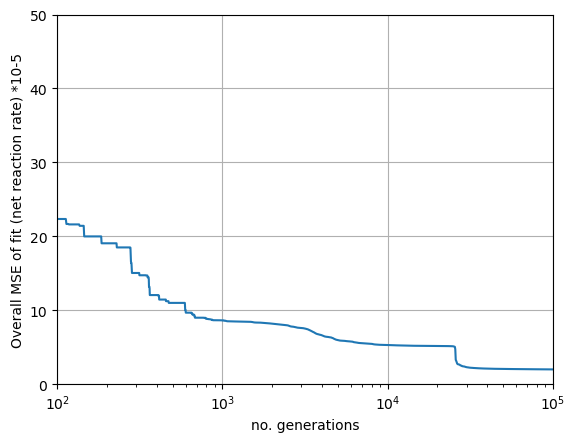

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.476387297133119
1.5161489016485834
0.8278914123969185
-1.4043170424633753
0.025847781483512352
3.695924536272194e-07
0.296517744544587
-11.499385934284401
1.1982137260096615
8.494918571780318
6.744296470538343
6.6458843932690215
3.737554621121905e-06
0.07007811238952723
2.7575904970279583
0.0763221879793232
0.4490915259591323
-11.2339716765759
1.767976482244571
1.5448692636711217
-10.905747283327461
1.1106305133800094
3.759738061882868
0.008812660695289173
3.9752934372516266
4.46063025599303
1.7578777861709147
9.705210605342788
-2.7891872027442464
2.4273615336199796
5.78702810793884
1.984101055321006
-4.512012863009501
0.6001103312518364
1.1082860197833182
-1.3010293643029736


In [37]:
res.X

array([-1.14763873e+01,  1.51614890e+00,  8.27891412e-01, -1.40431704e+00,
        2.58477815e-02,  3.69592454e-07,  2.96517745e-01, -1.14993859e+01,
        1.19821373e+00,  8.49491857e+00,  6.74429647e+00,  6.64588439e+00,
        3.73755462e-06,  7.00781124e-02,  2.75759050e+00,  7.63221880e-02,
        4.49091526e-01, -1.12339717e+01,  1.76797648e+00,  1.54486926e+00,
       -1.09057473e+01,  1.11063051e+00,  3.75973806e+00,  8.81266070e-03,
        3.97529344e+00,  4.46063026e+00,  1.75787779e+00,  9.70521061e+00,
       -2.78918720e+00,  2.42736153e+00,  5.78702811e+00,  1.98410106e+00,
       -4.51201286e+00,  6.00110331e-01,  1.10828602e+00, -1.30102936e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.476387297133119
1.6: 1.5161489016485834
0.9: 0.8278914123969185
-4.3: -1.4043170424633753
0.5: 0.025847781483512352
0.003: 3.695924536272194e-07
0.4: 0.296517744544587
-7.9: -11.499385934284401
0.7: 1.1982137260096615
7.2: 8.494918571780318
5.7: 6.744296470538343
5.7: 6.6458843932690215
0.8: 3.737554621121905e-06
0.03: 0.07007811238952723
3.1: 2.7575904970279583
6.000000000000001e-09: 0.0763221879793232
0.1: 0.4490915259591323
-12.0: -11.2339716765759
1.9: 1.767976482244571
1.6: 1.5448692636711217
-11.6: -10.905747283327461
1.2: 1.1106305133800094
4.0: 3.759738061882868
0.01: 0.008812660695289173
4.2: 3.9752934372516266
5.4: 4.46063025599303
2.2: 1.7578777861709147
11.8: 9.705210605342788
-12.0: -2.7891872027442464
3.3: 2.4273615336199796
1.8: 5.78702810793884
4.2: 1.984101055321006
-4.0: -4.512012863009501
0.5: 0.6001103312518364
1.0: 1.1082860197833182
coeff fit: 0.865528769808863
r: 0.9303379868676023
